<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/maths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Mathematics 🦋**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1000.png)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## <font color="blue">**Algebra**

##### <font color="blue">*Abstract Algebra*

###### *Algebraische Strukturen*

**Zusammenfassung algebraischer Strukturen mit Operationen**

$+$ $\quad$ $-$ $\quad$ is a Group

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ is a Ring

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ $÷$ $\quad$ is a Field


A group is a set $G$ with an operation $*$ such that

1. **Closure** [Abgeschlossenheit](https://de.m.wikipedia.org/wiki/Abgeschlossenheit_(algebraische_Struktur)): If $x$ and $y$ are in $G$ then $x * y$ is in $\mathrm{G}$
  * until here it is a [Magma (Groupoid)](https://de.m.wikipedia.org/wiki/Magma_(Mathematik))
  * Beispiele (Magmen, die keine Halbgruppen sind): 
    * $(\mathbb{Z},-):$ die ganzen Zahlen mit der Subtraktion
    * (R $\backslash\{0\}, /)$ : die reellen Zahlen ungleich 0 mit der Division
    * Die natürlichen Zahlen mit der Exponentiation, also mit der Verknüpfung $a * b=a^{b}$
    * Die reellen Zahlen mit der Bildung des arithmetischen Mittels als Verknüpfung

2. **Associativity** [Assoziativität](https://de.m.wikipedia.org/wiki/Assoziativgesetz): For all $x, y, z$ in $G$ $\text { we have }(x * y) * z=x *(y * z)$
  * until here it is a [Halbgruppe](https://de.m.wikipedia.org/wiki/Halbgruppe)
  * Beispiel: Die Menge $\mathbb  N$ $_0$ = {0, 1, 2 ..} der natürlichen Zahlen bildet mit der gewöhnlichen Addition eine kommutative und kürzbare Halbgruppe ($\mathbb  N$ $_0$,+), die keine Gruppe ist. Da hier die negativen Zahlen fehlen, also die „Hälfte“ der abelschen Gruppe ($\mathbb Z,+$) der ganzen Zahlen, lag der Name Halbgruppe für diese mathematische Struktur nahe. 

3. **Identity Element** [Neutrales Element](https://en.m.wikipedia.org/wiki/Identity_element): There is an element $e$ in $G$ such that $e * x=x * e=x$ for all $x$ in $G$
  * until here it is a [Monoid](https://de.m.wikipedia.org/wiki/Monoid)
  * Beispiel: die natürlichen Zahlen mit der Addition und der Zahl 0 als neutralem Element.

4. **Inverse Elements** [Inverse Elemente](https://de.m.wikipedia.org/wiki/Inverses_Element): For each element $x$ in $G,$ there is an element $x^{-1}$ such that $x * x^{-1}=x^{-1} * x=e$
  * until here it is a [Group](https://de.m.wikipedia.org/wiki/Gruppe_(Mathematik))
  * Beispiel: die Menge der ganzen Zahlen zusammen mit der Addition
  * Ringe, Körper (Field), Moduln und Vektorräume sind Gruppen mit zusätzlichen Strukturen und Eigenschaften

5. **Kommutative** [Kommutativität](https://de.m.wikipedia.org/wiki/Kommutativgesetz): Für alle $a, b \in G$ gilt: $a * b=b * a$
  * until here it is an [Abelian Group](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe)
  * Beispiel: 
    * $(\mathbb {Z} ,+)$ ist die wichtigste abelsche Gruppe. Dabei ist Z die Menge der ganzen Zahlen und + die gewöhnliche Addition.
    * $(\mathbb {Q}^{\cdot} , \cdot)$ ist eine abelsche Gruppe. Dabei ist $\mathbb {Q}^{\cdot}$ die Menge der rationalen Zahlen ohne die 0 und ⋅ ist die gewöhnliche Multiplikation. Die Null muss hierbei ausgeschlossen werden, da sie kein inverses Element besitzt: „1/0“ ist nicht definiert
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
    * Die Menge der Drehungen in einer Ebene um einen Punkt bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Drehungen.
    * Die Menge der Drehstreckungen in einer Ebene bilden eine abelsche Gruppe.
    * Die Menge der endlichen Dezimalzahlen sind bezüglich der Multiplikation keine abelsche Gruppe. Zum Beispiel hat die Zahl 3 kein Inverses bezüglich der Multiplikation. $\displaystyle {\frac {1}{3}}$ lässt sich nicht als endlicher Dezimalbruch schreiben. Bezüglich der normalen Addition bilden die endlichen Dezimalbrüche eine abelsche Gruppe.
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
  * [Free Abelian Group](https://de.m.wikipedia.org/wiki/Freie_abelsche_Gruppe): eine abelsche Gruppe, die als $\mathbb {Z}$-Modul eine Basis hat. Ist G eine freie abelsche Gruppe ist, so wird man eine Basis wählen und alle Elemente als Linearkombinationen von Elementen dieser Basis ausdrücken. Allerdings sollte man betonen, dass es meist keine ausgezeichnete Basis geben wird. 

6. **Distributive law** [Distributivgesetz](https://de.m.wikipedia.org/wiki/Distributivgesetz): a(b + c) = ab + ac.
  * Gilt zusätzlich Distributivgesetz gilt für Ring (da man hier zwei Operationen benötigt). Gruppen haben immer nur eine Operation.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/groups.png)

**Applications of Group Theory**

* Solutions to polynomial equations, like find 2 roots of a quadratic equation. there is also q cubic formula and a quartic for degree 4 polynomial. Find formula to solve degree 5 polynomial - group theory showed it doesnt exist. Has to do with permutation group S5.

* Connection to Physics - Noether's theorem: Conservation law - symmetry. Momentum - translation in space. Energy - translation in time.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/%C3%9Cbersicht_K%C3%B6rper.svg/775px-%C3%9Cbersicht_K%C3%B6rper.svg.png)

**Ein [Modul](
https://de.m.wikipedia.org/wiki/Modul_(Mathematik)) ist ein n-dimensionaler Ring.**

* Ein Modul ist eine algebraische Struktur, die eine Verallgemeinerung eines Vektorraums darstellt.

* **A module is similar to a vector space, except that the scalars are only required to be elements of a ring. (Gilt NICHT multiplikative Inverse und multiplikative Kommuntativität)**

* For example, the set Zn of n-dimensional vectors with integer entries forms a module, where “scalar multiplication” refers to multiplication by integer scalars.

Folgende Zahlenbereiche sind additive Gruppen und damit $\mathbb {Z}$ -Moduln:

* die ganzen Zahlen $\mathbb {Z}$ selbst

* die rationalen Zahlen $\mathbb {Q}$ 

* die reellen Zahlen $\mathbb {R}$ 

* die algebraischen Zahlen $\mathbb A$ bzw. $\mathbb A$ $\cap$ $\mathbb R$

* die komplexen Zahlen $\mathbb {C}$


**Ein [Ring](https://en.m.wikipedia.org/wiki/Ring_theory) ist eine Menge R mit <u>zwei inneren binären Verknüpfungen</u> „+“ und „∙“, sodass gilt:**

1. **Addition: (R, +) ist eine abelsche Gruppe**

* Addition is associative and commutative;

* There is an additive identity, zero;

* Every element has an additive inverse;

2. **Multiplikation: (R, ∙) ist eine Halbgruppe**, das bedeutet:

* Halbgruppe in der Multiplikation im Ring: **nur nur die Assoziativität, aber keine Inverse, neutrales element oder kommutativität**) 

> **Das bedeutet: -> Sowohl Ringe als auch Körper verlangen, dass bzgl. der Addition eine kommutative Gruppe vorliegt (abelsch!). Bei der Multiplikation erfolgt der Übergang vom Ring zum Körper durch die Verschärfung der Forderungen**

* Unlike a field, a ring is not required to have multiplicative inverses, and the multiplication is not required to be commutative. 

> **A good example of a ring is the set of all n×n matrices under the operations of matrix addition and matrix multiplication.** [Matrix-Multiplication is non-commutative!](https://en.m.wikipedia.org/wiki/Matrix_multiplication#Non-commutativity)

$\mathbf{A B} \neq \mathbf{B A}$
For example

$
\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)
$

but

$
\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)=\left(\begin{array}{ll}
0 & 0 \\
0 & 1
\end{array}\right)
$

> **The integers Z also form a ring under the operations of addition and multiplication.**

3. **Die Distributivgesetze a*(b+c)=a*b+a*c und (a+b)*c = a*c+b*c sind für alle a,b,c ε $R$ erfüllt.**

4. **Das neutrale Element 0 von (R, +) heißt Nullelement von R.**

https://de.m.wikipedia.org/wiki/Ring_(Algebra)

**Ein Ring heißt kommutativ**, falls er bezüglich der Multiplikation kommutativ ist (Ein Ring heißt kommutativ, falls er bezüglich der Multiplikation kommutativ ist, ansonsten spricht man von einem nicht-kommutativen Ring.)

Beispiele:

* 2×2 Real matrices.

* Das wichtigste Beispiel eines Ringes sind die Integers / ist die Menge (􏰁$\mathbb Z$,+,∙) der ganzen Zahlen mit der üblichen Addition und Multiplikation. Es handelt sich dabei um einen nullteilerfreien kommutativen Ring mit Einselement, also einen Integritätsring.

* the Integers modulo some Natural number greater than one;

* Ebenso bildet ($\mathbb Q$,+,∙) der rationalen Zahlen mit der üblichen Addition und Multiplikation einen Ring. Da in diesem Fall nicht nur ($\mathbb Q$,+), sondern auch ($\mathbb Q$ \ {0},∙) eine abelsche Gruppe bildet, liegt sogar ein Körper vor; es handelt sich dabei um den Quotientenkörper des Integritätsringes (􏰁$\mathbb Z$,+,∙).

* Kein Ring ist die Menge ($\mathbb N$􏰀,+,∙) der natürlichen Zahlen mit der üblichen Addition und Multiplikation, da die Addition über den natürlichen Zahlen nicht invertierbar ist.

https://www.quora.com/What-are-the-differences-between-rings-and-fields

**Ein [Körper (Field)](https://de.m.wikipedia.org/wiki/K%C3%B6rper_(Algebra)) ist eine spezielle Form von Ring**:

> Man nennt die Elemente im Körper nicht Vektoren, sondern Skalare. Über dem Skalarkörper betrachtet man einen Vektorraum und dessen Elemente heißen Vektoren.

* **A Field is a Ring whose non-zero elements form a commutative Group under multiplication (In short a field is a commutative ring with unity with all its non zero elements having multiplicative inverse.)**

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, heißt ein Körper, wenn in ihm jedes von Null verschiedene Element multiplikativ invertierbar ist.
Anders formuliert, ist ein Körper ein kommutativer unitärer Ring K, in dem die Einheitengruppe K* gleich K \ {0}, also maximal groß, ist.

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, ist ein Körper, wenn in ihm jedes von Null verschiedene Element ein Inverses bezüglich der Multiplikation besitzt. Anders formuliert, ist ein Körper ein kommutativer unitärer Ring $K$, in dem die Einheitengruppe $K^{*}$ gleich $K \backslash\{0\}$ ist. 


Ein Tripel (K,+,•), bestehend aus einer Menge K und zwei binären Verknüpfungen „+“ und „•“ (die üblicherweise Addition und Multiplikation genannt werden), ist genau dann ein Körper, wenn folgende Eigenschaften erfüllt sind:

* $(K,+)$ ist eine abelsche Gruppe (mit Neutralelement 0)

* $(K \backslash\{0\}, •)$ ist eine abelsche Gruppe (mit Neutralelement 1)

* $a \cdot(b+c)=a \cdot b+a \cdot c$ und $(a+b) \cdot c=a \cdot c+b \cdot c$ (Distributivgesetz)

Additive Eigenschaften:

* $a+(b+c)=(a+b)+c$ (Assoziativgesetz)

* $a+b=b+a$ (Kommutativgesetz)

* Es gibt ein Element $0 \in K$ mit $0+a=a$ (neutrales Element)

* Zu jedem $a \in K$ existiert das additive Inverse $(-a)$ mit $(-a)+a=0$

Multiplikative Eigenschaften:

* $\cdot a \cdot(b \cdot c)=(a \cdot b) \cdot c$ (Assoziativgesetz)

* $a \cdot b=b \cdot a$ (Kommutativgesetz)

* Es gibt ein Element $1 \in K$ mit $1 \cdot a=a$ (neutrales Element), und es ist $1 \neq 0$.

* Zu jedem $a \in K \backslash\{0\}$ existiert das multiplikative Inverse $a^{-1}$ mit $a^{-1} \cdot a=1$

Zusammenspiel von additiver und multiplikativer Struktur:

* $a \cdot(b+c)=a \cdot b+a \cdot c$ (Links-Distributivgesetz) 

* Das Rechts-Distributivgesetz $(a+b) \cdot c=a \cdot c+b \cdot c$ folgt dann aus den übrigen Eigenschaften:
$(a+b) \cdot c=c \cdot(a+b)=c \cdot a+c \cdot b=a \cdot c+b \cdot c$

**Beispiele**

* The most familiar form of algebra is the elementary algebra that you learned in high school, namely the algebra of the real numbers. From an abstract point of view, this is the algebra of fields.

* Note that the axioms for a field are precisely the axioms for algebra on the real numbers. As a result, the real numbers R form a field under the usual operations of addition and multiplication. However, the real numbers are not the only possible field. Indeed, you are already familiar with a few other examples:

* set of rational numbers under addition and multiplication. The rational numbers Q form a field under the usual operations of addition and multiplication. In particular, we can add or multiply two elements of Q to obtain another element of Q, and these operations obey all of the axioms listed above.

* The complex numbers C form a field under the commonly defined operations of addition and multiplication. Complex numbers do obey all of the listed axioms for a field, which is why elementary algebra works as usual for complex numbers.

* The Integers modulo a Prime number.

*An example of a set of numbers that is **not a field** is the set of integers. It is an "integral domain." It is not a field because it lacks multiplicative inverses. Without multiplicative inverses, division may be impossible.*

* Both are algebraic objects with a notion of addition and multiplication, **but the multiplication in a field is more specialized**: it is necessarily commutative and every nonzero element has a multiplicative inverse.


**Siehe auch**

* [Algebraische Struktur](https://de.m.wikipedia.org/wiki/Algebraische_Struktur)

* [Outline_of_algebraic_structures](https://en.m.wikipedia.org/wiki/Outline_of_algebraic_structures)

* [Mathematische Strukturen](https://de.m.wikipedia.org/wiki/Mathematische_Struktur) (neben topologischen Strukturen, geometrischen Strukturen und Zahlbereichen)

* [Geometrische Gruppentheorie](https://de.wikipedia.org/wiki/Geometrische_Gruppentheorie) (Gruppenoperationen auf Graphen und metrischen Räumen, letztlich werden die Gruppen selbst zu solchen geometrischen Objekten)

* [Verknüpfungen](https://de.m.wikipedia.org/wiki/Verknüpfung_(Mathematik))

* [Gruppenoperation](https://de.wikipedia.org/wiki/Gruppenoperation)

###### *'Fundamental' Groups*

**Trivial Group (Zero Group)**

Die [triviale Gruppe](https://de.m.wikipedia.org/wiki/Triviale_Gruppe) ist in der Gruppentheorie eine Gruppe, deren Trägermenge genau ein Element enthält. Die triviale Gruppe ist bis auf Isomorphie eindeutig bestimmt. **Jede Gruppe enthält die triviale Gruppe als Untergruppe**.

Die triviale Gruppe $(\{e\}, *)$ ist eine Gruppe, die aus der einelementigen Menge $\{e\}$ besteht und versehen ist mit der einzig möglichen Gruppenoperation

$
e * e=e
$

Das Element $e$ ist damit das **neutrale Element** der Gruppe.

Alle trivialen Gruppen sind zueinander isomorph. Beispiele für triviale Gruppen sind:

* die zyklische Gruppe $C_{1}$ vom Grad 1

* die alternierende Gruppe $A_{2}$ vom Grad 2

* die symmetrische Gruppe $S_{1}$ einer einelementigen Menge


*Eigenschaften trivialer Gruppen*:

* Da die Gruppenoperation $\ast$ kommutativ ist, ist die triviale Gruppe eine abelsche Gruppe.

* Die einzige Untergruppe der trivialen Gruppe ist die triviale Gruppe selbst.

* Die triviale Gruppe wird von der leeren Menge erzeugt: 
$\{e\}=\langle \emptyset \rangle$ . Hierbei ergibt das leere Produkt nach üblicher Konvention das neutrale Element.

* Jede Gruppe enthält die triviale Gruppe und sich selbst als (triviale) Normalteiler. **Die triviale Gruppe wird daher meistens nicht als einfache Gruppe angesehen**, die aus genau 2 Normalteilern besteht).

* In der Kategorie der Gruppen Grp fungiert die triviale Gruppe als Nullobjekt.

**Simple Group**

https://youtu.be/jhVMBXl5jTA

* [Simple Groups](https://en.wikipedia.org/wiki/Simple_group) bzw. [einfache Gruppen](https://de.wikipedia.org/wiki/Einfache_Gruppe_(Mathematik)) **are the fundamental building blocks of finite groups** (just like Prime numbers are fundamental building blocks in number theory)

* Just as you can factor integers into prime numbers, you can break apart some groups into a direct product of simpler groups.

*  **a simple group is a <u>nontrivial</u> group whose only normal subgroups are the trivial group and the group itself.**

* **Jede Gruppe hat sich selbst und die nur das neutrale Element enthaltende Menge als Normalteiler.** 

Damit stellt sich die Frage, welche Gruppen keine weitere Normalteiler besitzen. Bei diesen handelt es sich per definitionem gerade um die einfachen Gruppen.

  * Eine Gruppe $G$ heisst einfach, falls sie als Normalteiler nur $G$ und $\{e\}$ mit dem neutralen Element $e$ hat. 
  * Außerdem wird zusătzlich $G \neq\{e\}$ gefordert, wonach man knapper sagen kann: 
  * **Eine Gruppe heißt einfach, wenn sie genau zwei Normalteiler besitzt.**

* A group that is not simple can be broken into two smaller groups, namely a nontrivial [normal subgroup](https://en.wikipedia.org/wiki/Normal_subgroup) and the corresponding quotient group. This process can be repeated, and for finite groups one eventually arrives at uniquely determined simple groups, by the [Jordan–Hölder theorem (Composition series)](https://en.wikipedia.org/wiki/Composition_series).

* The complete classification of finite simple groups, completed in 2004, is a major milestone in the history of mathematics.

**Seit 1982 sind die endlichen einfachen Gruppen vollständig klassifiziert, die Liste besteht aus**

* den zyklischen Gruppen von Primzahlordnung,

* den alternierenden Gruppen $A_{n}$ mit $n\geq 5$,

* den Gruppen vom Lie-Typ (16 jeweils unendliche Serien)

* 26 sporadischen Gruppen (Es handelt sich um die endlichen einfachen Gruppen, die sich nicht in eine der (18) systematischen Familien mit unendlich vielen Mitgliedern (von endlichen einfachen Gruppen) einordnen lassen.)

**Direct product of groups (from simple groups)**

* You can piece them together to create larger, more complex groups. One way is the direct product of groups.

* For example combine two groups G1 and G2 (no matter finite or infinite, abelian or non-abelian) into a larger group via the direct product. Operation is done component-wise.

* If any Group is non abelian, then the direct product will be non abelian as well.

* **The direct product is a useful tool for breaking some groups into simpler groups (not all!).** This is because there are many groups which are NOT direct products of simpler groups. But there are other tools for deconstructing groups.

https://www.youtube.com/watch?v=rXLz8TdckWo&list=PLi01XoE8jYoi3SgnnGorR_XOW3IcK-TP6&index=21

**Finite Groups**

* Eine Gruppe ($G$,*) heißt [endliche Gruppe](https://de.m.wikipedia.org/wiki/Endliche_Gruppe), wenn $G$ eine endliche Menge ist, also eine endliche Anzahl von Elementen hat.

* Die Annahme der Endlichkeit ermöglicht ein vereinfachtes Axiomensystem

Ein Paar $(G, *)$ mit einer endlichen Menge $G$ und einer inneren zweistelligen Verknüpfung $*: G \times G \rightarrow G$ heißt Gruppe, wenn folgende Axiome erfüllt sind:

* Assoziativität: Für alle Gruppenelemente $a, b, c$ gilt $(a * b) * c=a *(b * c)$,

* [Kürzungsregel](https://de.m.wikipedia.org/wiki/Kürzbarkeit): Aus $a * x=a * x^{\prime}$ oder $x * a=x^{\prime} * a$ folgt $x=x^{\prime}$

Aus der Kürzungsregel folgt, dass die Links- und Rechtsmultiplikationen $x \mapsto a * x$ und $x \mapsto x * a$
injektiv sind, woraus wegen der Endlichkeit auch die Surjektivität folgt. Daher gibt es ein $x$ mit
$a * x=a,$ was zur Existenz des neutralen Elementes $e$ führt, und dann ein $x$ mit $a * x=e$, was
die Existenz der inversen Elemente zeigt.

* The [List of small groups](https://en.wikipedia.org/wiki/List_of_small_groups) contains finite groups of small [order](https://en.wikipedia.org/wiki/Order_(group_theory)) [up to](https://en.wikipedia.org/wiki/Up_to) [group isomorphism](https://en.wikipedia.org/wiki/Group_isomorphism).

* Die folgende Liste enthält eine Auswahl [endlicher Gruppen kleiner Ordnung](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen).

  * Diese Liste kann benutzt werden, um herauszufinden, zu welchen bekannten endlichen Gruppen eine Gruppe G isomorph ist. 
  
  * Als erstes bestimmt man die Ordnung von G und vergleicht sie mit den unten aufgelisteten Gruppen gleicher Ordnung. 
  
  * Ist bekannt, ob G abelsch (kommutativ) ist, so kann man einige Gruppen ausschließen. Anschließend vergleicht man die Ordnung einzelner Elemente von G mit den Elementen der aufgelisteten Gruppen, wodurch man G bis auf Isomorphie eindeutig bestimmen kann.

In der nachfolgenden Liste werden folgende Bezeichnungen verwendet:

- $\mathbb{Z}_{n}$ ist die zyklische Gruppe der Ordnung $n$ (die auch als $C_{n}$ oder $\mathbb{Z} / n \mathbb{Z}$ geschrieben wird).

- $D_{n}$ ist die Diedergruppe der Ordnung $2 n$.

- $S_{n}$ ist die symmetrische Gruppe vom Grad $n$, mit $n !$ Permutationen von $n$ Elementen.

- $A_{n}$ ist die alternierende Gruppe vom Grad $n$, mit $n ! / 2$ Permutationen von $n$ Elementen für $n \geq 2$.

- Dic $_{n}$ ist die dizyklische Gruppe der Ordnung $4 n$.

- $V_{4}$ ist die [Klein'sche Vierergruppe](https://de.m.wikipedia.org/wiki/Kleinsche_Vierergruppe) der Ordnung $4 .$

- $Q_{4 n}$ ist die Quaternionengruppe der Ordnung $4 n$ fur $n \geq 2$.

[Liste aller Gruppen bis Ordnung 20](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen#Liste_aller_Gruppen_bis_Ordnung_20)

**Finite Simple Groups**

* [Endliche einfache Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe) gelten in der Gruppentheorie als die Bausteine der [endlichen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_Gruppe).

* Die endlichen einfachen Gruppen spielen für die endlichen Gruppen eine ähnliche Rolle wie die Primzahlen für die natürlichen Zahlen: Jede endliche Gruppe lässt sich in ihre einfachen Gruppen „zerteilen“ (für die Art der Eindeutigkeit siehe den Satz von Jordan-Hölder). 

* Die Rekonstruktion einer endlichen Gruppe aus diesen ihren „Faktoren“ ist aber nicht eindeutig. 

* Es gibt jedoch keine „noch einfacheren Gruppen“, aus denen sich die endlichen einfachen Gruppen konstruieren lassen.

Obwohl die endlichen einfachen Gruppen seit 1982 als vollständig klassifiziert galten, schlossen Mathematiker um Aschbacher die Klassifikation erst im Jahre 2002 mit einem 1200 Seiten langen Beweis ab:

* Fast alle dieser Gruppen lassen sich einer von 18 Familien endlicher einfacher Gruppen zuordnen.

* Es existieren 26 Ausnahmen. Diese Gruppen werden als **sporadische Gruppen** bezeichnet (Zu den sporadischen Gruppen zählen die Conway-Gruppe, das Babymonster und die [**Monstergruppe**](
https://de.m.wikipedia.org/wiki/Monstergruppe) (mit fast 1054 Elementen die größte sporadische Gruppe).

* Die [sporadischen Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe) sind 26 spezielle Gruppen in der Gruppentheorie. Es handelt sich um die [endlichen einfachen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe), die sich nicht in eine der [(18) systematischen Familien mit unendlich vielen Mitgliedern](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Familien_endlicher_einfacher_Gruppen) (von endlichen einfachen Gruppen) einordnen lassen.

> https://www.quantamagazine.org/mathematicians-chase-moonshine-string-theory-connections-20150312/

[2004: Classification of Quasithin group](https://en.wikipedia.org/wiki/Quasithin_group)

**Klassifikation der endlichen einfachen Gruppe**

Die endlichen einfachen Gruppen [lassen sich einteilen in](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Klassifikation) bzw [Classification of finite simple groups](https://en.m.wikipedia.org/wiki/Classification_of_finite_simple_groups), Every finite simple group is isomorphic to one of the following groups:

* a member of one of three infinite classes of such, namely:

  * (1) [zyklische Gruppen](https://de.m.wikipedia.org/wiki/Zyklische_Gruppe) von Primzahlordnung,

  * (1) [alternierende Gruppen](https://de.m.wikipedia.org/wiki/Alternierende_Gruppe) $A_{n}$ mit $n>4$,

  * (16) [Gruppen vom Lie-Typ](https://de.m.wikipedia.org/wiki/Gruppe_vom_Lie-Typ) über einem [endlichen Körper](https://de.m.wikipedia.org/wiki/Endlicher_Körper) (16 jeweils unendliche Familien),

* (26) one of 26 groups called the "sporadic groups" / [26 sporadische Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe).

* (1) the [Tits group](https://en.m.wikipedia.org/wiki/Tits_group) (which is sometimes considered a 27th sporadic group)

**Charakteristische Untergruppe**

* In der Gruppentheorie ist eine [charakteristische Untergruppe](https://de.m.wikipedia.org/wiki/Charakteristische_Untergruppe) einer Gruppe $G$ eine Untergruppe $H$, die unter jedem Automorphismus von $G$ in sich abgebildet wird.

* Eine Untergruppe $H$ von $G$ heißt charakteristisch, wenn für jeden Automorphismus, das heißt bijektiven Gruppenhomomorphismus $f: G \rightarrow G$, stets $f(H) \subset H$ gilt.

* **Charakteristische einfache Untergruppe**: eine Gruppe [charakteristisch einfach](https://de.m.wikipedia.org/wiki/Charakteristisch_einfache_Gruppe), wenn sie außer sich selbst und der trivialen Untergruppe keine weiteren charakteristischen Untergruppen enthält. 



###### *Morphismen (Linear Maps)*

Ein [Morphismus](https://de.m.wikipedia.org/wiki/Morphismus) ist eine Funktion in Kategorientheorie. Man schreibt: $f\colon X\to Y$

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismus2.jpg)

Source: [Morphismen](https://youtu.be/0wKsFNLR15g)

[Automorphismus](https://de.m.wikipedia.org/wiki/Automorphismus)

* Sonderart des Isomomorphismus und Endomorphismus und speziellester Morphismus den es gibt

* Ist wie Endomorphismus dass Definitionsmenge = Zielmenge ist, aber im Unterschied dazu noch bijektiv (alle Elemente sind 1:1 miteinander verknüpft)

[Endomorphismus](https://de.m.wikipedia.org/wiki/Endomorphismus)

* Sei $X$ ein Objekt einer Kategorie. Ein Morphismus $f: X \rightarrow X$, der auf einem Objekt $X$ operiert, heißt Endomorphismus.

* Sei $\left(A,\left(f_{i}\right)\right)$ eine algebraische Struktur, also eine nichtleere Menge $A$ zusammen mit einer endlichen Anzahl an Verknüpfungen $f_{i}$ mit entsprechenden Stelligkeiten $\sigma_{i} .$ **Eine solche algebraische Struktur könnte beispielsweise ein Vektorraum $(A,(+, \cdot)),$ eine Gruppe $(A, *)$ oder ein Ring $(A,(+, *))$ sein**. Dann versteht man in der Algebra unter einem Endomorphismus $\phi: A \rightarrow A$ eine Abbildung der Menge $A$ auf sich selbst, die ein Homomorphismus ist, das heißt, es gilt

> $
\phi\left(f_{i}\left(a_{1}, \ldots, a_{\sigma_{i}}\right)\right)=f_{i}\left(\phi\left(a_{1}\right), \ldots, \phi\left(a_{\sigma_{i}}\right)\right)
$ für alle $i$ und alle $a_{1}, \ldots, a_{\sigma_{i}} \in A$

* **Endomorphismus : Definitionsmenge = Zielmenge** (zB lineare Abbildung auf sich selbst). Die Bildmenge muss aber nicht der ganze Vektorraum sein (d.h. Ziele können weniger sein als Usprünge innerhalb einer Menge). Beispiel: lineare Funktionen von reellen Zahlen in die reellen Zahlen.

[Isomorphismus](https://de.m.wikipedia.org/wiki/Isomorphismus)

* ist ein bijektiver Homomorphismus. Abbildung ist bijektiv (injektiv und surjektiv gleichzeitig)

* ein Isomorphismus ist damit gleichzeit auch ein Epi- und Monomorphismus

* Siehe auch [Isomorphism of categories](https://en.m.wikipedia.org/wiki/Isomorphism_of_categories)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/isomorphismus.JPG)

[Monomorphismus](https://de.m.wikipedia.org/wiki/Monomorphismus)

* wenn eine Abbildung injektiv ist (jedes Element des Usprungs hat ein exklusives Element in der Zielmenge das nicht mit anderen geteilt wird, und nicht alle Elemente in der Zielmenge haben eine Faser im Usprungsbild)

* Gegenteil ist Epimorphismus (Abbildungs ist surjektiv)

[Epimorphismus](https://de.m.wikipedia.org/wiki/Epimorphismus)

* Abbildung ist surjektiv (die Bildmenge ist die komplette Zielmenge, dh jedes Element im Ziel ist mind 1 mal getroffen

* Gegenteil von Monomorphismus

**Special Morphismen:**

Für manche Kategorien gibt es besondere Bezeichnungen für Morphismen.

* Ein [Homöomorphismus](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist ein Isomorphismus zwischen topologischen Räumen. Sind (beispielsweise) die [Fundamentalgruppen](https://de.m.wikipedia.org/wiki/Fundamentalgruppe) zweier Räume isomorph, so sind die Räume homöomorph.

* Ein [Diffeomorphismus](https://de.m.wikipedia.org/wiki/Diffeomorphismus) ist ein Isomorphismus zwischen differenzierbaren Mannigfaltigkeiten.

* Eine [Isometrie](https://de.m.wikipedia.org/wiki/Isometrie) ist ein Isomorphismus in der Kategorie der metrischen Räumen mit den nichtexpansiven stetigen Abbildungen.

* Eine lineare Abbildung ist ein (Homo-)Morphismus zwischen Vektorräumen.

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismen.jpg)

Source: [Morphismen Übersicht](https://youtu.be/KngDroAqUT0)

**Homomorphismus (Lineare Abbildung)**

Ein (Vektorraum-) [Homomorphismus](https://de.m.wikipedia.org/wiki/Homomorphismus) ((Lineare Abbildung)) ist eine Abbildung $\varphi: V \rightarrow W$ zwischen $K$ -Vektorräumen $V$ und $W$ (gemeinsamer Grundkörper $K$) mit den folgenden Eigenschaften:


1. **Additivität**: $\varphi(v+u)=\varphi(v)+\varphi(u)$ für alle $u$ und $v \in V$

2. **Homogenität**: $\varphi(\lambda \cdot v)=\lambda \cdot \varphi(v) \quad$ für alle $\lambda \in K$ und $v \in V$ (Skalarmultiplikation)

* Beispiel: Bei einer linearen Abbildung ist es unerheblich, ob man zwei Vektoren zuerst addiert und dann deren Summe abbildet oder zuerst die Vektoren abbildet und dann die Summe der Bilder bildet. Gleiches gilt für die Multiplikation mit einem Skalar aus dem Grundkörper.

* In der Funktionalanalysis, bei der Betrachtung unendlichdimensionaler Vektorräume, die eine Topologie tragen, spricht man meist von linearen Operatoren statt von [linearen Abbildungen](https://de.m.wikipedia.org/wiki/Lineare_Abbildung). 


![xyz](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Reflection_of_a_triangle_about_the_y_axis.svg/320px-Reflection_of_a_triangle_about_the_y_axis.svg.png)

*Achsenspiegelung als Beispiel einer linearen Abbildung*

**Beispiele für Vektorraumhomomorphismus**

* Für $V=W=\mathbb{R}$ hat jede lineare Abbildung die Gestalt $f(x)=m x$ mit $m \in \mathbb{R}$

* Es sei $V=\mathbb{R}^{n}$ und $W=\mathbb{R}^{m}$. Dann wird für jede $m \times n$ -Matrix $A$ mit Hilfe der Matrizenmultiplikation eine lineare Abbildung $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ durch

$f(x)=A x=\left(\begin{array}{ccc}a_{11} & \cdots & a_{1 n} \\ \vdots & & \vdots \\ a_{m 1} & \cdots & a_{m n}\end{array}\right)\left(\begin{array}{c}x_{1} \\ \vdots \\ x_{n}\end{array}\right)$
definiert. 

Jede lineare Abbildung von $\mathbb{R}^{n}$ nach $\mathbb{R}^{m}$ kann so dargestellt werden.

[Gruppenhomomorphismus](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus)

Gegeben seien zwei Gruppen $(G, *)$ und $(H, \star) .$ Eine Funktion $\phi: G \rightarrow H$ heißt Gruppenhomomorphismus, wenn für alle Elemente $g_{1}, g_{2} \in G$ gilt:

> $\phi\left(g_{1} * g_{2}\right)=\phi\left(g_{1}\right) \star \phi\left(g_{2}\right)$

Aus dieser Bedingung folgt unmittelbar, dass

> $\phi\left(e_{G}\right)=e_{H}$

für die neutralen Elemente $e_{G} \in G, e_{H} \in H$ und dann

> $\phi\left(g^{-1}\right)=\phi(g)^{-1}$

für alle $g \in G$ gelten muss sowie, mittels vollständiger Induktion, dass $\phi\left(g_{1} * \ldots * g_{n}\right)=\phi\left(g_{1}\right) \star \ldots \star \phi\left(g_{n}\right)$ für eine beliebige endliche Anzahl von Faktoren gilt.

[Körperhomomorphismus](https://de.m.wikipedia.org/wiki/Körperhomomorphismus)

Seien $\left(K ;+K ; *_{K}\right)$ und $\left(L ;+_{L} ; *_{L}\right)$ zwei Körper.

Eine Funktion $f: K \rightarrow L$ heißt Körperhomomorphismus, falls sie folgende Axiome erfüllen:

1. $f\left(0_{K}\right)=0_{L}$ sowie $f\left(1_{K}\right)=1_{L}$

2. $\forall a ; b \in K: f(a+\kappa b)=f(a)+_{L} f(b)$

3. $\forall a ; b \in K: f\left(a *_{K} b\right)=f(a) *_{L} f(b)$

[Ringhomomorphismus](https://de.m.wikipedia.org/wiki/Ringhomomorphismus)

Gegeben seien zwei Ringe $(R,+, \cdot)$ und $(S, \oplus, \otimes)$. Eine Funktion $\varphi: R \rightarrow S$ heißt Ringhomomorphismus, wenn für alle Elemente $a, b$ von $R$ gilt:

$$
\varphi(a+b)=\varphi(a) \oplus \varphi(b) \text { und } \varphi(a \cdot b)=\varphi(a) \otimes \varphi(b)
$$

Die Gleichung besagt, dass der Homomorphismus strukturerhaltend ist: Es ist egal, ob man erst zwei Elemente verknüpft, und das Ergebnis abbildet, oder erst die zwei Elemente abbildet, und dann
die Bilder verknüpft.

[Algebrenhomomorphismen](https://de.m.wikipedia.org/wiki/Algebra_über_einem_Körper#Algebrenhomomorphismen)

Eine Abbildung $f: A \rightarrow B$ zwischen zwei $K$ -Algebren ist ein Homomorphismus, falls folgendes gilt:

* $(\lambda x)=\lambda f(x)$ für alle $\lambda \in K, x \in A$

* $f(x+y)=f(x)+f(y)$ für alle $x, y \in A$

* $(x \cdot y)=f(x) \cdot f(y)$ für alle $x, y \in A$

* Gegebenenfalls $f(1)=1$, wobei mit 1 die Einselemente in den Algebren bezeichnet seien.

[Modulhomomorphismus](https://de.m.wikipedia.org/wiki/Modulhomomorphismus)

Es seien zwei Rechtsmoduln $M, N$ über einem Ring $R$ gegeben. Eine Abbildung $f: M \rightarrow N$ heißt Homomorphismus von $M$ nach $N$, wenn für alle $m_{1}, m_{2} \in M$ und alle $r \in R$ gilt:

> $
f\left(m_{1}+m_{2}\right)=f\left(m_{1}\right)+f\left(m_{2}\right) \text { und } f\left(m_{1} \cdot r\right)=f\left(m_{1}\right) \cdot r
$

##### <font color="blue">*Linear Algebra*

###### *Komponenten: Eigenwertproblem, Matrixarten, Produktarten,Inverse Matrix, Diagonalmatrix & Jordan Normalform*

**Singuläre & reguläre Matrix**

* Eine [reguläre, invertierbare oder nichtsinguläre Matrix](https://de.m.wikipedia.org/wiki/Reguläre_Matrix) ist in der Mathematik eine quadratische Matrix, die eine Inverse besitzt

* Singuläre Matrizen besitzen keine inverse

**Transponierte Matrix**

* bijektive, selbstinverse Abbildung einer reellen Matrix

* Die [transponierte Matrix](https://de.m.wikipedia.org/wiki/Transponierte_Matrix), gespiegelte Matrix oder gestürzte Matrix ist in der Mathematik diejenige Matrix, die durch Vertauschen der Rollen von Zeilen und Spalten einer gegebenen Matrix entsteht.

* die transponierte Matrix entsteht also durch Spiegelung der Ausgangsmatrix an ihrer Hauptdiagonale. 

* Unterschied zu symmetrischen Matrizen: diese sind quadratisch, transponierte Matrizen koennen auch zB 2x3 Matrizen sein, und symmetrische haben die gleiche Werte in der quadratischen Matrix auf den gegenuberliegenden Seiten (wahrend transponierte Matrizen auch quadratisch sein koennen, aber jeweils andere Werte bei der Speigelung)

  * **Eine symmetrische Matrix ist eine quadratische Matrix, die gleich ihrer Transponierten ist**

  * **Eine orthogonale Matrix ist eine quadratische Matrix, deren Transponierte gleich ihrer Inversen ist**

* Viele Kenngrößen von Matrizen, wie Spur, Rang, Determinante und Eigenwerte, bleiben unter Transponierung erhalten. (zB der Rang und die Spur der transponierten Matrix gleich dem der Ausgangsmatrix)

![ggg](https://upload.wikimedia.org/wikipedia/commons/e/e4/Matrix_transpose.gif)

**Symmetrische Matrix**

* sehr wichtig in Naturwissenschaften

* [Symmetrische Matrizen](https://de.m.wikipedia.org/wiki/Symmetrische_Matrix) ist eine quadratische Matrix, deren **Einträge spiegelsymmetrisch bezüglich der Hauptdiagonale sind**. 

* Eine symmetrische Matrix stimmt demnach mit ihrer transponierten Matrix überein (ändern sich nicht durch Transponieren)

* symmetrische Matrizen muessen nicht unbedingt invertierbar sein (So ist etwa jede Nullmatrix symmetrisch, aber keinesfalls invertierbar.)

* Reelle symmetrische Matrizen weisen eine Reihe weiterer besonderer Eigenschaften auf:

  * So ist eine reelle symmetrische Matrix **stets selbstadjungiert** (mit sich selbst  transponiert + conjugiert (=alle Vorzeichen umgekehrt)), sie besitzt nur reelle Eigenwerte und sie ist **stets orthogonal diagonalisierbar**. 
  
  * Für komplexe symmetrische Matrizen gelten diese Eigenschaften im Allgemeinen nicht; das entsprechende Gegenstück sind dort **hermitesche Matrizen**. 

*Symmetriemuster einer symmetrischen (5×5)-Matrix:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Matrix_symmetry_qtl1.svg/220px-Matrix_symmetry_qtl1.svg.png)

**Inverse Matrix (Invertierbarkeit)**

* Die [inverse Matrix](https://de.m.wikipedia.org/wiki/Inverse_Matrix), Kehrmatrix oder kurz Inverse einer quadratischen Matrix ist eine ebenfalls **quadratische Matrix**, die **mit der Ausgangsmatrix multipliziert die Einheitsmatrix ergibt**. 

  * Aber: nicht jede quadratische Matrix besitzt eine Inverse; 

  * Allgemeiner ist jede Matrix, die eine Nullzeile enthält, nicht invertierbar.

  * Allgemeiner sind Matrizen mit zwei gleichen Zeilen niemals invertierbar.

* die invertierbaren Matrizen werden **reguläre Matrizen** genannt. Matrizen, die nicht invertierbar sind, heißen **singulär** .

* Ist eine Matrix invertierbar, gibt es eine Lösung

  * So ist etwa  A genau dann invertierbar, wenn  det⁡ A ≠ 0  gilt (Determinante)

  * Matrix ist invertierbar (=regulär), wenn [Rang](https://de.m.wikipedia.org/wiki/Rang_(Mathematik)) = n (Dimension der Matrix ohne Nullzeile ist)

  * Bestimmung der Inversen einer invertierbaren Matrix: Algorithmus von Gauß und Jordan zur Lösung von Gleichungssystemen

Die Inverse der reellen $(2 \times 2)$ -Matrix

$
A=\left(\begin{array}{ll}
2 & 1 \\
6 & 4
\end{array}\right)
$

ist

$
A^{-1}=\left(\begin{array}{cc}
2 & -0,5 \\
-3 & 1
\end{array}\right)
$

denn es gilt

$
A \cdot A^{-1}=\left(\begin{array}{ll}
2 & 1 \\
6 & 4
\end{array}\right) \cdot\left(\begin{array}{cc}
2 & -0,5 \\
-3 & 1
\end{array}\right)=\left(\begin{array}{cc}
4-3 & -1+1 \\
12-12 & -3+4
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

**Orthogonale Matrix**

* sehr wichtig in Naturwissenschaften

* Eine [orthogonale Matrix](https://de.m.wikipedia.org/wiki/Orthogonale_Matrix) ist eine quadratische, reelle Matrix, deren Zeilen- und Spaltenvektoren orthonormal bezüglich des Standardskalarprodukts sind. **Damit ist die Inverse einer orthogonalen Matrix gleichzeitig ihre Transponierte**.

> Eine reelle quadratische Matrix $Q \in \mathbb{R}^{n \times n}$ heißt orthogonal, wenn das Produkt mit ihrer transponierten Matrix $Q^{T}$ die Einheitsmatrix $I$ ergibt, also $Q^{T} \cdot Q=I$

* sind invertierbar, symmetrische nicht unbedingt (So ist etwa jede Nullmatrix symmetrisch, aber keinesfalls invertierbar.)

* stellen Kongruenzabbildungen im euklidischen Raum, also Drehungen, Spiegelungen und Kombinationen daraus, dar.

  * [Drehmatrizen](https://de.m.wikipedia.org/wiki/Drehmatrix), also Matrizen, die eine Drehung um den Koordinatenursprung in der euklidischen Ebene beschreiben, sind orthogonal. 

  * [Spiegelungsmatrizen](https://de.m.wikipedia.org/wiki/Spiegelungsmatrix), also Matrizen, die eine (senkrechte) Spiegelung an einer Ursprungsgerade in der euklidischen Ebene beschreiben, sind orthogonal.

  * [Permutationsmatrizen](https://de.m.wikipedia.org/wiki/Permutationsmatrix), also Matrizen, bei denen genau ein Eintrag pro Zeile und Spalte gleich eins ist und alle anderen Einträge null sind, sind orthogonal. 

* werden beispielsweise bei der numerischen Lösung linearer Gleichungssysteme oder Eigenwertprobleme eingesetzt

* Der analoge Begriff bei komplexen Matrizen ist die unitäre Matrix.

*Durch Multiplikation mit einer orthogonalen Matrix Q können Vektoren gedreht (links) oder gespiegelt (rechts) werden. Die Länge der Vektoren und der Winkel zwischen den Vektoren bleiben dabei erhalten*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Orthogonal_transformation_qtl1.svg/240px-Orthogonal_transformation_qtl1.svg.png)
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Orthogonal_transformation_qtl2.svg/240px-Orthogonal_transformation_qtl2.svg.png)

Die Matrix

$
Q=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)
$

ist orthogonal, denn es gilt

$
Q^{T} Q=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right) \cdot\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
0 \cdot 0+1 \cdot 1 & 0 \cdot 1+1 \cdot 0 \\
1 \cdot 0+0 \cdot 1 & 1 \cdot 1+0 \cdot 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I \text { . }
$

Auch die Matrix

$
Q=\frac{1}{5}\left(\begin{array}{cc}
3 & 4 \\
-4 & 3
\end{array}\right)
$

ist orthogonal, denn es gilt

$
Q^{T} Q=\frac{1}{5}\left(\begin{array}{cc}
3 & -4 \\
4 & 3
\end{array}\right) \cdot \frac{1}{5}\left(\begin{array}{cc}
3 & 4 \\
-4 & 3
\end{array}\right)=\frac{1}{25}\left(\begin{array}{cc}
9+16 & 12-12 \\
12-12 & 16+9
\end{array}\right)=\frac{1}{25}\left(\begin{array}{cc}
25 & 0 \\
0 & 25
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

**Selbstadjungierte Matrix**

* Eine [selbstadjungierte Matrix](https://de.m.wikipedia.org/wiki/Selbstadjungierte_Matrix) ist eine spezielle Art von **quadratischen Matrizen.**

* Sind die Koeffizienten reell, so ist sie gerade eine **symmetrische Matrix**

  * Eine reelle Matrix ist genau dann selbstadjungiert, wenn sie symmetrisch ist, also wenn $A=A^{T}$

* Sind die Koeffizienten komplex, so ist sie eine **hermitesche Matrix.**

  * eine komplexe Matrix genau dann selbstadjungiert, wenn sie hermitesch ist, also wenn $A=A^{*}$

  * Die [Pauli-Matrizen](https://de.m.wikipedia.org/wiki/Pauli-Matrizen) sind selbstadjungiert (zur Beschreibung des Spins, Basis des 4-dimensionalen komplexen Vektorraums aller komplexen & hermetischen 2×2-Matrizen)

* Jede selbstadjungierte Matrix ist auch normal, das heißt, es gilt $A^{{*}}\cdot A=A\cdot A^{{*}}$. Die Umkehrung gilt im Allgemeinen nicht.

**Normale Matrix**

* eine [normale Matrix](https://de.m.wikipedia.org/wiki/Normale_Matrix) ist eine Matrix, die mit ihrer adjungierten Matrix kommutiert

  * eine komplexe Matrix $A\in {\mathbb  {C}}^{{n\times n}}$ ist normal, wenn $A^{{*}}\cdot A=A\cdot A^{{*}}$

  * eine reelle Matrix $B\in {\mathbb  {R}}^{{n\times n}}$ ist normal, wenn $B^{{T}}\cdot B=B\cdot B^{{T}}$

* Der [Spektralsatz](https://de.m.wikipedia.org/wiki/Spektralsatz) besagt, dass eine Matrix A genau dann normal ist, wenn es eine unitäre Matrix U gibt (orthogonal in komplex), so dass $A=UDU^{{{\rm {*}}}}$, wobei D eine Diagonalmatrix ist. 

* Normale Matrizen haben also die Eigenschaft, dass sie unitär diagonalisierbar sind. Es existiert daher eine Orthonormalbasis aus Eigenvektoren von A. Die Hauptdiagonalelemente von D sind genau die Eigenwerte von A. 

* Insbesondere sind jede reelle symmetrische Matrix und jede komplexe hermitesche Matrix normal. Zudem ist jede unitäre Matrix normal.

* [**Normaler Operator**](https://de.m.wikipedia.org/wiki/Normaler_Operator): Verallgemeinerung der normalen Matrix. Ein "normaler Operator" ist basisunabhängig definiert und im unendlichdimensionalen Raum.

**Conjugierte Matrizen**

* Vertauschen der Vorzeichen

* komplrxeertig

**Adjungierte Matrix** 

* = transponiert + conjugiert

* komplexwertige Matrix, die transponiert + (komplex) conjugiert ist (Vorzeichen umgekehrt)

* Eine adjungierte Matrix muss nicht quadratisch sein (kann also zB auch 2x3 Matrix sein) und auch nicht symmetrisch sein

$
\begin{aligned}
B=\left(\begin{array}{ll}
0 & i \\
0 & 0
\end{array}\right)
\\
B^{T}=\left(\begin{array}{ll}
0 & 0 \\
i & 0
\end{array}\right) \\
B^{*} &=\left(\begin{array}{cc}
0 & 0 \\
-i & 0
\end{array}\right)
\end{aligned}
$

**Hermetisch**

* selbstadjunktiert = symmetrisch

* also wenn man die adjunktierte von A* bildet, kommt wieder A raus: A* = A

* Spiegelung an der Diagonalen. Matrix muss quadratisch sein

* im reellen ist es die Symmetrie

**Normal**

* A* A = A A*

* Einheitsmatrix

**Unitär**

* Orthogonalität

* Eine Matrix die invertierbar ist, ist durch die adjunktierte Matrix gegeben: A<sup>-1</sup> = A*

* eine unitäre Matrix ändert nichts an den Längen / Abständen / Winkeln von Vektoren zB bei Rotationen im Raum

* Verallgemeinerung von orthogonalen Matrizen in der komplexen Welt

*Skalarprodukt (Dot Product)*

* Das [Skalarprodukt](https://de.m.wikipedia.org/wiki/Skalarprodukt) (auch inneres Produkt oder Punktprodukt) ist eine mathematische Verknüpfung, die zwei Vektoren eine Zahl (Skalar) zuordnet.

* Es ist Gegenstand der analytischen Geometrie und der linearen Algebra. Historisch wurde es zuerst im euklidischen Raum eingeführt. 

* Geometrisch berechnet man das Skalarprodukt zweier Vektoren $\vec {a}$ und $\vec {b}$ nach der Formel

>$
\vec{a} \cdot \vec{b}=|\vec{a}||\vec{b}| \cos \triangleleft(\vec{a}, \vec{b})
$

* Dabei bezeichnen $|\vec{a}|$ und $|\vec{b}|$ jeweils die Längen (Beträge) der Vektoren. Mit $\cos \triangleleft(\vec{a}, \vec{b})=\cos \varphi$ wird der Kosinus des von den beiden Vektoren eingeschlossenen Winkels $\varphi$ bezeichnet. Das Skalarprodukt zweier Vektoren gegebener Länge ist damit null, wenn sie senkrecht zueinander stehen, und maximal, wenn sie die gleiche Richtung haben.

In einem **kartesischen Koordinatensystem** berechnet sich das Skalarprodukt zweier Vektoren $\vec{a}=\left(a_{1}, a_{2}, a_{3}\right)$ und $\vec{b}=\left(b_{1}, b_{2}, b_{3}\right)$ als

>$
\vec{a} \cdot \vec{b}=a_{1} b_{1}+a_{2} b_{2}+a_{3} b_{3}
$

Kennt man die kartesischen Koordinaten der Vektoren, so kann man mit dieser Formel das Skalarprodukt und daraufhin mit der Formel aus dem vorhergehenden Absatz den Winkel $\varphi=\alpha(\vec{a}, \vec{b})$ zwischen den beiden Vektoren ausrechnen, indem diese nach $\varphi$ aufgelöst wird:

>$
\varphi=\arccos \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$

*Das Skalarprodukt zweier Vektoren im euklidischen Anschauungsraum hängt von der Länge der Vektoren und dem eingeschlossenen Winkel ab.*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Dot-product-1.svg/440px-Dot-product-1.svg.png)

*In allen drei Beispielen gilt $|\vec{a}|=5$ und $|\vec{b}|=3 .$ Die Skalarprodukte ergeben sich mithilfe der speziellen Kosinuswerte $\cos 0^{\circ}=1, \cos 60^{\circ}=\frac{1}{2}$ und $\cos 90^{\circ}=0$ :*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/skalarprodukt.png)

Algebraische Eigenschaften des Skalarprodukt:

1. Es ist symmetrisch (Kommutativgesetz):
$\vec{a} \cdot \vec{b}=\vec{b} \cdot \vec{a}$ für alle Vektoren $\vec{a}$ und $\vec{b}$

2. Es ist homogen in jedem Argument (gemischtes Assoziativgesetz):
$(r \vec{a}) \cdot \vec{b}=r(\vec{a} \cdot \vec{b})=\vec{a} \cdot(r \vec{b})$ für alle Vektoren $\vec{a}$ und $\vec{b}$ und alle Skalare $r \in \mathbb{R}$

3. Es ist additiv in jedem Argument (Distributivgesetz):
$\vec{a} \cdot(\vec{b}+\vec{c})=\vec{a} \cdot \vec{b}+\vec{a} \cdot \vec{c}$ und
$(\vec{a}+\vec{b}) \cdot \vec{c}=\vec{a} \cdot \vec{c}+\vec{b} \cdot \vec{c}$ für alle Vektoren $\vec{a}, \vec{b}$ und $\vec{c}$.

Die Eigenschaften 2 und 3 fasst man auch zusammen zu: Das Skalarprodukt ist [bilinear](https://de.m.wikipedia.org/wiki/Bilineare_Abbildung).

*Kreuzprodukt*

* Verknüpfung von zwei Vektoren, deren Ergebnis wieder ein Vektor ist

* Das [Kreuzprodukt](https://de.m.wikipedia.org/wiki/Kreuzprodukt), auch Vektorprodukt, vektorielles Produkt oder äußeres Produkt, ist eine Verknüpfung im dreidimensionalen euklidischen Vektorraum, die zwei Vektoren wieder einen Vektor zuordnet. Um es von anderen Produkten, insbesondere vom Skalarprodukt, zu unterscheiden, wird es im deutsch- und englischsprachigen Raum mit einem Malkreuz 
×
\times  als Multiplikationszeichen geschrieben

*Spatprodukt*

* Das [Spatprodukt](https://de.m.wikipedia.org/wiki/Spatprodukt), auch gemischtes Produkt genannt, ist das Skalarprodukt aus dem Kreuzprodukt zweier Vektoren und einem dritten Vektor. 

* Siehe auch [Parallelepiped (Spat)](https://de.m.wikipedia.org/wiki/Parallelepiped)

*Direktes Produkt*

* ein [direktes Produkt](https://de.m.wikipedia.org/wiki/Direktes_Produkt) ist eine mathematische Struktur, die mit Hilfe des kartesischen Produkts aus vorhandenen mathematischen Strukturen gebildet wird. 

* Wichtige Beispiele sind das direkte Produkt von Gruppen, Ringen und anderen algebraischen Strukturen, sowie direkte Produkte von nichtalgebraischen Strukturen wie topologischen Räumen.

<font color="blue">**Skalar & Determinante**

*Determinante*

* **Die Determinante ist das Produkt der Eigenwerte** (und Hauptdiagonalelemente / spur ist die summe der eigenwerte)

* nur für quadratische Matrizen

**Lineare Abhängigkeit von Vektoren = kein Volumen oder Fläche = Determinante gleich Null = Eigenwert existiert**

  * lineare Abhängigkeit: **die Determinante ist null, wenn die beiden Vektoren  v  und  w  linear abhängig sind**. Es kann zB keine Flache zwischen den Vektoren aufgespannt werden, weil sie sich auf derselben Linie befinden. Es existiert dann minestens ein Eigenwert und Rand < n.
  
  (daher gleich null fur eigenwerte, weil die eigenvektoren orthogonal zueinander sind)

  * Rang kleiner n (kein voller Rang - eine Zeile/Spalte nur aus Nullen besteht): Es gilt, dass die Determinante einer Matrix genau dann 0 ist, wenn ihr Rang kleiner n ist. Hat eine Matrix Determinante 0, so hat sie nicht vollen Rang.

  * Eine **quadratische Matrix A besitzt einen Kern, wenn ihre Determinante gleich Null ist**. Wäre die Determinante der quadratischen Matrix A ungleich Null, so enthielte der Kern der Matrix nur den Nullvektor.

  * zwei Zeilen/Spalten gleich sind

  * es existieren Eigenwerte (eine Zeile/Spalte ist eine Linearkombination anderer Zeilen/Spalten)








**Determinante nicht gleich Null**

  * Matrix invertierbar: Die Determinante einer Matrix A ist genau dann ungleich Null, wenn A invertierbar ist (“invertierbar” und “regulär” ist äquivalent)

  *  Gleichungssystem ist  eindeutig lösbar (wenn die Determinante der Koeffizientenmatrix ungleich null ist).

  * es gibt keine Eigenwerte

**Determinanten, Rang & Eigenwert**

* Ausführliches zur Rangberechnung gibt es hier (link), kurz zusammengefasst noch einmal, der Rang ist die Anzahl linear unabhängiger Zeilen- oder Spaltenvektoren einer Matrix. Bei einer quadratischen (n×n)-Matrix bedeutet dies, er ist höchstens n. 

* **Es gilt, dass die Determinante einer Matrix genau dann 0 ist, wenn ihr Rang kleiner n ist.**

* Im Zwei- oder Dreidimensionalen haben wir sogar eine anschauliche Begründung aus dem vorigen Abschnitt, **hier berechnet die Determinante die Fläche des aufgespannten Parallelogramms beziehungsweise das Volumen des Parallelpetids**. 

> **Sind im ℝ2 die zwei Vektoren linear abhängig, so spannen diese eben keine Fläche auf (sondern nur eine Linie).**

* Ebenso fehlt bei drei Vektoren umgangssprachlich gesagt, zum Beispiel "die Höhe" (in die dritte Dimension), das Volumen des aufgespannten Parallelpetids ist daher Null.

* Determinanten und Eigenwerte
In der linearen Algebra gibt es den Satz, dass die Determinante einer Matrix A genau das Produkt der Eigenwerte λi beträgt. 

> Eng verwandt mit der vorigen Aussage ist die folgende: **Hat eine Matrix Determinante 0 so ist mindestens ein Eigenwert 0 und umgekehrt**. Das hat natürlich zur Folge, dass in Kombination mit dem Begriff des Ranges gilt, ist der Rang einer (n×n)-Matrix kleiner n so hat sie mindestens einen Eigenwert gleich 0 und umgekehrt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/eigenwert_determinante.png)

https://www.mathematik.de/algebra/74-erste-hilfe/algebra/matrizen/2427-folgerungen-aus-und-folgerungen-für-die-determinante

* zB Flächeninhalt bestimmen: zwei positiv orientierte Vektoren  ( v , w ) erzeugen das Dreieck  0 ,  v ,  w  mit dem Flächeninhalt  F = 1

* Eine [Determinante](https://de.m.wikipedia.org/wiki/Determinante) ist eine spezielle Funktion, eine Zahl (ein [Skalar](https://de.m.wikipedia.org/wiki/Skalar_(Mathematik))), die einer **quadratischen Matrix** eine Zahl zuordnet.

* Diese Zahl gibt Auskunft über einige Eigenschaften der Matrix:

  * Sie gibt an, wie sich das **Volumen** bei der durch die Matrix beschriebenen linearen Abbildung ändert (**Faktor der Flachen- bzw. Volumenanderung**).
  
  * <u>**det A = 4 bedeutet zB dass die Matrix den Flächeninhalt stets vervierfacht** (angefangen bei der Orthonormal-Basis</u>.
  
  * Die Determinante einer Matrix ( oder ) gibt an, wie sich das Volumen einer aus Eckpunkten zusammengesetzten Geometrie skaliert, wenn diese durch die Matrix abgebildet wird. Ist die Determinante negativ, so ändert sich zusätzlich die Orientierung der Eckpunkte.

  * Mit Hilfe von Determinanten kann man beispielsweise feststellen, ob ein lineares Gleichungssystem eindeutig lösbar ist, und kann die Lösung mit Hilfe der [Cramerschen Regel](https://de.m.wikipedia.org/wiki/Cramersche_Regel) explizit angeben. **Das Gleichungssystem ist genau dann eindeutig lösbar, wenn die Determinante der Koeffizientenmatrix ungleich null ist**. 

    * Die Cramersche Regel oder Determinantenmethode ist eine mathematische Formel für die Lösung eines linearen Gleichungssystems. Sie ist bei der theoretischen Betrachtung linearer Gleichungssysteme hilfreich. 
    
    * Für die Berechnung einer Lösung ist der Rechenaufwand jedoch in der Regel zu hoch, da dabei verhältnismäßig viele Determinanten auftreten. Deshalb kommen dazu andere [Verfahren aus der numerischen Mathematik](https://de.m.wikipedia.org/wiki/Liste_numerischer_Verfahren#Lineare_Gleichungssysteme) zum Einsatz.
  
  * Entsprechend ist eine quadratische Matrix mit Einträgen aus einem Körper genau dann **invertierbar**, wenn ihre Determinante ungleich null ist.

  * Schreibt man $n$ Vektoren im $\mathbb {R} ^{n}$ als Spalten einer quadratischen Matrix, so kann die Determinante dieser Matrix gebildet werden. Bilden bei dieser Festlegung die $n$ Vektoren eine Basis, so kann das Vorzeichen der Determinante dazu verwendet werden, die **Orientierung** von euklidischen Räumen zu definieren. Der Absolutbetrag dieser Determinante entspricht zugleich dem **Volumen** des n-Parallelotops (auch Spat genannt), das durch diese Vektoren aufgespannt wird.
  
  * Eine weitere wichtige Anwendung ist die Berechnung des charakteristischen Polynoms und damit der Eigenwerte der Matrix.

  *  Allgemeiner kann man jeder linearen Selbstabbildung [(Endomorphismus) eine Determinante](https://de.m.wikipedia.org/wiki/Determinante#Determinante_eines_Endomorphismus) zuordnen. (Da ähnliche Matrizen die gleiche Determinante haben, kann man die Definition der Determinante von quadratischen Matrizen auf die durch diese Matrizen dargestellten linearen Selbstabbildungen (Endomorphismen) übertragen.)


*Loesung*

* Es gibt geschlossene Formeln zur Berechnung der Determinanten, wie den Laplace’schen Entwicklungssatz oder die [Leibniz-Formel](https://de.m.wikipedia.org/wiki/Determinante#Leibniz-Formel). Diese Formeln sind jedoch eher von theoretischem Wert, da ihr Aufwand bei größeren Matrizen stark ansteigt. 

* In der Praxis kann man Determinanten am leichtesten berechnen, indem man die Matrix mit Hilfe des [Gauß-Algorithmus](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren) in obere oder untere Dreiecksform bringt, die Determinante ist dann einfach das Produkt der [Hauptdiagonalelemente](https://de.m.wikipedia.org/wiki/Hauptdiagonale).

  * Will man das Lösen eines quadratischen eindeutig lösbaren Gleichungssystems Ax=b als Computerprogramm umsetzen, bietet es sich an, den Gaußalgorithmus als [LR-Zerlegung (auch LU-Zerlegung oder Dreieckszerlegung genannt)](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren#LR-Zerlegung) zu interpretieren.

* Eine Alternative hierzu ist der [Gauß-Jordan-Algorithmus](https://de.m.wikipedia.org/wiki/Gau%C3%9F-Jordan-Algorithmus), bei dem nicht nur die unteren Teile eliminiert werden, sondern auch die oberen, so dass eine Diagonalform entsteht, bei der dann der oben genannte zweite Schritt entfällt.



*Schreibweisen*

Übliche Schreibweisen für die Determinante einer quadratischen Matrix $A$ sind $\operatorname{det}(A), \operatorname{det} A$ oder $|A|$. Zum Beispiel kann die Determinante einer $2 \times 2$ -Matrix

>$
A=\left(\begin{array}{ll}
a & c \\
b & d
\end{array}\right)
$

mit der Formel berechnet werden:

>$
\operatorname{det} A=\left|\begin{array}{ll}
a & c \\
b & d
\end{array}\right|=a d-b c
$

*Die 2x2-Determinante **ist gleich dem orientierten Flächeninhalt** des von ihren Spaltenvektoren aufgespannten Parallelogramms*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Area_parallellogram_as_determinant.svg/440px-Area_parallellogram_as_determinant.svg.png)

*Skalar*

https://de.m.wikipedia.org/wiki/Skalar_(Mathematik)

<font color="blue">**Eigenwertproblem**

**Eigenwertproblem & charakteristisches Polynom ("Eigen~" hat immer was mit Stabilität zu tun)**

Es sei eine quadratische Matrix $A$ gegeben. Die Suche nach einem Vektor $v \neq 0$ und einer Zahl $\lambda$
sodass folgende Gleichung erfüllt ist, nennt man Eigenwertproblem:

>$
A \cdot v=\lambda \cdot v
$

*Man wendet eine Matrix als Transformation an einen Vektor an, und dieser Vektor wird nur verlangert und verkurzt (und bleibt gleich), aber verandert nicht seine Richtung. Z.B. die Hauptachse bei einer Rotation*.

* $A$ is the matrix representing some transformation
* Den Faktor $\lambda$  nennt man dann den zugehörigen **Eigenwert** (reell oder komplex), 
* der Vektor $v$ heißt dann **Eigenvektor** (darf nicht der Nullvektor sein). 
* Die Menge der Eigenwerte einer Matrix wird als **Spektrum** der Matrix bezeichnet.

Matrix-Vector-Multiplication $
A \cdot v$ gives same result as just scaling the Eigenvector $\lambda \cdot v$. 

**Calculating via determinant: The tweaked transformation squishes space into a lower dimension.** (Daher muss rang < n sein)!)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/eigenwert_determinante.png)

**Charakteristika von Eigenwerten**

* Die Multiplikation einer Matrix  mit einem Vektor ergibt wieder einen Vektor. **Für quadratische Matrizen gibt es bestimmte Vektoren, die man an die Matrix multiplizieren kann, sodass man den selben Vektor als Ergebnis erhält, nur mit einem Vorfaktor multipliziert**. Einen solchen Vektor nennt man Eigenvektor  und der Vorfaktor heißt Eigenwert einer Matrix.

* Ein rotierender Körper ohne äußere Kräfte verbleibt in seiner Bewegung, wenn er um seine **Symmetrieachse** rotiert

* Some vectors are just stretched or squeezed out, but ramin on their span. they are called Eigenvectors, and the degree to which each of them got stretched during the transformation (=change of basis!) is called Eigenvalue.

* Wenn eine Basis aus Eigenvektoren existiert, so ist die Darstellungsmatrix bezüglich dieser Basis eine **Diagonalmatrix**

* im Fall des Trägheitstensors sind die Hauptträgheitsachsen dann eine **Basis aus Eigenvektoren**

* Aber nicht zu jeder Matrix existiert eine Basis aus Eigenvektoren

* eine solche Basis aus Eigenvektoren stets dann existiert, wenn die Matrix symmetrisch ist

* der nullvektor ist kein Eigenvektor, Null darf hingegen ein Eigenwert sein.

* Der **Eigenraum** zu einem Eigenwert besteht aus allen Eigenvektoren plus dem Nullvektor


Will man Eigenwerte berechnen, so ist es häufig nützlich, wenn man ein paar Eigenschaften darüber kennt. Daher sollen im Folgenden ein paar derer aufgezählt werden. Mit Kenntnis dieser Eigenschaften lassen sich häufig Eigenwerte bestimmen, ohne dabei viel rechnen zu müssen.

* Sei $\lambda$ ein Eigenwert der invertierbaren Matrix $A$ mit dem Eigenvektor $v$. Dann ist auch $\frac{1}{\lambda}$ ein Eigenwert der inversen Matrix von A zum Eigenvektor $v$,

* Seien $\lambda_{i}$ die Eigenwerte der Matrix $A \in \mathbb{C}^{n \times n}$. Dann gilt:

  1. $\sum_{i=1}^{n} \lambda_{i}=\operatorname{Spur}(A)$ (die Summe aller Eigenwerte ist die Spur)

  2. $\prod_{i=1}^{n} \lambda_{i}=\operatorname{det}(A)$ (das Produkt aller Eigenwerte ist die Determinante)

* Ist $\lambda$ ein Eigenwert einer Matrix $A$, so ist er auch ein Eigenwert der transponierten Matrix $A^{T}$ und umgekehrt. Das Spektrum von $A$ stimmt also mit dem Spektrum der Transponierten $A^{T}$ überein.

* Jeder Eigenwert einer reellen symmetrischen Matrix ist reell. Im Allgemeinen können aber
auch komplexe Eigenwerte durchaus auftreten.

**Praktische Beispiele fur Eigenvektoren** (aus [diesem Video](https://www.youtube.com/watch?app=desktop&v=9P__qyOAPCg))

Eigenvektor: Vektoren, die bei einer Transformation mit einer Matrix ihre Richtung nicht ändern. 

* Z.B. Rotationen um eine Achse = Achse bleibt fest und ist Eigenvektor (bei einfachen Rotationen Eigenwert = 1). 

* in mechanik: trägheitsmoment gegenüber rotationen. Hauptachsen mit Tensorrechnung. die hauptachsen sind diejenigen richtungen, in die die drehungen stabile verlaufen. drehimpuls und winkelgeschwindigkeit haben gleiche richtung. keine schwankungen der drehachsen, sie sind stabil. (https://www.grund-wissen.de/physik/mechanik/kinematik/kreisfoermige-bewegungen.html)

* In der Theorie der elastischen Körper gibt es die Möglichkeit die Deformationen von Körpern aufzuteilen in Scherungen und Schubspannungen und Streckungen, und das fuhrt auch zu einer Hauptachsentransformation.

* Oder Hauptachsentransformation (=entlang derer die Eigenvektoren liegen) bei Bildbearbeitung: wenn Bild in eine Richtung verzerrt ist, kann man es entzerren., wenn man Verzerrungsrichtung findet.

Wenn man die Transformation auf diese Hauptachsen macht, dann ist die ganze Abbildung nur noch eine Diagonalmatrix (und keine Nebendiagonalelemente mehr). Mit solchen Matrizen kann man sehr einfach rechnen. Nennt man dann Hauptachsentransformation (=Hauptachsen sind Eigenvektorrichtungen). 

* Stabilitätsprobleme: suche nach Eigenwerten (wirschaftssysteme, wettervorhersage). Zw 2 geschäften wandern kunden hin und her. Will man verhindern dass kunden komplett abwandern in ein geschäft, sucht man eigenwerte. 

* Physik: kopplung von schwingungen bei 2 objekten. Eigenschwingung des systems wenn bei parallel oder antiparallel schwingen.

* Quantenmechanik: hermetische Operatoren. Diese führen zu Eigenwerten und Eigenvektoren. 

	* Interessant ist bei solchen Operatoren bzw. bei den linearen Abbildungen bei den symmetrischen Matrizen im Reellen: Eigenvektoren stehen im reellen senkrecht aufeinander. (Bilden eine Orthonormalbasis). 

	* Man kann Vektorraum mit diesen Eigenvektoren aufspannen und jeden Vektor als Linearkombination dieser Eigenvektoren darstellen.

	* **Dann ist das Verhalten der Abbildungen quasi reduziert auf das Verhalten der Eigenvektoren mit ihren entsprechenden Eigenwerten, so dass dann jeder Vektor wenn man ihn in die Basis der Eigenvektoren schreibt, relativ einfach transformiert werden kann**, indem man einfach die entsprechenden Eigenvektor-Skalierungen beachtet und später die Summe immer wieder bildet (ist ja alles linear).

Spezielle Vektoren der Quantenmechanik:

* Hamilton-Operator (Energie-Operator): Die Eigenzustaende dieses Energieoperators sind dann die Energiezustaende, die stabil sind. In der Atomphysik sind das dann die Zustande, die die Elektronen in den Orbitalen beschreiben

* Genauso gibt es Eigenvektoren zu den Drehimpuls-Operatoren (und zu anderen Dingen). Hier kommt Eigenwert-Theorie zum blühen. Die entsprechende Orthonormal-Basis ist dann auch die Basis in der man jede beliebigen Zustand des Systems beschreiben kann. 

**Beispiele, warum man Eigenvektoren und Eigenwerte in der Praxis braucht:**

> eigenvektoren = orthonormalbasis, man kann alle andere vektoren (und damit lösungen) daraus rekonstruieren (ist das so korrekt??)

> Zum Beispiel: A complex-valued square matrix $\mathrm{A}$ is normal (meaning $\mathrm{A}^{*} \mathrm{~A}=\mathrm{AA}^{*}$, where $\mathrm{A}^{*}$ is the conjugate transpose) if and only if it can be decomposed as $
\mathbf{A}=\mathbf{U} \mathbf{\Lambda} \mathbf{U}^{*}
$ where $\mathrm{U}$ is a unitary matrix (meaning $\mathrm{U}^{*}=\mathrm{U}^{-1}$ ) and $\boldsymbol{\Lambda}=\operatorname{diag}\left(\lambda_{1}, \ldots, \lambda_{n}\right)$ is a diagonal matrix. **The columns $\mathrm{u}_{1}, \ldots, \mathrm{u}_{n}$ of $\mathrm{U}$ form an orthonormal basis and are eigenvectors of $\mathrm{A}$ with corresponding eigenvalues $\lambda_{1}, \ldots, \lambda_{n}$.**

Wie berechnet man am einfachsten, den Zustand des Systems zu einem vorgegebenen Zeitpunkt $t_{k}$ in der ferneren Zukunft; sagen wir $k=1000 ?$

* Wir nehmen an, dass der Anfangszustand $\boldsymbol{v}_{0}$ ein Eigenvektor von $A$ zum Eigenwert $\lambda$ ist, d. h., es gilt $\boldsymbol{v}_{1}=A \boldsymbol{v}_{0}=\lambda \boldsymbol{v}_{0}$ 

* Erklarung: die Transformation (Multiplikation) eines Zustands mit dem Vektors ${v}_{0}$ mit einer Transition-Matrix $A$ in einen neuen Zustand ${v}_{1}$ ist das gleiche wie die Multiplikation des Vektors ${v}_{0}$ mit dem Eigenwert.

* Daraus ergibt sich $\boldsymbol{v}_{2}=A \boldsymbol{v}_{1}=\lambda A \boldsymbol{v}_{0}=\lambda^{2} \boldsymbol{v}_{0}$ und allgemein $
\boldsymbol{v}_{k}=A^{k} \boldsymbol{v}_{0}=\lambda^{k} \boldsymbol{v}_{0} \text { . }
$

* Wir haben damit eine geschlossene Formel für den Zustand $\boldsymbol{v}_{k}$, damit können wir also den Zustand des Systems zum Zeitpunkt $t_{k}=1000$ leicht bestimmen, $
v_{1000}=\lambda^{1000} v_{0}
$

Welches Langzeitverhalten hat das System? Beispielsweise erhebt sich die Frage, ob der komponentenweise zu verstehende Grenzwert $\lim _{k \rightarrow \infty} v_{k}$ existiert, ob die Einträge von $v_{k}$ über alle Grenzen wachsen, ob sie periodisch oszillieren, usw.

* Auch die zweite Frage wird dadurch beantwortet: Ist $|\lambda|<1$, so konvergiert $v_{k}$ komponentenweise gegen $\mathbf{0}=(0, \ldots, 0 .$ Ist $|\lambda|>1$, so wachsen die Komponenten von $v_{k}$ über alle Grenzen, wenn die entsprechende Komponente von $v_{0}$ nicht gerade gleich null ist. 

* $\operatorname{Im}$ Fall $\lambda=1$ ist die Folge stationär: $\boldsymbol{v}_{k}=\boldsymbol{v}_{0}$ für alle $k \in \mathbb{N}_{0} . \operatorname{Im}$ Fall $\lambda=-1$ oszilliert sie:
$v_{2 k}=v_{0}$ und $v_{2 k+1}=-v_{0}$.

**Kriterien fur die Existenz von Eigenwerten**

(*Wenn eine dieser Aussagen wahr ist, dann alle. Und wenn eine falsch, dann sind alle falsch*)

1. $\operatorname{rg}(B) < n$

2. $\operatorname{det}(B) = 0$ -> dieses Kriterium zu prufen ist am einfachsten und daher am haufigsten!

3. $B^{-1}$ existiert nicht

4. $B \vec{X}$ = 0 hat mehr als nur die Losung $\vec{x}$ = 0

5. $\lambda$ = 0 ist ein Eigenwert von $B$

**Die Determinante ist das Produkt der Eigenwerte, die Spur die Summe der Eigenwerte** 

(die Determinante ist null, wenn die beiden Vektoren  v  und  w  linear abhängig sind).

Der Zusammenhang zwischen Spur, Determinante und den Eigenwerten einer Matrix: 

Ist $A \in \mathbb{K}^{n \times n}$ und zerfällt das charakteristische Polynom von $A$ in seine $n$ Linearfaktoren, d. h.

* $
\chi_{A}=\left(\lambda_{1}-X\right) \cdots\left(\lambda_{n}-X\right)
$

* So gilt: $
\text { Sp } A=\lambda_{1}+\cdots+\lambda_{n}, \quad \text { det } A=\lambda_{1} \cdots \lambda_{n}
$



**Herleitung der Lösung des Eigenwertproblems**

Wie gelangt man zu dieser Berechnungsvorschrift? Dazu betrachten wir erst einmal das Eigenwertproblem, das es zu lösen gilt:

$
A \cdot v=\lambda \cdot v
$

Diese Gleichung lässt sich mithilfe der Einheitsmatrix $E_{n}$ umformulieren:

> $
\begin{array}{l}
A \cdot v-\lambda \cdot v=0 \\
\left(A-\lambda\right) \cdot v=0
\end{array}
$

**Problem: Man kann eine Matrix A nicht mit einer Zahl verknupfen, daher benutzt man die Einheitsmatrix $E_{n}$**

> $(A-\lambda E_{n}) \cdot v=0$

Gibt es nun eine Zahl $\lambda$ und einen Vektor $v$, sodass dieser durch Multiplikation mit der Matrix
$\left(A-\lambda E_{n}\right)$ auf den Nullvektor abgebildet wird, so ist diese Matrix nicht von vollem Rang und die Multiplikation mit einem Vektor nicht injektiv. Dass die Matrix $\left(A-\lambda E_{n}\right)$ keinen vollen Rang besitzt ist gleichbedeutend damit, dass ihre Determinante Null ist. Wenn es
also eine Lösung des Eigenwertproblems gibt, muss gelten:

$
\operatorname{det}\left(A-\lambda E_{n}\right)=0
$

Um das Eigenwertproblem zu lösen, müssen also die Nullstellen des charakteristischen
Polynoms

$
\chi_{A}(\lambda)=\operatorname{det}\left(A-\lambda E_{n}\right)
$

ermittelt werden, genau wie es der Algorithmus vorschreibt.

**Berechnung der Eigenwerte, Eigenräume und Eigenvektoren**

Es sei die $n \times n$ -Matrix $A$ vorgegeben und zu dieser wollen wir die Eigenwerte berechnen. Folgende Schritte musst du dabei durchführen. 

> Zum Beispiel fur die Matrix $A=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)$





1. Bilde die Matrix $\left(A-\lambda E_{n}\right)$. $E_{n}$ steht für die **Einheitsmatrix**. Du musst also in der Matrix $A$ auf der Diagonalen immer den Wert $\lambda$ abziehen.

> $\left(A-\lambda E_{n}\right)=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)-\left(\begin{array}{ccc}\lambda & 0 & 0 \\ 0 & \lambda & 0 \\ 0 & 0 & \lambda\end{array}\right)=\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$

2. Berechne die **Determinante** dieser Matrix. Diese nennt man das **charakteristische Polynom** $\chi_{A}(\lambda)=\operatorname{det}\left(A-\lambda E_{n}\right)$ der Matrix $A .$ Es ist ein Ausdruck in Abhängigkeit von $\lambda$.

> $\operatorname{det}\left(A-\lambda E_{n}\right)=\operatorname{det}\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$
$=(2-\lambda)^{2} \cdot(3-\lambda)+2+2-2 \cdot(2-\lambda)-2 \cdot(2-\lambda)-(3-\lambda)$
$=-\lambda^{3}+7 \lambda^{2}-11 \lambda+5$ **(=Polynom)**

3. Bestimme die Nullstellen des [**charakteristischen Polynoms**](https://de.m.wikipedia.org/wiki/Charakteristisches_Polynom) $\chi_{A}(\lambda)=0$. Das sind genau die gesuchten Eigenwerte der Matrix. (**weil dann die Determinante oben Null wird, und das ist was wir wollen**)

> Durch Ausprobieren erhalten wir schnell die erste Nullstelle $\lambda_{1}=1$. Klammern wir dann den Faktor $(\lambda-1)$ aus, erhalten wir:
$
-\lambda^{3}+7 \lambda^{2}-11 \lambda+5=(\lambda-1) \cdot\left(-\lambda^{2}+6 \lambda-5\right)
$

> Die restlichen Nullstellen sind also Nullstellen des Polynoms $-\lambda^{2}+6 \lambda-5 .$ Diese lassen sich mithilfe der [Mitternachtsformel](https://de.m.wikipedia.org/wiki/Quadratische_Gleichung#Lösungsformel_für_die_allgemeine_quadratische_Gleichung_(a-b-c-Formel)) bestimmen:
$
\lambda_{2,3}=\frac{-6 \pm \sqrt{36-20}}{-2}=3 \mp 2
$


> Somit lauten die drei Eigenwerte der $3 \times 3$ -Matrix $\lambda_{1}=\lambda_{2}=1, \lambda_{3}=5$.

Berechnung der Eigenwerte, Eigenräume und Eigenvektoren mit dem charakterischen Polynom, dass man wiederum mit der Determinante erklären kann

* Hat eine Matrix A nicht gerade Dreiecks- oder Diagonalgestalt, so bestimmt man im Allgemeinen die Eigenwerte von $A$ systematisch durch Berechnen der Nullstellen des charakteristischen Polynoms $\chi_{A}$ von $A$.

* Eigenwerte sind Nullstellen des charakteristischen Polynoms

* Eine Matrix $A \in \mathbb{K}^{n \times n}$ hat genau dann den Eigenwert $\lambda$, wenn das homogene lineare Gleichungssystem $\left(A-\lambda \mathbf{E}_{n}\right) v=\mathbf{0}$ eine Lösung $\boldsymbol{v} \neq \mathbf{0}$ besitzt.

* Achtung Das homogene lineare Gleichungssystem $\left(A-\lambda \mathrm{E}_{n}\right) v=0$ mit $\lambda \in \mathbb{K}$ hat auf jeder Fall die Lösung $v=0$ - unabhängig von $\lambda$. Wir sind aber gerade an den nichttrivialer Lösungen $v \neq 0$ interessiert. Wir suchen also die $\lambda \in \mathbb{K}$, für die solche nichttrivialer Lösungen existieren. Hierzu ist die Determinante das Mittel der Wahl.

* das homogene lineare Gleichungssystem  ( A - λ E n ) v = 0  genau dann eine Lösung  v ≠ 0, **wenn die Determinante der folgenden Koeffizientenmatrix des homogen linearen Gleichungssystems den Wert  0  hat. Und die Determinante ist null, wenn zwei Vektoren v und w linear abhängig sind**.
  
> $
\begin{array}{rcccc} 
& a_{11}-\lambda & a_{12} & \cdots & a_{1 n} \\
\left|\boldsymbol{A}-\lambda \mathbf{E}_{n}\right|=\mid & a_{21} & a_{22}-\lambda & & \vdots \\
& \vdots & & \ddots & \\
& a_{n 1} & \cdots & & a_{n n}-\lambda
\end{array}
$





Durch sukzessives Entwickeln dieser Determinante nach den ersten
Spalten und Zusammenfassen aller Terme mit der gleichen $\lambda$ -Potenz erhält man daraus eine Gleichung $n$ -ten Grades für $\lambda$,

$
\left(-1 \lambda^{n}+c_{n-1} \lambda^{n-1}+\ldots+c_{1} \lambda+c_{0}=0\right.
$ mit $c_{0}, c_{1}, \ldots, c_{n-1} \in \mathbb{K}$

Das Polynom

$
\begin{array}{rlr}
\chi_{A} & := & \left|A-X \mathbf{E}_{n}\right| \\
& =\left(-1 X^{n}+c_{n-1} X^{n-1}+\cdots+c_{1} X+c_{0} \in \mathbb{K}[X]\right.
\end{array}
$

vom Grad $n$ heißt charakteristisches Polynom der Matrix $A \in \mathbb{K}^{n \times n} .$ Es gilt:

$
\lambda \in \mathbb{K} \text { ist ein Eigenwert von } A \Leftrightarrow \chi_{A}(\lambda)=0 .
$

Die Matrix $A$ hat höchstens $n$ Eigenwerte.

**Eigenwerte sind eng mit Diagonalisierbarkeit und Matrizen  verbunden**

Kriterium für Diagonalisierbarkeit : 

Eine Matrix $A \in \mathbb{K}^{n \times n}$ ist genau dann diagonalisierbar, wenn es eine Basis $B$ des $\mathbb{K}^{n}$ aus Eigenvektoren von $A$ gibt.

Ist $B=\left(b_{1}, \ldots, b_{n}\right)$ eine geordnete Basis des $\mathbb{K}^{n}$ aus Eigenvektoren der Matrix $A$, so ist die Matrix

$
D=S^{-1} A S
$

mit $S=\left(\left(b_{1}, \ldots, b_{n}\right)\right)$ eine Diagonalmatrix.

Eigenwertproblem einfach erklart: https://www.youtube.com/watch?v=eJWgKvrhDmE

https://www.youtube.com/watch?v=PFDu9oVAE-g

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/eigenvalue_01.png)

Useful for example to know the axis of rotation (where the Eigenvalue would be 1, since rotation is neither stretching nor squishing).

> Rotate $30^{\circ}$ around $\left[\begin{array}{l}2 \\ 3 \\ 1\end{array}\right]$ = $\left[\begin{array}{ccc}\cos (\theta) \cos (\phi) & -\sin (\phi) & \cos (\theta) \sin (\phi) \\ \sin (\theta) \cos (\phi) & \cos (\theta) & \sin (\theta) \sin (\phi) \\ -\sin (\phi) & 0 & \cos (\phi)\end{array}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/eigenvalue_02.png)

*Eigenvektor*

* Ein [Eigenvektor](https://de.m.wikipedia.org/wiki/Eigenwertproblem) einer Abbildung ist in der linearen Algebra ein vom Nullvektor verschiedener Vektor, dessen Richtung durch die Abbildung nicht verändert wird. 

* Ein Eigenvektor wird also nur skaliert und man bezeichnet den Skalierungsfaktor als Eigenwert der Abbildung.

* Eigenwerte charakterisieren wesentliche Eigenschaften linearer Abbildungen, etwa ob ein entsprechendes lineares Gleichungssystem eindeutig lösbar ist oder nicht. 

*Eigenraum*

* [Eigenraum](https://de.m.wikipedia.org/wiki/Eigenraum) ist ein Begriff aus der linearen Algebra. Er bezeichnet die lineare Hülle der Eigenvektoren zu einem bestimmten Eigenwert eines Endomorphismus. Die Eigenvektoren spannen damit einen Untervektorraum auf.

* Eine Verallgemeinerung des Eigenraums ist der Hauptraum. Hat ein Eigenwert die algebraische Vielfachheit 1, so sind für diesen Eigenwert Eigenraum und Hauptraum gleich.

<font color="blue">**Spur & Spektrum**

**Spur**

* Die Spur einer Matrix ist die Summe ihrer Eigenwerte

* Die [Spur](https://de.m.wikipedia.org/wiki/Spur_(Mathematik)) (Spurfunktion, Spurabbildung) ist ein Konzept in den mathematischen Teilgebieten der Linearen Algebra sowie der Funktionalanalysis und wird auch in der Theorie der Körper und Körpererweiterungen verwendet.

* In der linearen Algebra bezeichnet man als die Spur einer quadratischen $n\times n$ Matrix A über einem Körper K die Summe der Hauptdiagonalelemente dieser Matrix

$
A=\left(\begin{array}{cccc}
a_{11} & a_{12} & \cdots & a_{1 n} \\
a_{21} & a_{22} & \cdots & a_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n 1} & a_{n 2} & \cdots & a_{n n}
\end{array}\right)
$

$
\operatorname{Spur}(A)=\sum_{j=1}^{n} a_{j j}=a_{11}+a_{22}+\cdots+a_{n n} \in K
$


$
\text { Gilt Spur }(A)=0 \text { , so bezeichnet man die Matrix } A \text { als spurfrei. }
$

Die Spur einer Matrix ist die **Summe ihrer Eigenwerte** (mit algebraischer Vielfachheit). Für diagonalisierbare Matrizen sind algebraische Vielfachheit und geometrische Vielfachheit identisch, so dass die Vielfachheit eines Eigenwertes der Anzahl seiner zugehörigen (linear unabhängigen) Eigenvektoren entspricht.

Unter der Spur dürfen Matrizen vertauscht werden.

Zwei zueinander ähnliche Matrizen haben die gleiche Spur. Die Spur ist somit invariant unter Basistransformationen.

**Spurklasseoperator (Spur in der Funktionalanalysis)**

Das Konzept der Spur in der linearen Algebra kann auch auf unendlichdimensionale Räume ausgedehnt werden. Falls diese existiert. Die Endlichkeit dieser Summe ist abhängig von der Wahl der Orthonormalbasis. Operatoren, für die dies immer der Fall ist (diese sind immer kompakt), also deren Spur über alle Orthonormalbasen endlich ist, werden Spurklasseoperatoren genannt.

In der Quantenmechanik beziehungsweise der Quantenstatistik verallgemeinert man den Begriff der Spur so, dass auch Operatoren erfasst werden, die keine Spurklasseoperatoren sind. Und zwar brauchen diese Operatoren, wie zum Beispiel der grundlegende Hamiltonoperator (Energie-Operator) $\mathcal {H}$ des Systems, nur selbstadjungiert zu sein. Sie besitzen dann eine [Spektraldarstellung](https://de.m.wikipedia.org/wiki/Spektralsatz) (Der Name leitet sich vom „Spektrum“ der Eigenwerte her).

* In der Quantenmechanik hat der Spektralsatz („Entwicklungssatz“) eine zentrale Bedeutung, da messbare physikalische Größen, sogenannte „Observablen“, durch selbstadjungierte Operatoren auf einem Hilbertraum dargestellt werden.

* Die möglichen Messwerte einer Observablen entsprechen ihrem Spektrum, welches in Punktspektrum (oder ${ }_{n}$ diskretes Spektrum") und kontinuierliches Spektrum zerfällt. Die Elemente des Punktspektrums werden auch Eigenwerte genannt. 

* Für eine diskrete Observable, d. h. eine Observable ohne kontinuierliches Spektrum, ist die Wahrscheinlichkeit, für einen gegebenen quantenmechanischen Zustand $|\psi\rangle$ den Messwert $\lambda_{j}$ zu erhalten, gegeben durch das Betragsquadrat des Skalarproduktes $\left\langle\phi_{j} \mid \psi\right\rangle$, wobei $\phi_{j}$ die Eigenfunktion zum Eigenwert $\lambda_{j}$ ist.



https://de.m.wikipedia.org/wiki/Spurklasseoperator

https://de.m.wikipedia.org/wiki/Spektralsatz

**Definition Spektrum**

[Spektraldarstellung](https://de.m.wikipedia.org/wiki/Spektralsatz): Der Name leitet sich vom „Spektrum“ der Eigenwerte her).

Das Spektrum eines Operators $T$ ist die Menge aller Elemente $\lambda$ des Zahlenkörpers (meistens die komplexen Zahlen), für die die Differenz des Operators mit dem $\lambda$ -fachen der identischen Abbildung

> $T-\lambda$ id

nicht beschränkt-invertierbar ist, das heißt, dass es keine Inverse gibt oder diese nicht beschränkt sind.
Das Spektrum des Operators wird mit $\sigma(T)$ bezeichnet und die Elemente des Spektrums heißen Spektralwerte.

**Beispiel: Matrixen in der linearen Algebra**

In der linearen Algebra bilden die nxn-Matrizen mit komplexen Einträgen eine Algebra bezüglich der üblichen Addition und Skalarmultiplikation (komponentenweise) sowie der Matrizenmultiplikation. Die $(n \times n)$ -Matrizen können daher sowohl als Beispiel für eigentliche Operatoren in ihrer Eigenschaft als lineare Abbildungen des $\mathbb{C}^{n} \rightarrow \mathbb{C}^{n}$ angesehen werden, als auch als Beispiel einer Operatoralgebra, wobei es in diesem Kontext unerheblich ist, welche Operatornorm für die Matrizen gewählt wird. Da alle linearen Abbildungen eines endlichdimensionalen Raumes auf sich automatisch beschränkt sind, kann dieser Begriff in der Definition hier außer Acht gelassen werden.

* Eine Matrix $A$ ist invertierbar, wenn es eine Matrix $B$ gibt, so dass $A \cdot B=B \cdot A=I$ ([Einheitsmatrix](https://de.wikipedia.org/wiki/Einheitsmatrix)) ist. Dies ist genau dann der Fall, wenn die Determinante nicht verschwindet: det $A \neq 0$. 

  * Sei $
A=\left(\begin{array}{ll}
a & b \\
c & d
\end{array}\right)
$ ist eine $2 \times 2$ -Matrix.

  * Die Determinante $D(A)$ (bzw. $\operatorname{det}(A)$ oder $\operatorname{Det}(A)$ ) von $A$ ist gleich $a d-b c$ also:

  * $
\operatorname{Det}(A)=\left|\begin{array}{cc}
a & b \\
c & d
\end{array}\right|=a d-b c
$

* **Daher ist eine Zahl $z \in \mathbb{C}$ dann ein Spektralwert, wenn $\operatorname{det}(A-z I)=0$ gilt, also wenn die Determinante verschwindet, was bedeutet, dass keine Invertierbarkeit vorliegt.**

* Da dies aber gerade das charakteristische Polynom der Matrix $A$ in $z$ ist, ist $z$ genau dann ein Spektralwert, wenn $z$ ein Eigenwert der Matrix ist. 

* **In der linearen Algebra bezeichnet das Spektrum einer Matrix daher die Menge der Eigenwerte.**

**Beispiel: Funktionen**

Die stetigen Funktionen auf dem Intervall [0,1] mit Werten in den komplexen Zahlen ( C bilden (z. B. mit der Supremumsnorm als Norm, die hier aber nicht von
Belang ist) eine Banachalgebra, wobei die Summe zweier Funktionen und das
Produkt zweier Funktionen punktweise definiert wird:

$
(f+g)(x)=f(x)+g(x) \quad(f \cdot g)(x)=f(x) \cdot g(x)
$

Eine Funktion $f$ heißt dann in dieser Algebra invertierbar, wenn es eine andere Funktion $g$ gibt, so dass $f \cdot g(=g \cdot f)=1$ (Einsfunktion) ist, das heißt, wenn es
eine Funktion $g$ gibt, deren Werte gerade die Kehrwerte von $f$ sind. Man sieht nun schnell ein, dass **eine Funktion genau dann invertierbar ist, wenn sie nicht den
Funktionswert 0 besitzt** und die Inverse in diesem Fall punktweise die inversen
Funktionswerte (Kehrwerte) der ursprünglichen Funktion besitzt:

> $
f^{-1}(x)=(f(x))^{-1}=1 / f(x), \text { wenn } f(x) \neq 0 \text { überall. }
$

**Eine Zahl $z \in \mathbb{C}$ ist also ein Spektralwert, wenn die Funktion $f-z$ nicht invertierbar ist, also den Funktionswert 0 besitzt**. Dies ist natürlich genau dann der Fall, wenn $z$ ein Funktionswert von $f$ ist. **Das Spektrum einer Funktion ist daher
genau ihr Bild.**

**Die Spektraltheorie linearer Operatoren aus der Funktionalanalysis ist eine Verallgemeinerung der [Eigenwerttheorie](https://de.wikipedia.org/wiki/Eigenwertproblem) aus der linearen Algebra.**

* Das [Spektrum](https://de.wikipedia.org/wiki/Spektrum_(Operatortheorie)) eines linearen Operators ist ein Begriff aus der Funktionalanalysis, einem Teilgebiet der Mathematik. 

* In der endlichdimensionalen linearen Algebra betrachtet man Endomorphismen, die durch Matrizen dargestellt werden, und ihre Eigenwerte. Die Verallgemeinerung ins Unendlichdimensionale wird in der Funktionalanalysis betrachtet. 

* **Das Spektrum eines Operators kann man sich als Menge verallgemeinerter Eigenwerte vorstellen. Diese werden Spektralwerte genannt.**

Sei $A \in \mathcal{L}(\mathcal{H})$. Eine Zahl $\lambda \in \mathbb{C}$ heißt ein **Eigenwert** von $A$, wenn es einen Vektor $x$ $\in$ $\mathcal{H} \backslash\{0\}$ gibt mit

$
A x=\lambda x
$

Der Vektor $x$ heißt dann **Eigenvektor** von $A$ zum Eigenwert $\lambda$. 

Der Vektorraum $N(A-\lambda I)$ heißt der Eigenraum von A zum Eigenwert $\lambda$,

> $
P_{\{\lambda\}}:=P_{N(A-\lambda I)}
$

die zu $\lambda$ gehörende **Eigenprojektion**.

https://www.uni-math.gwdg.de/mkohlma/Documents/VL_WS16_17.pdf

**Zusammenhang der Spektraltheorie mit der Eigenwerttheorie**

* Die Spektraltheorie linearer Operatoren aus der Funktionalanalysis ist eine Verallgemeinerung der Eigenwerttheorie aus der linearen Algebra. 

* In der linearen Algebra werden Endomorphismen auf endlichdimensionalen Vektorräumen betrachtet. Die Zahlen $\lambda \in \mathbb{C},$ für die die Gleichung

> $
A x=\lambda x
$

Lösungen $x \neq 0,$ also ungleich dem Nullvektor, hat, werden Eigenwerte genannt, wobei $A$ eine Darstellungsmatrix des gewählten Endomorphismus ist. 

* Eigenwerte sind also Zahlen $\lambda,$ für die das Inverse $(A-\lambda I)^{-1}$ mit der Einheitsmatrix $I$ nicht existiert, das heißt, die Matrix $A-\lambda I$ nicht bijektiv ist. Das ist im Endlichdimensionalen damit gleichzusetzen, dass der Endomorphismus nicht injektiv und damit auch nicht surjektiv sind. 

* Betrachtet man jedoch unendlichdimensionale Räume, so ist es notwendig zu unterscheiden, ob der Operator $(A-\lambda I)$ invertierbar, nicht iniektiv und/oder nicht suriektiv ist. Im unendlichdimensionalen Fall folgt aus der Injektivität eines Endomorphismus nicht automatisch die Suriektivität, wie dies im endlichdimensionalen Fall ist. Im Folgenden wird der Begriff Spektrum in der Funktionalanalysis erlăutert.

*Inverse Matrix, Diagonalmatrix & Jordan Normalform*

Kern, Rang, Dimension

* Eine Matrix hat keine DImension, weil sie nämlich eine Abbildung von einer Menge auf eine andere beschreibt.
* Eine Dimension haben Räume, welche von einer Menge von Elementen wie zb Vektoren aufgespannt werden, und die Dimension gibt die kleinste Anzahl der dazu notwendigen Vektoren an.
* Da man hier eine quadratische Matrix mit 4 Zeilen hat, beschreibt diese Matrix also eine Abbildung von einem 4dim Raum (zb V) in einen anderen 4dim Raum (zb W), dh A:V-->W.
* Die Spaltenvektoren geben die Koordinaten einer von V abgebildeten Basis in W an.
2 Basisvektoren werden somit auf 0 abgebildet, 2 restlichen sind lin. abhängig. Damit ist der Kern der Abbildung gleich 3, der Rang gleich 1.
* Zur Info: Der Kern ist die Dimension des Teilraumes in V, der auf 0 abgebildet wird, der Rang ist die Dimension des nach W abgebildeten Raumes.
> Es gilt immer: Kern+Rang=DimV
* Um Rang und Kern in der Praxis leicht berechnen zu können, reicht es, eine gegebene Matrix mittels Gausschen Eliminationsverfahrens in eine Treppenform zu bringen. Die Anzahl der Null-Zeilen entspricht dem Kern, die der restlichen Zeilen dem Rang der Matrix.



**Diagonalmatrix**

https://de.m.wikipedia.org/wiki/Diagonalmatrix

**Jordan Normalform**

> Für jede lineare Abbildung eines endlichdimensionalen Vektorraums, deren charakteristisches Polynom vollständig in Linearfaktoren zerfällt, kann eine Vektorraumbasis gewählt werden, so dass die Abbildungsmatrix, die die Abbildung bezüglich dieser Basis beschreibt, [jordansche Normalform](https://de.m.wikipedia.org/wiki/Jordansche_Normalform) hat.

* Die jordansche Normalform ist ein einfacher Vertreter der Äquivalenzklasse der zu einer trigonalisierbaren Matrix ähnlichen Matrizen. Die Trigonalisierbarkeit ist gleichbedeutend damit, dass das charakteristische Polynom der Matrix vollständig in Linearfaktoren zerfällt. 

* Matrizen über einem algebraisch abgeschlossenen Körper sind immer trigonalisierbar und daher immer ähnlich einer jordanschen Normalform.

* Genutzt u.a. in der Lösung linearer Differentialgleichungen

* Die [Diagonalisierung (Diagonalmatrix)](https://de.m.wikipedia.org/wiki/Diagonalmatrix) ist ein Spezialfall der jordanschen Normalform, während die jordansche Normalform ein Spezialfall der [Weierstraß-Normalform (Frobenius-Normalform)](https://de.m.wikipedia.org/wiki/Frobenius-Normalform) ist.

Voraussetzungen: 

* Diagonalmatrix, charakteristisches Polynom, Eigenwerte & Eigenräume, geometrische und algebraische Vielfachheit, Transformationsmatrix, Basiswechsel

* Algebraische Vielfachheit: Anzahl gleicher Eigenwerte

Herangehensweise:

1. Eigenwerte bestimmen

2. Eigenräume bestimmen Kern (A - λ * I)

3. Hauptvektoren bestimmen

4. Transformationsmatrix

https://youtu.be/83SgQJekeuk

https://youtu.be/hPAQdmEPU_k

**Inverse Matrix**

https://de.m.wikipedia.org/wiki/Inverse_Matrix

**Pseudoinverse (Moore-Penrose Inverse)**

* The term generalized inverse is sometimes used as a synonym for pseudoinverse.

* A common use of the pseudoinverse is to compute a "best fit" (least squares) solution to a system of linear equations that lacks a solution (see below under § Applications). Another use is to find the minimum (Euclidean) norm solution to a system of linear equations with multiple solutions. The pseudoinverse facilitates the statement and proof of results in linear algebra.

* The pseudoinverse is defined and unique for all matrices whose entries are real or complex numbers. It can be computed using the singular value decomposition.

https://en.m.wikipedia.org/wiki/Generalized_inverse

https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse

* The pseudoinverse is the generalization of the matrix inverse for square matrices to rectangular matrices where the number of rows and columns are not equal.

* It is also called the the Moore-Penrose Inverse after two independent discoverers of the method or the Generalized Inverse.

* Matrix inversion is not defined for matrices that are not square. When A has more columns than rows, then solving a linear equation using the pseudoinverse provides one of the many possible solutions.

* The pseudoinverse is denoted as A^+, where A is the matrix that is being inverted and + is a superscript. The pseudoinverse is calculated using the singular value decomposition of A:

> A^+ = VD^+U^T

Where A^+ is the pseudoinverse, D^+ is the pseudoinverse of the diagonal matrix Sigma and U^T is the transpose of U.

We can get U and V from the SVD operation.

> A = U . Sigma . V^T

The D^+ can be calculated by creating a diagonal matrix from Sigma, calculating the reciprocal of each non-zero element in Sigma, and taking the transpose if the original matrix was rectangular.



In [ ]:
#          s11,   0,   0
# Sigma = (  0, s22,   0)
#            0,   0, s33

In [ ]:
#        1/s11,     0,     0
# D^+ = (    0, 1/s22,     0)
#            0,     0, 1/s33

The pseudoinverse provides one way of solving the linear regression equation, specifically when there are more rows than there are columns, which is often the case. 

NumPy provides the function pinv() for calculating the pseudoinverse of a rectangular matrix. The example below defines a 4×2 matrix and calculates the pseudoinverse.

In [ ]:
# Pseudoinverse
from numpy import array
from numpy.linalg import pinv

# define matrix
A = array([
	[0.1, 0.2],
	[0.3, 0.4],
	[0.5, 0.6],
	[0.7, 0.8]])
print(A)

[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]
 [0.7 0.8]]


In [ ]:
# calculate pseudoinverse
B = pinv(A)
print(B)

[[-1.00000000e+01 -5.00000000e+00  1.42385628e-14  5.00000000e+00]
 [ 8.50000000e+00  4.50000000e+00  5.00000000e-01 -3.50000000e+00]]


###### *Solving Systems of Linear Equations: Squared & Non-squared Matrix*

**Solving Systems of Linear Equations: <u>Squared Matrix</u> (for HHL) - Eigendecomposition to get Pseudo-inverse**

> https://towardsdatascience.com/from-eigendecomposition-to-determinant-fundamental-mathematics-for-machine-learning-with-1b6b449a82c6


<font color="red">**If A is squared is a matrix (and has [full rank](https://de.m.wikipedia.org/wiki/Rang_(Mathematik))) in a linear system of equations: Getting the matrix inverse via Eigendecomposition (pseudoinverse Moore-Penrose provides a least squares solution to a system of linear equations.')**

> $A x = b$

then you can take the [inverse](https://de.m.wikipedia.org/wiki/Inverse_Matrix) if A to solve for x:

> $x = A^{-1} b$

<font color="red">*This part is important for HHL:*

* $\hat{A} = \hat{A}^{\dagger}$ $\quad$ - Hermitian operators are [Self-adjoint operators](https://en.m.wikipedia.org/wiki/Self-adjoint_operator)

* Adjungierte Matrix = transponiert + complex konjugiert (Vorzeichen umgekehrt). Hermetian: selbstadjunktiert = symmetrisch

* Following from this, in bra-ket notation: $
\left\langle\phi_{i}|\hat{A}| \phi_{j}\right\rangle=\left\langle\phi_{j}|\hat{A}| \phi_{i}\right\rangle^{*}
$


<font color="red">*Since $A$ is Hermitian, it has a spectral decomposition : $
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$*

<font color="red">*You need the Eigendecomposition (spectral decomposition) to get the inverse of a matrix (=here unitary and hence normal)*

Getting the [Matrix inverse via eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Matrix_inverse_via_eigendecomposition): If a matrix $\mathbf{A}$ can be eigendecomposed and if none of its eigenvalues are zero, then $\mathbf{A}$ is invertible and its inverse is given by

>$
\mathbf{A}^{-1}=\mathbf{Q}^{-1} \mathbf{\Lambda}^{-1} \mathbf{Q}
$

If $\mathbf{A}$ is a symmetric matrix, since $\mathbf{Q}$ is formed from the eigenvectors of $\mathbf{A}, \mathbf{Q}$ is guaranteed to be an orthogonal matrix, therefore $\mathbf{Q}^{-1}=\mathbf{Q}^{\mathrm{T}}$. Furthermore, because $\mathbf{\Lambda}$ is a diagonal matrix, its inverse is easy to calculate:

>$
\left[\Lambda^{-1}\right]_{i i}=\frac{1}{\lambda_{i}}
$

*Eigendecomposition is the factorization of a matrix into a canonical form, whereby the matrix is represented in terms of its eigenvalues and eigenvectors. **Only diagonalizable matrices can be factorized in this way**. When the matrix being factorized is a [normal](https://en.m.wikipedia.org/wiki/Normal_matrix) or [real symmetric matrix](https://en.m.wikipedia.org/wiki/Symmetric_matrix), the decomposition is called "spectral decomposition", derived from the [**spectral theorem**](https://en.m.wikipedia.org/wiki/Spectral_theorem).*

  * *Among complex matrices, all unitary, Hermitian, and skew-Hermitian matrices are normal*

  * *The spectral theorem states that a matrix is normal if and only if it is unitarily similar to a diagonal matrix, and therefore any matrix A satisfying the equation $A^*A = AA^*$ is diagonalizable.*

  * *A complex square matrix A is normal if it commutes with its conjugate transpose $A^*$ : $A$ normal $\Longleftrightarrow A^{*} A=A A^{*}$*

> There are also other ways to get the matrix inverse besides Eigendecomposition, for example Gaussian Elemination, Cramers rule, mewtons method, cholesky decomposition: https://en.m.wikipedia.org/wiki/Invertible_matrix



Example: the matrix:

$A=\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]$

has the eigenvectors:

$\mathbf{u}_{1}=\left[\begin{array}{l}3 \\ 2\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{1}=4$

and:

$\mathbf{u}_{2}=\left[\begin{array}{r}-1 \\ 1\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{2}=-1$

We can verify (as illustrated in Figure 1) that only the length of $\mathbf{u}_{1}$ and $\mathbf{u}_{2}$ is changed when one of these two vectors is multiplied by the matrix $\mathbf{A}$ :


$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{l}3 \\ 2\end{array}\right]=4\left[\begin{array}{l}3 \\ 2\end{array}\right]=\left[\begin{array}{c}12 \\ 8\end{array}\right]$

and

$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{r}-1 \\ 1\end{array}\right]=-1\left[\begin{array}{r}-1 \\ 1\end{array}\right]=\left[\begin{array}{r}1 \\ -1\end{array}\right]$

For most applications we normalize the eigenvectors (i.e. transform them such that their length is equal to one):

$
\mathbf{u}^{\top} \mathbf{u}=1 \text {. }
$

For the previous example we obtain:

$
\mathbf{u}_{1}=\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

Exkurs: wie man einen Vektor normiert:

1) Betrag von $\left(\begin{array}{l}3 \\ 2\end{array}\right)$ ist gleich $\sqrt{3^{2}+2^{2}}=3.6055$ Vektor normieren, also mit 1/Betrag malnehmen:

2) $
\frac{1}{3.6055} \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right)= 0.27735 \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right) =\left(\begin{array}{l}
.8331 \\
.5547
\end{array}\right)
$


We can check that:

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]=\left[\begin{array}{l}
3.3284 \\
2.2188
\end{array}\right]=4\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

and

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]=\left[\begin{array}{r}
.7071 \\
-.7071
\end{array}\right]=-1\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]
$



**Solving Systems of Linear Equations: <u>Non-Squared Matrix</u> - Singular value decomposition (SVD) to get Pseudo-inverse**

<font color="red">**If a matrix A is not squared: singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.**

> $A x = b$ $\quad$ ($A$ is not regular)

You multiply both sides by the $A^{T}$, which is the transpose of A:

> $A^{T} A x = A^{T} b$

Then move $A^{T} A$ on right side (by taking their inverse). This is not the original x anymore, but the [least squares](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate#Lineare_Modellfunktion) $\hat{x}$

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

And that term <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> is know as (Moore–Penrose) pseudo-inverse <font color="blue">$A^{+}$</font>:

> $\hat{x} =$ <font color="blue">$A^{+}$</font> $b$

And a pseudo-inverse is nothing else than our least-squares solutions. See more details under [Numerical methods for linear least squares](https://en.m.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares)

*In linear algebra, the singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.*

* non squared matrix

* to solve you need the inverse, but normal eigendecomposition doesn work

> you need to compute mooore penrose pseudo-inverse, and here you need to apply singular value decomposition to get eigendecomposition

* SVD is a type of [Matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition), specicially one based on eigenvalue concepts. and SVD is a full rank decomposition (besides broader [Rank factorization methods](https://en.m.wikipedia.org/wiki/Rank_factorization))

* matrix decompositions in general are used to take a large matrix apart (i.e. factorizes a matrix into a lower triangular matrix L and an upper triangular matrix U) so the new matrices require fewer additions and multiplications to solve, compared with the original system $A\mathbf {x} =\mathbf {b}$

<font color="red">**Example:**

> $A x = b$

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right] x=\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

* We can immediately see that matrix A is of rank 2 because the first two rows are multiples of each other (2 and -2 and -2 and 2), just the last row numbers are not multiples of each other (5 and 3).

* Now we can apply the pseudo-inverse to find the least-squares solution:

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

> $\hat{x}=$ <font color="blue">$\left(\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\right)^{-1}\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]$</font>$\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

> $\hat{x}=$$\left[\begin{array}{l}-4 \\ -2\end{array}\right]$


*Inserting the least-squares $\hat{x}$ into the original equation:*

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\left[\begin{array}{l}-4 \\ -3\end{array}\right]$ = $\left[\begin{array}{c}2 \cdot(-4)+(-2) \cdot(-3) \\ (-2)\cdot (-4)+2 \cdot (-3) \\ 5\cdot (-4)+3 \cdot (-3)\end{array}\right]$ = $\left[\begin{array}{c}-2 \\ 2 \\ -29\end{array}\right]$ $\approx$ $\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

<font color="red">**Mathematical Background about Linear least squares:**


*The [Linear least squares (LLS)](https://en.wikipedia.org/wiki/Linear_least_squares) is the least squares approximation of linear functions to data. It is a set of formulations for solving statistical problems involved in linear regression. Numerical methods for linear least squares include inverting the matrix of the normal equations and orthogonal decomposition methods.*

> **If solutions to a linear system exist but <u>A does not have full column rank, then we have an indeterminate system</u>, all of whose infinitude of solutions are given by this last equation. ([Moore-Penrose Inverse](https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse#Obtaining_all_solutions_of_a_linear_system))**

> Very important articles are [Numerical linear algebra](https://en.m.wikipedia.org/wiki/Numerical_linear_algebra), [Numerical methods for linear least squares](https://en.m.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares), [Eigendecomposition of a matrix](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix), and [System of linear equations](https://en.m.wikipedia.org/wiki/System_of_linear_equations), incl. outlook to [Non-Linear Least-Squares](https://en.m.wikipedia.org/wiki/Non-linear_least_squares)

<font color="red">**Mathematical Background about Pseudo-Inverse:**

*The [pseudo-inverse](https://de.m.wikipedia.org/wiki/Pseudoinverse) ist eine Verallgemeinerung der inversen Matrix auf singuläre und nichtquadratische Matrizen, weshalb sie häufig auch als verallgemeinerte Inverse bezeichnet wird. Der häufigste Anwendungsfall für Pseudoinversen ist die Lösung linearer Gleichungssysteme und [linearer Ausgleichsprobleme](https://de.wikipedia.org/wiki/Ausgleichungsrechnung) (curve fitting wie in Regression oder im Machine Learning).*

*The pseudoinverse provides a least squares solution to a system of linear equations.' Siehe auch Linear Least Squares in bezug auf [Moore-Penrose inverse](https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse) (= pseudoinserve = generalization of the inverse matrix).*

* Overdetermined case: A common use of the pseudoinverse is to compute a "best fit" (least squares) solution to a system of linear equations that lacks a solution (see below under § Applications). 

* Underdetermined case: Another use is to find the minimum (Euclidean) norm solution to a system of linear equations with multiple solutions. The pseudoinverse facilitates the statement and proof of results in linear algebra.

* The pseudoinverse is defined and unique for all matrices whose entries are real or complex numbers. It can be computed using the [singular value decomposition](https://en.m.wikipedia.org/wiki/Singular_value_decomposition).

<font color="red">*Underdetermined system*

* *a system of linear equations or a system of polynomial equations is considered underdetermined if there are fewer equations than unknowns*

* *An [underdetermined system of linear equations](https://en.m.wikipedia.org/wiki/Underdetermined_system) has an infinite number of solutions, if any. However, in optimization problems that are subject to linear equality constraints, only one of the solutions is relevant, namely the one giving the highest or lowest value of an objective function.*

  * *In an underdetermined system of linear equations the use of the (Moore Pensore) pseudoinverse is to find the minimum (Euclidean) norm solution to a system of linear equations with multiple solutions.*

  * *The pseudoinverse facilitates the statement and proof of results in linear algebra. The pseudoinverse is defined and unique for all matrices whose entries are real or complex numbers.* 

  * *It can be computed using the singular value decomposition.*

* *The solution set for two equations in three variables is, in general, a line ([Source](https://en.m.wikipedia.org/wiki/System_of_linear_equations#General_behavior)):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Intersecting_Planes_2.svg/240px-Intersecting_Planes_2.svg.png)

###### *Important methods of Factorization (Matrix Decomposition) for Solving Linear Equations (Cholesky, Eigendecomposition, SVD)*

https://en.m.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

https://en.m.wikipedia.org/wiki/Diagonalizable_matrix

https://en.m.wikipedia.org/wiki/Spectral_theorem

https://de.m.wikipedia.org/wiki/Spektralnorm

**Cholesky Decomposition** (Hermitian / squared)

* alternative to Eigendecomposition to get matrix inverse for solving linear equations

* [Cholesky decomposition](https://en.m.wikipedia.org/wiki/Cholesky_decomposition) of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose, 
* (square symmetric matrices where all eigenvalues are greater than zero, so-called [positive definite matrices](https://en.wikipedia.org/wiki/Definite_symmetric_matrix))
* which is useful for efficient numerical solutions, e.g., Monte Carlo simulations (solving linear least squares for linear regression, as well as simulation and optimization methods)
* When it is applicable, the Cholesky decomposition is roughly twice as efficient as the LU decomposition for solving systems of linear equations.

> $A = LL^T$

* $L$ is the lower triangular matrix and $L^T$ is the transpose of L

* decompose as the product of upper triangular matrix $U$ is also possible

In [ ]:
# define a 3x3 matrix
A = np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])
print(A)

# Cholesky decomposition
from numpy.linalg import cholesky
L = cholesky(A)
print("Cholesky decomposition (lower triangle):")
print(L)

B = L.dot(L.T)
print("Reconstruction:")
print(B)

[[2 1 1]
 [1 2 1]
 [1 1 2]]
Cholesky decomposition (lower triangle):
[[1.41421356 0.         0.        ]
 [0.70710678 1.22474487 0.        ]
 [0.70710678 0.40824829 1.15470054]]
Reconstruction:
[[2. 1. 1.]
 [1. 2. 1.]
 [1. 1. 2.]]


**Eigendecomposition (spectral decomposition)**

  * [Eigendecomposition of a matrix](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)

* [Summary of Eigendecomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition#Decompositions_based_on_eigenvalues_and_related_concepts)

* See also article about [Eigenvalue algorithms (Overview & List)](https://en.m.wikipedia.org/wiki/Eigenvalue_algorithm) and [List of Eigenvalue Algorithms](https://en.m.wikipedia.org/wiki/List_of_numerical_analysis_topics#Eigenvalue_algorithms)

* [Eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) or sometimes spectral decomposition is the factorization of a matrix into a canonical form, whereby the matrix is represented in terms of its eigenvalues and eigenvectors. Only diagonalizable matrices can be factorized in this way.

* Suppose that we want to compute the eigenvalues of a given matrix. If the matrix is small, we can compute them symbolically using the characteristic polynomial. However, this is often impossible for larger matrices, in which case we must use a numerical method. In practice, eigenvalues of large matrices are not computed using the characteristic polynomial. Therefore, general algorithms to find eigenvectors and eigenvalues are iterative.

  * Iterative numerical algorithms for approximating roots of polynomials exist, such as **Newton's method**, but in general it is impractical to compute the characteristic polynomial and then apply these methods. One reason is that small round-off errors in the coefficients of the characteristic polynomial can lead to large errors in the eigenvalues and eigenvectors: the roots are an extremely ill-conditioned function of the coefficients.

  * A simple and accurate iterative method is the [power iteration method](https://en.m.wikipedia.org/wiki/Power_iteration): a random vector v is chosen and a sequence of unit vectors is computed as $\frac{\mathbf{A} \mathbf{v}}{\|\mathbf{A} \mathbf{v}\|}, \frac{\mathbf{A}^{2} \mathbf{v}}{\left\|\mathbf{A}^{2} \mathbf{v}\right\|}, \frac{\mathbf{A}^{3} \mathbf{v}}{\left\|\mathbf{A}^{3} \mathbf{v}\right\|}, \ldots$. This sequence will almost always converge to an eigenvector corresponding to the eigenvalue of greatest magnitude, provided that v has a nonzero component of this eigenvector in the eigenvector basis (and also provided that there is only one eigenvalue of greatest magnitude). **This simple algorithm is useful in some practical applications; for example, Google uses it to calculate the page rank of documents in their search engine.**
  
  * Also, the power method is the starting point for many more sophisticated algorithms. For instance, by keeping not just the last vector in the sequence, but instead looking at the span of all the vectors in the sequence, one can get a better (faster converging) approximation for the eigenvector, and this idea is the basis of Arnoldi iteration. Alternatively, the important QR algorithm is also based on a subtle transformation of a power method.

  * Once the eigenvalues are computed, the eigenvectors could be calculated by solving the equation $\left(\mathbf{A}-\lambda_{i} \mathbf{I}\right) \mathbf{v}_{i, j}=\mathbf{0}$ using Gaussian elimination or any other method for solving matrix equations.

* However, in practical large-scale eigenvalue methods, the eigenvectors are usually computed in other ways, as a byproduct of the eigenvalue computation. In power iteration, for example, the eigenvector is actually computed before the eigenvalue (which is typically computed by the Rayleigh quotient of the eigenvector). In the QR algorithm for a Hermitian matrix (or any normal matrix), the orthonormal eigenvectors are obtained as a product of the Q matrices from the steps in the algorithm. (For more general matrices, the QR algorithm yields the Schur decomposition first, from which the eigenvectors can be obtained by a backsubstitution procedure.) For Hermitian matrices, the Divide-and-conquer eigenvalue algorithm is more efficient than the QR algorithm if both eigenvectors and eigenvalues are desired.

* The [power iteration method](https://en.m.wikipedia.org/wiki/Power_iteration) is especially suitable for sparse matrices

* Some of the more advanced eigenvalue algorithms can be understood as variations of the power iteration. For instance, the inverse iteration method applies power iteration to the matrix $A^{-1}$

* https://en.m.wikipedia.org/wiki/PageRank

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

In [ ]:
from numpy import linalg as LA

w, v = LA.eig(np.diag((1, 2, 3)))

# Eigenvalues
w

array([1., 2., 3.])

In [ ]:
# normalized (unit “length”) eigenvectors
v

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

**Singular-Value Decomposition (SVD)**

* Siehe auch [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm)

*Singulärwertzerlegung am Beispiel einer zweidimensionalen, reellen Scherung $M$ : Diese Transformation verzerrt den blauen Einheitskreis oben links zur Ellipse rechts oben im Bild. $M$ kann zerlegt werden in zwei Drehungen $U$ und $V^*$ sowie eine Dehnung/Stauchung $\Sigma$ entlang der Koordinatenachsen. Die Singulärwerte $\sigma_1$ und $\sigma_2$ sind die Längen der großen bzw. kleinen Halbachse der Ellipse. Die genauen Werte für dieses Beispiel finden sich in der Bildbeschreibung.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/512px-Singular-Value-Decomposition.svg.png)


* singular value decomposition can be used to compute the moore-penrose-inverse (to solvw linear equations)

* https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d

* Matrix decomposition, also known as matrix factorization, involves describing a given matrix using its constituent elements.

* Perhaps the most known and widely used matrix decomposition method is the Singular-Value Decomposition, or SVD. All matrices have an SVD, which makes it more stable than other methods, such as the eigendecomposition. As such, it is often used in a wide array of applications including compressing, denoising, and data reduction.

* **The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.**

* For the case of simplicity we will focus on the SVD for real-valued matrices and ignore the case for complex numbers.

> $A = U \cdot \Sigma \cdot V^T$

* Components:

  * A is a real m x n matrix, U is an m x m matrix

  * $\Sigma$ is an m x n diagonal matrix: diagonal values in the $\Sigma$ matrix are known as the singular values of the original matrix $A$

  * $V^T$ is the  transpose of an n x n matrix where T is a superscript: the columns of V are called the right-singular vectors of A

  * The columns of the U matrix are called the left-singular vectors of A


* The singular value decomposition (SVD) provides another way to factorize a matrix, into singular vectors and singular values. The SVD is calculated via iterative numerical methods. 

* Every rectangular matrix has a singular value decomposition, although the resulting matrices may contain complex numbers and the limitations of floating point arithmetic may cause some matrices to fail to decompose neatly.

* The SVD allows us to discover some of the same kind of information as the eigendecomposition. However, the SVD is more generally applicable.

* The SVD is used widely both in the calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning. SVD can also be used in least squares linear regression, image compression, and denoising data.

In [ ]:
from numpy import array
A = array([[1, 2], [3, 4], [5, 6]])
print(A)

# Calculate Singular-Value Decomposition
from scipy.linalg import svd
U, s, VT = svd(A)
print(U)
print(s)
print(VT)

[[1 2]
 [3 4]
 [5 6]]


**Reconstruct a Singular-Value Decomposition (SVD)**

* The original matrix can be reconstructed from the U, Sigma, and V^T elements.
* The U, s, and V elements returned from the svd() cannot be multiplied directly.
* The s vector must be converted into a diagonal matrix using the diag() function. By default, this function will create a square matrix that is n x n, relative to our original matrix. This causes a problem as the size of the matrices do not fit the rules of matrix multiplication, where the number of columns in a matrix must match the number of rows in the subsequent matrix.
* After creating the square Sigma diagonal matrix, the sizes of the matrices are relative to the original m x n matrix that we are decomposing, as follows:

> U (m x m) . Sigma (n x n) . V^T (n x n)

* Where, in fact, we require:

> U (m x m) . Sigma (m x n) . V^T (n x n)

* We can achieve this by creating a new Sigma matrix of all zero values that is m x n (e.g. more rows) and populate the first n x n part of the matrix with the square diagonal matrix calculated via diag().

In [ ]:
from numpy import diag
from numpy import dot
from numpy import zeros

# create m x n Sigma matrix
Sigma = zeros((A.shape[0], A.shape[1]))

# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[1], :A.shape[1]] = diag(s)

# reconstruct matrix
B = U.dot(Sigma.dot(VT))
print(B)

[[1. 2.]
 [3. 4.]
 [5. 6.]]


The above complication with the Sigma diagonal only exists with the case where m and n are not equal. The diagonal matrix can be used directly when reconstructing a square matrix, as follows.

In [ ]:
# Reconstruct SVD
from numpy import array
from numpy import diag
from numpy import dot
from scipy.linalg import svd

# define a matrix
A = array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(A)
# Singular-value decomposition
U, s, VT = svd(A)
# create n x n Sigma matrix
Sigma = diag(s)
# reconstruct matrix
B = U.dot(Sigma.dot(VT))
print(B)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


###### *Additional methods of Factorization (Matrix Decomposition) for Solving Linear Equations*

In the mathematical discipline of linear algebra, a [matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition) or matrix factorization is a factorization of a matrix into a product of matrices. There are many different matrix decompositions; each finds use among a particular class of problems.

**Numerische lineare Algebra (Solving Linear Equations or Eigenvalues)**

* Die [numerische lineare Algebra](https://de.m.wikipedia.org/wiki/Numerische_lineare_Algebra) ist ein zentrales Teilgebiet der numerischen Mathematik. Sie beschäftigt sich mit der Entwicklung und der Analyse von Rechenverfahren (Algorithmen) für Problemstellungen der linearen Algebra, insbesondere der Lösung von [linearen Gleichungssystemen](https://de.m.wikipedia.org/wiki/Lineares_Gleichungssystem) und [Eigenwertproblemen](https://de.m.wikipedia.org/wiki/Eigenwertproblem). 

* https://www.quantamagazine.org/new-algorithm-breaks-speed-limit-for-solving-linear-equations-20210308/

**Approaches to solve large linear equations**: 

  * Siehe auch [System of linear equations](https://en.m.wikipedia.org/wiki/System_of_linear_equations#Describing_the_solution) sowie [Liste numerischer Verfahren: Lineare Gleichungssysteme](https://de.m.wikipedia.org/wiki/Liste_numerischer_Verfahren#Lineare_Gleichungssysteme)

* Standard algorithm for solving a system of linear equations is based on [Gaussian elimination (bzw. Row Reduction, LR-Zerlegung)](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren) with some modifications. 
  
* Firstly, it is essential to avoid division by small numbers, which may lead to inaccurate results. This can be done by reordering the equations if necessary, a process known as [pivoting](https://en.m.wikipedia.org/wiki/Pivot_element). 
  
* Secondly, the algorithm does not exactly do Gaussian elimination, but it computes the [LU decomposition](https://en.m.wikipedia.org/wiki/LU_decomposition) of the matrix A.

* If the matrix A has some special structure, this can be exploited to obtain faster or more accurate algorithms. 

  * Systems with a symmetric positive definite matrix can be solved twice as fast with the [Cholesky decomposition](https://en.m.wikipedia.org/wiki/Cholesky_decomposition). 
  * [Levinson recursion](https://en.m.wikipedia.org/wiki/Levinson_recursion) is a fast method for Toeplitz matrices. 
  * Special methods exist also for matrices with many zero elements (so-called [sparse matrices](https://en.m.wikipedia.org/wiki/Sparse_matrix)).
  
* A completely different approach is often taken for very large systems, which would otherwise take too much time or memory. The idea is to start with an initial approximation to the solution (which does not have to be accurate at all), and to change this approximation in several steps to bring it closer to the true solution. Once the approximation is sufficiently accurate, this is taken to be the solution to the system. This leads to the class of [iterative methods](https://en.m.wikipedia.org/wiki/Iterative_method). For some sparse matrices, the introduction of randomness improves the speed of the iterative methods.
  
* There is also a [quantum algorithm for linear systems of equations](https://en.m.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations).

* **Matrix Factorization**: sehr grosse Matrizen kleiner machen (unter möglichen Verlust von Informationen). zum Beispiel uber PCA. sehr häufig genutzt bei Recommender Systems.

> **Matrix solution mit Eigenwerte und Inverse: benutzt man als [Matrix Solution](https://en.m.wikipedia.org/wiki/System_of_linear_equations#Matrix_solution) zur Lösung linearer Gleichungssysteme**. man kann hier die Pseudoinverse [Moore-Penrose](https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse) nutzen (QR, Cholesky, Rank decomposition, Singular Value decomposition). 'The pseudoinverse provides a least squares solution to a system of linear equations.' Siehe auch [Linear Least Squares](https://en.m.wikipedia.org/wiki/Linear_least_squares) in bezug auf Moore-Penrose.


**Rank Factorization**

* given an m × n matrix A of rank r, a [rank decomposition](https://en.m.wikipedia.org/wiki/Rank_factorization) or rank factorization of A is a factorization of A of the form A = C F, where C is an m × r matrix and F is an r × n matrix.

* Every finite-dimensional matrix has a rank decomposition

* One can also construct a full rank factorization of A by using its singular value decomposition

**QR Decomposition**

* The [QR decomposition](https://de.m.wikipedia.org/wiki/QR-Algorithmus) is for m x n matrices (not limited to square matrices) and decomposes a matrix into Q and R components.

> $A = Q R$

* Q a matrix with the size m x m. R is an upper triangle matrix with the size m x n.

* **Q is an orthogonal (Q<sup>T</sup> Q = I) or unitary matrix** (Q ∗ Q = I) and **R is an upper triangular matrix**. The QR decomposition is a special case of the [Iwasawa decomposition](https://en.m.wikipedia.org/wiki/Iwasawa_decomposition).

* The QR decomposition is found using an iterative numerical method that can fail for those matrices that cannot be decomposed, or decomposed easily.

* Like the LU decomposition, the QR decomposition is often used to solve systems of linear equations, **although is <u>not</u> limited to square matrices**.

* By default, the QR function returns the Q and R matrices with smaller or ‘reduced’ dimensions that is more economical. We can change this to return the expected sizes of m x m for Q and m x n for R by specifying the mode argument as ‘complete’, although this is not required for most applications.

Such a decomposition always exists and can be calculated using various algorithms. The best known are

* [Householder transformations](https://de.m.wikipedia.org/wiki/Householdertransformation)
* [Givens rotations](https://de.m.wikipedia.org/wiki/Givens-Rotation)
* [Gram-Schmidtsch's orthogonalization method](https://de.m.wikipedia.org/wiki/Gram-Schmidtsches_Orthogonalisierungsverfahren)

In [ ]:
from numpy import array

# define a 3x2 matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)

# QR decomposition
from numpy.linalg import qr
Q, R = qr(A, 'complete')
print(Q)
print(R)

# Reconstruct
B = Q.dot(R)
print(B)

[[1 2]
 [3 4]
 [5 6]]
[[-0.16903085  0.89708523  0.40824829]
 [-0.50709255  0.27602622 -0.81649658]
 [-0.84515425 -0.34503278  0.40824829]]
[[-5.91607978 -7.43735744]
 [ 0.          0.82807867]
 [ 0.          0.        ]]
[[1. 2.]
 [3. 4.]
 [5. 6.]]


**LU Decomposition**

* The [LU decomposition](https://en.m.wikipedia.org/wiki/LU_decomposition) is often used to simplify the **solving of systems of linear equations**, such as **finding the coefficients in a linear regression**, as well as in **calculating the determinant and inverse** of a matrix.

* Lower–upper (LU) decomposition or factorization factors a matrix as the product of a lower triangular matrix and an upper triangular matrix. 

* The product sometimes includes a permutation matrix as well. LU decomposition can be viewed as the matrix form of Gaussian elimination. 

* Computers usually solve square systems of linear equations using LU decomposition, and it is also a key step when inverting a matrix or computing the determinant of a matrix.

The **LU decomposition is for square matrices** and decomposes a matrix into L and U components. Let A be a square matrix. An LU factorization refers to the factorization of A, with proper row and/or column orderings or permutations, into two factors – a **lower triangular matrix L** and an **upper triangular matrix U**:

> A = L U

* The LU decomposition is found using an <u>iterative numerical process</u> and **can fail for those matrices that cannot be decomposed or decomposed easily**.

* In the lower triangular matrix all elements above the diagonal are zero, in the upper triangular matrix, all the elements below the diagonal are zero. For example, for a 3 × 3 matrix A, its LU decomposition looks like this:

> $\left[\begin{array}{lll}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{array}\right]=\left[\begin{array}{ccc}
l_{11} & 0 & 0 \\
l_{21} & l_{22} & 0 \\
l_{31} & l_{32} & l_{33}
\end{array}\right]\left[\begin{array}{ccc}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{array}\right]$

In [ ]:
# Define a square matrix
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(A)

# LU decomposition
from scipy.linalg import lu
P, L, U = lu(A)
print(P)
print(L)
print(U)

# Reconstruct
B = P.dot(L).dot(U)
print(B)

# Check for differences between both matrices
X = B - A
print(X)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[1.         0.         0.        ]
 [0.14285714 1.         0.        ]
 [0.57142857 0.5        1.        ]]
[[7.         8.         9.        ]
 [0.         0.85714286 1.71428571]
 [0.         0.         0.        ]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


**Schur decomposition**

* https://de.m.wikipedia.org/wiki/Schur-Zerlegung

* Real Schur decomposition

* QZ decomposition (Generalized Schur)

* https://en.m.wikipedia.org/wiki/Matrix_decomposition#Schur_decomposition

**Factorization (Matrix Decomposition) for Recommender Systems (large matrices)**

* There are plenty of papers and articles out there talking about the use of matrix factorization for collaborative filtering. We can use Principal Component Analysis (PCA), Probabilistic Matrix Factorization (PMF), SVD, or NMF matrix decomposition techniques, depending on the specific use case. (https://heartbeat.fritz.ai/applications-of-matrix-decompositions-for-machine-learning-f1986d03571a)


* https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

* https://en.m.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)

* https://en.m.wikipedia.org/wiki/Collaborative_filtering

* In recent years a number of neural and deep-learning techniques have been proposed. **Some generalize traditional Matrix factorization algorithms via a non-linear neural architecture,** or leverage new model types like Variational Autoencoders.

* Neural Collaborative Filtering: https://dl.acm.org/doi/10.1145/3038912.3052569

Neural Collaborative Filtering: https://dl.acm.org/doi/10.1145/3038912.3052569

*Principal component analysis*

* it can be shown that the principal components are eigenvectors of the data's covariance matrix.

* Thus, the principal components are often computed by eigendecomposition of the data covariance matrix or singular value decomposition of the data matrix. 

* PCA is the simplest of the true eigenvector-based multivariate analyses and is closely related to factor analysis.

* https://en.m.wikipedia.org/wiki/Principal_component_analysis

*Non-negative matrix factorization*

* SVD vs NMF (In SVD, we decompose our matrices with the constraint that resultant matrices are orthogonal. Rather than constraining our factors to be orthogonal, another idea would be to constrain them to be non-negative): https://heartbeat.fritz.ai/applications-of-matrix-decompositions-for-machine-learning-f1986d03571a

* [Non-negative matrix factorization](https://en.m.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF or NNMF), also non-negative matrix approximation is a **group of algorithms** in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. 

* This non-negativity makes the resulting matrices easier to inspect. Also, in applications such as processing of audio spectrograms or muscular activity, non-negativity is inherent to the data being considered. 

* Since the problem is not exactly solvable in general, it is commonly approximated numerically.

![NNMF](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

*Illustration of approximate non-negative matrix factorization: the matrix V is represented by the two smaller matrices W and H, which, when multiplied, approximately **reconstruct V**.*

*Sehr grosse, dünnbesetzte Matrizen*

* In der [numerischen Mathematik](https://de.m.wikipedia.org/wiki/Numerische_Mathematik) bezeichnet man als [dünnbesetzte oder schwachbesetzte Matrix (englisch sparse matrix)](https://de.m.wikipedia.org/wiki/Dünnbesetzte_Matrix) eine Matrix, bei der so viele Einträge aus Nullen bestehen, dass man nach Möglichkeiten sucht, dies insbesondere hinsichtlich Algorithmen sowie Speicherung auszunutzen.

* Die Diskretisierung von partiellen Differentialgleichungen führt meistens auf dünnbesetzte Matrizen, etwa auf Bandmatrizen, ebenfalls die Darstellung von vielen typischen Graphen (bei beschränktem Knotengrad, Planarität o. Ä.) über ihre Adjazenzmatrix. 

* Zu beachten ist, dass die Inverse einer dünnbesetzten Matrix im Regelfall vollbesetzt ist, ebenso wie die LR-Zerlegung. Eine Ausnahme bilden dabei die Bandmatrizen, bei denen eine solche Zerlegung ebenfalls dünnbesetzt sein kann.

* Dünnbesetzte Matrizen haben die Eigenschaft, dass sie effizient abgespeichert werden können, indem man nur Position und Wert der Nicht-Null-Einträge abspeichert. Die Position der Nichtnulleinträge wird auch als Besetzungsstruktur oder Sparsity Pattern bezeichnet. Die Auswertung eines dünnbesetzten Matrix-Vektor-Produkts kann ebenfalls effizient erfolgen, indem die Nullen in der Berechnung des Produkts nicht berücksichtigt werden.

> [Krylow-Unterraum-Verfahren](https://de.m.wikipedia.org/wiki/Krylow-Unterraum-Verfahren): Moderne iterative Verfahren, die für große, dünnbesetzte Gleichungssysteme gedacht sind. Wichtiger Spezialfall für symmetrisch positiv definite Probleme ist das Verfahren der [konjugierten Gradienten](https://de.m.wikipedia.org/wiki/CG-Verfahren). Krylow-Unterraum-Verfahren sind iterative Verfahren zum Lösen großer, dünnbesetzter linearer Gleichungssysteme, wie sie bei der Diskretisierung von partiellen Differentialgleichungen entstehen, oder von Eigenwertproblemen.



##### <font color="blue">*Mathematical Spaces*

###### *Spaces*

**What constitutes a 'space'?**

* **A space is a [set](https://en.m.wikipedia.org/wiki/Set_(mathematics)) - (sometimes called a [universe - Grundmenge](https://en.m.wikipedia.org/wiki/Universe_(mathematics))) with some added structure.**

* A space consists of selected **mathematical objects that are treated as points**, and selected **relationships between these points** (nature of the points can vary widely: for example, the **points can be elements of a set, functions on another space, or subspaces of another space.**)


* **[Taxonomy of Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces)**: While each type of space has its own definition, the general idea of "space" evades formalization (modern mathematics uses many types of spaces, such as Euclidean spaces, linear spaces, topological spaces, Hilbert spaces, or probability spaces, but it does not define the notion of "space" itself)

Quelle: [Einordnung in die Hierarchie mathematischer Strukturen](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Einordnung_in_die_Hierarchie_mathematischer_Strukturen) sowie [Topologische Räume](https://de.m.wikipedia.org/wiki/Topologischer_Raum#Beispiele)

Topologischer Raum |  | dazugehörige Struktur
--- | --- | ---
[Euklidischer Raum](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) | hat | Skalarprodukt
[Normierter Raum](https://de.m.wikipedia.org/wiki/Normierter_Raum) | hat | Norm
[Metrischer Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) | hat | Metrik
[Uniformer Raum](https://de.m.wikipedia.org/wiki/Uniformer_Raum) | hat | Uniforme Struktur
[Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum) | hat | Topologie

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Beziehungen_zwischen_mathematischen_Räumen.svg/220px-Beziehungen_zwischen_mathematischen_Räumen.svg.png)

![Normed Vector Space](https://upload.wikimedia.org/wikipedia/commons/7/74/Mathematical_Spaces.png)

Quelle: [Mathematical Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics))

###### *Inner Product Space*

**Inner Product**

> * **Inner product $\rightarrow$ measures distances, lengths, angles**

* Das innere Produkt (Skalarprodukt / Produktpunkt called when applied to functions - the alternate name of inner product in linear algebra is 'dot product') stellt quasi eine Geometrie im Vektorraum her, wir können dadurch definieren, welche Vektoren orthogonal, und welche parallel zueinander sind.

* **Das Skalarprodukt benötigt man**, 
  * um die Lange von Vektoren zu berechnen, 
  * den Winkel zwischen Vektoren zu berechnen (uber Cosinus von Alpha) und 
  * ob zwei Vektoren senkrecht zueinander stehen.

* Das **Dot Product / Scalar Product / [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt)** (auch inneres Produkt oder Punktprodukt) ist eine [mathematische Verknüpfung](https://de.wikipedia.org/wiki/Verknüpfung_(Mathematik)), die zwei Vektoren eine Zahl (Skalar) zuordnet. 

* **Scalar vs Scalar Product**: A [scalar](https://en.wikipedia.org/wiki/Scalar_(mathematics)) is an element of a field which is used to define a vector space. A quantity described by multiple scalars, such as having both direction and magnitude, is called a vector. The [determinant](https://en.wikipedia.org/wiki/Determinant) is a scalar value that can be computed from the elements of a **square matrix** and encodes certain properties of the linear transformation described by the matrix. Geometrically, the determinant can be viewed as the volume scaling factor of the linear transformation described by the matrix.

* Geometrisch berechnet man das Skalarprodukt zweier Vektoren $\vec{a}$ und $\vec{b}$ nach der Formel:

> $
\vec{a} \cdot \vec{b}=|\vec{a}||\vec{b}| \cos \alpha(\vec{a}, \vec{b})
$

* Null, wenn sie senkrecht zueinander stehen, und maximal, wenn sie die gleiche Richtung haben.

* **A common special case of the inner product is the scalar product or dot product, is written with a centered dot a ⋅ b.**

* In [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) the inner product is the dot product, also known as the scalar product. (They generalize Euclidean spaces to vector spaces of any (possibly infinite) dimension.)

* Ist das Skalarprodukt von zwei Vektoren $
\vec{a} \cdot \vec{b}= 0$, dann folgt daraus, dass diese orthogonal zueinander stehen.

* **Examples**:

  * A simple example is the real numbers $\mathbb{R}$ with the standard multiplication as the inner product $\langle x, y\rangle:=x y$

  * **Inner Product of Functions** says how similar two functions are (how much they align with each other). **Inner product of function are used a lot in Fourier Transform**

    * i.e. if they are orthogonal, then zero. if they are very similar, then they have a large inner product

    > $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

    * You can also take samples from both functions and calculate the inner product between both. Up to infinity, you get at the integral like written above (Riemann approximation of the continuuos integral above):

    > $\langle f, g\rangle=g^{\top} {f}$ = $\langle f, g \rangle \Delta x=\sum_{k=1}^{n} f\left(x_{n}\right) g\left(x_{n}\right) \Delta x$


**Inner Product Space** 

* Der **[Inner Product Space](https://en.m.wikipedia.org/wiki/Inner_product_space)** (Prähilbertraum bzw. Skalarprodukt) ist ein **Vektorraum**, auf dem ein **inneres Produkt definiert ist**. 

* An [inner product space](https://en.m.wikipedia.org/wiki/Inner_product_space) is a normed space, **where the norm of a vector is the square root of the inner product of the vector by itself**: $\sqrt{\vec{x} \cdot \vec{x}} = \sqrt{{x}^{2}}$

* [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) generalize **Euclidean spaces (in which the inner product is the dot product, also known as the scalar product**) to vector spaces of any (possibly infinite) dimension.

An **inner product space** is a vector space $V$ over the field $\mathbb{F}$ together with a map

$
\langle\cdot, \cdot\rangle: V \times V \rightarrow \mathbb{F}
$

called an inner product that satisfies the following conditions $(1),(2),$ and $(3)$ for all vectors $x, y, z \in V$ and all scalars $a \in \mathbb{F}:$ [see here](https://en.m.wikipedia.org/wiki/Inner_product_space)

* In linear algebra, **an inner product space is a vector space with an additional structure called an inner product**. This additional structure associates each pair of vectors in the space with a scalar quantity known as the inner product of the vectors. Geometric interpretation of the angle between two vectors defined using an inner product.

> **Inner products allow the rigorous introduction of intuitive geometrical notions such as the length of a vector or the angle between two vectors**. They also provide the means of defining orthogonality between vectors (**zero inner product**). 

> An inner product **naturally induces an associated norm**, (|x| and |y| are the norms of x and y, in the picture) thus an inner product space is also a normed vector space. A complete space with an inner product is called a Hilbert space. 

###### *Normed Vector Space*

> **Eine Norm gibt die <u>Größe / Länge (Betrag) eines Elements</u> in einem Vektorraum an** 

* Eine Metrik gibt hingegen die Distanz zwischen <u>zwei Vektoren (Punkten)</u> an. A norm induces a (distance) metric by the formula d (x,y) = ‖ y-x ‖ (but Instead of distance between points, a norm gives us the length of a vector, as measured from the origin)

* Eine **[Norm](https://de.wikipedia.org/wiki/Norm_(Mathematik)) ist eine Abbildung (Funktion)** $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$, welche einem Element von einem reellen oder komplexen Vektorraum eine **nicht-negative reelle Zahl** $\mathbb{R}^{\geq \ 0 }$ zuordnet und folgende Eigenschaften besitzt (für alle $x, y$ aus dem $\mathbb{K}$ Vektorraum und alle $\lambda$ aus $\mathbb{K}$):

1. **[Definitheit](https://de.m.wikipedia.org/wiki/Definitheit)**: 
  * It is **nonnegative**, that is for every vector x, one has ‖x‖ ≥ 0. 
  * It is **positive on nonzero vectors**, that is, ‖x‖ = 0 ⟺ x = 0.

2. **[Absolute Homogenität](https://de.m.wikipedia.org/wiki/Homogene_Funktion)**: For every vector x, and every **scalar α**, one has ‖ α x ‖ = | α | ‖ x ‖.

3. **[Subadditivität, Dreiecksungleichung](https://de.m.wikipedia.org/wiki/Additive_Funktion#Sub-_und_Superadditivität)**: for every vectors x and y, one has ‖ x+y ‖ ≤ ‖ x ‖ + ‖ y ‖.

* From Inner Products to Norms: Eine Norm kann (muss aber nicht) von einem [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt) abgeleitet werden (eine sogenannte ['Skalarproduktnorm'](https://de.m.wikipedia.org/wiki/Skalarproduktnorm)). In diesem Fall is **the norm of a vector the square root of the inner product of the vector by itself**. A complete space with an inner product is called a [Hilbert space](https://de.m.wikipedia.org/wiki/Hilbertraum).

* **Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. If such a space is complete, we call it a [Banach space](https://de.m.wikipedia.org/wiki/Banachraum).

[**1. Normen auf endlichdimensionalen Vektorräumen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_endlichdimensionalen_Vektorr%C3%A4umen)

* [**Zahlnorm**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Zahlnormen): ein Beispiel ist die [Betragsnorm](https://de.m.wikipedia.org/wiki/Betragsfunktion).

  * ist **induziert vom Standardskalarprodukt** (erfüllt die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität) zweier reeller bzw. komplexen Zahlen. Die Betragsnorm ist. der Betrag einer reellen Zahl $z \in \mathbb{R}$:
  > $
\|z\|=|z|=\sqrt{z^{2}}=\left\{\begin{array}{cl}
z & \text { für } z \geq 0 \\
-z & \text { für } z < 0
\end {array}\right.$

* [**Matrixnorm**](https://de.m.wikipedia.org/wiki/Matrixnorm): Siehe [Norm -> Matrixnorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Matrixnormen) sowie [https://de.m.wikipedia.org/wiki/Matrixnorm](Matrixnorm) 
  * [Natürliche Matrixnorm](https://de.m.wikipedia.org/wiki/Nat%C3%BCrliche_Matrixnorm): Eine natürliche Matrixnorm entspricht anschaulich dem größtmöglichen Streckungsfaktor, der durch die Anwendung der Matrix auf einen Vektor entsteht
  * [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm):  Anschaulich entspricht die Spektralnorm damit dem größtmöglichen Streckungsfaktor, der durch die Anwendung der Matrix auf einen Vektor der Länge Eins entsteht = Die Spektralnorm einer Matrix entspricht ihrem maximalen Singulärwert, also der Wurzel des größten Eigenwerts des Produkts der adjungierten (transponierten) Matrix mit dieser Matrix. Spektralnorm die von der euklidischen Norm abgeleitete natürliche Matrixnorm. Von: [Singulärwertzerlegung](https://de.m.wikipedia.org/wiki/Singul%C3%A4rwertzerlegung)
 
* [**Vektornormen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen): ein Beispiel sind die [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm)

  * Die [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm) sind eine Klasse von [Vektornormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen), die für reelle Zahlen $p \geq 1$ definiert sind. 
  
  * Die $p$ -Norm eines Vektors $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{K}^{n}$ mit $\mathbb{K}=\mathbb{R}$ oder $\mathbb{C}$ ist für reelles
$1 \leq p<\infty$ definiert durch:

  > **$\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$**

  * p-Normen **erfüllen die Minkowski-Ungleichung sowie die Hölder-Ungleichung**. For all p ≥ 1, the p-norms erfüllen die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität.

  * Die wichtigsten Vektornormen sind die [**Summennorm**](https://de.m.wikipedia.org/wiki/Summennorm) , Euklidische Norm und [**Maximumsnorm**](https://de.m.wikipedia.org/wiki/Maximumsnorm) 


[**2. Normen auf unendlichdimensionalen Vektorräumen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_unendlichdimensionalen_Vektorräumen)

[**Supremumsnorm**](https://de.m.wikipedia.org/wiki/Supremumsnorm)





**[Folgennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen) im [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum)**

* **The sequence space (Folgenraum) is a special case of the function space (Funktionenraum): $\ell_{\infty}=L_{\infty}(\mathbb{N})$ where the natural numbers are equipped with the counting measure.**

* Die $\ell^{p}$ -Normen sind die Verallgemeinerung der $p$ -Normen auf Folgenräume, wobei lediglich die endliche Summe durch eine unendliche ersetzt wird. Die $\ell^{p}$ -Norm einer in $p$ -ter Potenz betragsweise summierbaren Folge ist für reelles $1 \leq p<\infty$ dann definiert als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{p}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{p}\right)^{1 / p}$

* Versehen mit diesen Normen werden die $\ell$ - Räume jeweils zu vollständigen normierten Räumen. ${ }^{[6]}$ Für den Grenzwert $p \rightarrow \infty$ ergibt sich der Raum der beschränkten Folgen $\ell^{\infty}$ mit der Supremumsnorm. 

**[Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im Funktionenraum**

* Siehe auch L-p-Raum: https://de.m.wikipedia.org/wiki/Lp-Raum

* Die $\mathcal{L}^{p}$ -Normen einer in $p$ -ter Potenz **Lebesgue-integrierbaren Funktion** mit $1<p<\infty$ sind in Analogie zu den $\ell^{p}$ -Normen definiert als

> $
\|f\|_{\mathcal{L}^{P}(\Omega)}=\left(\int_{\Omega}|f(x)|^{p} d x\right)^{1 / p}
$

* **wobei die Summe durch ein Integral ersetzt wurde**. Ebenso wie bei der wesentlichen Supremumsnorm sind diese Narmen zunächst nur Halbnormen, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Maß Null II von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man wieder die Menge der Äauivalenzklassen unnn Funktionen $[f] \in L^{p}(\Omega)$, die fast überall gleich sind, und definiert auf diesen $L^{p}$ -Räumen die $L^{p}$ -Normen durch
$\|[f]\|_{L P(\Omega)}=\|f\|_{\mathcal{L}^{p}(\Omega)}$


**Beispiele fur Normed Vector Spaces**

* **A [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) or normed space <u>is a vector space</u> over the real or complex numbers, on which a norm is defined**. 

  * Ist $V$ ein [Vektorraum](https://de.m.wikipedia.org/wiki/Vektorraum) über dem Körper $\mathbb{K}$ der reellen oder der komplexen Zahlen und $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$ eine Norm auf $V,$ dann nennt man das Paar $(V,\|\cdot\|)$ einen **normierten Vektorraum**.

  * **Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. (If such a space is complete, we call it a Banach space.)

  * **Be careful**: A [vector space](https://en.m.wikipedia.org/wiki/Vector_space) is an [algebraic structure](https://en.m.wikipedia.org/wiki/Outline_of_algebraic_structures), meanwhile a [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) is a type of [abstract (topological) space](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces) (a normed vector space is a vector space over the real or complex numbers, on which a norm is defined). (See also [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space)

* **Banach Space**: **$\mathbb{R}$<sup>n</sup> together with the p-norm is a [Banach space](https://de.wikipedia.org/wiki/Banachraum) = ein vollständiger normierter Vektorraum**. This Banach space is the Lp-space over Rn. Viele **Folgenräume $\ell$** oder **Funktionenräume $L$** sind unendlichdimensionale Banachräume. Function Spaces $L$ are a type of infinite vector space. Infinite-dimensional vector spaces arise naturally in mathematical analysis, as function spaces**, whose vectors are functions. 

* **Hilbert Space**: Ein Banachraum, dessen Norm durch ein Skalarprodukt induziert ist, heißt **[Hilbertraum](https://de.wikipedia.org/wiki/Hilbertraum)**. (z.B. p2-Norm Euklidische Norm, aber nicht p1-Summennorm). Lässt man die Bedingung der Vollständigkeit fallen, spricht man von einem Prähilbertraum). 
  * Die Struktur eines Hilbertraums ist eindeutig festgelegt durch seine Hilbertraumdimension. Diese kann eine beliebige Kardinalzahl sein. Ist die Dimension endlich und betrachtet man als Körper die reellen Zahlen, so handelt es sich um einen euklidischen Raum.
  * Hilberträume tragen durch ihr Skalarprodukt eine topologische Struktur. Dadurch sind hier im Gegensatz zu allgemeinen Vektorräumen Grenzwertprozesse möglich. 

* **Hardy-Space**: Untersucht man statt der messbaren Funktionen nur die holomorphen beziehungsweise die harmonischen Funktionen auf Integrierbarkeit, so werden die entsprechenden $L^{p}$-Räume [Hardy-Räume](https://de.m.wikipedia.org/wiki/Hardy-Raum) genannt, [L_p Space-Hardy](https://de.m.wikipedia.org/wiki/Lp-Raum#Hardy-R%C3%A4ume)

* **F-Space**: The **space Lp for 0 < p < 1 is an [F-space](https://en.m.wikipedia.org/wiki/F-space)**: it admits a complete translation-invariant metric with respect to which the vector space operations are continuous. It is also locally bounded, much like the case p ≥ 1. Some authors use the term [Fréchet space](https://en.m.wikipedia.org/wiki/Fr%C3%A9chet_space) rather than F-space, but usually the term "Fréchet space" is reserved for locally convex F-spaces. 

* **Sobolev-Raum**: Ein [Sobolev-Raum](https://de.wikipedia.org/wiki/Sobolev-Raum), ist ein Funktionenraum von schwach differenzierbaren Funktionen, der zugleich ein Banachraum ist. Der Sobolev-Raum ist der Raum derjenigen reellwertigen Funktionen $u \in L^{p}(\Omega),$ deren gemischte partielle schwache Ableitungen bis zur Ordnung $k$ im Lebesgue-Raum $L^{p}(\Omega)$ liegen. 

  * Aus der Variationsrechnung: Diese minimiert Funktionale über Funktionen - Sobolev-Räume bilden dabei die Grundlage der Lösungstheorie partieller Differentialgleichungen.

  * A Sobolev space is a vector space of functions equipped with a norm that is a **combination of Lp-norms of the function together with its derivatives up to a given order**. 

  * The derivatives are understood in a suitable weak sense to make the space complete, i.e. a Banach space. 

  * **A Sobolev space is a space of functions**

    * **possessing sufficiently many derivatives** for some application domain, such as partial differential equations, 

    * and **equipped with a norm** that measures both the size and regularity of a function.

    * Their importance comes from the fact that **weak solutions of some important partial differential equations exist in appropriate Sobolev spaces**, even when there are no strong solutions in spaces of continuous functions with the derivatives understood in the classical sense.

  * Partielle Differentialgleichungen betrachtet man meistens auf Sobolew-Räumen. In diesen Räumen werden Funktionen, die bis auf Nullmengen übereinstimmen, als gleich angesehen. Da der Rand eines Gebietes üblicherweise eine Nullmenge ist, ist der Begriff der Randbedingung problematisch. Lösungen für dieses Problem sind sobolewsche Einbettungssätze oder – allgemeiner – [**Spuroperatoren**](https://de.wikipedia.org/wiki/Sobolev-Raum#Spuroperator).

* **$L^p$ (Lebesgue) Space** are function spaces defined using a natural generalization of the p-norm for finite-dimensional vector spaces. **They are sometimes called Lebesgue spaces**. Lp spaces form an important class of Banach spaces in functional analysis, and of topological vector spaces.

  * [L<sup>p</sup>-Raum](https://de.m.wikipedia.org/wiki/Lp-Raum) sind spezielle Räume, die aus allen p-fach integrierbaren Funktionen bestehen. Das $p$ in der Bezeichnung ist ein reeller Parameter: Für jede Zahl $0 < p \leq \infty$ ist ein $L^{p}$ -Raum definiert. Die Konvergenz in diesen Räumen wird als Konvergenz im $p$ -ten Mittel bezeichnet.

  * diese Räume werden über das Lebesgue-Integral definiert

  * Im Fall Banachraum-wertiger Funktionen bezeichnet man sie auch als Bochner-Lebesgue-Räume. 

  * [**Konvergenz_im_p-ten_Mittel**](https://de.m.wikipedia.org/wiki/Konvergenz_im_p-ten_Mittel)

  * ${\mathcal {L}}^{p}$ mit Halbnorm und ${\mathcal {L}}^{p}$ mit Norm 

  * Hilbertraum ${\mathcal {L}}^{2}$
  
  * Der **normierte Vektorraum** $L^{p}$ ist [vollständig](https://de.m.wikipedia.org/wiki/Vollständiger_Raum) und damit ein [Banachraum](https://de.m.wikipedia.org/wiki/Banachraum), die Norm $\|\cdot\|_{L} p$ wird **$L^{p}$ Norm** genannt.

  * Auch wenn man von sogenannten $L^{p}$ -Funktionen spricht, handelt es sich dabei um die gesamte Äquivalenzklasse einer klassischen Funktion. Allerdings liegen im Falle des Lebesgue-Maßes auf dem $\mathbb{R}^{n}$ zwei verschiedene stetige Funktionen nie in der gleichen Äquivalenzklasse, so dass der $L^{p}$-Begriff eine natürliche Erweiterung des Begriffs stetiger Funktionen darstellt.

  * The [**Lp spaces**](https://de.m.wikipedia.org/wiki/Lp-Raum) are [function spaces](https://en.m.wikipedia.org/wiki/Function_space) defined using a natural **generalization of the p-norm for finite-dimensional vector spaces**. They are sometimes called **Lebesgue spaces**.

  * A normed vector space is automatically a metric space, by defining the metric in terms of the norm in the natural way. But a metric space may have no algebraic (vector) structure — i.e., it may not be a vector space — so the concept of a **metric space is a generalization of the concept of a normed vector space**.

  * Lp spaces form an important class of [Banach spaces](https://en.m.wikipedia.org/wiki/Banach_space) in functional analysis, and of topological vector spaces.

  * In statistics, measures of central tendency and statistical dispersion, such as the mean, median, and standard deviation, are defined in terms of Lp metrics, and measures of central tendency can be characterized as [solutions to variational problems](https://en.m.wikipedia.org/wiki/Central_tendency#Solutions_to_variational_problems)

  * An Lp space may be defined as a space of measurable functions for which the p-th power of the absolute value is Lebesgue integrable, where functions which agree almost everywhere are identified. 

  * More generally, let 1 ≤ p < ∞ and (S, Σ, μ) be a [measure space](https://en.m.wikipedia.org/wiki/Measure_space). Consider the set of all measurable functions from S to C or R whose absolute value raised to the p-th power has a finite integral, or equivalently, that

  * $\|f\|_{p} \equiv\left(\int_{S}|f|^{p} \mathrm{d} \mu\right)^{1 / p}<\infty$
  

###### *Metric Space*

> **Metric $\rightarrow$ measures distances**

* *Difference Metric to Norm: Instead of distance between points, a norm gives us the length of a vector, as measured from the origin*

* **Eine Metrik definiert Abstände zwischen Elementen des Vektorraumes.**

* Metric spaces are an important class of topological spaces where a real, non-negative distance, also called a metric, can be defined on pairs of points in the set. Having a metric simplifies many proofs, and many of the most common topological spaces are metric spaces.

* Eine Metrik (auch Abstandsfunktion) ist eine Funktion, die je zwei Elementen des Raums einen nicht negativen reellen Wert zuordnet, der als Abstand der beiden Elemente voneinander aufgefasst werden kann. 

* Sei M eine Menge. **<u>Eine Metrik ist eine Abbildung</u>** d: $M \times M \rightarrow \mathbb{R}$ auf $M \times M$ wenn folgende drei Axiome erfüllt sind:

1. Beide zusammen bilde Positive Definitheit (**positive definiteness**):
  * $d(x, y) \geq 0$ (**non-negativity**) sowie 
  * $d(x, y)=0$ if and only if $x=y$ (Gleichheit gilt genau dann, wenn $x=y$, **identity of indiscernibles**) für alle $x, y \in M$.  

2. $d(x, y)=d(y, x)$ (**symmetry**) Symmetrie
$d(x, y)=d(y, x) \forall x, y \in M$

4. $d(x, z) \leq d(x, y)+d(y, z)$ (**Dreiecksungleichung / subadditivity / triangle inequality**) $\forall x, y, z \in M$

**Metriken geben einem Raum eine globale und eine lokale mathematische Struktur**:
  * Die globale Struktur kommt in **geometrischen Eigenschaften wie der Kongruenz** von Figuren zum Ausdruck. 
  * Die lokale metrische Struktur, also die Definition kleiner Abstände, ermöglicht unter bestimmten zusätzlichen Voraussetzungen die Einführung von **Differentialoperationen**.

**Aus Normen erzeugte Metriken**

* **A norm induces a (distance) metric by the formula d (x,y) = ‖ y-x ‖.**

* Jede Norm auf einem Vektorraum induziert durch die Festlegung $d(x, y) \equiv\|x-y\|$ eine Metrik. Somit ist jeder normierte Vektorraum (und erst recht jeder Innenproduktraum, Banachraum oder Hilbertraum) ein metrischer Raum.

* **Aber Achtung**: nicht jede Metrik ist durch eine Norm induziert! Jede Norm induziert eine Metrik, aber nicht umgekehrt.

* **Eine Metrik, die aus einer $p$ -Norm abgeleitet ist, heißt auch [Minkowski metrik / distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) (L<sup>p</sup> Distances)**. It is a metric in a normed vector space. p need not be an integer, but it cannot be less than 1, because otherwise the triangle inequality does not hold (which is possible, but then it's not a metric anymore). Wichtige Spezialfälle sind:
  * [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik) zu $p=1$, 
  * [Euklidische Metrik (Euclidean distance)](https://en.m.wikipedia.org/wiki/Euclidean_distance) zu $p=2$
  * [Maximum-Metrik (Chebyshev distance)](https://en.m.wikipedia.org/wiki/Chebyshev_distance) zu $p=\infty$

* der eindimensionale Raum der reellen oder komplexen Zahlen mit dem absoluten Betrag als Norm (mit beliebigem $p$ ) und der dadurch gegebenen **Betragsmetrik** $d(x, y)=|x-y|$

* Als eine [**Fréchet-Metrik**](https://de.m.wikipedia.org/wiki/Fréchet-Metrik) wird gelegentlich eine Metrik $d(x, y)=\rho(x-y)$ bezeichnet, die von einer Funktion $\rho$ induziert wird, welche die meisten Eigenschaften einer Norm besitzt, aber nicht homogen ist. **Sie stellt eine Verbindung zwischen Metrik und Norm her.**




**Nicht aus Normen erzeugte Metriken**

* Auf jeder Menge lässt sich eine triviale Metrik, die sogenannte gleichmäßig diskrete Metrik (die sogar eine Ultrametrik ist) definieren: $d(x, y)=\left\{\begin{array}{ll}0 & \text { für } x=y \\ 1 & \text { für } x \neq y\end{array}\right.$

* Im Allgemeinen **nicht durch eine Norm induziert ist die riemannsche Metrik**, die aus einer differenzierbaren Mannigfaltigkeit eine [riemannsche Mannigfaltigkeit](https://en.m.wikipedia.org/wiki/Riemannian_manifold) macht. (zB  Die kürzesten Strecken zwischen unterschiedlichen Punkten (die sogenannten Geodäten) sind nicht zwingend Geradenstücke, sondern können gekrümmte Kurven sein. **Die Winkelsumme von Dreiecken kann, im Gegensatz zur Ebene, auch größer (z. B. Kugel) oder kleiner (hyperbolische Räume) als 180° sein**.

* Die [französische Eisenbahnmetrik](https://de.m.wikipedia.org/wiki/Französische_Eisenbahnmetrik). 

* Die [Hausdorff-Metrik](https://de.m.wikipedia.org/wiki/Hausdorff-Metrik) misst den **Abstand zwischen Teilmengen, nicht Elementen, eines metrischen Raums**; man könnte sie als Metrik zweiten Grades bezeichnen, denn sie greift auf eine Metrik ersten Grades zwischen den Elementen des metrischen Raums zurück.

* Der [Hamming-Abstand](https://de.m.wikipedia.org/wiki/Hamming-Abstand) ist eine Metrik auf dem Coderaum, die die Unterschiedlichkeit von (gleich langen) Zeichenketten angibt. Die [Levenshetin Distance](https://de.m.wikipedia.org/wiki/Levenshtein-Distanz) kann als Erweiterung des Hamming-Abstands angesehen werden. Die Levenshtein-Distanz kann als Sonderform der [Dynamic Time Warpening](https://de.m.wikipedia.org/wiki/Dynamic-Time-Warping) (DTW) betrachtet werden. Siehe auch [Lee distance](https://en.m.wikipedia.org/wiki/Lee_distance), [Jaro–Winkler distance](https://en.m.wikipedia.org/wiki/Jaro–Winkler_distance) & [Edit Distance](https://en.m.wikipedia.org/wiki/Edit_distance).

* Mehr Beispiele von nicht aus Normen erzeugten Metriken [hier](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Nicht_durch_Normen_erzeugte_Metriken)


**Metric Space**

* Unter einem [metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space) versteht man in der Mathematik eine Menge, auf der eine Metrik definiert ist. 

  * **Das Paar $(M, d)$ nennt man einen <u>[metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space)</u>**. 

  * Beispiel fur einen metrischen Raum: Die Menge der reellen Zahlen $\mathbb{R}$ mit der Abstandsmetrik $d(x, y):=|x-y|$ bilden einen metrischen Raum.

* Jeder metrische Raum ist ein [Hausdorff-Raum](https://de.m.wikipedia.org/wiki/Hausdorff-Raum).


* **[Isometrie](https://de.m.wikipedia.org/wiki/Isometrie)** 

  * Isomorphismen zwischen metrischen Räumen heißen Isometrien. Ein metrischer Raum heißt vollständig, falls alle Cauchy-Folgen konvergieren. Eine Isometrie ist eine Abbildung, die zwei metrische Räume aufeinander abbildet und dabei die Metrik – also die Abstände zwischen je zwei Punkten – erhält. 

  * Sind zwei metrische Räume $\left(M_{1}, d_{1}\right),\left(M_{2}, d_{2}\right)$ gegeben, und ist $f: M_{1} \rightarrow M_{2}$ eine Abbildung mit der Eigenschaft

  * $d_{2}(f(x), f(y))=d_{1}(x, y)$ für alle $x, y \in M_{1}$

  * dann heißt $f$ Isometrie von $M_{1}$ nach $M_{2}$. Eine solche Abbildung ist stets injektiv. 

  * Ist $f$ sogar bijektiv, dann heißt $f$ **isometrischer Isomorphismus**, und die Räume $M_{1}$ und $M_{2}$ heißen is isometrische Einbettung von $M_{1}$ in $M_{2}$. [Isometrische Isomorphie](https://de.m.wikipedia.org/wiki/Isometrische_Isomorphie) beschreibt in der Funktionalanalysis einen Zusammenhang zwischen zwei unterschiedlichen Räumen, die geometrisch identisch sind.

* [**Vollständiger Raum**](https://de.m.wikipedia.org/wiki/Vollständiger_Raum)

  * Ein vollständiger Raum ist in der Analysis ein metrischer Raum, in dem jede Cauchy-Folge von Elementen des Raums auf eine Zahl (element) innerhalb desselben raumes konvergiert. 

  * ZB alle rationalen Zahlen sollten nach einsetzung in die cauchy-folge mit einer bestimmten metrik (zB betragsmetrik) auch wieder als ziel in rationalen zahlen muenden. tun sie das nicht, ist es ein unvollständiger Raum.
  
  * Andererseits ist der Raum der rationalen Zahlen mit der Betragsmetrik nicht vollständig, weil etwa die Zahl 2–√ nicht rational ist, es jedoch Cauchy-Folgen rationaler Zahlen gibt, die bei Einbettung der rationalen Zahlen in die reellen Zahlen gegen 2–√ und somit gegen keine rationale Zahl konvergieren. Es ist aber stets möglich, die Löcher auszufüllen, also einen unvollständigen metrischen Raum zu vervollständigen. Im Fall der rationalen Zahlen erhält man dadurch den Raum der reellen Zahlen.

  * Die Menge Q der rationalen Zahlen ist mit der Betragsmetrik

  * $
d(x, y)=|x-y|
$

  * nicht vollständig, denn die Folge rationaler Zahlen $x_{1}=1, x_{n+1}=\frac{x_{n}}{2}+\frac{1}{x_{n}}$ ist eine Cauchy-Folge, deren Grenzwert (siehe Heron-Verfahren) die irrationale Zahl $\sqrt{2}$ ist, die nicht in $\mathbb{Q}$ liegt.


###### *Exkurs: Divergence, Distance and Metric*

**Conditions**

1. d(x, y) ≥ 0     (non-negativity)
2. d(x, y) = 0   if and only if   x = y     (identity of indiscernibles. Note that condition 1 and 2 together produce positive definiteness)
3. d(x, y) = d(y, x)     (symmetry)
4. d(x, z) ≤ d(x, y) + d(y, z)     (subadditivity / triangle inequality).

**Begriffsabgrenzungen**

* **Divergence** fullfills property of positive definiteness (1 + 2)

* **Distance** fullfills property of positive definiteness and symmetrie (1 + 2+ 3)

* **Metric** fullfills property of positive definiteness, symmetrie and triangle inequality (1 + 2 + 3 + 4). Häufig wird auch eine Metrik als [Distanzfunktion](https://de.m.wikipedia.org/wiki/Distanzfunktion) bezeichnet. Metric Space: Together with the set, a metric makes up a metric space.

**Divergences in Machine Learning**

* is a (contrast) function which establishes the "distance" of one probability distribution to the other on a statistical manifold. 
* divergence is a weaker notion than that of the distance, in particular the divergence need not be symmetric (that is, in general the divergence from p to q is not equal to the divergence from q to p), and need not satisfy the triangle inequality.
* The two most important divergences are the relative entropy (Kullback–Leibler divergence, KL divergence) and the squared Euclidean distance.
* Minimizing these two divergences is the main way that linear inverse problem are solved, via the principle of maximum entropy and least squares, notably in logistic regression and linear regression.
* The two most important classes of divergences are the f-divergences and Bregman divergences; however, other types of divergence functions are also encountered in the literature. The only divergence that is both an f-divergence and a Bregman divergence is the Kullback–Leibler divergence; the squared Euclidean divergence is a Bregman divergence (corresponding to the function x<sup>2</sup>), but not an f-divergence.

**Exkurs: Meaning of 'no symmetry' in divergences**

* 
https://en.m.wikipedia.org/wiki/Divergence_(statistics)

* The Kullback-Leibler divergence is not symmetric. Roughly speaking, it's because you should think of the two arguments of the KL divergence as different kinds of things: the first argument is empirical data, and the second argument is a model you're comparing the data to. 

* Take a bunch of independent random variables $X_{1}, \ldots, X_{n}$ whose possible values lie in a finite set.

* Say these variables are identically distributed, with $\operatorname{Pr}\left(X_{i}=x\right)=p_{x}$. Let $F_{n, x}$ be the number of variables whose values are equal to $x$. The list $F_{n}$ is a random variable, often called the "empirical frequency distribution" of the $X_{i} .$ What does $F_{n}$ look like when $n$ is very large?

* More specifically, let's try to estimate the probabilities of the possible values of $F_{n} .$ since the set of possible values is different for different $n$, take a sequence of frequency distributions $f_{1}, f_{2}, f_{3}, \ldots$ approaching a fixed frequency distribution $f$. It turns out $^{* *}$ that

> $\lim _{n \rightarrow \infty} \frac{1}{n} \ln \operatorname{Pr}\left(F_{n}=f_{n}\right)=-\mathrm{KL}(f, p)$ 

* In other words, the Kullback-Leibler divergence of $f$ from $p$ lets you estimate the probability of getting an empirical frequency distribution close to $f$ from a large number of independent random variables with distribution $p$.


###### *Topological Space*

**Topology**

> **Topology $\rightarrow$  Lagebeziehungen wie „Nähe“ und „Streben gegen“ werden verallgemeinert**

* Sei $X$ eine Menge und $T \subset (M)$ ein System von Teilmengen von M. Eine Topologie ist ein Mengensystem $T$ bestehend aus Teilmengen einer Grundmenge $X$, die offen oder offene Mengen genannt werden, und die die folgenden Axiome erfüllen:

1. **Die leere Menge und die Grundmenge X sind offen**: $\varnothing, M \in T$ (Die leere Menge und Menge selbst gehören zur Topologie)
2. **Der Durchschnitt endlich vieler offener Mengen ist offen**. (Es genügt zu fordern, dass der Durchschnitt von zwei offenen Mengen offen ist): $\Omega_{1}, \Omega_{2} \in T \Rightarrow \Omega_{1} \cap \Omega_{2} \in T$. D. h. wenn zwei Mengen zur Topologie gehören, dann auch deren Durchschnitt.
3. **Die Vereinigung beliebig vieler offener Mengen ist offen**: Ist $I$ eine beliebige Indexmenge und sind $\left(\Omega_{i}\right)_{i \in I}$ Elemente von $T$ ,
dann ist auch $\bigcup_{i \in \mathrm{I}} \Omega_{i} \in T$ (Das bedeutet nichts anderes als dass die Vereinigung von beliebig vielen offenen Mengen wieder offen ist.)

**From Metric to Topology**

* A metric on a space induces topological properties like open and closed sets, which lead to the study of more abstract topological spaces. 

* In einem metrischen Raum werden Abstände zwischen Punkten definiert. Jeder metrische Raum ist auch ein topologischer Raum.

* Der Begriff „topologischer Raum“ verallgemeinert den Begriff „metrischer Raum“: Jeder metrische Raum ist ein topologischer Raum mit der Topologie, die durch die Metrik induziert wird (siehe dazu [Umgebung](https://de.m.wikipedia.org/wiki/Umgebung_(Mathematik))). Jeder metrische Raum ist ein [Hausdorff-Raum](https://de.m.wikipedia.org/wiki/Hausdorff-Raum).


**Topological Vector Space**

> **Man nennt $T$ eine Topologie auf $X$, und das Paar ($X$,$T$) einen topologischen Raum.**

* a topological space ([Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum)) may be defined as a set of points, along with a set of **neighbourhoods** for each point, satisfying a set of **axioms** relating points and neighbourhoods.

* The definition of a topological space **relies only upon set theory** and is the most general notion of a mathematical space that allows for the definition of concepts such as **[continuity](https://en.m.wikipedia.org/wiki/Continuous_function#Continuous_functions_between_topological_spaces), [connectedness](https://en.m.wikipedia.org/wiki/Connected_space), and [convergence](https://en.m.wikipedia.org/wiki/Limit_of_a_sequence)**.

* **Other spaces, such as manifolds and metric spaces, are specializations of topological spaces with extra structures or constraints.**

* Topological spaces are **studied in Point-Set Topology** (General Topology)

* ein topologischer Raum ist ein elementarer Gegenstand der Topologie

* Durch die Einführung einer topologischen Struktur auf einer Menge lassen sich intuitive Lagebeziehungen wie **„Nähe“ und „Streben gegen“** aus dem [Anschauungsraum (Euklidischer Raum)](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) auf sehr viele und sehr allgemeine Strukturen übertragen und mit präziser Bedeutung versehen.

* Ein **[topologischer Vektorraum](https://de.m.wikipedia.org/wiki/Topologischer_Vektorraum)** / [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space) ist ein Vektorraum, auf dem neben seiner algebraischen auch noch eine damit verträgliche topologische Struktur definiert ist.

* Sei $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\}$. Ein $\mathbb{K}$ -Vektorraum $E$, der zugleich topologischer Raum ist, heißt topologischer Vektorraum, wenn folgende Verträglichkeitsaxiome gelten:
  * Die Vektoraddition $E \times E \rightarrow E$ ist stetig,
  * Die Skalarmultiplikation $\mathbb{K} \times E \rightarrow E$ ist stetig.

* **Beispiele:** Das einfachste Beispiel eines topologischen Raumes ist die Menge der reellen Zahlen. Dabei ist die Topologie, also das System der offenen Teilmengen so erklärt, dass wir eine Menge $\Omega$ C $\mathbb{R}$ offen nennen, wenn sie sich als Vereinigung von offenen Intervallen darstellen lässt.

* **Separation Axioms**: Topologische Räume können [klassifiziert werden nach Kolmogorov](https://en.m.wikipedia.org/wiki/History_of_the_separation_axioms).

*What are some examples of topological spaces which are not a metric space?*

A set with a single element  {∙}
{
∙
}
  only has one topology, the discrete one (which in this case is also the indiscrete one…) So that’s not helpful.

A set with two elements, however, is more interesting.  𝑋={∙,∘}
X
=
{
∙
,
∘
}
  can be topologized by having all subsets open (discrete), only the empty set and the whole space open (indiscrete), and also the topology in which  ∅,{∘}
∅
,
{
∘
}
  and  𝑋
X
 are open (and the symmetric one with  {∙}
{
∙
}
  open).

A metric on a two-element set forces us to declare that there’s a certain distance between the two points, rendering both singleton sets open (and closed). Indeed, a finite metric space has a discrete topology. But we just found three topologies on  𝑋
X
  which are not the discrete one, giving us three examples of a non-metrizable topological space.

Note that the indiscrete topology on  𝑋
X
  can be regarded as coming from the pseudo-metric where the distance between the points is zero. However, the other two topologies, where one singleton set is open and the other is not, cannot be interpreted in this way. A metric is by definition symmetric, and these two topologies are not.

*Source: [Quora](https://www.quora.com/What-are-some-examples-of-topological-spaces-which-are-not-a-metric-space)*

**Frechet-Räume**

* [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Verallgemeinerungen des Banachraums und topologische Vektorraum mit speziellen Eigenschaften. Die Hauptvertreter von Fréchet-Räumen sind Vektorräume von glatten Funktionen. Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

* Es handelt sich um einen **topologischen Vektorraum** mit speziellen Eigenschaften, die ihn als **Verallgemeinerung des Banachraums** charakterisieren.

* Die Hauptvertreter von [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Vektorräume von [glatten Funktionen](https://de.wikipedia.org/wiki/Glatte_Funktion). 
  * Eine glatte Funktion ist eine mathematische Funktion, die unendlich oft differenzierbar (insbesondere stetig) ist.

* Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

**Uniform Spaces**

* **[Uniforme Räume](https://de.m.wikipedia.org/wiki/Uniformer_Raum) erlauben es zwar nicht Abstände einzuführen**, aber trotzdem Begriffe wie gleichmäßige Stetigkeit, Cauchy-Folgen, Vollständigkeit und Vervollständigung zu definieren. Jeder uniforme Raum ist auch ein topologischer Raum. 

* **Jeder topologische Vektorraum (egal ob metrisierbar oder nicht) ist auch ein uniformer Raum**. Allgemeiner ist jede kommutative topologische Gruppe ein uniformer Raum. Eine nichtkommutative topologische Gruppe trägt jedoch zwei uniforme Strukturen, eine links-invariante und eine rechts-invariante. Topologische Vektorräume sind in endlichen Dimensionen vollständig, in unendlichen Dimensionen im Allgemeinen aber nicht.

###### *Special: Euclidean $p_1$-Norm und $L^1$-Metrik*

**[Summennorm](https://de.m.wikipedia.org/wiki/Summennorm) im endlichdimensionalen Raum** (p=1, Lasso, Standardnorm)
  
> $\|x\|_{1}=\sum_{i=1}^{n}\left|x_{i}\right|$

* zB Summennorm des reellen Vektors $x=(3,-2,6) \in \mathbb{R}^{3}$ ist $\|x\|_{1}=|3|+|-2|+|6|=11$

* Von Summennorm abgeleitete Metrik ist [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik). Siehe auch [Taxicab_geometry](https://en.m.wikipedia.org/wiki/Taxicab_geometry).

* Die Summennorm ist im Gegensatz zur euklidischen Norm (2-Norm) nicht von einem Skalarprodukt induziert.

* Die Einheitssphäre der reellen Summennorm ist ein Kreuzpolytop mit minimalem Volumen über alle p-Normen. **Daher ergibt die Summennorm für einen gegebenen Vektor den größten Wert aller p-Normen**. (zB 3 + (-2) + 6 = 11 in Summennorm, aber = 7 in euklidischer Norm fur p=2)

* Techniques which use an L1 penalty, like [LASSO](https://en.m.wikipedia.org/wiki/Lasso_(statistics)), encourage solutions where many parameters are zero


*Summennorm in zwei Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Vector-1-Norm_qtl1.svg/316px-Vector-1-Norm_qtl1.svg.png)

**Summennorm im unendlichdimensionalen Vektorraum**

$\ell^{1}-$ Norm (**Folgenraum**)

* Die $\ell^{1}$ -Norm ist die Verallgemeinerung der Summennorm auf den Folgenraum $\ell^{1}$ der **betragsweise summierbaren Folgen** $\left(a_{n}\right)_{n} \in \mathbb{K}^{N} .$ 

* Hierbei wird lediglich **die endliche Summe durch eine unendliche ersetzt** und die $\ell^{\text {t }}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{1}}=\sum_{n=1}^{\infty}\left|a_{n}\right|$

$L^{1}$ -Norm (**Funktionenraum**)

* Weiter kann die Summennorm auf den Funktionenraum $L^{1}(\Omega)$ der auf einer Menge $\Omega$ betragsweise integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{1}$ Norm einer **betragsweise Lebesgue-integrierbaren Funktion** $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{1}(\Omega)}=\int_{\Omega}|f(x)| d x$

* definiert, wobei im Vergleich zur $\ell^{1}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. 

* Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{1}(\Omega)$, die fast überall gleich sind, und erhält auf diesem $L^{1}$ -Raum die $L^{1}$ -Norm durch

> $\|[f]\|_{L^{1}(\Omega)}=\|f\|_{\mathcal{L}^{1}(\Omega)}$

**L1 - Manhattan Distance (Lasso)**

* The Manhattan norm gives rise to the [Manhattan distance](https://de.m.wikipedia.org/wiki/Manhattan-Metrik), where the distance between any two points, or vectors, is the sum of the differences between corresponding coordinates.

* **Die Manhattan-Metrik ist die von der Summennorm (1-Norm) eines Vektorraums erzeugte Metrik.**

* ***Aber: Die Summennorm ist nicht von einem Skalarprodukt induziert.***

* Die Manhattan-Metrik (auch Manhattan-Distanz, Taxi- oder Cityblock-Metrik) ist eine Metrik, in der die Distanz d zwischen zwei Punkten a und b als die Summe der absoluten Differenzen ihrer Einzelkoordinaten definiert wird:

> $d(a, b)=\sum_{i}\left|a_{i}-b_{i}\right|$

###### *Special: Euclidean $p_2$-Norm und $L^2$-Metrik*

**[Euklidische Norm](https://de.m.wikipedia.org/wiki/Euklidische_Norm) im endlichdimensionalen Raum** (p=2, Ridge, Standardnorm)

> $\|x\|_{2}= \left(x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}\right)^{1 / 2} = \sqrt{\sum_{i=1}^{n}\left|x_{i}\right|^{2}}$ 

* Ziel: berechnen die Länge (Betrag) eines Vektors in der euklidischen Ebene.  The length of a vector $x = (x_1, x_2, ..., x_n)$ in the $n$-dimensional real vector space $\mathbb{R}^n$ is usually given by the Euclidean norm $||x||_{2}$.

* Die euklidische Norm ist eine von einem Skalarprodukt induzierte Norm (im Gegensatz zur p1 Summennorm)
  
* Beispiel: Vektor ${\vec {v}}$ mit Komponenten $x$, $y$ und $z$ in drei Dimensionen durch ${\vec {v}}=(x,y,z)$ wird die Länge berechnet durch:

> $|{\vec {v}}|={\sqrt {x^{2}+y^{2}+z^{2}}}$

* Die Euclidean Norm besitzt als eine von einem Skalarprodukt [induzierte Norm](https://de.m.wikipedia.org/wiki/Skalarproduktnorm) **neben den [drei Normaxiomen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Definition) eine Reihe weiterer Eigenschaften**:

  * die Gültigkeit der [Cauchy-Schwarz-Ungleichung](https://de.m.wikipedia.org/wiki/Cauchy-Schwarzsche_Ungleichung)
  
  * der [Parallelogrammgleichung](https://de.m.wikipedia.org/wiki/Parallelogrammgleichung)
  
  * sowie eine Invarianz unter unitären Transformationen (Die euklidische Norm ändert sich also unter unitären Transformationen nicht. Für reelle Vektoren sind solche Transformationen beispielsweise Drehungen des Vektors um den Nullpunkt. Diese Eigenschaft wird zum Beispiel bei der numerischen Lösung linearer Ausgleichsprobleme über die **Methode der kleinsten Quadrate mittels QR-Zerlegungen genutzt**.)

* Für orthogonale Vektoren erfüllt die euklidische Norm selbst eine allgemeinere Form des Satzes des Pythagoras.

* Sieht man eine Matrix mit reellen oder komplexen Einträgen als entsprechend langen Vektor an, so kann die euklidische Norm auch für Matrizen definiert werden und heißt dann [**Frobeniusnorm**](https://de.m.wikipedia.org/wiki/Frobeniusnorm). Die euklidische Norm kann auch auf unendlichdimensionale Vektorräume über den reellen oder komplexen Zahlen verallgemeinert werden und hat dann zum Teil eigene Namen.

*Euklidische Norm in zwei reellen Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Vector-2-Norm_qtl1.svg/316px-Vector-2-Norm_qtl1.svg.png)



**Euklidische Norm im unendlichdimensionalen Vektorraum**

* Als [Folgennorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen) im [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum): Die $\ell^{2}-$ Norm im Folgenraum ist die Verallgemeinerung der euklidischen Norm auf den [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum) $\ell^{2}$ der quadratisch summierbaren Folgen $\left(a_{n}\right)_{n} \in \mathbb{K}^{\mathrm{N}} .$ Hierbei wird lediglich die endliche Summe durch eine unendliche ersetzt und die $\ell^{2}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{2}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{2}\right)^{1 / 2}$

* Die ℓ-p -Räume sind ein Spezialfall der allgemeineren Lp-Räume, wenn man das Zählmaß auf dem Raum N betrachtet.

* Als [Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im [Funktionenraum](https://de.m.wikipedia.org/wiki/Funktionenraum) $L^{2}(\Omega)$-Norm der auf einer Menge $\Omega$ quadratisch integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{2}$ Norm einer quadratisch Lebesgue-integrierbaren Funktion $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{2}(\Omega)}=\left(\int_{\Omega}|f(x)|^{2} d x\right)^{1 / 2}$

* definiert, wobei im Vergleich zur $\ell^{2}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{2}(\Omega),$ die fast überall gleich sind, und erhält auf diesem $L^{2}$ -Raum die $L^{2}$ -Norm durch

> $\|[f]\|_{L^{2}(\Omega)}=\|f\|_{\mathcal{L}^{2}(\Omega)}$

* Der Raum $L^{2}(\Omega)$ ist der [Hilbertraum fur L2](https://de.m.wikipedia.org/wiki/Lp-Raum#Der_Hilbertraum_L2) mit dem Skalarprodukt zweier Funktionen

> $\langle f, g\rangle_{L_{2}(\Omega)}=\int_{\Omega} \overline{f(x)} \cdot g(x) d x$

**[Euclidian Distance](https://de.m.wikipedia.org/wiki/Euklidischer_Abstand) (Metrik) induziert aus der Euklidischen Norm**  (L2, Ridge)

> $d_{2}:(x, y) \mapsto\|x-y\|_{2}=\sqrt{d_{\mathrm{SSD}}}=\sqrt{\sum_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}$

* Ziel: berechnen den Abstand zwischen zwei Vektoren in der euklidischen Ebene

* Special case of the [Minkowski distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) with p=2

* In Statistik siehe auch [Tikhonov Regularization (Ridge)](https://en.m.wikipedia.org/wiki/Tikhonov_regularization). Techniques which use an L2 penalty, like ridge regression, encourage solutions where most parameter values are small.

**[Euklidian (Metric) Space](https://en.m.wikipedia.org/wiki/Euclidean_space)**

* Together with the [Euclidean distance](https://en.m.wikipedia.org/wiki/Euclidean_distance) the Euclidean space is a metric space (x element R, d). http://theanalysisofdata.com/probability/B_4.html


###### *Special: Euclidean $p_{∞}$-Norm und $L^{∞}$-Metrik*

[**Maximumsnorm**](https://de.m.wikipedia.org/wiki/Maximumsnorm) (p $\rightarrow \infty$): $\rightarrow$
  
> $\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$

* Sie ist ein Spezialfall der [Supremumsnorm](https://de.m.wikipedia.org/wiki/Supremumsnorm).

* Anschaulich gesprochen ist **der aus der Maximumsnorm abgeleitete Abstand immer dann relevant, wenn man sich in einem mehrdimensionalen Raum in alle Dimensionen gleichzeitig und unabhängig voneinander gleich schnell bewegen kann**. (zB Rochade beim Schach)

* Allgemeiner kann die Maximumsnorm benutzt werden, um zu bestimmen, wie schnell man sich in einem zwei- oder dreidimensionalen Raum bewegen kann, wenn angenommen wird, dass die Bewegungen in x-, y- (und z-)Richtung unabhängig, gleichzeitig und mit gleicher Geschwindigkeit erfolgen.

* Noch allgemeiner kann man ein System betrachten, dessen Zustand durch n unabhängige Parameter bestimmt wird. An allen Parametern können gleichzeitig und ohne gegenseitige Beeinflussung Änderungen vorgenommen werden. **Dann „misst“ die Maximumsnorm in Rn die Zeit, die man benötigt, um das System von einem Zustand in einen anderen zu überführen**. Voraussetzung hierfür ist allerdings, dass man die Parameter so normiert hat, dass gleiche Abstände zwischen den Werten auch gleichen Änderungszeiten entsprechen. Andernfalls müsste man eine gewichtete Version der Maximumsnorm verwenden, die die unterschiedlichen Änderungsgeschwindigkeiten der Parameter berücksichtigt.

* Für einen Vektor $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{R}^{n}$ nennt man $\|x\|_{\max }:=\max \left(\left|x_{1}\right|, \ldots,\left|x_{n}\right|\right)$ $\rightarrow$ $\|x\|_{\infty}=\max _{i=1, \ldots, n}\left|x_{i}\right|$ die Maximumsnorm von x. 

*Äquivalenz der euklidischen Norm (blau) und der Maximumsnorm (rot) in zwei Dimensionen:* [Source](https://de.m.wikipedia.org/wiki/Äquivalente_Normen)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Equiv_2-norm_max-norm_qtl1.svg/240px-Equiv_2-norm_max-norm_qtl1.svg.png)

**Maximumsnorm im unendlichdimensionalen Vektorraum**


[**Supremumsnorm**](https://de.m.wikipedia.org/wiki/Supremumsnorm)

* Im Gegensatz zur Maximumsnorm wird die Supremumsnorm $\|f\|_{\text {sup }}:=\sup _{t \in X}|f(t)|$ nicht für stetige, sondern für beschränkte Funktionen $f$ definiert. 

* In diesem Fall ist es nicht notwendig, dass $X$ kompakt ist; $X$ kann eine beliebige Menge sein. 

* **Da stetige Funktionen auf kompakten Räumen beschränkt sind, ist die Maximumsnorm ein Spezialfall der Supremumsnorm**.

* Die Supremumsnorm (auch Unendlich-Norm genannt) ist in der Mathematik eine Norm auf dem Funktionenraum der beschränkten Funktionen. Im einfachsten Fall einer reell- oder komplexwertigen beschränkten Funktion ist die Supremumsnorm das Supremum der Beträge der Funktionswerte. Allgemeiner betrachtet man Funktionen, deren Zielmenge ein normierter Raum ist, und die Supremumsnorm ist dann das Supremum der Normen der Funktionswerte. 

* **Für stetige Funktionen auf einer kompakten Menge ist die Maximumsnorm ein wichtiger Spezialfall der Supremumsnorm.**

*Die Supremumsnorm der reellen Arkustangens-Funktion ist π/2. Auch wenn die Funktion diesen Wert betragsmäßig nirgendwo annimmt, so bildet er dennoch die kleinste obere Schranke.*

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Graf_arctg.svg/260px-Graf_arctg.svg.png)


Supremumsnorm vs Maximumsnorm:

* So ist etwa die **Supremumsnorm** der linearen Funktion $f(x)=x$ in diesem Intervall gleich $1 .$ Die Funktion nimmt diesen Wert zwar innerhalb des Intervalls nicht an, kommt inm jedoch beliebig nahe. 

* Wählt man stattdessen das abgeschlossene Einheitsintervall $M=[0,1]$, dann wird der Wert 1 angenommen und die Supremumsnorm entspricht der **Maximumsnorm**.


$L^{∞}$ -Norm (**Funktionenraum**)

* L∞ is a **function space** (Funktionenraum). Its elements are the essentially bounded measurable functions. More precisely, L∞ is defined based on an underlying measure space, (S, Σ, μ). Start with the set of all measurable functions from S to R which are essentially bounded, i.e. bounded up to a set of measure zero. Two such functions are identified if they are equal almost everywhere. Denote the resulting set by L∞(S, μ).


* [Normen auf Operatoren](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_Operatoren)

$\ell^{∞}$ -Norm (**Folgenraum**)

* The vector space ℓ∞ is a **sequence space** (Folgenraum) whose elements are the bounded sequences. The vector space operations, addition and scalar multiplication, are applied coordinate by coordinate.

* $\ell^{\infty},$ the (real or complex) vector space of bounded sequences with the **[supremum norm](https://de.m.wikipedia.org/wiki/Supremumsnorm)**, and $L^{\infty}=L^{\infty}(X, \Sigma, \mu)$, the vector space of essentially bounded measurable functions with the **[essential supremum norm](https://de.m.wikipedia.org/wiki/Wesentliches_Supremum)**, are two closely related Banach spaces. 

* In fact the former is a special case of the latter. As a Banach space they are the continuous dual of the Banach spaces $\ell_{1}$ of absolutely summable sequences, and $L^{1}=L^{1}(X, \Sigma, \mu)$ of absolutely integrable measurable functions (if the measure space fulfills the conditions of being localizable and therefore
semifinite). 

* Pointwise multiplication gives them the structure of a Banach algebra, and in fact they are the standard examples of abelian Von Neumann algebras.

**L ∞ - Chebyshev Distance**

* [Chebyshev distance](https://en.m.wikipedia.org/wiki/Chebyshev_distance) (or Tchebychev distance), maximum metric, or L∞ metric is a metric defined on a vector space **where the distance between two vectors is the greatest of their differences** along any coordinate dimension.

* The maximum norm gives rise to the **Chebyshev distance** or chessboard distance, the minimal number of moves a chess king would take to travel from x to y. The Chebyshev distance is the L∞-norm of the difference, a special case of the Minkowski distance where p goes to infinity. It is also known as Chessboard distance.

> $d_{\infty}:(x, y) \mapsto\|x-y\|_{\infty}=\lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|^{p}\right)^{\frac{1}{p}}=\max _{i}\left|x_{i}-y_{i}\right|$

##### <font color="blue">*Point-Set Topology*

###### *Trennungsaxiom & Types of Topological Spaces*

https://de.m.wikipedia.org/wiki/Trennungsaxiom

**Topologische Strukturen**

* Der geometrische Begriff des Abstands (der Metrik) ermöglicht es, in metrischen Räumen das grundlegende Konzept der modernen Analysis, die **Konvergenz**, zu handhaben.

* Topologische Räume sind aus dem Bemühen hervorgegangen, die Konvergenz in einem allgemeinen Sinne zu behandeln (jeder metrische Raum ist ein topologischer Raum mit der Topologie, die durch die Metrik induziert wird).

* Die verschiedenen topologischen Räume, sie lassen sich durch ihre möglichen lokalen Strukturen klassifizieren, erhalten ihre Struktur durch die Auszeichnung bestimmter Teilmengen als offen oder, äquivalent dazu, als abgeschlossen (Strukturen zweiter Stufe).

**Siehe auch**: [Topologie](https://de.m.wikipedia.org/wiki/Topologie_(Mathematik)), [topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum) und [Trennungsaxiom](https://de.m.wikipedia.org/wiki/Trennungsaxiom) (Mengentheoretische Topologie) und [Ordnungstopologie](https://de.m.wikipedia.org/wiki/Ordnungstopologie).

**Separation_axiom**

* **Ausgangspunkt:** It's not enough for elements of a topological space to be distinct (that is, unequal); we may want them to be topologically distinguishable. Similarly, it's not enough for subsets of a topological space to be disjoint; we may want them to be separated (in any of various ways).

* **Distinguishable (vs Distinct Elements)**: Let X be a topological space. Then two points x and y in X **are topologically distinguishable if they do not have exactly the same [neighbourhoods](https://en.m.wikipedia.org/wiki/Neighbourhood_(mathematics)) (Umgebung)** (or equivalently the same open neighbourhoods); that is, at least one of them has a neighbourhood that is not a neighbourhood of the other (or equivalently there is an open set that one point belongs to but the other point does not).

* **Separated (vs Disjoint Subsets):** Two points x and y are **separated if each of them has a neighbourhood that is not a neighbourhood of the other**; that is, neither belongs to the other's closure. More generally, two subsets A and B of X are separated if each is disjoint from the other's closure. (The closures themselves do not have to be disjoint.) 


https://en.m.wikipedia.org/wiki/Separation_axiom

https://ncatlab.org/nlab/show/separation+axioms

https://de.m.wikipedia.org/wiki/Trennungsaxiom

https://en.m.wikipedia.org/wiki/History_of_the_separation_axioms

**Types of Topological Spaces**

**Kolmogorov Space (T<sub>0</sub>)**

A space is Kolmogorov if for every pair of distinct points x and y in the space, there is at least either an open set containing x but not y, or an open set containing y but not x.

If for every pair of distinct points of X, at least one of them has a neighborhood not containing the other. In a T0 space, all points are topologically distinguishable.

https://en.m.wikipedia.org/wiki/Kolmogorov_space

**Fréchet Space (T<sub>1</sub>)**

Fréchet spaces are generalizations of Banach spaces (normed vector spaces that are complete with respect to the metric induced by the norm).

Instead, with the topology of compact convergence, C(a, b) can be given the structure of a Fréchet space: a locally convex topological vector space whose topology can be induced by a complete translation-invariant metric.

https://en.m.wikipedia.org/wiki/Fréchet_space

**Haussdorf Spaces (T<sub>2</sub>)**

* A topological space is Hausdorff if and only if it is both preregular (i.e. topologically distinguishable points are separated by neighbourhoods) and Kolmogorov (i.e. distinct points are topologically distinguishable). A topological space is preregular if and only if its Kolmogorov quotient is Hausdorff.

* Almost all spaces encountered in analysis are Hausdorff; most importantly, the real numbers (under the standard metric topology on real numbers) are a Hausdorff space. More generally, all metric spaces are Hausdorff. In fact, many spaces of use in analysis, such as topological groups and topological manifolds, have the Hausdorff condition explicitly stated in their definitions.

https://en.m.wikipedia.org/wiki/Hausdorff_space

###### *Überdeckung & Überlagerung*

**Überdeckung**

* Überdeckung ein grundlegendes Konzept aus der Mengenlehre. 

* Offene Überdeckungen spielen insbesondere bei der Kompaktheit von topologischen Räumen eine wichtige Rolle.

Eine [(Mengen-)Familie](https://de.m.wikipedia.org/wiki/Mengenfamilie) $\left(A_{i}\right)_{i \in I}$ von Teilmengen von $A$ heißt Überdeckung von $B \subset A,$ wenn gilt:

$
B \subset \bigcup_{i \in I} A_{i}
$

Die Überdeckung $\left(A_{i}\right)_{i \in I}$ heißt endlich (oder abzählbar), wenn die Indexmenge $I$ endlich (bzw abzählbar) ist.

https://de.m.wikipedia.org/wiki/%C3%9Cberdeckung_(Mathematik)#Offene/abgeschlossene_%C3%9Cberdeckung

**Überlagerung**

https://de.m.wikipedia.org/wiki/Überlagerung_(Topologie)

https://de.m.wikipedia.org/wiki/Drehgruppe

**Neighourhood (Umgebung)**

* a [neighbourhood](https://en.m.wikipedia.org/wiki/Neighbourhood_(mathematics)), or neighborhood, [Umgebung](https://de.m.wikipedia.org/wiki/Umgebung_(Mathematik))  is one of the basic concepts in a topological space. It is closely related to the concepts of open set and interior. 

* Intuitively speaking, a neighbourhood of a point is a set of points containing that point where one can move some amount in any direction away from that point without leaving the set.

* In einem topologischen Raum hat jeder Punkt x einen **Filter U(x) von Umgebungen**. Damit lässt sich der intuitive Begriff von „Nähe“ mathematisch fassen. Auch dieser Begriff kann einer Definition des Topologischen Raums zugrunde gelegt werden.

https://en.m.wikipedia.org/wiki/Locally_connected_space

**Gröbere und feinere Topologien**

https://de.m.wikipedia.org/wiki/Gröbere_und_feinere_Topologien

###### *(Null-) Umgebungsbasis*

* [(Null-) Umgebungsbasis](https://de.wikipedia.org/wiki/Umgebungsbasis)

* Als Umgebungsbasis bezeichnet man in der Topologie, einem Teilgebiet der Mathematik, ein spezielles Mengensystem. 

* Über die Eigenschaften von Umgebungsbasen lassen sich spezielle Klassen von topologischen Räumen wie lokalkompakte Räume und lokalkonvexe Räume definieren. Außerdem greift das erste Abzählbarkeitsaxiom auf die Mächtigkeit der Umgebungsbasis zurück und impliziert damit grundlegende strukturelle topologische Eigenschaften. Wichtiger Spezialfall von Umgebungsbasen sind Nullumgebungsbasen.

Gegeben sei ein Topologischer Raum $(X, \tau)$ und darin ein $x \in X$. Dann heißt eine Familie $\mathcal{U}_{x}:=\left(U_{x, i}\right)_{i \in I}$ von Umgebungen von $x$ eine Umgebungsbasis von $x,$ wenn jede Umgebung von $x$ Obermenge einer der Mengen $U_{x, i}$ für mindestens ein $i \in I$ ist.

**Spezialfall Nullumgebungsbasis**

Liegt ein topologischer Vektorraum $X$ vor, so wird eine aus Umgebungen von $0 \in X$ bestehende Umgebungsbasis $\mathcal{U}_{0}=\left(U_{0, i}\right)_{i \in I}$ auch als Nullumgebungsbasis bezeichnet. 

Für jeden Punkt $x \in X$ und jede derartige Nullumgebungsbasis $\mathcal{U}_{0}$ gewinnt man eine Umgebungsbasis $\mathcal{U}_{x}$ von $x$ durch Translation:
$
\mathcal{U}_{x}:=x+\mathcal{U}_{0}:=\left(x+U_{0, i}\right)_{i \in I}
$

###### *Abzählbarkeitsaxiom (Kleine Räume)*

* Im mathematischen Teilgebiet der Topologie gibt es zwei Endlichkeitsbedingungen an die betrachteten Räume, die als erstes bzw. zweites Abzählbarkeitsaxiom bezeichnet werden. 

* Räume, die ein Abzählbarkeitsaxiom erfüllen, können aus topologischer Sicht als „klein“ gelten.

https://de.wikipedia.org/wiki/Abzählbarkeitsaxiom

###### *Point-Set Topology (Mengentheoretische Topologie)*

General topology is the branch of topology that deals with the basic set-theoretic definitions and constructions used in topology. It is the foundation of most other branches of topology, including differential topology, geometric topology, and algebraic topology. **Another name for general topology is point-set topology**.

The fundamental concepts in point-set topology are continuity, compactness, and connectedness:

* **Continuous functions**, intuitively, take nearby points to nearby points.

* **Compact sets** are those that can be covered by finitely many sets of arbitrarily small size.

* **Connected sets** are sets that cannot be divided into two pieces that are far apart.

**Once a choice of open sets is made, the properties of continuity, connectedness, and compactness, which use notions of nearness, can be defined using these open sets.**

* **Point-Set Topology**: The low-level language of topology, which is not really considered a separate "branch" of topology. 

* Point-set topology, also called set-theoretic topology or general topology, is the study of the general abstract nature of continuity or "closeness" on spaces. 

* Basic point-set topological notions are ones like **continuity, dimension, compactness, and connectedness**. The intermediate value theorem (which states that if a path in the real line connects two numbers, then it passes over every point between the two) is a basic topological result. Others are that Euclidean n-space is homeomorphic to Euclidean m-space iff m=n, and that real valued functions achieve maxima and minima on compact sets.

* **Foundational point-set topological questions are ones like "when can a topology on a space be derived from a metric?" Point-set topology deals with differing notions of continuity and compares them, as well as dealing with their properties.** 

* Point-set topology is also the ground-level of inquiry into the geometrical properties of spaces and continuous functions between them, and in that sense, it is the foundation on which the remainder of topology (algebraic, differential, and low-dimensional) stands.

https://mathworld.wolfram.com/Point-SetTopology.html

###### *Convergence*

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Archimedes_pi.svg/320px-Archimedes_pi.svg.png)

The sequence given by the perimeters of regular n-sided polygons that circumscribe the unit circle has a limit equal to the perimeter of the circle, i.e. 
2
π
r. The corresponding sequence for inscribed polygons has the same limit.

* In mathematics, the limit of a sequence is the value that the terms of a sequence "tend to", and is often denoted using the lim symbol (e.g., $\left.\lim _{n \rightarrow \infty} a_{n}\right)$. 

* If such a limit exists, the sequence is called convergent. A sequence that does not converge is said to be divergent. The limit of a sequence is said to be the fundamental notion on which the whole of [mathematical analysis](https://en.m.wikipedia.org/wiki/Mathematical_analysis) ultimately rests.

* Limits can be defined in any metric or topological space, but are usually first encountered in the real numbers.

* **Limits of sequences behave well with respect to the usual [arithmetic operations](https://en.m.wikipedia.org/wiki/Arithmetic#Arithmetic_operations).**

* **If a sequence is bounded and monotonic, then it is convergent.**

* **Der Grenzwert einer Folge ist nicht nur für Zahlenfolgen definiert**, sondern ganz genau so für Folgen, deren Glieder einem metrischen Raum angehören, d. h. dass zwischen ihnen ein reellwertiger Abstand definiert ist. In einer weiteren Verallgemeinerung genügt auch ein topologischer Raum; dort lässt sich auch ohne Metrik der Begriff Umgebung definieren, der hier gebraucht wird. Siehe dazu die Abschnitte Grenzwert einer Folge von Elementen eines metrischen Raumes und eines topologischen Raumes.

[Limit_of_a_sequence](https://en.m.wikipedia.org/wiki/Limit_of_a_sequence) bzw. [Grenzwert einer Folge](https://de.wikipedia.org/wiki/Grenzwert_(Folge))

https://en.m.wikipedia.org/wiki/Monotone_convergence_theorem

**[Cauchy-Folge](https://de.wikipedia.org/wiki/Cauchy-Folge)** 

* bzw. Fundamentalfolge ist eine Folge, bei der der Abstand der Folgenglieder im Verlauf der Folge beliebig klein wird.

* wichtig in Banach-Raumen: Ein Banachraum ist ein vollständiger normierter Raum $
(X,\|\cdot\|)$ das heißt ein Vektorraum $X$ über dem Körper $\mathbb{K}$ der reellen oder komplexen Zahlen mit einer Norm $\|\cdot\|,$ **in dem jede Cauchy-Folge** aus Elementen von $X$ in der von der Norm induzierten Metrik $d(x, y)=\|x-y\|$ konvergiert. (Ein normierter Raum ist genau dann ein Banachraum, wenn in ihm jede absolut konvergente Reihe konvergiert.)

###### *Continuity*

**Stetigkeit (allgemein)**

* A continuous function is a function that does not have any abrupt changes in value, known as discontinuities. 

* More precisely, sufficiently small changes in the input of a continuous function result in arbitrarily small changes in its output.

https://en.m.wikipedia.org/wiki/Continuous_function

* eine stetige Abbildung oder stetige Funktion eine Funktion, bei der hinreichend **kleine Änderungen des Arguments nur beliebig kleine Änderungen des Funktionswerts nach sich ziehen**. Formalisieren kann man diese Eigenschaft mit der Vertauschbarkeit der Funktion mit Grenzwerten oder mit dem 
$\varepsilon$-$\delta$-Kriterium. (Zeichen:
ε und δ)

* Viele in der Praxis der reellen Analysis verwendete Funktionen sind stetig, insbesondere ist das für alle **differenzierbaren Funktionen** der Fall.

* Für stetige Funktionen können eine Reihe nützlicher Eigenschaften bewiesen werden. Exemplarisch seien der [Zwischenwertsatz](https://de.m.wikipedia.org/wiki/Zwischenwertsatz), der [Satz vom Minimum und Maximum](https://de.m.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum) und der [Fundamentalsatz der Analysis](https://de.m.wikipedia.org/wiki/Fundamentalsatz_der_Analysis) genannt.

* Allgemeiner ist das Konzept der Stetigkeit von Abbildungen in der Mathematik vor allem in den Teilgebieten der Analysis und der Topologie von zentraler Bedeutung. **Es ist möglich, Stetigkeit durch eine Bedingung zu charakterisieren, die nur Begriffe der Topologie benutzt**. Somit kann der Begriff der Stetigkeit auch auf Funktionen zwischen topologischen Räumen ausgedehnt werden. Diese allgemeine Sichtweise erweist sich aus mathematischer Sicht als der „natürlichste“ Zugang zum Stetigkeitsbegriff: **Stetige Funktionen sind diejenigen Funktionen zwischen topologischen Räumen, die mit deren Strukturen „verträglich“ sind**. Stetige Funktionen spielen also in Topologie und Analysis eine ähnliche Rolle wie Homomorphismen in der Algebra.




https://de.m.wikipedia.org/wiki/Stetige_Funktion

**Morphismen: Stetige Abbildungen**

* Wie bei jeder mathematischen Struktur gibt es auch bei den topologischen Räumen
strukturerhaltende Abbildungen (Morphismen). Hier sind es die stetigen Abbildungen: Eine Abbildung $f:(X, S) \rightarrow(Y, T)$ ist (global) stetig, wenn das Urbild jeder offenen Teilmenge $O$ von $Y$ eine offene Menge in $X$ ist, formal: $O \in T \Longrightarrow f^{-1}(O) \in S$.

* Die Isomorphismen heißen hier Homöomorphismen, dies sind bijektive stetige Abbildungen, deren Umkehrung ebenfalls stetig ist. Strukturell gleichartige (isomorphe) topologische Räume nennt man homöomorph.

###### *Connectedness*

* In topology and related branches of mathematics, **a connected space is a topological space that cannot be represented as the union of two or more disjoint non-empty open subsets**. 

* Connectedness is one of the principal topological properties that are used to distinguish topological spaces.

* **A subset of a topological space X is a connected set if it is a connected space when viewed as a subspace of X.**

* A topological space X is said to be disconnected if it is the union of two disjoint non-empty open sets. Otherwise, X is said to be connected. 

* A subset of a topological space is said to be connected if it is connected under its subspace topology. Some authors exclude the empty set (with its unique topology) as a connected space, but this article does not follow that practice.

**Connected and disconnected subspaces of R²**

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Simply_connected%2C_connected%2C_and_non-connected_spaces.svg/192px-Simply_connected%2C_connected%2C_and_non-connected_spaces.svg.png)

* **Connected**: red space A, pink space B, yellow space C and orange space D
* **Disconnected**: green space E (made of subsets E1, E2, E3, and E4) 
* **Simply connected**: A and B (genus 0), 
* **Not simply connected**: C and D: C has genus 1 and D has genus 4.

Genus (Geschlecht): Anzahl der Löcher in einer Fläche (https://de.m.wikipedia.org/wiki/Geschlecht_(Fläche))

https://en.m.wikipedia.org/wiki/Connected_space

###### *Compactness*

###### *Offene & abgeschlossene Mengen*

**Open & Closed Sets**

* In mathematics, particularly in topology, an open set is an abstract concept generalizing the idea of an open interval in the real line.

* **An open interval does not include its endpoints, and is indicated with parentheses**. For example, (0,1) means greater than 0 and less than 1. This means (0,1) = {x | 0 < x < 1}. (*"(0,1) is the set of all numbers x, such that x is an integer in the range greater than 0 to 1 exclusive"*)

* A closed interval is an interval which includes all its limit points, and is denoted with square brackets. For example, [0,1] means greater than or equal to 0 and less than or equal to 1. 

* A half-open interval includes only one of its endpoints, and is denoted by mixing the notations for open and closed intervals. (0,1] means greater than 0 and less than or equal to 1, while [0,1) means greater than or equal to 0 and less than 1.

* Once a choice of open sets is made, the properties of continuity, connectedness, and compactness, which use notions of nearness, can be defined using these open sets.

https://en.m.wikipedia.org/wiki/Open_set

https://en.m.wikipedia.org/wiki/Interval_(mathematics)#Terminology

**[Offene Menge](https://de.wikipedia.org/wiki/Offene_Menge)**

* In dem Teilgebiet Topologie der Mathematik ist eine offene Menge eine Menge mit einer genau definierten Eigenschaft. 

* Anschaulich ist eine Menge offen, wenn ihre Elemente nur von Elementen dieser Menge umgeben sind, mit anderen Worten, wenn kein Element der Menge auf ihrem Rand liegt. Die Komplementärmenge einer offenen Menge nennt man abgeschlossene Menge. Diese Mengen sind dadurch charakterisiert, dass sie alle ihre Häufungspunkte enthalten.


**Offenes Intervall**

>$(a, b)=] a, b[:=\{x \in \mathbb{R} \mid a<x<b\}$

Das Intervall enthält weder $a$ noch $b$. Die Notation $(a, b)$ ist die traditionell verwendete, während ] $a, b\left[\text { auf Bourbaki zurückgeht. }^{[3]}\right.$
Halboffenes (genauer rechtsoffenes) Intervall

>$[a, b)=[a, b[:=\{x \in \mathbb{R} \mid a \leq x<b\}$

Das Intervall enthält $a$, aber nicht $b$.
Halboffenes (genauer linksoffenes) Intervall

> $(a, b]=\mid a, b]:=\{x \in \mathbb{R} \mid a<x \leq b\}$

Das Intervall enthält nicht $a,$ wohl aber $b$
Im Fall von $a=0$ und $b=1$ heißt $(a, b)$ das offene Einheitsintervall und $[a, b]$ das abgeschlossene Einheitsintervall.

**Abgeschlossene Menge**

* **A closed set is a set whose complement is an open set.**

* In a topological space, a closed set can be defined as a set which contains all its limit points. In a complete metric space, a closed set is a set which is closed under the limit operation.

* In a topological space, a set is closed if and only if it coincides with its closure. Equivalently, **a set is closed if and only if it contains all of its limit points**. Yet another equivalent definition is that a set is closed if and only **if it contains all of its boundary points**.

https://en.m.wikipedia.org/wiki/Closed_set

**Abgeschlossenes Intervall**

Ein einfaches Beispiel ist das Intervall [0,1] in den reellen Zahlen (mit der Standardtopologie, erzeugt durch die Metrik $d_{x y}=|x-y|$. 

* Das Komplement von [0,1] ist die Vereinigung $(-\infty, 0) \cup(1, \infty)$ zweier offener Intervalle, also eine offene Menge, also ist [0,1] eine abgeschlossene Menge. 

* Deshalb nennt man das Intervall [0,1] ein abgeschlossenes Intervall. 

* **Dagegen ist das Intervall (0,1] nicht abgeschlossen, denn das Komplement $(-\infty, 0] \cup(1, \infty)$ ist
nicht offen.**

https://de.m.wikipedia.org/wiki/Abgeschlossene_Menge

**Abgeschlossenes Intervall**

>$[a, b]:=\{x \in \mathbb{R} \mid a \leq x \leq b\}$

Das Intervall enthält sowohl $a$ als auch $b$.

**Ein Intervall ist genau dann kompakt, wenn es abgeschlossen und beschränkt ist.**

###### *Beschränkte und unbeschränkte Mengen*

**Bounded & Unbounded Set**

Sei a < b. 
* Ein beschränktes Intervall mit der unteren Grenze a und der oberen Grenze b ist abgeschlossen, wenn es beide Grenzen enthält, und offen, wenn beide Grenzen nicht enthalten sind. 
* Ein beschränktes Intervall heißt halboffen, wenn es genau eine der beiden Intervallgrenzen enthält.

* A set is called bounded if it is, in a certain sense, of finite size. Conversely, a set which is not bounded is called unbounded. 

* The word 'bounded' makes no sense in a general topological space without a corresponding metric.

https://en.m.wikipedia.org/wiki/Bounded_set

**Unbeschränktes Intervall**

* Wenn auf einer Seite die Intervallgrenze fehlt, es dort also keine Schranke geben soll, spricht man von einem (auf dieser Seite) unbeschränkten Intervall. 

* Meist werden hierfür die bekannten Symbole −∞ und ∞ als „Ersatz“-Intervallgrenzen verwendet, die selbst nie zum Intervall gehören (deshalb die Schreibung mit runder Klammer). In mancher Literatur werden beschränkte Intervalle auch als eigentlich, unbeschränkte als uneigentlich bezeichnet.

**Infimum und Supremum**

Die Begriffe obere und untere Schranke werden im Artikel Supremum ausführlich beschrieben.

https://de.m.wikipedia.org/wiki/Infimum_und_Supremum

**// = Compactness (Closed & Bounded / Abgeschlossen & Beschränkt)**

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Compact.svg/512px-Compact.svg.png)

Per the compactness criteria for Euclidean space (endlich dimensional!) as stated in the Heine-Borel Theorem:

* the interval A = (−∞, −2] is not compact because it is not bounded (but it's closed right side). 

* The interval C = (2, 4) is not compact because it is not closed (but it's bounded). 

* The interval B = [0, 1] is compact because it is both closed and bounded.

Compactness is a property that generalizes the notion of a subset of Euclidean space **being closed** (i.e., containing all its limit points) and **bounded** (i.e., having all its points lie within some fixed distance of each other).

* Examples include a closed interval, a rectangle, or a finite set of points. This notion is defined for more general topological spaces than Euclidean space in various ways.

* importance of including the boundary points of the interval, since the limit points must be in the space itself — an open (or half-open) interval of the real numbers is not compact. 

* It is also crucial that the interval be bounded, since in the interval [0,∞), one could choose the sequence of points 0, 1, 2, 3, ..., of which no sub-sequence ultimately gets arbitrarily close to any given real number.

Nur in endlich dimensionale Räume?

https://en.m.wikipedia.org/wiki/Compact_space

**Links**

https://m0nads.wordpress.com/tag/persistent-homology/

https://bastian.rieck.me/blog/posts/2020/icml_topology_roundup/

https://en.wikipedia.org/wiki/Group_homomorphism

https://en.wikipedia.org/wiki/Kernel_(algebra)

https://en.wikipedia.org/wiki/Kernel_(linear_algebra)

https://en.wikipedia.org/wiki/Kernel_(category_theory)

https://en.wikipedia.org/wiki/Homological_algebra

https://en.wikipedia.org/wiki/Induced_homomorphism

https://en.wikipedia.org/wiki/Pushforward_(homology)

http://slideplayer.com/slide/17272227/

##### <font color="blue">*Homology Groups*

https://mathoverflow.net/questions/357751/how-to-understand-the-combinatorial-laplacian-delta-which-is-defined-on-the-g

###### *Einleitung*

[Homology](https://en.m.wikipedia.org/wiki/Homology_(mathematics)) is a general way of associating a sequence of algebraic objects, such as abelian groups or modules, with other mathematical objects such as topological spaces. Homology groups were originally defined in algebraic topology. Similar constructions are available in a wide variety of other contexts, such as abstract algebra, groups, Lie algebras, Galois theory, and algebraic geometry.

Fundamentl group: https://youtu.be/t5dA_QWN_20

chain complexs: https://youtu.be/oCRE-kvw3k0

###### *Bijection, Injection, Surjection, Kern & Image*

**Bijection, injection and surjection**

In the category of sets, injections, surjections, and bijections correspond precisely to monomorphisms, epimorphisms, and isomorphisms, respectively

https://en.m.wikipedia.org/wiki/Bijection,_injection_and_surjection

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Injection.svg/240px-Injection.svg.png)

* Jedes Element von Y hat höchstens ein Urbild: A, B, D je eines, C keines.

* Die Zielmenge kann daher nicht weniger mächtig als die Definitionsmenge sein, d. h., sie kann nicht weniger Elemente enthalten.

* injektiv, wenn es zu jedem Element y der Zielmenge Y höchstens ein (also eventuell gar kein) Element x der Ausgangs- oder Definitionsmenge X gibt, das darauf zielt, wenn also **nie zwei verschiedene Elemente der Definitionsmenge auf dasselbe Element der Zielmenge abgebildet werden**

https://de.m.wikipedia.org/wiki/Injektive_Funktion

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Surjection.svg/240px-Surjection.svg.png)

jedes Element der Zielmenge hat mindestens ein Urbild (rechtstotalen Funktionen)

https://de.m.wikipedia.org/wiki/Surjektive_Funktion

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Bijection.svg/240px-Bijection.svg.png)

https://de.m.wikipedia.org/wiki/Bijektive_Funktion

**Kern & Image**

https://de.m.wikipedia.org/wiki/Bild_(Mathematik)

https://de.m.wikipedia.org/wiki/Kern_(Algebra)

Thema: Abbildungen (zB lineare Abbildungen in Vektorräumen)

* **Definitionsmenge**: zB Vektorraum V (mit Funktionsargument)

* **Zielmenge**: zB Vektorraum W (mit Funktionswert)

* **Urbild**: Das Urbild von der Teilmenge N in der Zielmenge W sind alle Elemente aus der Definitionsmenge V (original), für die gilt, wenn man sie in die Funktion einsetzt, dann liegt der Funktionswert in den Teilmenge N der Zielmenge W.

> $f^{-1}(N)=\{x \in V \mid f(x) \in N\}$

* **Faser**: Urbild von einem Element ("Faser der Abbildung über einem Element")

* **Funktionswerte**: Element im Bild in der Zielmenge, der zu einem Element im Urbild gehört. Alle Funktionswerte, die überhauot rauskommen können, sind das Bild bzw. die Bildmenge. 

* **[Bild](https://ncatlab.org/nlab/show/image) bzw [Img](https://en.m.wikipedia.org/wiki/Image_(mathematics))**: Menge in der Zielmenge. Ist immer in der Zielmenge, muss aber nicht alle Elemente in der Zielmenge umfassen

>$\operatorname{Bild}(f)=f(V):=\{f(x) \mid x \in V\}$ = im(f)

* **Kern**: Nullvektor / das neutrale Element der Addition. Alle Elemente in der Definitionsmenge V, für die der Funktionswert der Nullvektor ist (d.h. bei denen Null in der Zielmenge rauskommt). [Kern](https://de.wikipedia.org/wiki/Kern_(Algebra)): Elemente, die auf Null verweisen. Anders gesagt: Ist die Lösungsmenge der homogenen linearen Gleichung f(x) = 0. Der Kern ist das Urbild des neutralen Elements e. Der Kern einer Abbildung dient in der Algebra dazu, anzugeben, wie stark die Abbildung von der Injektivität abweicht.

>ker(f) = $\{x \in V \mid f(x)=0 \in W\}$

Beachte fur Kerne auch die analytische Bedeutung von Nullstellen in der Zielmenge: https://de.wikipedia.org/wiki/Nullstelle

https://de.m.wikipedia.org/wiki/Urbild_(Mathematik)#Definition

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Codomain2.SVG/320px-Codomain2.SVG.png)

*f is a function from domain X to codomain Y. The yellow oval inside Y is the image of f.* 

The image of a function is the set of all output values it may produce. ([Source](https://en.m.wikipedia.org/wiki/Image_(mathematics)))

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/640px-KerIm_2015Joz_L2.png)

*Kernel and image of a map L ([Source](https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)))*

* The kernel of L is a linear subspace of the domain V.

* Exkurs: the image of a function is the set of all output values it may produce.

* Exkurs: the kernel of a homomorphism (function that preserves the structure) is generally the inverse image of 0 (except for groups whose operation is denoted multiplicatively, where the kernel is the inverse image of 1). kern -> identity! (0 unter Addition, 1 unter Multiplikation)

* In the linear map L : V → W, two elements of V have the same image in W if and only if their difference lies in the kernel of L:

> L ( v 1 ) = L ( v 2 ) ⇔ L ( v 1 − v 2 ) = 0

* From this, it follows that the image of L is isomorphic to the quotient of V by the kernel:

> im ⁡ ( L ) ≅ V / ker ⁡ ( L ) 

* Der Kern von L ein Normalteiler von V und daher kann die Faktorgruppe V/ ker(L) gebildet werden.

* Nach dem Homomorphiesatz für Gruppen ist diese Faktorgruppe isomorph zum Bild von  L,  das eine Untergruppe von  W  ist.

*When V is an inner product space, the quotient V / ker(L) can be identified with the orthogonal complement in V of ker(L). This is the generalization to linear operators of the row space, or coimage, of a matrix.*

Als Bild (img) des Gruppenhomomorphismus $f: G \rightarrow H$ bezeichnet man die Bildmenge von $G$ unter $f:$

> $
f(G)=\operatorname{Bild}(f)=\operatorname{im}(f):=\{f(u) \mid u \in G\}
$

**Der Kern von $f$ ist das Urbild des neutralen Elements $e_{H}:$**

> $
f^{-1}\left(e_{H}\right)=\operatorname{Kern}(f)=\operatorname{ker}(f):=\left\{u \in G \mid f(u)=e_{H}\right\}
$

Genau dann, wenn $\operatorname{Kern}(f)=\left\{e_{G}\right\}$ gilt (der Kern von $f$ also nur das neutrale Element von $G$ enthält, das immer im Kern liegt), ist $f$ injektiv. Ein injektiver Gruppenhomomorphismus wird auch GruppenMonomorphismus genannt.

**Der Kern von $f$ ist stets ein Normalteiler von $G$ und das Bild von $f$ ist eine Untergruppe von $H$. Nach dem Homomorphiesatz ist die Faktorgruppe $G / \operatorname{Kern}(f)$ isomorph zu Bild $(f)$.**

https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus#Bild_und_Kern

https://en.m.wikipedia.org/wiki/Kernel_(algebra)

https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)

https://en.m.wikipedia.org/wiki/Kernel_(category_theory)

**Umfangreichere Differenzierung**

* **In der Analysis spricht man heute häufig noch von Funktionen, während man in der Algebra und in der Geometrie von Abbildungen spricht.**

* Einige Mathematiker unterscheiden auch heute noch streng zwischen einer Abbildung und einer Funktion. Diese verstehen unter einer Funktion eine Abbildung in den reellen oder komplexen Zahlenkörper.

* Weitere Synonyme in spezielleren Zusammenhängen sind unter anderem **Operation in der Analysis, Verknüpfung und Morphismus in der Algebra**.

Eine Funktion f ordnet jedem Element x einer Definitionsmenge D genau ein Element y einer Zielmenge Z zu.
Schreibweise:

**f: D ⟶ Z, x ↦ y**

Anmerkungen:
* Die Umkehrung gilt nicht: Ein Element der Zielmenge muss (wenn überhaupt) nicht nur einem Element des Definitionsbereiches zugeordnet worden sein.

* Oft ist an Stelle der Definitionsmenge zunächst eine Quellmenge Q gegeben. Wenn f als Rechenvorschrift gegeben ist, erhält man die Definitionsmenge D<sub>f</sub>, indem man von Q diejenigen Elemente ausschließt, für die f nicht definiert ist.

**Mengentheoretische Definition**

Mengentheoretisch ist eine Funktion eine spezielle Relation: Eine Funktion von der Menge D in die Menge Z ist eine Menge f, die die folgenden Eigenschaften hat: 

* f ist eine Teilmenge des kartesischen Produkts D􏰞xZ von D und Z, d. h. f eine Relation.

* Für jedes Element x aus D existiert (mindestens) ein Element y in Z, so dass das geordnete Paar (x,y) Element der Relation f ist. f ist also linkstotal.

* Zu jedem Element x von D gibt es höchstens ein Element y von Z, so dass das Paar (x,y) in f liegt. f ist damit rechtseindeutig bzw. funktional.

* Die letzten beiden Eigenschaften lassen sich auch wie folgt zusammenfassen:
Zu jedem Element x von D gibt es genau ein Element y von Z, so dass das Paar (x,y) Element der Relation f ist.


Oft möchte man aber auch die Zielmenge explizit zu einem Teil der Funktion machen, zum Beispiel um Aussagen zur Surjektivität anstellen zu können:

* Ein Paar f = (G<sub>f</sub>,Z), bestehend aus einer Relation G<sub>f</sub> und einer Menge Z, heißt Funktion von der Menge D nach Z, wenn gilt: G<sub>f</sub> ⊆ D􏰞Z und zu jedem Element x von D gibt es genau ein Element y von Z (geschrieben y = f(x)), so dass das Paar (x,y) Element von G<sub>f</sub> ist.

* G<sub>f</sub> wird auch der Graph der Funktion f genannt. Die Definitionsmenge D der Funktion ist dabei durch ihren Graphen eindeutig bestimmt und besteht aus den ersten Komponenten aller Elemente des Graphen. Stimmen zwei Funktionen in ihren Graphen überein, so sagt man auch, sie seien im We‐ sentlichen gleich.

* Man kann jedoch auch noch die Definitionsmenge hinzunehmen und eine Funktion entsprechend als ein Tripel f = (Gf,D,Z), G<sub>f</sub> wie oben, definieren.

https://youtu.be/Q52laFrARek

###### *Quotient Groups*

**Division mit Rest & Modulo Operation (Restklassenrechnung)**

* **Division mit Rest** (Divisionsalgorithmus) besagt, dass es zu zwei Zahlen $n$ und $m \neq 0$ eindeutig bestimmte Zahlen $a$ und $b$ gibt, für die $n=m \cdot a+b, \quad 0 \leq b<|m|$ gilt. ZB 17 = 3 * 5 + 2 (b ist hierbei die Restklasse und a der Quotient). Sources: [Division_mit_Rest](https://de.wikipedia.org/wiki/Division_mit_Rest) & [Euclidean_division](https://en.wikipedia.org/wiki/Euclidean_division)

* **Modulo (Restklassenrechnung) berechnet den Rest b der Division n geteilt durch m ('Modular arithmetic')**. Source: [Modulo Operation](https://en.m.wikipedia.org/wiki/Modulo_operation) & [Division_mit_Rest#Modulo](https://de.m.wikipedia.org/wiki/Division_mit_Rest#Modulo). Beispiel: 7 mod 2 (sprich 7modulo2) ist beispielsweise 1, denn 7 geteilt durch 2 lässt den Rest 1.
  * Zwei Zahlen sind kongruent (modulo der natürlichen Zahl n), wenn ihre Differenz durch n teilbar ist.
  * Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist.
  * Die ganzen Zahlen zerfallen mit der Kongruenz also in Äquivalenzklassen, die Restklassen modulo m.

* **Äquivalenzklassen**: The result of the modulo operation is an equivalence class (Äquivalenzklassen). Any member of the class may be chosen as representative. However, the usual representative is the least positive residue, the smallest non-negative integer that belongs to that class (i.e., the remainder of the [Euclidean division](https://en.wikipedia.org/wiki/Euclidean_division) / Division mit Rest) & [Equivalence_class](https://en.m.wikipedia.org/wiki/Equivalence_class)

* **[Restklassen](https://de.wikipedia.org/wiki/Restklasse)** sind die Äquivalenzklassen in der Kongruenzrelation. Eine Zahl a modulo einer Zahl m die Menge aller Zahlen, die bei Division durch m denselben Rest lassen wie a. Jede Menge $\bar{a}=\{x \in \mathbb{Z} \mid x \equiv a$ mod $m\}$ nennt man eine **Restklasse
modulo $m .$** Jedes Element $x \in \bar{a}$ heißt **Repräsentant** der Restklasse $\bar{a}$. Die Menge aller Restklassen modulo m bezeichnet man mit $\mathrm{R}_{\mathrm{m}}$. Rechnen mit Restklassen: Mit Hilfe der **[Rechengesetze für Kongruenzen](https://de.wikipedia.org/wiki/Kongruenz_(Zahlentheorie)#Rechenregeln)** können wir nun überlegen, ob wir auf einfache Weise auch die Summe zweier Zahlen einer Restklasse zuordnen können. Zum Beispiel direkt über die Addition der Restklassen. In der Gruppentheorie werden Äquivalenzklassen als [Nebenklassen (Cosets)](https://de.m.wikipedia.org/wiki/Gruppentheorie#Nebenklassen) bezeichnet

**Äquivalenz & Kongruenz**

* **Äquivalenz**: Objekte, die sich in einem bestimmten Zusammenhang gleichen, als gleichwertig bzw. äquivalent angesehen. Ein solcher Zusammenhang lässt sich für alle Elemente einer nichtleeren Menge $A$ stets durch eine Funktion $f: A \rightarrow B$ herstellen, indem man genau dann zwei Elemente $a, b \in A$ als zueinander $_{n}$ äquivalent $^{\prime \prime}$ bezeichnet und diese Beziehung durch $a \sim b$ symbolisiert, wenn deren Bilder gleich sind: $
a \sim b: \Longleftrightarrow f(a)=f(b)
$. Diese Beziehung bzw. Relation hat die folgenden drei Eigenschaften:
  1. Jedes Objekt $a$ ist zu sich selbst äquivalent: $a \sim a$.
  2. Wenn $a$ äquivalent zu $b$ ist, dann ist auch $b$ äquivalent zu $a: a \sim b \Longrightarrow b \sim a$.
  3. Wenn $a$ äquivalent zu $b$ und $b$ äquivalent zu $c$ ist, dann ist auch $a$ äquivalent zu $c: a \sim b$ und $b \sim c \Longrightarrow a \sim c$.
  
* **Kongruenz**: ([Kongruenz (Geometrie)](https://de.m.wikipedia.org/wiki/Kongruenz_(Geometrie)) bzw. [Kongruenz (Zahlentheorie)](https://de.m.wikipedia.org/wiki/Kongruenz_(Zahlentheorie))) Die Kongruenz zwischen zwei ganzen Zahlen ist in Bezug auf einen Teiler definiert. **Der Teiler heißt in diesem Zusammenhang Modul.** Gegeben sei ein Modul $m \in \mathbb{N}$. Zwei ganze Zahlen $a$ und $b$ heißen kongruent modulo $m$, **wenn die Division von $a$ und $b$ durch $m$ den gleichen Rest $r$ lässt**. Kongruenz ist eine Art Erweiterung der Modulorechnung:
  * Modulorechnung: 17 mod 3 = 2. 
  * **Kongruenz: 11 $\equiv$ 17 mod 3 (weil bei beiden der Rest 2 ist - beide sind in der der gleichen Restklasse)**
  * Man kann alternativ zur Restklassenermittlung auch sagen, dass zwei Zahlen kongruent sind (modulo der natürlichen Zahl n), wenn ihre Differenz (hier: h(e) - t(e) ) durch n teilbar ist. Hier: 17 - 11 = 6, ist teilbar durch 3.
  * $
a \equiv b \quad(\bmod m) \quad \Leftrightarrow \quad(a \bmod m)=(b \bmod m) \quad \Leftrightarrow \quad(a-b) \bmod m=0
$
  * $a \equiv b \bmod m \Leftrightarrow \exists t_{a}, t_{b}, r \in \mathbb{Z}: a=t_{a} m+r$ und $b=t_{b} m+r$ und $0 \leq r<m$
  * Jede Kongruenz modulo einer ganzen Zahl ist eine Kongruenzrelation auf dem Ring der ganzen Zahlen.
  * **15 is congruent to 3 modulo 12**, so "15:00" on a 24-hour clock is displayed "3:00" on a 12-hour clock.

* **Rechengesetze für Kongruenzen**: Kongruenzen darf man wie Gleichungen mit Rechnungen kombinieren. Dabei ist allerdings die Division nicht zulässig, man muss sich auf +, – und · beschränken.

  * Sei $m \in \mathbb{N}$ ein Modul und seien $a, b, c, d \in \mathbb{Z}$ $a \equiv b \bmod m$ und $c \equiv d \bmod m \Rightarrow\left\{\begin{array}{l}a+c \equiv b+d \bmod m \\ a-c \equiv b-d \bmod m \\ a \cdot c \equiv b \cdot d \bmod m\end{array}\right.$

**Äquivalenz- & Kongruenzrelation**

* Siehe auch: Ordnungstheorie -> Typen von Ordnungsrelationen

* Eine **Äquivalenzrelation** auf einer Menge $A \neq \emptyset$ ist eine zweistellige Relation $\sim \subseteq A \times A,$ die folgende Bedingungen erfüllt:
  * **Reflexivität**
$
(a, a) \in \sim \text { für alle } a \in A
$
  * **Symmetrie** $(a, b) \in \sim \Longrightarrow(b, a) \in \sim$ für alle $a, b \in A$
  * **Transitivität** $(a, b) \in \sim$ und $(b, c) \in \sim \Longrightarrow(a, c) \in \sim$ für alle $a, b, c \in A$
* Wie bei zweistelligen Relationen üblich, schreibt man statt $(a, b) \in \sim$ auch einfacher $a \sim b,$ dann nehtnen diese Eigenschaften die oben genannte Form an. Das geordnete Paar $(A, \sim)$ nennt man in diesem Fall auch Setoid oder E-set (englische Bezeichnung: extensional set, auch Bishop set). Eine Äquivalenzrelation ist somit eine zweistellige Relation, die **reflexiv, symmetrisch und transitiv** ist. **Eine Äquivalenzrelation teilt eine Menge restlos in disjunkte (elementfremde) Untermengen**, Äquivalenzklassen genannt. Die Klassenbildung mit Hilfe des Äquivalenzbegriffes ist grundlegend für viele mathematische Begriffsbildungen.
* **Die [Kongruenzrelation](https://de.m.wikipedia.org/wiki/Kongruenzrelation) {[Algebraische_Struktur#Kongruenzrelationen](https://de.m.wikipedia.org/wiki/Algebraische_Struktur#Kongruenzrelationen) } ist für alle Modulo m auf der Menge $Z$ eine Äquivalenzrelation.** Die Kongruenzrelation ist letztlich deshalb eine Äquivalenzrelation, weil die grundlegende Eigenschaft „haben den gleichen Teilungsrest“ auf die Gleichheit zurückgreift, die eine Äquivalenzrelation ist. 
* In der Algebra **nennt man eine Äquivalenzrelation auf einer algebraischen Struktur eine Kongruenzrelation**, wenn die fundamentalen Operationen der algebraischen Struktur mit dieser Äquivalenzrelation verträglich sind. Eine Kongruenzrelation ist daher eine spezielle Äquivalenzrelation. Sie hat also die folgenden Eigenschaften:
  1. Reflexivität
$a \equiv a \quad(\bmod m)$ für alle $a \in \mathbb{Z}$
  2. Symmetrie $a \equiv b \quad(\bmod m) \Rightarrow b \equiv a \quad(\bmod m)$ für alle $a, b \in \mathbb{Z}$
  3. Transitivität
$a \equiv b \quad(\bmod m)$ und $b \equiv c \quad(\bmod m) \Rightarrow a \equiv c \quad(\bmod m)$ für alle $a, b, c \in \mathbb{Z}$
* Eine **Äquivalenzrelation auf einer Menge $A$ hat nicht notwendigerweise etwas mit der Struktur zu tun**, die darauf definiert ist. Von besonderem Interesse sind jedoch solche Äquivalenzrelationen $\equiv$ , deren Quotientenabbildung $
\mathrm{q}_{\mathrm{z}}: A \rightarrow A / \equiv, a \mapsto[a]_{\equiv}
$ **mit der Struktur auf $A$ verträglich bzw. ein Homomorphismus ist**, weil dann die von $\mathrm{q}_{=}$ erzeugte Struktur auf der [Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition) $A / \equiv$ von der gleichen Art ist wie die von $A$. **Eine solche Äquivalenzrelation $\equiv$ nennt man eine Kongruenzrelation auf der strukturierten Menge $A$.**
  * Die Quotientengruppe G/N ist homomorph zur Gruppe G ( ??? )
* Insbesondere sind dann auch alle zur Struktur gehörenden Funktionen mit $\equiv$ verträglich.

**Groups & Subgroups**

* Sei $\mathbb{Z}$ die Gruppe der ganzen Zahlen mit der Addition als Gruppenoperation.

* Man kann fur diese Gruppe verschiedene (unendlich viele) **[Untergruppen](https://de.m.wikipedia.org/wiki/Untergruppe) (Subgroups)** bilden: 2$\mathbb{Z}$, 3$\mathbb{Z}$, 4$\mathbb{Z}$, 5$\mathbb{Z}$, 6$\mathbb{Z}$, 7$\mathbb{Z}$, ..

* Additional Information:

  * A subgroup is a subset that‘s also a group, like H $\leq$ G. And a "proper subset" is: H < G. (Beispiel: Die ganzen Zahlen $\mathbb {Z} $ sind bezüglich der Addition eine Untergruppe der rationalen Zahlen $\mathbb {Q} $.)

  * Two standard subgroups of G are G itself and the Trivial Group = {e} with one element only, which is the identity element. Every group has at least 2 sub groups: the identity element {e} and the entire group G (**these are technically normal subgroups / Normalteiler, but aren't very interesting**). If a group has no other normal subgroups then these two, than it's called a **simple group**. A simple group does not have any factor (quotient) groups, but they are the building blocks of other groups.

  * **Langrange‘s theorem**: order of G is the number of elements in G, or: if H $\leq$ G, then the order of H divides the order of G = |G|. Nebenklassen werden benutzt, um den [Satz von Lagrange](https://de.m.wikipedia.org/wiki/Satz_von_Lagrange) zu beweisen, um die Begriffe [Normalteiler](https://de.m.wikipedia.org/wiki/Normalteiler) und [Faktorgruppe](https://de.m.wikipedia.org/wiki/Faktorgruppe) zu erklären und um Gruppenoperationen zu studieren.

**Normal Subgroups (Normalteiler)**

* Die Gruppe $\mathbb{Z}$ ist **abelsch** (kommutativ) und somit ist jede Untergruppe auch ein **[Normalteiler](https://de.wikipedia.org/wiki/Normalteiler) bzw. [Normal Subgroup](https://en.wikipedia.org/wiki/Normal_subgroup)**.

* WICHTIG: Normalteiler sind spezielle Untergruppen, und ihre Bedeutung liegt vor allem darin, **dass sie genau die Kerne von Gruppenhomomorphismen sind** (=Losungsmenge ist Null, also Null als Rest !). Normal Subgroups heissen auch "invariant or self-conjugate subgroups".

  * Kern: Lösungsmenge der homogenen linearen Gleichung f(x) = 0.

  * die Äquivalenzklasse hast den Rest Null, alles anderen sind Nebenklassen, aber diese spezifische Untergruppe ist der Normalteiler

* Additional Information:

  * Ein Normalteiler N < G ist eine Untergruppe mit der speziellen Eigenschaft aN=Na für alle a in G.

  * Normal subgroups and quotient groups are among the most useful devices in abstract algebra. **Normal subgroups determine what kinds of homomorphisms are possible from a group G to other groups (f : G -> H)**

  * Die Bezeichnung „…teiler“ in Normalteiler bezieht sich darauf, dass sich aus einer Gruppe G und jedem ihrer Normalteiler N eine Faktorgruppe G/N bilden lässt. Diese [Faktorgruppen](https://de.wikipedia.org/wiki/Faktorgruppe) sind homomorphe Bilder von G, **und jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/N isomorph**.

    *  ( ?? ) See fundamental theorem on homomorphisms of groups as "**Every homomorphic image of a group is isomorphic to a quotient group**". [Source](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms)

    * ![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Fundamental_Homomorphism_Theorem.svg/210px-Fundamental_Homomorphism_Theorem.svg.png)

  * And for finite groups you can find a chain of normal subgroups called a "composition series" which acts as a kind of 'prime factorization' of the group (1 ◃ N1, ◃ N2 ◃ ... ◃ Nr ◃ G ). Normal subgroups can also be used to study fields (Körper), i.e. in Galois theory (Field extension K / F)

**Congruence Classes & Cosets (Nebenklassen)**

* Nehmen wir jetzt die Untergruppe 5$\mathbb{Z}$ von $\mathbb{Z}$ (integers mod 5), die aus allen Vielfachen von 5 besteht (the subgroup of the multiples of 5).

* Wir bilden jetzt die **Congruence Classes** (Äquivalenzklassen) aus den 5 Sets der Reste (remainders) when dividing by 5 (remainder 0, 1, 2, 3, 4). Technically we use the normal subgroup to divide a group into **cosets**:

  * 5$\mathbb{Z}$ + Rest 0 = $\overline{0} : \{\ldots-10,-5,0,5,10 \ldots\}$ **(Normal) Subgroup**, which is technically also a Coset 0+ 5 $\mathbb{Z}$

  * 5 $\mathbb{Z}$ + Rest 1 = $\overline{1} : \{\ldots-9,-4,1,6,11 \ldots\}$ **Coset 1+ 5 $\mathbb{Z}$**

  * 5 $\mathbb{Z}$ + Rest 2 = $\overline{2} : \{\ldots-8,-3,2,7,12 \ldots\}$ **Coset 2+ 5 $\mathbb{Z}$**

  * 5 $\mathbb{Z}$ + Rest 3 = $\overline{3} : \{\ldots-7,-2,3,8,13 \ldots\}$ **Coset 3+ 5 $\mathbb{Z}$**

  * 5 $\mathbb{Z}$ + Rest 4 = $\overline{4} : \{\ldots-6,-1,4,9,14 \ldots\}$ **Coset 4+ 5 $\mathbb{Z}$**

* Die Congruence Classes mit einem Rest anders als 0 (also 1, 2, 3 und 4), sind **keine Subgroups**, sondern nur **Coset (Nebenklasse)**, weil: it's not closed under addition, has no inverse and doesn't contain the identity element. (**Difference between Subgroup and subset: Subgroup has the idenity element**)

* Additional Information:
  * Cosets are there to define how many (finite) possible subgroup exist in a group
  * There are **two types of cosets**: left cosets and right cosets (linke und rechte Nebenklasse). Cosets (of either type) have the same number of elements (cardinality) as does H. 
  * Furthermore, H itself is a coset, which is both a left coset and a right coset. The number of left cosets of H in G is equal to the number of right cosets of H in G. The common value is called the index of H in G and is usually denoted by [G : H].

**Quotient Group (Faktorgruppe)**

 * If we treat the 5 sets of remainders (the Congruence classes) **as if they were numbers**, then we have **a group with 5 elements**, the **Quotient Group** (Faktorgruppe)

  * $\mathbb{Z}$ mod 5 = {$\overline{0}$, $\overline{1}$, $\overline{2}$, $\overline{3}$, $\overline{4}$}

* Quotient Group besteht die aus allen **Nebenklassen (Cosets)** der Untergruppe 5$\mathbb{Z}$. Man sagt auch: The group of cosets form the quotient group, and we can treat these cosets as elements in a new group: the **coset group**.

* Diese Quotient Group bildet wiederum selbst eine **group under addition**.
 * The set of the multiples of 5 act as the idenityt element = $\overline{0}$ 
 * and each set has an inverse
 * Each set is closed under +

* However, the quotient group is not a subgroup of $\mathbb{Z}$. It's an entirely different group.

* Additional Information:

  * **Die Faktorgruppe oder Quotientengruppe ist eine Gruppe, die mittels einer Standardkonstruktion aus einer gegebenen Gruppe $G$ unter Zuhilfenahme eines Normalteilers $N \leq G$ gebildet wird. Sie wird mit $G / N$ bezeichnet und ist die Menge der Nebenklassen (Cosets).** Sie unterteilt eine Menge in Äquivalenzklassen bzw. eine Gruppe in Restklassen / Nebenklassen.

  * Die **Menge der Restklassen (Äquivalenzklassen) heisst Quotientenmenge bzw. Faktormenge**. In der Gruppentheorie heissen Restklassen 'Nebenklassen' (Cosets) und die Menge der Nebenklassen zu einer Gruppe heißt Faktorgruppe oder Quotientengruppe

  * Der Faktorraum ist die Menge all dieser Äquivalenzklassen (Nebenklassen). Siehe auch: 
   * [Quotient Set](https://ncatlab.org/nlab/show/quotient+set) bzw. [Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition)
   * [Quotient Space](https://en.m.wikipedia.org/wiki/Quotient_space_(topology) bzw. [Faktorraum](https://de.wikipedia.org/wiki/Faktorraum)
   * Quotient Topology bzw. ([Quotiententopologie](https://de.wikipedia.org/wiki/Quotiententopologie) 
   * [Quotient Category](https://en.m.wikipedia.org/wiki/Quotient_category)

**Mathematische Definition der Nebenklasse**

Definiert man auf der Gruppe $(G, *)$ mit einer Untergruppe $(H, *)$ die Relation $\sim$ durch

$
b \sim a: \Longleftrightarrow \exists h \in H: b=a * h
$

erhält man eine Äquivalenzrelation auf $G,$ die die Menge $G$ partitioniert. Die Äquivalenzklasse (englisch: coset) zu einem Element $a \in G$ (d. h. die Menge aller Elemente $b$, die zu $a$ in der Relation $b \sim a$ stehen), ist die Menge

$
\{b \in G \mid b \sim a\}=\{a * h \mid h \in H\}
$

Für diese Menge schreibt man $a * H, a H$ oder auch kurz $\bar{a},$ wenn klar ist, durch welchen Vorgang die Nebenklassen gebildet werden. Da diese Menge alle Elemente von $G$ enthäit, die dadurch entstehen, dass die Elemente aus $H$ links mit dem Element $a$ verknüpft werden, heißt sie (genauer) die Linksnebenklasse, Alternativbezeichnung Linksrest klasse, von $H$ nach dem Element $a$.

Wenn man andererseits eine Relation $\sim$ durch

$
b \sim a: \Longleftrightarrow \exists h \in H: b=h * a
$

definiert, dann ist dies im Allgemeinen eine andere Äquivalenzrelation und die Menge der zu a àquivalenten Elemente in $G$ jetzt

$
H a:=\{h * a \mid h \in H\}
$

die durch Rechtsverknüpfung der Elemente aus $H$ mit dem Element $a$ entsteht. Sie wird mit $H * a$ oder $H a$ bezeichnet und Rechtsnebenklasse, Alternativbezeichnung Rechtsrestklasse, von $H$ nach dem Element $a$
genannt.

Für die Menge aller Links- bzw. Rechtsnebenklassen wird die Notation

$
G / H:=\{g H \mid g \in G\}
$

bzw.

$
H \backslash G:=\{H g \mid g \in G\}
$

verwendet.

**Rechenbeispiel**

Dies sind alle **[Nebenklassen](https://de.wikipedia.org/wiki/Gruppentheorie#Nebenklassen)** von $6 \mathbb{Z},$ wie man leicht sehen kann, da sie die Gruppe $\mathbb{Z}$ partitionieren und:

$6 \mathbb{Z}+6=6 \mathbb{Z}+0$,

$6 \mathbb{Z}+7=6 \mathbb{Z}+1$,

$6 \mathbb{Z}+8=6 \mathbb{Z}+2$

und so weiter. 

Da die Operation in $\mathbb{Z}$ die Addition ist, nennt man die Addition der Nebenklassen auch Addition und es gilt beispielsweise $(6 \mathbb{Z}+3)+(6 \mathbb{Z}+4)=6 \mathbb{Z}+7=6 \mathbb{Z}+1 .$

1. Normalteiler N ist eine Untergruppe von G (N, $\circ$ ) $\subseteq$ (G, $\circ$ ) (die Verknüpfung ist die gleiche)

2. gN = Ng $\forall$ g $\in$ G


Beispiel:

N := (5 * $Z$, +) und G := ($Z$, +)

g = 2

dann: 

**Linksnebenklasse**: 2 * N := {..., 2+0, 2+5, 2+10,...)

**Rechtsnebenklasse**: N * 2 := {..., 0+2, 5+2, 10+2,..}

**In einer kommutativen Gruppe sind alle Untergruppen automatisch ein Normalteiler** (wenn ich aber eine andere Gruppe als $Z$ wähle, kann es sein, dass es nicht kommutativ ist.)

Beispiel ohne kommutative Gruppe: 

N = Alt (3) - alternierende Gruppe 3 $\subseteq$ Sym(3) - symmetrische Gruppe = {id, (12), (13), (23), (123), (132)}

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/integersmod5b.png)

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/integersmod5c.png)

###### *Homomorphiesatz*

**Homomorphiesatz (Fundamental Theorem on Homomorphism)**: Ist $f:(G, \circ) \rightarrow(H, \star)$ ein Gruppenhomomorphismus, dann ist der Kern $N:=\operatorname{ker}(f)$ ein Normalteiler von $G$ (Rest ist Null) und die Faktorgruppe $G / N$ ist isomorph zum Bild $f(G)$. Ein entsprechender isomorphismus ist gegeben durch $\tilde{f}: G / N \rightarrow f(G) ; g N \mapsto f(g)$. [Source](https://de.wikipedia.org/wiki/Homomorphiesatz).

**The image of a homomorphism is isomorphic to the quotient by the kernel.** [Source](https://en.m.wikipedia.org/wiki/Kernel_(algebra))

**Normalteiler sind Kerne eines Gruppenhomorphismus**



![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/homomorphy.jpg)

**Faktorgruppe nach Kernen von Homomorphismen**

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Fundamental_Homomorphism_Theorem.svg/210px-Fundamental_Homomorphism_Theorem.svg.png)

If K = ker(f) we get the [first isomorphism theorem](https://en.m.wikipedia.org/wiki/Isomorphism_theorems) = der Normalteiler K ist der Kern ker(f) des Gruppenhomomorphismus. "**Every homomorphic image of a group is isomorphic to a quotient group**". [Source](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms)

**Bedingungen:**

* Let $G$ and $H$ be two groups.
* and let $f$ : $G \rightarrow H$ be a group homomorphism ([Gruppenhomomorphismus](https://de.wikipedia.org/wiki/Gruppenhomomorphismus)).
* and let $K$ be a normal subgroup (Normalteiler) in $G$ and $\varphi$ the natural surjective homomorphism $G \rightarrow G / K$ (where $G / K$ is a quotient group). Diese Faktorgruppen sind homomorphe Bilder von G und **jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/K isomorph**.

**Then:**

1. **Dann ist der Kern von $f$ ein Normalteiler von $G$.**
  * Normalteiler sind die [Kerne](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) von Gruppenhomomorphismen, weshalb dann klar ist, dass umgekehrt der Kern von $f$ ein Normalteiler von $G$ ist.

  * If $K$ is a **subset** of ker $(f)$ then there exists a unique homomorphism $h: G / K \rightarrow H$ such that $f=h$ $\varphi$. In other words, the natural projection $\varphi$ is universal among homomorphisms on $G$ that map $K$ to the identity element.

2. **und daher kann die Faktorgruppe $G /$ ker $f$ gebildet werden.** 

3. **Nach dem [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) ist diese Faktorgruppe $G /$ ker $f$ isomorph zum Bild von $f$, das eine Untergruppe von $H$ ist.** 
  * The image of $f$ is isomorphic to the quotient group $G /$ ker ($f$). And in particular, if $f$ is surjective then $H$ is isomorphic to $G$ / ker $(f)$. [Source](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)
  * The image of $f$ is hierbei a subgroup of $H$.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Group_homomorphism_ver.2.svg/500px-Group_homomorphism_ver.2.svg.png)

*Image of a group homomorphism (h) from G (left) to H (right).*

*The smaller oval inside H is the image of h. N is the kernel of h and aN is a coset of N.* [Source](https://en.m.wikipedia.org/wiki/Group_homomorphism)

See also: https://mathepedia.de/Kern_und_Bild_Homomorphismus.html

**Homomorphiesatz (allgemein)**: 

* Aus einer Abbildung $f$ zwischen zwei Gruppen $G$ und $H$, die weder injektiv noch surjektiv ist, wollen wir eine bijektive Abbildung herleiten.

* Schritt 1: Das macht man, indem man zuerst auf der rechten Seite alle Elemente ausschliesst, die nicht Teil der Zielmenge sind, und sich nur auf die 'getroffenen' Elemente fokussiert (The image of $f$ is hierbei a subgroup of $H$.)

* Schritt 2: Jetzt hat man nur noch das Problem auf der linken Seite, dass mehrere Startelemente in $G$ auf ein und dasselbe Zielelement in $H$ verweisen. Man betrachtet die Startelemente dann einfach als identisch. Das macht man in dem man $G$ umwandelt in $G$ / Kern ($f$) (man bildet die Faktorgruppe, und spricht aus: modulo Kern von f. Der Quotientenvektorraum von $G$ nach kern von $f$. 
  * Das geht, weil $f$ ein Homomorphismus ist
  * Das bedeutet, wenn zwei Elemente a und b im Start auf ein Element im Ziel verweisen, dann unterscheiden sie sich um ein Kernelement. Heisst, a minus b ist ein Element, das auf 0 geschickt wird, und damit ein Kernelement.
  * Und wenn ich jetzt modulo des kerns rechne, dann tue ich so, als ob es die Differenz nicht gibt. Weil es bedeutet a =b. Der Quotientenraum ist ein kunstlich geschaffener Raum, wo a und b identisch gemacht wurden (kongruent).
  * Remember aus Modulorechnung: Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist. Hier ist das Modulo der Kern. Also Rest muss 0 sein.
  * Modulo n (Reste berechnen, hierbei 0): die Differenz zweier Elemente ist teilbar durch n. Die beiden Elemente sind dann kongruent (identisch).
  * $G$ modulo Kern $f$ ist isomorph (identisch =bijektiv und homomorph)) zu Bild $f$, das in $H$ liegt.

Jäger & Hasen: https://youtu.be/QA9rrDMlaHc

**Important basis: What is a Kernel of a Group homomorphism?**: 

* A homomorphism between two groups does not have to be a one-to-one function. 

* If it's not a one-to-one function, then **there's a group associated with the homomorphism which measures the degree to which the function is not an injection. This group is called the kernel**. (See video [The Kernel of a Group Homomorphism](https://www.youtube.com/watch?v=TngePpJ_x-I&list=WL&index=23))

* Homomorphisms send identity elements from one group to identity elements of another, and same with inverses (a 1 - 1 relationship)

* Now suppose f: $G$ -> $H$ is not 1-1. Then there are at least two elements in G which map to the same element in H, like: x1, x1, .. $\mapsto$ y

> Suppose $f: G \rightarrow H$ is not $1-1$
$x_{1}, x_{2}, \ldots \rightarrow y$

* This means f(x1) = y and f(x2) = y as well. Now watch what happens if we multiply all of these equalities by f(x1) inverses. 

> $f\left(x_{1}\right)=y \Rightarrow f\left(x_{1}\right) \diamond f\left(x_{1}^{-1}\right)=y \diamond f\left(x_{1}^{-1}\right)$

> $f\left(x_{2}\right)=y \Rightarrow f\left(x_{2}\right) \diamond f\left(x_{1}^{-1}\right)=y^{\wedge} f\left(x_{1}^{-1}\right)$

* Since homomorphisms send inverses to inverses, f(x1) inverse equals y inverse. This allows us to simplify the right hand sides:

> $f\left(x_{1}\right)=y \Rightarrow f\left(x_{1}\right) \diamond f\left(x_{1}^{-1}\right)=y^{\diamond} y^{-1}$

> $f\left(x_{2}\right)=y \Rightarrow f\left(x_{2}\right) \diamond f\left(x_{1}^{-1}\right)=y^{\diamond} y^{-1}$

* Next we can combine the left hand sides, because F is a homomorphism.

> $f\left(x_{1}\right)=y \Rightarrow f\left(x_{1}\right) \diamond f\left(x_{1}^{-1}\right)$ = 1 $_{H}$

> $f\left(x_{2}\right)=y \Rightarrow f\left(x_{2}\right) \diamond f\left(x_{1}^{-1}\right)$ = 1 $_{H}$

* This shows that there are multiple elements in G which all map to the identity in H. These elements are called the Kernel of f:

> $\operatorname{ker}(f)=\left\{x \in G \mid f(x)=1_{H}\right\}$

*Diagram of the fundamental theorem on homomorphisms where f is a homomorphism, N is a normal subgroup of G and e is the identity element of G.*

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Diagram_of_the_fundamental_theorem_on_homomorphisms.svg/440px-Diagram_of_the_fundamental_theorem_on_homomorphisms.svg.png)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Fundamental_Homomorphism_Theorem.svg/210px-Fundamental_Homomorphism_Theorem.svg.png)

The situation is described by this commutative diagram. By setting K = ker(f) we immediately get the [first isomorphism theorem](https://en.m.wikipedia.org/wiki/Isomorphism_theorems). We can write the statement of the fundamental theorem on homomorphisms of groups as "**Every homomorphic image of a group is isomorphic to a quotient group**".

[Source](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms)

Sources: [Fundamental theorem on homomorphisms](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms) & [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) & [Quotient (universal algebra)](https://en.m.wikipedia.org/wiki/Quotient_(universal_algebra)) & [Exact sequence](https://en.m.wikipedia.org/wiki/Exact_sequence) & [Isomorphism theorems](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)

###### *Exact Sequences*



In the context of group theory, a sequence

$
G_{0} \stackrel{f_{1}}{\longrightarrow} G_{1} \stackrel{f_{2}}{\longrightarrow} G_{2} \stackrel{f_{3}}{\longrightarrow} \cdots \stackrel{f_{n}}{\longrightarrow} G_{n}
$

of groups and group homomorphisms is called exact if the image of each homomorphism is equal to the kernel of the next:

$
\operatorname{im}\left(f_{k}\right)=\operatorname{ker}\left(f_{k+1}\right)
$

The sequence of groups and homomorphisms may be either finite or infinite.

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Illustration_of_an_Exact_Sequence_of_Groups.svg/1066px-Illustration_of_an_Exact_Sequence_of_Groups.svg.png)

Img (g) = Ker (f)

https://en.wikipedia.org/wiki/Exact_sequence

Illustration of an exact sequence of groups $G_{i}$ using Venn diagrams. Each group homomorphism $f_{i}: G_{i-1} \rightarrow G_{i}$ maps $G_{i-1}$ to the kernel of the next homomorphism. This is depicted by the reduction of the subgroups from left to right. [Source](https://en.m.wikipedia.org/wiki/Exact_sequence)

https://youtu.be/rXEiJhBHJsU

https://youtu.be/AZnJFyDOq3E

https://youtu.be/kCPYALlpECk

###### *Chain Complex*

Chain Complex is a sequence of homomorphism of abelian groups

A chain complex $V$. is a sequence $\left\{V_{n}\right\}_{n \in \mathbb{Z}}$ of abelian groups or modules (for instance yector spaces) or similar equipped with linear maps $\left\{d_{n}: V_{n+1} \rightarrow V_{n}\right\}$ such that $d^{2}=0,$ i.e. the composite of two consecutive such maps is the zero morphism $d_{n} \circ d_{n+1}=0$

https://ncatlab.org/nlab/show/chain+complex

https://ncatlab.org/nlab/show/zero+morphism

https://m0nads.wordpress.com/tag/persistent-homology/

![vv](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Simplicial_homology_-_exactness_of_boundary_maps.svg/384px-Simplicial_homology_-_exactness_of_boundary_maps.svg.png)

* The boundary of a boundary of a 2-simplex (left) and the boundary of a 1-chain (right) are taken. 

* Both are 0, being sums in which both the positive and negative of a 0-simplex occur once. The boundary of a boundary is always 0. 

* A nontrivial cycle is something that closes up like the boundary of a simplex, in that its boundary sums to 0, but which isn't actually the boundary of a simplex or chain. 

* Because trivial 1-cycles are equivalent to 0 in H1, the 1-cycle at right-middle is homologous to its sum with the boundary of the 2-simplex at left.

https://en.m.wikipedia.org/wiki/Chain_complex

https://www.math3ma.com/blog/open-sets-are-everything

https://www.math.uni-bielefeld.de/~sek/top/leit/leit8.htm

https://www.math.uni-bielefeld.de/~sek/top/leit/alg2.htm

https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-optimization.ipynb

https://tda-in-ml.github.io

https://bastian.rieck.me/blog/posts/2020/topology_graphs/

https://m0nads.wordpress.com/tag/persistent-homology/

https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson06_persistent-homology.ipynb

https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson07_topological-time-series.ipynb

###### *Chain Complex & Homology*

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_04.png)

Vergleich mit paper von Krishna 2017

5 kongruent 11 modulo 3, weil 3 * 1 + 2 = 5, und 3 * 3 + 2 + 11, Reste müssen identisch sein, sowie 17 etc.

- drei Basiselemente: 0, 1 und 2
- 3 ist wie Bp, also Image (element des vektorraums, und ist linear, weil zB multiplizier mit Skala bleibt im vektorraum)
- Rest ware Hp, also 2 (das Loch)
- 5 und 11 und 17 sind Zp (Kern)
- Berate alle Objekte aus der Filtration
- Ein element aus Zp was plus ein Element aus Bp

[Vergleich mit paper von Krishna 2017]

5 kongruent 11 und 17 etc. modulo 3, weil (3 * 1) + 2 = 5, und (3 * 3) + 2 = 11. Reste müssen identisch sein.
* **Zp (Kern)**: 5, 11, 17 etc. (alle Objekte aus einer Filtration zB in Cp, die kongruent zueinander sind, **weil deren Differenz ein ganzzahliges Vielfaches von Bp (modulo) ist)**.
* **Hp (Hom)**: 2 (= das Loch)
* **Bp (Img)**: 3 (modulo)
- drei Basiselemente: 0, 1 und 2 (?)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_01.png)

* Zp (Ker): 5, 11, 17 etc. (alle Objekte aus einer Filtration zB in Cp, die kongruent zueinander sind, weil deren Differenz ein ganzzahliges Vielfaches von Bp (modulo) ist).
* Hp (Hom): 2 (= das Loch)
* Bp (Img): 3 (modulo)

**Vergleich mit exact sequence: im⁡( f k ) = ker( f k + 1 ) bzw. Zp = Bp mit Hp = 0**

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Illustration_of_an_Exact_Sequence_of_Groups.svg/640px-Illustration_of_an_Exact_Sequence_of_Groups.svg.png)

* **Äquivalenzklassen**: überflüssige Elemente entfernen, die sonst alle zum gleichen Ergebnis führen

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_02.png)

Boundary von boundary is Null wegen Orienting: vertices gleiche sich aus (Orientierung)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_03.png)

**Homology**
- Simplex: https://en.wikipedia.org/wiki/Simplex 
- Simplicial Complex: https://en.wikipedia.org/wiki/Simplicial_complex 
- Chain Complex: https://en.wikipedia.org/wiki/Chain_complex
- Homology: Associated to a chain complex is its homology, which describes how the images are included in the kernels.
- Homological Algebra: https://en.wikipedia.org/wiki/Homological_algebra 
- Boundary operator = boundary homomorphism

Since Bn is a subgroup of Zn, we may form the quotient group Hn = Zn/Bn -> so Modulo (=Restwerte) ist dann die Dimension der Löcher (=invarianten)?

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_06.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_05.png)

https://youtu.be/QA9rrDMlaHc (Homomorphiesatz)

https://youtu.be/390eRzVSC2k (Homomorphie mit Modulo und kommutativen Diagramm)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_07.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_10.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_08.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_09.png)

**Simplicial Homology Groups**

**Homology**

* Homology counts components, holds, voids etc.

* In topology we define something called homology for simplicial complexes.

* Homology of a simplicial complex is computable via linear algebra.

* Die Homologie ist ein mathematischer Ansatz, die Existenz von Löchern zu formalisieren.

* Gewisse „sehr feine“ Löcher sind für die Homologie unsichtbar; hier kann u. U. auf die schwerer zu bestimmenden Homotopiegruppen zurückgegriffen werden.

**Simplicial Homology**

* Die Simpliziale Homologie ist in der Algebraischen Topologie, einem Teilgebiet der Mathematik, eine Methode, die einem beliebigen Simplizialkomplex **eine Folge [abelscher Gruppen](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe) zuordnet**. 

* Anschaulich gesprochen zählt sie die Löcher unterschiedlicher Dimension des zugrunde liegenden Raumes.

https://de.m.wikipedia.org/wiki/Simpliziale_Homologie

https://en.m.wikipedia.org/wiki/Simplicial_homology

Homology is a general way of associating a sequence of algebraic objects, such as abelian groups or modules, to other mathematical objects such as topological spaces.

In homology we want to Linearize the equivalence relation! Homology and cohomology are linear theories (easier to compute, and methods of linear algebra applicable) (though in the process you loose a bit information

1. define set of vertices V0 (=vector space V0 with basis given by the set of vertices) and set of edges V1

2. linearize equivalence relation: instead of looking at „tail of edge is equivalent to head of edge“, we consider the difference between these two
    * **e $\mapsto$ h(e) - t(e)** is the linear combination of two vertices, and hence an element of e zero! e wird abgebildet auf dem Element (h(e) - t(e))
    * **h(e) $\equiv$ t(e) mod (im d)** das heisst: h(e) ist identisch zu t(e) modulo dem Bild von d

* The linear map d : V1 -> V0 sends an edge e to (h(e) - t(e))
* e is an edge which is a basis element inside V1
* So the image of d (difference) is just the supspace of V0 generated by these elements
* Generate equivalence relation: impose reflexivity, symmetry and transivity. 
* So: to get the image of d you look at the subspace generated by e |—> h(e) - t(e)
    * Closure under addition more or less corresponds to transitivity, 
    * closure under negation corresponds to symmetry, and 
    * closure under zero corresponds to reflexivity. 
    * So this precisely linearizes the equivalence relation from before. 
* Now we have one linear map. But we need two linear maps which composes 0 to get homology or cohomology. There are two ways you can get a composite to get 0 very easily. 
    * Either start from zero and map to V1 and then go to V0, or 
    * start at V1 and use d to get to V0 and then go to 0 with the zero map there.
* Modular the image of this map which is zero

https://ncatlab.org/nlab/show/homology

https://en.m.wikipedia.org/wiki/Homology_(mathematics)

**Homology Groups**

* Homology is a general way of associating a sequence of algebraic objects, such as abelian groups or modules, to other mathematical objects such as topological spaces.

* In homology we want to Linearize the equivalence relation! Homology and cohomology are linear theories (easier to compute, and methods of linear algebra applicable) (though in the process you loose a bit information

**Cycles (and its Kern)**

A cycle is a closed submanifold, a boundary is a cycle which is also the boundary of a submanifold.

**Boundary operator on chains (and its image)**

The boundary of a chain is the linear combination of boundaries of the simplices in the chain. The boundary of a k-chain is a (k−1)-chain. Note that the boundary of a simplex is not a simplex, but a chain with coefficients 1 or −1 – thus chains are the closure of simplices under the boundary operator.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Chainline.svg/320px-Chainline.svg.png)

*The boundary of a polygonal curve is a linear combination of its nodes; in this case, some linear combination of A1 through A6. Assuming the segments all are oriented left-to-right (in increasing order from Ak to Ak+1), the boundary is A6 − A1.*

If the 1 -chain $c=t_{1}+t_{2}+t_{3}$ is a path from point $v_{1}$ to point $v_{4},$ where $t_{1}=\left[v_{1}, v_{2}\right], t_{2}=\left[v_{2}, v_{3}\right]$ and $t_{3}=\left[v_{3}, v_{4}\right]$ are its
constituent 1 -simplices, then
$$
\begin{aligned}
\partial_{1} c &=\partial_{1}\left(t_{1}+t_{2}+t_{3}\right) \\
&=\partial_{1}\left(t_{1}\right)+\partial_{1}\left(t_{2}\right)+\partial_{1}\left(t_{3}\right) \\
&=\partial_{1}\left(\left[v_{1}, v_{2}\right]\right)+\partial_{1}\left(\left[v_{2}, v_{3}\right]\right)+\partial_{1}\left(\left[v_{3}, v_{4}\right]\right) \\
&=\left(\left[v_{2}\right]-\left[v_{1}\right]\right)+\left(\left[v_{3}\right]-\left[v_{2}\right]\right)+\left(\left[v_{4}\right]-\left[v_{3}\right]\right) \\
&=\left[v_{4}\right]-\left[v_{1}\right]
\end{aligned}
$$

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Closed_polygonal_line.svg/320px-Closed_polygonal_line.svg.png)

*A closed polygonal curve, assuming consistent orientation, has null boundary. (deswegen führt der boundary operator δ1 alle Werte immer in Null, zumindest bei geschlossenen objekten)*

* Example 2: The boundary of the triangle is a formal sum of its edges with signs arranged to make the traversal of the boundary counterclockwise.

   * Cycle: **A chain is called a cycle when its boundary is zero**. 
   
   * Boundary: A chain that is the boundary of another chain is called a boundary. 

   * **Boundaries are cycles**, so chains form a chain complex, whose homology groups (cycles modulo boundaries) are called simplicial homology groups.

* Example 3: A 0-cycle is a linear combination of points such that the sum of all the coefficients is 0. Thus, the 0-homology group measures the number of path connected components of the space.

* Example 4: The plane punctured at the origin has nontrivial 1-homology group **since the unit circle is a cycle, but not a boundary.**

https://m0nads.wordpress.com/tag/persistent-homology/

https://en.m.wikipedia.org/wiki/Chain_(algebraic_topology)

**Homology Group & Betti Number**

Let $\sigma=\left(v_{0}, \ldots, v_{k}\right)$ be an oriented $k$ -simplex, viewed as a basis element of $C_{k}$. The boundary operator

$
\partial_{k}: C_{k} \rightarrow C_{k-1}
$

is the homomorphism defined by:

$
\partial_{k}(\sigma)=\sum_{i=0}^{k}(-1)^{i}\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

where the oriented simplex

$
\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

is the $I^{\text {th }}$ face of $\sigma,$ obtained by deleting its $i^{\text {th }}$ vertex.
In $C_{k},$ elements of the subgroup

$
Z_{k}:=\operatorname{ker} \partial_{k}
$

are referred to as cycles, and the subgroup

$
B_{k}:=\operatorname{im} \partial_{k+1}
$

is said to consist of boundaries.

The $k^{\text {th }}$ homology group $H_{k}$ of $S$ is defined to be the [quotient abelian group](https://en.m.wikipedia.org/wiki/Quotient_group)

$
H_{k}(S)=Z_{k} / B_{k}
$

* It follows that the **homology group $H_{k}(S)$ is nonzero exactly when there are $k-$
cycles on $S$ which are not boundaries**. In a sense, this means that there are $k$ -
dimensional holes in the complex. 

* For example, consider the complex $S$ obtained by gluing two triangles (with no interior) along one edge, shown in the image. The edges of each triangle can be oriented so as to form a cycle. These two cycles are by construction not boundaries (since every 2 -chain is zero). 

* One can compute that the homology group $\mathrm{H}_{1}(\mathrm{S})$ is isomorphic to $\mathrm{Z}^{2}$, with a basis given by the two cycles mentioned. This makes precise the informal idea that $S$ has two "1-
dimensional holes".

* Holes can be of different dimensions. The rank of the $k$ th homology group, the
number

$
\beta_{k}=\operatorname{rank}\left(H_{k}(S)\right)
$

is called the $k$ th Betti number of $S$. It gives a measure of the number of $k$ -
dimensional holes in $S$.

**A homology class is thus represented by a cycle which is not the boundary of any submanifold: the cycle represents a hole, namely a hypothetical manifold whose boundary would be that cycle, but which is "not there".**

* An homology class Hn (which represents a hole) is an [equivalence class](https://en.m.wikipedia.org/wiki/Equivalence_class) of 
    * [cycles](https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles) Ker(δ) modulo boundaries Im(δ) bzw. 
    * h(e) $\equiv$ t(e) mod (im d)

* Ker(δ) kann beschrieben werden: h(e) $\equiv$ t(e) bzw. e $\mapsto$ h(e) - t(e) or: ∂n−1 ◦ ∂n = 0

* This is the linear combination of two vertices, and hence an element of e zero

* Get the image of d bzw. Im(δ) when you look at the subspace generated by e $\mapsto$ h(e) - t(e)

*  Im(δ): boundaries?

A sequence of groups that is not a chain complex: a map consists of multiplication by 2 in each step! This is not a chain complex, since 2·2=4, i.e., ∂n−1 ◦∂n = 4 = not 0.
* So does this mean that Ker(δ) bzw. h(e) =congruent= t(e) bzw. e|—> h(e) - t(e) beschreibt einen Chain Complex?
* und in Verbindung mit Im(δ) (boundaries?) beschreibt es eine Homology?

https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles

https://ncatlab.org/nlab/show/boundary+of+a+simplex

https://ncatlab.org/nlab/show/chain+map

https://en.m.wikipedia.org/wiki/Spectral_sequence

**Homological Algebra**

* Why using Homological Algebra: **translate a problem of interest into a sequence of „higher“ (=homological algebra) linear algebra problems**

* homological algebra is the **study of homological functors** and the intricate algebraic structures that they entail. 

* One quite useful and ubiquitous concept in mathematics is that of **chain complexes**, which can be studied through both their homology and cohomology.

* Homological algebra affords the means to **extract information contained in these complexes and present it in the form of homological invariants of rings, modules, topological spaces**, and other 'tangible' mathematical objects. A powerful tool for doing this is provided by spectral sequences.

https://en.m.wikipedia.org/wiki/Homological_algebra

###### *Persistent Homology (Simplicial Homology Groups)*

> Persistent Homology: Simplicial Homology Groups

[See topology doc](https://docs.google.com/document/d/1-KIJtOeFsucazRpf4US13HXVaM7SWNmy/edit)

* Persistent Homology is an algebraic method for discerning topological features of data

* Topological features can be: components, clusters, holes, graph structures).

* Data can be: for example set of discrete points with a metric that gives distance between pairs of points.

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_04.jpg)

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_05.jpg)

1. Choose a distance d and draw a ball of diameter d around each point.

2. Simplices: Two balls intersect exactly when two points are no further apart than distance d, in which case we connect the two points with an edge. This creates a graph whose vertices are the original points. Problem: The graph shows us that the points form a single cluster at scale parameter d, but it doesn‘t tell us about higher-order feature, like holes. For example, this groph has many cycles, but the graph doesn‘t help us identify the central hole in data.

3. Fill in complete simplices to obtain the Vietoris Rips complex 

4. We then apply homology to this complex, which reveals the presence of holes.

###### *Simplicial Complex*

Cell complexes??

###### *Simplices*

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_03.jpg)

**Simplices**

A simplex consists of 3 components: vertices, edges and faces

* 0-simplex: point
* 1-simplex: edge (line)
* 2-simplex: 3 connected points
* 3-simplex: solid (3 dimensions)

k-simplex is k-dimensional is formed using (k+1) vertices ('convex hull')

* Complete graphs (every vertice is connected to all others) can be interpreted as simplices

* you can interpret any graph as simplicial complex

https://de.m.wikipedia.org/wiki/Simplex_(Mathematik)

###### *Simplicial Complexes*

* Mit einem Simplizialkomplex können die entscheidenden Eigenschaften von triangulierbar topologischen Räumen algebraisch charakterisiert werden können

* Warum? Definition von Invarianten im topologischen Raum. Simplicial complexes can be seen as higher dimensional generalizations of neighboring graphs.

* Wie? Untersuchung eines topologischen Raums durch Zusammenfügen von Simplizes womit eine Menge im d-dimensionalen euklidischen Raum konstruiert wird, die [homöomorph](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist zum gegebenen topologischen Raum. 

* Die „Anleitung zum Zusammenbau“ der Simplizes, das heißt die Angaben darüber, wie die Simplizes zusammengefügt sind, wird dann in Form einer Sequenz von [Gruppenhomomorphismen](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus) rein algebraisch charakterisiert.

* Cells can have various dimensions: vertices, edges, triangles, tetrahedra and their higher dimensional analogues. complexes reflect the correct topology of the data

* If we glue many simplices together in such a way that the intersection is also a simplex (along an edge for example), we obtain a simplicial complex. If we see three points connected by edges that form a triangle, we fill in the triangle with a 2-dimensional face. Any four points that are all pairwise connected get filled in with a 3-simplex etc. The resulting simplicial complex is called (Vietoris) Rips complex.

* The persistence diagram is not computed directly from L􏰑ε. Instead, one forms an object called a Cech complex. Simplicial and cubical complexes are examples of cell complexes. Cech complex is an example of a simplicial complex. - in practice, often used Vietoris-Rips complex Vε - the persistent homology defined by Vε approximates the persistent homology defined by Cε.


**Čech complex**

* Subform of (Abstract) Cell complex: Simplicial Complex: Vietoris Rips Complex: Čech complex

* Other Simplicial Complexes besides Vietoris Rips Complex are witness complex, Clique complexes, flag complexes, and conformal hypergraphs.

* Other abstract cell complexes besides Simplicial Complexes is the Cubical Complex

* Čech complex is an abstract simplicial complex constructed from a point cloud in any metric space which is meant to capture topological information about the point cloud or the distribution it is drawn from. Given a finite point cloud X and an ε > 0, we construct the Čech complex C if the set of ε-balls centered at points of σ has a nonempty intersection. In other words, the Čech complex is the nerve of the set of ε-balls centered at points of X. By the nerve lemma, the Čech complex is homotopy equivalent to the union of the balls.

**Abstract Simplicial Complex**

https://en.m.wikipedia.org/wiki/Abstract_simplicial_complex

**n-skeleton**

![vvv](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Hypercubestar.svg/240px-Hypercubestar.svg.png)

https://en.m.wikipedia.org/wiki/N-skeleton

###### *Triangulation*

* In der Topologie ist eine Triangulierung oder Triangulation eine **Zerlegung eines Raumes in Simplizes** (Dreiecke, Tetraeder oder deren höher-dimensionale Verallgemeinerungen).

* Mannigfaltigkeiten bis zur dritten Dimension sind stets triangulierbar. 

* Ursprüngliche Motivation für die Hauptvermutung war der Beweis der topologischen Invarianz kombinatorisch definierter Invarianten wie der [simplizialen Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie). Trotz des Scheiterns der Hauptvermutung lassen sich Fragen dieser Art oftmals mit dem [simplizialen Approximationssatz](https://de.m.wikipedia.org/wiki/Simpliziale_Approximation) beantworten.

* Triangulation ist eine Zerlegung eines Raumes in Simplizes (Dreiecke, Tetraeder oder höher-dimensionale Verallgemeinerungen) to tease out properties of manifolds

* **A triangulation of a topological space X is a simplicial complex K, homeomorphic to X, together with a homeomorphism h: K → X**

* triangulation offers a concrete way of visualizing spaces that are difficult to see, and helps computing an invariant.

* Ist gegeben durch einen (abstrakten) Simplizialkomplex K und Homöomorphismus h : | K | → X der geometrischen Realisierung | K | auf X. 
https://en.wikipedia.org/wiki/Triangulation_(topology) 

* a two-dimensional sphere (surface of a solid ball) can be approximated by gluing together two-dimensional triangles, and a three-dimensional sphere can be approximated by gluing together three-dimensional tetrahedra. 

* Triangles and tetrahedra are examples of more general shapes called simplices, which can be defined in any dimension.




https://en.m.wikipedia.org/wiki/Triangulation_(topology)

https://de.m.wikipedia.org/wiki/Triangulierung_(Topologie)

###### *Connected Components*

How the graph can be used to capture connected component

* Any graph gives us a topological space (like joining a square as a connected component)
* Graph can capture connected components via putting an equivalence relation on the set of vertices.
* equivalence relation is genersted by tail of an edge (vertex 1) is equivalent to a head of an edge (vertex 2) / between the vertices of an edge (which together forms a connected component). 
* To generate equivalence relation we have to make sure that we enforce reflexivity, symmetry and transivity.
* You get equivalence classes

https://en.m.wikipedia.org/wiki/Component_(graph_theory)

https://en.m.wikipedia.org/wiki/Connected_space

###### *Filtration & Inclusion Maps*

![ccc](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_01.jpg)

* With increasing size of d, we are dealing with a sequence of simplicial complexes, each a sub-complex of the next. That is, a simplicial complex constructed from data for some small distance is a subset of the simplicial complex constructed for a larger distance.

* Equally there is an **inclusion map from each simplicial complex to the next**. 

* **This sequence of simplicial complexes, with inclusion maps, is called a filtration**. 

* When we apply homology to a filtration, we obtain an algebraic structure called persistent modul.

* So if we want to compute **ith homology with coefficients from a field k**. 

* The **homology of any complex Cj is a vector space**, and the **inclusion maps between complexes induce linear maps between homology vector spaces**. 

* The direct sum of the homology vector spaces is an algebraic module - in fact a **graded module over the polynomial ring** k[x]. The variable x acts as a **shift map**, taking each homology generator to its image in the next vector space.

* Furthermore, a structure theorem tells us that **a persistent module decomposes nicely into a direct sum of simple modules**, each corresponding to a bar in the barcode. This means: a barcode reall is an algebraic structure.

![cscsvs](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_02.jpg)

###### *Persistent Barcode, Diagram & Landscape*

* What is the ideal size of d? - Consider all distances d between d1 min (to connect two balls) and d2 max size (all are connected). Each hole appears at a particular value of d and disappears at anotjer value of d. We can represent the persistence of this hole as a pair (d1, d2).
* Out of this distance we get a bar. Several holes result in a barcode. Short bars represent noise. Long bars are features.
* Persistent barcodes are stable with respect to pertubations if data (Edelsbrunner 2007).
* Barcode is computable via linear algebra. Runtime is O (n3), it‘s cubic, where n is the number of simplices (Carlsson 2005).
* A barcode is a visualization of an algebraic structure.

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_06.jpg)

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_07.jpg)

###### *Invariants (Simplicial Homology Groups, Euler, Betti)*

**Typen von Invarianten**

Eine topologische Invariante bzw. topologische Eigenschaft ist im mathematischen Teilgebiet der Topologie eine gemeinsame Eigenschaft topologischer Räume, die zueinander homöomorph sind.

Da Homöomorphismen in der Topologie ausgezeichnete Äquivalenzrelationen sind, können Räume mittels topologischer Invarianten unterschieden werden: um zu beweisen, dass zwei topologische Räume nicht homöomorph sind, ist es hinreichend (Beachte hier ist nicht die Umkehrung richtig. 

Aus gleichen Invarianten folgt nicht die Homöomorphie), eine topologische Invariante zu finden, die für beide Räume verschieden ist. Beispielsweise sind Räume mit einer unterschiedlichen Anzahl von offenen Mengen topologisch verschieden (https://de.wikipedia.org/wiki/Topologische_Invariante)

1. Anzahl der Zusammenhangs-Komponenten

2. Isomorphie-Klasse der Fundamentalgruppe

3. Euler-Charakteristik

4. Geschlecht einer Fläche

5. Bettizahlen eines topologischen Raumes


**Simplicial Homology Groups (Persistent Homology)**

* The formal definition of homology uses the language of group theory. (The equivalence class of loops surrounding a hole have a group structure.) Persistent homology examines these homological features from a multiscale perspective. 

* Persistent homology is a powerful tool to compute, study and encode efficiently multiscale topological features of nested families of simplicial complexes and topological spaces.

* It does not only provide efficient algorithms to compute the Betti numbers of each complex in the considered families, as required for homology inference in the previous section, but also encodes the evolution of the homology groups of the nested complexes across the scales.
Im Bereich der algebraischen Topologie sind die Homologien beziehungsweise die **Homologiegruppen Invarianten eines topologischen Raums**.

* **Simplicial homology groups and Betti numbers are topological invariants**: if K,K′ are two simplicial complexes whose geometric realizations are homotopy equivalent, then their homology groups are isomorphic and their Betti numbers are the same.

* Persistent Homology, a recent breakthrough idea, extends Homology theory to work across a range of parameterized Simplicial Complexes, like the one arising from a point cloud, instead of just a single, isolated complex. 
It looks for topological invariants across various scales of a topological manifold. 


**Euler Characteristic**

* Mathematicians use invariants to determine whether two spaces are fundamentally equivalent. If you compute the invariants of two manifolds and get unequal results, you know the manifolds are topologically distinct. (The converse doesn’t always hold true — two distinct manifolds might share the same invariant.)

* An “invariant” is a tool to compare spaces, or manifolds. One famous example is the Euler characteristic, shown here. To calculate it for any two-dimensional manifold, first carve the manifold into polygons (here we use triangles). Next, add the number of faces to the number of vertices and subtract the number of edges. Every sphere will have an Euler characteristic of 2, no matter how the manifold is carved up.


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_435.png)

* Manifolds in higher dimensions also possess an Euler characteristic, but there, things don’t work out quite so neatly. In three dimensions, for instance, there are infinitely many distinct manifolds with a given Euler characteristic. 

* Even so, triangulation remains a useful tool, which naturally gives rise to the question: Can all manifolds, in any dimension, be triangulated? No! Triangulation conjecture is not true in higher dimensions (4 and more), higher-dimensional spaces lack many nice properties of lower-dimensional manifolds. The idea that spaces exist that can’t be divided into smaller units seems bizarrely counterintuitive (but it‘s true!) https://www.quantamagazine.org/triangulation-conjecture-disproved-20150113/ 

* Invariants are properties, that not change under constant (stetig) deformation of objects. These objects are then equivalent.

* are properties of space that are preserved by a continuous map ƒ : X → Y from a Topological Space X to a topological space Y. Topology only mentions Topological Spaces because that is where Continuous Functions live.

* identified through Homology (see: Theory Homology-Theory)

* Vorgehensweise: 

  * Construct Simplicial Complex, 
  * Use the tools of Algebraic Topology to construct Homology Groups that are algebraic analogues of certain properties of the manifold. 

* Algebraic topology is a branch of topology that identifies topological spaces by algebraic invariants. 

* For example, Homology Groups can describe the algebraic analogues of the holes in a manifold in various dimensions. 

* **Therefore, the number of holes can characterize the topology of the manifold.** For instance, Figure 8 classifies random 2-dimensional objects into different or equivalent space according to the number of holes. Objects remain equivalent by stretching or shrinking.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_434.png)

**Betti Numbers (Betti Sequence)**

„But there is a problem. Betti numbers are computationally demanding to calculate, “quickly overwhelming even the most powerful classical computers, even for not-so-large data sets,”

https://www.technologyreview.com/s/610138/a-small-scale-demonstration-shows-how-quantum-computing-could-revolutionize-data-analysis/


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_436.png)

* In algebraic topology, the Betti numbers are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* The nth Betti number represents the rank of the nth homology group, denoted Hn, which tells us the maximum amount of cuts that must be made before separating a surface into two pieces or 0-cycles, 1-cycles, etc.[1] These numbers are used today in fields such as simplicial homology, computer science, digital images, etc.

* https://en.wikipedia.org/wiki/Betti_number 

* https://en.wikipedia.org/wiki/Homology_(mathematics)

* Betti numbers is a compact method to present this Homology Groups by investigating the properties of the topological spaces. 

* It distinguishes topological spaces according to the connectivity of n-dimensional simplicial complexes. The nth Betti number represents the rank of the nth homology group, denoted as Hn. 

* Informally, the nth Betti number refers to the number of n-dimensional holes on a topological surface. 

* Figure 9 shows that the first three Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2- dimensional simplicial complexes: β0 is the number of connected components β1 is the number of holes(one-dimensional) and β2 is the number of two-dimensional "voids".


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_437.png)

Die Bettizahlen geben an, wie viele k-dimensionale nicht zusammenhängende Flächen der entsprechende topologische Raum hat. Die ersten drei Bettizahlen besagen anschaulich also:

* b0 ist die Anzahl der Wegzusammenhangskomponenten* (connected components)

* b1 ist die Anzahl der „zweidimensionalen Löcher“.

* b2 ist die Anzahl der dreidimensionalen Hohlräume.

Der unten abgebildete Torus (gemeint ist Oberfläche) besteht aus einer Zusammenhangskomponente, hat zwei „zweidimensionale Löcher“, zum einen das in der Mitte, zum andern das im Inneren des Torus, und hat einen dreidimensionalen Hohlraum. Die Bettizahlen des Torus sind daher 1, 2, 1, die weiteren Bettizahlen sind 0.

Ist der zu betrachtende topologische Raum jedoch keine orientierbare kompakte Mannigfaltigkeit, so versagt diese Anschauung allerdings schon.


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_438.png)

###### *Topological Data Anlysis*

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/tda_01.jpg)

##### <font color="blue">*Category Theory*

###### **Outline of Category Theory**

https://de.m.wikipedia.org/wiki/Faserprodukt

https://de.m.wikipedia.org/wiki/Produkt_und_Koprodukt

kovariant: https://de.m.wikipedia.org/wiki/Funktor_(Mathematik)

https://youtu.be/vZMPobB-NhU

https://youtu.be/P6DvIfTJhx8

Here are a couple of interesting applied category theory courses that could be a good source of examples:
https://www.azimuthproject.org/azimuth/show/Applied+Category+Theory+Course#idea
https://applied-compositional-thinking.engineering/lectures/
In particular, the following page has an interesting discussion where a database schema is a category and particular instances are functors from that category to Set:
https://forum.azimuthproject.org/discussion/2213/lecture-38-chapter-3-databases-as-functors/p1

https://golem.ph.utexas.edu/category/2007/09/category_theory_in_machine_lea.html

https://en.m.wikipedia.org/wiki/Outline_of_category_theory

https://en.m.wikipedia.org/wiki/Glossary_of_category_theory

https://de.m.wikipedia.org/wiki/Vertr%C3%A4glichkeit_(Mathematik)

###### **Objects**

* A category consists of a collection of objects together with morphisms between these objects. Thus, naively, we may think of objects as the ‘elements’ of a category.

* In the category Set, the objects are sets; in Vect the objects are vector spaces; in Top the objects are topological spaces, etc.

**Examples**

* If a set is regarded as a discrete category (with no nontrivial morphisms) then the objects of that category are precisely the elements of the set.

* In the fundamental groupoid 
Π
1
(
X
)
 of a topological space 
X
, the objects are the points of 
X
.

* **In the category Set, the objects are sets; in Vect the objects are vector spaces; in Top the objects are topological spaces, etc.**

* If a simplicial set that is a Kan complex is regarded as an ∞-groupoid, then its vertices are the objects of that ∞-groupoid.

* Similarly if a simplicial set that is a quasi-category is regarded as an (∞,1)-category, then its vertices are the objects of that (∞,1)-category.

* If a globular set is equipped with the structure of a strict ∞-category, then its 
0-cells are the objects of that ∞-category.

https://ncatlab.org/nlab/show/object

https://ncatlab.org/nlab/show/category

###### **Product und Coproduct**

* Das Produkt entsteht aus einer Verallgemeinerung des kartesischen Produkts und das Koprodukt aus einer Verallgemeinerung der (äußeren) disjunkten Vereinigung von Mengen. 

* Das Produkt und Koprodukt decken das kartesische Produkt und die disjunkte Vereinigung als Spezialfälle auf der Kategorie der Mengen ab.

Erläuterung "Produkt" anhand der Verallgemeinerung des kartesischen Produkts zweier Mengen:

* A **categorical product** is an object (called a **candidate**) that has an arrow into A (category, or set) and and arrow into B (this is important !! - diese pfeile sind sowas wie reverse engineer das kartesische produkt), and for any other object (another potential candidate for being a product) with its arrows f and g there is going to be a **unique arrow h** which has the property that **it makes the diagram commute.**

* The categorical product is a candidate A x B, $\phi$<sub>1</sub> : A x B $\rightarrow$ A, $\phi$<sub>2</sub> : A x B $\rightarrow$ B such that for any other candidate X, f : X $\rightarrow$ A, g : X $\rightarrow$ B there exists a unique h : X $\rightarrow$ A x B such that $\phi$<sub>1</sub> ∗ h = f, $\phi$<sub>2</sub> ∗ h = g


https://de.m.wikipedia.org/wiki/Produkt_und_Koprodukt

###### **Anfangsobjekt (initiales), Endobjekt (terminales, finales) und Nullobjekt**

1. Ein Objekt $X$ heißt Anfangsobjekt, wenn es für jedes Objekt $Y$ der Kategorie genau einen Morphismus $X \rightarrow Y$ gibt.

2. Ein Objekt $X$ heißt Endobjekt, wenn es für jedes Objekt $Y$ der Kategorie genau einen Morphismus $Y \rightarrow X$ gibt.

3. Ein Objekt heißt Nullobjekt, wenn es gleichzeitig Anfangs- und Endobjekt ist.

* in Anfangsobjekt ist ein spezieller Fall des Koprodukts, ein Endobjekt ein spezieller Fall des Produkts in Kategorien.

* Je zwei Anfangsobjekte, Endobjekte und Nullobjekte sind isomorph. Ist ein Anfangsobjekt zu einem Endobjekt isomorph, dann handelt es sich um ein Nullobjekt.

* Die in all diesen Fällen auftretenden Isomorphismen sind jeweils eindeutig bestimmt. Zusammenfassend bedeutet dies: Anfangs-, End- und Nullobjekte sind (sofern sie existieren) jeweils eindeutig bis auf eindeutigen Isomorphismus.

* Das Anfangsobjekt ist ein Sonderfall des Koprodukts, nämlich für die leere Familie von Objekten. Das Endobjekt ist ein Sonderfall des Produkts, nämlich für die leere Familie von Objekten.

*Beispiele*

* In der Kategorie der Mengen ist die leere Menge das Anfangsobjekt und jede einelementige Menge ein Endobjekt. Diese Kategorie hat kein Nullobjekt.

* In der Kategorie der Gruppen oder der abelschen Gruppen ist die triviale Gruppe (die nur aus dem neutralen Element besteht) Nullobjekt.

* In der Kategorie der nichtleeren Halbgruppen gibt es kein Anfangsobjekt. Lässt man die leere Halbgruppe zu, so ist diese das Anfangsobjekt. In beiden Fällen ist jede einelementige Halbgruppe Endobjekt.

* In der Kategorie der Vektorräume über einem Körper (oder allgemeiner der Moduln über einem Ring) ist der Nullvektorraum (bzw. der Nullmodul) Nullobjekt.

* In der Kategorie der kommutativen Ringe mit Einselement ist der Ring Z der ganzen Zahlen Anfangsobjekt und der Nullring Endobjekt.

* In der Kategorie beliebiger Ringe ist der Nullring Nullobjekt.

* In der Kategorie der punktierten topologischen Räume sind die einpunktigen Räume Nullobjekte.

* Man kann jede partielle Ordnung als Kategorie auffassen indem man festlegt, dass genau dann ein Pfeil von 
x nach y geht, wenn 
x
≤
y
gilt. Ein Anfangsobjekt entspricht dann dem kleinsten Element der Ordnung (falls es existiert). Ein Endobjekt entspricht dem größten Element.

https://de.m.wikipedia.org/wiki/Anfangsobjekt,_Endobjekt_und_Nullobjekt

###### **Functor**

**A homomorphism between categories is a functor.**

A functor 
F
 from a category 
C
 to a category 
D
 is a map sending each object 
x
∈
C
 to an object 
F
(
x
)
∈
D
and each morphism 
f
:
x
→
y
 in 
C
 to morphism 
F
(
f
)
:
F
(
x
)
→
F
(
y
)
 in 
D
, such that

* F
 preserves composition: 
F
(
g
∘
f
)
=
F
(
g
)
∘
F
(
f
)
 whenever the left-hand side is well-defined,

* F
 preserves identity morphisms: for each object 
x
∈
C
, 
F
(
1
x
)
=
1
F
(
x
)
.

Remember: one object in one category can be a whole set from the category Sets, so within this set (=object of a category), you can define morphisms within the set

https://ncatlab.org/nlab/show/functor

* strukturerhaltende Abbildung (in Analysis: Funktion) zwischen zwei Kategorien

* Funktoren sind ein zentrales Grundkonzept des mathematischen Teilgebiets der Kategorientheorie. **Ein Funktor ist eine strukturerhaltende Abbildung zwischen zwei Kategorien**. Konkrete Funktoren haben in vielen Teilgebieten der Mathematik eine besondere Bedeutung.

* Funktoren werden auch Diagramme genannt (mitunter nur in bestimmten Kontexten), da sie eine formale Abstraktion [kommutativer Diagramme](https://de.m.wikipedia.org/wiki/Kommutatives_Diagramm) darstellen.

**Funktoren: Zuordnungen zwischen zwei Kategorien**

* Kategorie besteht aus Objekten und Morphismen. Man möchte jedem Objekt in einer Kategorie ein Objekt in der anderen Kategorie zuordnen, **und das gleiche mit den Morphismen zwischen den Objekten**.

* **Kovarianter Funktor**: der Morphismus zwischen Objekten in einer Menge soll identisch sein zum Morphismus zwischen den entsprechenden Objekten im Bild. Der Funktor schickt diese Objekte von einer Kategorie in eine andere, wobei die obige Eigenschaft zwischen den Morphismen zwischen den Objekten eingehalten wird.

* **Kontravarianter Funktor**: da wird die Richtung einfach versteht

Let $C$ and $D$ be categories. A functor $F$ from $C$ to $D$ is a mapping that

1. associates to each object $X$ in $C$ an object $F(X)$ in $D$,

2. associates to each morphism $f: X \rightarrow Y$ in $C$ a morphism $F(f): F(X) \rightarrow F(Y)$ in $D$ such that the following two conditions hold:

* $F(\mathrm{id} x)=\operatorname{id}_{F(X)}$ for every object $X$ in $\mathrm{C}$
* $F(g \circ f)=F(g) \circ F(f)$ for all morphisms $f: X \rightarrow Y$ and $g: Y \rightarrow Z$ in $C$

That is, functors must preserve [identity morphisms](https://en.m.wikipedia.org/wiki/Morphism#Definition) and [composition of morphisms](https://en.m.wikipedia.org/wiki/Function_composition)

Ein Funktor von einer Kategorie auf sich selbst $(F: \mathcal{C} \rightarrow \mathcal{C})$ heißt Endofunktor.

Ein kovarianter Funktor auf der dualen Kategorie, $F: \mathcal{C}^{O \mathrm{P}} \rightarrow \mathcal{D},$ wird als kontravarianter Funktor (oder Kofunktor) $F: \mathcal{C} \rightarrow \mathcal{D}$ bezeichnet und kann als Abbildung von $\mathcal{C}$ nach $\mathcal{D}$ angesehen werden, indem man die Morphismen in $\mathcal{C}$ und $\mathcal{C}^{\mathrm{OP}}$ miteinander identifiziert.

**Beispiele**

* Der identische Funktor $i d: \mathcal{C} \rightarrow \mathcal{C}$, der jedem Morphismus sich selbst zuordnet, ist ein kovarianter Funktor.

* Ist $\mathcal{C}$ die Kategorie der Vektorräume mit den linearen Abbildungen als Morphismen und ordnet $F: \mathcal{C} \rightarrow \mathcal{C}$ jedem Vektorraum $V$ seinen Dualraum $V^{*}$ zu und jeder linearen Abbildung $f: V \rightarrow W$ die duale Abbildung $f^{*}: W^{*} \rightarrow V^{*} z u,$ so ist $F$ ein kontravarianter Funktor.

https://de.m.wikipedia.org/wiki/Funktor_(Mathematik)

https://en.m.wikipedia.org/wiki/Functor

https://en.m.wikipedia.org/wiki/Forgetful_functor

**Homfunctor & Tensorfunctor**

* Die Homologische Algebra ist ein Werkzeug für die Algebraische Topologie, für die Gruppentheorie, für die Kommutative Algebra etc. Technisch gesprochen ist die Homologische Algebra die Lehre der abelschen Kategorien und der additiven Funktoren zwischen diesen. Zunächst wird also der Begriff der abelschen Kategorie einzuführen sein. Es bilden e.g. die abelschen Gruppen eine solche abelsche Kategorie – und daher entlehnt sich auch der Name.

* Die meisten der in der Natur auftretenden **additiven Funktoren** zwischen solchen abelschen Kategorien haben Defekte; sie sind teils nur **linksexakt, wie etwa Homfunktoren**; teils nur **rechtsexakt, wie etwa Tensorfunktoren**. Diese Defekte versucht man aufzufangen, indem man die gegebenen Funktoren ableitet und die gegebenen und die abgeleiteten Funktoren u ̈ber eine lang exakte Sequenz verbindet.

###### **Adjoint functors (Adjunktion)**

* Isomorphie entspricht Isotopie, 
* natürliche Äquivalenz entspricht Homöomorphie und 
* Adjungiertheit entspricht Homotopie.

Adjunktion ist ein Begriff aus dem mathematischen Teilgebiet der Kategorientheorie. Zwei
Funktoren $F: \mathcal{C} \rightarrow \mathcal{D}$ und $G: \mathcal{D} \rightarrow \mathcal{C}$ zwischen Kategorien $\mathcal{C}$ und $\mathcal{D}$ heißen adjungiert, wenn sie
eine gewisse Beziehung zwischen Morphismenmengen vermitteln. Dieser Begriff wurde von D. M.
Kan eingeführt.

Zwei Funktoren $F: \mathcal{C} \rightarrow \mathcal{D}$ und $G: \mathcal{D} \rightarrow \mathcal{C}$ zwischen Kategorien $\mathcal{C}$ und $\mathcal{D}$ bilden ein adjungiertes
Funktorpaar, wenn die Funktoren

$
(X, Y) \mapsto \operatorname{Mor}_{\mathcal{D}}(X, F Y)
$

und

$
(X, Y) \mapsto \operatorname{Mor}_{\mathcal{C}}(G X, Y)
$

von $\mathcal{D}^{\text {op }} \times \mathcal{C}$ in die Kategorie der Mengen Set natürlich äquivalent sind. (Zusammen mit den beiden Kategorien und den beiden Funktoren bildet die natürliche Äquivalenz eine Adjunktion.)

$F$ heißt rechtsadjungiert zu $G, G$ heißt linksadjungiert zu $F$.

*Einheit und Koeinheit der Adjunktion*

https://de.m.wikipedia.org/wiki/Adjunktion_(Kategorientheorie)

https://en.m.wikipedia.org/wiki/Adjoint_functors

###### **Natural Transformations**

* Maps between functors (and functors are maps between categories)

* beschreibt Beziehung zwischen zwei Funktoren (während zwei Funktoren die Beziehung zwei zwei Kategorien beschreibt, also eine Ebene tiefer)

* A natural transformation provides a way of **transforming one functor into another while respecting the internal structure** (i.e., the composition of morphisms) of the categories involved. 

* Hence, a natural transformation can be considered to be a "**morphism of functors**". Indeed, this intuition can be formalized to define so-called functor categories. 

* Natural transformations are, **after categories and functors, one of the most fundamental notions** of category theory and consequently appear in the majority of its applications.

If $F$ and $G$ are functors between the categories $C$ and $D,$ then a natural transformation $\eta$ from $F$ to $G$
is a family of morphisms that satisfies two requirements:

1. **The natural transformation must associate**, to every object $X$ in $C$, a morphism $\eta_{X}: F(X) \rightarrow G(X)$ between objects of $D .$ The morphism $\eta_{X}$ is called the component of $\eta$ at $X .$

2. Components must be such that for every morphism $f: X \rightarrow Y$ in $C$ we have:
$\eta_{Y} \circ F(f)=G(f) \circ \eta_{X}$

The last equation can conveniently be expressed by the **commutative diagram**

https://en.m.wikipedia.org/wiki/Natural_transformation

**Natural tranformations are basically homotopies**

https://math.stackexchange.com/questions/9890/morphisms-in-the-category-of-natural-transformations/29869

**Examples**

* Determinant of a matrix in linear algebra is a "natural transformation"

###### **Duality**

* duality is a correspondence between the properties of a category C and the dual properties of the opposite category C<sup>op</sup>. 

* Given a statement regarding the category C, by interchanging the source and target of each morphism as well as interchanging the order of composing two morphisms, a corresponding dual statement is obtained regarding the opposite category C<sup>op</sup>. 

* Duality, as such, is the assertion that truth is invariant under this operation on statements. In other words, if a statement is true about C, then its dual statement is true about C<sup>op</sup>. Also, if a statement is false about C, then its dual has to be false about C<sup>op</sup>.

* Given a concrete category C, it is often the case that the opposite category C<sup>op</sup> per se is abstract. C<sup>op</sup> need not be a category that arises from mathematical practice. In this case, another category D is also termed to be in duality with C if D and C<sup>op</sup> are equivalent as categories.

* In the case when C and its opposite C<sup>op</sup> are equivalent, such a category is self-dual.

**Definition**

We define the elementary language of category theory as the two-sorted [first order language](https://en.m.wikipedia.org/wiki/First-order_logic) with objects and morphisms as distinct sorts, together with the relations of an object being the source or target of a morphism and a symbol for composing two morphisms.

Let $\sigma$ be any statement in this language. We form the dual $\sigma$<sup>op</sup> as follows:

1. Interchange each occurrence of "source" in $\sigma$ with "target".
2. Interchange the order of composing morphisms. That is, replace each occurrence of $g \circ f$ with $f \circ g$

Informally, these conditions state that the dual of a statement is formed by reversing arrows and compositions.

Duality is the observation that $\sigma$ is true for some category $C$ if and only if $\sigma$<sup>op</sup> is true for $\mathrm{C}$<sup>op</sup>. 


**Beispiele**

* the property of being a monomorphism is dual to the property of being an epimorphism. Applying duality, this means that a morphism in some category C is a monomorphism if and only if the reverse morphism in the opposite category C<sup>op</sup> is an epimorphism.
.

https://en.m.wikipedia.org/wiki/Dual_(category_theory)

###### **Types of Categories**

* Die Kategorientheorie lässt sich, ähnlich wie die universelle Algebra, als allgemeine Theorie mathematischer Strukturen auffassen (klassische Strukturen sind z. B. Gruppen, Ringe, Moduln und topologische Räume).

* Dabei werden Eigenschaften mathematischer Strukturen allerdings nicht über Relationen zwischen Elementen der Trägermenge(n) definiert, sondern mittels Morphismen und Funktoren quasi über Vergleiche sowohl innerhalb von als auch zwischen Kategorien.

https://en.m.wikipedia.org/wiki/Category_(mathematics)

https://de.m.wikipedia.org/wiki/Kategorientheorie

Grp: https://en.m.wikipedia.org/wiki/Category_of_groups

Set: https://en.m.wikipedia.org/wiki/Category_of_sets

Top: https://en.m.wikipedia.org/wiki/Topological_space

Uni: https://en.m.wikipedia.org/wiki/Uniform_space

###### **Topos**

https://en.m.wikipedia.org/wiki/Topos

* Category theorists have proposed [topos theory](https://en.m.wikipedia.org/wiki/Topos) as an alternative to traditional [axiomatic set theory](https://de.m.wikipedia.org/wiki/Axiomatische_Mengenlehre). Topos theory can interpret various alternatives to that theory, such as constructivism, finite set theory, and computable set theory.

* Topoi also give a natural setting for forcing and discussions of the independence of choice from ZF, as well as providing the framework for pointless topology and Stone spaces.

###### **Monoidal Category**

https://en.m.wikipedia.org/wiki/Monoid_(category_theory)

https://en.m.wikipedia.org/wiki/Monoidal_category

###### **Higher Category Theory**

https://en.m.wikipedia.org/wiki/Emily_Riehl

https://en.m.wikipedia.org/wiki/Higher_category_theory

https://en.m.wikipedia.org/wiki/Homotopy_theory



https://en.m.wikipedia.org/wiki/Quasi-category

https://ncatlab.org/nlab/show/infinity-category

https://ncatlab.org/nlab/show/applications+of+%28higher%29+category+theory#related_pages

**Motivation**

0) A category is a collection of objects and morphisms between those objects that satisfy some rules.

1) A functor is a morphism in the category of categories.

2) A natural transformation is a morphism in the category of functors.

But they all stop right there. What about:

3) the morphisms in the category of natural transformations?

4) Or the "morphisms in the category of the morphisms in the category of natural transformations"

**Definition**

* higher category theory is the part of category theory at a higher order, which means that some equalities are replaced by explicit arrows in order to be able to explicitly study the structure behind those equalities. 

* Higher category theory is often applied in algebraic topology (especially in homotopy theory), where one studies algebraic invariants of spaces, such as their fundamental weak ∞-groupoid.

https://en.m.wikipedia.org/wiki/Higher_category_theory

https://ncatlab.org/nlab/show/higher+category+theory

**From 2-category to Higher Order Category**

* The concept of 2-category generalizes further in higher category theory to n-categories, which have k-morphisms for all 
k
≤
n
.

* The morphisms can be composed along the objects, while the 2-morphisms can be composed in two different directions: along objects – called horizontal composition – and along morphisms – called vertical composition. The composition of morphisms is allowed to be associative only up to coherent associator 2-morphisms.

Allowed operations:

* [Dot Operation](https://de.m.wikipedia.org/wiki/Produkt_(Mathematik)#Funktionenringe) • between two morphismens

* [Composition operation](https://de.m.wikipedia.org/wiki/Komposition_(Mathematik)) $\circ$ between two morphisms (like: g $\circ$ f means: g after f, or g composed f)

https://ncatlab.org/nlab/show/horizontal+composition

Cat is a name for the category or 2-category of all categories.

This is also the archetypical 2-topos.

https://ncatlab.org/nlab/show/2-category

**∞-groupoid**

* an ∞-groupoid is an abstract homotopical model for topological spaces. One model uses Kan complexes which are fibrant objects in the category of simplicial sets (with the standard model structure).

* It is an ∞-category generalization of a groupoid, a category in which every morphism is an isomorphism.

* The homotopy hypothesis states that ∞-groupoids are spaces.

* The notion of ∞-groupoid is the generalization of that of group and groupoids to higher category theory

https://en.m.wikipedia.org/wiki/∞-groupoid

https://ncatlab.org/nlab/show/infinity-groupoid

https://en.m.wikipedia.org/wiki/Enriched_category

**Cosmoi**

https://youtu.be/QpDTcefoWEQ

## <font color="blue">**Geometry**

##### <font color="blue">*Multilinear & Exterior Algebra*

###### *Properties*

Die Graßmann-Algebra $\Lambda V$ eines reellen Vektorraumes $V$ ist die Clifford-Algebra $Cl(V,0)$ mit der trivialen quadratischen Form $Q=0$. 

Diese Beziehung ist unter anderem für die Quantisierung supersymmetrischer Feldtheorien wichtig.

https://de.m.wikipedia.org/wiki/Clifford-Algebra#Graßmann-Algebra

**Multilinear algebra**

* [Multilinear algebra](https://en.m.wikipedia.org/wiki/Multilinear_algebra) extends the methods of linear algebra. Just as linear algebra is built on the concept of a vector and develops the theory of vector spaces, **multilinear algebra builds on the concepts of**

  * [Multivectors (p-vectors)](https://en.m.wikipedia.org/wiki/Multivector) 

  * [Exterior algebra](https://en.m.wikipedia.org/wiki/Exterior_algebra) bzw. [Grassmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra). 

* Fundamental objects of study in multilinear algebra are

  * [Multilinear maps](https://en.m.wikipedia.org/wiki/Multilinear_map) (Multilineare_Abbildung: Abbildung, die für jedes ihrer Argumente linear ist)
  
  * [Multilinear forms](https://en.m.wikipedia.org/wiki/Multilinear_form)

* Abbildung von Modul in einen Ring (also Verallgemeinerung der K-Algebra von Vektorraum in den Korper, zB bei Integration oder Differential)

  * Die Determinante in einem n-dimensionalen Vektorraum ist eine n-lineare Multilinearform.

  * Jede lineare Abbildung ist eine 1-lineare Abbildung.

  * Jede bilineare Abbildung ist eine 2-lineare Abbildung. (Sämtliche gemeinhin übliche Produkte sind bilineare Abbildungen: die Multiplikation in einem Körper (reelle, komplexe, rationale Zahlen) oder einem Ring (ganze Zahlen, Matrizen), aber auch das Vektor- oder Kreuzprodukt, und das Skalarprodukt auf einem reellen Vektorraum. 

    * Ein Spezialfall der bilinearen Abbildungen sind die Bilinearformen. Bei diesen ist der Wertebereich G mit dem Skalarkörper K der Vektorräume E und F identisch.)

  * Sparprodukt ist eine 3-lineare Abbildung

*  Multilinearform: wie linear- oder bilinearform, nur mehr argumente. 


**Graßmann-Algebra (Exterior Algebra)**

* [Graßmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra) bzw. [Exterior Algebra](https://en.m.wikipedia.org/wiki/Exterior_algebra): Algebra der Differentialformen. 

* Exterior Algebra eines Vektorraums V ist eine assoziative, schiefsymmetrisch-graduierte Algebra mit Einselement.

* The exterior algebra provides an algebraic setting in which to answer geometric questions.

* **Exterior algebra, geometric algebra, and clifford algebra are linear algebras** [Quora](https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra)

* Sie ist – je nach Definition – **Unteralgebra oder eine Faktoralgebra einer antisymmetrisierten** [**Tensoralgebra**](https://de.m.wikipedia.org/wiki/Tensoralgebra) von V und wird durch $\Lambda V$ dargestellt.

* Die Multiplikation wird als **äußeres Produkt, Keilprodukt, Dachprodukt oder Wedgeprodukt** bezeichnet. Ein Spezialfall dieses Produkts ist mit dem Kreuzprodukt verwandt.

* Anwendung: linearen Algebra (Theorie der Determinanten), Differentialgeometrie (Algebra der Differentialformen)

###### *Multilinear Vectors ($k$-blades)*

**Exterior Product (Wedge product u $\wedge$ v) in Exterior Algebra (Graßmann-Algebra)**

* **The exterior product (also called the Wedge product u $\wedge$ v) used to construct bivectors and multivectors (is multilinear)**

* the [exterior product or wedge product of vectors](https://en.m.wikipedia.org/wiki/Exterior_algebra) is an algebraic construction used in geometry to study areas, volumes, and their higher-dimensional analogues.

> **The exterior product (also called the wedge product) used to construct bivectors and multivectors (is multilinear)**: The wedge product of two vectors is another object commonly called a bivector, and these lie in their own vector space. [Quora](https://www.quora.com/Is-the-wedge-product-the-same-thing-as-the-general-outer-product-If-not-why-is-the-wedge-symbol-used-for-both)

* The exterior product of two vectors $u$ and $v$, denoted by $u\wedge v$, is called a [bivector](https://en.m.wikipedia.org/wiki/Bivector) and lives in a space called the exterior square, a vector space that is distinct from the original space of vectors.

* The exterior product, commonly called the wedge product, acts on tangent vectors and is an important operation in differential geometry that generalizes the cross product of 3-vectors.

* See also: https://towardsdatascience.com/exterior-product-ecd5836c28ab

* Add-on Differentiation:

  * The **exterior product** is related to the tensor product in that the exterior product of two forms (a form is a skew-symmetric tensor of type (0,𝑝)) is just the antisymmetrization of the tensor product.

  * The **cross product** is a speciality of the three-dimensional space; here the space of 2-forms has the same dimension as the space of 1-forms; indeed, given a metric, the hodge star maps between them. Since the metric also allows to associate vectors and 1-forms, you can define the cross product of v and 𝑤 by the following procedure: Determine the 1-forms corresponding to 𝑣 and 𝑤, calculate their exterior product (which is a 2-form), apply the Hodge star to the result (which, given that we are in three dimensions, again results in a 1-form), and finally determine the vector corresponding to that 1-form.

  * [Cross product as an external product](https://en.m.wikipedia.org/wiki/Cross_product#Cross_product_as_an_external_product)

  * https://math.stackexchange.com/questions/182024/relation-between-interior-product-inner-product-exterior-product-outer-produc

**$k$-blade ($k$-vector)**

* a [$k$-blade](https://en.m.wikipedia.org/wiki/Blade_(geometry)) or a simple $k$-vector is a generalization of the concept of scalars and vectors to include simple bivectors, trivectors, etc. 

* Specifically, a $k$ blade is a $k$-vector that can be expressed as the exterior product (informally wedge product) of 1-vectors, and is of grade $k$. In detail:

  * A 0-blade is a scalar.

  * A 1-blade is a vector. Every vector is simple.

  * A 2-blade is a simple bivector. Sums of 2-blades are also bivectors, but not always simple. A 2-blade may be expressed as the wedge product of two vectors $a$ and $b$ : $a \wedge b$.

  * A 3-blade is a simple trivector, that is, it may be expressed as the wedge product of three vectors $a, b$, and $c$ : $a \wedge b \wedge c \text {. }$

  * In a vector space of dimension $n$, a blade of grade $n-1$ is called a [pseudovector](https://en.m.wikipedia.org/wiki/Pseudovector) or an [antivector](https://en.m.wikipedia.org/wiki/Antivector)

**Antisymmetry**

> $\mathbf{e}_{1} \wedge \mathbf{e}_{2}=-\mathbf{e}_{2} \wedge \mathbf{e}_{1}$

> $
\begin{aligned}
\mathbf{e}_{1} \wedge \mathbf{e}_{2} \wedge \mathbf{e}_{3} &=-\mathbf{e}_{2} \wedge \mathbf{e}_{1} \wedge \mathbf{e}_{3} \\
&=\mathbf{e}_{2} \wedge \mathbf{e}_{3} \wedge \mathbf{e}_{1} \\
&=-\mathbf{e}_{3} \wedge \mathbf{e}_{2} \wedge \mathbf{e}_{1}
\end{aligned}
$

https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra

**Multivector (Clifford number)**

* In multilinear algebra, a [multivector](https://en.m.wikipedia.org/wiki/Multivector), sometimes called **Clifford number**,  is an element of the exterior algebra $\Lambda(V)$ of a vector space $V$.

* The exterior product $\wedge$ (Wedge product) used to construct [bivectors](https://en.m.wikipedia.org/wiki/Bivector) and [multivectors](https://en.m.wikipedia.org/wiki/Multivector) (is multilinear)

* This algebra is graded, associative and alternating, and consists of linear combinations of simple $k$ -vectors, also known as decomposable $k$ -vectors  or [$k$-blades](https://en.m.wikipedia.org/wiki/Blade_(geometry)), of the form

> $v_{1} \wedge \cdots \wedge v_{k}$

where $v_{1}, \ldots, v_{k}$ are in $V$.

* A $k$ -vector is such a linear combination that is homogeneous of degree $k$ (all terms are
$k$ -blades for the same $k$ ). Depending on the authors, a "multivector" may be either a $k-$
vector or any element of the exterior algebra (any linear combination of $k$ -blades with potentially differing values of $k$ ).

* In differential geometry, a $k$ -vector is a vector in the exterior algebra of the tangent
vector space; that is, it is an antisymmetric tensor obtained by taking linear
combinations of the exterior product of $k$ tangent vectors, for some integer $k \geq 0 .$ 

* A differential $k$ -form is a $k$ -vector in the exterior algebra of the dual of the tangent space,
which is also the dual of the exterior algebra of the tangent space.

> **For $k=0,1,2$ and $3, k$ -vectors are often called respectively scalars, vectors, bivectors and trivectors; they are respectively dual to 0 -forms, 1 -forms, 2 -forms and 3 forms.**

*Geometric interpretation for the exterior product of n 1-forms (ε, η, ω) to obtain an n-form ("mesh" of coordinate surfaces, here planes), for n = 1, 2, 3. The "circulations" show orientation*:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0938.png)

*Geometric interpretation of grade n elements in a real exterior algebra for n = 0 (signed point), 1 (directed line segment, or vector), 2 (oriented plane element), 3 (oriented volume). The exterior product of n vectors can be visualized as any n-dimensional shape (e.g. n-parallelotope, n-ellipsoid); with magnitude (hypervolume), and orientation defined by that of its (n − 1)-dimensional boundary and on which side the interior is.*:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0939.png)

*Parallel plane segments with the same orientation and area corresponding to the same bivector a ∧ b:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Wedge_product.JPG/471px-Wedge_product.JPG)

###### *Multilinear Maps (Operators)*

*Eine [lineare Abbildung](https://de.wikipedia.org/wiki/Lineare_Abbildung)* from vector space(s) to a vector space 

> $f\colon V\to V$

* [Lineare Abbildung = Linear Maps](https://de.wikipedia.org/wiki/Lineare_Abbildung): Eine lineare Abbildung (auch lineare Transformation oder Vektorraumhomomorphismus $\varphi: V \longrightarrow \omega$ genannt) ist in der linearen Algebra ein wichtiger Typ von **Abbildung zwischen zwei Vektorräumen über demselben Körper**. 

* Bei einer linearen Abbildung ist es unerheblich, ob man zwei Vektoren zuerst addiert und dann deren Summe abbildet oder zuerst die Vektoren abbildet und dann die Summe der Bilder bildet. Gleiches gilt für die Multiplikation mit einem Skalar aus dem Grundkörper.

Algebraische Eigenschaften:

> $\varphi\left(v_{1}+v_{2}\right)=\varphi\left(v_{c}\right)+\varphi\left(v_{2}\right)$

> $\varphi(\lambda \cdot v)=\lambda \cdot \varphi(v)$

* Beispiel: matrix multiplication

* Eine lineare Abbildung $f\colon V\to V$ (also ein Endomorphismus) eines endlichdimensionalen Vektorraumes $V$ ist bereits invertierbar, wenn sie injektiv oder surjektiv ist. 

* Dies ist wiederum genau dann der Fall, wenn ihre Determinante ungleich null ist. 

* Hieraus folgt, dass die Eigenwerte eines Endomorphismus genau die Nullstellen seines charakteristischen Polynoms sind. 

* Eine weitere wichtige Aussage über das charakteristische Polynom ist der Satz von Cayley-Hamilton.

* **Linear Maps: Linear combinations of vector-covector-pairs** $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$. <font color="red">Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components)</font>

* [LINEARE ABBILDUNG / Homomorphismus einfach erklärt](https://www.youtube.com/watch?v=KK_fHodz-lQ)

* Lineare Abbildungen als Tensoren:

  * **Case 1: Linear Maps for Transformations of vectors within one basis (with linear maps)**: rank 1 tensor (1,0)-tensor, 1 axe

  * **Case 2: Linear Maps for Transformations of vectors across two basis (with linear maps + forward/backward)**: Linear Transformation as a (1,1)-Tensor - rank 2 tensor, which usually is represented as a matrix (e.g. 2 axes). For example changing the linear map $L$ in one basis (i.e. Euclidean basis) and rotate basis where we define a new linear map $\widetilde{L}$. We're not just multiplying by the inverse transform (contravariant), nor just the forward transform (covariant), we're doing both, which hints that this is a (1,1)-tensor!

Bildung des Vektorraums $L(V,W)$:

![gg](https://upload.wikimedia.org/wikipedia/commons/4/49/Vektorraum_linearer_Abbildungen.svg)

[**Besondere lineare Abbildungen:**](https://de.wikipedia.org/wiki/Lineare_Abbildung#Besondere_lineare_Abbildungen)

* **Monomorphismus**
Ein Monomorphismus zwischen Vektorräumen ist eine lineare Abbildung $f: V \rightarrow W$, die injektiv ist. Dies trifft genau dann zu, wenn die Spaltenvektoren der Darstellungsmatrix linear unabhängig sind. 

* **Epimorphismus**
Ein Epimorphismus zwischen Vektorräumen ist eine lineare Abbildung $f: V \rightarrow W$, die surjektiv ist. Das ist genau dann der Fall, wenn der Rang der Darstellungsmatrix gleich der Dimension von $W$ ist.


* **Isomorphismus**
Ein Isomorphismus zwischen Vektorräumen ist eine lineare Abbildung $f: V \rightarrow W$, die bijektiv ist. Das ist genau der Fall, wenn die Darstellungsmatrix regulär ist. Die beiden Räume $V$ und $W$ bezeichnet man dann als isomorph.

* **Endomorphismus**
Ein Endomorphismus zwischen Vektorräumen ist eine lineare Abbildung, bei der die Räume $V$ und $W$ gleich sind: $f: V \rightarrow V$. Die Darstellungsmatrix dieser Abbildung ist eine quadratische Matrix. 

* **Automorphismus**
Ein Automorphismus zwischen Vektorräumen ist eine bijektive lineare Abbildung, bei der die Räume $V$ und $W$ gleich sind. Er ist also sowohl ein Isomorphismus als auch ein Endomorphismus. Die Darstellungsmatrix dieser
Abbildung ist eine reguläre Matrix.

**Lineare Operatoren (unendlichdimensional)** 

* In der Funktionalanalysis, bei der Betrachtung [unendlichdimensionaler Vektorräume](https://de.m.wikipedia.org/wiki/Lineare_Abbildung#Lineare_Abbildungen_zwischen_unendlichdimensionalen_Vektorräumen), die eine Topologie tragen, spricht man meist von [linearen Operatoren](https://de.wikipedia.org/wiki/Linearer_Operator) statt von linearen Abbildungen. Formal gesehen sind die Begriffe gleichbedeutend.

* Die Bedeutung linearer Operatoren besteht darin, dass sie die lineare Struktur des unterliegenden Raumes respektieren, d. h., sie sind Homomorphismen zwischen Vektorräumen [Source](https://de.wikipedia.org/wiki/Linearer_Operator)

* Der Begriff linearer Operator wurde in der Funktionalanalysis (einem Teilgebiet der Mathematik) eingeführt und ist **synonym zum Begriff der linearen Abbildung**. Eine lineare Abbildung ist eine **strukturerhaltende Abbildung zwischen Vektorräumen über einem gemeinsamen Körper**. 

* Werden Vektorräume über dem Körper der reellen oder komplexen Zahlen betrachtet und sind diese mit einer Topologie versehen (lokalkonvexe Räume, normierte Räume, Banachräume), so spricht man vorzugsweise von linearen Operatoren.

* **Anwendungen linearer Operatoren sind:**

  * Die Beschreibung von Koordinatentransformationen im dreidimensionalen Euklidischen Raum (**Spiegelung, Drehung, Streckung**) und der [Lorentztransformation](https://de.wikipedia.org/wiki/Lorentz-Transformation) in der vierdimensionalen Raumzeit durch Matrizen.

  * **Die Entwicklung von Lösungstheorien für Differential- und Integralgleichungen, siehe Sobolew-Raum und Distribution.**
  
  * Die Darstellung von Observablen in der Quantenmechanik und die Beschreibung der Dynamik eines quantenmechanischen Systems durch seinen Hamilton-Operator H in der Schrödingergleichung.

*Operatoralgebra*

* Welche Homomorphismen von einer Banachalgebra in eine Operatoralgebra existieren, wird in der Darstellungstheorie untersucht. Ein besonderes Interesse gilt dabei Darstellungen auf Hilberträumen, das heißt Homomorphismen in die Operatoralgebra über einem Hilbertraum, was zu den Begriffen Von-Neumann-Algebra und C*-Algebra führt.

* Siehe also [Chemtext](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Mathematical_Methods_in_Chemistry_%28Levitus%29/11%3A_Operators/11.02%3A_Operator_Algebra)

* [Operatoralgebren](https://de.m.wikipedia.org/wiki/Operatoralgebra) sind  **Verallgemeinerungen der [Matrizenalgebren](http://www-hm.ma.tum.de/ws0607/ei1/folien/Folie_11_RechnenMitMatrizen.pdf)** der linearen Algebra

* Sind $E, F, G$ normierte Räume und $A: E \rightarrow F$ und $B: F \rightarrow G$ stetige, lineare Operatoren, so ist auch deren Komposition ein stetiger, linearer Operator $B \circ A: E \rightarrow G,$ und für die Operatornormen gilt $\|B \circ A\| \leq\|B\| \cdot\|A\| .$ 

* Daher wird der Raum $L(E)$ der stetigen, linearen Operatoren von $E$ in sich mit der Komposition als Multiplikation zu einer normierten Algebra, die bei vollständiaem $E$ sogar eine Banachalgebra ist.

* Diese Algebren und ihre Unteralgebren nennt man Operatoralgebren, wobei der Fall, dass $E$ ein Hilbertraum ist, besonders intensiv untersucht wird. 

[*Beschränkter Operator*](https://de.wikipedia.org/wiki/Beschränkter_Operator)

* Im Gegensatz zu endlichdimensionalen Räumen, wo lineare Operatoren stets beschränkt sind, tauchen bei unendlichdimensionalen Räumen auch unbeschränkte lineare Operatoren auf.

* Ein linearer Operator ist genau dann beschränkt, wenn er stetig ist, also eine der
folgenden äquivalenten Bedingungen erfülit:

  * falls $x_{n} \rightarrow x,$ so gilt $T x_{n} \rightarrow T x$ in der von der jeweiligen Norm induzierten
Metrik,

  * für alle $x_{0} \in X$ und alle $\epsilon>0$ gibt es ein $\delta>0$ mit
$
\left\|x-x_{0}\right\|<\delta \Rightarrow\left\|T x-T x_{0}\right\|<\epsilon
$

  * Urbilder offener Mengen sind offen.

* Beschränkte lineare Operatoren werden deshalb oft als **stetige lineare Operatoren** bezeichnet. Wenn die Linearität vorausgesetzt wird, spricht man häufig auch nur von stetigen Operatoren oder beschränkten Operatoren. **Ist der Bildraum der Skalarenkörper, sagt man Funktional statt Operator.**

*Unbeschränkte lineare Operatoren auf Hilberträumen*:

* lässt man oft auch Operatoren zu, deren Definitionsbereich (Domäne) lediglich ein Unterraum des betrachteten Raumes ist, so lässt man als Definitionsbereich auch einen Prähilbertraum als Teilraum eines Hilbertraums zu, präziser spricht man dann von dicht definierten unbeschränkten linearen Operatoren (s. u.). Der Operator wird als **partielle Abbildung** aufgefasst.

* **Differential- und Multiplikationsoperatoren sind i. A. unbeschränkt.** (Viele Anwendungsbeispiele werden durch unbeschränkte Operatoren beschrieben (z.B. Differentialoperatoren). Während beschränkte Operatoren auf dem ganzen Hilbertraum H definiert sind, werden unbeschränkte Operatoren immer auf einem Definitionsbereich D(T ) ⊂ H betrachtet.)

* Die Darstellung von Observablen der Quantenmechanik erfordert unbeschränkte lineare Operatoren, da die den Observablen zugeordneten Operatoren i. A. unbeschränkt sind.

* Der [Laplace-Operator](https://de.wikipedia.org/wiki/Laplace-Operator) = [linearen Differentialoperator](https://de.m.wikipedia.org/wiki/Differentialoperator#Linearer_Differentialoperator) $\Delta \colon D(\Delta )\to L^{2}(\mathbb{R} ^{n})$ ist ein unbeschränkter Operator.

*Selbstadjungierte & symmetrische Operatoren*

* Sei $H$ ein Hilbertraum. Ein linearer Operator $T: D(T) \rightarrow H$ heißt symmetrisch bzw. selbstadjungiert, falls

> $\langle T y, x\rangle=\langle y, T x\rangle$

* Der [selbstadjungierte Operator](https://de.wikipedia.org/wiki/Selbstadjungierter_Operator) ist eine Verallgemeinerung der selbstadjungierten Matrix. Siehe auch [Adjungierter_Operator](https://de.m.wikipedia.org/wiki/Adjungierter_Operator)

* ein [symmetrischer Operator](https://de.wikipedia.org/wiki/Symmetrischer_Operator) ist ein **linearer Operator** und wird in der Funktionalanalysis im Kontext **unbeschränkter Operatoren** betrachtet

* ein **beschränkter symmetrischer Operator ist ein selbstadjungierter Operator**.

* **Unterschiede:**

  * Symmetrische Operatoren koennen auch nicht-reelle Eigenwerte haben (im Gegensatz zu den selbstadjungierten Operatoren)

  * Bei symmetrischen Operatoren wird nicht gefordert, dass der Operator $T$ dicht definiert sein muss (im Gegensatz zum selbstadjungierten Operator)

  * Ist $T$ dicht definiert (und damit der adjungierte Operator wohl definiert), so ist $T$ genau dann symmetrisch, wenn $T\subseteq T^{*}$ gilt.

  * Nur fur selbstadjungierten Operatoren kann eine Spektralzerlegung gezeigt werden 
  
  * Für beschränkte Operatoren fallen die Begriffe selbstadjungiert und symmetrisch zusammen (daher sind symmetrische, nicht selbstadjungierte Operatoren immer unbeschränkt)

> **In mathematics, a bilinear operator is a generalized "multiplication" which satisfies the distributive law.**

[*Bilinearen Abbildungen*](https://de.m.wikipedia.org/wiki/Bilineare_Abbildung) *verallgemeinern die verschiedensten Begriffe von Produkten (im Sinne einer Multiplikation). Die Bilinearität entspricht dem Distributivgesetz $a \cdot (b + c) = a \cdot b + a \cdot c$ bei der normalen Multiplikation.*

* Jede bilineare Abbildung (Map) ist eine 2-lineare Abbildung. (Sämtliche gemeinhin übliche Produkte sind bilineare Abbildungen: die Multiplikation in einem Körper (reelle, komplexe, rationale Zahlen) oder einem Ring (ganze Zahlen, Matrizen), aber auch das Vektor- oder Kreuzprodukt, und das Skalarprodukt auf einem reellen Vektorraum.

* **Ein Spezialfall der bilinearen Abbildungen sind die Bilinearformen**. Bei diesen ist der Wertebereich G mit dem Skalarkörper K der Vektorräume E und F identisch.)

For a formal definition, given three vector spaces V, W and X over the same base field F, a bilinear operator is a function

$B : V × W → X$

> [*A bilinear map*](https://en.m.wikipedia.org/wiki/Bilinear_map) *is a function combining elements of two vector spaces to yield an element of a third vector space, and is linear in each of its arguments. Matrix multiplication is an example as visible in $B : V × W → X$. In contrast: linear map war eine matrix als map von vector zu vector, das hier ist eine matrix als map zw matrix und matrix!*

such that for any w in W the map

$v \mapsto B(v, w)$

is a linear operator from V to X, and for any v in V the map

$w \mapsto B(v, w)$

is a linear operator from W to X. In other words, if we hold the first entry of the bilinear operator fixed, while letting the second entry vary, the result is a linear operator, and similarly if we hold the second entry fixed.

* If V = W and we have B(v,w)=B(w,v) for all v,w in V, then we say that B is symmetric.

> **The case where X is a field F for $B : V × W → X$, and we have a bilinear form, is particularly useful (see for example scalar product, inner product and quadratic form).**

* The definition works without any changes if instead of vector spaces we use modules over a commutative ring R. It also can be easily generalized to n-ary functions, where the proper term is multilinear.

* For the case of a non-commutative base ring R and a right module MR and a left module RN, we can define a bilinear operator B : M × N → T, where T is a commutative group, such that for any n in N, m |-> B(m, n) is a group homomorphism, and for any m in M, n |-> B(m, n) is a group homomorphism, and which also satisfies

$B(mr, n) = B(m, rn)$

for all m in M, n in N and r in R.

https://academickids.com/encyclopedia/index.php/Bilinear_operator

* Bilinear = gemischtes Assoziativgesetz & Distributivgesetz

* [Bilineare Abbildungen](https://de.m.wikipedia.org/wiki/Bilineare_Abbildung) verallgemeinern die verschiedensten Begriffe von Produkten (im Sinne einer Multiplikation). 

* Die Bilinearität entspricht dem Distributivgesetz bei der normalen Multiplikation:

>$
a \cdot(b+c)=a \cdot b+a \cdot c
$

* Beispiel: 

  * Sämtliche gemeinhin übliche Produkte sind bilineare Abbildungen: die Multiplikation in einem Körper (reelle, komplexe, rationale Zahlen) oder einem Ring (ganze Zahlen, Matrizen), 
  
  * aber auch das Vektor- oder Kreuzprodukt, 
  
  * und das Skalarprodukt auf einem reellen Vektorraum.



**Multilinear Map**

https://en.m.wikipedia.org/wiki/Multilinear_map

https://de.m.wikipedia.org/wiki/Multilineare_Abbildung

> Multilinear Map - from Tensors to Tensor Spaces (Product Spaces & Vector Spaces ⊗)

> Riemann Curvature Tensor is a multilinear map. Wie findet man heraus, ob eine Surface flach oder gekruemmt ist?

**Multilinear Maps: So the strongest kind of linearity we could reasonably impose is that $m$ is linear in each coordinate when all else is fixed**. 

https://jeremykun.com/2014/01/17/how-to-conquer-tensorphobia/

https://en.m.wikipedia.org/wiki/Matrix_multiplication

**Tensor Product Spaces $\otimes$**

[Eigenchris: Tensors for Beginners 15: Tensor Product Spaces](https://www.youtube.com/watch?v=M-OLmxuLdbU&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=18)

Im mathematischen Teilgebiet der linearen Algebra und verwandter Gebiete wird durch die [multilineare Abbildung](https://de.m.wikipedia.org/wiki/Multilineare_Abbildung) der Begriff der linearen Abbildung verallgemeinert. Ein wichtiges Beispiel einer multilinearen Abbildung ist die Determinante.

In linear algebra, a [multilinear map](https://en.m.wikipedia.org/wiki/Multilinear_map) is a function of several variables that is linear separately in each variable. More precisely, a multilinear map is a function

> $
f: V_{1} \times \cdots \times V_{n} \rightarrow W
$

where $V_{1}, \ldots, V_{n}$ and $W$ are vector spaces (or modules over a commutative
ring), with the following property: for each $i$, if all of the variables but $v_{i}$ are held constant, then $f\left(v_{1}, \ldots v_{i}, \ldots v_{n}\right)$ is a linear function of $v_{i} .$

A multilinear map of one variable is a linear map, and of two variables is a bilinear map. More generally, a multilinear map of k variables is called a k-linear map. **If the codomain of a multilinear map is the field of scalars, it is called a multilinear form**. Multilinear maps and multilinear forms are fundamental objects of study in multilinear algebra.

For multilinear maps used in cryptography, see [Cryptographic multilinear map](https://en.m.wikipedia.org/wiki/Cryptographic_multilinear_map).

**Tensor Product Rules**

**Tensor Product Operation Rules - which gives us a (Tensor) Vector Space**

Tensor product: Combining tensors that follow these scaling and adding rules:

> $n(\vec{v} \alpha)=(n \vec{v}) \alpha=\vec{v}(n \alpha)$ (*Note the scaling rule: scale only with one side, not both at the same time!*)

> $\vec{v} \alpha+\vec{v} \beta=\vec{v}(\alpha+\beta)$

> $\vec{v} \alpha+\vec{w} \alpha=(\vec{v}+\vec{w}) \alpha$

And written in proper tensor notation:

> $n(\vec{v} \otimes \alpha)=(n \vec{v}) \otimes \alpha=\vec{v} \otimes(n \alpha)$

> $\vec{v} \otimes \alpha+\vec{v} \otimes \beta=\vec{v} \otimes(\alpha+\beta)$

> $\vec{v} \otimes \alpha+\vec{u} \otimes \alpha=(\vec{v}+\vec{u}) \otimes \alpha$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_63.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_64.png)

*Tensor Products as Multilinear Maps*

**What do all these functions have in common?**

* If you make all inputs constant except one, we can scale the input before or scale the output after and we get the same result

* And also if we replace these inout vector components with a sum of two sets of vector components I can just distribute these out and get this sum here (red line under equation in image), so basically I can add the inputs or I can add the outputs.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_73.png)

> **Multilinear Map: A function that is linear when all inputs except one are held constant** (they are linear in each input variable)

* when we scale the input variable by $n$ (and all other are held constant) that's the same as scaling the ouput of the function by $n$

* when we hold all input constant except one, and we do a sum in the input slot, that's the same thing as doing the sum of the outputs (in image below)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_71.png)

And all tensors are **multilinear maps** which means they are functions that take some number of inputs and they are linear in each input variable while all other input variables are held constant (kind of ceteris paribus in economics!).

**Tensor Product $\otimes$**

* The outer product of tensors is also referred to as their [tensor product](https://en.m.wikipedia.org/wiki/Tensor_product), and can be used to define the tensor algebra.  https://en.m.wikipedia.org/wiki/Outer_product

> The tensor product can be considered as a generalization and abstraction of the outer product. https://en.m.wikipedia.org/wiki/Tensor_product

* a collection of tensor products attached to another space is called a [tensor bundle](https://en.m.wikipedia.org/wiki/Tensor_field)

* Siehe auch: https://www.math3ma.com/blog/the-tensor-product-demystified

###### *Multilinear Forms (Functionals)*

**Linear Form (Lineare Algebra) - 1-Form**: 

* they take one vector as input to output a number (scalar):

> $\mathcal{B}: V \rightarrow \mathbb{R}$

  * A [linear form](https://de.m.wikipedia.org/wiki/Linearform) is a function that takes one or more vectors as input and outputs a number (= lineare Abbildung von einem Vektorraum in den zugrundeliegenden Körper)
  
> $V \times V \times \cdots \times V \rightarrow \mathbb{R}$

  * Algebraische Regeln: Es sei $K$ ein Körper und $V$ ein $K$ -Vektorraum. Eine Abbildung $f: V \rightarrow K$ heißt Linearform, wenn für alle Vektoren $x, y \in V$ und Skalare $\alpha \in K$ gilt:

    * $f(x+y)=f(x)+f(y)$ (**Additivität**);

    * $f(\alpha x)=\alpha f(x)$ (**Homogenität**).

  * Linear Form = 1-Form = Functional (incl Distribution) = Covector = Dualvector = Differentialformen

> **A column vector $\begin{equation}
\left[\begin{array}{l}
x \\
y
\end{array}\right]
\end{equation}$ represents the components of a <u>vector</u>.** i.e. Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state'

> **A row vector $\begin{equation}
\left[\begin{array}{ll}
2 & 1
\end{array}\right]
\end{equation}$ represents the components of a <u>covector (linear form, functional)</u>.** i.e. Bra $[b_{0} \quad b_{1}]$ 

  * **A row vector can be thought of as a function (as a form), rather than a row vector, that acts on another vector.**

  * In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. Quantum mechanical systems are represented by Hilbert spaces, which are [anti–isomorphic](https://en.m.wikipedia.org/wiki/Antiisomorphism) to their own dual spaces. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

  * Bra-Ket $\langle\psi \mid \psi\rangle$: **Kovector-Vector-Multiplication**, Born Rule (Projective Measurement)

  * ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), zB $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$. Und ⟨0∣0⟩ und ⟨1∣1⟩ = 1.



**Covector (Tensor Algebra)**: in der Physik verwendet man gerne die Sprache der Tensoralgebra:

  * dann heißen die Elemente von $V$ **kontravariante Vektoren** und die von $V^{*}$ heissen **kovariante Vektoren oder auch [Kovektoren](https://en.m.wikipedia.org/wiki/Covariance_and_contravariance_of_vectors)** 
    
  * Covectors are functions from vectors to real numbers. They take one vector and output a scalar: $\alpha: V \rightarrow \mathbb{R}$

  * This scalar can be a integrand (Wegintegral) or Differential, Temperature, Speed etc.(meanwhile a metric tensor is two-form because it takes 2 vectors to output one scalar, which is length or angle).
  
  * They follow the linearity properties: $\alpha(\vec{v}+\vec{w})=\alpha(\vec{v})+\alpha(\vec{w})$ and $\alpha(n \vec{v})=n \alpha(\vec{v})$

  * Eine Linearform $f$ ist ein kovarianter Tensor erster Stufe; man nennt sie deshalb manchmal auch [1-Form (Pfaffsche Form)](https://de.m.wikipedia.org/wiki/Pfaffsche_Form). <font color="red">Linear forms are (0,1) tensors</font> (so they transform using 1 covariant rule when we change coordinate systems)

  * Die Abbildung $V \times V^{*} \rightarrow K,(x, f) \mapsto\langle x, f\rangle:=f(x)$ ist eine nicht ausgeartete Bilinearform und heißt duale Paarung.

  * All covectors can be written as the linear combination of the dual basis vectors!

* [Eigenchris: Tensors for Beginners 4: What are Covectors?](https://www.youtube.com/watch?v=LNoQ_Q5JQMY)

**Funktional (Functional Analysis)**: 

* Im Kontext der Funktionalanalysis, im topologischen $\mathbb {R}$ - oder $\mathbb {C}$-Vektorraums, sind die betrachteten Linearformen meistens [stetige lineare Funktionale](https://de.m.wikipedia.org/wiki/Funktional#Stetige_lineare_Funktionale). Aber: 'Linear form' is a more modern and abstract concept of 'functional'

* Sei $V$ ein $\mathbb{K}$ -Vektorraum mit $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\} .$ Ein Funktional $T$ ist eine Abbildung $T: V \rightarrow \mathbb{K} .$

* **Function:**
$\mathbb{R} \rightarrow f(x) \rightarrow \mathbb{R}$. **Functional:**
$f(x) \rightarrow J[f(x)] \rightarrow \mathbb{R}$

* A typical example of a linear functional is integration [Source](https://en.m.wikipedia.org/wiki/Linear_form)

* In Funktionalanalyse ist der untersuchte Vektorraum $V$ zumeist ein Funktionenraum, wo diesen durch Funktionale Skalare zugeordnet werden. Beispiel: [Lebesgue-Integral](https://de.m.wikipedia.org/wiki/Lebesgue-Integral).

* Eine Funktion bildet Elemente eines Körpers auf andere ab, zum Beispiel. $f: \mathbb{R}^{3} \rightarrow \mathbb{R}^{2}$. Ein Funktional hingegen ist ein Operator, der Elemente eines Vektorraumes $V$ auf den [Skalarkörper](https://de.wikipedia.org/wiki/Skalar_(Mathematik)) $K$ abbildet, über dem $V$ modelliert ist. Diese Elemente können zum Beispiel selber Funktionen sein (wenn der Vektorraum ein Funktionenraum ist)

* Siehe auch [Funktionaldeterminante](https://de.wikipedia.org/wiki/Funktionaldeterminante) oder Jacobi-Determinante fur Koordinatentransformationen zB von kartesisches zu Polarkoordinaten in der mehrdimensionalen Integralrechnung, also der **Berechnung von Oberflächen- und Volumenintegralen**  an.

* Siehe auch [Functional integration](https://en.m.wikipedia.org/wiki/Functional_integration): Richard Feynman used functional integrals as the central idea in his sum over the histories formulation of quantum mechanics. This usage implies an integral taken over some function space.

**Dualraum (Lineare Algebra)**: 

* https://www.quora.com/What-is-a-dual-vector-and-what-does-it-do

* Die Menge aller Linearformen (= stetigen, linearen Abbildungen) über einem gegebenen Vektorraum $V$ bildet dessen [Dualraum](https://de.wikipedia.org/wiki/Dualraum) $V^{*}$ und damit selbst wieder in natürlicher Weise einen $K$ -Vektorraum.

* Zu einem Vektorraum $V$ über einem Körper $K$ bezeichnet $V^{*}$ den zu $V$ gehörigen [Dualraum](https://de.m.wikipedia.org/wiki/Dualraum), das heißt die Menge aller linearen Abbildungen von $V$ nach $K$.

* Die Menge aller Funktionale ist wiederum in natürlicher Form ein Vektorraum uber dem gleichen Körper $\mathbb{K}$, indem man für zwei Funktionale $f$ und $g$ über $V$ die Addition und Skalarmultiplikation punktweise definiert, $d .$ h. $
(f+g)(x):=f(x)+g(x) \quad(\lambda f)(x):=\lambda(f(x)), x \in V
$. Der Vektorraum der linearen Funktionale auf dem Vektorraum $V$ wird der algebraische **Dualraum** genannt und oft mit $V^{*}$ bezeichnet.

* Kovektoren als Linearformen von [Normalenvektoren](https://de.wikipedia.org/wiki/Normalenvektor) (das Ergebnis ist eine Zahl), ist sowas wie ein Zeilenvektor. Zeilenvektor (Kovektor, Linearform) c * Spaltenvektor (Normalenvektor) a = eine Zahl, zB 2

* Aus Basis fur den Vektorraum V {e<sub>1</sub>, e<sub>2</sub>} kann man nun überlegen, wie man daraus eine Basis fur den Dualraum V* bekommt {e<sup>1</sup>, e<sup>2</sup>}. Die Dualbasis soll jetzt einen Originalvektor aus V nehmen und eine reelle Zahl als Ergebnis liefern. Also zB fur Vektor im Originalvektorraum mit den Koordinaten von der Basis: a = 1,3 e<sub>1</sub> + 1,2 e<sub>2</sub> , dann sind 1,3 = e<sup>1</sup> und 1,2 = e<sup>2</sup>

* Dualraum: https://youtu.be/2vvjrBbcTZU, [Video: What are Dual vectors](https://www.youtube.com/watch?v=T04Yq1D20AM)

* [Video: An introduction to vectors and dual vectors](https://youtu.be/2MC4xMhscjQ)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_17.png)

**Distribution (Partial Differential Equations) - Special Functional**: 

* Eine [Distribution](https://en.m.wikipedia.org/wiki/Distribution_(mathematics)) (english) bzw. [Distribution (deutsch)](https://de.m.wikipedia.org/wiki/Distribution_(Mathematik)) bzw. [mathepedia](https://mathepedia.de/Distributionen.html) bezeichnet eine **besondere Art eines Funktionals** (eine Verallgemeinerung)

* But: **it allows only linear operations. Distributions cannot be multiplied** (except for very special cases). For example it is not meaningful to square the Dirac delta function.

* Es gibt partielle Differentialgleichungen, die keine hinreichend oft differenzierbare oder gar keine klassischen Lösungen haben, aber Lösungen im distributionellen Sinn. Beispiel: 'Knicke' in Differentialgleichungen (zB Ableitung der [Heaviside Funktion](https://de.wikipedia.org/wiki/Heaviside-Funktion))

* Nutzung der [Delta Funktion (Delta Distribution)](https://de.wikipedia.org/wiki/Delta-Distribution). Delta Funktion ist Null ausserhalb der kritischen Stelle Null. Aber: Delta ist keine Funktion im ublichen Sinn. Delta ist Null fast uberall (bez. des Lebesgue Masses). Das heisst jegliches Integral ist Null. Loesung: Delta wird als 'Distribution' definiert (oder auch: 'verallgemeinerte Funktion'). Funktionen fasst man jetzt als eine Dichte auf (zB Massedichte auf einem eindimensionalen Stab). Delta-Funktion ist dann eine singulare Dichte (Punktmasse). https://www.youtube.com/watch?v=c5WYrQK_7ls. **Delta-Distribution** ([Dirac-Funktion](https://de.m.wikipedia.org/wiki/Delta-Distribution)) ist eine spezielle irreguläre Distribution mit kompaktem Träger. Sie hat in der Mathematik und Physik grundlegende Bedeutung. Ihr übliches Formelsymbol ist δ (kleines Delta).

* [Testfunktionen](https://de.m.wikipedia.org/wiki/Testfunktion): 
Formulier problem in variationell (sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen. Als Testfunktionen bezeichnet man gewisse Typen von Funktionen, die in der Distributionentheorie eine wesentliche Rolle spielen. Üblicherweise **fasst man Testfunktionen eines bestimmten Typs zu einem Vektorraum** zusammen. **Die zugehörigen Distributionen sind dann lineare Funktionale auf diesen Vektorräumen**. Ihr Name rührt daher, dass man die Distributionen (im Sinne linearer Abbildungen) auf die Testfunktionen anwendet und dadurch testet. In der mathematischen Literatur werden häufig der Raum der glatten Funktionen mit kompaktem Träger oder der [Schwarz Raum](https://de.m.wikipedia.org/wiki/Schwartz-Raum) als Testfunktionenraum bezeichnet.      





**Bilinear Forms (=2-Forms)** takes two vectors as input to output a number (scalar): $k=2$,  $f:V\times V\to K$

> $\mathcal{B}: V \times V \rightarrow \mathbb{R}$

* Algebraic rules - linearity properties:

  * $a \mathcal{B}(\vec{v}, \vec{w})=\mathcal{B}(a \vec{v}, \vec{w})=\mathcal{B}(\vec{v}, a \vec{w})$

  * $\mathcal{B}(\vec{v}+\vec{u}, \vec{w})=\mathcal{B}(\vec{v}, \vec{w})+\mathcal{B}(\vec{u}, \vec{w})$

  * $\mathcal{B}(\vec{v}, \vec{w}+\vec{t})=\mathcal{B}(\vec{v}, \vec{w})+\mathcal{B}(\vec{v}, \vec{t})$

* [Bilinear Forms](https://en.m.wikipedia.org/wiki/Bilinear_form) sind ein Spezialfall der bilinearen Abbildungen (Wertebereich G ist mit dem Skalarkörper K der Vektorräume E und F identisch). Winkel sind wichtiger Anwendungsfall dafur: man kann Winkel nicht mit linearen Abbildungen beschreiben, weil es dafur 2 Vektoren braucht.
  
  * A familiar and important example of a (symmetric) bilinear form is the standard [inner product (dot product)](https://en.m.wikipedia.org/wiki/Dot_product) of vectors. Jedes Skalarprodukt ist wiederum eine spezielle Bilinearform (es gelten noch weitere Eigenschaften: symmetrisch <v,w> = <w,v>, und positiv definit). Genauso Integral.

  * [Bilinearform](https://de.wikipedia.org/wiki/Bilinearform), Bilinearform: cross product of two vectors, normal and tangent, see [Frenet–Serret_formulas](https://en.m.wikipedia.org/wiki/Frenet–Serret_formulas).

* Die [Sesquilinearform](https://en.m.wikipedia.org/wiki/Sesquilinear_form) ist eine Generalizations der Bilinear Form auf den Koerper der komplexen Zahlen

* Der [Metric Tensor](https://en.m.wikipedia.org/wiki/Metric_tensor) ist ein Spezialfall einer Bilinear Form. The metric tensor has 2 additional properties that other bilinear forms might not have: components are symmetric, output must be positive:

  * Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  * Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Just like the metric tensor <font color="red">bilinear forms are (0,2) tensors</font> (so they transform using 2 covariant rules when we change coordinate systems):

  * $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

  * $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$


* [Eigenchris: Tensors for Beginners 10: Bilinear Forms](https://www.youtube.com/watch?v=jLiBCaBEB3o&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=14) und das Video [Bilinearform einfach erklärt :) | Math Intuition](https://www.youtube.com/watch?v=TjAFH6hWg1I)

**Relationship between linear and bilinear forms**

* If look at the bilinear form rules and focus only on the rules that involve the first input and pretend the second input $\vec{w}$ is fixed, $\mathcal{B}$ looks very much like a covector or a linear form (scale input linearly and addition is linear):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_33.png)

* Alternatively if we focus only on the rules that involve the second input and pretend the first input is fixed $\vec{v}$ also looks like a covector or linear form:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_34.png)

**So if we say that $\mathcal{B}$ is a bilinear form, it's because it's a form where each individual input is linear while the other input is held constant!**

**A [multilinear form](https://en.m.wikipedia.org/wiki/Multilinear_form) is a function that takes vectors as inputs and outputs a number:**

> $V \times V \times \cdots \times V \rightarrow \mathbb{R}$

* A [multilinear form](https://en.m.wikipedia.org/wiki/Multilinear_form) on a vector space $V$ over a field $K$ is a map
$f: V^{k} \rightarrow K$
that is separately $K$ -linear in each of its $k$ arguments. 

* A multilinear $k$ -form on $V$ over $\mathbf{R}$ is called a (**covariant**) **$k$ -tensor**, and the vector space is usually denoted $\mathcal{T}^{k}(V)$ or $\mathcal{L}^{k}(V) \cdot$

* <font color="red">Multilinear forms are (0,k) tensors</font> (so they transform using k covariant rules when we change coordinate systems) (??)

* Kovariante Tensoren (Covectors) sind Multilinearformen [Source](https://de.m.wikipedia.org/wiki/Multilinearform)

* Die Determinante in einem n-dimensionalen Vektorraum ist eine n-lineare Multilinearform.

* https://unapologetic.wordpress.com/2009/10/22/multilinear-functionals/

* Understanding the definition of tensors as multilinear maps: https://math.stackexchange.com/questions/2138459/understanding-the-definition-of-tensors-as-multilinear-maps


###### *Special: Differential Operator*

[Differential operator](https://en.m.wikipedia.org/wiki/Differential_operator) is an operator defined as a function of the differentiation operator. Consider differentiation as an abstract operation that **accepts a function and returns another function**.

*Differential- & Nabla-Operator*

Der [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, **um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren**. Es ist zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei Differentialoperatoren [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) (Anwendung im [Gradientenverfahren](https://de.wikipedia.org/wiki/Gradientenverfahren) in der Numerik), [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes) oder [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes) 

https://www.youtube.com/watch?v=YW-bUVIOpB0&t=51s

* **Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)
  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$
  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$
  * [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* **Diese drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen. 

https://www.youtube.com/watch?v=rB83DpBJQsE

*Integraloperator*

* **Integral**: Der [**Volterraoperator**](https://de.wikipedia.org/wiki/Integraloperator#Volterraoperator) $\int_{0}^{t}$ zur Bildung des [bestimmten Integrals](https://de.wikipedia.org/wiki/Integralrechnung) (ist ein Beispiel fur einen [Integraloperator](https://de.wikipedia.org/wiki/Integraloperator). Operatoren wie diese, die einer Funktion eine Zahl zuordnen, nennt man [Funktional](https://de.wikipedia.org/wiki/Funktional).

  * Die Fourier-Transformation ${\mathcal {F}}$ ist z.B. ein **linearer Operator** (siehe unten). 
  
* Ein [linearer Integraloperator](https://de.wikipedia.org/wiki/Integraloperator) ist ein mathematisches Objekt aus der Funktionalanalysis. Dieses Objekt ist ein linearer Operator, der mit einer bestimmten Integralschreibweise mit einem Integralkern dargestellt werden kann.

###### *Special: Differential Form*

**Äußere Ableitung** (exterior derivative)

* Die [äußere Ableitung](https://de.m.wikipedia.org/wiki/Äußere_Ableitung) ist ein Operator, der einer k-Differentialform eine $(k+1)$-Differentialform zuordnet. 

* Betrachtet man sie auf der Menge der $0$-Differentialformen, also auf der Menge der glatten Funktionen, so entspricht die äußere Ableitung der üblichen Ableitung für Funktionen.

* Die äußere Ableitung $\mathrm{d} \omega$ einer $k$ -Form $\omega$ wird induktiv mithilfe der [Lie-Ableitung](https://de.m.wikipedia.org/wiki/Lie-Ableitung) (=die Ableitung eines Vektorfeldes oder allgemeiner eines Tensorfeldes entlang eines Vektorfeldes. ) und der Cartan-Formel

> $
\mathcal{L}_{X}=i_{X} \circ \mathrm{d}+\mathrm{d} \circ i_{X}
$

* definiert; dabei ist $X$ ein Vektorfeld, $\mathcal{L}_{X}$ die Lie-Ableitung und $i_{X}$ die Einsetzung von $X$.

**Connection between Differential Forms and Differential Operators (grad, div, curl):**

  * By taking the [exterior derivative](https://de.m.wikipedia.org/wiki/Äußere_Ableitung) of 0-forms, 1-forms and 2-forms we can express the three important operators of vector calculus - grad, curl and div - in the language of differential forms. The gradient of a sclara field f(x,y,z) is given by:

  * $\operatorname{grad} f=\nabla f=\frac{\partial f}{\partial x} \hat{e}_{x}+\frac{\partial f}{\partial y} \hat{e}_{y}+\frac{\partial f}{\partial z} \hat{\mathrm{e}}_{z}$

  * Using the correspondance:

  * $d x \Leftrightarrow \hat{\mathbf{e}}_{x}, d y \Leftrightarrow \hat{\mathbf{e}}_{y}, d z \Leftrightarrow \hat{\mathbf{e}}_{z}$

  * this gradient vector field can be associated with the exterior derivative of the 0-form f(x,y,z), which is a 1-form

  * $d f=\frac{\partial f}{\partial x} d x+\frac{\partial f}{\partial y} d y+\frac{\partial f}{\partial z} d z$

  * Grad operator: $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$

**Differential Form (Differential Geometry)**: 

* **[Differential forms](https://en.m.wikipedia.org/wiki/Differential_form) are linear or, more generally, multilinear alternating functions of tangent vectors**. Eine Differentialform ordnet einem Punkt einer Mannigfaltigkeit eine **alternierende Multilinearform** auf dem zugehörigen Tangentialraum zu. Differentialformen sind dabei das bekannteste Beispiel von Schnitten.

* The differential forms form an [alternating algebra](https://en.m.wikipedia.org/wiki/Alternating_algebra). This implies that:

  > $dy\wedge dx=-dx\wedge dy$ 

  > $dx\wedge dx=0.$ 

* This alternating property reflects the orientation of the domain of integration.

* Differential forms provide a unified approach to define integrands over curves, surfaces, solids, and higher-dimensional manifolds. ([Differentialformen](https://de.m.wikipedia.org/wiki/Differentialform) erlauben eine koordinatenunabhängige Integration auf allgemeinen orientierten differenzierbaren Mannigfaltigkeiten.)

* **Differential forms are a special class of tensors where you can find derivatives even in the absence of connections or metrics**. You can think of differential forms as a generalization of single variable calculus that works on manifolds, as well as curves, solids, and surfaces.

* [Graßmann-Algebra](https://de.m.wikipedia.org/wiki/Graßmann-Algebra) ist die Algebra der Differentialformen
  
* Simple Example of a Differential Form: in the expression $\int_{0}^{1}$ <font color="blue">$ x^{2} d x$</font> the term $x^{2}$ is the **integrand** and <font color="blue">$ x^{2} d x$</font> is the **differential form** [(Source)](https://www.calculushowto.com/differential-operator/). So for identification, differential forms can be generally recognised as things containing differentials such as $d x, d y$ and $d z$.

  * [Satz von Stokes](https://de.m.wikipedia.org/wiki/Satz_von_Stokes) (Vektoranalysis): sehr grundlegenden Satz über die Integration von Differentialformen, der den Hauptsatz der Differential- und Integralrechnung erweitert

  * [Volumenform](https://de.m.wikipedia.org/wiki/Volumenform) (sowie Koordinatentransformationen und Funktionaldeterminante in der Vektoranalysis): Aus mathematischer Sicht ist eine Volumenform auf einer $n$-dimensionalen Mannigfaltigkeit eine nirgends verschwindende Differentialform vom Grad $n$. Im Fall einer orientierten riemannschen Mannigfaltigkeit ergibt sich eine kanonische Volumenform aus der verwendeten Metrik, die den Wert 1 auf einer positiv orientierten Orthonormalbasis annimmt. Diese wird Riemann'sche Volumenform genannt (**Hodge-Stern-Operator in der Differentialgeometrie**).

* Das Differential eines Skalarfeldes (linear form) ist ein Covector field, weil Differentiale von Skalaren Covectoren sind. Covectors (functional): Differential Forms = Covector Fields. Video Eigenchris: [Differential Forms and Covectors](https://youtu.be/XGL-vpk-8dU)


> [Eigenchris: Tensor Calculus 6: Differential Forms are Covectors](https://www.youtube.com/watch?v=XGL-vpk-8dU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=8)

 **Types of Differential Forms where the $\wedge$ symbol denotes a type of multiplication called the wedge product (exterior product)**:

* **0-form = Function**: 

  * is a special case and is simply a smooth function. A 0-forms eats a point and returns a number
  
  * [Glatte Funktionen](https://de.m.wikipedia.org/wiki/Glatte_Funktion) sind 0-Formen. Is a skalar from a function.

* **1-form = Linear Form** (Pfaffsche Formen). Eats a vector and returns a number. Is a Covector.

  * [Pfaffsche Formen](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) sind 1-Formen (= zB Wegintegral). [1-Formen](https://en.m.wikipedia.org/wiki/One-form) bilden die Grundlage für die Einführung von Differentialformen. 
  
  * [Pfaffsche Formen](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) sind die natürlichen Integranden für Wegintegrale. Kovektorfeld oder kurz 1-Form ein Objekt, das in gewisser Weise dual zu einem Vektorfeld ist.
  
  * Es ist eine Differentialform vom Grad 1. A one-form on a differentiable manifold is a smooth section of the cotangent bundle (= differential form). 
  
  * One Form and Line Integral: the expression $f(x) d x$ from one-variable calculus is an example of a [$l-$ form](https://en.m.wikipedia.org/wiki/One-form) (Pfaff'sche Form), and can be integrated over an oriented interval $[a, b]$ in the domain of $f: \int_{a}^{b} f(x) d x$. See Video: [Line Integrals in Differential Forms](https://youtu.be/dhZgGIYzPUU).

  * [Video: How to visualise a one-form](https://www.youtube.com/watch?v=dxz9JZPewu8): family of surfaces that it pierces. Integrating a one-form, we are just counting the number of surfaces that the line actually passes through

  * Each term contains one differential: $\begin{array}{a}
\omega=2 x d x+3 y d y-d z, \\
\omega=x d y, \\
\omega=d x .
\end{array}$

* **2-form = Bilinear Form (Surface Integral)**: eats two vectors and returns a number: 

  * $\omega=8 d y \wedge d z$

  * Similarly, the expression $f(x, y, z) d x \wedge d y+g(x, y, z) d z \wedge d x+h(x, y, z) d y \wedge d z$ is a 2 -form that has a [surface integral](https://en.m.wikipedia.org/wiki/Surface_integral) over an oriented surface $S$ :

  * $\int_{S}(f(x, y, z) d x \wedge d y+g(x, y, z) d z \wedge d x+h(x, y, z) d y \wedge d z) .$

  * The symbol $\wedge$ denotes the exterior product, sometimes called the wedge product, of two differential forms.

* **3 -form = Trilinear Form (Volume Integral)**: eats three vectors and returns a number: 

  * $\omega=-7 z d x \wedge d y \wedge d z$

  * Likewise, a $3-$ form $f(x, y, z) d x \wedge d y \wedge d z$ represents a [volume element](https://en.m.wikipedia.org/wiki/Volume_element) that can be integrated over an oriented region of space. 

* **$k$-form = Multilinear Form**: eats $k$-vectors and returns a number: $\omega= .. $

  * In general, a $k$-form is an object that may be integrated over a $k$-dimensional oriented manifold, and is homogeneous of degree $k$ in the coordinate differentials. 

  * On an $n$-dimensional manifold, the top-dimensional form $(n$-form $)$ is called a [volume form](https://en.m.wikipedia.org/wiki/Volume_form).

> **Siehe auch [Level Sets](https://en.wikipedia.org/wiki/Level_set) bzw. Niveaumenge** (= die Menge aller Punkte des Definitionsbereichs einer Funktion, denen ein gleicher Funktionswert zugeordnet ist.)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_127.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_126.png)

Hier mit Niveaumenge (level sets):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_125.png)

*Example: If we think of x as a scalar field, it would look like this: it’s a scalar field where each point is given the x value at that point. And the covector field $dx$ would like like the other picture on top right: Covector fields $dx$ with level set curves being vertical lines and orientation to the right (because all x values are the same along this line, whcih aligns with the definition of a [**Level Set (Niveaumenge)**](https://de.wikipedia.org/wiki/Niveaumenge). Covector fields $dy$ with level set curves being horizontal lines and orientation upwards:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_128.png)

Another examples: Circles with constant radius are along the same lines:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_129.png)

Visualizing One-Forms:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_87.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_88.png)

**Definition der Differentialform (Tangent Spaces)**

Es sei $U$
- eine offene Teilmenge des $\mathbb{R}^{n}$
- oder eine differenzierbare Untermannigfaltigkeit des $\mathbb{R}^{n}$
- oder eine differenzierbare Mannigfaltigkeit.

In jedem dieser Fälle gibt es:
- den Begriff der differenzierbaren Funktion auf $U$; der Raum der beliebig oft differenzierbaren Funktionen auf $U$ werde mit $C^{\infty}(U)$ bezeichnet;
- den Begriff des Tangentialraums $\mathrm{T}_{p} U$ an $U$ in einem Punkt $p \in U$;
- den Begriff der Richtungsableitung $\frac{\partial f}{\partial X}$ für einen Tangentialvektor $X \in \mathrm{T}_{p} U$ und eine differenzierbare Funktion $f$;
- den Begriff des differenzierbaren Vektorfeldes auf $U$; der Raum der Vektorfelder auf $U$ sei mit $\Gamma(\mathrm{T} U)$ bezeichnet.
- Der Dualraum des Tangentialraums $\mathrm{T}_{p} U$ wird als Kotangentialraum $\mathrm{T}_{p}^{*} U$
bezeichnet.

**Definition: Eine Differentialform vom Grad $k$ auf $U$ oder kurz $k$ -Form $\omega$ ist ein glatter Schnitt in der $k$ -ten äußeren Potenz des Kotangentialbündels von $U$**. 

* In symbolischer Schreibweise bedeutet dies $\omega \in \Gamma\left(\Lambda^{k}\left(T^{*} U\right)\right)$, wobei $T^{*} U$ das Kotangentialbündel von $U, \Lambda^{k}\left(T^{*} U\right)$ die $k$ -te äußere Potenz von $T^{*} U$ und $\Gamma\left(\Lambda^{k}\left(T^{*} U\right)\right)$ somit die Menge der glatten Schnitte von $\Lambda^{k}\left(T^{*} U\right)$ bezeichnet.

* Dies bedeutet, **dass jedem Punkt $p \in U$ eine alternierende Multilinearform $\omega_{p}$ auf dem Tangentialraum $T_{p} U$ zugeordnet wird**; und zwar so, dass für $k$ glatte Vektorfelder $X_{1}, \ldots, X_{k}$ die folgende Funktion glatt, also beliebig oft differenzierbar, ist:

> $p \mapsto \omega_{p}\left(\left(X_{1}\right)_{p}, \ldots,\left(X_{k}\right)_{p}\right) \in \mathbb{R}$

* **Alternativ dazu kann man eine $k$ -Form $\omega$ als eine alternierende, glatte multilineare Abbildung $\omega:(\Gamma T U)^{k} \rightarrow C^{\infty}(U)$ auffassen**. 

* Das bedeutet: $\omega$ ordnet $k$ Vektorfeldern $X_{1}, \ldots, X_{k}$ eine Funktion $\omega\left(X_{1}, \ldots, X_{k}\right)$ zu, sodass

> $\omega\left(X_{1}, \ldots, X_{i}^{\prime}+X_{i}^{\prime \prime}, \ldots, X_{k}\right)=\omega\left(X_{1}, \ldots, X_{i}^{\prime}, \ldots, X_{k}\right)+\omega\left(X_{1}, \ldots, X_{i}^{\prime \prime}, \ldots, X_{k}\right)$

* $\omega\left(X_{1}, \ldots, f \cdot X_{i}, \ldots, X_{k}\right)=f \cdot \omega\left(X_{1}, \ldots, X_{i}, \ldots, X_{k}\right)$ für $f \in C^{\infty}(U), 1 \leq i \leq k$

* und

> $\omega\left(X_{1}, \ldots, X_{i}, \ldots, X_{j}, \ldots, X_{k}\right)=-\omega\left(X_{1}, \ldots, X_{j}, \ldots, X_{i}, \ldots, X_{k}\right)$
gilt.

* Alternative unter Rückgriff auf Tensorfelder: **Eine $k$ -Form ist ein alternierendes, kovariantes Tensorfeld der Stufe $k$.**

**Raum der Differentialformen**

* Die Menge der $k$ -Formen auf $U$ bildet einen Vektorraum und wird mit $\Omega^{k}(U)$ bezeichnet. Weiterhin setzt man

> $
\Omega(U)=\bigoplus_{k=1}^{\infty} \Omega^{k}(U) .
$

* Für endlichdimensionale Mannigfaltigkeiten ist diese Summe endlich, da für $k>\operatorname{dim} U$ der Vektorraum $\Omega^{k}(U)$ der Nullvektorraum ist. Die Menge $\Omega(U)$ ist eine Algebra mit dem äußeren Produkt als Multiplikation und somit auch wieder ein Vektorraum. Aus topologischer Sicht ist dieser Raum auch eine [Garbe](https://de.m.wikipedia.org/wiki/Garbe_(Mathematik)).

* Man kann $\omega_{p}$ als Element der äußeren Potenz $\Lambda^{k}\left(T_{p}^{*} U\right)$ auffassen; infolgedessen definiert das äußere Produkt (d. h. das Produkt $\wedge$ in der äußeren Algebra) Abbildungen

> $
\Omega^{k}(U) \times \Omega^{\ell}(U) \rightarrow \Omega^{k+\ell}(U), \quad(\omega, \eta) \mapsto \omega \wedge \eta
$

* wobei $\omega \wedge \eta$ durch

> $
(\omega \wedge \eta)_{p}=\omega_{p} \wedge \eta_{p}
$

* punktweise definiert ist. Dieses Produkt ist graduiert-kommutativ, es gilt

> $
\omega \wedge \eta=(-1)^{\operatorname{deg} \omega \cdot \operatorname{deg} \eta} \cdot \eta \wedge \omega ;
$

* dabei bezeichnet $\operatorname{deg} \omega$ den Grad von $\omega, d$. h.: Ist $\omega$ eine $k$ -Form, so ist $\operatorname{deg} \omega=k$. Demnach ist das Produkt zweier Formen ungeraden Grades antikommutativ und in allen anderen Kombinationen kommutativ.

**Differential Form <u>Field</u> (on the manifold)**

* A vector field on a manifold gives a vector (actually, a tangent vector) at every point. So, for example, say a point $P$ on $M$, a region of $\mathbb{R}^{3}$, has coordinates $x=3, y=5, z=1$. At $P$ the vector field

> $\mathbf{v}=7 x \hat{\mathbf{e}}_{x}+4 y \hat{\mathbf{e}}_{y}+2 \hat{\mathbf{e}}_{z}$

* gives the (tangent) vector

> $\begin{array}{c}\mathbf{v}=(7 \times 3) \hat{\mathbf{e}}_{x}+(4 \times 5) \hat{\mathbf{e}}_{y}+2 \hat{\mathbf{e}}_{z} \\\mathbf{v}=21 \hat{\mathbf{e}}_{x}+20 \hat{\mathbf{e}}_{y}+2 \hat{\mathbf{e}}_{z}\end{array}$

* Similarly, a differential form on a manifold can be thought of as a differential form field, that gives a particular differential form at every point. For example, at the same point $P(3,5,1)$ on $M$ the above 1-form field, $\omega=2 x d x+3 y d y-d z$, gives the particular 1-form

> $
\begin{array}{c}
\omega=(2 \times 3) d x+(3 \times 5) d y-d z \\
\omega=6 d x+15 d y-d z
\end{array}
$

* If the tangent vector and 1-form are associated with the same point, they can act on each other to give a number.

* Following widely accepted practice, we won't use the term 'field', as in 'differential form field'. Instead, **we'll let 'differential form' refer to both a differential form at a point and a differential form field on the manifold.**

* (A hint of what is to come: just as the vectors $\hat{\mathbf{e}}_{x}, \hat{\mathbf{e}}_{y}$ and $\hat{\mathbf{e}}_{z}$ form a set of basis vectors for $\mathbb{R}^{3}$, the differentials $d x, d y$ and $d z$ form a set of basis 1 -forms for $\mathbb{R}^{3}$.)

##### <font color="blue">*Tensor Algebra $\otimes$*

###### *Tensor Analysis*

***Motivation:*** *In our subject of differential geometry, where you talk about manifolds, **one difficulty is that the geometry is described by coordinates, but the coordinates do not have meaning**. They are allowed to **undergo transformation**. And in order to handle this kind of situation, an important tool is the so-called **tensor analysis, or Ricci calculus**, which was new to mathematicians. In mathematics you have a function, you write down the function, you calculate, or you add, or you multiply, or you can differentiate. You have something very concrete. In geometry the geometric situation is described by numbers, but you can change your numbers arbitrarily. So to handle this, you need the Ricci calculus.*

* Die [Tensoranalysis](https://de.wikipedia.org/wiki/Tensoranalysis) ist ein Teilgebiet der Differentialgeometrie beziehungsweise der Differentialtopologie.

* In der Tensoranalysis wird **das Verhalten von geometrischen Differentialoperatoren auf Tensorfeldern untersucht**.

> <font color="blue">**Tensor Analysis ist eine Verallgemeinerung der Vektoranalysis**</font>

* Zum Beispiel kann der Differentialoperator Rotation in diesem Kontext auf n Dimensionen verallgemeinert werden. 

* Zentrale Objekte der Tensoranalysis sind Tensorfelder. Es wird untersucht, wie Differentialoperatoren auf diesen Feldern wirken.

* Vektoren und Matrizen, sofern sie geometrische oder physikalische Groessen reprasentieren, koennen unter dem begriff eines tensors subsumiert werden

* **Tensorrechnung in 2 teilen:** 

  * Anschauungsraum fur ingenieure (**kartesische tensoren**). 
  
  * Fur **schiefwinklige (also affine) oder krummlinige Koordinaten** sind begriffe wie kovariant und kontravariant wichtig (zur arbeit mit metriken, deren skalarproduktauf einer nicht positiv definiten bilinearform beruht). 

**Tensoralgebra**

> **The [tensor algebra](https://en.m.wikipedia.org/wiki/Tensor_algebra) is important because many other algebras arise as quotient algebras of T(V)**. These include the [exterior algebra (Grassmann algebra of Differential Forms)](https://en.m.wikipedia.org/wiki/Exterior_algebra), the [symmetric algebra](https://en.m.wikipedia.org/wiki/Symmetric_algebra), the [Clifford algebras](https://en.m.wikipedia.org/wiki/Clifford_algebra), the [Weyl algebra](https://en.m.wikipedia.org/wiki/Weyl_algebra) and [universal enveloping algebras](https://en.m.wikipedia.org/wiki/Universal_enveloping_algebra).

* Die [Tensoralgebra](https://de.m.wikipedia.org/wiki/Tensoralgebra) ist ein mathematischer Begriff, der in vielen Bereichen der Mathematik wie der linearen Algebra, der Algebra, der Differentialgeometrie sowie in der Physik verwendet wird. 

* Sie fasst "alle Tensoren" über einem Vektorraum in der Struktur einer graduierten Algebra zusammen.

* Es sei $V$ ein Vektorraum über einem Körper $K$ oder allgemeiner ein Modul über einem kommutativen Ring mit Einselement. Dann ist die Tensoralgebra (als Vektorraum) definiert durch die direkte Summe aller Tensorprodukte des Raums mit sich selbst.

>$
\mathrm{T}(V):=\bigoplus_{n \geq 0} V^{\otimes n}=K \oplus V \oplus(V \otimes V) \oplus(V \otimes V \otimes V) \oplus \ldots
$

* Mit der Multiplikation, die auf den homogenen Bestandteilen durch das Tensorprodukt gegeben ist, wird $\mathrm{T}(V)$ zu einer $\mathbb{N}_{0}$ -graduierten, unitären, assoziativen Algebra.

* Quotientenräume der Tensoralgebra: Durch Herausteilen eines bestimmten Ideals kann man aus der Tensoralgebra beispielsweise die symmetrische Algebra, die äußere Algebra oder die **Clifford-Algebra** gewinnen. Diese Algebren sind in der Differentialgeometrie von Bedeutung.



**First Example for Tensors: Einstein Field Equations in General Relativity:**

> $
R_{\mu \nu}-\frac{1}{2} R g_{\mu \nu}+\Lambda {g_{\mu v}}=\frac{8 \pi G}{c^{4}} T_{\mu \nu}
$

4x4 rank 2 metric tensor: ${g_{\mu v}}$ (measure lengths and angles in the curved geometry of spacetime)

* Gravitation als geometrische Eigenschaft der gekrümmten vierdimensionalen Raumzeit. 

* Zur Beschreibung der **Raumzeit und ihrer Krümmung bedient man sich der Differentialgeometrie**, die die Euklidische Geometrie des uns vertrauten „flachen“ dreidimensionalen Raumes der klassischen Mechanik umfasst und erweitert. 

* Die Differentialgeometrie verwendet zur Beschreibung gekrümmter Räume, wie der Raumzeit der ART, sogenannte **Mannigfaltigkeiten**. Wichtige **Eigenschaften werden mit sogenannten Tensoren beschrieben**, die Abbildungen auf der Mannigfaltigkeit darstellen.

* Die gekrümmte Raumzeit wird als [Lorentz-Mannigfaltigkeit](https://de.wikipedia.org/wiki/Pseudo-riemannsche_Mannigfaltigkeit) (Pseudo-riemannsche Mannigfaltigkeit) beschrieben.

* Eine besondere Bedeutung kommt dem [**metrischen Tensor**](https://de.wikipedia.org/wiki/Metrischer_Tensor) zu. Wenn man in den metrischen Tensor zwei Vektorfelder einsetzt, erhält man für jeden Punkt der Raumzeit eine reelle Zahl. 

  * In dieser Hinsicht kann man den metrischen Tensor als ein verallgemeinertes, punktabhängiges Skalarprodukt für Vektoren der Raumzeit verstehen. 
  
  * Mit seiner Hilfe werden Abstand und Winkel definiert und er wird daher kurz als Metrik bezeichnet.

* Ebenso bedeutend ist der [riemannsche Krümmungstensor](https://de.wikipedia.org/wiki/Riemannscher_Krümmungstensor) zur Beschreibung der Krümmung der Mannigfaltigkeit, 

  * der eine Kombination von ersten und zweiten Ableitungen des metrischen Tensors darstellt. 

  * Wenn ein beliebiger Tensor in irgendeinem Koordinatensystem in einem Punkt nicht null ist, kann man überhaupt kein Koordinatensystem finden, sodass er in diesem Punkt null wird. Dies gilt dementsprechend auch für den Krümmungstensor. 
  
  * Umgekehrt ist der Krümmungstensor in allen Koordinatensystemen null, wenn er in einem Koordinatensystem null ist. Man wird also in jedem Koordinatensystem bezüglich der Frage, ob eine Mannigfaltigkeit an einem bestimmten Punkt gekrümmt ist oder nicht, zum gleichen Ergebnis gelangen.

* Die maßgebliche Größe zur Beschreibung von Energie und Impuls der Materie ist der [Energie-Impuls-Tensor](https://de.wikipedia.org/wiki/Energie-Impuls-Tensor). Dieser Tensor bestimmt die Krümmungseigenschaften der Raumzeit. Siehe auch [Vierertensor](https://de.wikipedia.org/wiki/Vierertensor)



**Second Example for Tensors: Quantum Mechanics & Quantum Computing**

Quantum Superposition: 

> $\vec{\psi}=a \vec{v}+b \vec{w}$

* linear combination, physical quantum states are just vectors, using linear combinations to give more complicated states


Quantum Entanglement

> $\vec{\psi} \otimes \vec{\phi}$

* two states are 'entangled' together means state these state vectors have been combined together using the 'tensor product' (circle X)

* Takes the geometrical space where the first system lives and the second system and combines them together to create a more complicated geometrical space, and that's where the entangled system lives

**Background: Vector Analysis**

* Um einen Vektor mittels Koordinaten darstellen zu können, ist eine Basis nötig. Im n-dimensionalen Raum besteht diese aus n linear unabhängigen Vektoren, den Basisvektoren. 

* **Basis Vectors and Vector Components**: Jeder beliebige Vektor kann als Linearkombination der Basisvektoren dargestellt werden, wobei die Koeffizienten der Linearkombination die <u>Komponenten des Vektors</u> genannt werden.

* [Orthogonal Coordinates](https://en.m.wikipedia.org/wiki/Orthogonal_coordinates) und [Cartesian tensor](https://en.m.wikipedia.org/wiki/Cartesian_tensor)

* **Geradlinige Koordinaten mit Globaler Basis**: **Globale Basen** zeichnen sich dadurch aus, dass die Basisvektoren in jedem Punkt identisch sind, was nur für lineare bzw. affine Koordinaten (die Koordinatenlinien sind geradlinig, aber im Allgemeinen schiefwinklig) möglich ist. Folge: **Bei geradlinigen Koordinatensystemen steckt die Ortsabhängigkeit eines Vektorfeldes allein in den Koordinaten (und nicht in den Basen)**.

* **Curvilinear Coordinate mit local basis**: [Curvilinear Coordinates](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten): Für echt krummlinige (also nicht-geradlinige) Koordinaten variieren Basisvektoren und Komponenten von Punkt zu Punkt, weshalb die Basis als lokale Basis bezeichnet wird. Die Ortsabhängigkeit eines Vektorfeldes verteilt sich auf die Koordinaten sowie auf die Basisvektoren. [Verschiedene Basen bei krummlinigen Koordinaten](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten#Verschiedene_Basen). **Die Koordinatenachsen sind als Tangenten an die Koordinatenlinien definiert**. Da die Koordinatenlinien im Allgemeinen gekrümmt sind, sind die Koordinatenachsen nicht räumlich fest, wie es für kartesische Koordinaten gilt. Dies führt auf das Konzept der **lokalen Basisvektoren**, deren Richtung vom betrachteten Raumpunkt abhängt – im Gegensatz zu globalen Basisvektoren der kartesischen oder affinen Koordinaten. Siehe auch [Tensors in curvilinear coordinates](https://en.m.wikipedia.org/wiki/Tensors_in_curvilinear_coordinates)

*Koordinatenflächen, Koordinatenlinien und Koordinatenachsen (entlang der Basisvektoren eines ausgewählten Ortes):*

![fff](https://upload.wikimedia.org/wikipedia/commons/5/57/General_curvilinear_coordinates_1.svg)



**Background: Tangent Space & Kotangentialraum**

* **Tangential and Normal Components (Koordinaten)**: Given a vector at a point on a curve (just a vector, not a tangential vector!), that vector can be decomposed uniquely as a sum of two vectors, 

  * $\mathbf{v}_{\|}$ : one tangent to the curve, called the **tangential component** of the vector. $\mathbf{v}_{\perp}$  : another one perpendicular to the curve, called the **normal component** of the vector. Zusatzlich gibt es noch: The binormal unit vector B is defined as the cross product of T and N ([Source](https://en.m.wikipedia.org/wiki/Frenet%E2%80%93Serret_formulas))

  * More formally, let $S$ be a surface, and $x$ be a point on the surface. Let $\mathbf{v}$
be a vector at $x$. Then one can write uniquely $\mathbf{v}$ as a sum: $\mathbf{v}=\mathbf{v}_{\|}+\mathbf{v}_{\perp}$. Similarly a vector at a point on a surface can be broken down the same way.

  * More generally, given a submanifold $N$ of a manifold $M,$ and
a vector in the tangent space to $M$ at a point of $N$, it can be
decomposed into the component tangent to $N$ and the
component normal to $N$.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Surface_normal_tangent.svg/248px-Surface_normal_tangent.svg.png)

* **Calculate the components**: To calculate the tangential and normal components, consider a [unit normal](https://en.wikipedia.org/wiki/Normal_(geometry)) to the surface, that is, a [unit vector](https://en.wikipedia.org/wiki/Unit_vector) $\hat{n}$ perpendicular to $S$ at $x$. 

  * Then, normal component: $\mathbf{v}_{\perp}=(\mathbf{v} \cdot \hat{n}) \hat{n}$ and thus tangential component: $\mathbf{v}_{\|}=\mathbf{V}-\mathbf{V}_{\perp}$ where "." denotes the [dot product](https://en.wikipedia.org/wiki/Dot_product). 

  * Another formula for the tangential component is $
\mathbf{v}_{\|}=-\hat{n} \times(\hat{n} \times \mathbf{v})$ where " $\times$ " denotes the [cross product](https://en.wikipedia.org/wiki/Cross_product).

  * Note that these formulas do not depend on the particular unit normal $\hat{n}$ used (there exist two unit normals to any surface at a given point, pointing in opposite directions, so one of the unit normals is the negative of the other one).
  
* Siehe Artikel: [Tangential and normal components](https://en.wikipedia.org/wiki/Tangential_and_normal_components)

* **Tangentialvektor**: Sei $\gamma:(-\varepsilon, \varepsilon) \rightarrow M$ eine differenzierbare Kurve mit $\gamma(0)=x$ und dem **Kurvenparameter $t$** (siehe 'Parameterdarstellungen' oben), dann ist: $v=\frac{d \gamma}{d t}(0) \in T_{x} M$ ein [Tangentialvektor](https://en.wikipedia.org/wiki/Tangent_vector). Die Tangentialvektoren in einem Punkt $x \in M$ spannen einen Vektorraum auf, den Tangentialraum $T_{x} M$. Siehe auch [Tangentialbündel](https://de.wikipedia.org/wiki/Tangentialbündel).

* **Tangent Space (Tangentialraum)** Ein [Tangentialraum](https://de.wikipedia.org/wiki/Tangentialraum) ist $T_{x} M$ ein Vektorraum, der eine differenzierbare Mannigfaltigkeit $M$ am Punkt $x$ linear approximiert. 

* **Normal (Vector) Space**: The normal vector space or normal space of a manifold at point P is the **set of vectors which are orthogonal to the tangent space at P**. Normal vectors are of special interest in the case of smooth curves and smooth surfaces.

* **Kotangentialraum**: Der [Kotangentialraum](https://de.wikipedia.org/wiki/Kotangentialraum) ist der Dualraum des entsprechenden Tangentialraums. Er ist ein Vektorraum, der einem Punkt einer differenzierbaren Mannigfaltigkeit $M$ zugeordnet wird. 

  * Sei $M$ eine differenzierbare Mannigfaltigkeit und $T_{p} M$ ihr Tangentialraum am Punkt $p \in M$. Dann ist der Kotangentialraum definiert als der Dualraum von $T_{p} M$. 

  * **Das heißt, der Kotangentialraum besteht aus allen Linearformen auf dem Tangentialraum $T_{p} M$**.

  * In differential geometry, **one can attach to every point $x$ of a smooth (or differentiable) manifold, $\mathcal{M},$ a vector space called the cotangent space at $x .$** Typically, the cotangent space, $T_{x}^{*} \mathcal{M}$ is defined as the dual space of the tangent space at $x, T_{x} \mathcal{M},$ although there are more direct definitions. The elements of the cotangent space are **called cotangent vectors or tangent covectors**.

  * Let $\mathcal{M}$ be a smooth manifold and let $x$ be a point in $\mathcal{M}$. Let $T_{x} \mathcal{M}$ be
the tangent space at $x$. Then the cotangent space at $x$ is defined as the dual space of $T_{x} \mathcal{M}$ : $
T_{x}^{*} \mathcal{M}=\left(T_{x} \mathcal{M}\right)^{*}
$

  * Concretely, **elements of the cotangent space are linear functionals on $T_{x} \mathcal{M}$**. That is, **every element $\alpha \in T_{x}^{*} \mathcal{M}$ is a linear map** $
\alpha: T_{x} \mathcal{M} \rightarrow F
$

  * where $F$ is the underlying field of the vector space being considered, for example, the field of real numbers. **The elements of $T_{x}^{*} \mathcal{M}$ are called cotangent vectors.**

*Die [Hauptkrümmungen](https://de.wikipedia.org/wiki/Hauptkr%C3%BCmmung) sind [Eigenwerte](https://de.wikipedia.org/wiki/Eigenwertproblem) der [Weingartenabbildung](https://de.wikipedia.org/wiki/Weingartenabbildung)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/e/eb/Minimal_surface_curvature_planes-en.svg)

**Background: Koordinatentransformation (Geometric transformation) & Basiswechsel**

* [Koordinatentransformation](https://de.wikipedia.org/wiki/Koordinatentransformation), wenn sich ein Problem in einem anderen Koordinatensystem leichter lösen lässt, z. B. bei der Koordinatentransformation zwischen Kartesischen Koordinaten und Polarkoordinaten. 

* [Liste von Transformationen in der Mathematik](https://de.m.wikipedia.org/wiki/Liste_von_Transformationen_in_der_Mathematik) und [Intro: Koordinatentransformation](http://walter.bislins.ch/physik/index.asp?page=Koordinatentransformation). Beispiel: [Drehung](https://de.wikipedia.org/wiki/Drehung) (Rotation), [Skalierung](https://de.wikipedia.org/wiki/Skalar_(Mathematik)), [Scherung](https://de.wikipedia.org/wiki/Scherung_(Geometrie)) & [Verschiebung](https://de.wikipedia.org/wiki/Parallelverschiebung) (Translation). [Affine Transformationen](https://de.wikipedia.org/wiki/Affine_Abbildung) aus linearen Transformation und Translation. Translation ist ein Spezialfall einer affinen Transformation, bei der A die Einheitsmatrix ist.

* In der Regel verwendet man spezielle Transformationen, bei denen diese Funktionen gewissen Einschränkungen – z. B. Differenzierbarkeit, Linearität oder Formtreue – unterliegen. 

* Bei **lineare Transformationen** ([Lineare Abbildung](https://de.wikipedia.org/wiki/Lineare_Abbildung)) sind die neuen Koordinaten lineare Funktionen der ursprünglichen. [Matrixmultiplikation](https://de.wikipedia.org/wiki/Matrizenmultiplikation) des alten Koordinatenvektors $\vec{x} = (x_1, \dots, x_n)$ mit der Matrix $A \rightarrow {\vec {x}}'=A{\vec {x}}$.

    * $x_{1}^{\prime}=a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n}$
    * $x_{2}^{\prime}=a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n}$
    * $\cdots$
    * $x_{n}^{\prime}=a_{n 1} x_{1}+a_{n 2} x_{2}+\cdots+a_{n n} x_{n} .$

* **Ein Basiswechsel ist ein Spezialfall einer Koordinatentransformation**: [**Basiswechsel im Vektorraum (Transformationsmatrix)**](https://de.wikipedia.org/wiki/Basiswechsel_(Vektorraum)) (lineare Algebra) ist der Übergang zwischen zwei verschiedenen Basen eines endlichdimensionalen Vektorraums über einem Körper $K$. Beispiele:

  * [Koordinatentransformation zwischen Kartesischen Koordinaten und Polarkoordinaten](https://de.m.wikipedia.org/wiki/Koordinatentransformation#Beispiele) 

  * [Transformation von Differential-Operatoren](https://de.wikipedia.org/wiki/Kugelkoordinaten#Transformation_von_Differentialen) (Jacobi-Matrix)

  * [Transformation von Vektorfeldern](https://de.m.wikipedia.org/wiki/Kugelkoordinaten#Transformation_von_Vektorfeldern_und_-Operatoren)

  * [Lorentz-Transformationen](https://de.wikipedia.org/wiki/Lorentz-Transformation) zur Beschreibungen von Phänomenen in verschiedenen Bezugssystemen (Spezielle Relativitätstheorie). Verbinden in vierdimensionaler Raumzeit die Zeit- und Ortskoordinaten, mit denen verschiedene Beobachter angeben, wann und wo Ereignisse stattfinden. Lorentz-Transformationen erhalten Abstände in nichteuklidischer Raumzeit ([Minkowskiraum](https://de.wikipedia.org/wiki/Minkowski-Raum)), Winkel aber nicht, da der Minkowskiraum kein normierter Raum ist.

  * [Galilei-Transformation](https://de.wikipedia.org/wiki/Galilei-Transformation): Äquivalent zu Lorentz-Transformationen im dreidimensionalen euklidischen Raum. Anwendbar, wenn sich Bezugssysteme durch geradlinig-gleichförmige Bewegung, Drehung und/oder eine Verschiebung in Raum oder Zeit unterscheiden. Alle Beobachtungen von Strecken, Winkeln und Zeitdifferenzen stimmen in beiden Bezugssystemen überein; alle beobachteten Geschwindigkeiten unterscheiden sich um die konstante Relativgeschwindigkeit der beiden Bezugssysteme.
  
  * [Eichtransformation](https://de.wikipedia.org/wiki/Eichtransformation) verändert die Eichfelder einer physikalischen Theorie (z. B. die elektromagnetischen Potentiale oder die potentielle Energie) dergestalt, dass die physikalisch wirksamen Felder (z. B. das elektromagnetische Feld oder ein Kraftfeld) und damit alle beobachtbaren Abläufe dabei die gleichen bleiben, z. B. die Verschiebung des Nullpunkts der potentiellen Energie, die Wahl des Referenzpotentials bei der Messung elektrischer Spannungen, ein konstanter Phasenfaktor an der komplexen Wellenfunktion der Quantenmechanik.

* [Youtube Video 1](https://www.youtube.com/watch?v=CR7e7Zc0QLg) und [Youtube Video 2](https://www.youtube.com/watch?v=FFVauAY_FMI)

**Eigenchris Video series:**

* [Eigenchris: Tensors For Beginners (-1): Motivation](https://www.youtube.com/watch?v=8ptMTLzV4-I&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG)

* [Eigenchris: Tensors for Beginners 1: Forward and Backward Transformations](https://www.youtube.com/watch?v=sdCmW5N1LW4&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=3)

* [Eigenchris: Tensors for Beginners 1.5: Correction on Forward + Backward Transforms](https://www.youtube.com/watch?v=ipRrCPvftTk&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=4)

* [Eigenchris: Tensors for Beginners 2: Vector definition](https://www.youtube.com/watch?v=uPbBDToXjBw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=5)

* [Eigenchris: Tensors for Beginners 3: Vector Transformation Rules](https://www.youtube.com/watch?v=A1h_eucHFW4&t=177s)



###### *Tensor Product $\otimes$ as Kronecker Product, of Tensors and of Tensor Spaces*

**Tensor Product** (generalization of the outer product)

* the [tensor product V ⊗ W](https://en.m.wikipedia.org/wiki/Tensor_product) of two vector spaces V and W (over the same field) is a vector space which can be thought of as the space of all tensors that can be built from vectors from its constituent spaces using an additional operation which can be **considered as a generalization and abstraction of the outer product**. 

**Tensor Product: The 2 different tensor product use cases**

* the "little" tensor product which combines individual tensors

* the "big" tensor product which combines entire tensor vector spaces

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_62.png)

* the Kronecker product, sometimes denoted by ⊗,[1] is an operation on two matrices of arbitrary size resulting in a block matrix. 
* It is a generalization of the outer product (which is denoted by the same symbol) from vectors to matrices, and gives the matrix of the tensor product with respect to a standard choice of basis. 
* The Kronecker product is to be distinguished from the usual matrix multiplication, which is an entirely different operation. The Kronecker product is also sometimes called matrix direct product.
* The Kronecker product is a special case of the tensor product, so it is bilinear and associative

**Exkurs: Difference between tensor product $\otimes$ and Kronecker Product**

**Exkurs: Tensor Product $\otimes$ vs Kronecker Product $\otimes$**

* They are technically different things, but highly related to each other.

* [Eigenchris: Tensors for Beginners 13: Tensor Product vs Kronecker Product](https://www.youtube.com/watch?v=qp_zg_TD0qE&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=16)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_40.png)

* **Here are examples on how the tensor products works:**

* Basis for Vector Space $V$

> $\overrightarrow{e_{1}}, \overrightarrow{e_{2}} \in V$

Basis for Dual Space $V*$

> $\epsilon^{1}, \epsilon^{2} \in V^{*}$

* And the covectors are linear functions that are defined by these rules here, where the covector $\epsilon^{i}$ is acting on the vector $\overrightarrow{e_{j}}$ gives the Kronecker delta $\delta_{j}^{i}$ as the result (=we get 1 if i and j are the same and 0 if not).

> $\epsilon^{i}\left(\overrightarrow{e_{j}}\right)=\delta_{j}^{i}=\left\{\begin{array}{l}1, i=j \\ 0, i \neq j\end{array}\right.$

* **A tensor product takes two tensors and produces a new tensor:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_44.png)

**To demonstrate that this is a linear map, we can pass in an input vector $\overrightarrow{v}$**

To get the output we can just we pass $v$ to the covector $\epsilon$ first

> $\left(\overrightarrow{e_{i}} \otimes \epsilon^{j}\right)(\vec{v})$

Pass v to the covector:

> $=\overrightarrow{e_{i}} \otimes\left(\epsilon^{j}(\vec{v})\right)$

Then we expand v as a linear combination of the basis vectors

> $=\overrightarrow{e_{i}} \otimes\left(\epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}\right)\right)$

The we bring the components outside since covectors are linear functions (we can scale before or after):

> $=v^{k} \overrightarrow{e_{i}} \otimes\left(\epsilon^{j}\left(\overrightarrow{e_{k}}\right)\right)$

And the covector acting on a vector becomes a Kronecker delta:

> $=v^{k} \overrightarrow{e_{i}} \delta_{k}^{j}$

Then Kronecker index cancellation rule we can remove the $k$ indexes and get j:

> $=v^{j} \overrightarrow{e_{i}}$

So this is a function that takes a vector input and produces a vector output


**Here are examples on how the Kronecker products works:**

* Here you get a row of columns when you take the first array on the left and distribute every element to the second array on the right:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_46.png)

.. and multiplying this with another column vector we get the same thing (here you get a column of rows of columns)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_47.png)


**Summary**

> $=v^{j} \overrightarrow{e_{i}}$ 

* these coefficient are the entries of a matrix (on the tensor product side)

* on the Kronecker delta side you can see this matrix !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_48.png)

* Tensor product and Kronecker product are doing basically the same kind of thing

* It’s just the tensor product is combining the abstract vector and the abstract covector in the land of algebraic symbols

* And the Kronecker product is combining the the vector array and the covector array  in the land of arrays

* But the components that we get from the tensor are just the components of the matrix that we get from Kronecker product

* So they are sort of the same operation they just do the work in different contexts

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_49.png)

*Explanation 1*

We can see a lot of similarities between:
* **the Kronecker product for matrices** and 
* **the tensor product for abstract Hilbert spaces.**



* If a vector can be expressed as the tensor product of two vectors, we call it a product vector, i.e., $|\Psi\rangle$ **is a product vector** if $|\Psi\rangle=|\phi \otimes \chi\rangle$ for some $|\phi\rangle$ and $|\chi\rangle$. Any nonproduct vector is called entangled. The entangled states of a composite system occupy a distinguished position in the interpretation of quantum mechanics. 

* We would like to define a <font color="blue">**tensor product for abstract Hilbert spaces**</font>. 

* The main need for this comes from the necessity of <font color="blue">**describing composite quantum systems**</font>. 

* If we have two different systems $\mathrm{A}$ and $\mathrm{B}$, then **we have separate Hilbert spaces**, say $\mathcal{H}_{A}$ and $\mathcal{H}_{B}$, for describing the quantum states of these systems. 

* Basically a vector $|\alpha\rangle_{A}$ in $\mathcal{H}_{A}$ gives a state of $\mathrm{A}$ and a vector $|\beta\rangle_{B}$ in $\mathcal{H}_{B}$ gives a state of $\mathrm{B}$. 

* In a similar way, we should <font color="blue">**have an entirely different Hilbert space** $\mathcal{H}_{A B}$ for describing the states of the composite system AB.</font> 

* In particular, we would like to have a vector in $\mathcal{H}_{A B}$ that describes the state of $\mathrm{AB}$ such that $\mathrm{A}$ is in state $\mid \alpha \rangle_{A}$ and $\mathrm{B}$ is in state $|\beta\rangle_{B}$. We will denote this state as $|\alpha\rangle_{A} \otimes|\beta\rangle_{B}$. 

* We will also want to have this product $\otimes$ be such that superpositions of states in $\mathrm{A}$ or in B could also be equivalently described as superpositions of states in $\mathrm{AB} ;$ hence **distributivity**.

http://www.physics.metu.edu.tr/~sturgut/p455/qm-math4.pdf

*Explanation 2*

* **The two notions represent operations on different objects: Kronecker product on matrices; tensor product on linear maps between vector spaces**.

* But there is a connection: Given two matrices, we can think of them as representing linear maps between vector spaces equipped with a chosen basis.

* The Kronecker product of the two matrices then represents the tensor product of the two linear maps.

* (This claim makes sense because the tensor product of two vector spaces with distinguished bases comes with a distinguish basis.)

https://math.stackexchange.com/questions/203947/tensor-product-and-kronecker-product

*Explanation 3*

Sometimes the Kronecker product is also called direct product
or tensor product.

https://www.worldscientific.com/doi/pdf/10.1142/9789811202520_0002

*Explanation 4*

* |u> <v| is a way of writing the <font color="blue">**tensor product of a vector and a dual vector**</font> (ie, an element of the Hilbert space and an element of its dual, which is usually casually identified with the Hilbert space using the inner product). 

* This is a linear operator on the Hilbert space, sending |w > to <v|w>|u>. 

* In general, the tensor product of a vector space and its dual is the space of (finite rank) linear operators on the vector space.

* On the other hand, |u>|v> is an element of the tensor product of the vector space with itself, usually used in physics for describing a composite of two identical systems. Again, since there is an isomorphism between the vector space and its dual, there is one between the space of composite states and the space of linear operators. This is interesting, but I've never seen this put to good use. 

* Finally, **the Kronecker product is just a particular representation of the tensor product, convenient for dealing with tensor products of linear operators**.

Source https://www.physicsforums.com/threads/difference-between-the-outer-product.236244/

*Explanation 5*

the Kronecker product and tensor product essentially have the same mathematical "actions" (an expanded matrix with dimensions equal to the product of the two matrices), but the tensor product explicitly applies only to matrices representing linear maps.

Every matrix represents a linear map. 

Linear maps are in some sense more general than matrices. They are also different (types of) objects, even though matrices can be used to represent _some_ linear maps. The matrix representation of a particular linear map depends on the choice of basis of the domain and target space, for example, whereas the linear map itself is invariant under such choices. On the other hand a matrix can also represent a bilinear form, not just a linear map. Consider reading Axler's _Linear Algebra Done Right_ for a good explanation of some of such subtleties. 

https://math.stackexchange.com//questions/203947

###### *Covariance (Covector) and Contravariance (Vector): Tensor Notation for Vectors & Covectors in Coordinate Systems*

**Definition of a Tensor**

> **Tensor = an object that is invariant under a change of coordinates, and... has components that change in a special, predictable way under a change of coordinates**

* the direction and the lengths of an object are invariant (=vector)

> **The vector components are NOT invariant. They change  depending on the coordinate system they use.**

* if you know how to switch between coordinate system, you should be able to know how to switch between vector components (forward and backward)

> **Tensor: A collection of vectors and convectors combined together using the tensor product.** (abstract definition)

> **Tensors as partial derivatives and gradients that transform with the Jacobian matrix.**

* Tensoren sind Grössen, mit deren Hilfe man Skalare, Vektoren und weitere Grössen analoger Struktur in ein einheitliches Schema zur Beschreibung mathematischer und physikalischer Zusammenhänge einordnen kann.

* Sie sind definiert durch ihre Transformationseigenschaften gegenüber orthogonalen Transformationen wie z.B. Drehungen. Es geht darum, was ändert sich, was ändert sich nicht, wenn man das Bezugssystem ändert?

* Die Besonderheit von Tensorgleichungen ist, dass sie transformations-invariant sind. Wenn es gelingt, einen physikalischen Sachverhalt in Tensorschreibweise zu formulieren, so kann man wegen der speziellen Art, wie Tensoren transformieren, sicher sein, dass die Gleichungen in jedem beliebigen Koordinatensystem gelten.

* **Rang (oder Stufe) eines Tensors und Indizes**: Tensoren haben **Indizes**. Die Anzahl der Indizes gibt den Rang oder die Stufe des Tensors an. Die Indizes laufen entsprechend der **Dimension** $D$ des Raumes über $1 . . D$. Bei der 4-dimensionalen Raumzeit beginnt die Nummerierung bei $0,$ wobei der Index 0 die zeitliche Komponente betrifft. Beim Arbeiten mit den Tensoren muss die **Reihenfolge der Indices** immer klar sein. Das Element $t_{12}$ eines Tensors ist in der Regel vom Element $t_{21}$ verschieden.

  * Der einfachste Tensor ist ein Tensor mit Rang 0 . Dabei handelt es sich einfach um einen **Skalar**. Ein Skalar hat eigentlich keine Komponenten, sondern ist nur ein einzelner Wert und benötigt somit keinen Index; daher der Rang $0 .$ 

  * Ein Tensor mit nur einem Index nennt man auch **Vektor**. Man sagt, der Vektor ist ein Tensor mit dem Rang 1. Der Index hat so viele Werte, wie die Dimension des Vektors. Bei einem 3 -dimensionalen Vektor hat der Index also 3 Werte (z.B: 1,2,3$),$ weil der Vektor 3 Komponenten hat: $\vec{V}=\left(V^{1}, V^{2}, V^{3}\right)$.

  * Ein Tensor vom Rang 2 hat 2 Indizes und stellt eine quadratische **Matrix** dar usw.

  * Jede Tensor-Komponente kann eine Funktion oder eine Zahl sein. In der AR (allgemeinen Relativitatstheorie) sind die Komponenten in der Regel Funktionen der Raumzeit.

* **Dimension eines Tensors**: Ein Vektor oder Tensor ist ein Objekt, welches Komponenten hat. Die Anzahl der Komponenten eines Vektors enstpricht der Dimension D des Raumes. Ein 3-dimensionaler Vektor besteht somit aus 3 Komponenten. Ein 3-dimensionaler Tensor der Stufe 2 besteht aus 3x3 Komponenten usw.

> **Typ eines Tensors**: Wenn **Rang, Dimension und Komponenten-Arten** (Anzahl Indizes oben und unten) von Tensoren übereinstimmen, dann sagt man, die Tensoren sind vom selben Typ. Dies muss bei der Tensor-Arithmetik beachtet werden.

* **Tensor-Arithmetik**: Weil Skalare und Vektoren Subklassen von Tensoren sind ist zu erwarten, dass Tensoren denselben bekannten Rechenregeln für Addition, Subtraktion, Multiplikation und Division folgen.  Dies stimmt meistens, jedoch mit einigen Änderungen und Einschränkungen. Tensoren zeigen zudem neue Eigenschaften, die es bei Skalaren und Vektoren nicht gibt. [Source](http://walter.bislins.ch/physik/index.asp?page=Tensor%2DArithmetik)

* **Tensor vs. Matrix**: A tensor of rank n is a mathematical object that has n indices and m$^n$ components. **Matrix is a tensor rank 2, because you need 2 basis vectors. Tensors rank 3 are the boxes with several stacked matrices**.

  * Matrix is just and array of numbers, meanwhile a tensor (like stress tensor) obeys specific transformation rules and has a rules physical meaning. We can use a matrix to represent a tensor, but a tensor has a deeper physical significance. Matrix: I can just write down the matrix and its elements, but don’t have to add anything else

  * Tensor: I need to specify the coordinate system, the components, and the basis vectors that each of those components correspond to. A tensor requires more detailed specification than a matrix. And it has these transformation properties where it’s invariant under a change of coordinate system, it has physical significance.

* See video: [Introduction to Tensors](https://www.youtube.com/watch?v=uaQeXi4E7gA&list=PLdgVBOaXkb9D6zw47gsrtE5XqLeRPh27_&index=1&t=187s)

**Tensoren und Koordinatensysteme**

* In conventional math syntax we make **use of covariant indexes when dealing with Cartesian coordinate systems** $(x_{1},x_{2},x_{3})$ frequently without realizing this is a limited use of tensor syntax as covariant indexed components.

* [Curvilinear coordinate systems](https://en.wikipedia.org/wiki/Curvilinear_coordinates), such as **cylindrical or spherical coordinates**, are often used in physical and geometric problems. Associated with any coordinate system is a natural choice of coordinate basis for vectors based at each point of the space, and **covariance and contravariance are particularly important for understanding how the coordinate description of a vector changes by passing from one coordinate system to another**.

* In der Anwendung steht das Tensorsymbol immer für eine bestimmte Bedeutung. Zum Beispiel den Ort eines Teilchens. Der Ort kann in verschiedenen Koordinatensystemen gemessen werden. Entsprechend haben die Komponenten des Tensors in jedem Koordinatensystem andere Werte. Doch der Tensor bleibt derselbe (zB Länge eines Vektors), egal in welchem Koordinatensystem er gemessen wird. 

* **Gradient Vector**: Tensor calculus provides a generalization to the gradient vector formula from standard calculus **that works in all coordinate systems**: $\nabla F=\nabla_{i} F \vec{Z}^{i}$ where: $\nabla_{i} F=\frac{\partial F}{\partial Z^{i}}$. In contrast, for standard calculus, the gradient vector formula is dependent on the coordinate system in use (example: Cartesian gradient vector formula vs. the polar gradient vector formula vs. the spherical gradient vector formula, etc.). In standard calculus, each coordinate system has its own specific formula, unlike **tensor calculus that has only one gradient formula that is equivalent for all coordinate systems**. This is made possible by an understanding of the metric tensor that tensor calculus makes use of.

**Covariance and Contravariance**

> In multilinear algebra and tensor analysis, [covariance and contravariance](https://en.wikipedia.org/wiki/Covariance_and_contravariance_of_vectors) describe how the quantitative description of certain geometric or physical entities changes with a [change of basis](https://en.wikipedia.org/wiki/Change_of_basis).

* **The reason of having covariant or contravariant tensors is because you want to represent the same thing in a different coordinate system. Such a new representation is achieved by a transformation using a set of partial derivatives. In tensor analysis, a good transformation is one that leaves invariant the quantity you are interested in.**
  
* Man unterscheidet in der [Tensor notation](https://en.wikipedia.org/wiki/Tensor_calculus#Syntax) bei Tensoren zwei Arten von Komponenten (*Jeder Tensor kann sowohl in kontravarianten, als auch in kovarianten Komponenten dargestellt werden*):

  * **contravariant** upper component index: $v^{i}$
  
  * **covariant** lower component index: $v_{i}$
  
* [**Mixed Tensors**](https://en.wikipedia.org/wiki/Mixed_tensor) with both covariant and contravariant (for Tensors rang 2 or higher): $T^{m}{ }_{n}$. Consider related tensors: $T_{\alpha \beta \gamma}, T_{\alpha \beta}^{\gamma}, T_{\alpha}{ }^{\beta}{ }_{\gamma}, T_{\alpha}{ }^{\beta \gamma}, T_{\beta \gamma}^{\alpha}, T^{\alpha}{ }_{\beta}^{\gamma}, T^{\alpha \beta}{ }_{\gamma}, T^{\alpha \beta \gamma}$. The first one is covariant, the last one contravariant, and the remaining ones mixed.

  * A mixed tensor of type or valence $\left(\begin{array}{l}M \\ N\end{array}\right),$ also written "type $(M, N)$" which has $M$ contravariant indices and $N$ covariant indices can be defined as a linear function which maps an $(M+N)$ -tuple of $M$ one-forms and $N$ vectors to a scalar.

  * a general tensor will have contravariant indices as well as covariant indices, because it has parts that live in the [tangent bundle](https://en.wikipedia.org/wiki/Tangent_bundle) as well as the [cotangent bundle](https://en.wikipedia.org/wiki/Cotangent_bundle)

* **Pushforwards (covariant) & Pullbacks (contravariant)**:
 
  * Vectors with upper-index objects have [pushforwards](https://de.m.wikipedia.org/wiki/Pushforward), which are covariant.

  * Covectors with lower-index objects have [pullbacks](https://de.m.wikipedia.org/wiki/Rücktransport), which are contravariant.

  * In category theory covariance and contravariance are properties of [functors](https://en.m.wikipedia.org/wiki/Functor). Sometimes, contravariant functors are called ["cofunctors"](https://en.m.wikipedia.org/wiki/Functor).

* Der Wechsel von einem Tensor in kontravarianter Darstellung zu einem Tensor in kovarianter Darstellung, wird [**"Index ziehen" oder Index Manipulation**](http://walter.bislins.ch/physik/index.asp?page=Index%2DManipulation+per+Metrik%2DTensor) genannt. Die Umrechnung geht durch Multiplikation mit dem sog. **Metrischen Tensor**. 

  * A given **contravariant index of a tensor can be lowered using the [metric tensor](https://en.wikipedia.org/wiki/Metric_tensor)** $g_{\mu v}$ and a given covariant index can be raised using the inverse metric tensor $g^{\mu v}$. Thus, $g_{\mu v}$ could be called the index lowering operator and $g^{\mu v}$ the index raising operator. 

* On a manifold, a tensor field will typically have multiple, upper and lower indices, where [Einstein notation](https://en.m.wikipedia.org/wiki/Einstein_notation) is widely used. * Tensors notation allows a vector $(\vec{V})$ to be decomposed into an [Einstein summation](https://en.wikipedia.org/wiki/Einstein_notation) representing the [tensor contraction](https://en.wikipedia.org/wiki/Tensor_contraction) of a [basis vector](https://en.wikipedia.org/wiki/Basis_(linear_algebra)) $\left(\vec{Z}_{i}\right.$ or $\left.\vec{Z}^{i}\right)$ with a component vector $\left(V_{i}\right.$ or $\left.V^{i}\right)$: $\vec{V}=V^{i} \vec{Z}_{i}=V_{i} \vec{Z}^{i}$.

* *Exkurs: In einem engeren Wortsinn bezeichnet kovariant in der mathematischen Physik Größen, **die wie Differentialformen transformieren**. Diese kovarianten Größen $P$ bilden einen Vektorraum $\mathcal{V}$, auf dem eine Gruppe von linearen Transformationen wirkt. Die Menge der linearen Abbildungen der kovarianten Größen in die reellen Zahlen $Q: P \mapsto Q(P) \in \mathbb{R}, \quad Q(a P+b \tilde{P})=a Q(P)+b Q(\tilde{P})$ bildet den zu $\mathcal{V}$ dualen Vektorraum $\mathcal{V}^{*}$. Schreiben wir die transformierten, kovarianten Größen $P^{\prime}$ mit einer Matrix $\Lambda$ als $P^{\prime}=\Lambda P$ dann definiert $Q^{\prime}\left(P^{\prime}\right)=Q(P)$ das kontravariante oder kontragrediente Transformationsgesetz des Dualraumes $Q^{\prime}=\Lambda^{-1 \mathrm{~T}} Q$. Wegen $\left(\Lambda_{2}\right)^{-1 \mathrm{~T}}\left(\Lambda_{1}\right)^{-1 \mathrm{~T}}=\left(\Lambda_{2} \Lambda_{1}\right)^{-1 \mathrm{~T}}$ genügt die kontravariante Transformation derselben Gruppenverknüpfung wie die kovariante Transformation.*

* Quellen: [Ko- und kontravariante Darstellung](https://www.math.tugraz.at/~ganster/lv_vektoranalysis_ss_10/20_ko-_und_kontravariante_darstellung.pdf), [Kovarianz und Kontravarianz von Vektoren](http://walter.bislins.ch/physik/index.asp?page=Kovarianz+und+Kontravarianz+von+Vektoren), [Kovariante und Kontravariante Komponenten](http://walter.bislins.ch/physik/index.asp?page=Kovariante+und+Kontravariante+Komponenten). Siehe auch Video: [Tensorrechnung, 3.1 : Was bedeutet Kovariant und kontravariant?](https://www.youtube.com/watch?v=PNRoBOzije8) und [Kovarianz, Kontravarianz, Tensoren](https://av.tib.eu/media/19916)


**Ein beliebiger Vektor kann als Linearkombination entweder der kovarianten Basisvektoren oder der kontravarianten Basisvektoren dargestellt werden** (die Transformationen invers zueinander). 

* **Kovariante Basisvektoren** $\vec{b}_{u}$ sind kombiniert mit **kontravariante Koordinaten** $a_{u_{i}}$. Heisst auch kontravarianter Vektor (besser: kontravarianter Koordinatenvektor) und sind Tangential an die Koordinatenlinien, d. h. kollinear zu den Koordinatenachsen (da die Koordinatenachsen als Tangenten an die Koordinatenlinien definiert sind).
  
* **Kontravariante Basisvektoren** $\vec{b}_{u_{i}}^{*}$ kombiniert mit **kovarianten Koordinaten** $a_{u_{i}}^{*}$. Heisst auch kovarianter Vektor bzw. Covector (Kovektoren als Linearformen von Normalenvektoren) und sind normal zu den Koordinatenflächen. 

* **Vektordarstellungen**: $\vec{a}=\sum_{i=1}^{n} a_{u_{i}} \vec{b}_{u_{i}}=\sum_{i=1}^{n} a_{u_{i}}^{*} \vec{b}_{u_{i}}^{*}$

* Wenn $\vec{g}_{i} \cdot \vec{g}^{j}=\delta_{i}^{j}$ (**Kronecker Delta / Skalarprodukt ist Null**) dann heissen $\left\{\overrightarrow{g_{i}}\right\}$ und $\left\{\overrightarrow{g^{j}}\right\}$ **reziprok** zueinander. Die beiden Klassen von Basisvektoren sind dual bzw. reziprok zueinander (siehe [duale Basis](https://de.wikipedia.org/wiki/Duale_Basis)). Diese beiden Basen bezeichnet man als **holonome Basen**. 

* Diese kreuzweise Paarung (kontra-ko bzw. ko-kontra) sorgt dafür, dass der Vektor $\vec{a}$ unter Koordinatentransformation invariant ist (zB Geschwindigkeit eines Teilchens), da die Transformationen von Koordinaten und Basisvektoren invers zueinander sind und sich gegenseitig aufheben.

###### *Forward and Backward Transform (Vectors): Basiswechsel und Vector-(Coordinate)-Transformation (Contravariant)*

**Vektorkoordinaten verhalten sich kontravariant**

* **Problem**: For example, we consider the transformation from one coordinate system $x^{1}, \ldots, x^{n}$ to another $x^{\prime}, \ldots, x^{\prime n}$
$x^{i}=f^{i}\left(x^{\prime}, x^{\prime 2}, \ldots, x^{\prime n}\right)$ where $f^{i}$ are certain functions.
Take a look at a couple of specific quantities. How do we transform coordinates? The answer is "**coordinate differentials**":

> $d x^{i}=\frac{\partial x^{i}}{\partial x^{\prime k}} d x^{\prime k}$ 

* **Darstellung**: $c^{1}$ (upper index, hochgestellte Indizes)

* **Definition**: 

  * Vektorkoordinaten verhalten sich kontravariant. (wahrscheinlich: kovariante Basisvektoren (= "kontravarianten Vektor", weil Koordinaten kontravariant): Tangential an die Koordinatenlinien, d. h. kollinear zu den Koordinatenachsen (da, wie oben beschrieben, die Koordinatenachsen als Tangenten an die Koordinatenlinien definiert sind).
  
  * Every quantity which under a transformation of (vector) coordinates, transforms like the coordinate differentials is called a contravariant tensor.

  * **Vectors exhibit a behavior of changing scale inversely to changes in scale to the reference axes are called contravariant** (see second example below). As a result, vectors often have units of distance or distance with other units (as, for example, velocity has units of distance divided by time).

* **Examples**: (of contravariant vectors / vectors with contravariant components)

  * position of an object relative to an observer, or any derivative of position with respect to time: velocity, acceleration, jerk, displacement, momentum, force.

  * For instance, by changing scale from meters to centimeters (that is, **dividing the scale of the reference axes by 100**), the components of a measured velocity vector are **multiplied by 100**. 

* **Extension**:

  * In physics, a basis is sometimes thought of as a set of reference axes. A change of scale on the reference axes corresponds to a change of units in the problem. 

  * A contravariant vector or tangent vector (often abbreviated simply as vector, such as a direction vector or velocity vector) has components that contra-vary with a change of basis to compensate. That is, the matrix that transforms the vector components must be the inverse of the matrix that transforms the basis vectors. The components of vectors (as opposed to those of covectors) are said to be contravariant. 
  
  * If the **reference axes** were rotated in one direction, the **component representation** of the vector would rotate in exactly the opposite way. Similarly, if the reference axes were stretched in one direction, the components of the vector, like the coordinates, would reduce in an exactly compensating way. In Einstein notation, contravariant components are denoted with upper indices as in $\mathbf{v}=v^{i} \mathbf{e}_{i}$ (note: implicit summation over index "i")

https://math.stackexchange.com/questions/8170/intuitive-way-to-understand-covariance-and-contravariance-in-tensor-algebra

*Kontravariantes Transformationsverhalten*

* Grundfrage: Wie werden Normalenvektoren in den alten Basisvektoren zu Normalenvektoren in neuen Basivektoren?

* Die normalen Vektoren gehen gegen die Basis, d.h. kontravariant

* Gegeben einen Normalenvektor a aus dem Vektorraum V, und diesen zerlegen in die Basisvektoren in alter Basis und dann transformieren in neue Basis:

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_03.png)

Nun Kovektor angewandt auf Summe von Zahlen mal Vektoren (Vektoren sind kontravariant): 

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_04.png)

> **Man nennt a einen "kontravarianten" Vektor, aber eigentlich muss man sagen, dass seine Komponenten kontravariant transformieren. Die eigentlichen Vektoren aus dem Originalvektorraum sind kontravariant.**


* and a tangent vector of a smooth curve will transform as a contravariant tensor of order one under a change of coordinates

* The inverse of a covariant transformation is a **contravariant transformation**.

  * Whenever a vector should be invariant under a change of basis, that is to say **it should represent the same geometrical or physical object <u>having the same magnitude and direction as before</u>, its components must transform according to the contravariant rule**. 

  * Conventionally, indices identifying the components of a vector are placed as upper indices and so are all indices of entities that transform in the same way. 

* The sum over pairwise matching indices of a product with the same lower and upper indices are invariant under a transformation.

* A vector itself is a geometrical quantity, in principle, independent (invariant) of the chosen basis. A vector $\mathbf{v}$ is given, say, in components $V^{\prime}$ on a chosen basis $\mathbf{e}_{i}$. On another basis, say $\mathbf{e}^{\prime}{ }_{j}$, the same vector $\mathbf{v}$ has different components $v^{\prime j}$ and

> $
\mathbf{v}=\sum_{i} v^{i} \mathbf{e}_{i}=\sum_{j} v^{\prime j} \mathbf{e}_{j}^{\prime}
$

* As a vector, $\mathbf{v}$ should be invariant to the chosen coordinate system and independent of any chosen basis, i.e. its "real world" direction and magnitude should appear the same regardless of the basis vectors. 

* If we perform a change of basis by transforming the vectors $\mathbf{e}_{i}$ into the basis vectors $\mathbf{e}_{j}$, we must also ensure that the components $v^{i}$ transform into the new components $v$ to compensate.

* The needed transformation of $\mathbf{v}$ is called the contravariant
transformation rule.

**Transformation: Forward and Backward Transform between Basis Vectors in 2 dimensions**

*Forward: build the new basis vectors (not any vector!) from the old basis vectors*:

$
\begin{array}{l}
\text { Old Basis: }\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\} \\
\text { New Basis: }\left\{\widetilde{e_{1}}, \widetilde{e_{2}}\right\}
\end{array}
$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_08.png)

* Forward transformation (create new basis vectors):

$
\begin{array}{ll}
\widetilde{e_{1}}= & \overrightarrow{e_{1}}+\overrightarrow{e_{2}} \\
\widetilde{e_{2}}= & \overrightarrow{e_{1}}+\overrightarrow{e_{2}}
\end{array}
$

Which gives us for the image above:

$\begin{equation}
\begin{array}{l}
\widetilde{e_{1}}=2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}} \\
\widetilde{e_{2}}=-1 / 2 \overrightarrow{e_{1}}+1 / 4 \overrightarrow{e_{2}}
\end{array}
\end{equation}$

Result is in the forward matrix (Notice how the coefficient from the first equation end up in the first column (2 and 1), and how the coefficients from the second equation end up in the second column)

$\begin{equation}
F=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]
\end{equation}$

* Backward transformation:

$\begin{equation}
\begin{array}{l}
\overrightarrow{e_{1}}=1 / 4 \widetilde{e_{1}}+(-1) \widetilde{\overrightarrow{e_{2}}} \\
\overrightarrow{e_{2}}=1 / 2 \widetilde{e_{1}}+2 \widetilde{e_{2}}
\end{array}
\end{equation}$

Which gives as the backward matrix:

$\begin{equation}
B=\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right]
\end{equation}$

**How are Forward and Backward Transformation related to each other in 2 dimensions?**

* How do forward and backward matrices relate to each other?

* They are inverses, and matrix multiplication (dot product) leads to the identity matrix:

$
\begin{aligned}
F B &=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right] 
\\
&=\left[\begin{array}{ll}
(2*1/4)+(-1/2*-1) & (2*1/2)+(-1/2*2) \\
(1*1/4)+(1/4*-1) & (1*1/2)+(1/4*2)
\end{array}\right]
\\
&=\left[\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right]
\end{aligned}
$

> This means: $
B=F^{-1}
$

*Reminder: Matrix Multiplication Rules:*

$\begin{aligned}
&=\left[\begin{array}{cc}
a & b \\
c & d
\end{array}\right]\left[\begin{array}{cc}
e & f \\
g & h
\end{array}\right] 
\\
&=\left[\begin{array}{ll}
ae+bg & af+bh \\
ce+dg & cf+dh
\end{array}\right]
\end{aligned}
$

**Summary of two transformation matrices between old basis and new basis:**

> Forward Matrix: $\begin{equation}
F=\left[\begin{array}{cc}
2 & -1 / 2 \\
1 & 1 / 4
\end{array}\right]
\end{equation}$

> Backward Matrix: $\begin{equation}
B=\left[\begin{array}{cc}
1 / 4 & 1 / 2 \\
-1 & 2
\end{array}\right]
\end{equation}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_09.png)

**Forward and Backward Transform to n dimensions (Generalization)**

First construct the new basis vectors from the old ones with right coefficients:

$\begin{equation}
\begin{array}{l}
\widetilde{e_{1}}=F_{11} \overrightarrow{e_{1}}+F_{21} \overrightarrow{e_{2}}+\cdots+F_{n 1} \overrightarrow{e_{n}} \\
\widetilde{e_{2}}={F_{12} \overrightarrow{e_{1}}+F_{22} \overrightarrow{e_{2}}+\cdots+F_{n 2} \overrightarrow{e_{n}}}\\
{\ldots} \\
\widetilde{e_{n}}=F_{1 n} \overrightarrow{e_{1}}+F_{2 n} \overrightarrow{e_{2}}+\cdots+F_{n n} \overrightarrow{e_{n}}
\end{array}
\end{equation}$

Write it as a n x n coefficient matrix $F$ (notice again **how it's transposed to the coefficients above**!)

$\begin{equation}
\left[\begin{array}{cccc}
F_{11} & F_{12} & \ldots & F_{1 n} \\
F_{21} & F_{22} & \ldots & F_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
F_{n 1} & F_{n 2} & \ldots & F_{n n}
\end{array}\right]
\end{equation}
$

**How to facilitate it without writing all these equations above?**

Let’s take an example: in the following equation taken from the table above (not the coefficient matrix, because there the values are transposed!):

$F_{12}$ tells us how much of $\overrightarrow{e_{1}}$ is in $\widetilde{e_{2}}$:

$\begin{equation}
\widetilde{e_{2}}=F_{12} \overrightarrow{e_{1}}
\end{equation}$

**So what I want is $\sum F_{k j}$ that tells us how much of $\overrightarrow{e_{k}}$ makes up $\widetilde{{e}_{j}}$**:

> $\begin{equation}
\widetilde{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

**Exkurs: later we will use the Einstein notation and drop the summation sign to make it easier:**

> $L\left(\overrightarrow{e_{j}}\right)= \color{red}{\sum_{k=1}^{n}} L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

and rewrite it to:

 > $L\left(\overrightarrow{e_{j}}\right)= L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

 Now we do the same for the backward transformation:

$\begin{equation}
\begin{aligned}
\overrightarrow{e_{1}} &=B_{11} \widetilde{e_{1}}+B_{21} \widetilde{e_{2}}+\cdots+B_{n 1} \widetilde{e_{n}} \\
\overrightarrow{e_{2}} &=B_{1 2} \widetilde{e_{1}}+B_{22} \widetilde{e_{2}}+\cdots+B_{n 2} \widetilde{e_{n}} \\
{\ldots} \\
\overrightarrow{e_{n}} & =B_{1 n} \widetilde{e_{1}}+B_{2 n} \widetilde{e_{2}}+\cdots+B_{n n} \widetilde{e_{n}}
\end{aligned}
\end{equation}$

Write it as a n x n coefficient matrix $B$:

$\begin{equation}
\left[\begin{array}{cccc}
B_{11} & B_{12} & \ldots & B_{1 n} \\
B_{21} & B_{22} & \ldots & B_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
B_{n 1} & B_{n 2} & \ldots & B_{n n}
\end{array}\right]
\end{equation}$

Summarize the backward transformation as well:

> $\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

Now both together forward and backward transformation:

> $\begin{equation}
\widetilde{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

> $\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

* The index that we do the summation over (here: k = 1 and j = 1 under the summation sign) is the first letter of the forward or backward transform and **corresponds to the index of the basis vector that we’re transforming**.

* The second index of the transform (j and i at F, B and e) **corresponds to the output basis vector**

**How are Forward and Backward Transformation related to each other in n dimensions?**

How are they related to each other? (once again proving)

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \widetilde{e_{j}}
\end{equation}$

Replacing with following at the last term above:

$\begin{equation}
\stackrel{\sim}{e_{j}}=\sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

And you get: 

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{j=1}^{n} B_{j i} \sum_{k=1}^{n} F_{k j} \overrightarrow{e_{k}}
\end{equation}$

Rearranging summation signs:

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{k}\left(\sum_{j} F_{k j} B_{j i}\right) \overrightarrow{e_{k}}
\end{equation}$

So now we build the old basis vectors $\overrightarrow{e_{i}}$ using the summation of the old basis vectors $\overrightarrow{e_{k}}$

Now the following middle part should be an identity matrix:

$\begin{equation}
\left(\sum_{j}  F_{k j} B_{j i }\right)
\end{equation}$ = $I$

so that:

$\begin{equation}
\overrightarrow{e_{i}}=\sum_{k} \overrightarrow{e_{k}}
\end{equation}$

Which means then that:

$\begin{equation}
\begin{aligned}
\overrightarrow{e_{1}} &=\overrightarrow{e_{1}} \\
\overrightarrow{e_{2}} &=\overrightarrow{e_{2}} \\
& \vdots \\
\overrightarrow{e_{n}} &=\overrightarrow{e_{n}}
\end{aligned}
\end{equation}$

In order to achieve that we want for this part the following conditions:

for this $\begin{equation}
\left(\sum_{j}  F_{k j} B_{j i }\right)
\end{equation}$ we want:

* it is 1 when i = k

* it is 0 when i ≠ k

because that will give us the identity matrix (because 1 is where row is equal to the columns, so i = k, and all else 0):

$\begin{equation}
I_{n}=\left[\begin{array}{ccccc}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{array}\right]
\end{equation}$

So for this operation we have the Kronecker Delta:

$\begin{equation}
\sum_{j} F_{k j} B_{j i}=\delta_{i k}=\left\{\begin{array}{l}
1 \text { if } i=k \\
0 \text { if } i \neq k
\end{array}\right.
\end{equation}$


**Vector Transformation Rules (Contravariant)**

* **How can you transform from one basis to the other using the vector components (and not the basis vectors)?**

* Now one could apply the forward matrix to the vector components of the old basis $\overrightarrow{e_{i}}$ and should get the vector components of the new basis $\widetilde{e_{i}}$ with

> $\begin{equation}
\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]_{\overrightarrow{e_{i}} (old vector components)} \quad\left[\begin{array}{l}
1 \\
2
\end{array}\right]_{\widetilde{e_{i}} (new  vector components)}
\end{equation}$

* We do Forward Transform in Basis Vectors and Backward Transform in Vector Components to get from old to new vector basis!

* Achtung: In this case (=for vector components) you need to apply the backward transformation to get from the old components to the new components!.
**The reason is: for basis vectors, forward brings us from old to new, and backward from new to old.** But with vector components it’s the opposite.
This will be important for understanding covariance & contravariance!

* **Example**: 

  * So, we take the vector components of the old basis: $\begin{equation}
B\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]_{e_{i}}
\end{equation}$

  * Then we multiply it with our backward transformation matrix: $\begin{equation}
\left[\begin{array}{cc}
0.25 & 0.5 \\
-1 & 2
\end{array}\right]\left[\begin{array}{c}
1 \\
1.5
\end{array}\right]
\end{equation}$

  * Making a few transformations: $\begin{equation}
\begin{array}{l}
{\left[\begin{array}{l}
0.25(1)+0.5(1.5) \\
(-1)(1)+2(1.5)
\end{array}\right]} \\
{\left[\begin{array}{c}
0.25+0.75 \\
-1+3
\end{array}\right]}
\end{array}
\end{equation}$

  * And the result are the correct vector components of the new basis: $\begin{equation}
\left[\begin{array}{l}
1 \\
2
\end{array}\right]
\end{equation}$

> **Be aware of difference between changes with basis vectors (forward from old to new, backward from new to old) and vector components (forward from new to old, backward from old to new):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_10.png)

**Why does this make perfect sense?**

* Look at this example: the vector components on the left (original) are [1, 1], 

* and the size of the new basis vectors $\widetilde{e_{1}}$ is just double of the old one: $\begin{equation}
\widetilde{e_{1}}=2 \overrightarrow{e_{1}}
\end{equation}$ as well as $\begin{equation}
\widetilde{e_{2}}=2 \overrightarrow{e_{2}}
\end{equation}$. 

* This corresponds to a forward transformation matrix for the basis vector $\begin{equation}
F=\left[\begin{array}{cc}
2 & 0 \\
0 & 2
\end{array}\right]
\end{equation}$ to get the new basis vector

* the vector components of the vector $\vec{v}$ are then in the new coordinate system half: [0.5, 0.5], which makes sense.

* **This is because (as said in the beginning) the <u>length and the direction of a vector should never change</u> (it's invariant!), but the vector component can change and in this case they change opposite to the change of the basis vectors to keep the vectors stable as they were in both bcoordinate systems!**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_11.png)

> **Learning: Vector components behave the opposite way that basis vectors do !**

* Similar, **if you rotate the basis vector clockwise, the vector components of the vector $\vec{v}$ rotate anti-clockwise**. 

* But remember: $\vec{v}$ has not moved, just its components changed opposite to the basis vector components!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_12.png)

**So we have two ways of writing a vector $\vec{v}$:**

  * **a linear combination of the old basis vectors with the coefficient being the old components,**
  
  * **or we can write it as a linear combination of the new basis vectors with the coefficient being the new components**.

> $\begin{equation}
\vec{v}=v_{1} \overrightarrow{e_{1}}+v_{2} \overrightarrow{e_{2}}+\cdots+v_{n} \overrightarrow{e_{n}}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}
\end{equation}$

as well as:

> $\begin{equation}
\vec{v}=\widetilde{v_{1}} \widetilde{{e_{1}}}+\widetilde{v_{2}} \widetilde{e_{2}}+\cdots+\widetilde{v_{n}} \widetilde{e_{n}}=\sum_{j=1}^{n} \widetilde{v_{j}} \widetilde{e_{j}}
\end{equation}$

So both if these summations are equal to $\vec{v}$:

> $\begin{equation}
\vec{v}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{e_{i}}
\end{equation}$

Let’s bring out the forward and backward transformations at this point. 

* Forward: $\begin{equation}
\widetilde{e_{j}}=\sum_{i=1}^{n} F_{i j} \overrightarrow{e_{i}}
\end{equation}$

* Backward: $\begin{equation}
\overrightarrow{e_{j}}=\sum_{i=1}^{n} B_{i j} \stackrel{\sim}{e_{i}}
\end{equation}$

If we take the old basis and the old components, what we can do is we can use the backward transformation B to replace the old basis vectors 

> $\overrightarrow{e_{j}}$ with the new basis vectors from B: $\begin{equation}
=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{j=1}^{n} v_{j}\left(\sum_{i=1}^{n} B_{i j} \widetilde{{e}_{i}}\right)
\end{equation}$

Rearranging the summation we get this:

> $\begin{equation}
\sum_{i=1}^{n}\left(\sum_{j=1}^{n} B_{i j} v_{j}\right) \widetilde{e_{i}}
\end{equation}$

**Now we have $\vec{v}$ written as a summation of the new basis vectors**. 

Nut now, let’s have a look at the middle part of the equation above:

$\begin{equation}
\left(\sum_{j=1}^{n} B_{i j} v_{j}\right)
\end{equation}$

If we compare that to our summation in the step before when we wrote $\vec{v}$ as a summation of new basis vectors:

> $\begin{equation}
\vec{v}=\sum_{j=1}^{n} v_{j} \overrightarrow{e_{j}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{e_{i}}
\end{equation}$

the coefficients have to be the new components $\widetilde{v}_{i}$. And indeed $\widetilde{v}_{i}$ equals:

$\begin{equation}
\widetilde{v}_{i}=\sum_{j=1}^{n} B_{i j} v_{j}
\end{equation}$

we actually used the backward transformation! So, **this is the proof that to move from the old components to the new components we actually used the backwards transformation!**

**Summary**: We know how basis vectors transform and how vector components transform (opposite direction). 

* Now because vector components behave contrary to the basis vectors we say that vector components are contra variant! 

* And we see later that vectors are contra variant tensors! 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_13.png)

**This means also we make a small but important change:**

Here you can see we wrote the vector $\vec{v}$ as a linear combination of the old and the new basis:


> $\begin{equation}
\vec{v}=\sum_{i=1}^{n} v_{i} \overrightarrow{e_{i}}=\sum_{i=1}^{n} \widetilde{v}_{i} \widetilde{{e}_{i}}
\end{equation}$

But since the vector components $v_{i}$ and $\widetilde{v}_{i}$ behave contra variant we put the index up $v^{i}$ and $\widetilde{v}^{i}$:

> $\begin{equation}
\vec{v}=\sum_{i=1}^{n} v^{i} \overrightarrow{e_{i}}=\sum_{i=1}^{n} \widetilde{v}^{i} \widetilde{{e}_{i}}
\end{equation}$

###### *Forward and Backward Transform (Linear Forms): Basiswechsel und Covector-(Coordinate)-Transformation (Covariant)*

**Important Rules:**

* Vector Space $V$ to get from old to new: **Forward Transform in Basis Vectors (covariant) and Backward Transform in Vector Components (contravariant)**

* Vector Space $V*$ to get from old to new: **Backward Transform in Basis Vectors (contravariant) and Forward Transform in Vector Components (covariant)**

> $\begin{equation}
\left[\begin{array}{cc}
\overrightarrow{e_{i}} \text{Old Basis V with Vectors} \quad \vec{v} &  \widetilde{e_{i}} \text{New Basis V with Vectors} \quad \widetilde{v}\\
\overrightarrow{\epsilon_{i}} \text{Old Dual Basis V* with Covectors} \quad \vec{\alpha} & \widetilde{\epsilon_{i}} \text{New Dual Basis V* with Covectors} \quad \widetilde{\alpha}
\end{array}\right]
\end{equation}$

**Summary**

* covectors / linear forms, like scalars (for example differentials), change with basis (=covariant)

* change of coordinate system does not change scalar (like temperature), hence linear forms =scalars) bechave covariant with basis (meanwhile direction in vectors change contravariant to keep the original position of a vector)

* **All covectors can be written as the linear combination of the dual basis vectors!**

* **Covector components can be obtained by counting how many covector lines that the basis vector pierces**

* **Covector components transform in the opposite way that vector components do**

* Videos:

  * [Eigenchris: Tensors for Beginners 5: Covector Components ](https://www.youtube.com/watch?v=rG2q77qunSw&t=10s)

  * [Eigenchris: Tensors for Beginners 6: Covector Transformation Rules](https://www.youtube.com/watch?v=d5da-mcVJ20&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=9)


**Fun facts**

* Covectors are functions $\begin{equation}
\alpha: V \rightarrow \mathbb{R}
\end{equation}$ (Linearformen, Funktionale etc)

* **Covectors don't live in vector space $V$. They take vectors in $V$ as inputs.** (and then spit out scalar number etc, like integral or differential)

* **We use can't basis vectors in $V$ like $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$ to measure covectors !!** We need Epsilon $\epsilon^{n}$ as dual basis.

* **Basis Vector in $V$ - Upper-left**: we started with the transformation rules for basis vectors = covariant: from old to new with the forward transform.

* **Vector Components in $V$ - Bottom-left**: The transformation rules for vector components are the opposite compared to the basis vectors (from old to new with the backward transform). So they are contra variant.

* **Basis Covector in $V*$ - Upper-right (Dual Space)**: Transformation rules for basis covectors are also opposite compared to basis vectors. So basis covectors also transform by the contra variant rule.


* **Covector Components in $V*$ - Bottom-right (Dual Space)**: Covector components transform in the same way that basis vectors do = This means that covectors transform covariantly. (and contravariant to vectors components)

> **Wie man sieht: man konstruiert (neue) basisvektoren aus (alten) basisvektoren und (neue) vektorkomponenten aus (alten) vektorkomponenten**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_18.png)

**What does it mean when we say the covector has components?**

* Look at this example: $\begin{equation}
\left[\begin{array}{l}
2 \\
1
\end{array}\right]_{\vec{e}_{i}} \text { = } 2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}}
\end{equation}$

* So when we write a **column** vector $\begin{equation}
\left[\begin{array}{l}
2 \\
1
\end{array}\right]_{\vec{e}_{i}}
\end{equation}$

* What we mean is: This vector is given by the **linear combination of** $2 \overrightarrow{e_{1}}+1 \overrightarrow{e_{2}}$

> **It tells you how much of each basis vector is needed to make the vector**

**So what exactly are we measuring with when we write [2 1] ?** - **2 of what and 1 of what?**

* Remember: Covectors are functions $\begin{equation}
\alpha: V \rightarrow \mathbb{R}
\end{equation}$ (Linearformen, Funktionale etc)

* **Covectors don't live in vector space $V$. They take vectors in $V$ as inputs.** (and then spit out scalar number etc, like integral or differential)

* **We use can't basis vectors in $V$ like $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$ to measure covectors !!**


**Epsilon $\epsilon^{n}$ as dual basis**

Take the basis $\begin{equation}
\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\} \text { for } V \text { . }
\end{equation}$

We introduce two special covectors: $\epsilon^{1},\epsilon^{2}: V \rightarrow \mathbb{R}$, which are both functions from vectors to numbers (notice how the labels 1 and 2 are now above instead of below).

> $\begin{equation}
\begin{array}{ll}
\epsilon^{1}\left(\overrightarrow{e_{1}}\right)=1 & \epsilon^{1}\left(\overrightarrow{e_{2}}\right)=0 \\
\epsilon^{2}\left(\overrightarrow{e_{1}}\right)=0 & \epsilon^{2}\left(\overrightarrow{e_{2}}\right)=1
\end{array}
\end{equation}$

(Hint: kovariant basis from $V$ with kontravariant basis from $V*$ equals the identity)

this means we can use the Kronecker-Delta:

$\begin{equation}
\epsilon^{i}\left(\overrightarrow{e_{j}}\right)=\delta_{i j}=\left\{\begin{array}{l}
1 \text { if } i=j \\
0 \text { if } i \neq j
\end{array}\right.
\end{equation}$

**So what does this epsilon $\epsilon$ mean?**

$\begin{equation}
\epsilon^{1}(\vec{v})=\epsilon^{1}\left(v^{1} \overrightarrow{e_{1}}+v^{2} \overrightarrow{e_{2}}\right)
\end{equation}$

We can rewrite this like this (this addition and scaling can be brought outside the function since it's a linear combination):

$\begin{equation}
=v^{1} \epsilon^{1}\left(\overrightarrow{e_{1}}\right)+v^{2} \epsilon^{1}\left(\overrightarrow{e_{2}}\right)
\end{equation}$

From the previous part we know that: 

$\begin{equation}
\begin{array}{ll}
\epsilon^{1}\left(\overrightarrow{e_{1}}\right)=1 & \epsilon^{1}\left(\overrightarrow{e_{2}}\right)=0
\end{array}
\end{equation}$

So we can rewrite the equation above as:

$\begin{equation}
=v^{1} * 1 +v^{2} * 0
\end{equation}$

> $\begin{equation}
v^{1} = \epsilon^{1}(\vec{v})
\end{equation}$

And the same goes for $\begin{equation}
\epsilon^{2}(\vec{v})
\end{equation}$:

$\begin{equation}
\epsilon^{2}(\vec{v})=\epsilon^{2}\left(v^{1} \overrightarrow{e_{1}}+v^{2} \overrightarrow{e_{2}}\right)=v^{1} \epsilon^{2}\left(\overrightarrow{e_{1}}\right)+v^{2} \epsilon^{2}\left(\overrightarrow{e_{2}}\right)=v^{2}
\end{equation}$

> $\begin{equation}
v^{2} = \epsilon^{2}(\vec{v})
\end{equation}$

> The epsilons are projecting out vector components

*Directions of epsilon basis vectors*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_15.png)

See image below: Write a general covector alpha $\alpha$ (which can be any covector of our choice) as a linear combination of the epsilon covectors. 

**This means that epsilon covectors form a basis for the set of all covectors!**

> **And for that reason we call these epsilons the dual basis, because they are basis for the dual space $V*$.**

* **We can't just flip column vectors on their side to get the row vectors! This works only in an orthonormal basis**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_16.png)

**Die Koeffizienten der Linearformen verhalten sich kovariant**

* **Problem**: How do we transform some scalar $\Phi$ ? The answer is "**derivatives of a scalar**":

> $\frac{\partial \Phi}{\partial x^{i}}=\frac{\partial \Phi}{\partial x^{\prime k}} \frac{\partial x^{\prime k}}{\partial x^{i}}$

* **Darstellung**: $x_{1}$ (lower index, tiefgestellte Indizes)

* **Definition**: 

  * Koeffizienten der Linearformen (=zB Skalare) verhalten sich kovariant. (wahrscheinlich: kontravariante Basisvektoren (= "kovarianten Vektor", weil Koordinaten kovariant): Normal zu den Koordinatenflächen)

  * [Skalar](https://de.m.wikipedia.org/wiki/Skalar_(Mathematik)): In der Physik werden Skalare verwendet zur Beschreibung physikalischer Größen, die **richtungsunabhängig** sind. Beispiele für skalare physikalische Größen sind die **Masse eines Körpers, seine Temperatur, seine Energie und auch seine Entfernung von einem anderen Körper** (als Betrag der Differenz der Ortsvektoren). Anders gesagt: Eine skalare physikalische Größe ändert sich bei Änderungen der Lage oder Orientierung nicht. Wird hingegen für die vollständige Beschreibung der Größe eine Richtung benötigt, wie bei der Kraft oder der Geschwindigkeit, so wird ein Vektor verwendet, bei Abhängigkeit von mehreren Richtungen ein Tensor (genauer: Tensor 2. oder noch höherer Stufe).
  
  * Every quantity which under a coordinate transformation, transforms like the derivatives of a scalar is called a covariant tensor. 

  * Covectors (also called **dual vectors**) typically have units of the inverse of distance or the inverse of distance with other units. The components of covectors **change in the same way as changes to scale of the reference axes and consequently are called covariant**. 

* **Examples**:

  * Koeffizienten der [Linearformen](https://de.wikipedia.org/wiki/Linearform) (=zB Skalare)
  
  * An example of a covector is the gradient, which has units of a spatial derivative, or distance<sup>−1</sup>. 
  
  * Examples of covariant vectors generally appear when taking a gradient of a function.

* **Beispiele fur Kovarianz [in der Physik](https://de.wikipedia.org/wiki/Kovarianz_(Physik))**

  * Unter Galilei-Transformationen transformieren sich die Beschleunigung und die Kraft in den newtonschen Bewegungsgleichungen im gleichen Sinne wie die Ortsvektoren. Daher sind die Newtonschen Bewegungsgleichungen und damit die klassische Mechanik kovariant bzgl. der Gruppe der Galilei-Transformationen.

  * Im gleichen Sinne sind die Einstein-Gleichungen der Gravitation in der allgemeinen Relativitätstheorie kovariant unter beliebigen (nichtlinearen glatten) Koordinatentransformationen.

  * Ebenso ist die Dirac-Gleichung der Quantenelektrodynamik kovariant unter der Gruppe der linearen Lorentz-Transformationen.

  * Die linke Seite der Klein-Gordon-Gleichung für ein Skalarfeld ändert sich unter Lorentz-Transformationen nicht, sie ist spezieller invariant oder skalar.

* **Extension**:

  * A covariant vector or cotangent vector (often abbreviated as covector) has components that co-vary with a change of basis. 
  
  * That is, the **components must be transformed by the same matrix as the change of basis matrix**. The components of covectors (as opposed to those of vectors) are said to be covariant.  In Einstein notation, covariant components are denoted with lower indices as in $\mathbf{e}_{i}(\mathbf{v})=v_{i}$

  * A covariant vector has **components (=coordinates) that change oppositely to the coordinates or, equivalently,
transform like the reference axes**. 

  * For instance, the components of the gradient vector of a function $\nabla f=\frac{\partial f}{\partial x^{1}} \widehat{x}^{1}+\frac{\partial f}{\partial x^{2}} \widehat{x}^{2}+\frac{\partial f}{\partial x^{3}} \widehat{x}^{3}$
transform like the reference axes themselves.

  * See also [Covariant Transformation](https://en.wikipedia.org/wiki/Covariant_transformation)


Die Komponenten eines Kovektors, eines Vektors aus dem Dualraum, transformieren kovariant.

![iiu](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_05.png)



> **The derivative of a function transforms covariantly!** (and a tangent vector of a smooth curve will transform as a contravariant tensor of order one under a change of coordinates)

* In physics, a [covariant transformation](https://en.wikipedia.org/wiki/Covariant_transformation) is a rule that specifies how certain entities, such as vectors or tensors, change under a change of basis.

* The transformation that describes the new basis vectors as a linear combination of the old basis vectors is defined as a covariant transformation.

* Conventionally, indices identifying the basis vectors are placed as lower indices and so are all entities that transform in the same way.

*Covariant Derivative*

* the [covariant derivative](https://en.wikipedia.org/wiki/Covariant_derivative) is a way of specifying **a derivative along tangent vectors of a manifold**. 

* The name is motivated by the importance of changes of coordinate in physics: the covariant derivative transforms covariantly under a general coordinate transformation, that is, linearly via the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the transformation.

* The covariant derivative is a generalization of the [directional derivative](https://en.wikipedia.org/wiki/Directional_derivative) / [Richtungsableitung](https://de.wikipedia.org/wiki/Richtungsableitung) from vector calculus (ps: Eine Verallgemeinerung der Richtungsableitung auf unendlichdimensionale Räume ist das [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential).)

* The covariant derivative is a generalization of the directional derivative from vector calculus. As with the directional derivative, the covariant derivative is a rule, 

  * $\nabla_{\mathbf{u}} \mathbf{v},$ which takes as its inputs: 

  * (1) a vector, $\mathbf{u},$ defined at a point $P$, and 
  
  * (2) a vector field, $\mathbf{v}$, defined in a neighborhood of $P$ 
  
  * The output is the vector $\nabla_{\mathbf{u}} \mathbf{v}(P)$, also at the point $P$. 

*Covariant derivative and covariant transformation*

* The primary difference from the usual directional derivative is that $\nabla_{\mathrm{u}} \mathrm{v}$ must, in a certain precise sense, **be independent of the manner in which it is expressed in a coordinate system**.

* A vector may be described as a list of numbers in terms of a basis, **but as a geometrical object a vector retains its own identity regardless of how one chooses to describe it in a basis**. 

* This persistence of identity is reflected in the fact that when a vector is written in one basis, and then the basis is changed, the components of the vector transform according to a change of basis formula. Such a transformation law is known as a covariant transformation. 

> **The covariant derivative is required to transform, under a change in coordinates, in the same way as a basis does: <u>the covariant derivative must change by a covariant transformation</u>.**

*In the Euclidean Space*

* In the case of Euclidean space, one tends to define the derivative of a vector field in terms of the difference between two vectors at two nearby points. In such a system one translates one of the vectors to the origin of the other, keeping it parallel. 

* **With a Cartesian (fixed orthonormal) coordinate system "keeping it parallel" amounts to keeping the components constant**. 

* Euclidean space provides the simplest example: a covariant derivative which is obtained by taking the ordinary directional derivative of the components in the direction of the displacement vector between the two nearby points.

*In other (more general) Spaces*

* In the general case, however, one must take into account the change of the coordinate system. For example, if the same covariant derivative is written in **polar coordinates** in a two dimensional Euclidean plane, **then it contains extra terms that describe how the coordinate grid itself "rotates"**. 

* **In other cases the extra terms describe how the coordinate grid expands, contracts, twists, interweaves**, etc. 

* **In this case "keeping it parallel" does NOT amount to keeping components constant under translation**.



![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/covariant_transformation.png)

* In the shown example, a vector $\mathbf{v}=\sum_{i \in\{x, y\}} v^{i} \mathbf{e}_{i}=\sum_{j \in\{r, \phi\}} v^{\prime j} \mathbf{e}_{j}^{\prime} .$ is described by two different coordinate
systems:
  * a rectangular coordinate
system (the black grid), 
  * and a radial
coordinate system (the red grid). 

* Basis vectors have been chosen for both
coordinate systems: $\mathbf{e}_{x}$ and $\mathbf{e}_{\mathbf{y}}$ for the rectangular coordinate system, and $\mathbf{e}_{\mathrm{r}}$
and $\mathbf{e}_{\phi}$ for the radial coordinate system. 

* The radial basis vectors $\mathbf{e}_{\mathrm{r}}$ and $\mathbf{e}_{\phi}$ appear
rotated anticlockwise with respect to the
rectangular basis vectors $\mathbf{e}_{\mathrm{x}}$ and $\mathbf{e}_{\mathrm{y}}$.

> **The covariant transformation, performed to the basis vectors, is thus an anticlockwise rotation, rotating from the first basis vectors to the second basis vectors**.

* The coordinates of $v$ must be transformed into the new coordinate system, **but the vector $v$ itself, as a mathematical object, remains independent of the basis chosen, appearing to point in the same direction and with the same magnitude, invariant to the change of coordinates**. 

* The contravariant transformation ensures this, by compensating for the rotation between the different bases. If we view $v$ from the context of the radial coordinate system, it appears to be rotated more clockwise from the basis vectors $\mathbf{e}_{\mathbf{r}}$ and $\mathbf{e}_{\Phi}$. compared to how it appeared relative to the rectangular basis vectors $\mathbf{e}_{x}$ and $\mathbf{e}_{y}$. 

* **Thus, the needed contravariant transformation to $v$ in this example is a clockwise rotation.**

Example

* Consider the example of moving along a curve $\gamma(t)$ in the Euclidean plane. In polar coordinates, $\gamma$ may be written in terms of its radial and angular coordinates by $\gamma(t)=(r(t), \theta(t))$. 

* A vector at a particular time $t$ (for instance, the acceleration of the curve) is expressed in terms of $\left(\mathbf{e}_{r}, \mathbf{e}_{\theta}\right),$ where $\mathbf{e}_{r}$ and $\mathbf{e}_{\theta}$ are unit tangent vectors for the polar coordinates, serving as a basis to decompose a vector in terms of radial and [tangential components](https://en.wikipedia.org/wiki/Tangential_and_normal_components). 

* At a slightly later time, the new basis in polar coordinates appears slightly rotated with respect to the first set. The covariant derivative of the basis vectors (the [Christoffel symbols](https://en.wikipedia.org/wiki/Christoffel_symbols)) serve to express this change.

*Another Example*

* In a curved space, such as the surface of the Earth (regarded as a sphere), the translation is not well defined and its analog, parallel transport, depends on the path along which the vector is translated.

* A vector e on a globe on the equator at point Q is directed to the north. Suppose we parallel transport the vector first along the equator until at point P and then (keeping it parallel to itself) drag it along a meridian to the pole N and (keeping the direction there) subsequently transport it along another meridian back to Q. 

* **Then we notice that the parallel-transported vector along a closed circuit does not return as the same vector**; instead, it has another orientation. **This would not happen in Euclidean space and is caused by the curvature of the surface of the globe**. The same effect can be noticed if we drag the vector along an infinitesimally small closed surface subsequently along two directions and then back. The infinitesimal change of the vector is a measure of the curvature.

###### *Tensor Product $\otimes$ of Covector-Covector Pairs (Bilinear Forms) $\mathcal{B}_{i i} \epsilon^{i} \epsilon^{j} \rightarrow \mathcal{B}_{i j} v^{i} w^{i}$*

**Tensor product $\otimes$ for bilinear maps: Bilinear forms are linear combinations of covector-covector-pairs** (including the metric tensor)

> $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}=\mathcal{B}_{i j}\left(\epsilon^{i} \otimes \epsilon^{j}\right)$

* Generalization: Bilinear Forms as Covector-Covector-Pairs

* Why not vector-vector-pairs or so? - Bilinear forms take two vector inputs and since covectors take one vector each, a pair of covectors would take two vector inputs.

* [Eigenchris: Tensors for Beginners 12: Bilinear Forms are Covector-Covector pairs](https://www.youtube.com/watch?v=uDRzJIaN2qw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=15)

**Advantages of the tensor product for bilinear maps:**

* We can write bilinear forms as linear combinations of covector covector pairs and this:

  * immediately gives us the transformation rules $\begin{aligned} \widetilde{\epsilon}^{i} &=B_{j}^{i} \epsilon^{j} & \widetilde{\mathcal{B}_{i j}} &=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l} \\ \epsilon^{i} &=F_{j}^{i} \widetilde{\epsilon}^{j} & \mathcal{B}_{i j} &=B_{i}^{k} B_{j}^{l} \widetilde{B_{k l}} \end{aligned}$

  * the component multiplication formula: $\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j} \Rightarrow \mathcal{B}_{i j} v^{i} w^{i}$

  * and the correct array shape

* **Combining two covectors using the tensor product can gives us a bilinear form whose coefficients are just the entries of the array given by the Kronecker product of the two row vectors (and not a row and a column vwector like for the Kronecker delta) associated with the covectors**

* Meanwhile the coefficients of the linear map are just the entries of an array given by the Kronecker delta of the column vector representing the vector and the row vector representing the covector

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_43.png)


**Relationship between Metric Tensor (Form) and Bilinear Forms**

( The properties of a bilinear form look very similar to the metric tensor properties:

* it takes two vectors as input to output a number (scalar like angle or length):

> $g: V \times V \rightarrow \mathbb{R}$

* and it follows the linearity properties:

  * $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

  * $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

  * $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$

To compute the output of a function in a given basis where ${\mathcal{B}_{i j}}$ are the components of a matrix:

> $\mathcal{B}(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} \mathcal{B}_{i j}$

The same goes for the metric tensor compute the output of a metric tensor in a given basis:

> $g(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} g_{i j}$

**And just like the metric tensor bilinear forms are (0,2) tensors (so they transform using 2 covariant rules when we change coordinate systems)**:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$

**So what is the difference between metric tensor and bilinear form?**

* the metric tensor is a bilinear form, but it's a very specific example of a bilinear form

* the metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Examples of valid metric tensors (they have symmetric matrices and when we put the vector input twice in, we'll always get answers that are non-negativ):

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+\left(v^{2}\right)^{2}$

> $\left[\begin{array}{cc}5 & -3 / 4 \\ -3 / 4 & 5 / 16\end{array}\right]$ = $\|\vec{v}\|^{2}=5\left(v^{1}\right)^{2}+(-6 / 4) v^{1} v^{2}+5 / 16\left(v^{2}\right)^{2}$

* Examples of Non-metric bilinear forms:

> $\left[\begin{array}{ll}1 & 2 \\ 3 & 4\end{array}\right]$ because it's not symmetric

> $\left[\begin{array}{cc}1 & -5 \\ -5 & 1\end{array}\right]$ = $\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+(-10) v^{1} v^{2}+\left(v^{2}\right)^{2}$, this is symmetric, but i.e. $\left[\begin{array}{l}1 \\ 1\end{array}\right]$ would give a result of -8

**Benefit 1: write out any bilinear form as a linear combination of covector-covector pairs**

*Look at our classic transformation rules*:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{i j}=B_{i}^{k} B_{j}^{l} \widetilde{\mathcal{B}_{k l}}$

and

> $\widetilde{e_{j}}=F_{j}^{i} \overrightarrow{e_{i}}$

> $\overrightarrow{e_{j}}=B_{j}^{i} \widetilde{e_{i}}$

and 

> $\widetilde{\epsilon}^{i}=B_{j}^{i} \epsilon^{j}$

> $\epsilon^{i}=F_{j}^{i} \epsilon^{j}$

**Proof**

If we can assume we can write out any bilinear form as a linear combination of covector-covector pairs **to get the transformation rule for these components** we just transform the basis covectors individually:

> $\mathcal{B}=\mathcal{B}_{k l} \epsilon^{k} \epsilon^{l}$

Basis covectors are contra variant, so to build old from the new we use the forward transform $F$ 

> $\mathcal{B}=\mathcal{B}_{k l}\left(F_{i}^{k} \widetilde{\epsilon}^{i}\right)\left(F_{j}^{l} \widetilde{\epsilon}^{j}\right)$

and putting these in front gives us this:

> $\mathcal{B}=\left(F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}\right) \widetilde{\epsilon}^{i}\widetilde{\epsilon}^{j}$

which as we can see is the correct one:

> $\widetilde{B_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

**Benefit 2: We can also get the correct component multiplication formula when a bilinear form acts on two vector inputs:**

Given:

> $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}$

> $\vec{v}=v^{k} \overrightarrow{e_{k}}$

> $\vec{w}=w^{l} \overrightarrow{e_{l}}$

**Proof:** replace components with equations above:

> $s=\mathcal{B}(\vec{v}, \vec{w})$

Replace the bilinear form and the vectors with their linear combination expansions in some basis 

> $s=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}, w^{l} \overrightarrow{e_{l}}\right)$

Now we pass each of these vector inputs to their corresponding covectors 

> $s=\mathcal{B}_{i j} \epsilon^{i}\left(v^{k} \overrightarrow{e_{k}}\right) \epsilon^{j}\left(w^{l} \overrightarrow{e_{l}}\right)$


$v$ and $w$ come out in front:

> $s=\mathcal{B}_{i j} v^{k} w^{l} \epsilon^{i}\left(\overrightarrow{e_{k}}\right) \epsilon^{j}\left(\overrightarrow{e_{l}}\right)$

Replace ($\overrightarrow{e_{k}}$) and ($\overrightarrow{e_{l}}$) with Kronecker deltas

> $s=\mathcal{B}_{i j} v^{k} w^{l} \delta_{k}^{i} \delta_{l}^{j}$

Finally using the index cancellation rules for $k$ and $l$ we get the correct component multiplication formula ends up giving us a single number as a result:

> $s=\mathcal{B}_{i j} v^{i} w^{j}$


**Benefit 3**

* Remember with linear maps, the new way of writing with the tensor product makes a lot more tensors (with a row of rows): Even though we had two vector inputs we needed to write one as a column and one as a row  flipped on its side to make the multiplication work correctly. Which is awkward, because vectors should always be written as columns and not as rows!

* When we write the bilinear forms as a row of rows the matrix multiplication formula makes a lot more sense. We can write out both vectors as columns

* **Above is the old way (row vector & column vector both to describe vectors, and the transition matrix in the middle) and on the bottom is the new better way with tensor products $\otimes$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_42.png)

###### *Tensor Product $\otimes$ of Covector-Covector Pairs (Metric Tensor) $g(\vec{\color{blue}v}, \vec{\color{blue}w}) \mapsto \color{blue}{v^{i}} \color{blue}{w^{j}} g_{i j}$ for Index Manipulation (contravariant $Z^{ij}$ and covariant $Z_{ij}$)*

**Metric Tensor**

* In differential geometry, one definition of a [metric tensor](https://en.m.wikipedia.org/wiki/Metric_tensor) is a type of function which takes as input a pair of tangent vectors $v$ and $w$ at a point of a surface (or higher dimensional differentiable manifold) and produces a real number scalar $g(v, w)$ in a way that generalizes many of the familiar properties of the dot product of vectors in Euclidean space. 

* Define length of and angle between tangent vectors when basis changes (same way like a dot product). Use Cases: How to measure the length of a vector when we change the vector (with a linear map) as well as when the basis changes? 

* Through integration, the metric tensor allows one to define and **compute the length of curves on the manifold** [Source](http://walter.bislins.ch/physik/index.asp?page=Metrik%2DTensor)

**Metric tensor is a function $g: V \times V \rightarrow \mathbb{R}$. In a given basis we compute the output of a metric tensor using this formula**:

> $g(\vec{\color{red}v}, \vec{\color{blue}w}) \mapsto \color{red}{v^{i}} \color{blue}{w^{j}} g_{i j}$

And this is the formula for computing the output of a metric tensor when it acts on two vectors

> $\left[\begin{array}{ll}\color{red}{v^{1}} & \color{red}{v^{2}}\end{array}\right]\left[\begin{array}{ll}g_{11} & g_{12} \\ g_{21} & g_{22}\end{array}\right]\left[\begin{array}{l}\color{blue}{w^{1}} \\ \color{blue}{w^{2}}\end{array}\right]$

**The algebraic properties of metric tensors are**:

> $g: V \times V \rightarrow \mathbb{R}$

> $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

> $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

> $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$


* [Eigenchris: Tensors for Beginners 9: The Metric Tensor](https://www.youtube.com/watch?v=C76lWSOTqnc&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=12)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_141.png)

*Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components). **Metric tensors are (0,2) tensors, because it transforms using tow covariant rules**:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

**Metric Tensors for measuring length or angles**

* Is a tensor whose components in a given vector basis are given by the **dot products of the basis vectors**:

  * <font color="blue">$g_{i j}=\overrightarrow{e_{i}} \cdot \overrightarrow{e_{j}}$</font>

* Since the dot products don't care about the order of the input $g_{i j}=g_{j i}$, which means the **tensor is symmetric** along the diagonal line (spur).

  * $g_{i j}=\overrightarrow{e_{i}} \cdot \overrightarrow{e_{j}}=\overrightarrow{e_{j}} \cdot \overrightarrow{e_{i}}=g_{j i}$

* when we want to get an **angle**, we put both vectors in:

  * $\vec{v} \cdot \vec{v}=\|\vec{v}\|^{2}=$ <font color="blue">$v^{i} v^{j} g_{i j}$</font>

  * $\vec{w} \cdot \vec{w}=\|\vec{w}\|^{2}=$ <font color="blue">$w^{i} w^{j} g_{i j}$</font>

* when we want to get a **lengths** we out the same vector twice in

  * $\vec{v} \cdot \vec{w}=\|\vec{v}\|\|\vec{w}\| \cos \theta=$ <font color="blue">$v^{i} w^{j} g_{i j}$</font>

* **In a given basis the Metric tensor is a function $g: V \times V \rightarrow \mathbb{R}$**:

  * $g(\vec{v}, \vec{w}) \mapsto$ <font color="blue">$v^{i} w^{j} g_{i j}$</font>





**Metric tensor $g$ and inverse metric tensor $\mathfrak{g}$ for lowering & raising indexes (Contraction)**

* In mathematics and mathematical physics, [raising and lowering indices](https://en.m.wikipedia.org/wiki/Raising_and_lowering_indices) are operations on tensors which change their type. Raising and lowering indices are a form of [index manipulation (Ricci calculus)](https://en.m.wikipedia.org/wiki/Ricci_calculus) in tensor expressions.

* The metric tensor represents a matrix with scalar elements $\left(g_{i j}\right.$ or $\mathfrak{g}^{i j}$ ) and is a tensor object which is used to raise or lower the index on another tensor object by an operation called [Tensor Contraction](https://en.m.wikipedia.org/wiki/Tensor_contraction), thus **allowing a covariant tensor to be converted to a contravariant tensor, and vice versa**.

  * In multilinear algebra, a [tensor contraction](https://en.wikipedia.org/wiki/Tensor_contraction) is an operation on a tensor that arises from the natural pairing of a finite-dimensional vector space and its dual. 

  * In components, it is expressed as a sum of products of scalar components of the tensor(s) caused by applying the summation convention to a pair of dummy indices that are bound to each other in an expression. 

  * The contraction of a single mixed tensor occurs when a pair of literal indices (one a subscript, the other a superscript) of the tensor are set equal to each other and summed over. In the Einstein notation this summation is built into the notation. **The result is another tensor with order reduced by 2.**

  * Es ist eine Verallgemeinerung der Spur einer linearen Abbildung auf Tensoren, die mindestens einfach kovariant und einfach kontravariant sind.

* **For an orthonormal [Cartesian coordinate system](https://en.m.wikipedia.org/wiki/Cartesian_coordinate_system), the metric tensor is just the [kronecker delta](https://en.m.wikipedia.org/wiki/Kronecker_delta) $\delta_{i j}$ or $\delta^{i j},$ which is just a tensor equivalent of the identity matrix, and $\delta_{i j}=\delta^{i j}=\delta_{j}^{i}$**. For measuring length of a vector: Pythagoras theorem is only valid in orthonormal bases!

* Normally a metric tensor as a function from a pair of vectors to scalars $g: V x V \rightarrow \mathbb{R}$. But it can also be a function from a vector in $V$ to a covector in $V^{*}$ $g: V  \rightarrow V^{*}$ using the metric tensor. Reverse direction: from a covector to its vector partner.

* From the metric tensor we know its components have 2 lower indices, so it’s a member of $V^{*}$ tensor $V^{*}$ bzw. $g \in V^{*} \otimes V^{*}$. Now we introduce what's called the inverse metric tensor $\mathfrak{g} \in V \otimes V$. The combination between both in a summation gives you the Kronecker delta: $\mathfrak{g}^{k i} g_{i j}=\delta_{j}^{k}$. This is how we define the inverse metric tensor.

* The **ordinary metric tensor $g_{i j}$ is covariant** with $g_{i j}=\vec{g}_{i} \cdot \vec{g}_{j}$. It **lowers indexes** and its components are covariant: $T_{i}=g_{i j} T^{j}$

* The **inverse metric tensor $\mathfrak{g}^{k i}$ is contravariant** with $\mathfrak{g}^{i j}=\vec{\mathfrak{g}}^{i} \cdot \vec{\mathfrak{g}}^{j}$. It **raises the indexes** and its components are contravariant (go in the other direction): $T^{i}=\mathfrak{g}^{i j} T_{j}$.


* Both metric tensors are related by the identity: $g_{i k} \, \mathfrak{g}^{j k}=\delta_{i}^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_82.png)



**Sharp Operator $\sharp$ and Flat Operator $\flat$ to generalize raising and lowering indexes on the component of any tensor**

* The ordinary metric tensor lowers indexes meanwhile the inverse metric tensor raises indexes.

* But these raising and lowering operations don’t just apply to vector and covector components. We can also raise and lower the indexes on the components of other tensors

* $\vec{v}=v^{i} \overrightarrow{e_{i}}$ wird zu $\rightarrow$ $\flat \vec{v}=v_{i} \epsilon^{i}$. The flat operator (on the left side) lowers the indexes (on the right side) from $v^{i}$ to $v_{i}$. **Another way to think of it: the $\flat$ operator is transforming a vector arrow into a covector stack** (like flattening the pointy arrow into a flat stack)

* The covector alpha has components with downstairs indexes: $\alpha=\alpha_{i} \epsilon^{i}$ and the vector alpha sharp has components with upstairs indexes $\sharp \alpha=\alpha^{i} \overrightarrow{e_{i}}$. The sharp operator is basically raising the index. Also the sharp operator is basically turning a flat covector stack into a sharp pointy arrow vector.

* [Eigenchris: Tensors for Beginners 16: Raising/Lowering Indexes (with motivation, sharp + flat operators)](https://www.youtube.com/watch?v=_z9R7OMpxhY)

* See article [Sharp & Flat Operator - Isomorphismus](https://de.wikipedia.org/wiki/Äußere_Ableitung#Be-_und_Kreuz-_(Flat-_und_Sharp-)_Isomorphismus)

* Take tensor $Q$ which is member of vector space $Q \in V \otimes V^{*} \otimes V^{*}$ and has components $Q_{j k}^{I}$:  $Q=Q_{j k}^{i} \vec{e}_{i} \epsilon^{j} \epsilon^{k}$

* If we multiply it but the inverse metric tensor and sum over $j$ like this $Q^{i}{ }_{j k} \mathfrak{g}^{j x}$ we can raise the index upward: $=Q^{i x}{ }_{k}$ and we get this new tensor $Q^{\prime}=Q_{k}^{i x} \overrightarrow{e_{i} {e}_{x}} \epsilon^{k}$

* This is a member of the new vector space $Q^{\prime} \in V \otimes \color{red}{V} \otimes V^{*}$ - we raised the middle index $Q \in V \otimes \color{red}{V^{*}} \otimes V^{*}$

* All these vector spaces can be traveled between using the ordinary metric tensor to lower indexes (blue arrow):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_84.png)

* Or we can use the inverse metric tensor to raise indexes (red arrow):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_85.png)

**Metric Tensor as Special Bilinear Form**: Metric Tensor = "First Fundamental Form". The metric tensor is a special bilinear form. Generalisation via tensor product: Bilinear Forms as Covector-Covector-Pairs. 

* So what is the difference between metric tensor and bilinear form? The metric tensor is a bilinear form, but it's a very specific example of a bilinear form. The metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* **Videos**: https://youtu.be/Hf-BxbtCg_A and https://youtu.be/Dn0ZZRVuJcU

**Relationship between Metric Tensor (Form) and Bilinear Forms**

( The properties of a bilinear form look very similar to the metric tensor properties:

* it takes two vectors as input to output a number (scalar like angle or length):

> $g: V \times V \rightarrow \mathbb{R}$

* and it follows the linearity properties:

  * $a g(\vec{v}, \vec{w})=g(a \vec{v}, \vec{w})=g(\vec{v}, a \vec{w})$

  * $g(\vec{v}+\vec{u}, \vec{w})=g(\vec{v}, \vec{w})+g(\vec{u}, \vec{w})$

  * $g(\vec{v}, \vec{w}+\vec{t})=g(\vec{v}, \vec{w})+g(\vec{v}, \vec{t})$

To compute the output of a function in a given basis where ${\mathcal{B}_{i j}}$ are the components of a matrix:

> $\mathcal{B}(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} \mathcal{B}_{i j}$

The same goes for the metric tensor compute the output of a metric tensor in a given basis:

> $g(\vec{v}, \vec{w}) \mapsto v^{i} w^{j} g_{i j}$

**And just like the metric tensor bilinear forms are (0,2) tensors (so they transform using 2 covariant rules when we change coordinate systems)**:

> $\widetilde{\mathcal{B}_{i j}}=F_{i}^{k} F_{j}^{l} \mathcal{B}_{k l}$

> $\mathcal{B}_{k l}=B_{k}^{i} B_{l}^{j} \widetilde{\mathcal{B}_{i j}}$

**So what is the difference between metric tensor and bilinear form?**

* the metric tensor is a bilinear form, but it's a very specific example of a bilinear form

* the metric tensor has 2 additional properties that other bilinear forms might not have:

  1. Metric tensor components are symmetric so we can swap i and j (commutative), hwich means that the order of the input vectors in the metric tensor doesn't matter: $\color{red}{g_{i j}} = \color{red}{g_{j i}}$ in here: $g(\vec{v}, \vec{w})=v^{i} w^{j} \color{red}{g_{i j}}=v^{i} w^{j} \color{red}{g_{j i}}=g(\vec{w}, \vec{v})$

  2. Metric tensor output must be positive (because it measures length): $g(\vec{v}, \vec{v})=\|\vec{v}\|^{2} \geq 0$

* Examples of valid metric tensors (they have symmetric matrices and when we put the vector input twice in, we'll always get answers that are non-negativ):

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+\left(v^{2}\right)^{2}$

> $\left[\begin{array}{cc}5 & -3 / 4 \\ -3 / 4 & 5 / 16\end{array}\right]$ = $\|\vec{v}\|^{2}=5\left(v^{1}\right)^{2}+(-6 / 4) v^{1} v^{2}+5 / 16\left(v^{2}\right)^{2}$

* Examples of Non-metric bilinear forms:

> $\left[\begin{array}{ll}1 & 2 \\ 3 & 4\end{array}\right]$ because it's not symmetric

> $\left[\begin{array}{cc}1 & -5 \\ -5 & 1\end{array}\right]$ = $\|\vec{v}\|^{2}=\left(v^{1}\right)^{2}+(-10) v^{1} v^{2}+\left(v^{2}\right)^{2}$, this is symmetric, but i.e. $\left[\begin{array}{l}1 \\ 1\end{array}\right]$ would give a result of -8

###### *Tensor Product $\otimes$ of Vector-Covector-Pairs (Linear Maps) $L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$ to map vector to vector within one basis*

**Linear maps**

1. maps vectors to vectors $L: V \mapsto W$, or $L: V \mapsto V$

2. Linearity (addition & scaling)

* Both covectors and linear maps are functions. The only difference is that covectors output is a scalar, and linear maps output vectors.

> **Linear Maps: Linear combinations of vector-covector-pairs** $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* Linear maps are linear combinations of vector-covector-pairs $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ with the tensor product $\overrightarrow{e_{i}} \epsilon^{j}$ bzw. $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* **Vector changes, basis not: When we transform vectors using a linear map, the basis isn’t changing, we aren’t moving the basis**.

  * While the output vector might be different than the input vector, we are still measuring the output vector using the same basis
  
  * With forward and backward transform we modify the vector components when we change from one basis to another, or from one dual basis to another. 
  
  * With linear maps now we modify the vector components when we move a vector around within a given basis!

* **Coordinate representations of linear maps end up being matrices!**. Column vectors are coordinate representation of vectors. Row vectors are coordinate representation of covectors.

* [Eigenchris: Tensors for Beginners 7: Linear Maps](https://www.youtube.com/watch?v=dtvM-CzNe50&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=10)

* [Eigenchris: Tensors for Beginners 8: Linear Map Transformation Rules](https://www.youtube.com/watch?v=SSSGA6ohkfw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=11)

* [Eigenchris: Tensors for Beginners 11: Linear maps are Vector-Covector Pairs](https://www.youtube.com/watch?v=YK2zVcWpROA&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=14)

*Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components). Metric tensors are (0,2) tensors, because it transforms using tow covariant rules:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_35.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_19.png)

**Special Case / Fun fact about how matrices transform vectors:** 

When you use the column vector (1,0) as an input vector, you get the first column of the matrix as the output (3, -1):

> $\begin{equation}
\left[\begin{array}{cc}
3 & -4 \\
-1 & 2
\end{array}\right]\left[\begin{array}{l}
1 \\
0
\end{array}\right]=\left[\begin{array}{c}
3 \\
-1
\end{array}\right]
\end{equation}$

When you use the column vector (0,1) as an input vector, you get the second column of the matrix as the output (-4, 2):

> $\begin{equation}
\left[\begin{array}{cc}
3 & -4 \\
-1 & 2
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=\left[\begin{array}{c}
-4 \\
2
\end{array}\right]
\end{equation}$

The column vectors 1, 0 and 0,1 are like copies of the basis vectors e1 and e2. Because: **Linear maps transform input vectors. But linear maps don't transform the basis!**

**So when we transform vectors using a linear map, the basis isn’t changing, we aren’t moving the basis**. While the output vector might be different than the input vector, we are still measuring the output vector using the same basis.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_20.png)

**Maps - Case 1: Transformations of vectors within one basis (Linear Maps as Tensor Product $\otimes$ (Vector-Covector-Pairs)**

**Pure & Impure Matrices & how Vector-Covectors-Pairs help**

* When we multiply a row vector and a column vector in this order we get a scalar: $\begin{aligned} &\left[\begin{array}{ll}2 & 1\end{array}\right]\left[\begin{array}{c}3 \\ -4\end{array}\right] \end{aligned}$ $= (2)(3)+(1)(-4) = 6-4 =2$

* But if we reverse the order we get a matrix (which is basically a linear map):  $\left[\begin{array}{c}3 \\ -4\end{array}\right]\left[\begin{array}{ll}2 & 1\end{array}\right]$ = $\left[\begin{array}{cc}6 & 3 \\ -8 & -4\end{array}\right]$

* **Can we do this the other way around (get the row and column vector from the matrix)?** (Answer: not always so easy)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_36.png)

* Here is the proof why it doesn't work for this matrix:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_37.png)

* There are some matrices that can be broken up into column vectors and row vectors, and others not. We call them pure and impure matrices!

* Pure matrices are boring when they are used as linear maps, because all the output vectors exist along the same direction. 

* The reason behind is that the columns of the matrices are all scalable multiples of each other (as shown below). Output vectors point all to the same direction.

* The set of transformations a pure matrix can do as linear map is really limited

* Impure matrices as linear maps are more interesting because they can send basis vectors into different directions.

* **Question: Since impure matrices are more interesting, how can we construct impure matrices using column vector, row vector and products**?

* **Solution: We define four special vector-covector-pairs using the old e basis $\left\{\overrightarrow{e_{1}}, \overrightarrow{e_{2}}\right\}$  and the old epsilon dual basis $\left\{\epsilon^{1}, \epsilon^{2}\right\}$** (Hint: this will be the transition from 'classic' linear maps to vector-covector-tensor products with another way of writing them!)

* For example the 1 on top left can be written using the column and row vector via $\overrightarrow{e_{1}} \epsilon_{1}$:

> $\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\overrightarrow{e_{1}} \epsilon_{1}$

And we can do the same for all other 3 matrix components:

> $\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}0 & 1\end{array}\right]=\overrightarrow{e_{1}} \epsilon_{2}$

> $\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0 \\ 1\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\overrightarrow{e_{2}} \epsilon_{1}$

> $\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]=\left[\begin{array}{ll}0 \\ 1\end{array}\right]\left[\begin{array}{ll}0 & 1\end{array}\right]=\overrightarrow{e_{2}} \epsilon_{2}$

And you’ll notice that these 4 matrices when taking in linear combination, so when we scale each matrix by a different amount and then add them together, we get any general 2x2 matrix $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$ that we like, just by picking the right scaling numbers a, b, c and d:

> $a\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]+b\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]+c\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]+d\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]=\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$

So this set of 4 products forms a basis for all matrices that are linear maps from the vector space $V \mapsto V$ to itself

> $\left\{\overrightarrow{e_{1}} \epsilon^{1}, \overrightarrow{e_{1}} \epsilon^{2}, \overrightarrow{e_{2}} \epsilon^{1}, \overrightarrow{e_{2}} \epsilon^{2}\right\}$ is a basis for $V \rightarrow V$

So any general linear map $L$ can be written as this linear combination if we pick the coefficients right:

> $L=a \overrightarrow{e_{1}} \epsilon^{1}+b \overrightarrow{e_{1}} \epsilon^{2}+c \overrightarrow{e_{2}} \epsilon^{1}+d \overrightarrow{e_{2}} \epsilon^{2}$

And we can summarize this using the Einstein notation, any linear map $L$ can be written using these components

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

> **This is a vector and a covector written together - which is a linear map**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_38.png)


**Benefit of seeing linear maps as vector-covector-pairs - which are tensor products $\otimes$**

*When we have a linear map acting on a vector, we can get the correct matrix vector component multiplication formula*

If you think of some linear map $L$ as a linear combination of these basis linear maps 

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ 

and we have also a vector $\vec{v}$ which is a linear combination of these basis vectors 

> $\vec{v}=v^{k} \overrightarrow{e_{k}}$

What would we get in $\vec{w}$ with $L$ acts on the input $\vec{v}$?

> $\vec{w}=L(\vec{v})$

To find out we substitute the components $L$ and $\vec{v}$ accordingly:

> $\vec{w}= L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}\left(v^{k} \overrightarrow{e_{k}}\right)$

The $\epsilon^{j}$ dual basis vector is now acting on the input vector! (and that's what covectors do, they act on vectors). 

So we use the linearity of $\epsilon^{j}$ to take out the scaling coefficient $v^{k}$ and put it out in front:

> $\vec{w}= L_{j}^{i} v^{k} \overrightarrow{e_{i}} \epsilon^{j}\left(\overrightarrow{e_{k}}\right)$ 

This leaves us with $\epsilon^{j}$ acting on $\left(\overrightarrow{e_{k}}\right)$. And by definition this is just a Kronecker delta:

>  $\epsilon^{j}\left(\overrightarrow{e_{k}}\right)$ = $\delta_{k}^{j}$

So we can replace this in the equation:

> $\vec{w}= L_{j}^{i} v^{k} \overrightarrow{e_{i}} \delta_{k}^{j}$

And by the kronecker delta cancellation rule, we can cancel out the $k$'s and replace it at $v$ with $j$:

> $\vec{w}= L_{j}^{i} v^{j} \overrightarrow{e_{i}} \delta^{j}$

And this is our output vector written as a linear combination of the $e$ basis vectors:

> $\vec{w}= L_{j}^{i} v^{j} \overrightarrow{e_{i}}$

And we get these coefficients:

> $L_{j}^{i} v^{j}$

from the standard matrix multiplication rule:

> $\begin{array}{l}
\vec{w}=L(\vec{v}) \\
w^{i}=L_{j}^{i} v^{j}
\end{array}$

So from our equation above:

> $L=L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ 

**we can see that this product pair is really a linear map**:

> $ \overrightarrow{e_{i}} \epsilon^{j}$ 

It took an input vector, transformed it, and gave us an output vector.

> **Proof: vector-covector-pairs are linear maps - which are tensor products $\otimes$  !**

* These are pure matrices, so you get the boring linear maps! To get the more interesting linear maps (the impure matrices!), we need to combine a bunch of pure linear maps together in linear combination, which helps us to get more interesting impure linear maps like $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]$

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] = a\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]+b\left[\begin{array}{ll}0 & 1 \\ 0 & 0\end{array}\right]+c\left[\begin{array}{ll}0 & 0 \\ 1 & 0\end{array}\right]+d\left[\begin{array}{ll}0 & 0 \\ 0 & 1\end{array}\right]$

* **And finally this vector-covector-pair is actually a tensor product**

> $ \overrightarrow{e_{i}} \epsilon^{j}$ normally written like this: $\overrightarrow{e_{i}} \otimes \epsilon^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_39.png)

**Two ways of multiplying a row vector with a column vector: classic way (left) and tensor product (right - much better)**


* The $\otimes$ operator tells us to take the array on the left and distribute it to each of the components inside the array on the right. 

* This means take the column vector on the left and distribute a copy to each element inside the second array. And you get a row of columns (bottom right), which is basically like a matrix. 

* **This means that linear maps are rows of columns!**

* Picture below: On the left is the old way (row vector & column vector both to describe vectors) and on the right side is the new better way with tensor products $\otimes$

* the coefficients of the linear map are just the entries of an array given by the Kronecker delta of the column vector representing the vector and the row vector representing the covector

* (meanwhile combining two covectors using the tensor product can gives us a bilinear form whose coefficients are just the entries of the array given by the Kronecker product of the two row vectors associated with the covectors)

* **The tensor product for linear maps gave a great change of perspective**. This idea of distributing arrays into each other will turn out to be very useful later on!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_41.png)

**Exkurs: Formula for matrix multiplication**

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right]\left[\begin{array}{l} \color{red}x \\ \color{blue}y\end{array}\right]=\left[\begin{array}{l}a \color{red}x+b \color{blue}y \\ c \color{red}x+d \color{blue}y\end{array}\right]$

This originates in the following abstract algebraic definition:

$L: V \rightarrow W$

$L(\vec{v}+\vec{w})=L(\vec{v})+L(\vec{w})$

$L(n \vec{v})=n L(\vec{v})$

**How to turn the $\vec{v}$ coefficients into the $\vec{w}$ coefficients?**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_21.png)


**Proof: Derive the matrix multiplication formulas just from the abstract linearity properties of linear maps**

If we have a linear map $L$ that transforms a vector v into another vector w (where w can be written as a linear combination of basis vectors)

$\vec{w}=L(\vec{v})=w^{1} \overrightarrow{e_{1}}+w^{2} \overrightarrow{e_{2}}$

and we know how $L$ transforms basis vectors (via the L coefficients)

$L\left(\overrightarrow{e_{1}}\right)=L_{1}^{1} \overrightarrow{e_{1}}+L_{1}^{2} \overrightarrow{e_{2}}$

$L\left(\overrightarrow{e_{2}}\right)=L_{2}^{1} \overrightarrow{e_{1}}+L_{2}^{2} \overrightarrow{e_{2}}$

this means we can transform the v components into  the w components using the formulas below

$w^{1}=L_{1}^{1} v^{1}+L_{2}^{1} v^{2}$

$w^{2}=L_{1}^{2} v^{1}+L_{2}^{2} v^{2}$.

And if we repeat this argument for any number of dimensions, so if we have a linear map $L$ in n-dimensions 

$\vec{w}=L(\vec{v})=\sum_{i=1}^{n} w^{i} \overrightarrow{e_{i}}$

We would get all the $L$ coefficients from this formula below

$L\left(\overrightarrow{e_{i}}\right)=\sum_{j=1}^{n} L_{i}^{j} \overrightarrow{e_{j}}$

we can transform the v components into the w components 

$w^{i}=\sum_{j=1}^{n} L_{j}^{i} v^{j}$

This is the standard matrix multiplication formula for multiplying matrices and vectors together. 


###### *Tensor Product $\otimes$ of Vector-Covector Pairs (Linear Maps) + Forward and Backward Transforms (Vectors) $\widetilde{L_{i}^{l}}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$ to map vector to vector across two bases*

> **We need transformation rules for linear maps when we are moving a vector AND going from one basis to another**, because linear maps are only working within one basis (move vectors around within one basis), we need to find the coefficients of the linear map in the new basis when we change basis.

* Task: How to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis)

* [Eigenchris: Tensors for Beginners 8: Linear Map Transformation Rules](https://www.youtube.com/watch?v=SSSGA6ohkfw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=11)

**How do we do this?**

If you take vector components $\left[\begin{array}{l}1 \\ 1\end{array}\right]_{\overrightarrow{e_{i}}}$ from the vector $\vec{v}$ in the original basis $\overrightarrow{e_{i}}$ 

1. **apply the linear map** $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}$, you get the new vector components $L(\vec{v})$ $=\left[\begin{array}{c}1 / 2 \\ 2\end{array}\right]_{\overrightarrow{e_{i}}}$ that is still **in the same original basis** $\overrightarrow{e_{i}}$.

2. then **apply the backward transform** with the matrix $\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]$, you get the new vector components for $\vec{v}$ $\left[\begin{array}{l}3/4 \\ 1\end{array}\right]_{\widetilde{e_{i}}}$ **in the new basis** ${\widetilde{e_{i}}}$.

**We use the backward transform from old to new, since vector components behave contravariant !!**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_22.png)

**How do you get the new vector components $L(\vec{v})$ in the new basis ${\widetilde{e_{i}}}$?**

* Answer: We need to find the coefficients of the linear map ${\widetilde{L_{j}^{q}}}$ in the new basis ${\widetilde{e_{i}}}$.

* Again: how do you get the new vector components $L(\vec{v})$ (the transformed vector with the linear map $L$) in the new basis ${\widetilde{e_{i}}}$, and not only the components of $\vec{v}$ (the original vector) in the new basis ${\widetilde{e_{i}}}$?

* Said differently: what are the components of the output vector in the new basis ${\widetilde{e_{i}}}$?

* we cannot apply the linear map $L$ $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}$ since it's only valid in the original basis

* **We need to find a new matrix ${\widetilde{L}}$ in the new basis ${\widetilde{e_{i}}}$ that tells us how to build output vectors using the ${\widetilde{e_{1}}}$ and ${\widetilde{e_{2}}}$ basis vectors.** 

* This means we need to find the ${\widetilde{L_{j}^{q}}}$ coefficients:

  * $L\left(\color{red}{\widetilde{e_{1}}}\right)=\widetilde{L_{1}^{1}} \widetilde{e_{1}}+\widetilde{L_{1}^{2}} \widetilde{e_{2}}$ 

  * $L\left(\color{red}{\widetilde{e_{2}}}\right)=\widetilde{L_{2}^{1}} \widetilde{e_{1}}+\widetilde{L_{2}^{2}} \widetilde{e_{2}}$

**How to get the components of the output vector in the new basis ${\widetilde{e_{i}}}$:**

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=L\left(\color{red}{\widetilde{e_{i}}}\right)$

Let's first use the forward transform $\widetilde{e_{i}}=\sum_{j=1}^{n} F_{i}^{j} \overrightarrow{e_{j}}$ to rewrite the new basis vectors in terms of the old basis vectors:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=L\left(\sum_{j=1}^{n} F_{i}^{j} \color{blue}{\overrightarrow{e_{j}}}\right)$

Now we use the linearity of $L$ to take the scale and sum coefficients outside the function:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} F_{i}^{j} L\left(\color{blue}{\overrightarrow{e_{j}}}\right)$

Now we use this definition $L\left(\color{blue}{\overrightarrow{e_{j}}}\right)=\sum_{k=1}^{n} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$ to write the output $L\left(\color{blue}{\overrightarrow{e_{j}}}\right)$ as linear combination of the old basis vectors:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} F_{i}^{j} \sum_{k=1}^{n} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$

Then we re-arrange the sums a bit:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} \color{blue}{\overrightarrow{e_{k}}}$

Now we write the old basis in terms of the new basis vectors with $\color{blue}{\overrightarrow{e_{k}}}=\sum_{l=1}^{n} B_{k}^{l} \color{red}{\widetilde{\overrightarrow{e_{l}}}}$ using the bckward transform:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} \sum_{l=1}^{n} B_{k}^{l} \color{red}{\widetilde{e_{l}}}$

We re-arrange the sums again:

> $\sum_{q=1}^{n} \widetilde{L_{i}^{q}} \color{red}{\widetilde{e_{q}}}=\sum_{l=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j} \color{red}{\widetilde{e_{l}}}$

* So on the left we have a linear combination of ${\widetilde{e}}$ basis vectors with the summation index $q$.

* So on the right we have a linear combination of ${\widetilde{e}}$ basis vectors again but with the summation index $l$.

* So we have a linear combination of ${\widetilde{e}}$ basis vectors on both sides.

But with different summation indexes. But the choice doesn't really matter. So we change all the $q$ with $l$:

> $\sum_{l=1}^{n} \widetilde{L_{i}^{l}} \color{red}{\widetilde{e_{l}}}=\sum_{l=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j} \color{red}{\widetilde{e_{l}}}$

Now we see that the $\widetilde{L_{i}^{l}}$ coefficients on the left side are equal to this part $\sum_{j=1}^{n} \sum_{k=1}^{n} F_{i}^{j} L_{j}^{k} B_{k}^{l}$ in the middle of the right equation:

> $\sum_{l=1}^{n} \color{pink}{\widetilde{L_{i}^{l}}} \widetilde{e_{l}}=\sum_{l=1}^{n} \color{pink}{\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}} \widetilde{e_{l}}$

**This is saying that to transform the matrix coordinates from the old basis to the new basis we multiply the old matrix $L_{j}^{k}$ by the backward transform $B$ on the left and by the forward transform $F$ on the right:**

> $\widetilde{L_{i}^{l}}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

**This is what we just did (explanation below):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_23.png)

**SUMMARY: How to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis)**

* So, matrices, or linear maps, transform with both the forward transform and the backward transform. Here is why:

* You have two ways to get the new basis vector component: you can use $\widetilde{L}$ matrix n the bottom to go from left to right directly $\left[\begin{array}{l}? \\ ?\end{array}\right]_{\widetilde{e_{j}}}$

* But it's the same thing as going the other way around: 

  1. To transform the new vector components into the old vector components you use the forward transform

  2. And here to transform the components of the input vector into components of the output vector in the old basis, we just use the matrix $L$

  3. And finally to get from the old vector components to the new vector components for the output vector we use the backward transform

  4. Now we have the components of the new basis vector $\left[\begin{array}{l}? \\ ?\end{array}\right]_{\widetilde{e_{j}}}$ with which you can describe any vector in the new vector space.

* So the idea of transforming matrix components using both the forward and backward transformations makes sense.

**Let's check this on our example from above:**

This is the equation again to get from the new vector components in the old basis to the new vector components in the new basis (via old vector components in old basis, then old vector components in new basis):

> $\widetilde{L}_{i}^{l}=\sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

* Backward Transform $B$: $\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]$

* Linear Map $L$ in old basis ${\overrightarrow{e_{j}}}$: $\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\overrightarrow{e_{j}}}$

* Forward Transform $F$: $\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

Now let's place them all in the equation to get the linear map in the new basis:

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}1 / 4 & 1 / 2 \\ -1 & 2\end{array}\right]\left[\begin{array}{cc}1 / 2 & 0 \\ 0 & 2\end{array}\right]_{\vec{e}_{j}}\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}1 / 8 & 1 \\ -1 / 2 & 4\end{array}\right]\left[\begin{array}{cc}2 & -1 / 2 \\ 1 & 1 / 4\end{array}\right]$

We get this matrix the:

> $L_{\widetilde{e}_{j}}=\left[\begin{array}{cc}5 / 4 & 3 / 16 \\ 3 & 5 / 4\end{array}\right]$

And this matrix above tells us how to write the outputs of the linear map as linear combination of the new basis:

> $L\left(\widetilde{e_{1}}\right)=5 / 4 \widetilde{e_{1}}+3 \widetilde{e_{2}}$

> $L\left(\widetilde{e_{2}}\right)=3 / 16 \widetilde{e_{1}}+5 / 4 \widetilde{e_{2}}$

**Results are correct, the new matrix / linear map in the new basis is converting the vector properly from its original position to the new position (measuring both at the new basis vectors):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_24.png)

**Forward & Backward Transform of Linear Maps between different basis**

* A tensor is an object that is invariant under a change of coordinates, and **has components that change in a special, predictable way under a change of coordinates**. The way we transform them is by a applying a series of forward and backward transforms!

**Forward Transform (going from old $T$ to new $\widetilde{T}$)**

> $\widetilde{T_{x y z \ldots}^{a b c \ldots}}=\left(B_{\color{red}i}^{a} B_{\color{red}j}^{b} B_{\color{red}k}^{c} \cdots\right) T_{\color{blue}{r s t} \ldots}^{\color{red}{i j k} \ldots}\left(F_{x}^{\color{blue}r} F_{y}^{\color{blue}s} F_{z}^{\color{blue}t} \cdots\right)$

* all the upstairs indices $\color{red}{i, j, k}$ will transform using the **backward transformation** in B on the bottom, because upstairs are the **contravariant components**.

* the downstairs indices $\color{blue}{r, s, t}$ will transform using the **forward transformation**, because downstairs are the **covariant components**.

**Backward Transformation (going from new $\widetilde{T}$ to old $T$)**

> $T_{r s t \ldots}^{i j k \ldots}=\left(F_{\color{red}a}^{i} F_{\color{red}b}^{j} F_{\color{red}c}^{k} \cdots\right) \widetilde{T_{\color{blue}{x y z} \ldots}^{\color{red}{a b c} \ldots}}\left(B_{r}^{\color{blue}x} B_{s}^{\color{blue}y} B_{t}^{\color{blue}z} \cdots\right)$

* all the upstairs indices $\color{red}{i, j, k}$ will transform using the **forward transformation** in B on the bottom, because upstairs are the **contravariant components**.

* the downstairs indices $\color{blue}{r, s, t}$ will transform using the **backward transformation**, because downstairs are the **covariant components**.

**Illustration from the linear maps part that helps to understand the $FTB$ = $\widetilde{T}$ (oben) bzw. $FLB$ = $\widetilde{L}$ (unten) transform:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_23.png)

> $\widetilde{T_{x y z \ldots}^{a b c \ldots}}=\left(B_{\color{red}i}^{a} B_{\color{red}j}^{b} B_{\color{red}k}^{c} \cdots\right) T_{\color{blue}{r s t} \ldots}^{\color{red}{i j k} \ldots}\left(F_{x}^{\color{blue}r} F_{y}^{\color{blue}s} F_{z}^{\color{blue}t} \cdots\right)$ (forward transform)

**How many contravariant and covariant rules we need to follow during a transformation?** - Core Question when it gets more complicated with more basis & dual basis !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_32.png)

**Summary**

* Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components)

* Metric tensors are (0,2) tensors, because it transforms using tow covariant rules

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

###### *Tensor Product $\otimes$ of Tensors (Any Vector-Covector combination) $L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$*

**Linear Maps vs Bilinear Forms**

* **Bilinear Forms: Linear combinations of covector-covector-pairs** $\mathcal{B}=\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}=\mathcal{B}_{i j}\left(\epsilon^{i} \otimes \epsilon^{j}\right)$ (including metric tensor)

* **Linear Maps: Linear combinations of vector-covector-pairs** $L=L_{j}^{i} (\overrightarrow{e_{i}} \otimes \epsilon^{j})$

* [Eigenchris: Tensors for Beginners 14: Tensors are general vector/covector combinations](https://www.youtube.com/watch?v=9R4vhqvE_jw&list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&index=17)

* **A tensor product takes two tensors and produces a new tensor:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_44.png)

**Let's take two new tensor**

This is a (2,0) tensor

> $D=D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$ 

This is a (1,2) tensor

> $Q=Q_{j k}^{i} \overrightarrow{e_{i}} \epsilon^{j} \epsilon^{k}$ 

**Now we can ask the same questions:**

1. What are the coordinate transform rules?
2. What is the multiplication formula for $Q$ ($D$)?
3. What are the array shapes?

**1. How to $D$ and $Q$ under a change of basis?**

* Transforming tensor components is not hard, long as you have the transformation rules for basis vectors and covectors (plug backward transform in here for example twice on the left side)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_50.png)

**2. What is the formula for $Q$ acting on the input $D$ = $Q(D)$**

* This is tricky because there is no one way to do that. 

* **The challenge is now that: As we make these tensors bigger and bigger with more and more covariant and contravariant parts, we end up with more and more ways to do the summations, and more and more ways to compute functions.**

* Writing $D$ = $Q(D)$ is ambuguous as it doesn't tell us exactly what to do

* so we need to write it out in the Einstein notation like on the left side, for example $Q_{j k}^{i} D^{j k}$

* Some examples are:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_51.png)

**3. What is the array shape?**

* It's like the Kronecker product between two column vectors: like this part $\overrightarrow{e_{a}} \overrightarrow{e_{b}}$  in this here: $D=D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$ 

* We can do this for the first example from above:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_52.png)

* For the other example it would look like this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_53.png)

* One could use the 3d visualisation, but it's better in the matrix array way. Because looking at this you can see it’s a (1,2) tensor with one column aspect and two row aspects

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_54.png)

**Exkurs: Array Multiplication**

* Easy for smaller tensors

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_55.png)

* That's not so easier for larger tensors that have high type numbers, because there are several possible multiplication rules (as discussed earlier):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_56.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_57.png)

* For much more complex tensors, it's the easiest to just stick with the Einstein notation and also not do the array representation.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_58.png)

* So with high type tensors the abstract notation and the array notation have their limitations. When trying to express tensor multiplication formulas it’s usually easier just to stick with the Einstein component notation. For this reason a lot of sources just write tensors like this and leave out basis vector and covectors completely:

> $Q_{j k}^{i} \overrightarrow{e_{i}} \epsilon^{j}$ $\mapsto$ $Q_{j k}^{i}$

> $D^{a b} \overrightarrow{e_{a}} \overrightarrow{e_{b}}$ $\mapsto$ $D=D^{a b}$

* **But it's important to remember that tensor components always come from a choice of basis, and the same tensor can have different components if we choose to represent it in a different basis.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_59.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_60.png)

###### *Tensor Product $\otimes$ of Vector Spaces (Hilbert Spaces)*

https://en.m.wikipedia.org/wiki/Tensor_product_of_Hilbert_spaces

These vectors are element of the vector space ${V}$

> $\vec{v}, \vec{w}, \overrightarrow{e_{1}}, \overrightarrow{e_{2}}$ $\in {V}$

These covectors are element of the dual vector space ${V^{*}}$

> $\alpha, \beta, \epsilon^{1}, \epsilon^{2}$ $\in {V^{*}}$

We can make following vector-covector-pairs:

> $\vec{v} \alpha, \vec{v} \beta, \vec{w} \alpha, \vec{w} \beta, \overrightarrow{e_{1}} \epsilon^{2}, L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

And we can add them and scale with them with the tensor product rules which forms a vector space:

> $n(\vec{v} \otimes \alpha)=(n \vec{v}) \otimes \alpha=\vec{v} \otimes(n \alpha)$

> $\vec{v} \otimes \alpha+\vec{v} \otimes \beta=\vec{v} \otimes(\alpha+\beta)$

> $\vec{v} \otimes \alpha+\vec{u} \otimes \alpha=(\vec{v}+\vec{u}) \otimes \alpha$

So we know that these must be vectors in a vectors space:

> $\vec{v} \alpha, \vec{v} \beta, \vec{w} \alpha, \vec{w} \beta, \overrightarrow{e_{1}} \epsilon^{2}, L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j}$

But in which vector space do they live in? In this one:

> $\in V \otimes V^{*}$

**Now this is a new use case of $\otimes$, because so far we used it for combining vectors or tensors. Here we use it to combine entire vector spaces.** (more about it below in a short separat chapter)



---



**So what are the elements of $V \otimes V^{*}$?** (1,1)-tensors



> **(1,1)-Tensors**: $L_{j}^{i} \overrightarrow{e_{i}} \epsilon^{j} \in V \otimes V^{*}$

Remember: vectors have an upstairs index (because they transform contravariant):

> $\vec{v}=v^{i} \overrightarrow{e_{i}}$

and covectors habe a downstairs index (because they transform covariant):

> $\alpha=\alpha_{i} \epsilon^{i}$



So if we do a summation with vector components like this over $j$, we end up with vector components as the output (because we have one upstairs $i$ index that's left):

> $L_{j}^{i} v^{j}=w^{i}$

In this case $L$ ist acting as a map from $V$ to $V$, or essentially a linear map.

> $V \mapsto V$ 

> **This is a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

But we can also do a summation with covector components like this with sum over $i$, and our outout would have $j$ as the dowstairs index:

> $L_{j}^{i} \alpha_{i}=\beta_{j}$

We would end up with covector components as the output. So covector in, covector out:

> $V^{*} \mapsto V^{*}$ 

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

Also we can provide $L$ with both vector components and covector components and we do two summations over $i$ and $j$, and that would give us a scalar as the output since there are no indices left to sum over.

> $L_{j}^{i} v^{j} \alpha_{i}=s$

So in this case $L$ can be viewed as a function from a pair of vectors and covectors to scalars.

> $V \times V^{*} \rightarrow \mathbb{R}$ 

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**

And finally we can do the same thing but reverse the order of the inputs:

> $L_{j}^{i} \alpha_{i} v^{j}=s$

And in this case $L$ is a function from a covector-vector-pair to scalar:

> $V^{*} \times V \rightarrow \mathbb{R}$

> **This is also a (1,1)-Tensor and a member of the vector space $V \otimes V^{*}$**



---



**So what are the elements of $V^{*} \otimes V^{*}$?** (0,2)-tensors

**Now what if we use the tensor product to combine two covectors together?**

Those covectors life in $V^{*}$:

> $\alpha, \beta, \gamma, \delta, \epsilon^{1}, \epsilon^{2}$ $\in V^{*}$

So when we have covector-covector-pairs like following it turns out that they all life in the vector space **$V^{*} \otimes V^{*}$**

> $\alpha \beta, \alpha \gamma, \delta \beta, \epsilon^{1} \epsilon^{2}, \mathcal{B}_{i j} \epsilon^{i} \epsilon^{j}$ **$\in V^{*} \otimes V^{*}$**

**So elements of the $V^{*} \otimes V^{*}$are (0,2)-tensors**

> $\mathcal{B}_{i j} \epsilon^{i} \epsilon^{j} \in V^{*} \otimes V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$** 

(Covector-covector-pairs and their linear combinations)
 
If we take these $B$ components and do two summations with two sets of vector components (via $i$ and $j$), then we end up with a scalar:

> $\mathcal{B}_{i j} v^{i} w^{j}=s$

And this of course is a bilinear form (which takes a pair of vectors and outputs a scalar):

> $V \times V \rightarrow \mathbb{R}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

But we can also do a single summation over $i$ with a set of vector components and we’d be left with the index $j$ downstairs. So the output would be a set of covector components

> $\mathcal{B}_{i j} v^{i}=\alpha_{j}$

So in this case $B$ is a map from vectors to covectors:

> $V \rightarrow V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**

Also we could choose to do summation with vector components over the $j$ index and then end up with covector components $i$

> $\mathcal{B}_{i j} v^{j}=\beta_{i}$

This would be another map from $V$ to $V^{*}$, but it would be a different map than the previous one, because we’re doing the summation differently.

> $V \rightarrow V^{*}$

> **This is a (0,2)-Tensor and a member of the vector space $V^{*} \otimes V^{*}$**



---



**Create even larger vector spaces from basic building blocks $V$ and $V^{*}$**

**So we can create larger and larger vector spaces out of the two basic building blocks $V$ and $V^{*}$**:

* starting with two vector spaces $V$ and $V^{*}$ (basic building blocks)

  * they contain tensors $v_{i}$ and $\alpha_{j}$
  
  * with vector components with upstairs index and covector components with downstairs index

* we can combine these 2 vector spaces into new vector spaces using the tensor product $V \otimes V$, $V \otimes V^{*}$, $V^{*} \otimes V$ and $V^{*} \otimes V^{*}$

  * and these vectors spaces have following vector components: $\mathcal{A}^{i j}$, $L_{j}^{I}$, $L_{j}{ }^{i}$ and $\mathcal{B}_{i j}$

  * Indexes from $V$ go upstairs and index from $V^{*}$ go downstairs

* And we can continue to make larger and larger vector spaces using the tensor product like $V \otimes V \otimes V$, $V^{*} \otimes V \otimes V$ etc

  * And all these vector spaces contain tensors like $T^{i j k}$, $T_{i}^{j k}$, $T_{j}^{i k}$ etc.
  
  * with components that have different combinations of upstairs and downstairs indexes depending on whether they are constructed using $V$ or $V^{*}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_65.png)

**So if we have some new tensor $T$ from a vector space we’ve never seen before, we can easily get the correct component indexes just by looking at the vector spaces.**

> $T \in V^{*} \otimes V \otimes V^{*} \otimes V^{*}$

Looking at these vector spaces we see that the basis would be made up of a covector, a vector, a covector and another covector in combination

> $T={\epsilon}^{i}  \overrightarrow{e_{j}} \epsilon^{k} {\epsilon}^{l}$

And we get the components just by **placing the indexes in the opposite position that we see in the basis**, so that all the summations work out properly.

**And now we can ask: How can this tensor $T$ act on other tensors?**

> $T_{i}^{j}{ }_{k l}$

examples of other tensors to be acted on:

> $u^{c} \quad \begin{array}{cc}D^{f g} & \beta_{s} \\ Q_{u v}^{t} & L_{y}^{x} & w^{b} & U^{m n o}\end{array}$

**Well, we can basically do any summations we like as long as the upstairs indexes are matched with downstairs indexes and downstairs indexes are matched with upstairs indexes.**

We could do something like this with four summations and you can see that all the indexes are positioned properly:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensors_69.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_68.png)

**This is how the result for each would look like** [see explanation](https://youtu.be/M-OLmxuLdbU?list=PLJHszsWbB6hrkmmq57lX8BV-o-YIOFsiG&t=683)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_70.png)

The tensors we get from these tensor product form new vector spaces:

> $V \otimes V$

> $V \otimes V^{*}$

> $V^{*} \otimes V$

> $V^{*} \otimes V^{*}$


###### <font color="orange">*Tensor Products $\otimes$ in Quantum Mechanics*#

**Two systems being described as a joint system:**

1. the structure of the two systems is pre- served: 

2. a measurement on one of the systems does not disturb the other one; 

3. maximal information obtained on both systems separately gives maximal information on the joint system. 

With these conditions we show, within the framework of the propositional system formalism, that

* if the systems are classical the joint system is described by the cartesian product of the corresponding phase spaces, and 

* if the systems are quantal the joint system is described by the tensor product of the corresponding Hilbert spaces.

[Source: Paper Aerts](https://raw.githubusercontent.com/deltorobarba/papers/master/aerts.pdf)

**One should deal with at least two operator products:**

* one is given by the composition of two operators defined on the same vector space = product yields an operator de!ned on the common vector space of the factor operators

* the other is the direct or tensor product of operators = leads to an operator de!ned on a different vector space: the direct or tensor product of the vector spaces of the factor operators

The Kronecker product and some of its physical applications (Francisco M Fernández)

Consider two distinguishable particles: 

* Particle 1: its quantum mechanics is described by a complex vector space V. It has associated operators T1, T2, ..

* Particle 2: its quantum mechanics is described by a complex vector space W. It has associated operators S1, S2, ..

*This list of operators for each particle may include some or many of the operators you are already familiar with: position, momentum, spin, Hamiltonians, projectors, etc.*

**Once we have two particles, the two of them together form our system.**

* We are after the description of quantum states of this two-particle system. 

* On first thought, we may think that any state of this system should be described by giving the state v ∈ V of the first particle and the state w ∈ W of the second particle. 

* This information could be represented by the ordered list (v, w) where the first item is the state of the first particle and the second item the state of the second particle. This is a state of the two-particle system, but it is far from being the general state of the two-particle system. It misses remarkable new possibilities, as we shall soon see.

We thus introduce a new notation. Instead of representing the state of the two-particle system with particle one in $v$ and particle two in $w$ as $(v, w)$, **we will represent it as $v \otimes w$**. 

* <font color="blue">This element $v \otimes w$ will be viewed as a vector in a new vector space $V \otimes W$ that will carry the description of the quantum states of the system of two particles.</font> 

* <font color="blue">This $\otimes$ operation is called the "tensor product." In this case we have two vector spaces over $\mathbb{C}$ **and the tensor product $V \otimes W$ is a new complex vector space**:</font>

> $v \otimes w \in V \otimes W \quad$ when $\quad v \in V, w \in W$

$\operatorname{In} v \otimes w$ there is no multiplication to be carried out, we are just placing one vector to the left of $\otimes$ and another to the right of $\otimes$.

We have only described some elements of $V \otimes W$, not quite given its definition yet. We now explain two physically motivated rules that define the tensor product completely.


<font color="blue">**<u>Rule 1</u>: If the vector representing the state of the first particle is scaled by a complex number this is equivalent to scaling the state of the two particles. The same for the second particle. So we declare:**</font>

> <font color="blue">$(a v) \otimes w=v \otimes(a w)=a(v \otimes w), \quad a \in \mathbb{C}$


* like in tensor algebra the linear map bzw. bilinear map, where a factor is attached only to one of two, not both

<font color="blue">**<u>Rule 2</u>: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition. We thus demand distributive properties for the tensor product:**</font>

> <font color="blue">$\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$

> <font color="blue">$v \otimes\left(w_{1}+w_{2}\right)=v \otimes w_{1}+v \otimes w_{2}$

Example in Quantum Phase Estimation: We first perform a Hadamard gate on the first qubit to get the state and then distribute the superposition (omitted the normalization factor of 1/√2 for clarity):

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$
  
  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =
  
  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

> The tensor product $V \otimes W$ is thus defined to be the vector space whose elements are **(complex) linear combinations** of elements of the form $v \otimes w$, with $v \in V, w \in W$, with the above rules for manipulation. The tensor product $V \otimes W$ is the complex vector space of states of the two-particle system!

**Comment: Let $v_{1}, v_{2} \in V$ and $w_{1}, w_{2} \in W$. A vector in $V \otimes W$ constructed by superposition is**

> $
\alpha_{1}\left(v_{1} \otimes w_{1}\right)+\alpha_{2}\left(v_{2} \otimes w_{2}\right) \in V \otimes W
$

<font color="blue">This shows clearly that a general state of the two-particle system cannot be described by stating the state of the first particle and the state of the second particle</font>. The above superpositions give rise to entangled states. An entangled state of the two particles is one that, roughly, **cannot be disentangled into separate states of each of the particles**.

*Explanation 1*

* **The "Kronecker product", better known as the tensor product**, is the natural notion of a product for spaces of states, when these are considered properly:

* **A space of states is not a Hilbert space $\mathcal{H}$, but the projective Hilbert space $\mathbb{P} \mathcal{H}$ associated to it**. This is the statement that quantum states are rays in a Hilbert space.

* <font color="blue">Now, **why does the physical notion of combining the spaces of states of individual systems into a space of states of the combined system correspond to taking the tensor product?**</font>

  * The reason is that <font color="blue">**we want every action of an operator (which are linear maps) on the individual states to define an action on the combined state**</font> 
  
  * and the tensor product is exactly that, since, <font color="red">for every pair of linear maps $T_{i}: \mathcal{H}_{i} \rightarrow \mathcal{H}$ (which is a bilinear map $\left(T_{1}, T_{2}\right): \mathcal{H}_{1} \times \mathcal{H}_{2} \rightarrow \mathcal{H}$ ) there is a unique linear map $T_{1} \otimes T_{2}: \mathcal{H}_{1} \otimes \mathcal{H}_{2} \rightarrow \mathcal{H}$</font>

* Alternatively, <font color="blue">**concentrating more on the projective nature of the spaces of states, we observe that $|\psi\rangle$ and $a|\psi\rangle$ are the same state for any $a \in \mathbb{C}$.**</font> Therefore, denoting the sought-for physical product by $\otimes$ (i.e. not assuming it is the tensor product), we must demand that

><font color="red">$
|\psi\rangle \otimes|\phi\rangle=(a|\psi\rangle) \otimes|\phi\rangle=a(|\psi\rangle \otimes|\phi\rangle)
$</font>

* since the states produced by $|\psi\rangle$ and $a|\psi\rangle$ must yield the same state, i.e. map onto the same projective state. **This obviously fails for the cartesian product, since the pair $(a|\psi\rangle,|\phi\rangle)$ <u>is not a multiple</u> of the $\operatorname{pair}(|\psi\rangle,|\phi\rangle)$, but it is true for the tensor product**.


https://physics.stackexchange.com/questions/148378/importance-of-kronecker-product-in-quantum-computation

*Explanation 2*

* In der Mathematik können mit Hilfe des Tensorprodukts (Kronecker-Produkts) von PauliMatrizen (mit Einheitsmatrix) die Darstellungen der höheren Clifford-Algebren über den reellen Zahlen aufgebaut werden.

* Pauli-Matrizen können zur Darstellung von Hamilton-Operatoren und zur Näherung der Exponentialfunktion solcher Operatoren verwendet werden. Sind $\sigma_{0}, \sigma_{1}, \sigma_{2}, \sigma_{3}$ die vier Pauli-Matrizen, so kann man mit Hilfe des Kronecker-Produkt höherdimensionale Matrizen erzeugen.

> $
p:=\sigma_{\mu_{1}} \otimes \sigma_{\mu_{2}} \otimes \ldots \otimes \sigma_{\mu_{n}} \quad ; \quad \mu_{1}, \mu_{2}, \ldots, \mu_{n} \in\{0,1,2,3\} \quad ; \quad n \in \mathbb{N}
$

* **Das Kronecker-Produkt von Pauli-Matrizen tritt bei der Beschreibung von Spin-1/2-Systemen auf, die aus mehreren Teilsystemen aufgebaut sind**. 

* Der Zusammenhang ist dadurch gegeben, dass **das Tensorprodukt zweier Operatoren in der zugehörigen Matrixdarstellung durch das Kronecker-Produkt der Matrizen gegeben ist** (siehe [Kronecker-Produkt#Zusammenhang mit Tensorprodukten](https://de.wikipedia.org/wiki/Kronecker-Produkt#Zusammenhang_mit_Tensorprodukten)).


https://de.wikipedia.org/wiki/Pauli-Matrizen#Kronecker-Produkt_von_Pauli-Matrizen

*Explanation 3*

* The kronecker product in group theory is widely used, especially with [Wigner D-function](https://de.wikipedia.org/wiki/Wignersche_D-Matrix)

* The main purpose of its use in physics is to get the higher dimensional vector space. For example, in atomic physics, when we want to calculate the eigenvalues and eigenvectors of a system of spins 1/2 or spin Hamiltonian. 

* We analytically or with the help of computer diagonalize spin Hamiltonian and find eigenvectors and eigenvalues with the kronecker product:

  * By appling the kronecker product between differnt spins matrices e.g., two matrices (dimensions 2 × 2) of spins 1/2, we will get the matrix of dimensions (4 × 4). 
  
  * This method is very compact, which means we can use the computer to get the eigenvectors and eigenvalues of matrix after applying kronecker product for higher number of spins e.g., for the system of spins 1/2.

https://arxiv.org/abs/quant-ph/0104019

*Explanation 4*

In quantum theory the analog of a Cartesian product of classical phase spaces is a tensor product of Hilbert spaces.

https://quantum.phys.cmu.edu/CQT/chaps/cqt06.pdf

*Explanation 5*

How do you describe the combined state of two qubits? **Remember that each qubit is a vector space, so they can't just be multiplied**. Instead, you use a tensor product, which is a related operation that creates a new vector space from individual vector spaces, and is represented by the $\otimes$ symbol. 

For example, the tensor product of two qubit states $\left[\begin{array}{l}a \\ b\end{array}\right]$ and $\left[\begin{array}{l}c \\ d\end{array}\right]$ is calculated

> $\left[\begin{array}{l}a \\ b\end{array}\right] \otimes\left[\begin{array}{l}c \\ d\end{array}\right]=\left[\begin{array}{l}a\left[\begin{array}{l}c \\ d\end{array}\right] \\ b\left[\begin{array}{l}c \\ d\end{array}\right]\end{array}\right]=\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$

The result is a four-dimensional matrix, with each element representing a probability. 

For example, $a c$ is the probability of the two qubits collapsing to 0 and $0, a d$ is the probability of 0 and 1, and so on.

Just as a single qubit state $\left[\begin{array}{l}a \\ b\end{array}\right]$ must meet the requirement that $|a|^{2}+|b|^{2}=1$ in order to represent a quantum state, 

a two-qubit state $\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$ must meet the requirement that $|a c|^{2}+|a d|^{2}+|b c|^{2}+|b d|^{2}=1$

https://docs.microsoft.com/en-us/azure/quantum/overview-algebra-for-quantum-computing

*Explanation 6*

If we have a set, denoted by 'a', of possible outcomes from one event and a set of outcomes for another event, denoted by 'b', then the possible outcomes for the union event is always the tensor product a⊗b.

https://www.quora.com/What-is-a-tensor-product-in-quantum-mechanics

*Explanation 7*

At some point in the history of quantum mechanics, it was accepted that a single particle is described by a wavefunction which is a function of the position of the particle r, denoted:

> ψ
(
r
)
.

At some (possibly later) point it was also accepted that two particles are described by a wavefunction which is a function of the positions of each one of the particles, r1 and r2, denoted:

> ψ
(
r
1
,
r
2
)
.

In other words, the Hilbert space describing the two-particle system is the tensor product of the Hilbert spaces describing the system of each particle.

https://physics.stackexchange.com/questions/53039/when-and-how-did-the-idea-of-the-tensor-product-originate-in-the-history-quantum

*Explanation 8*

Tensor Products are used to describe systems consisting of multiple subsystems. Each subsystem is described by a vector in a vector space (Hilbert space). For example, let us have two systems I and $/ /$ with their corresponding Hilbert spaces $H_{1}$ and $H_{11}$. Thus, using the bra-ket notation, the vectors $\left|\Psi_{1}\right\rangle$ and $\mid \Psi_{I I}$ ) describe the states of system I and $\|$ with the state of the total system given by the tensor product $\left|\psi_{i}\right\rangle \otimes\left|\psi_{1 I}\right\rangle$.

https://www.quantiki.org/wiki/tensor-product

*Explanation 9*

The Hilbert space of a composite system is the Hilbert space tensor product of the state spaces associated with the component systems

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

Others:

https://en.wikipedia.org/wiki/Tensor_product_of_Hilbert_spaces

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

https://en.wikipedia.org/wiki/Matrix_mechanics

http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture1/lecture1.html

https://docs.microsoft.com/de-de/azure/quantum/overview-algebra-for-quantum-computing

###### *Summary: Tensor Transformations & Einstein Notation*

**Summary**

* Linear map is a (1,1) tensor, because they transform using one contravariant rule (= vector components) and one covariant rules (= basis components)

* Metric tensors are (0,2) tensors, because it transforms using tow covariant rules

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_31.png)

**Summary of Tensor Transformation**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_overview.png)

The forward matrix for example is constructed from the scaling coefficients (=basis vector coiefficients) in this case from the new basis * the old basis coefficients:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_89.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_35.png)

**Summary of all transformations for vectors and covectors (for example between Cartesian and polar coordinate system):**


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_136.png)

**Summary of all transformations for vector fields and covector fields / differential forms (not single vectors!) (for example between Cartesian and polar coordinate system):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_138.png)

**Einstein Notation**

* $\sum_{i=1}^{3} a_{i} x_{i}=a_{1} x_{1}+a_{2} x_{2}+a_{3} x_{3}$  is in this case the same as saying: $a_{i} x_{i}$

* See video: [4 rules of Einstein notation](https://www.youtube.com/watch?v=CLrTj7D2fLM&list=PLdgVBOaXkb9D6zw47gsrtE5XqLeRPh27_&index=3)

* This derivation to transform matrix components is pretty complex and can be written in a much easier way:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_25.png)

If we have the same index on and top and on the bottom we end up summing over that index letter and can drop the summation sign, in this case: $\color{red}{\sum_{k=1}^{n}}$:

> $L\left(\overrightarrow{e_{j}}\right)= \color{red}{\sum_{k=1}^{n}} L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

and rewrite it to:

 > $L\left(\overrightarrow{e_{j}}\right)= L_{j}^{\color{red}{k}} \overrightarrow{e_{\color{red}{k}}}$

**Because when we see an index repeated on the top and bottom we know that there is a summation that's going to happen.**

Another examples:

> $\color{red}{\sum_{q=1}^{n}} \widetilde{L_{i}^{\color{red}{q}}} \widetilde{e_{\color{red}{q}}}$

can be rewritten by dropping the summation sign because ${\color{red}{q}}$ (to which the sum sign refers to) is on the top and bottom:

> $\widetilde{L_{i}^{\color{red}{q}}} \widetilde{e_{\color{red}{q}}}$

And as for the total formula: 

> $\widetilde{L_{i}^{l}}= \sum_{j=1}^{n} \sum_{k=1}^{n} B_{k}^{l} L_{j}^{k} F_{i}^{j}$

> $\widetilde{L_{i}^{l}}=  B_{k}^{l} L_{j}^{k} F_{i}^{j}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_26.png)

* According to the [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation), when an index variable appears twice in a single term and is not otherwise defined (see free and bound variables), it implies summation of that term over all the values of the index. So where the indices can range over the set \{1,2,3\} ,

> $
y=\sum_{i=1}^{3} c_{i} x^{i}=c_{1} x^{1}+c_{2} x^{2}+c_{3} x^{3}
$

is simplified by the convention to:

>$
y=c_{i} x^{i}
$

* The upper indices are not exponents but are indices of coordinates, coefficients or basis vectors. 

In [general relativity](https://en.wikipedia.org/wiki/General_relativity), a common convention is that

* the Greek alphabet is used for space and time components, where indices take on values 0,1,2 ,
or 3 (frequently used letters are $\mu, v, \ldots),$ 

* the Latin alphabet is used for spatial components only, where indices take on values $1,2,$ or 3 (frequently used letters are $i, j, \ldots)$

*Die [Penrosesche graphische Notation](https://de.m.wikipedia.org/wiki/Penrosesche_graphische_Notation) ist eine alternative Schreibweise für die Darstellung von Tensoren!*

###### *Tensor Field*

**Tensorfeld**

* Tensorfelder sind Funktionen, **die jedem Punkt einen Tensor zuordnen** (Tensor meint in diesem Fall ein rein algebraisches Objekt)

* Tensorfelder werden auf ihre analytischen Eigenschaften untersucht (zB differenziert). Man erhält durch Differenzieren eines Tensorfeldes wieder ein Tensorfeld. Tensorfelder sind besondere glatte Abbildungen, die in Tensorbündel hinein abbilden (siehe unten).

* Sei $M$ eine differenzierbare Mannigfaltigkeit. Ein [Tensorfeld](https://de.wikipedia.org/wiki/Tensorfeld) vom Typ (r,s) ist ein glatter [Schnitt](https://de.m.wikipedia.org/wiki/Schnitt_(Faserbündel)) im Tensorbündel $T_{s}^{r}(M)$. 

  * Ein Tensorfeld ist also ein glattes Feld $M \rightarrow T_{s}^{r}(M),$ welches jedem Punkt der Mannigfaltigkeit einen (r,s)-Tensor zuordnet. 

  * Die Menge der Tensorfelder wird oft mit $\Gamma^{\infty}\left(T_{s}^{r}(M)\right)$ bezeichnet.

**Tensordichte**

* [Tensordichte](https://de.wikipedia.org/wiki/Tensordichte) ist die Quantitätsgröße eines Tensorfeldes (Generalisierung)

* die Tensordichte ist eine **Verallgemeinerung der Tensorfelder** in der Tensoranalysis 

* wurde eingeführt, um den „Unterschied zwischen Quantität und Intensität, soweit er physikalische Bedeutung hat“, zu erfassen: „die Tensoren sind die Intensitäts-, die Tensordichten die Quantitätsgrößen“. 

* eine **Tensordichte** ordnet einem Koordinatensystem ein Tensorfeld derart zu, dass es bei einem Koordinatenwechsel mit dem Absolutbetrag der Funktionaldeterminante multipliziert wird. Eine Tensordichte der Stufe null ist demnach eine skalare Dichte, deren Integral gemäß dem Transformationssatz eine Invariante liefert.

###### *Vector Field*

https://de.m.wikipedia.org/wiki/Tensorfeld

**Basis of Vector Fields**

> Basis Vectors = Partial Derivatives (Jacobian)

> **From Single Vectors to Vector Fields (Transformations)**

Energy Momentum Tensor: https://youtu.be/ii7rffG0EwU

A (basis) vector can be re-interpreted as a partial derivative (see image below):

> $\overrightarrow{e_{x}} \equiv \frac{\partial \vec{R}}{\partial x}$

https://www.youtube.com/watch?v=rr5qEb_kT6c&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=3

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_112.png)

The forward matrix for example is constructed from the scaling coefficients (=basis vector coiefficients) in this case from the new basis * the old basis coefficients:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_89.png)

https://www.youtube.com/watch?v=OMCguyCnTQk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=4

* Now if you want to get the coefficients when your old basis in Cartesian and your new basis is Polar coordinates, then you have another forward map at every point in the polar coordinate system

* if you now think of the basis vectors as partial derivatives, it makes things much easier. Use mutlivariable chain rules:

  * the first old basis vector $\overrightarrow{e_{x}}$ can be thought of as the partrial derivative in the x direction: $\frac{\partial \vec{R}}{\partial x}=\overrightarrow{e_{x}}$

  * the second old basis vector $\overrightarrow{e_{y}}$ can be thought of as the partrial derivative in the y direction: $\frac{\partial \vec{R}}{\partial y}=\overrightarrow{e_{x}}$

  * same goes for the new basis vector (polar coordinates) as partial derivaties into r and $\theta$ directions



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_90.png)

The underlined part are the coefficients to move from one basis (cartesian) to another (polar) (Achtung: not normalised):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_91.png)

The forward matrix = the Jacobian matrix:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_92.png)

Example of that it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_95.png)

And you can do the same the other way around to get the Backward transform, which is the inverse Jacobian:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_93.png)

Example of that it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_94.png)

It total it looks likes this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_96.png)

And we can store the (forward & backward) coefficients in matrix

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_97.png)

**Vector Field Components**

> Vectors Components = Derivatives in Vector Fields (vector fields of tangent vectors along curves)

> Task: Figure out vector components in a new basis, **but instead of one vector, we consider vector fields**.

We consider vectors along a curve (=tangent vectors)

https://www.youtube.com/watch?v=9yOb9gHnLUk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=5

The cases are both the same: 

* on we have a single vector in a new basis constructed from the basis vectors in the old basis and its components

* on the bottom we have a whole vector field constructed from the old basis (using the chain rule!) and the vectir components ar derivates!

* Framed in red is the vector we want to expand, in blue framed the basis vectors and in green framed the vector components

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_98.png)

Example: in the cartesian coordinate system the basis vectors are every where the same. Just components are everywhere different. But it’s easy using the multivariable chain rule when you take the vector field:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_99.png)

Other example iof tangents on a circle in a cartesian coordinate system:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_100.png)

Do these component make sense? Let's check with an example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_101.png)

Also works in the polar coordinate system:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_103.png)

Checking if it's true, and it works:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_104.png)

**Contravariance of Vector Field Components**

https://www.youtube.com/watch?v=zKuyaQ4JRs8&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=6&t=154s

* Vector components are contravariant

* We can follow the same reasoning for vector fields of tangent vectors along curves

In this example, the polar components have two be equal to the Cartesian components multiplied by the backward transform. So we get this transformation formula for the components of the tangent vectors (the box on the bottom right):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_104.png)

Partial derivative basis vectors transform one way and the vector component derivatives transform the other way, the vector components are contravariant. (Dervative coefficients are opposites) But don't memorize them! Simply use multivariable chain rules for the four formulas on the bottom and you get the transformation (chain rules over cartesian frames in purple, chain rule sover polar coordinates framed in green)::

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_105.png)

Remember when we used for forward and backward transforms with single vectors the following formula:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_107.png)

**This is similar for Vector Fields: basis vectors transform one way, and the vector components transform the other wa, using the Jacobian $J$ and the Jacobian inverse $J^-1$ as the forward and backward transforms:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_106.png)

..and this is for the specific example we had for the circular curve with radius 2:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_108.png)

**One important last thing: we remove the position vector $R$ and leave the <u>derivative operators = (basis) vector</u>, and they will be considered basis vectors from now on:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_109.png)

And this makes sense: The partial derivative with respect to x points in the x direction (and so on):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_110.png)

This is useful becasue position vectors $R$ rely on an origin, and as we will see later, on manifolds on curved surfaces we cannot rely on the existnce of an origin point:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_111.png)

###### *Covector Field (1-form-Differential Form)*

**Covector Field (= 1-form-Differential Form)**

> <font color="blue">**Das Differential eines Skalarfeldes (linear form) ist ein Covector field, weil Differentiale von Skalaren Covectoren sind**


> **Covectors: Differential Forms = Covector Fields**

Das Differential eines Skalarfeldes (differentialform) ist ein Covector field, weil differentiale von skalaren covectoren sind??

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_119.png)

https://www.youtube.com/watch?v=XGL-vpk-8dU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=8&t=201s

Re-interprete $d$ from $df$ as being an operator that takes a scalar field and outputs a covector field:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_120.png)

Example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_126.png)

The way to get the covector fields is by tracing out the level sets of the scalar function: **Skalarfeld links mit Temperaturen, Kovektorfeld rechts mit den Konturen, wo überall die gleichen Konturen existieren (Äquivalenzen)**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_125.png)

Another example:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_124.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_122.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_127.png)

Example: If we think of x as a scalar field, it would look like this: it’s a scalar field where each point is given the x value at that point. And the covector field $dx$ would like like the other picture on top right: Covector fields $dx$ with level set curves being vertical lines and orientation to the right (because all x values are the same along this line, whcih aligns with the definition of a [Level Set (Niveaumenge)](https://de.wikipedia.org/wiki/Niveaumenge): **die Menge aller Punkte des Definitionsbereichs einer Funktion, denen ein gleicher Funktionswert zugeordnet ist**

Covector fields $dy$ with level set curves being horizontal lines and orientation upwards:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_128.png)

Another examples: Circles with constant radius are along the same lines:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_129.png)

**How to calculate now? - How do covector fields like $df$ act on $\vec{v}$ to give us output values?**

> Count the number of tangent lines to the curve at p (where the vector originates at point p)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_130.png)

**But what's the geometrical meaning of $df$ ($\vec{v}$)?**

On a map we can draw out curves of constant elevation (which is the same thing as level sets). We can think of this level set drawing of a mountain as a covector field associated with the mountain.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_131.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_132.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_133.png)

> $d f(\vec{v})$ tells us the rate of change of $f$ when moving at velocity $\vec{v}$. **$d f(\vec{v})$ is the directional derivative of $f$ in direction $\vec{v}$**.

**Covector Field Components: The following are the basis covectors**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_134.png)

So just as we can expand individual covectors into linear combinations of dual basis vectors (and of course we get different components depending on which basis we use (all on top), we can also expand differential forms - also callee covector fields - into linear combinations of other covector fields where we get different components depending o which basis we use (on the bottom).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_135.png)

https://www.youtube.com/watch?v=r_20yXBdhJk&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=9

**Transformation Rules of Differential Forms (Covector Fields)**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_136.png)

Same logic applies for covector fields: if we for example want to build the Cartesian basis covector fields our of the polar basis covector fields (from new to old), we use the following coefficients, which are the entries of the Jacobian matrix (=forward transform, because covector basis components act contravariant).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_137.png)

**Summary of all transformations (between 2 basis of covector fields, for example between Cartesian and polar coordinate system):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_138.png)

https://www.youtube.com/watch?v=4doR1XCXzKU&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=10

**Integration with Differential Forms**

* With the following interpretation of differential forms we can create the integration and it doesn't depend on coordinate systms at all

* Also we **just need start point and end point** and count the number of pierced covector components instead of computing the integral at each point on the line

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_147.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_149.png)

Since the covector fields and the paths are the same in both following cases, the result of the integral which is negative 4, is also the same in both cases:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_148.png)

> **Covector fields are invariant of the choice of coordinates. Covector field components depend on the choice if coordinate.*And that's why when we change the variable in an integral we still get the same answer.**

https://www.youtube.com/watch?v=kyzSofggsqg&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=11

https://www.youtube.com/watch?v=PzrGGbX-_54&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=12

###### *Vector Field vs Covector Field*

> Gradient ∇ vs 𝑑 operator (exterior derivative/differential)

https://www.youtube.com/watch?v=nJpONHO_X5o&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=15

https://www.youtube.com/watch?v=Do5vzLJRWRE&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=16

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_139.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_141.png)

###### *Extrinsic (Exterior) Geometry vs Intrinsic Geometry*

https://www.youtube.com/watch?v=VHkL5HpL0HY&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=7

* Let's take a 2D surface like earth, and someone drives along it

* we want to get the velocity of the car. We need position vectors, where we need an origin point (center of earth), then we get 2 vectors, take their limit to compute velocity

* There are 2 issues with this:

  1. Firstly the origin point that we've chosen doesn't live o the earth's 2D surface. We picked an origin point that was exterior to the surface. 
  
  2. Secondly the target velocity actually leaves the surface that we are studying and goes off into the outside space - **Remember here Lie algreba and Lie group**: the tangent is outside the 2D surface and the tangent point is the Lie algebra. All on the 2D surface however is part of the Lie group.

* So here, both the origin point and the velocity vector are both defined using the 3 dimensional space, even though we are only studying 2 dimensional spherical surface

* **This is why it's all called exterior geometrty and exterior product** - studying something outside

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_113.png)

If we try to find the distance between 2 points on a map of earth, it's called "intrinsiv geometry" when we are not allowed to leave the surface (and hence cannot draw a straight line, but need to find a geodesic on the flat map).

And that gets even more complicated in General Relativity:

1. 4D spacetime is curved space, so we cannot draw a straight line int he curved space. So that means we cant draw poisiton vectors. 

2. And we cannot pick an origin outside the 4D spacetime, because that would mean picking a point outside of the universe

That's why its called intrinsic geometry: you need to stay inside! **But how do we study velocity if we are not allowed to use position vectors?**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_114.png)

**Solution: we cannot draw straight lines, but we can draw curved paths on a 2D on a map for exmaple**.

> **So we can't use normal position vectors to talk about directions on a surface, but we can use derivative operators to talk about different directions:**

* If have have some path that's traveling around in our curved space $(x(\lambda), y(\lambda))$, we can still consider the direction that the path is pointing in using the derivative with respect to the curve parameter $\frac{d}{d \lambda}$

* And we can break this direction up into its x and y components using the multivariable chain rules that we have for derivative operators $\frac{d}{d \lambda}=\frac{d x}{d \lambda} \frac{\partial}{\partial x}+\frac{d y}{d \lambda} \frac{\partial}{\partial y}$

* But Achtung: you shouldn't think of this direction vector as actually connecting the two points on the earth (origin and destination of yellow arrow). The derivative just gives the general direction that the curve is traveling in at a given point.

* So derivatives with us a way to talk about directions on a curved surface in a way that is complete intrinsic to the surface and doesn't require an outside space in any way. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_115.png)

We can use the same approach in 4 D space: we can't draw straight lines, but we can still draw curved paths. And that means we can take derivatives with respect to the paths parameters to get a sense of different directions.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_116.png)

> So the old notation uses actual vectors from the **vector spaces R2 and R3** to define directions. But the new notation use the **vector space of derivative operators**.

> **The vector space of derivative operators is formally known the "Tangent Vector Space" and is denoted: $T_{p}M$**, which is the vector space of derivatives at some point p on a surface $M$. And keep in mind that the vectors on the left and the vectors on the right are in fact from different vector spaces!! 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_117.png)

And they do form a vector space because we can scale and add them linearly! So these partial derivatives are vectors in the tangent space $T_{p}M$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_118.png)

###### *Metric Tensor Field*

> **Metric Tensor to compute arc length of a curve in Flat & Curved Space**

**In Flat Space**

So in summary the equation for calculating the arc length of a curve is an integral that depends on the magnitude of the curves tangent vectors $\left\|\frac{d \vec{R}}{d \lambda}\right\|$ in this:

> $\operatorname{arclength}=\int\left\|\frac{d \vec{R}}{d \lambda}\right\| d \lambda$

And to calculate the squared magnitude of the tangent vectors we need to use the dot product

> $\left\|\frac{d \vec{R}}{d \lambda}\right\|^{2}=\frac{d \vec{R}}{d \lambda} \cdot \frac{d \vec{R}}{d \lambda}$

And we end up with this equation in Cartesian coordinates:

> $=\frac{d c^{i}}{d \lambda} \frac{d c^{j}}{d \lambda}\left(\frac{\partial \vec{R}}{\partial c^{i}} \cdot \frac{\partial \vec{R}}{\partial c^{j}}\right)$

And this equation in polar coordinates:

> $=\frac{d p^{i}}{d \lambda} \frac{d p^{j}}{d \lambda}\left(\frac{\partial \vec{R}}{\partial p^{i}} \cdot \frac{\partial \vec{R}}{\partial p^{j}}\right)$

And the basis vector dot products $\left(\frac{\partial \vec{R}}{\partial c^{i}} \cdot \frac{\partial \vec{R}}{\partial c^{j}}\right)$ and $\left(\frac{\partial \vec{R}}{\partial p^{i}} \cdot \frac{\partial \vec{R}}{\partial p j}\right)$ give us the components of the metric tensor:

> $=\frac{d c^{i}}{d \lambda} \frac{d c^{j}}{d \lambda} g_{i j}$

> $=\frac{d p^{i}}{d \lambda} \frac{d p^{j}}{d \lambda} \widetilde{g_{i j}}$


**So the key to getting the arc length of a curve is the tangent vector magnitude. And the key to getting the tangent vector magnitude is the metric tensor components $g_{i j}$ and $\widetilde{g_{i j}}$**. 

And remember: the metric tensor is a (0,2) tensor because its components obey 2 covariant transformation laws:

> $\begin{aligned} \widetilde{g_{i j}} &=\frac{\partial c^{k}}{\partial p^{i}} \frac{\partial c^{l}}{\partial p^{j}} g_{k l} \\ g_{k l} &=\frac{\partial p^{i}}{\partial c^{k}} \frac{\partial p^{j}}{\partial c^{l}} \widetilde{g_{i j}} \end{aligned}$


In flat space there is only 1 metric tensor with which you can calculate the arc length of any curve as long as we can do this integral.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_150.png)

https://www.youtube.com/watch?v=BbQmTmSzUCI&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=13

**In Curved Space**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_142.png)

In curved space: Vector field: vector changes from point to point. Covector fields have covectors that change from point to point. And now a metric tensor field involves a different metric tensor being placed everywhere in space that change from point to point.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_151.png)

Every curved space has its own metric tensor field that gives you the rules for measuring distance on it:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_152.png)

Metric tensors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_143.png)

Simplify them:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_144.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_145.png)

For the intrinsic view (left side only) we can remove $R$ vectors completely and treat derivative operators themselves as the vectors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_146.png)

https://www.youtube.com/watch?v=SmjbpIgVKFs&list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx&index=14

##### <font color="blue">*Geometric Algebra*

###### *Geometric Algebra $Cl_{p,q} (\mathbb{R})$ or $G(M^n)$*

> In the conventional form using cross products, vector calculus does not generalize to higher dimensions, while the alternative approach of geometric algebra which uses exterior products does [Source](https://en.m.wikipedia.org/wiki/Vector_calculus)

> Geometric Algebra is the Clifford Algebra over the field of real numbers.

[**Geometric Product**](https://en.m.wikipedia.org/wiki/Geometric_algebra) *Sum of inner product (dot) and outer (not exterior??) product (wedge). Is the geometric product of any two vectors a and b as the sum of a symmetric product and an antisymmetric product:*

> $a b=\frac{1}{2}(a b+b a)+\frac{1}{2}(a b-b a) =a \cdot b+a \wedge b$

> $\vec{u} \vec{v}=\vec{u} \cdot \vec{v}+\vec{u} \wedge \vec{v}$

> **Geometric Product: Sum of inner product (dot) and outer product (wedge)**: $\vec{u} \vec{v}=\vec{u} \cdot \vec{v}+\vec{u} \wedge \vec{v}$

* Magnitude of u $\wedge$ v (=bivector) is the area of a parallelogram - similar to cross product, but not restricted to R3 like [cross product](https://en.m.wikipedia.org/wiki/Cross_product) (including magnitude and orientation)

* Geometric algebra (GA) is an extension or completion of vector algebra (VA)

* **Geometric Algebra: special form of the more general Clifford algebra**

* the [geometric algebra](https://en.m.wikipedia.org/wiki/Geometric_algebra) (GA) of a vector space with a quadratic form (usually the Euclidean metric or the Lorentz metric) is an algebra over a field, the Clifford algebra of a vector space with a quadratic form with its multiplication operation called the geometric product. 

> **The algebra elements are called multivectors, which contains both the scalars $F$ and the vector space $V$.**

* Examples of geometric algebras applied in physics include the spacetime algebra (and the less common algebra of physical space) and the conformal geometric algebra. 

* Geometric calculus, an extension of GA that incorporates differentiation and integration, can be used to formulate other theories such as complex analysis and differential geometry, **e.g. by using the Clifford algebra instead of differential forms**. 

* Geometric algebra has been advocated as the **preferred mathematical framework for physics**. Proponents claim that it provides compact and intuitive descriptions in many areas including classical and quantum mechanics, electromagnetic theory and relativity. GA has also found use as a computational tool in computer graphics and robotics.


**Differential forms are included in geometric algebra**

* Scalar = 0D objects
* Vector = 1D object - oriented line, its magnitiude is its length, many vectors with same magnitude and same orientation are same vectors
* Bivector = 2D object - oriented area, its magnitude is its area, many areas with same magnitude and same orientation
* Trivector = 3D - oriented volume

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/N_vector_positive.svg/417px-N_vector_positive.svg.png)

**Differences to other algebras**

* **Geometric Algebra vs Clifford algebra**: [Source](https://www.quora.com/How-are-geometric-algebra-and-Clifford-algebra-different)

  * **Geometric algebra is distinguished from Clifford algebra in general by its restriction to real numbers and its emphasis on its geometric interpretation and physical applications.**

  * A Clifford algebra is a unital associative algebra that contains and is generated by a vector space V over a field K, where V is equipped with a quadratic form Q.

  * A Geometric algebra is a Clifford algebra of a vector space over the field of real numbers endowed with a quadratic form.

  * **So a Geometric Algebra is a special form of the more general Clifford algebra**. In particular it is a CA over the reals. Additionally rather than being just an abstract object it has specific geometric meaning. For instance the 3+1 dimensional spacetime algebra is a Geometric algebra.

* **Geometric Algebra vs Tensor Algebra**: Every element of a geometric algebra can be identified with a tensor, but not every tensor can be identified with an element of a geometric algebra [Source](
https://math.stackexchange.com/questions/725350/is-geometric-algebra-isomorphic-to-tensor-algebra)

* **Geometric Algebra vs Exterior Algebra**: Exterior algebra defines an antisymmetric wedge product. In an exterior algebra, one can add k-forms to other k-forms, but would not add forms of different rank. This restriction is relaxed in geometric algebra (GA). [Source](https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra)

* **Geometric Algebra vs Vector Algebra**: [Source](
https://en.m.wikipedia.org/wiki/Comparison_of_vector_algebra_and_geometric_algebra):

  * Geometric algebra is an extension of vector algebra, providing additional algebraic structures on vector spaces, with geometric interpretations. Vector algebra uses all dimensions and signatures, as does geometric algebra, notably 3+1 spacetime as well as 2 dimensions.

  * For example, applying vector calculus in 2 dimensions, such as to compute torque or curl, requires adding an artificial 3rd dimension and extending the vector field to be constant in that dimension, or alternately considering these to be scalars. **The torque or curl is then a normal vector field in this 3rd dimension**. 
  
  * By contrast, geometric algebra in 2 dimensions defines these as a pseudoscalar field (a bivector), without requiring a 3rd dimension. Similarly, the scalar triple product is ad hoc, and can instead be expressed uniformly using the exterior product and the geometric product.

*Example: The cross product in relation to the exterior product. In red are the orthogonal unit vector, and the "parallel" unit bivector.*

* $\mathbf u \times \mathbf v$ is perpendicular to the plane containing $\mathbf {u}$ and $\mathbf {v}$

* $\mathbf u \wedge \mathbf v$ is an oriented representation of the same plane.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Exterior_calc_cross_product.svg/260px-Exterior_calc_cross_product.svg.png)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/N_vector_positive.svg/417px-N_vector_positive.svg.png)

example: **Conformal geometric algebra $Cℓ_{4,2}$ - Twistor equation**

https://en.m.wikipedia.org/wiki/Paravector

Versor

https://en.m.wikipedia.org/wiki/Conformal_geometric_algebra

###### *Spacetime Algebra $Cℓ_{
  1,3} (\mathbb{R})$ or $G(M^4)$*

> Spacetime Algebra: Geometric Algebra + Special Relativity

**Spacetime Algebra $Cℓ_{1,3}$ - Dirac equation**

> Spacetime algebra concerns the Clifford algebra Cl1,3(R) of the four-dimensional [Minkowski spacetime](https://en.m.wikipedia.org/wiki/Minkowski_space)

* In mathematical physics, [spacetime algebra (STA)](https://en.m.wikipedia.org/wiki/Spacetime_algebra) is a name for the Clifford algebra Cl1,3(R), or equivalently the geometric algebra G(M4). 

* According to David Hestenes, spacetime algebra can be particularly closely associated with the geometry of special relativity and relativistic spacetime.

* It is a vector space that allows not only vectors, but also bivectors (directed quantities associated with particular planes, such as areas, or rotations) or blades (quantities associated with particular hyper-volumes) to be combined, as well as rotated, reflected, or [Lorentz boosted](https://en.m.wikipedia.org/wiki/Lorentz_transformation#boost). 

* It is also the natural parent algebra of spinors in special relativity. 

###### *Conformal geometric algebra*

https://en.m.wikipedia.org/wiki/Conformal_geometric_algebra

###### *Algebra of Physical Space $Cℓ_{3,0}(\mathbb{R})$*

**Algebra of physical space $Cℓ_{3,0}$ - Pauli equation**

https://en.m.wikipedia.org/wiki/Algebra_of_physical_space

##### <font color="blue">*Clifford Algebra*

###### *Clifford Algebra $Cl_{p,q} (\mathbb{C})$*

Paper: [On Clifford groups in quantum computing](https://arxiv.org/abs/1810.10259)

https://en.m.wikipedia.org/wiki/Clifford_algebra

https://clifford.readthedocs.io/en/latest/index.html

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group). 

Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra, in the same way that the Weyl algebra is a quantization of the symmetric algebra.

https://en.m.wikipedia.org/wiki/Clifford_gates

https://www.mathphysicsbook.com/mathematics/clifford-groups/classification-of-clifford-algebras/representations-and-spinors/

https://en.m.wikipedia.org/wiki/Majorana_equation

https://www.mathphysicsbook.com/mathematics/clifford-groups/classification-of-clifford-algebras/pauli-and-dirac-matrices/

https://en.m.wikipedia.org/wiki/Gamma_matrices (Dirac matrices)

**Properties**

* In Geometric Algebra the **basis vectors for the space are typically real valued vectors**. Complex valued vectors have uses in GA (i.e. frequency domain representation of vectors in electrodynamics), but the underlying basis for the vector space is still real valued (i.e. span{𝐞1,𝐞2,𝐞3}.

* Clifford algebras provide a further generalization, **allowing those basis vectors to reside in a complex vector space**, with suitable modifications of the vector product rules.

https://math.stackexchange.com/questions/1991814/whats-the-difference-between-geometric-exterior-and-multilinear-algebra

* Clifford Algebra focuses on abstract mathematical and algebraic properties

* Geometric Algebra focuses on geometric and physical applications

> A [Clifford algebra](https://en.m.wikipedia.org/wiki/Clifford_algebra) is an algebra generated by a vector space with a [quadratic form](https://en.m.wikipedia.org/wiki/Quadratic_form), and is a unital [associative algebra](https://en.m.wikipedia.org/wiki/Associative_algebra) (not commutative, but anti-commutative!). 

* The best known example of a quadratic form is the square of the amount of a vector: $|\vec{v}|^{2}=x^{2}+y^{2}+z^{2}+\ldots$ (like used in quantum mechanics on Bloch sphere)

* As K-algebras, they generalize the real numbers, complex numbers, quaternions and several other hypercomplex number systems.

> **The theory of Clifford algebras is intimately connected with the theory of [quadratic forms](https://en.m.wikipedia.org/wiki/Quadratic_form) and [orthogonal transformations](https://en.m.wikipedia.org/wiki/Orthogonal_group) (Orthogonal group, like SO(2), SO(3) and SO(4)).**

* Clifford algebras have important applications in a variety of fields including geometry, theoretical physics and digital image processing. 

A Clifford algebra is a unital associative algebra that contains and is generated by a vector space $V$ over a field $K_{1}$ where $V$ is equipped with a quadratic form $Q: V \rightarrow K$. The Clifford algebra $\mathrm{Cl}(V, Q)$ is the "freest" algebra generated by $V$ subject to the condition

> $v^{2}=Q(v) 1$ for all $v \in V$

where the product on the left is that of the algebra, and the 1 is its [multiplicative identity](https://en.m.wikipedia.org/wiki/Identity_element#Definitions) (neutral element).

See also: https://en.m.wikipedia.org/wiki/Clifford_algebra#Universal_property_and_construction

**Extensions & Generalizations**

More precisely, **Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra**, in the same way that the Weyl algebra is a quantization of the symmetric algebra.

Weyl algebras and Clifford algebras admit a further structure of a [*-algebra](https://en.m.wikipedia.org/wiki/*-algebra), and can be unified as even and odd terms of a [superalgebra](https://en.m.wikipedia.org/wiki/Superalgebra), as discussed in [CCR and CAR algebras](https://en.m.wikipedia.org/wiki/CCR_and_CAR_algebras).

Source: https://en.m.wikipedia.org/wiki/Clifford_algebra


[Weyl algebra](https://en.m.wikipedia.org/wiki/Weyl_algebra), a [quantum deformation](https://en.m.wikipedia.org/wiki/Quantum_group) of the [symmetric algebra](https://en.m.wikipedia.org/wiki/Symmetric_algebra) by a [symplectic form](https://en.m.wikipedia.org/wiki/Symplectic_vector_space)

Clifford algebra, a [quantum deformation](https://en.m.wikipedia.org/wiki/Quantum_group) of the exterior algebra by a [quadratic form](https://en.m.wikipedia.org/wiki/Quadratic_form).

The Weyl algebra is also referred to as the symplectic Clifford algebra. Weyl algebras represent the same structure for symplectic bilinear forms that Clifford algebras represent for non-degenerate symmetric bilinear forms.

*Clifford Algebra & Free Algebra*

* for Clifford Algebra: The idea of being the "freest" or "most general" algebra subject to this identity can be formally expressed through the notion of a [universal property](https://en.m.wikipedia.org/wiki/Universal_property) (from category theory).

* in the area of abstract algebra known as ring theory, a [free algebra](https://en.m.wikipedia.org/wiki/Free_algebra) is the noncommutative analogue of a polynomial ring since its elements may be described as "polynomials" with non-commuting variables. Likewise, the polynomial ring may be regarded as a free commutative algebra.

*Clifford Algebra & Exterior Algebra*

* Clifford Algebra as a quantization of the exterior algebra

* Clifford algebras are closely related to exterior algebras. Indeed, if Q = 0 then the Clifford algebra Cl(V, Q) is just the exterior algebra ⋀(V). For nonzero Q there exists a canonical linear isomorphism between ⋀(V) and Cl(V, Q) whenever the ground field K does not have characteristic two. 

* **Clifford multiplication together with the distinguished subspace is strictly richer than the exterior product since it makes use of the extra information provided by Q.**

* The Clifford algebra is a [filtered algebra](https://en.m.wikipedia.org/wiki/Filtered_algebra), the [associated graded algebra](https://en.m.wikipedia.org/wiki/Associated_graded_ring) is the exterior algebra.

* More precisely, Clifford algebras may be thought of as quantizations (cf. quantum group) of the exterior algebra, **in the same way that the Weyl algebra is a quantization of the symmetric algebra.**

* Weyl algebras and Clifford algebras admit a further structure of a *-algebra, and can be unified as even and odd terms of a [superalgebra](https://en.m.wikipedia.org/wiki/Superalgebra), as discussed in [CCR and CAR algebras](https://en.m.wikipedia.org/wiki/CCR_and_CAR_algebras).

* https://en.m.wikipedia.org/wiki/Clifford_algebra#Relation_to_the_exterior_algebra

*Clifford Algebra & Geometric Algebra*

* Geometric Algebra is a special form of the more general Clifford algebra

* Geometric algebra is distinguished from Clifford algebra in general by its restriction to real numbers and its emphasis on its geometric interpretation and physical applications.

*Other notes*

https://en.m.wikipedia.org/wiki/Clifford_algebra

...the geometric algebra for this quadratic space is the Clifford algebra... [Source](https://en.m.wikipedia.org/wiki/Geometric_algebra)

Clifford algebras were born of a synthesis of inner product spaces and Grassmann's exterior algebras, both of which have geometric applications.

A Clifford algebra is constructed from an inner product space (𝑉,𝑄) by generating an associative algebra (whose product is a descendant of the tensor product in the tensor algebra for 𝑉). These are compatible in a sense made clear in the Wiki.

https://math.stackexchange.com/questions/182024/relation-between-interior-product-inner-product-exterior-product-outer-produc

###### *Types of Clifford Algebras $Cℓ_{p,q}$*

> **See also [Hierarchy if Clifford Algebra](https://en.m.wikipedia.org/wiki/Basil_Hiley#Hierarchy_of_Clifford_algebras)**

> **For a complete classification of these algebras see [Classification of Clifford algebras](https://en.m.wikipedia.org/wiki/Classification_of_Clifford_algebras).**

*Applications*

* One of the principal applications of the exterior algebra is in differential geometry where it is used to define the bundle of differential forms on a smooth manifold. In the case of a (pseudo-)Riemannian manifold, the tangent spaces come equipped with a natural quadratic form induced by the metric. Thus, one can define a Clifford bundle in analogy with the exterior bundle. This has a number of important applications in Riemannian geometry. Perhaps more importantly is the link to a spin manifold, its associated spinor bundle and spinc manifolds.

* More: https://en.m.wikipedia.org/wiki/Clifford_algebra#Applications

*Examples of Clifford Algebras $Cℓ_{p,q}$*

https://en.m.wikipedia.org/wiki/Basil_Hiley#Hierarchy_of_Clifford_algebras

Different focusea created based on use cases / application

Examples of geometric algebras applied in physics include the spacetime algebra (and the less common algebra of physical space) and the conformal geometric algebra. 

See also hierrchy of clifford algebra: https://en.m.wikipedia.org/wiki/Basil_Hiley#

###### *Pauli Algebra $A_2$ $Cℓ (\mathbb{C})$ (Pauli matrices) - Quantum Mechanics*

https://de.m.wikipedia.org/wiki/Pauli-Matrizen

The Pauli matrices are the following four 2 × 2 matrices:

> $\sigma_{0}=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right), \sigma_{1}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right), \sigma_{2}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right), \sigma_{3}=\left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)$

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group). 

For quantum mechanics see also Clifford Gates and Clifford Group: https://en.m.wikipedia.org/wiki/Clifford_gates

**Pauli Algebra $A_2$**

See article [The Pauli Algebra - Mathematics LibreTexts](https://math.libretexts.org/Bookshelves/Abstract_and_Geometric_Algebra/Applied_Geometric_Algebra_(Tisza)/02%3A_The_Lorentz_Group_and_the_Pauli_Algebra/2.04%3A_The_Pauli_Algebra)

$\mathcal{A}_{2}$ is called the Pauli algebra. The basis matrices are

> $
\begin{array}{c}
\sigma_{0}=I=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right) \\
\sigma_{1}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right) \\
\sigma_{2}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right) \\
\sigma_{3}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
\end{array}
$

* The three Pauli matrices satisfy the well known multiplication rules

* All of the basis matrices are Hermitian, or self-adjoint

**Pauli Matrices (Pauli Operators)**

The Pauli matrices are [involutory](https://en.m.wikipedia.org/wiki/Involutory_matrix) (a square matrix that is its own inverse), meaning that the square of a Pauli matrix is the identity matrix.

>$
I^{2}=X^{2}=Y^{2}=Z^{2}=-i X Y Z=I
$

The Pauli matrices also [anti-commute](https://en.m.wikipedia.org/wiki/Anticommutative_property), for example $Z X=i Y=-X Z$.

*Anticommutativity is a specific property of some non-commutative operations. In mathematical physics, where symmetry is of central importance, these operations are mostly called antisymmetric operations, and are extended in an associative setting to cover more than two arguments. **Swapping the position of two arguments of an antisymmetric operation yields a result which is the inverse of the result with unswapped arguments**. The notion inverse refers to a group structure on the operation's codomain, possibly with another operation, such as addition.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_122.png)

Single spin one half particle, focus on spin degrees of freedom: 

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad 1 \downarrow=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**X, Y and Z axis on Bloch sphere:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_077.PNG)

Source: https://www.researchgate.net/figure/The-Bloch-sphere-representation-of-a-qubit-The-basis-states-are-located-at-the-north_fig2_284259345

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers. 

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bloch_Sphere.svg/423px-Bloch_Sphere.svg.png)

*Bloch sphere*

In [ ]:
"""Examples of common gates defined in Cirq."""
# Get some qubits.
q0, q1, q2 = cirq.LineQubit.range(3)

# Get a bunch of common gates defined in Cirq.
ops = [
    cirq.X(q0),                     # Pauli-X.
    cirq.Y(q1),                     # Pauli-Y.
    cirq.Z(q2),                     # Pauli-Z.
    cirq.CZ(q0,q1),                 # Controlled-Z gate.
    cirq.CNOT(q1,q2),               # Controlled-X gate.
    cirq.H(q0),                     # Hadamard gate.
    cirq.T(q1),                     # T gate.
    cirq.S(q2),                     # S gate.
    cirq.CCZ(q0, q1, q2),           # Controlled CZ gate.
    cirq.SWAP(q0, q1),              # Swap gate.
    cirq.CSWAP(q0, q1, q2),         # Controlled swap gate.
    cirq.CCX(q0, q1, q2),           # Toffoli (CCNOT) gate.
    cirq.ISWAP(q0, q1),             # ISWAP gate.
    cirq.Rx(rads=0.5 * np.pi)(q0),  # Rotation about X.
    cirq.Ry(rads=0.5 * np.pi)(q1),  # Rotation about Y.
    cirq.Rz(rads=0.5 * np.pi)(q2),  # Rotation about Z.
    cirq.X(q0) ** 0.5,              # Sqrt of NOT gate.
]

# Display a circuit with all of these operations.
print(cirq.Circuit(ops))

0: ───X───@───H───────@───×───@───@───iSwap──────Rx(0.5π)───X^0.5───
          │           │   │   │   │   │
1: ───Y───@───@───T───@───×───×───@───iSwap──────Ry(0.5π)───────────
              │       │       │   │
2: ───Z───────X───S───@───────×───X───Rz(0.5π)──────────────────────


###### *Dirac Algebra $Cℓ_4 (\mathbb{C})$ (Dirac / Gamma matrices) - Quantum Field Algebra*

https://en.m.wikipedia.org/wiki/Dirac_algebra

https://en.m.wikipedia.org/wiki/Gamma_matrices

https://en.m.wikipedia.org/wiki/Dirac_algebra

https://en.m.wikipedia.org/wiki/Higher-dimensional_gamma_matrices

The Pauli matrices are the following four 2 × 2 matrices:

> $\sigma_{0}=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right), \sigma_{1}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right), \sigma_{2}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right), \sigma_{3}=\left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)$

The Dirac matrices, defined using Pauli matrices, are the following four 4×4
matrices:

> $
\gamma^{0}=\left(\begin{array}{cc}
\sigma_{0} & 0 \\
0 & -\sigma_{0}
\end{array}\right), \gamma^{1}=\left(\begin{array}{cc}
0 & \sigma_{1} \\
-\sigma_{1} & 0
\end{array}\right), \gamma^{2}=\left(\begin{array}{cc}
0 & \sigma_{2} \\
-\sigma_{2} & 0
\end{array}\right), \gamma^{3}=\left(\begin{array}{cc}
0 & \sigma_{3} \\
-\sigma_{3} & 0
\end{array}\right)
$

Or written out, in Dirac representation, the four contravariant gamma matrices are

> $\begin{array}{rlr}\gamma^{0} & =\left(\begin{array}{cccc}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & -1\end{array}\right), \quad  \gamma^{1}=\left(\begin{array}{cccc}0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & -1 & 0 & 0 \\ -1 & 0 & 0 & 0\end{array}\right), \\ \gamma^{2} & =\left(\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & i & 0 \\ 0 & i & 0 & 0 \\ -i & 0 & 0 & 0\end{array}\right), \quad \gamma^{3}=\left(\begin{array}{cccc}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \\ -1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right) .\end{array}$

* The gamma matrices have a group structure, the gamma group, that is shared by all matrix representations of the group, in any dimension, for any signature of the metric. 

* For example, the Pauli matrices are a set of "gamma" matrices in dimension 3 with metric of Euclidean signature (3, 0). 

* In 5 spacetime dimensions, the 4 gammas above together with the fifth gamma-matrix to be presented below generate the Clifford algebra.

##### <font color="blue">*Lie Algebra*

> [Researchers Use Group Theory to Speed Up Algorithms — Introduction to Groups](https://www.youtube.com/watch?v=KufsL2VgELo&list=WL&index=3&t=1579s)

###### *Lie Group & Lie Algebra*

**Lorentz Transformation, Lorentz Boost, Lie Groups & Lie Algebra**

https://en.m.wikipedia.org/wiki/Lorentz_transformation

[Beispiele fur Lie-Gruppen](https://de.wikipedia.org/wiki/Lie-Gruppe#Beispiele) sind: 

* allgemeine lineare Gruppe, 

* Orthogonale Gruppe, 

* Unitäre Gruppe & Spezielle Unitäre Gruppe, 

* Affine Gruppe

* Poincaré-Gruppe, 

* Galilei-Gruppe

> See this very good paper: https://arxiv.org/abs/1812.01537

They have the following correspondence for the Lie algebras associated to classical groups over the complex numbers:

- $A_{n}: \mathfrak{s l}_{n+1}$, the special linear Lie algebra.
- $B_{n}: \mathfrak{s o}_{2 n+1}$, the odd-dimensional special orthogonal Lie algebra.
- $C_{n}: \mathfrak{s p}_{2 n}$, the symplectic Lie algebra.
- $D_{n}: \mathfrak{s o}_{2 n}$, the even-dimensional special orthogonal Lie algebra $(n>1)$.

https://en.wikipedia.org/wiki/Dynkin_diagram#Classification_of_semisimple_Lie_algebras

*Siehe auch Beispiele unter Tensoranalysis: "Tangential-, Kotangential- & Normalvektor". Insbesondere Tangential- und Kotangentialraum*.

Mit der Lie-Gruppe $\mathrm{SO}(n)$ ist eine Lie-Algebra $\mathfrak{s o}(n)$ verknüpft, ein Vektorraum mit einem bilinearen alternierenden Produkt (Lie-Klammer), wobei der Vektorraum bezüglich der Lie- Klammer abgeschlossen ist. 

* Dieser Vektorraum ist isomorph zum Tangentialraum am neutralen Element der $\mathrm{SO}(n)$ (neutrales Element ist die Einheitsmatrix), sodass insbesondere $\operatorname{dim}_\mathfrak{s o}(n)=\operatorname{dim} \mathrm{SO}(n)$ gilt. 

* Die Lie-Algebra besteht aus allen schiefsymmetrischen $n \times n$
-Matrizen und ihre Basis sind die sog. Erzeugenden. 

* Die Exponentialabbildung verknüpft die Lie-Algebra mit der Lie-Gruppe:

> $\exp : \mathfrak{s o}(n) \rightarrow \mathrm{SO}(n), J \mapsto \sum_{k=0}^{\infty} \frac{1}{k !} J^{k}$

https://de.m.wikipedia.org/wiki/Drehmatrix

**Lie Group**

* [Lie-Gruppe](https://de.m.wikipedia.org/wiki/Lie-Gruppe) ist eine mathematische Struktur, die zur Beschreibung von kontinuierlichen Symmetrien verwendet wird. Lie-Gruppen sind in fast allen Teilen der heutigen Mathematik sowie in der theoretischen Physik, vor allem der Teilchenphysik, wichtige Werkzeuge.

* a [Lie group](https://en.wikipedia.org/wiki/Lie_group) is a group that is also a differentiable manifold. A manifold is a space that locally resembles Euclidean space, whereas groups define the abstract, generic concept of multiplication and the taking of inverses (division).

* Combining these two ideas, one obtains a continuous group where points can be multiplied together, and their inverse can be taken. If, in addition, the multiplication and taking of inverses are defined to be smooth (differentiable), one obtains a Lie group.

* Lie groups provide a natural model for the concept of continuous symmetry, a celebrated example of which is the rotational symmetry in three dimensions (given by the special orthogonal group ${\text{SO}}(3)$). Lie groups are widely used in many parts of modern mathematics and physics.

* Lie groups were first found by studying matrix subgroups 
G contained in ${\text{GL}}_{n}(\mathbb {R} )$ or ${\text{GL}}_{n}(\mathbb {C} )$, the groups of $n\times n$ invertible matrices over $\mathbb {R}$  or $\mathbb {C}$ . 

  * These are now called the classical groups, as the concept has been extended far beyond these origins. Lie groups are named after Norwegian mathematician Sophus Lie (1842–1899), who laid the foundations of the theory of [continuous transformation groups](https://en.wikipedia.org/wiki/Automorphism_group). 
  
  * Lie's original motivation for introducing Lie groups was to model the continuous symmetries of differential equations, in much the same way that finite groups are used in Galois theory to model the discrete symmetries of algebraic equations.

* Jede Lie-Gruppe ist auch eine [topologische Gruppe](https://de.m.wikipedia.org/wiki/Topologische_Gruppe)

  * = eine topologische Gruppe ist eine Gruppe, die eine mit der Gruppenstruktur „verträgliche“ Topologie hat. Die topologische Struktur erlaubt es zum Beispiel, Grenzwerte in dieser Gruppe zu betrachten, und von stetigen Homomorphismen zu sprechen.

  * Die reellen Zahlen $\mathbb {R}$ mit der Addition und der gewöhnlichen Topologie bilden eine topologische Gruppe. 

**Lie Algebra**

* a [Lie algebra](https://en.m.wikipedia.org/wiki/Lie_algebra) **is a vector space $g$ together with an operation called the Lie bracket**, an alternating bilinear map $\mathfrak{g} \times \mathfrak{g} \rightarrow \mathfrak{g},(x, y) \mapsto[x, y]$, that satisfies the Jacobi identity.

* The vector space $\mathfrak{g}$ together with this operation is a non-associative algebra, meaning that the Lie bracket is not necessarily associative.

> **any Lie group gives rise to a Lie algebra, which is its tangent space at the identity.**

* In physics, Lie groups appear as symmetry groups of physical systems, and their Lie algebras (tangent vectors near the identity) may be thought of as infinitesimal symmetry motions. Thus Lie algebras and their representations are used extensively in physics, notably in quantum mechanics and particle physics.



> “The essential phenomenon of Lie theory is that one may associate in a natural way to a Lie group $\mathcal{G}$ its Lie algebra $\mathfrak{g}$. The Lie algebra $\mathfrak{g}$ is first of all a vector space and secondly is endowed with a bilinear nonassociative product called the Lie bracket [...]. **Amazingly, the group $\mathcal{G}$ is almost completely determined by $\mathfrak{g}$ and its Lie bracket**. Thus for many purposes <font color="blue">**one can replace $\mathcal{G}$ with $\mathfrak{g}$. Since $\mathcal{G}$ is a complicated nonlinear object and $\mathfrak{g}$ is just a vector space, it is usually vastly simpler to work with $\mathfrak{g}$**</font>. [...] This is one source of the power of Lie theory." Stillwell: “the miracle of Lie theory”.

(*https://arxiv.org/pdf/1812.01537.pdf*)

* For example $\mathcal{G}$ is all the operations on the surface of a ball (nonlinear): Lie Groups are Continuous Transformation Groups, like a 3D rotation vector on a curved surface. Very complicated to work with. (Lie Algebra SO(3)): $
\boldsymbol{W}^{\wedge}=[\boldsymbol{\omega}]_{\times}=\left[\begin{array}{ccc}
0 & -\omega_{z} & \omega_{y} \\
\omega_{z} & 0 & -\omega_{x} \\
-\omega_{y} & \omega_{x} & 0
\end{array}\right]
$ 

* Meanwhile Lie Algebra $\mathfrak{g}$ is at the origin of the tangent plane which is a linear vector space: Cartesian R3: $
\omega=\left(\omega_{x}, \omega_{y}, \omega_{z}\right)
$

> **Tangent space at the origin is called the "Lie Algebra"**

> Exponential map translates between both

* it appears very useful for uncertainty management in the kind of estimation problems we deal with in robotics (e.g. inertial pre-integration, odometry and SLAM, visual servoing, and the like), thus enabling elegant and rigorous designs of optimal optimizers. ([Source](https://arxiv.org/pdf/1812.01537.pdf))

* Relying on the Lie theory (LT) we are able to construct a rigorous calculus corpus to handle uncertainties, derivatives and integrals with precision and ease. Typically, these works have focused on the well known manifolds of rotation SO(3) and rigid motion SE(3).

https://github.com/artivis/manif/blob/devel/paper/Lie_theory_cheat_sheet.pdf

https://github.com/artivis/manif/

https://arxiv.org/abs/1812.01537

Lie theory for the roboticist: https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s

**The connection between the Lie group and its Lie algebra will not be made here as profound as it should. Our position is that, given the target application areas that we foresee, this material is often not necessary.**

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_01.png)

* **Lie Groups** were know as "Continuous Transformation Groups". **= a group that is also a smooth (differential) manifold** 

  * **a smooth manifold whose elements satisfy the group axioms**

  * (so no singularities or breaks where differentiation or integration wouldn't work anymore)

  * each point on a manifold represents one element of the Lie Group (i.e. 3d rotation matrix on the manifold)

  * corresponding to it in the cartesian tangent space you can find a 3d rotation vector

* **Lie Algebra** is the in origin point on manifold (https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s)

* **Exponential Map** from (cartesian) tangent space to manifold (i.e 3 D surface): 

  * from tangent space a to manifold ('**exponential of a**'), like the exponential of a rotation vector (on tangent space) is the 3d rotation matrix (on manifold)
  
  * and back: point on manifold x and its '**logarithm of x**' back on the tangent space

  * it's an exact operation, and no approximation

  * explanation and proof here: https://www.youtube.com/watch?v=nHOcoIyJj2o&t=3147s

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_07.png)

**Lie algebra is the origin point (= identity) on the tangent space!**

> **Tangent space at the origin is called the "Lie Algreba"**

* **each time you take a derivative on the manifold, you are out of the manifold**, but you can stay on the tangent space for doing this operation (because there they are well defined)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_08.png)

*https://arxiv.org/pdf/1812.01537.pdf*

* **antipodal point** to the origin: from origin point go half a turn around a 3d ball, you and up on the antipodal point, and there are many ways to go (any vector with length pie π)

* The tangent space will cover the manifold multiple times !!

  * "**First cover of the manifold by the tangent space**": all points on the tangent space will end up in the antipodal point when applying any vector with length pie π)

  * there you can see relationship between Lie group and tangent space on manifold


![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_02.png)

* In the following image: $R^{m}$ and $T_{E} M$ are the same vector space but with different representations

> **Lie Algebra $T_{E} M \sim R_{m} \text { (Cartesian Tangent Space) and } w \sim w^{\wedge}$**

* This means that $T_{E} M$ is isomorph to $R_{m}$

* Since you can always go to an $R_{m}$ space, any Lie Group will have an cartesian $R_{m}$ tangent space, which is a vector

* you can alweays go from one to the other give the isomorphism

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_03.png)

* SO(3): Lie group of rotation matrices in 3D

* you can write [w]<sub>x</sub> as a linear combination of 3 base matrices $E$<sub>x, y, z</sub>, which facilitates the calculation / it's easier than working directly with [w]<sub>x</sub>

* and since $T_{E} M \sim R_{m}$ sowie $w \sim w^{\wedge}$ (Isomorphism), it's also an allowed (exact) operation

* Let's write a tangent vector as a regular cartesian vector with 3 coordinates

> $[\omega]_{\times}=\omega_{x} \mathbf{E}_{x}+\omega_{y} \mathbf{E}_{y}+\omega_{z} \mathbf{E}_{z}$

* The matrix product $[\omega]_{\times}$ is equivalent to cross product of vectors $\omega =\omega_{x} \mathbf +\omega_{y} \mathbf +\omega_{z}$, isomorph, two ways of representing the same elemtn of the tangent space

* looking at the previous slide: cartesian R<sup>m</sup> is easier to work with than Lie Algebra T<sub>E</sub>M

> “The essential phenomenon of Lie theory is that one may associate in a natural way to a Lie group $\mathcal{G}$ its Lie algebra $\mathfrak{g}$. The Lie algebra $\mathfrak{g}$ is first of all a vector space and secondly is endowed with a bilinear nonassociative product called the Lie bracket [...]. **Amazingly, the group $\mathcal{G}$ is almost completely determined by $\mathfrak{g}$ and its Lie bracket**. Thus for many purposes **one can replace $\mathcal{G}$ with $\mathfrak{g}$. Since $\mathcal{G}$ is a complicated nonlinear object and $\mathfrak{g}$ is just a vector space, it is usually vastly simpler to work with $\mathfrak{g}$**. [...] This is one source of the power of Lie theory." Stillwell: “the miracle of Lie theory”.

(*https://arxiv.org/pdf/1812.01537.pdf*)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_04.png)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_05.png)

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/liegroup_06.png)

https://en.m.wikipedia.org/wiki/Borel–de_Siebenthal_theory

https://en.m.wikipedia.org/wiki/Compact_group#Compact_Lie_groups

https://en.wikipedia.org/wiki/Root_system

https://en.wikipedia.org/wiki/Dynkin_diagram

**An elementary example is the space of three dimensional vectors $\mathfrak{g}=\mathbb{R}^{3}$** with the bracket operation defined by the cross product $[x, y]=x \times y$. This is skew-symmetric since $x \times y=-y \times x$, and instead of associativity it satisfies the Jacobi identity:

> $
x \times(y \times z)=(x \times y) \times z+y \times(x \times z)
$

* **This is the Lie algebra of the Lie group of rotations of space**, and each vector $v \in \mathbb{R}^{3}$ may be pictured as an infinitesimal rotation around the axis $v$, with velocity equal to the magnitude of $v$.

* The Lie bracket is a measure of the noncommutativity between two rotations: since a rotation commutes with itself, we have the alternating property $[x, x]=x \times x=0$.

**Lie algebra & Lie Group representation**

* In the mathematical field of representation theory, a [Lie algebra representation](https://en.m.wikipedia.org/wiki/Lie_algebra_representation) or representation of a Lie algebra is a way of writing a Lie algebra as a set of matrices (or endomorphisms of a vector space) in such a way that the Lie bracket is given by the commutator. In the language of physics, one looks for a vector space 
V together with a collection of operators on 
V satisfying some fixed set of commutation relations, such as the relations satisfied by the angular momentum operators.

* In mathematics and theoretical physics, a [representation of a Lie group](https://en.m.wikipedia.org/wiki/Representation_of_a_Lie_group) is a linear action of a Lie group on a vector space. Equivalently, a representation is a smooth homomorphism of the group into the group of invertible operators on the vector space. Representations play an important role in the study of continuous symmetry. A great deal is known about such representations, a basic tool in their study being the use of the corresponding 'infinitesimal' representations of Lie algebras.

* In the study of the representation theory of Lie groups, the study of [representations of SU(2)](https://en.m.wikipedia.org/wiki/Representation_theory_of_SU(2)) is fundamental to the study of representations of semisimple Lie groups. It is the first case of a Lie group that is both a compact group and a non-abelian group.

  * SU(2) is the universal covering group of SO(3), and so its representation theory includes that of the latter, by dint of a surjective homomorphism to it. This underlies the significance of SU(2) for the description of non-relativistic spin in theoretical physics; see below for other physical and historical context.

**Lie-Algebra der Lie-Gruppe**

* Die Vektorfelder auf einer glatten Mannigfaltigkeit $M$ bilden mit der Lie-Klammer eine unendlich-dimensionale Lie-Algebra. Die zu einer Lie-Gruppe $G$ gehörende Lie-Algebra $\mathfrak{g}$ besteht aus dem Unterraum der [links-invarianten](https://de.m.wikipedia.org/wiki/Translationsinvarianz) Vektorfelder auf $G$. 

* Dieser Vektorraum ist isomorph zum Tangentialraum $T_{e} G$ am neutralen Element $e$ von $G$. Insbesondere gilt also $\operatorname{dim} G=\operatorname{dim} \mathfrak{g}$. Bezüglich der LieKlammer $[\cdot, \cdot]$ ist der Vektorraum $\mathfrak{g}$ abgeschlossen. 

* **Somit ist der Tangentialraum einer Lie-Gruppe $G$ am neutralen Element eine Lie-Algebra. Diese Lie-Algebra nennt man die Lie-Algebra der Lie-Gruppe $G$.**

* Zu jeder Lie-Gruppe $G$ mit Lie-Algebra $\mathfrak{g}$ gibt es eine **Exponentialabbildung exp (exponential map)**: $\mathfrak{g} \rightarrow G$. Diese Exponentialabbildung kann man definieren durch $\exp (A)=\Phi_{1}(e)$, wobei $\Phi_{t}$ der Fluss des links-invarianten Vektorfelds $A$ und $e \in G$ das neutrale Element ist. Falls $G$ eine abgeschlossene Untergruppe der $\mathrm{GL}(n, \mathbb{R})$ oder $\mathrm{GL}(n, \mathbb{C})$ ist, so ist die so definierte Exponentialabbildung identisch mit der Matrixexponentialfunktion.


* Jedes Skalarprodukt auf $T_{e} G=\mathfrak{g}$ definiert eine $G$ -links-invariante Riemannsche Metrik auf $G$. Im Spezialfall, dass diese Metrik zusätzlich auch
rechtsinvariant ist, stimmt die Exponentialabbildung der Riemannschen
Mannigfaltigkeit $G$ am Punkt $e$ mit der Lie-Gruppen-Exponentialabbildung
überein.

**Simple Lie Groups**

* a simple Lie group is a connected non-abelian Lie group G which does not have nontrivial connected normal subgroups.

* The list of simple Lie groups can be used to read off the list of simple Lie algebras and [Riemannian symmetric spaces](https://en.wikipedia.org/wiki/Symmetric_space).

**Simple Lie Algebra**

* a [simple Lie algebra](https://en.wikipedia.org/wiki/Simple_Lie_algebra) is a Lie algebra that is nonabelian and contains no nonzero proper ideals.

* The classification of real simple Lie algebras is one of major achievements of Wilhelm Killing and Élie Cartan.

* A direct sum of simple Lie algebras is called a semisimple Lie algebra.

* A simple Lie group is a connected Lie group whose Lie algebra is simple.

**Semisimple Lie algebra**

* a [Lie algebra is semisimple](https://en.wikipedia.org/wiki/Semisimple_Lie_algebra) if it is a direct sum of simple Lie algebras (non-abelian Lie algebras without any non-zero proper ideals).

**Symmetric Space**

* a [symmetric space](https://en.wikipedia.org/wiki/Symmetric_space) is a Riemannian manifold (or more generally, a pseudo-Riemannian manifold) whose group of symmetries contains an inversion symmetry about every point. 

* This can be studied with the tools of Riemannian geometry, leading to consequences in the theory of holonomy; or algebraically through Lie theory, which allowed Cartan to give a complete classification. 

* Symmetric spaces commonly occur in differential geometry, representation theory and harmonic analysis.

* eine Lie-Gruppe ist eine mathematische Struktur, die zur Beschreibung von kontinuierlichen Symmetrien verwendet wird. 

* Formal handelt es sich bei einer Lie-Gruppe um eine Gruppe, die als differenzierbare Mannigfaltigkeit aufgefasst werden kann, sodass die Gruppenverknüpfung und Inversenbildung kompatibel mit dieser glatten Struktur sind.

* Eine Lie-Gruppe ist eine [glatte reelle Mannigfaltigkeit](https://de.m.wikipedia.org/wiki/Differenzierbare_Mannigfaltigkeit#Glatte_Mannigfaltigkeit), die zusätzlich die Struktur einer Gruppe besitzt, so dass die Gruppenverknüpfung und die Inversion beliebig oft differenzierbar sind. (*Glatte Funktion: Eine glatte Funktion ist eine mathematische Funktion, die unendlich oft differenzierbar (insbesondere stetig) ist. Die Bezeichnung „glatt“ ist durch die Anschauung motiviert: Der Graph einer glatten Funktion hat keine „Ecken“, also Stellen, an denen sie nicht differenzierbar ist.*)

https://de.m.wikipedia.org/wiki/Lie-Gruppe

*Beispiele fur Lie-Gruppen*

* **Die Menge $\mathbb{C}^{*}=\mathbb{C} \backslash\{0\}$ der komplexen Zahlen ungleich 0 bildet mit der gewöhnlichen Multiplikation eine Gruppe $\left(\mathbb{C}^{*}, \cdot\right)$**. Die Multiplikation ist eine differenzierbare Abbildung $m: \mathbb{C}^{*} \times \mathbb{C}^{*} \rightarrow \mathbb{C}^{*}$ definiert durch $m(x, y)=x y_{i}$ auch die durch $i(z)=z^{-1}=\frac{1}{z}$ definierte Inversion $i: \mathbb{C}^{*} \rightarrow \mathbb{C}^{*}$ ist differenzierbar. Die Gruppenstruktur der komplexen Ebene (bzgl. Multiplikation) ist also ,mit der Differentialrechnung verträglich". (Dasselbe würde auch für die Gruppe $(\mathbb{C},+)$ mit der Addition als Verknüpfung gelten: Dort ist $m(x, y)=x+y$ und $i(x)=-x .$ )

* **Der Einheitskreis in der komplexen Zahlenebene**, d. h. die Menge $S^{1}=\{z \in \mathbb{C}:|z|=1\}$ der komplexen Zahlen vom Betrag 1, ist eine Untergruppe von $\left(\mathbb{C}^{*}, \cdot\right)$, die sogenannte Kreisgruppe: Das Produkt zweier Zahlen vom Betrag 1 hat wieder Betrag 1, ebenso das Inverse. Auch hier hat man eine $_{n}$ mit der Differentialrechnung verträgliche Gruppenstruktur", d. h. eine Lie-Gruppe.



Lie-Algebra

* [Lie Algebra](https://de.m.wikipedia.org/wiki/Lie-Algebra) ist eine algebraische Struktur, die mit einer Lie-Klammer versehen ist, d. h. es existiert eine antisymmetrische Verknüpfung, die die Jacobi-Identität erfüllt. 

* Lie-Algebren werden hauptsächlich zum Studium geometrischer Objekte wie Lie-Gruppen und differenzierbarer Mannigfaltigkeiten eingesetzt.

https://en.m.wikipedia.org/wiki/Lie_superalgebra

https://en.m.wikipedia.org/wiki/Simple_Lie_group

https://de.wikipedia.org/wiki/Lie-Gruppe#Lie-Gruppe

https://en.m.wikipedia.org/wiki/E8_(mathematics)

https://en.m.wikipedia.org/wiki/Weyl_character_formula

https://en.m.wikipedia.org/wiki/Simple_Lie_group#Exceptional_cases

**Lorentz Group & Poincaré Group (Minkowski Space in Special Relativity)**

> It's a type of General Linear & Classical Groups

* Die [Lorentz-Gruppe](https://de.wikipedia.org/wiki/Lorentz-Gruppe) ist in der Physik und in der Mathematik die Gruppe aller [Lorentz-Transformationen](https://de.wikipedia.org/wiki/Lorentz-Transformation) der [Minkowski-Raumzeit](https://de.wikipedia.org/wiki/Minkowski-Raum).

  * Die Lorentz-Transformationen bilden die Grundlage der Speziellen Relativitätstheorie von Albert Einstein.

  * Das Äquivalent zu den Lorentz-Transformationen im dreidimensionalen euklidischen Raum sind die Galilei-Transformationen

* Die Lorentz-Gruppe drückt die fundamentale Symmetrie (oder: die Automorphismen) vieler bekannter Naturgesetze dadurch aus, dass sie diese invariant lässt: so insbesondere die Bewegungsgleichungen der speziellen Relativitätstheorie, die Maxwellschen Feldgleichungen der Theorie des Elektromagnetismus, und die Dirac-Gleichung der Theorie des Elektrons.

Die Poincare Gruppe in Special Relativity mit dem Minkoswki Space is an extension of the Lorentz Group by a vector representation of it: https://en.m.wikipedia.org/wiki/Poincaré_group

* In accordance with the Erlangen program, the geometry of Minkowski space is defined by the Poincaré group: Minkowski space is considered as a homogeneous space for the group.

###### *Matrixgruppen & General Linear Group*

$
\begin{array}{|l|c|c|}
\hline & \text { Finite Groups } & \text { Infinite Groups } \\
\hline \text { Abelian Groups } & \text { Integers mod } n & \mathbb{Z}, \mathbb{Q}, \mathbb{R}, \mathbb{C} \text { under }+ \\
\hline \text { Non-Abelian Groups } & S_{n} \text { for } n>2 & \text { Matrices } \\
\hline
\end{array}
$

* for example a 2x3 real Matrix under addition with the identity matrix (all zeros) form an infinite group that is also abelian

* Non abelian: **Real** matrices under multiplication, n by n square matrices (for non square matrices you can find two elements that can not be multiplied together). Requirements of a group:
  * **Identity**: I = nxn identity matrix
  * **Associativity**: yes
  * Just each matrix needs to have an **inverse** (a non-zero determinant: for M to have an inverse, det(M) ≠ 0
  * This is a group, the general linear group!

* This group is called **general linear group** = the group of invertible matrices

* it's also non-commutative!

$
\begin{aligned}
\mathrm{GL}_{\mathrm{n}}(\mathbb{R}) &=\text { General Linear Group } \\
&=n \times n \text { invertible matrices }
\end{aligned}
$

Für $n \geq 2$ ist die Gruppe $\mathrm{GL}(n, K)$ nichtabelsch. Für $n=2$ gilt

$
\left(\begin{array}{ll}
1 & 0 \\
1 & 1
\end{array}\right)\left(\begin{array}{ll}
1 & 1 \\
0 & 1
\end{array}\right)=\left(\begin{array}{ll}
1 & 1 \\
1 & 2
\end{array}\right)
$

aber

$
\left(\begin{array}{ll}
1 & 1 \\
0 & 1
\end{array}\right)\left(\begin{array}{ll}
1 & 0 \\
1 & 1
\end{array}\right)=\left(\begin{array}{ll}
2 & 1 \\
1 & 1
\end{array}\right) .
$

Matrix Groups: https://www.youtube.com/watch?v=AJTRwhSZJWw&t=105s

* Die allgemeine lineare Gruppe und ihre Untergruppen finden Anwendung in der Darstellung von Gruppen sowie in der Untersuchung von Symmetrien.

* Untergruppen der allgemeinen linearen Gruppe werden als Matrizengruppen bezeichnet.

* **Jede Untergruppe von ${GL} (n,K)$ wird eine Matrizengruppe oder lineare Gruppe genannt**. 

https://de.wikipedia.org/wiki/Allgemeine_lineare_Gruppe

**Einige Untergruppen haben besondere Bedeutung**:

* Die Untergruppe aller **Diagonalmatrizen**, deren Diagonalelemente alle ungleich 0 sind, beschreibt Reskalierungen des Raums.

* Diagonalmatrizen, bei denen alle Diagonalelemente übereinstimmen und nicht 0 sind, beschreiben in der Geometrie **zentrische Streckungen**. Die Untergruppe dieser Matrizen ist das Zentrum von $\mathrm{GL}(n, K)$. Nur im Trivialfall $n=1$ ist sie mit $\mathrm{GL}(n, K)$ identisch.

* Die **spezielle lineare Gruppe** $\mathrm{SL}(n, K)$ besteht aus allen Matrizen mit der Determinante 1. $\mathrm{SL}(n, K)$ ist ein Normalteiler von $\mathrm{GL}(n, K)$, und die Faktorgruppe $\mathrm{GL}(n, K) / \mathrm{SL}(n, K)$ ist isomorph zu $K^{\times}$, der Einheitengruppe von $K$ (ohne die 0).

* Die **orthogonale Gruppe** $\mathrm{O}(n, K)$ enthält alle orthogonalen Matrizen. Für $K=\mathbb{R}$ beschreiben diese Matrizen Automorphismen des $\mathbb{R}^{n}$, die die Euklidische Norm und das Skalarprodukt erhalten, also orthogonale Abbildungen.

* Die **unitäre Gruppe** $\mathrm{U}(n, \mathbb{C})$ besteht aus allen unitären Matrizen, das heißt solcher Matrizen, deren Adjungierte gleich ihrer Inversen ist. Allgemeiner lässt sich die unitäre Gruppe als Untergruppe der linearen Abbildungen in einem Prähilbertraum definieren, ebenso wie die orthogonale Gruppe als Untergruppe der linearen Abbildungen in einem euklidischen Vektorraum aufgefasst werden kann.

* Die **affine Gruppe** $\mathrm{AGL}_{n}(K)$ ist eine Untergruppe von $\mathrm{GL}(n+1, K)$

###### *Classical Group*

**The classical groups are exactly the general linear groups over R, C and H together with the automorphism groups of non-degenerate forms. These groups are usually additionally restricted to the subgroups whose elements have determinant 1, so that their centers are discrete.**

* the classical groups are defined as **the special linear groups over the reals $\mathbf{R}$, the complex numbers $\mathbf{C}$ and the quaternions $\mathbf{H}$** together with special automorphism groups of symmetric or skew-symmetric bilinear forms and Hermitian or skew-Hermitian sesquilinear forms defined on real, complex and quaternionic finitedimensional vector spaces. 

* Of these, the complex classical Lie groups are four infinite
families of Lie groups that together with the exceptional groups exhaust the classification
of simple Lie groups.

* The compact classical groups are compact real forms of the
complex classical groups. 

* The finite analogues of the classical groups are the classical
groups of Lie type. The term "classical group" was coined by Hermann Weyl, it being the title of his 1939 monograph The Classical Groups.

![fff](https://raw.githubusercontent.com/deltorobarba/repo/master/classicalgroups.png)

https://en.m.wikipedia.org/wiki/Classical_group

###### *Special Linear Group*

https://de.m.wikipedia.org/wiki/Spezielle_lineare_Gruppe

$
\begin{aligned}
\mathrm{SL}_{\mathrm{n}}(\mathbb{R}) &=\text { Special Linear Group } \\
&=n \times n \text { matrices with determinant = 1 }
\end{aligned}
$

* Die spezielle lineare Gruppe vom Grad $n$ über einem Körper $K$ (oder allgemeiner einem kommutativen, unitären Ring) ist die Gruppe aller $n \times n$ Matrizen mit Koeffizienten aus $K$, deren Determinante 1 beträgt; diese werden auch unimodulare Matrizen genannt. Die
Gruppenverknüpfung ist die Matrizenmultiplikation.

* Die spezielle lineare Gruppe $\mathrm{SL}(n, K)$ ist ein Normalteiler der allgemeinen linearen Gruppe $\mathrm{GL}(n, K)$.

* Wichtige Untergruppen der $\mathrm{SL}(n, K)$ sind für $K=\mathbb{R}$ die spezielle orthogonale Gruppe $\mathrm{SO}(n)$ und für $K=\mathbb{C}$ die spezielle unitäre Gruppe $\mathrm{SU}(n)$.

* Die spezielle lineare Gruppe $\mathrm{SL}(n, K)$ über dem Körper $K=\mathbb{R}$ oder $K=\mathbb{C}$ ist eine Lie-Gruppe über $K$ der Dimension $n^{2}-1$.

* Die speziellen linearen Gruppen sind [algebraische Gruppen](https://de.m.wikipedia.org/wiki/Algebraische_Gruppe), da die Bedingung, dass die Determinante gleich 1 sein muss, durch eine polynomiale Gleichung in den Matrix-Koeffizienten ausgedrückt werden kann.

* Die spezielle lineare Gruppe $\mathrm{SL}(n, K)$ beinhaltet alle orientierungstreuen und volumenerhaltenden linearen Abbildungen.

Geometric Interpretation: The special linear group $\operatorname{SL}(n, R)$ can be characterized as the group of volume and orientation preserving linear transformations of $\mathbf{R}^{n}$; this corresponds to the interpretation of the determinant as measuring change in volume and orientation.

###### *Special Orthogonal Group (Spin Group)*

> The spin group is used in physics to describe the symmetries of (electrically neutral, uncharged) fermions. 

* Die [Spin-Gruppe](https://de.wikipedia.org/wiki/Spin-Gruppe) bzw. [Spin group](https://en.wikipedia.org/wiki/Spin_group) ist ein Objekt aus der Mathematik und Physik, insbesondere aus den Bereichen der Spektralgeometrie und Quantenmechanik. 

* Eine zentrale Eigenschaft der Spin-Gruppe 
Spin $\operatorname {Spin} (n)$ ist, dass sie eine 2-fache Überlagerung der Drehgruppe $SO(n)$ ist.

* The spin group is used in physics to describe the symmetries of (electrically neutral, uncharged) fermions.

* Is this a Special Unitary Group SU ??? weil: "SU(2) als „Überlagerung“ der Drehgruppe SO(3)"

https://en.m.wikipedia.org/wiki/Spin_group:
anti-commutation turns out to be of importance in physics, as it captures the spirit of the Pauli exclusion principle for fermions. A precise formulation is out of scope, here, but it involves the creation of a spinor bundle on Minkowski spacetime; the resulting spinor fields can be seen to be anti-commuting as a by-product of the Clifford algebra construction. This anti-commutation property is also key to the formulation of supersymmetry. **The Clifford algebra and the spin group have many interesting and curious properties**

* Die [orthogonale Gruppe](https://de.wikipedia.org/wiki/Orthogonale_Gruppe) $\mathrm{O}(n)$ ist die Gruppe der orthogonalen $(n \times n)$ Matrizen mit reellen Elementen. Die Verknüpfung der orthogonalen Gruppe ist die Matrizenmultiplikation. 

* **Bei der orthogonalen Gruppe handelt es sich um eine Lie-Gruppe der Dimension $\frac{n(n-1)}{2}$**. 

* **The orthogonal group (2) is a subgroup of the general linear group with a set of 2 matrices** plus and additional structure

* Da die Determinante einer orthogonalen Matrix nur die Werte $\pm 1$ annehmen kann, zerfällt $\mathrm{O}(n)$ in die beiden disjunkten Teilmengen (topologisch: Zusammenhangskomponenten)

  * die Drehgruppe $\mathrm{SO}(n)$ aller Drehungen (orthogonale Matrizen mit Determinante $+1$ ) 
  
  * und $\mathrm{O}(n) \backslash \mathrm{SO}(n)$ aller Drehspiegelungen (orthogonale Matrizen mit Determinante $-1$ ).

* Die Untergruppe $\mathrm{SO}(n)$ heißt die spezielle orthogonale Gruppe. Insbesondere ist die $\mathrm{SO}(3)$ als die [Gruppe aller Drehungen](https://de.wikipedia.org/wiki/Drehgruppe) um eine durch den Koordinatenursprung verlaufende Achse im dreidimensionalen Raum von großer Bedeutung in zahlreichen Anwendungen, wie etwa der Computergraphik oder der Physik.

Ausgehend von einem $n$ -dimensionalen euklidischen Vektorraum $V$ mit einem Skalarprodukt $\langle\cdot, \cdot\rangle: V \times V \rightarrow \mathbb{R}$ definiert man:
Ein Endomorphismus $f: V \rightarrow V$ heißt orthogonal, falls $f$ das Skalarprodukt erhält, also falls für alle $u, v \in V$ gilt:

>$
\langle f(u), f(v)\rangle=\langle u, v\rangle
$

Eine lineare Abbildung erhält genau dann das Skalarprodukt, wenn sie längen- und winkeltreu ist. 

**Die Menge aller orthogonalen Selbstabbildungen von $V$ heißt die orthogonale Gruppe von $V$, geschrieben als $\mathrm{O}(V)$.**

Bezüglich einer Orthonormalbasis von $V$ werden orthogonale Endomorphismen durch orthogonale Matrizen dargestellt. Gleichbedeutend hierzu ist folgende Formulierung: Versieht man den $\mathbb{R}^{n}$ mit dem Standardskalarprodukt, so ist die Abbildung $\mathbb{R}^{n} \ni x \mapsto A \cdot x \in \mathbb{R}^{n}$ genau dann orthogonal, wenn die Matrix $A$ orthogonal ist.

**Special Orthogonal Group) $\mathrm{SO}(2)$ (Drehgruppe / 2D rotation group)**

* [Zweidimensionale Drehung](https://de.wikipedia.org/wiki/Drehgruppe#Zweidimensionale_Drehungen) / [Kreisgruppe](https://de.wikipedia.org/wiki/Kreisgruppe):

* Die Kreisgruppe $SO(2)\cong S^{1}$ oder Torusgruppe $\mathbb{T}$  ist die Lie-Gruppe, die die Drehungen um einen festen Punkt im zweidimensionalen Raum (einer Ebene) zusammenfasst und die Hintereinanderausführung dieser Drehungen beschreibt. 

* Eine solche Drehung lässt sich eindeutig durch einen Winkel beschreiben, die Hintereinanderausführung zweier Drehungen entspricht gerade der Drehung um die Summe der beiden Winkel der einzelnen Drehungen. Eine volle Umdrehung wird dabei wiederum mit keiner Drehung identifiziert.

*Die Hintereinanderausführung von Drehungen entspricht der Addition von Winkeln, hier: 150° + 270° = 420° = 60°*

![ggg](https://upload.wikimedia.org/wikipedia/commons/a/aa/Circle-group.svg)

*Ebene Drehung*: Folgende $(2 \times 2)$ -Matrizen $D\left(\varphi_{j}\right) \in \mathrm{SO}(2)$ beschreiben zweidimensionale Drehungen um die Winkel $\left.\varphi_{j} \in\right] 0 ; \pi[\cup] \pi ; 2 \pi[$ der Form

> $D(\varphi)=\left(\begin{array}{cc}\cos \varphi & -\sin \varphi \\ \sin \varphi & \cos \varphi\end{array}\right)$

Jedes $\varphi_{j}$ gehört dabei zu einem Paar konjugiert komplexer Eigenwerte $\mathrm{e}^{\pm \mathrm{i} \cdot \varphi_{j}}$. Dabei gilt natürlich $p+m+2 d=n$, falls $p$ die Anzahl der Diagonalelemente mit Wert $+1$ und $m$ die Anzahl der Diagonalelemente mit Wert $-1$ repräsentieren. Offenbar ist $A$ genau dann eine Drehung, wenn $m$, die geometrische wie auch algebraische Vielfachheit des Eigenwertes $-1$, eine gerade Zahl ist.

*Ebene Drehspiegelung*: Neben den ebenen Drehungen, die den Matrizen $D(\varphi) \in \mathrm{SO}(2)$ entsprechen, sind auch die Drehspiegelungen

> $
S(\varphi)=\left(\begin{array}{cc}
\cos \varphi & \sin \varphi \\
\sin \varphi & -\cos \varphi
\end{array}\right)
$

orthogonale Matrizen. Die Eigenwerte von $S$ sind 1 und $-1$; folglich handelt es sich um eine Achsenspiegelung die sich nach einer Drehung des Koordinatensystems um $\frac{\varphi}{2}$ als $\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right)$ schreiben lässt.

**Special Orthogonal Group $\mathrm{SO}(3)$ (Drehgruppe / 3D rotation group)**

* Die [Drehgruppe](https://de.wikipedia.org/wiki/Drehgruppe) bzw. [3D rotation group](https://en.wikipedia.org/wiki/3D_rotation_group) im engeren Sinn ist die spezielle orthogonale Gruppe $\mathrm{SO}(n)$ oder auch $\mathrm{SO}(n, \mathbb{R})$ aller Drehungen im reellen dreidimensionalen Raum (falls $n=3$ ) oder in der reellen Ebene (falls $n=2$ ), in letzterem Fall heißt sie Kreisgruppe. 

* Ihre Elemente sind die [Drehmatrizen](https://de.wikipedia.org/wiki/Drehmatrix), also orthogonale Matrizen mit Determinante eins.

*Räumliche Drehung*: Nach der oben beschriebenen Normalform lässt sich jede
Drehung im Raum durch Wahl einer geeigneten Orthonormalbasis durch eine Matrix

>$
D_{1}(\varphi)=\left(\begin{array}{ccc}
1 & 0 & 0 \\
0 & \cos \varphi & -\sin \varphi \\
0 & \sin \varphi & \cos \varphi
\end{array}\right)
$

beschreiben, wobei mit $\varphi \in[0 ; 2 \pi[$ auch alle Sonderfälle erfasst werden. Die genannte Matrix $D_{1}(\varphi)$ beschreibt eine Drehung um die $x_{1}$ -Achse. Insbesondere verfügt jede echte räumliche Drehung über eine Drehachse. 

Fischer verdeutlicht dies am
Beispiel eines Fußballes auf dem Anstoßpunkt: Nach dem ersten
Tor gibt es zwei sich gegenüberliegende Punkte auf dem Ball, die jetzt exakt genauso zum Stadion ausgerichtet sind, wie zu Beginn des Spieles. Der Winkel $\varphi$ ist aufgrund des orientierungserhaltenden Charakters der zugelassenen Transformationsmatrizen $P \in \mathrm{SO}(3)$ eindeutig festgelegt; dies geht mit der aus dem Alltag bekannten Erfahrung einher, dass es - zumindest theoretisch - stets feststeht, in welche Richtung man eine Schraube drehen muss, um diese fester anzuziehen.

*Räumliche Drehspiegelung*: Nach der oben beschriebenen Normalform lässt sich jede
Drehspiegelung im Raum durch Wahl einer geeigneten Orthonormalbasis durch eine Matrix

>$
\left(\begin{array}{ccc}
-1 & 0 & 0 \\
0 & \cos \varphi & -\sin \varphi \\
0 & \sin \varphi & \cos \varphi
\end{array}\right)
$

beschreiben, wobei mit $\varphi \in[0 ; 2 \pi[$ auch alle Sonderfälle erfasst werden. Auch hier ist der Winkel $\varphi$ eindeutig, sofern man die
Orientierung des Raumes nicht umkehrt.

**Special Orthogonal Group $\mathrm{SO}(4)$**

*Eine doppelte Drehung im vierdimensionalen Raum*: Im vierdimensionalen Raum ist eine gleichzeitige Drehung mit zwei unabhängigen Drehwinkeln möglich:

>$
D(\varphi, \psi)=\left(\begin{array}{cc}
D(\varphi) & 0 \\
0 & D(\psi)
\end{array}\right) \in \mathrm{SO}(4)
$

Vertauscht man bei einer zweidimensionalen Drehung $D(\varphi)$ die beiden Basisvektoren, so erhält man die Drehung $D(2 \pi-\varphi)$. Das ist nicht verwunderlich, hat man doch gleichzeitig die Orientierung der Ebene verändert. Vertauscht man nun im vorliegenden Beispiel gleichzeitig den ersten mit dem zweiten wie auch den dritten mit dem vierten Basisvektor, so bleibt die Orientierung erhalten, aber aus $D(\varphi, \psi)$ wird $D(2 \pi-\varphi, 2 \pi-\psi)$

**Special Orthogonal Group $\mathrm{SO}(8)$**

* [SO(8)](https://en.wikipedia.org/wiki/SO(8)) is the special orthogonal group acting on eight-dimensional Euclidean space. It could be either a real or complex simple Lie group of rank 4 and dimension 28.

* Like all special orthogonal groups of $n>2, \mathrm{SO}(8)$ is not [simply connected](https://en.wikipedia.org/wiki/Simply_connected_space), having a [fundamental group](https://en.wikipedia.org/wiki/Fundamental_group) isomorphic to $\mathrm{Z}_{2}$. The universal cover of $\mathrm{SO}(8)$ is the spin group $\operatorname{Spin}(8)$.

*SO(8) and Unit Octonions*

* Elements of SO(8) can be described with unit octonions, analogously to how elements of SO(2) can be described with unit complex numbers and elements of SO(4) can be described with unit quaternions. 

* However the relationship is more complicated, partly due to the non-associativity of the octonions. A general element in SO(8) can be described as the product of 7 left-multiplications, 7 right-multiplications and also 7 bimultiplications by unit octonions (a bimultiplication being the composition of a left-multiplication and a right-multiplication by the same octonion and is unambiguously defined due to octonions obeying the Moufang identities).

* It can be shown that an element of SO(8) can be constructed with bimultiplications, by first showing that pairs of reflections through the origin in 8-dimensional space correspond to pairs of bimultiplications by unit octonions. The triality automorphism of Spin(8) described below provides similar constructions with left multiplications and right multiplications.

###### *Complex Conjugate*

*Eine komplexe Zahl $z=a+b i$ und die zu ihr konjugiert komplexe Zahl $\bar{z}=a-b i$*:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Komplexe_konjugation.svg/294px-Komplexe_konjugation.svg.png)

Ändert man das Vorzeichen des Imaginärteils $b$ einer komplexen Zahl 

> $z=a+b \mathrm{i}$

so erhält man die zu $z$ konjugiert komplexe Zahl 

> $\bar{z}=a-b \mathrm{i}$ 

(manchmal auch $z^{*}$ geschrieben).

Die Konjugation $\mathbb{C} \rightarrow \mathbb{C}, z \mapsto \bar{z}$ ist ein (involutorischer) Körperautomorphismus, da sie mit Addition und Multiplikation verträglich ist, d. h., für alle $y, z \in \mathbb{C}$ gilt

>$
\overline{y+z}=\bar{y}+\bar{z}, \quad \overline{y \cdot z}=\bar{y} \cdot \bar{z}
$

In der Polardarstellung hat die konjugiert komplexe Zahl $\bar{z}$ bei unverändertem Betrag gerade den negativen Winkel von $z$. 

* **Man kann die Konjugation in der komplexen Zahlenebene also als die Spiegelung an der reellen Achse interpretieren**. 

* <font color="blue">**Insbesondere werden unter der Konjugation genau die reellen Zahlen auf sich selbst abgebildet**.

Das Produkt aus einer komplexen Zahl $z=a+b$ i und ihrer komplex Konjugierten $\bar{z}$ ergibt das Quadrat ihres Betrages:

> $
z \cdot \bar{z}=(a+b i)(a-b i)=a^{2}+b^{2}=|z|^{2}
$

Die komplexen Zahlen bilden damit ein triviales Beispiel einer [C*-Algebra](https://de.m.wikipedia.org/wiki/C*-Algebra).

###### *Als Kreisgruppe und als unitäre Gruppe*

> **Alle Werte $\mathrm{e}^{\mathrm{i} \varphi}$ bilden den Einheitskreis der komplexen Zahlen mit dem Betrag 1 , diese Zahlen werden auch <u>unimodular</u> genannt und bilden die [Kreisgruppe](https://de.m.wikipedia.org/wiki/Kreisgruppe)**.


Die Kreisgruppe lässt sich äquivalent als spezielle orthogonale Gruppe $SO(2)$ definieren, d. h. als Menge der reellen Matrizen der folgende Form für die $a^{2}+b^{2}=1$ gilt, mit der Matrizenmultiplikation als Gruppenverknüpfung:

> $
\left(\begin{array}{cc}
a & b \\
-b & a
\end{array}\right)
$

Die Kreisgruppe bildet eine Lie-Gruppe.

*Das Produkt von $z=e^{i \theta_{1}}$ und $w=e^{i \theta_{2}}$ ist $z w=e^{i\left(\theta_{1}+\theta_{2}\right)}$:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Circle_as_Lie_group2.svg/219px-Circle_as_Lie_group2.svg.png)

$U(1)$ ist die Menge der komplexen Zahlen der Form

>$
e^{i \theta}, \theta \in \mathbb{R}
$

(also genau der komplexen Zahlen vom Betrag 1 ; man beachte, dass 

> $e^{i \theta}$ und $e^{i(\theta+N 2 \pi)}$ für $N \in \mathbb{Z}$

demselben Element entsprechen)

mit den Gruppenoperationen

>$
e^{i \theta_{1}} e^{i \theta_{2}}=e^{i\left(\theta_{1}+\theta_{2}\right)}
$

und

>$
\left(e^{i \theta}\right)^{-1}=e^{-i \theta}
$

Die Gruppe $U(1)$ ist der Spezialfall der unitären Gruppe $U(n)$ für $n=1$.


> **In der Quantenmechanik werden Teilchen durch komplex-wertige Wellenfunktionen beschrieben und die unitäre Gruppe $U(1)$ wirkt auf diesen Wellenfunktionen durch punktweise Phasentransformation $f \rightarrow e^{i \theta} f$ des Funktionswerts. Das ist eine globale Eichinvarianz.** 

* Als lokale Eichtheorie, in der die Phase $\theta(x, t)$ eine Funktion von Raum und Zeit ist, entspricht die Eichgruppe U(1) der Quantenelektrodynamik (und der klassischen Elektrodynamik). 

* Die Eigenwerte von $Q$ entsprechen der elektrischen Ladung der Teilchen, wobei für die Phase $Q \theta(x, t)$ angesetzt wurde. 

* In der Quantenelektrodynamik ist der zugrundeliegende Raum der Minkowskiraum und der Formalismus der Relativitätstheorie wird zur Beschreibung benutzt. 

* Das (relativistische) Vektorpotential entspricht hier dem Zusammenhang auf einem U(1)Prinzipalbündel, der Feldstärketensor der Krümmungs-2-Form des Bündels.

**Die endlichen Untergruppen**

Alle Elemente einer endlichen Untergruppe der multiplikativen Einheitengruppe $\mathbb{C}^{\times}=\mathbb{C} \backslash\{0\}$ sind Einheitswurzeln. Unter allen Ordnungen von Gruppenelementen gibt es eine maximale, etwa $n \in \mathbb{N}$. 

Da $\mathbb{C}$ kommutativ ist, erzeugt ein Element mit dieser maximalen Ordnung dann auch die Gruppe, **so dass die Gruppe zyklisch ist und genau aus folgenden Elementen besteht**:

> <font color="blue">$
\exp \left(\frac{2 \pi \mathrm{i} k}{n}\right)$</font> $ \quad k=0,1, \ldots, n-1$

Alle Elemente liegen auf dem Einheitskreis.
Die Vereinigung aller endlichen Untergruppen ist eine Gruppe, die zur Torsionsgruppe $\mathbb{Q} / \mathbb{Z}$ isomorph ist. 

Sie liegt dicht in ihrer Vervollständigung, der schon erwähnten Kreisgruppe, die auch als 1-Sphäre aufgefasst werden kann und zu $\mathbb{R} / \mathbb{Z}$ isomorph ist.

*Schaue hier auch Quantum Fourier Transform*:

> $|\tilde{x}\rangle \equiv Q F T|x\rangle$ = $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}$ <font color="blue">$ e^{\frac{2 \pi i x y}{N}}$</font>$|y\rangle$

Bearbeitet:

> In QFT we change the phase <font color="blue">$\theta$ in $e^{2\pi i \theta}$</font> (=Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩)

> Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

Kombiniert verglichen:

><font color="blue">$e^{\frac{2\pi i x_n}{2^k}}$</font> ähnlich zu: <font color="blue">$
\exp \left(\frac{2 \pi \mathrm{i} k}{n}\right)$</font>

## <font color="blue">**Analysis**

##### <font color="blue">*Variationsanalyse*

###### *Variational Principle*

**Variationsrechnung**

* https://de.m.wikipedia.org/wiki/Variationsrechnung

* calculus og variation, khan academy https://youtube.com/playlist?list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

* **Find [stationary points](https://internal.ncl.ac.uk/ask/numeracy-maths-statistics/core-mathematics/calculus/stationary-points.html) (=derivative is zero, local minima or maxima) of a functional, like an integral I[f] (=here for example the path lenghts, or time spent travelling) is minimal between two points a and b.**

  * A stationary point of a function $f(x)$ is a point where the derivative of $f(x)$ is equal to 0 . 
  * These points are called "stationary" because at these points the function is neither increasing nor decreasing. 
  * Graphically, this corresponds to points on the graph of $f(x)$ where the tangent to the curve is a horizontal line.
 * The stationary points of a function $y=f(x)$ are the solutions to $
\frac{d y}{d x}=0 $. This repeats in mathematical notation the definition given above: "points where the gradient of the function is zero".

* **The integral is a functional (=function of functions), its stationary point is a fix point / minima of a functional (not function). Solve (usually differential) equations for stationary function f(x) (via calculus of variations)**

* from regular calculus to calculus of variations: find stationary functions, not only stationary points, a function becomes a functional.

* **Typical problem in variational calculus: find minimal path between points A and B, not necessarily a linear one (in physics for examples check Brachistochrone !)**. 

* Also consider that velocity depending on position changes the minimum paths or time to travel (later in vector analysis relevant for Kurvenintegral)

In general, Calculus of variations seeks to find y = f(x) such that this integral:

> $I[f]=\int_{x_{1}}^{x_{2}} F\left(x, y, \frac{d y}{d x}\right) d x$

is stationary (ps: $\frac{d y}{d x}$ = $y'$)

1. Die [Variationsrechnung](https://de.wikipedia.org/wiki/Variationsrechnung) ist eine **Erweiterung der Funktionalanalysis und beschaeftigt sich mit <u>nichtlinearen Funktionalen</u>** (in der Funktionalanalysis sind es linear Funktionale)

2. The [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations) is a field that **uses variations, which are small changes in functions and functionals, to find maxima and minima of functionals**: mappings from a set of functions to the real numbers. Functionals are often expressed as definite integrals involving functions and their derivatives. <u>**Functions that maximize or minimize functionals may be found using the Euler–Lagrange equation of the calculus of variations.**</u>

* In calculus of variations we are **NOT concerned with finding fix points of functions (like local maxima in a function), but rather fix points of functionals.**


* dann führt eine Variation der Wirkung: https://de.m.wikipedia.org/wiki/Feldtheorie_(Physik)#Formalismus

* Beispiel: https://de.wikipedia.org/wiki/Fluiddynamik

* Martin: formulier problem in variationelle formulierung (dann bist du in sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

* **Variation der Elemente**: die [Variation der Elemente](https://de.wikipedia.org/wiki/Variation_der_Elemente) ist eine im 19. Jahrhundert entwickelte Methode zur genauen Bahnbestimmung von Himmelskörpern. Sie dient bis heute zur Modellierung von [Bahnstörungen](https://de.wikipedia.org/wiki/Bahnstörung).

* **History of variational principles in physics**: 
https://en.m.wikipedia.org/wiki/History_of_variational_principles_in_physics

* [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential) ist eine **Verallgemeinerung des gewöhnlichen Differentiationsbegriffes** dar, indem es die Richtungsableitung auch in unendlichdimensionalen Räumen definiert.

* Variational method in quantum mechanics: In quantum mechanics, the [variational method](https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) is one way of finding approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals. The basis for this method is the variational principle.

Die Variationsrechnung beschäftigt sich mit der Minimierung bzw. Maximierung von Funktionalen, die als Integral dargestellt werden können. Man könnte sie daher als „natürliche“ Methode zur Lösung physikalischer Probleme bezeichnen, da die Physik ja bekanntlich von Extremalprinzipen regiert wird (kürzeste Bahn, kleinste Wirkung, Gesamtenergie, Hamilton-Funktion). Die „Variation“ dieser Integralbeziehung bezüglich einer abhängigen Größe (in der Physik z.B. der Bahnkurve im Zustandsraum) führt auf eine Differentialgleichung, deren Lösung diesen Integralausdruck minimiert respektive maximiert.

https://link.springer.com/chapter/10.1007/978-3-642-83621-3_7

Der Name Variationsrechnung bezieht sich dabei auf die Technik der Variation der Argumente. Wesentliches Ziel der Variationsrechnung ist das Finden von Extrema (haufig unter Nebenbedingungen) für ein gegebenes Funktional.


**Variational Principle**

* a [variational principle](https://en.wikipedia.org/wiki/Variational_principle) is one that enables a problem to be solved using calculus of variations, which concerns finding such functions which optimize the values of quantities that depend upon those functions. 

* For example, the problem of determining the shape of a hanging chain suspended at both ends—a catenary—can be solved using variational calculus, and in this case, the variational principle is the following: The solution is a function that minimizes the gravitational potential energy of the chain.

* Any physical law which can be expressed as a variational principle describes a **self-adjoint operator.** These expressions are also called Hermitian. Such an expression describes an invariant under a Hermitian transformation.

![cc](https://upload.wikimedia.org/wikipedia/commons/1/10/Total_variation.gif)

*As the green ball travels on the graph of the given function, the length of the path travelled by that ball's projection on the y-axis, shown as a red ball, is the total variation of the function.*

* the [total variation](https://en.wikipedia.org/wiki/Total_variation) identifies several slightly different concepts, related to the (local or global) structure of the codomain of a function or a measure. For a real-valued continuous function f, defined on an interval [a, b] ⊂ ℝ, its total variation on the interval of definition is a measure of the one-dimensional [arclength](https://en.wikipedia.org/wiki/Arc_length) of the curve with parametric equation x ↦ f(x), for x ∈ [a, b].

* In der Variationsrechnung und der Theorie der stochastischen Prozesse ist die [Variation](https://de.wikipedia.org/wiki/Variation_(Mathematik)) (auch totale Variation genannt) einer Funktion **ein Maß für das lokale Schwingungsverhalten der Funktion**. 

* Bei den stochastischen Prozessen ist die Variation von besonderer Bedeutung, da sie die Klasse der zeitstetigen Prozesse in zwei fundamental verschiedene Unterklassen unterteilt: jene mit endlicher und solche mit unendlicher Variation.

Die [erste Variation](https://de.wikipedia.org/wiki/Erste_Variation) ist eine verallgemeinerte Richtungsableitung eines Funktionals. Ihre Eigenschaften sind in der angewandten Mathematik und der theoretischen Physik relevant. Die erste Variation spielt eine zentrale Rolle in der Variationsrechnung und wird in der analytischen Mechanik genutzt. Ein verwandtes Konzept ist die Funktionalableitung.

In der Analysis ist eine Funktion von [beschränkter Variation](https://de.wikipedia.org/wiki/Beschränkte_Variation) (beschränkter Schwankung), wenn ihre totale Variation (totale Schwankung) endlich ist, sie also in gewisser Weise nicht beliebig stark oszilliert. Diese Begriffe hängen eng mit der Stetigkeit und der Integrierbarkeit von Funktionen zusammen.

**Anwendungsgebiete**

* Die Variationsrechnung ist die mathematische Grundlage aller physikalischen Extremalprinzipien und deshalb besonders in der theoretischen Physik wichtig, so etwa 

  * im Lagrange-Formalismus der klassischen Mechanik
  
  * bzw. der Bahnbestimmung, in der Quantenmechanik in Anwendung des Prinzips der kleinsten Wirkung 
  
  * und in der statistischen Physik im Rahmen der Dichtefunktionaltheorie.
  
  * In der Mathematik wurde die Variationsrechnung beispielsweise bei der riemannschen Behandlung des Dirichlet-Prinzips für harmonische Funktionen verwendet. 
  
  * Auch in der Steuerungs- und Regelungstheorie findet die Variationsrechnung Anwendung, wenn es um die Bestimmung von Optimalreglern geht.

* Ein typisches Anwendungsbeispiel ist das Brachistochronenproblem: Auf welcher Kurve in einem Schwerefeld von einem Punkt A zu einem Punkt B, der unterhalb, aber nicht direkt unter A liegt, benötigt ein Objekt die geringste Zeit zum Durchlaufen der Kurve? Von allen Kurven zwischen A und B minimiert eine den Ausdruck, der die Zeit des Durchlaufens der Kurve beschreibt. Dieser Ausdruck ist ein Integral, das die unbekannte, gesuchte Funktion, die die Kurve von A nach B beschreibt, und deren Ableitungen enthält.

**Fundamentallemma der Variationsrechnung**

https://de.wikipedia.org/wiki/Fundamentallemma_der_Variationsrechnung

**Fundamentalsatz der Variationsrechnung**

* Fundamental Theorem of the Calculus of Variations - [Fundamentalsatz der Variationsrechnung](https://de.wikipedia.org/wiki/Fundamentalsatz_der_Variationsrechnung)

* eng verwandt mit dem [weierstraßschen Satz vom Minimum](https://de.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum)

* Er behandelt die in der Variationsrechnung zentrale Frage, unter welchen Bedingungen reellwertige Funktionale ein Minimum annehmen.

###### *Brachistochrone & Tautochronie*

https://www.youtube.com/watch?v=zYOAUG8PxyM

* Brachistochrone: Path between 2 points $A$ and $B$ which minimizes the time taken by a particle falling from $A$ to $B$ under the influence of gravity.

* Time = distance / speed. Goal: Mix of minimize distance and maximize speed

* Johann I Bernoulli hat sich mit dem **Problem des schnellsten Falles** beschäftigt. Im Jahre 1696 fand er schließlich die Lösung in der **Brachistochrone**. Heute sieht man dies oft als die **Geburtsstunde der Variationsrechnung**.

[**Brachistochrone Curve**](https://en.wikipedia.org/wiki/Brachistochrone_curve) (in rot): Der Körper gleitet auf einer solchen Bahn schneller zum Ziel als auf jeder anderen Bahn, beispielsweise auf einer geradlinigen, obwohl diese kürzer ist.


![vv](https://upload.wikimedia.org/wikipedia/commons/6/63/Brachistochrone.gif)

**Tautochronie** der Brachistochrone – von jedem Startpunkt auf der Kurve erreichen die Kugeln das „Ziel“ gleichzeitig.

![ff](https://upload.wikimedia.org/wikipedia/commons/b/bd/Tautochrone_curve.gif)

###### *Equations of Motion*

**Hintergrund: Bewegungsgleichungen**

* Unter einer Bewegungsgleichung versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt. 

* In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung (=Beschleunigung / Acceleration)

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

> **Es gibt drei Ansätze für Bewegungsgleichungen: Newtonian Mechanics, Lagrangian and Hamiltonian. Für letztere beiden gilt the Principle of Least Action.**

https://de.m.wikipedia.org/wiki/Bewegungsgleichung

###### *Bewegungsgleichungen*

**Newtonsche Gesetze**

Die [Newtonschen Gesetze](https://de.m.wikipedia.org/wiki/Newtonsche_Gesetze) (Fundamentalkonzept der klassischen Mechanik, Extremalprinzip des Wirkungsfunktionals) gelten als die Grundlage der klassischen Mechanik, auf der alle weiteren Modelle basieren. Zentrales Konzept dieser Formulierung ist die Einführung von Kräften, die eine Beschleunigung $\ddot{\vec{x}}$ einer Masse $m$ hervorrufen. Die Bewegungsgleichung dieser Masse wird bestimmt durch die Überlagerung der Kräfte $\vec{F}_{i}$, die auf die Masse wirken

> $
m \ddot{\vec{x}}=\sum_{i=1}^{N} \vec{F}_{i}
$

1. Ein kräftefreier Körper bleibt in Ruhe oder bewegt sich geradlinig mit konstanter Geschwindigkeit (siehe [Trägheit](https://de.m.wikipedia.org/wiki/Trägheit#Bedeutung_für_wichtige_Prinzipien_der_Mechanik))

2. Kraft gleich Masse mal Beschleunigung. $(\vec{F}=m \cdot \vec{a})$

3. Kraft gleich Gegenkraft: Eine Kraft von Körper A auf Körper B geht immer mit einer gleich großen, aber entgegen gerichteten Kraft von Körper B auf Körper A einher.

>$
\vec{F}_{A \rightarrow B}=-\vec{F}_{B \rightarrow A}
$

**Bewegungsgleichungen**

* eine [Bewegungsgleichung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) ist eine Gleichung, die die Entwicklung eines mechanischen Systems bei äußeren Einflüssen beschreibt

* Unter einer Bewegungsgleichung versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt. In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung.

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

* Lösung: Die Lösung der Bewegungsgleichung ist die [Trajektorie](https://de.m.wikipedia.org/wiki/Trajektorie_(Physik)), auf der sich das System bewegt. Sie ist, abgesehen von einigen einfachen Fällen (siehe Beispiele unten), meist nicht in analytisch geschlossener Form darstellbar und muss über [numerische Methoden](https://de.m.wikipedia.org/wiki/Numerische_Mathematik) gewonnen werden. Dies ist z. B. zur Ermittlung der Trajektorien dreier Himmelskörper, die sich gegenseitig gravitativ anziehen, erforderlich (siehe [Dreikörperproblem](https://de.m.wikipedia.org/wiki/Dreik%C3%B6rperproblem)). Zur Lösung eines N-Teilchensystems lässt sich die [discrete element method](https://de.m.wikipedia.org/wiki/Discrete_element_method) anwenden. In einfachen Fällen wird die geschlossene Lösung als „Bahngleichung“ bezeichnet.

**Newtonsche Axiome**

Prinzipen: Zum Aufstellen von Bewegungsgleichungen in der klassischen Physik wird verwendet:

* das 2. Newtonsche Gesetz,
* der Lagrange-Formalismus oder
* der Hamilton-Formalismus

Darauf basierend ergibt sich die Bewegungsgleichung der Quantenmechanik, die Schrödingergleichung.

In der Technischen Mechanik werden verwendet:

* das Prinzip der virtuellen Arbeit (D’Alembertsches Prinzip)
* das Prinzip der virtuellen Leistung (Prinzip von Jourdain)
* das Prinzip des kleinsten Zwanges.

*Lagrange-Formalismus*

Der [Lagrange-Formalismus](https://de.m.wikipedia.org/wiki/Lagrange-Formalismus) beschreibt die Gesetze der klassischen Mechanik durch die Lagrange-Funktion $L$, die für Systeme mit einem generalisierten Potential und holonomen [Zwangsbedingungen](https://de.m.wikipedia.org/wiki/Zwangsbedingung) als Differenz aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben ist:

>$
L=T-V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der Euler-Lagrange-Gleichungen, die die Ableitungen nach der Zeit $t$, den Geschwindigkeiten $\dot{q}_{i}$ und den [generalisierten Koordinaten](https://de.m.wikipedia.org/wiki/Generalisierte_Koordinate) $q_{i}$ miteinander in Verbindung setzt:

>$
\frac{\mathrm{d}}{\mathrm{d} t} \frac{\partial L}{\partial \dot{q}_{i}}=\frac{\partial L}{\partial q_{i}}
$

*Hamiltonsche Mechanik*

Die [Hamiltonsche Mechanik](https://de.m.wikipedia.org/wiki/Hamiltonsche_Mechanik) ist die am stärksten verallgemeinerte Formulierung der klassischen Mechanik und Ausgangspunkt der Entwicklung neuerer Theorien und Modelle, wie der Quantenmechanik. Zentrale Gleichung dieser Formulierung ist die Hamilton-Funktion H. Sie ist folgendermaßen definiert:

> $
H=\sum_{i} \dot{q}_{i} p_{i}-L(\vec{q}, \dot{\vec{q}}, t)
$

Dabei sind $\dot{q}_{i}$ die generalisierten Geschwindigkeiten und $p_{i}$ die generalisierten Impulse. Ist die potentielle Energie unabhängig von der Geschwindigkeit und hängen die TransformationsGleichungen, die die generalisierten Koordinaten definieren, nicht von der Zeit ab, ist die Hamilton-Funktion in der klassischen Mechanik durch die Summe aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben:

> $
H=T+V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der kanonischen Gleichungen:

> $
\begin{aligned}
\dot{q}_{i} &=\frac{\partial H}{\partial p_{i}} \\
\dot{p}_{i} &=-\frac{\partial H}{\partial q_{i}}
\end{aligned}
$

Mit dem Hamilton-Jacobi-Formalismus existiert eine modifizierte Form dieser Beschreibung, die die Hamilton-Funktion mit der Wirkung verknüpft.

###### *Newtonian Mechanics*

Equation of Motion (2. Newtonsches Gesetz):

> $\vec{F}=m \cdot \vec{a}$

* Newton startet mit allen Kräften die auf einen Körper einwirken

###### *Euler–Lagrange Equation*

*Lagrange-Gleichungen erster Art*

* Mit den Lagrange-Gleichungen erster Art lassen sich die Zwangskräfte berechnen.

* Wenn man annimmt, dass sich die äußeren Kräfte aus einem Potential ableiten lassen, kann man die Bewegungsgleichung schreiben (Lagrange-Gleichung 1. Art):

*Lagrange-Gleichungen zweiter Art*

* Die Lagrange-Gleichungen zweiter Art ergeben sich als sogenannte Euler-Lagrange-Gleichungen eines Variationsproblems und liefern die Bewegungsgleichungen, wenn die Lagrange-Funktion gegeben ist. 

* Sie folgen aus der Variation des mit der Lagrange-Funktion gebildeten Wirkungsintegrals im Hamiltonschen Prinzip.

euler langrange: https://www.youtube.com/watch?v=V8CR4GVg5Io&t=301s

https://www.youtube.com/watch?v=EceVJJGAFFI

https://youtu.be/0DHNGtsmmH8

**Langrange Formalismus**

> Action $S$ = Kinetic Energy - Potential Energy = $\int (T - V) dt$ = $\int (\frac{1}{2} mv^2 - mgh) dt$

$L$ is the Lagrangian of the particle: $L=E_{u}-U$. 

*Need to solve Lagrange equations to make $S$ stationary:*

> $\frac{\partial L}{\partial q_{1}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{1}}\right)$

>$\frac{\partial L}{\partial q_{2}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{2}}\right)$

> $\frac{\partial L}{\partial q_{3}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{3}}\right) \quad \begin{array}{c}\\ \end{array}$

We can use a general coordinate system:
$\\ {\left[q_{1}(t), q_{2}(t), q_{3}(t)\right]}$

**Euler-Lagrange Equation**

* **Step 1: Lagrangian equation**: L = T (kinetic energy) - V (potential energy)

  * T = $\frac{1}{2}m \dot x ^2 $ 
  
    * with $\dot x$ short for: $\frac{dx}{dt}$

  * V = $\frac{1}{2}k x ^2 $ 

  * so: L = $\frac{1}{2}m \dot x ^2 $ - $\frac{1}{2}k x ^2 $ -> This is our Lagrangian for a specific system !

* **Step 2: Now take Euler–Lagrange Equation**: $\frac{d}{d t}\left(\frac{\partial L}{\partial \dot q}\right)=\frac{\partial L}{\partial q}$

  * we see it contains the Lagrangian

  * it's consistent with Newtonian classical mechanics F=ma etc

  * we can plug in our Lagrangian for a specific system (replace L with formula above). we get the equation of motion!

* **Step 3: Equation of Motion**: $m \ddot x = -kx$

  * mass m of an object multipliplied by acceleration $\ddot x$ (which is the second derivative of x, the whole left side is same as newton's: f=m*a)

  * we are stating something about the forces acting on the system

**Why using Euler-Lagrange Equation?**

1) lagrangian mechanies gives equation of motion without considering forces at all, only energy

2) This is more convenient for complicated systems with multiple forces to be considered

3) Great for dealing with multiple coordinate

* Langrangian = Kinetic Energy - Potential Engergy

* then insert it into the **Euler-Langrange Equation**:

> $\frac{d}{d t} \frac{\partial L}{\partial \dot{\theta}}=\frac{\partial L}{\partial \theta}$

* the Euler-Langrange Equation is the condition of the action $S$ to be minimized, where action is integral of Lagrangian

* Means: of all the possible paths a particle could follow, the actual path it chooses is the one that minimizes (or actually "extremizes") the action = **principle of least action**

* with Lagrangian we don't need any vectors anymore like in Newtonian, we can sue whatever coordinates. Also it makes it easier to deal with constraints and understands symmetries

* F = ma in the Euler Lagrange Equation gives us a single second-order differential equation

https://de.m.wikipedia.org/wiki/Lagrange-Formalismus

Eingeführte Formulierung der klassischen Mechanik, in der die Dynamik eines Systems durch **eine einzige skalare Funktion, die Lagrange-Funktion**, beschrieben wird. Der Formalismus ist (im Gegensatz zu der newtonschen Mechanik, die a priori nur in Inertialsystemen gilt) auch in beschleunigten Bezugssystemen gültig. Der Lagrange-Formalismus ist invariant gegen Koordinatentransformationen.

Der [Langrange Formalismus](https://de.wikipedia.org/wiki/Lagrange-Formalismus) ist eine mögliche (von vielen!) Formulierung der klassischen Mechanik. Hier wird die Dynamik eines Systems durch die Langrange-Funktion L(${\boldsymbol{q}}$, $\dot{\boldsymbol{q}}$, $t$) beschrieben:

* ${\boldsymbol{q}}$ = (q1, q2, ..., qw) - allgemeine Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ = (d / dt) q ... ($\dot{\boldsymbol{q}}$1, $\dot{\boldsymbol{q}}$2.. $\dot{\boldsymbol{q}}$n) - Vektor der Wirkung (allgemeine Geschwindigkeiten)
* $t$ - Zeit (Die explizite Zeitabhängige berücksichtigt externe, zeitabhängige Faktoren (z.B. Magnet-Felder etc). Wird auf Null gesetzt, denn bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

> $L_{x}(q, \dot{q}, t)$ wird zu: $L_{x}(q, \dot{q})$ = $T$<sub>kin</sub> - $V$<sub>pot</sub>

https://www.youtube.com/watch?v=KpLno70oYHE

The Euler–Lagrange equation is an equation satisfied by a function q of a real argument t, which is a stationary point of the functional:

> $S(\boldsymbol{q})=\int_{a}^{b} L(t, \boldsymbol{q}(t), \dot{\boldsymbol{q}}(t)) \mathrm{d} t$

* ${\boldsymbol{q}}$ - Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ - Vektor der Wirkung
* t - Zeit (wird auf Null gesetzt, den bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

The Euler–Lagrange equation, then, is given by

> $L_{x}(t, q(t), \dot{q}(t))-\frac{\mathrm{d}}{\mathrm{d} t} L_{v}(t, q(t), \dot{q}(t))=0$

* partial derivative of one dimension, then second dimension and then time

Youtube: [Derivation of the Euler-Lagrange Equation](https://www.youtube.com/watch?v=sFqp2lCEvwM&list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_&index=2)

https://www.youtube.com/watch?v=V0wx0JBEgZc

* the [Euler equation](https://en.m.wikipedia.org/wiki/Euler–Lagrange_equation) is a **second-order partial differential** equation whose **solutions are the functions for which a given functional is stationary**.

* Because **a differentiable functional is stationary at its local extrema**, the Euler–Lagrange equation is useful for solving optimization problems in which, given some functional, one seeks the function minimizing or maximizing it. 

* This is analogous to [Fermat's theorem](https://en.m.wikipedia.org/wiki/Fermat%27s_theorem_(stationary_points)) in calculus, stating that at any point where a differentiable function attains a local extremum its derivative is zero.

* In Lagrangian mechanics, according to [Hamilton's principle](https://en.m.wikipedia.org/wiki/Hamilton%27s_principle) of stationary action, the evolution of a physical system is described by the solutions to the Euler equation for the action of the system. In this context Euler equations are usually called Lagrange equations. In classical mechanics, it is equivalent to Newton's laws of motion, but it has the advantage that it takes the same form in any system of generalized coordinates, and it is better suited to generalizations.

  * Hamilton's principle is William Rowan Hamilton's formulation of the [principle of stationary action](https://en.m.wikipedia.org/wiki/Principle_of_least_action) (also called: 'Principle of least action'). It states that the **dynamics of a physical system are determined by a variational problem for a functional based on a single function**, the Lagrangian, which may contain all physical information concerning the system and the forces acting on it. The variational problem is equivalent to and allows for the derivation of the differential equations of motion of the physical system


https://de.wikipedia.org/wiki/Variationsrechnung#Euler-Lagrange-Gleichung;_Variationsableitung;_weitere_notwendige_bzw._hinreichende_Bedingungen

###### *Hamiltonian Function*

> Die **Hamilton-Funktion** eines Systems von Teilchen ist (,wenn keine rheonomen (d. h. zeitabhängigen) Zwangsbedingungen vorliegen), **die Gesamtenergie als Funktion der Orte und Impulse der Teilchen** und gegebenenfalls der Zeit. 

https://en.m.wikipedia.org/wiki/Hamiltonian_mechanics

https://de.m.wikipedia.org/wiki/Hamiltonsche_Mechanik

https://de.m.wikipedia.org/wiki/Hamilton-Funktion

* Total Energy = Kinetic Energy + Potential Energy

* rewrite everything in terms of momentum, and we get the **Hamiltonian**:

> $H=\frac{p^{2}}{2 m l^{2}}-m g l \cos \theta$

* the Hamiltonian gives us a pair of first-order differential equations for theta and pi

* the generalized version is Momentum * Velocity - L (Lagrangian):

> $H=P \dot{\theta}-L$

* we get a new geometric perspective by connecting it with something known as "flow phase space": P (momentum) and Theta create a new vector space (pairs of them) called the "phase space", where I can see what the particle will do in the future. Energy is constant = particle travels along a line of constant energy

Die hamiltonschen Bewegungsgleichungen folgen aus dem hamiltonschen Prinzip der stationären Wirkung. (https://de.m.wikipedia.org/wiki/Hamiltonsche_Mechanik)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_098.jpg)

**Connections to Quantum Mechanics**

* Functions on phase phase in classical mechanics turn into operators in the quantum space of states in quantum mechanics

* And if you know the state of a quantum system at time t0, the Schrödinger equation says they at a later time t will be $|\psi \rangle$ $\rightarrow$ $e^{-\frac{i}{\hbar} H t}|\psi\rangle$ acting on the state, 

* where $H$ is the operator version of the classical Hamiltonian function

**Bewegungsgleichung der Allgemeinen Relativitätstheorie**

Die [Bewegung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) eines Körpers wird durch die Geodätengleichung der gekrümmten Raumzeit beschrieben, sofern nur gravitative Kräfte auf ihn einwirken. Dann bewegt sich der Körper entlang einer Geodäten der Raumzeit. Die Geodätengleichung lautet

> $
\ddot{x}^{\mu}+\Gamma_{\lambda \nu}^{\mu} \dot{x}^{\lambda} \dot{x}^{\nu}=\ddot{x}^{\mu}+\frac{g^{\mu \rho}}{2}\left(\partial_{\lambda} g_{\nu \rho}+\partial_{\nu} g_{\lambda \rho}-\partial_{\rho} g_{\lambda \nu}\right) \dot{x}^{\lambda} \dot{x}^{\nu}=0
$

wobei $\Gamma_{\lambda \nu}^{\mu}$ ein Christoffelsymbol 2. Art ist, welches die Abhängigkeit des metrischen Tensors vom Raumzeitpunkt (Ereignis), d. h. der Krümmung der Raumzeit, charakterisiert.

**Operators in Classical Mechanics**

In classical mechanics, the movement of a particle (or system of particles) is completely determined by the **Lagrangian** $L(q, \dot{q}, t)$ or equivalently the **Hamiltonian** $H(q, p, t)$, a function of the generalized coordinates $q$, generalized velocities $\dot{q}=\mathrm{d} q / \mathrm{d} t$ and its conjugate momenta:

>$
p=\frac{\partial L}{\partial \dot{q}}
$

If either $L$ or $H$ is independent of a generalized coordinate $q$, meaning the $L$ and $H$ do not change when $q$ is changed, which in turn means the dynamics of the particle are still the same even when q changes, the corresponding momenta conjugate to those coordinates will be conserved (this is part of Noether's theorem, and the invariance of motion with respect to the coordinate $q$ is a symmetry). **Operators in classical mechanics are related to these symmetries.**

More technically, when $H$ is invariant under the action of a certain group of transformations $G$ :

>$
S \in G, H(S(q, p))=H(q, p)
$

the elements of $G$ are physical operators, which map physical states among themselves.

*Table of classical mechanics operators*

$$
\begin{array}{|l|l|l|l|}
\hline  {\text { Transformation }} & \text { Operator } & {\text { Position }} &{\text { Momentum }} \\
\hline \text { Translational symmetry } & X(\mathbf{a}) & \mathbf{r} \rightarrow \mathbf{r}+\mathbf{a} & \mathbf{p} \rightarrow \mathbf{p} \\
\hline \text { Time translation symmetry } & U\left(t_{0}\right) & \mathbf{r}(t) \rightarrow \mathbf{r}\left(t+t_{0}\right) & \mathbf{p}(t) \rightarrow \mathbf{p}\left(t+t_{0}\right) \\
\hline \text { Rotational invariance } & R(\hat{\mathbf{n}}, \theta) & \mathbf{r} \rightarrow R(\hat{\mathbf{n}}, \theta) \mathbf{r} & \mathbf{p} \rightarrow R(\hat{\mathbf{n}}, \theta) \mathbf{p} \\
\hline \text { Galilean transformations } & G(\mathbf{v}) & \mathbf{r} \rightarrow \mathbf{r}+\mathbf{v} t & \mathbf{p} \rightarrow \mathbf{p}+m \mathbf{v} \\
\hline \text { Parity } & P & \mathbf{r} \rightarrow-\mathbf{r} & \mathbf{p} \rightarrow-\mathbf{p} \\
\hline \text { T-symmetry } & T & \mathbf{r} \rightarrow \mathbf{r}(-t) & \mathbf{p} \rightarrow-\mathbf{p}(-t) \\
\hline
\end{array}
$$

where $R(\hat{\boldsymbol{n}}, \theta)$ is the rotation matrix about an axis defined by the unit vector $\hat{\boldsymbol{n}}$ and angle $\theta$.

[Operators in classical mechanics](https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics)

###### *Principle of Least Action*

*Principle of Least Action or Stationary Action*

> Principle of Least Action = better: Stationary Action = Wirkung

> Action  𝑆  = Kinetic Energy - Potential Energy

https://en.m.wikipedia.org/wiki/Stationary-action_principle

https://en.m.wikipedia.org/wiki/Hamilton%27s_principle

https://youtu.be/dPxhTiiq-1A

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_01.png)

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_02.png)

* Total energy = kinetic energy + potential energy.

> **Kinetic - potential energy = Lagrangian $L$** 

> has no physical meaning !! It's a ver useful mathematical tool

* Kinetic energy depends on velocity of a particle (detonated with a dot over x,y,z), potential energy depends on position of a particle x,y,z. Hence the Lagrangian of a particle depends on all of the positions and all of their time derivatives. 

* **Use and solve the three Lagrangian equations in order to determine the equation of motion of a particle (and Lagrange equations are equivalent to Newton's second law)**

* And they can easily applied to other coordinate systems than cartesian (i.e cylindric, or spherical)

* Also: **Lagrange equations are very similar to Euler-Lagrange Equations!**

* Because the three Lagrange equations very strongly resemble the Euler-Lagrange-equation, there must be some functional that's being made stationary by Lagrange equations

* **$S$ is the action integral (= a functional!)**



[The Principle of Stationary Action](https://www.youtube.com/watch?v=M05ixbSOY80): If a particle/system $P$ travels from one point to another in the time interval $\left[t_{1}, t_{2}\right]$, the path the particle traverses is such that this function:

> $
S=\int_{t_{1}}^{t_{2}} \mathcal{L} \text { dt}$

is stationary. 

*Hamilton'sches Prinzip (Wirkungsfunktional)*

> Das [Hamilton'sche Prinzip](https://de.wikipedia.org/wiki/Hamiltonsches_Prinzip) zeichnet tatsachlich durchlaufene Bahnen dadurch aus, **dass bei ihnen die Wirkung (=Funktional) S[q] (verglichen mit anderen Bahnen) ein Minimum annimmt (minimal variation ??)**.

* Das Hamiltonsche Prinzip der Theoretischen Mechanik ist ein **Extremalprinzip**. Physikalische Felder und Teilchen nehmen danach für eine bestimmte Größe einen extremalen (d. h. größten oder kleinsten) Wert an. Diese Bewertung nennt man Wirkung (=Action), mathematisch ist die Wirkung ein Funktional, daher auch die Bezeichnung **Wirkungsfunktional**.

* Die Wirkung erweist sich in vielen Fällen nicht als minimal, sondern nur als **„stationär“** (d. h. extremal). Deshalb wird das Prinzip von manchen Lehrbuchautoren auch das Prinzip der **stationären Wirkung** genannt. Manche Autoren nennen das Hamiltonsche Prinzip auch **'Prinzip der kleinsten Wirkung'**, was jedoch – wie oben ausgeführt – nicht präzise ist.

* Hamilton's principle states that the true evolution of a physical system is a solution of the functional equation:

> $\frac{\delta \mathcal{S}}{\delta \mathbf{q}(t)}=0$

* That is, the system takes a path in configuration space for which the action is stationary, with fixed boundary conditions at the beginning and the end of the path.

![ff](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Least_action_principle.svg/500px-Least_action_principle.svg.png)

*As the system evolves, q traces a path through configuration space (only some are shown). The path taken by the system (red) has a stationary action (δS = 0) under small changes in the configuration of the system (δq).*

*Principle of Least Action in Quantum Mechanics (Path Integral Formulation)*

The [path integral formulation](https://en.m.wikipedia.org/wiki/Path_integral_formulation) is a description in quantum mechanics that **generalizes the action principle of classical mechanics**. It replaces the classical notion of a single, unique classical trajectory for a system with a sum, or functional integral, over an infinity of quantum-mechanically possible trajectories to compute a quantum amplitude.

*Feynman Path Integral*

Richard Feynman zeigte in den 1940ern, dass sich das Hamiltonsche Prinzip in der Quantenfeldtheorie gerade dadurch ergibt, dass alle möglichen Pfade (auch die nicht zielgerichteten) zulässig sind und aufintegriert werden. Dabei überlagern sich Pfade mit extremaler Wirkung konstruktiv und davon abweichende destruktiv, so dass die Natur schließlich zielgerichtet erscheint.

Principle of least action is equivalent to newtonian mechanics (one can derive the on from the other). And both is for large scale objects, **meanwhile the principle of least action is the large scale approximation of the feynman path integral on quantum objects!** source at Min 7:53 here: https://www.youtube.com/watch?v=dPxhTiiq-1A

*Principle of Least Action for a Particle in General Relativity (Geodesic Action)*

Geodesic action

https://youtu.be/h2SEK6Jjv3Y

world line: https://youtu.be/KVk1QNTWBxQ

<font color="blue">**Special & General Relativity**

Light cones

worldline

spacelike (outside)

timelike (inside)

https://youtu.be/KtzSgUAyDHE

https://youtu.be/bcZyJ7yXebQ

https://youtu.be/ZfR1Jc6Zglo

###### *Minimal Surfaces*

https://www.chemie-schule.de/KnowHow/Oberflächenspannung

Intro Video: https://youtu.be/_t-3lCZXlPM

A [minimal surface](https://en.m.wikipedia.org/wiki/Minimal_surface) is a surface that locally minimizes its area. 

* This is equivalent to having **zero mean curvature = second derivative is always zero at any point**

* **Minimal surfaces represent the lowest energy state!** A flat plane is minimalist surface area

* Erwin Schrödinger used Minimal Surfaces equations in 1926 to describe the quantum state of real phsysical systems

* the apparent horizon of a back whole can be are always minimal surfaces

* non trivial minimal surface: [Katenoid](https://en.m.wikipedia.org/wiki/Catenoid) and a [Helicoid (Wendelfläche)](https://de.m.wikipedia.org/wiki/Wendelfläche)

* For a given constraint there may also exist several minimal surfaces with different areas (for example, see [minimal surface of revolution](https://en.m.wikipedia.org/wiki/Minimal_surface_of_revolution)): the standard definitions only relate to a local optimum, not a global optimum.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Catenoid.svg/600px-Catenoid.svg.png)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Helicoid.svg/512px-Helicoid.svg.png)

Minimal surface theory originates with Lagrange who in 1762 considered the variational problem of finding the surface z = z(x, y) of least area stretched across a given closed contour. He derived the Euler–Lagrange equation for the solution

> $\frac{d}{d x}\left(\frac{z_{x}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)+\frac{d}{d y}\left(\frac{z_{y}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)=0$

He did not succeed in finding any solution beyond the plane. In 1776 Jean Baptiste Marie Meusnier discovered that the helicoid and catenoid satisfy the equation and that the differential expression corresponds to twice the mean curvature of the surface, concluding that surfaces with zero mean curvature are area-minimizing.

By expanding Lagrange's equation to

> $\left(1+z_{x}^{2}\right) z_{y y}-2 z_{x} z_{y} z_{x y}+\left(1+z_{y}^{2}\right) z_{x x}=0$

Gaspard Monge and Legendre in 1795 derived representation formulas for the solution surfaces. While these were successfully used by Heinrich Scherk in 1830 to derive his surfaces, they were generally regarded as practically unusable. Catalan proved in 1842/43 that the helicoid is the only ruled minimal surface.

Eine Minimalfläche ist eine Fläche im Raum, die lokal minimalen Flächeninhalt hat. Derartige Formen nehmen beispielsweise Seifenhäute an, wenn sie über einen entsprechenden Rahmen (wie etwa einen Blasring) gespannt sind. In mathematischer Sprache sind Minimalflächen die kritischen Punkte des Flächeninhaltsfunktionals

> $A(\mathbf{x})=\int \sqrt{g(u)} \mathrm{d}^{n} u$


Hierbei sind die Größen $g(u):=\operatorname{det}\left(g_{i j}(u)\right)_{i, j=1, \ldots, n}$ und $g_{i j}(u)=\left(\frac{\partial \mathbf{x}}{\partial u_{i}}\right)^{T} \frac{\partial \mathbf{x}}{\partial u_{j}}$ für $i, j=1, \ldots, n$  erklärt (vgl. Hesse-Matrix).

Man beachte, dass eine Minimalfläche nicht notwendig minimalen Flächeninhalt hat, sondern lediglich ein stationärer Punkt des Flächeninhaltsfunktionals ist. Man kann zeigen, dass das Verschwinden der ersten Variation des Flächeninhaltsfunktionals in zwei Raumdimensionen äquivalent zum Verschwinden der mittleren Krümmung H ist, falls die betrachtete Mannigfaltigkeit hinreichend regulär ist.

**Formulierung als Variationsproblem**

Eine Fläche ist genau dann eine Minimalfläche, wenn sie an jedem Punkt die mittlere Krümmung null hat. Damit stellt sich eine Minimalfläche als Spezialfall einer Fläche vorgeschriebener mittlerer Krümmung dar. Diese entziehen sich ebenfalls nicht der Variationsrechnung, sie sind Minima des Hildebrandtschen Funktionals

> $A(\mathbf{x})=\iint\left(\left|\mathbf{x}_{u} \times \mathbf{x}_{v}\right|+2\left(Q(\mathbf{x}), \mathbf{x}_{u}, \mathbf{x}_{v}\right)\right) \mathrm{d} u \mathrm{~d} v$

Die Eulerschen Gleichungen als notwendige Minimalitätsbedingungen dieses Funktionals sind das nach Franz Rellich benannte H-Flächen-System

$
\Delta \mathbf{x}=2 H \mathbf{x}_{u} \times \mathbf{x}_{v}, \quad \mathbf{x}_{u}^{2}-\mathbf{x}_{v}^{2}=0=\mathbf{x}_{u} \mathbf{x}_{v}
$

Hierbei ist $H=\operatorname{div} Q$ die mittlere Krümmung.

https://de.m.wikipedia.org/wiki/Minimalfläche

https://en.m.wikipedia.org/wiki/Schwarz_minimal_surface

##### <font color="blue">*Zahlenarten*

**Zahlentheorie**

* https://de.m.wikipedia.org/wiki/Zahlentheorie

* https://de.m.wikipedia.org/wiki/Algebraische_Zahlentheorie

* https://de.m.wikipedia.org/wiki/Diophantische_Gleichung: Polynomfunktion mit ganzzahligen Koeffizienten ist und nur ganzzahlige Lösungen gesucht werden

**Zahlenarten**

https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen

https://de.m.wikipedia.org/wiki/Zahldarstellung

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/number_001.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Hyperkomplexe_Zahlen.svg/519px-Hyperkomplexe_Zahlen.svg.png)

**Hyperreelle Zahlen & Nichtstandardanalysis (Infinitesimalrechnung)**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks. 

* https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

* https://de.m.wikipedia.org/wiki/Hyperreelle_Zahl

* https://de.m.wikipedia.org/wiki/Infinitesimalrechnung

* https://en.wikipedia.org/wiki/Surreal_number

* https://en.wikipedia.org/wiki/Hyperreal_number

* https://en.wikipedia.org/wiki/Infinitesimal

**Hyperkomplexe Zahlen**

* [Hyperkomplexe Zahlen](https://de.m.wikipedia.org/wiki/Hyperkomplexe_Zahl) sind Verallgemeinerungen der komplexen Zahlen.

https://www.quantamagazine.org/the-octonion-math-that-could-underpin-physics-20180720/

**Transcendental numbers:**

* Zahlen, die Lösung einer algebraischen Gleichung: (Wurzel aus 2) - 2 = 0 

* Transzendente Zahlen (in der Menge der reellen Zahlen): Zahlen, die nicht Lösung einer algebraischen Gleichung sind: e oder pi

> from: https://www.youtube.com/watch?v=P24tmohytXs

* pie π or Euler number

* Never end after comma: 3.14159265358979323846....

* Cannot be displayed as fraction

* [Transzedente Zahl](https://de.m.wikipedia.org/wiki/Transzendente_Zahl) heisst eine reelle Zahl (oder allgemeiner eine komplexe Zahl), wenn sie nicht Nullstelle eines (vom Nullpolynom verschiedenen) Polynoms mit ganzzahligen Koeffizienten ist. Andernfalls handelt es sich um eine algebraische Zahl. Jede reelle transzendente Zahl ist überdies irrational.

* omnem rationem transcendunt, lat.: Sie sind jenseits aller Vernunft



**p-adic numbers**

* Size is different in p-adic numbers

* they have nothing to do with the real number line: here two numbers are close, when their first several digits are the same

* in p-adic absolute value, two numbers are close when their last digits are the same. so two numbers are close in this field, when they agree on 

https://youtu.be/3gyHKCDq1YA

* infinite before comma: ....985356295141.3

* [p-adische Zahl](https://de.m.wikipedia.org/wiki/P-adische_Zahl) ist eine Zahl, die sich in einer Potenzreihe zu einer Primzahl darstellen lässt

* p-adic number systems emerge from modular arithmetic

* https://www.quantamagazine.org/how-the-towering-p-adic-numbers-work-20201019/

* https://www.quantamagazine.org/peter-scholze-and-the-future-of-arithmetic-geometry-20160628/

* https://www.quantamagazine.org/with-a-new-shape-mathematicians-link-geometry-and-numbers-20210719/

* "Das Dualsystem ist das Stellenwertsystem mit der Basis 2, liefert also die dyadische (2-adische) Darstellung von Zahlen (Dyadik) (gr. δύο = zwei)." [Source](https://de.m.wikipedia.org/wiki/Dualsystem#Grundrechenarten_im_Dualsystem)

**Modulform**

* used in stringtheorie

* https://de.m.wikipedia.org/wiki/Modulform

* https://de.m.wikipedia.org/wiki/Ramanujan-Thetafunktion

* https://de.m.wikipedia.org/wiki/Thetafunktion

* https://www.quantamagazine.org/moonshine-link-discovered-for-pariah-symmetries-20170922/

* https://www.quantamagazine.org/universal-math-solutions-in-dimensions-8-and-24-20190513/

* https://de.m.wikipedia.org/wiki/Kaluza-Klein-Theorie

##### <font color="blue">*Infinity $\infty$*

**Infinity $\infty$**

* Kontinuumshypothese (Cantor) kann man nicht beweisen oder widerlegen (Gödel). Die Mathematik kann funktionieren, wenn man sowohl davon ausgeht, dass die Kontiuumshypothese gilt, als auch, dass sie nicht gilt.

* term of size (how many?) is: **Cardinality**

* Rules for comparing cardinalities: injection, subjection, bijection

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_319.png)

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

* [How Big are All Infinities Combined? (Cantor's Paradox) | Infinite Series](https://www.youtube.com/watch?v=TbeA1rhV0D0&list=WL&index=12&t=86s)

**Smallest Sizes of Infinity**

* intuition is often misleading in mathematics!

* There are infinitely many sizes of infinity

* Smallest infinity: natural numbers (counting numbers). Here: even numbers and natural numbers are the same size!

  * Natural numbers: $\aleph$ "Aleph-naught" (the least infinity cardinality)

* We need to find a way to tell which infinity is bigger without counting them. 

* You use something called Bijection: if you can pair up two sets, they are the same size

	* even numbers and natural numbers are the same size, because there is a bijection between the two sets! Each natural number is [aired with 2 times itself: 1 with 2, 2 with 4, 4 with 6 etc. Damit sind alles odd numbers out, but the set didn't get smaller

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_318.png)

	* the natural numbers are also the same size as the integers: Integers include all natural numbers + all the negative whole numbers. We can pair them up exactly, so they must be the same size.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_317.png)

* Above the natural numbers are the real numbers in terms of infinity size. After that the real numbers.

	* an interval on the real number line is also an infinity. And an interval on the real line between 0 and 5 has the same size as an interval between 0 and 10. They are ll as big as the real numbers!! 

	* You can show that any interval is the same size as the entire real number line !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_316.png)

* Cantor wondered if there is an infinity between the natural and the real numbers?

	* CONTINUUM HYPOTHESIS: there is no size of infinity between the natural numbers and the real numbers

	* Decades later, mathematicians found out that the Continuum hypothesis is independent of the Zermela-Fraenkel set theory with choice (ZFC) - the Continuum hypothesis can not be proved or disproved using the standard rules of mathematics

* So in one model of the tower of infinities the real numbers sit directly above the natural numbers

* But in other models there are many infinities in between

* The rules of maths don't say that one tower is correct and the other wrong. 

> So it seems that mathematics seems to be surprisingly agnostics with regards to which hierarchy of infinities is correct

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

##### <font color="blue">*Primzahlen*

**Primzahlen**


* https://de.m.wikipedia.org/wiki/Skewes-Zahl

* https://de.m.wikipedia.org/wiki/Primzahl

* https://de.m.wikipedia.org/wiki/Primzahlsatz

*Riemannsche Vermutung (Primzahlverteilung & Zeta-Funktion)*

* Die Verteilung der Primzahlen ist sehr merkwürdig und damit interessant. So zeigt die Verteilung von Primzahlen in (relativ) kurzen Intervallen eine gewisse „Zufälligkeit“, während andererseits beliebig lange Intervalle existieren, die keine Primzahl enthalten. 

* Bernhard Riemann setzte sich in seiner Arbeit „Ueber die Anzahl der Primzahlen unter einer gegebenen Grösse“ (1859) zum Ziel, die Verteilung der Primzahlen mit analytischen Methoden zu bestimmen, stieß dabei auf Riemannsche ζ-Funktion und formulierte die Riemannsche Vermutung. Basierend auf den Riemannschen Ideen gelang 1896 der Beweis des Primzahlsatzes, mit dem man für große Zahlen x mit immer größerer relativer Genauigkeit sagen kann, wieviele Primzahlen ≤ x es gibt. 

* Will man diese Anzahlen noch genauer wissen, so kommt man schnell in einen Bereich mathematischer Fragestellungen mit zahlreichen offenen Problemen, z. B. den Goldbach-Problemen oder Fragen über Primzahlzwillinge.

https://www.spektrum.de/lexikon/mathematik/primzahlverteilung/8085

https://de.m.wikipedia.org/wiki/Riemannsche_Vermutung

https://de.m.wikipedia.org/wiki/Riemannsche_Zetafunktion

Teste mit 11213:

In [ ]:
#Lucas-Lehmer-Test fuer Python 3
print('Lucas-Lehmer-Test (Mersenne-Zahlen)')
p = int(input('Exponent p von 2^p-1 '))
m = 2 ** p-1
print('m = 2 ^', p, '- 1 =', m)
s = 4
for i in range (2, p):
    s = (s * s - 2) % m
print('ist {}eine Mersenne-Primzahl'.format('' if s == 0 else 'k'))

Lucas-Lehmer-Test (Mersenne-Zahlen)
Exponent p von 2^p-1 88
m = 2 ^ 88 - 1 = 309485009821345068724781055
ist keine Mersenne-Primzahl


##### <font color="blue">*Funktionentheorie*

Die [Funktionentheorie](https://de.wikipedia.org/wiki/Funktionentheorie) befasst sich mit der Theorie differenzierbarer komplexwertiger Funktionen mit komplexen Variablen. Da insbesondere die Funktionentheorie einer komplexen Variablen reichlich Gebrauch von Methoden aus der reellen Analysis macht, nennt man das Teilgebiet auch komplexe Analysis.

* Für holomorphe Funktionen gilt, dass Real- und Imaginärteil [harmonische Funktionen](https://de.wikipedia.org/wiki/Harmonische_Funktion) sind, also die [Laplace-Gleichung](https://de.wikipedia.org/wiki/Laplace-Gleichung) erfüllen. Dies verknüpft die Funktionentheorie mit den partiellen Differentialgleichungen, beide Gebiete haben sich regelmäßig gegenseitig beeinflusst.

* Das Wegintegral einer holomorphen Funktion ist vom Weg unabhängig. Dies war historisch das erste Beispiel einer Homotopieinvarianz. Aus diesem Aspekt der Funktionentheorie entstanden viele Ideen der algebraischen Topologie, beginnend mit Bernhard Riemann.

**Komplexe Funktion**

* Eine [komplexe Funktion](https://de.wikipedia.org/wiki/Funktionentheorie#Komplexe_Funktionen) ordnet einer komplexen Zahl eine weitere [komplexe Zahl](https://de.m.wikipedia.org/wiki/Komplexe_Zahl) zu

* Da jede komplexe Zahl durch zwei reelle Zahlen in
der Form $x+$ iy geschrieben werden kann, lässt sich eine allgemeine Form einer komplexen Funktion darstellen durch:

> $
x+i y \mapsto f(x+i y)=u(x, y)+i v(x, y)
$

* Dabei sind $u(x, y)$ und $v(x, y)$ reelle Funktionen, die von zwei reellen Variablen $x$ und $y$ abhängen. 

* $u(x, y)$ heißt der Realteil und $v(x, y)$ der Imaginärteil der Funktion. 

* **Insofern ist eine komplexe Funktion nichts anderes als eine Abbildung von $\mathbb{R}^{2}$ nach $\mathbb{R}^{2}$ (also eine Abbildung, die zwei reellen Zahlen wieder zwei reelle Zahlen zuordnet).** 

* **Tatsächlich könnte man die Funktionentheorie auch mit Methoden der reellen Analysis aufbauen.**

* Der Unterschied zur reellen Analysis wird erst deutlicher, wenn man **komplex-differenzierbare Funktionen** betrachtet und dabei die <u>**multiplikative Struktur des Körpers der komplexen Zahlen**</u> ins Spiel bringt, die dem Vektorraum $\mathbb{R}^{2}$ fehlt. 

* Wie auch bei reellwertigen und reellen Funktionen ist die Verwendung des Begriffes einer komplexen Funktion in der Literatur aber nicht eindeutig. Teilweise wird er synonym mit einer komplexwertigen Funktion verwendet, teilweise wird er auch nur für komplexwertige Funktionen einer komplexen Variablen verwendet, also Funktionen

> $
f: D \rightarrow \mathbb{C}
$

bei denen $D \subseteq \mathbb{C}$ ist.


**Komplexwertige Funktion**

* Eine [komplexwertige Funktion](https://de.wikipedia.org/wiki/Komplexwertige_Funktion) ist eine Funktion, deren Funktionswerte komplexe Zahlen sind

* Eng damit verwandt ist der Begriff der **komplexen Funktion**, der in der Literatur aber nicht eindeutig verwendet wird

* Komplexwertige Funktionen werden in der Analysis und in der Funktionentheorie untersucht und haben vielfältige Anwendungen wie zum Beispiel in der Physik und der Elektrotechnik, wo sie beispielsweise zur Beschreibung von Schwingungen dienen.

* Eine komplexwertige Funktion ist eine Funktion
$f: D \rightarrow \mathbb{C}$ bei der die Zielmenge die Menge der komplexen Zahlen ist. 

* **An die Definitionsmenge $D$ sind keine Anforderungen gestellt**.

* **Aufgrund der Einbettung der reellen Zahlen in die komplexen Zahlen lassen sich alle reellwertigen Funktionen auch als komplexwertige Funktionen auffassen.**

* Beispiel: Die Funktion $f: \mathbb{R} \rightarrow \mathbb{C}$ definiert durch $f(x)= \mathrm{e}^{\mathrm{i} x}=\cos (x)+\mathrm{i} \sin (x)$ ist eine komplexwertige Funktion einer reellen Variable, und zwar die [Eulersche Formel](https://de.wikipedia.org/wiki/Eulersche_Formel) 

**Holomorphe Funktion**

* Holomorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* [Holomorphe Funktionen](https://de.wikipedia.org/wiki/Holomorphe_Funktion) sind **an jedem Punkt komplex differenzierbar**. 

* Eine Funktion $f\colon U\to {\mathbb  {C}}$ mit einer offenen Menge $ U\subseteq \mathbb {C}$ heißt holomorph, falls sie in jedem Punkt von $U$ komplex differenzierbar ist.

* Holomorphie eine sehr starke Eigenschaft ist, die im Reellen kein Pendant besitzen (z.B. ist jede holomorphe Funktion beliebig oft (stetig) differenzierbar und lässt sich lokal in jedem Punkt in eine Potenzreihe entwickeln.)

Es sei $U \subseteq \mathbb{C}$ eine offene Teilmenge der komplexen Ebene und $z_{0} \in U$ ein Punkt dieser Teilmenge. Eine Funktion $f: U \rightarrow \mathbb{C}$ heißt komplex differenzierbar im Punkt $z_{0}$, falls der Grenzwert

>$
\lim _{h \rightarrow 0} \frac{f\left(z_{0}+h\right)-f\left(z_{0}\right)}{h}
$

existiert. Man bezeichnet ihn dann als $f^{\prime}\left(z_{0}\right)$.

Die Funktion $f$ heißt holomorph im Punkt $z_{0}$, falls eine Umgebung von $z_{0}$ existiert, in der $f$ komplex differenzierbar ist. Ist $f$ auf ganz $U$ holomorph, so nennt man $f$ holomorph. 

**Ist weiter $U=\mathbb{C},$ so nennt man $f$ eine <u>ganze Funktion</u>**.


**Biholomorphe Funktionen**

* Eine Funktion, die holomorph, bijektiv und deren Umkehrfunktion holomorph ist, nennt man [biholomorph](https://de.wikipedia.org/wiki/Biholomorphe_Abbildung). 

* Im Fall einer komplexen Veränderlichen ist das äquivalent dazu, dass die Abbildung bijektiv und konform ist. 
* Aus Sicht der Kategorientheorie ist eine biholomorphe Abbildung ein Isomorphismus.

**Cauchy-Riemannsche Differentialgleichungen**

* Siehe [Cauchy-Riemannsche Differentialgleichungen](https://de.wikipedia.org/wiki/Cauchy-Riemannsche_partielle_Differentialgleichungen) - Mit einer Einleitung [hier](https://de.wikipedia.org/wiki/Holomorphe_Funktion#Cauchy-Riemannsche_Differentialgleichungen). 

* Zerlegt man eine Funktion $f(x+i y)=u(x, y)+i v(x, y)$ in ihren Real-und Imaginärteil mit reellen Funktionen $u, v,$ so hat die totale Ableitung $L$ als Darstellungsmatrix die **Jacobi-Matrix**

>$
\left(\begin{array}{ll}
\frac{\partial u}{\partial x} & \frac{\partial u}{\partial y} \\
\frac{\partial v}{\partial x} & \frac{\partial v}{\partial y}
\end{array}\right)
$

Folglich ist die Funktion $f$ genau dann komplex differenzierbar, wenn sie reell differenzierbar ist und für $u, v$ die Cauchy-Riemannschen Differentialgleichungen

>$
\begin{array}{l}
\frac{\partial u}{\partial x}=\frac{\partial v}{\partial y} \\
\frac{\partial u}{\partial y}=-\frac{\partial v}{\partial x}
\end{array}
$

erfüllt sind.

**Analytische Funktion (=holomorph)**

* Als [analytische Funktion](https://de.wikipedia.org/wiki/Analytische_Funktion) bezeichnet man eine Funktion, die lokal durch eine **konvergente Potenzreihe** gegeben ist.

* Aufgrund der Unterschiede zwischen reeller und komplexer Analysis spricht man zur Verdeutlichung oft auch explizit von reell-analytischen oder komplex-analytischen Funktionen. 

* **Im Komplexen sind die Eigenschaften analytisch und holomorph äquivalent.**

* **Ist eine Funktion in der gesamten komplexen Ebene definiert und analytisch, nennt man sie ganz.**


Es sei $\mathbb{K}=\mathbb{R}$ oder $\mathbb{K}=\mathbb{C} .$ Es sei $D \subseteq \mathbb{K}$ eine offene Teilmenge. Eine Funktion $f: D \rightarrow \mathbb{K}$ heißt analytisch im Punkt $x_{0} \in D,$ wenn es eine **Potenzreihe**

>$
\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

gibt, die auf einer Umgebung von $x_{0}$ gegen $f(x)$ konvergiert. Ist $f$ in jedem Punkt von $D$ analytisch, so heißt $f$ analytisch.

Viele gängige Funktionen der reellen Analysis wie beispielsweise Polynome, Exponential- und Logarithmusfunktionen, trigonometrische Funktionen und rationale Ausdrücke in diesen Funktionen sind analytisch. 

Unter einer [Potenzreihe](https://de.wikipedia.org/wiki/Potenzreihe) $P(x)$ versteht man in der Analysis eine unendliche Reihe der Form

>$
P(x)=\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

mit einer beliebigen Folge $\left(a_{n}\right)_{n \in \mathbb{N}_{0}}$ reeller oder komplexer Zahlen
dem Entwicklungspunkt $x_{0}$ der Potenzreihe.

Potenzreihen spielen eine wichtige Rolle in der Funktionentheorie und **erlauben oft eine sinnvolle Fortsetzung reeller Funktionen in die komplexe Zahlenebene**. Insbesondere stellt sich die Frage, für welche reellen oder komplexen Zahlen eine Potenzreihe konvergiert. Diese Frage führt zum Begriff des [Konvergenzradius](https://de.wikipedia.org/wiki/Konvergenzradius).

* Jede Polynomfunktion lässt sich als Potenzreihe auffassen, bei der fast alle Koeffizienten $a_{n}$ gleich 0 sind. 

* Wichtige andere Beispiele sind **Taylorreihe** und **Maclaurinsche Reihe**. 

* Funktionen, die sich durch eine Potenzreihe darstellen lassen, werden auch [analytische Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) genannt. 

**Beispielhaft die Potenzreihendarstellung einiger bekannter Funktionen**:

* **Exponentialfunktion**: $e^{x}=\exp (x)=\sum_{n=0}^{\infty} \frac{x^{n}}{n !}=\frac{x^{0}}{0 !}+\frac{x^{1}}{1 !}+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\cdots$ für alle
$x \in \mathbb{R},$ d. h., der Konvergenzradius ist unendlich. 

* **Sinus**: $\sin (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n+1}}{(2 n+1) !}=\frac{x}{1 !}-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !} \mp \cdots$

* **Kosinus**: $\cos (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !}=\frac{x^{0}}{0 !}-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !} \mp \cdots$

**Ganze Funktion**

* In der Funktionentheorie ist eine [ganze Funktion](https://de.wikipedia.org/wiki/Ganze_Funktion) eine Funktion, **die in der gesamten komplexen Zahleneben**e $\mathbb {C}$  holomorph (also analytisch) ist. 

* an entire function, also called an integral function, is a complex-valued function that is holomorphic at all finite points over the whole complex plane. 

* **Every entire function f(z) can be represented as a power series**

* Typische Beispiele ganzer Funktionen sind Polynome oder die **Exponentialfunktion** sowie Summen, Produkte und Verknüpfungen davon, etwa die **trigonometrischen Funktionen** und die **Hyperbelfunktionen**.

* Jede ganze Funktion kann als eine überall konvergierende Potenzreihe um ein beliebiges Zentrum dargestellt werden. Weder der Logarithmus noch die Wurzelfunktion sind ganz.

* Eine ganze Funktion kann eine **isolierte Singularität**, insbesondere sogar eine wesentliche Singularität im komplexen Punkt im Unendlichen (und nur da) besitzen.

**Beispiele**

* der Kehrwert der Gammafunktion $1 / \Gamma(z)$ 

* die Fehlerfunktion $\operatorname{erf}(z)$ 

* der Integralsinus $\operatorname{Si}(z)$ 

* die Airy-Funktionen $\operatorname{Ai}(z)$ und $\operatorname{Bi}(z)$ 

* die Fresnelschen Integrale $S(z)$ und $C(z)$ 

* die Riemannsche Xi-Funktion $\xi(z)$ 

* die Besselfunktionen erster Art $J_{n}(z)$ für ganzzahlige $n$ 

* die Struve-Funktionen $H_{n}(z)$ für ganzzahlige $n>-2$

**Laurent-Reihe**

**Exkurs**: Die Laurent-Reihe ist eine **unendliche Reihe ähnlich einer Potenzreihe**, aber zusätzlich **mit negativen Exponenten**. Allgemein hat eine Laurent-Reihe in $x$ mit Entwicklungspunkt $c$ diese Gestalt (Dabei sind die $a_{n}$ und $c$ meist komplexe Zahlen):

>$
f(x)=\sum_{n=-\infty}^{\infty} a_{n}(x-c)^{n}
$

Es sei $D$ eine nichtleere offene Teilmenge der Menge $\mathbb{C}$ der komplexen Zahlen und $P_{f}$ eine weitere Teilmenge von $\mathbb{C}$, die nur aus isolierten Punkten besteht. Eine Funktion $f$ heißt meromorph, wenn sie für Werte aus $D \backslash P_{f}$ definiert und holomorph ist und für Werte aus $P_{f}$ Pole hat. $P_{f}$ wird als Polstellenmenge von $f$ bezeichnet.

* Zerlegung einer komplex differenzierbaren Funktion

**Meromorphe Funktion**

* Meromorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* Für viele Fragestellungen der Funktionentheorie ist der **Begriff der holomorphen Funktion zu speziell**. 

* Dies liegt daran, dass der Kehrwert $\frac{1}{f}$ einer holomorphen Funktion $f$ an einer Nullstelle von $f$ eine Definitionslücke hat und somit $\frac{1}{f}$ dort auch **nicht komplex differenzierbar ist**. 

* Man führt daher den allgemeineren Begriff der [meromorphen Funktion](https://de.wikipedia.org/wiki/Meromorphe_Funktion) ein, die auch **isolierte Polstellen** besitzen kann.

* Meromorphe Funktionen lassen sich lokal als [Laurentreihen](https://de.wikipedia.org/wiki/Laurent-Reihe) mit abbrechendem Hauptteil darstellen. Ist $U$ ein Gebiet von $\mathbb{C},$ so bildet die Menge der auf $U$ meromorphen Funktionen einen Körper.

* Alle holomorphen Funktionen sind auch meromorph, da ihre Polstellenmenge leer ist.

Zum Beispiel ist die Gamma-Funktion meromorph, weil sie holomorph ist auf $\mathbb{C}$, abgesehen von abzahlbar vielen nicht-hebbaren Singularitaeten (hierbei in allen negativen ganzen Zahlen, da der Definitionsbereich einer Gammafunktion $\mathbb{C}$  \ -$\mathbb{N}$ <sub>0</sub> ist).

Beispiele:

* [Gamma Funktion](https://en.wikipedia.org/wiki/Gamma_function)

* [Elliptische Funktion](https://de.wikipedia.org/wiki/Elliptische_Funktion)

*Der Absolutwert der Gammafunktion geht nach Unendlich an den Polstellen (links). Rechts hat sie keine Polstellen und steigt nur schnell an.*

*The [gamma function](https://en.wikipedia.org/wiki/Gamma_function) is meromorphic in the whole complex plane.*

![ff](https://upload.wikimedia.org/wikipedia/commons/3/33/Gamma_abs_3D.png)

**Isolierte Singularität**

* [Isolierte Singularitäten](https://de.wikipedia.org/wiki/Isolierte_Singularität) sind besondere [**isolierte Punkte**](https://de.wikipedia.org/wiki/Isolierter_Punkt) in der Quellmenge einer holomorphen Funktion. 

* Man unterscheidet bei isolierten Singularitäten zwischen **hebbaren Singularitäten**, **Polstellen** und **wesentlichen Singularitäten**.

* Es sei $\Omega \subseteq \mathbb{C}$ eine offene Teilmenge, $z_{0} \in \Omega$. Ferner sei $f: \Omega \backslash\left\{z_{0}\right\} \rightarrow \mathbb{C}$ eine holomorphe komplexwertige Funktion. Dann heißt $z_{0}$ isolierte Singularität von $f$.

**Klasse 1: Hebbare Singularität (Definitionslücke)**

* Der Punkt $z_{0}$ heißt [hebbare Singularität](https://de.wikipedia.org/wiki/Definitionslücke), wenn $f$ auf $\Omega$ holomorph fortsetzbar ist. 

* Hat Grenzwert in Form von einer Zahl bzw. nach dem riemannschen Hebbarkeitssatz, wenn $f$ in einer Umgebung von $z_{0}$ beschränkt ist.

> $\lim _{z \rightarrow z_{0}} f(z)=c$

> $f(z)$ beschrankt in $U\left(z_{0}\right)$

**Klasse 2: Polstelle**

* im Prinzip das gleiche wie bei hebbaren Singularitaten, aber mit dem Unterschied, dass die Funktion nah an der Singularitat unbeschraenkt ist = also ins unendliche geht $\lim _{z \rightarrow z_{0}}|f(z)|=\infty$

Alternative Definition:

> $\lim _{z \rightarrow z_{0}} f(z) \cdot\left(z-z_{0}\right)^{k}=c \neq 0(k \geqslant 1)$

Man multipliziert an den unendlichen Funktionswert immer oefter eine fast Null in Form des Polynoms $\left(z-z_{0}\right)^{k}$, bis man eine endliche komplexe Zahl als Grenzwert hat, und nicht mehr unendlich (aber nicht Null). Die Anzahl der Polynome k multipliziert mit dem Funktionswert ist der Grad / Ordnung der Polstelle.

* Der Punkt $z_{0}$ heißt [Polstelle](https://de.wikipedia.org/wiki/Polstelle) oder $P o l$, wenn 

  * $z_{0}$ **keine hebbare Singularität ist** und 
  * es eine natürliche $\operatorname{Zahl} k$ gibt, sodass $\left(z-z_{0}\right)^{k} \cdot f(z)$ **eine hebbare Singularität bei $z_{0}$ hat**. 

* Ist das $k$ minimal gewählt, dann sagt man $f$ habe in $z_{0}$ einen Pol $k$ -ter Ordnung.

* Man bezeichnet eine einpunktige Definitionslücke einer Funktion als Polstelle oder auch kürzer als Pol, wenn die Funktionswerte in jeder Umgebung des Punktes (betragsmäßig) beliebig groß werden.

* Damit gehören die Polstellen zu den isolierten Singularitäten. 

* Das Besondere an Polstellen ist, dass sich die Punkte in einer Umgebung **nicht chaotisch verhalten, sondern in einem gewissen Sinne gleichmäßig gegen unendlich streben**. Deshalb können dort Grenzwertbetrachtungen durchgeführt werden.

* Generell spricht man nur bei [glatten](https://de.wikipedia.org/wiki/Glatte_Funktion) (stetig & differenzierbar) oder [analytischen Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) von Polen. 

*Fur reelle Funktionen: f(x)=1/x hat einen Pol erster Ordnung an der Stelle x=0**

![gg](https://upload.wikimedia.org/wikipedia/commons/9/90/GraphKehrwertfunktion.png)

**Klasse 3: Wesentliche Singularität**

* nicht hebbar und keine Polstelle, dann heißt $z_{0}$ eine wesentliche Singularität von $f$

* zum Beispiel fur $f(z)=e^{-\frac{1}{z}}, z_{0}=0$, eine Funktion die von links ins unendliche strebt, und von rechts nach Null
  * keine hebbare Singularitaet, weil zwei verschiedene Grenzwerte existieren und eine davon nicht endlich ist.
  * keine Polstelle, weil ein Grenzwert gleich Null ist (muss aber unbeschraenkt sein bei Polstellen)


*Plot der Funktion $\exp(1/z)$. Sie hat im Nullpunkt eine wesentliche Singularität (Bildmitte). Der Farbton entspricht dem komplexen Argument des Funktionswertes, während die Helligkeit seinen Betrag darstellt. Hier sieht man, dass sich die wesentliche Singularität unterschiedlich verhält, je nachdem, wie man sich ihr nähert (im Gegensatz dazu wäre ein Pol gleichmäßig weiß).*

![ff](https://upload.wikimedia.org/wikipedia/commons/0/0b/Essential_singularity.png)

**Cauchysche Integralformel**

* Die [cauchysche Integralformel](https://de.wikipedia.org/wiki/Cauchysche_Integralformel) ist eine der fundamentalen Aussagen der Funktionentheorie, eines Teilgebietes der Mathematik. 

* Sie besagt in ihrer schwächsten Form, dass die Werte einer holomorphen Funktion $f$ im Inneren einer Kreisscheibe bereits durch ihre Werte auf dem Rand dieser Kreisscheibe bestimmt sind.

* Eine starke Verallgemeinerung davon ist der Residuensatz.

**Residuensatz**

* Der [Residuensatz](https://de.wikipedia.org/wiki/Residuensatz) ist ein wichtiger Satz der Funktionentheorie. Er stellt eine **Verallgemeinerung des cauchyschen Integralsatzes und der cauchyschen Integralformel** dar. Seine Bedeutung liegt nicht nur in den weitreichenden Folgen innerhalb der Funktionentheorie, sondern auch in der Berechnung von Integralen über reelle Funktionen.

* Er besagt, dass das Kurvenintegral längs einer geschlossenen Kurve über eine bis auf isolierte Singularitäten holomorphe Funktion lediglich vom Residuum in den Singularitäten im Innern der Kurve und der Umlaufzahl der Kurve um diese Singularitäten abhängt. Anstelle eines Kurvenintegrals muss man also nur Residuen und Umlaufzahlen berechnen, was in vielen Fällen einfacher ist.

**Cauchyscher Integralsatz**

* Der [cauchysche Integralsatz](https://de.wikipedia.org/wiki/Cauchyscher_Integralsatz)  ist einer der wichtigsten Sätze der Funktionentheorie. 

* Er handelt von Kurvenintegralen für holomorphe (auf einer offenen Menge komplex-differenzierbare) Funktionen. 

* Im Kern besagt er, dass zwei dieselben Punkte verbindende Wege das gleiche Wegintegral besitzen, falls die Funktion überall zwischen den zwei Wegen holomorph ist. 

* Der Satz gewinnt seine Bedeutung unter anderem daraus, dass man ihn zum Beweis der cauchyschen Integralformel und des Residuensatzes benutzt.



##### <font color="blue">*Differentialgleichungen*

Eine Differentialgleichung ist eine mathematische **Gleichung für eine gesuchte Funktion** von einer oder mehreren Variablen, **in der auch Ableitungen dieser Funktion vorkommen**. Differentialgleichungen sind also Gleichungen, in denen 
  * **Ableitungen** einer 
  * **unbekannten Funktion** auftauchen.

* Differentialgleichungen werden überall dort verwendet, wo die Änderung einer Größe von der gleichen Größe selbst abhängt. Diese Funktion nutzt man zur Modellierung physikalischer Vorgänge wie Wachstum, Bewegung oder Kräfte. Beispiele:

  * Die Funktion f beschreibt den Ort, dann beschreibt die f´ die Änderung des Ortes und das ist nichts anderes, als die Geschwindigkeit. 

  * Die Funktion f beschreibt die Größe eine Bevölkerung, dann beschreibt f´deren Änderung und das ist nichts anderes als das Bevölkerungswachstum

  * Allgemein beschreibt die Funktion f eine Größe und f´die Änderungsrate dieser Größe.

* Die **Lösung einer Differentialgleichung** kann im Allgemeinen nicht durch die Gleichung selbst eindeutig bestimmt werden, sondern **benötigt zusätzlich noch weitere Anfangs- oder Randwerte zu exakten Bestimmung**. 

* Daher ist es nicht möglich, eine allgemein gültige Lösungsmethodik anzugeben. Nur für gewöhnliche, integrable Differentialgleichungen existiert ein allgemeines Lösungsverfahren.

Folgende Lösungsverfahren sind möglich:

  * Für gewöhnliche Differentialgleichungen benutzt man die **Umkehrung des Differenzierens**, in dem man die Stammfunktion aufsucht und so die Differentialgleichung integriert. **Die Lösungsfunktion ist dann einfach die Stammfunktion der Differentialgleichung**. Beispiel: f´(x) = 4, dann ist die Stammfunktion F(x) = 4x + C und somit die Lösung der Differentialgleichung.

  * Partielle Differentialgleichungen werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst. Zum Beispiel durch (n-fache) Integration fur f(x) = x<sup>2</sup> bestimmt man das unbestimmte Integral $y=\int f(x) \mathrm{d} x+C$ (Siehe [hier](https://www.lern-online.net/mathematik/analysis/differentialrechnung/differentialgleichung/differentialgleichung-1-ordnung-loesen/) und [hier](https://www.youtube.com/watch?v=wUwxsEbEwHA)).

  * **Aber Achtung: ein mathematisches Modell (stetig, differenzierbar) kann die Realität oft nur unzureichend widerspiegeln. Beispiel ist die Zinseszinsrechnung. Oder bei Computern: Ein kontinuierlicher Vorgang wird diskret modelliert, z. B. bei der Simulation von Bewegungen am Computer, da der Computer nur in diskreten Schritten rechnen kann.** ([Source](https://www.spektrum.de/spektrum/projekt2/gaes3.htm))

* **Beispiel: Bewegungsgleichung**

  * **Gegeben** sind die Beschleunigung = zweifache Ableitung

  * **Gesucht** (unbekannte Funktion): Gesucht ist eine Gleichung x(t), die den Ort angibt, an dem sich der fallende Stein zu einer bestimmten Zeit befindet.

  * **Lösung**: Integration, und zwar zweifach - Umkehrung der zweifachen Differentiation (hierbei in Gestalt einer Differentialgleichung zweiter Ordnung)
  
  * Hierbei kann man aus einer gegebenen Beschleunigung auf die Ortsfunktion eines Körpers zurückzuschließen, also wo befindet sich ein fallendes Objekt zum Zeitpunkt t? Man kennt nur Masse und Beschleunigung. Die mathematische Schwierigkeit dieses Problems rührt daher, dass Ort, Geschwindigkeit und Beschleunigung Vektoren sind, die im Allgemeinen nicht in die gleiche Richtung zeigen, und dass die Kraft von der Zeit t und vom Ort ${\vec {s}}$ abhängen kann.

* Siehe auch [weitere Beispiele einfacher Differentialgleichungen aus der Natur](https://www.spektrum.de/spektrum/projekt2/gaes3.htm):

  * Radioaktiver Zerfall

  * Zinsrechnung

* Bei Differentialgleichungen bekommt man dann als Loesung auch eine Funktion und keine Zahl: **Die Lösung einer Differentialgleichung ist immer eine Funktion (oder im Falle eines Systems von Differentialgleichungen mehrere Funktionen). Es ist jedoch nicht jede Differentialgleichung lösbar.** [Source](https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html)

* In den Differentialgleichungen werden Funktionen nicht mit f(x), sondern mit y(x) bezeichnet

* Da viele Modelle mehrdimensional sind, sind bei der Formulierung häufig die partiellen Ableitungen sehr wichtig, mit denen sich **partielle Differentialgleichungen** formulieren lassen. Mathematisch kompakt werden diese mittels **Differentialoperatoren** beschrieben und analysiert.

**Schwache Ableitung & schwache Lösung**

* Eine [schwache Ableitung](https://de.wikipedia.org/wiki/Schwache_Ableitung) bzw. [weak derivative](https://en.wikipedia.org/wiki/Weak_derivative) ist in der Funktionalanalysis, einem Teilgebiet der Mathematik, eine Erweiterung des Begriffs der gewöhnlichen (klassischen) Ableitung. 

* Er ermöglicht es, Funktionen eine Ableitung zuzuordnen, die nicht (stark bzw. im klassischen Sinne) differenzierbar sind.

* Schwache Ableitungen spielen eine große Rolle in der Theorie der partiellen Differentialgleichungen. **Räume schwach differenzierbarer Funktionen sind die Sobolev-Räume**. 

* Ein noch allgemeinerer Begriff der Ableitung ist die Distributionenableitung.

* In mathematics, a weak derivative is a generalization of the concept of the derivative of a function (strong derivative) **for functions not assumed differentiable, but only integrable**, i.e., to lie in the $L^{p}$ space $L^{1}([a, b])$. See distributions for a more general definition.

**This concept gives rise to the definition of [weak solutions](https://en.wikipedia.org/wiki/Weak_solution) in Sobolev spaces, which are useful for problems of differential equations and in functional analysis.**

The **absolute value function** u : [−1, 1] → [0, 1], u(t) = |t|, which is not differentiable at t = 0, has a weak derivative v known as the [**sign function**](https://de.wikipedia.org/wiki/Vorzeichenfunktion) given by

![gg](https://mathepedia.de/img/Abs_x.png)

*Signumfunktion als schwache Ableitung der Betragsfunktions*

**Anfangswertprobleme (Cauchy-Problem)**

* Beispielsweise werden alle schwingenden Pendel durch eine Differentialgleichung beschrieben (siehe: Pendelgleichung), und der generelle Bewegungsablauf folgt immer dem gleichen Prinzip. Der konkrete Bewegungsablauf ist jedoch durch die Rand- oder Anfangsbedingung(en) (wann wurde das Pendel angestoßen, und wie weit) bestimmt. Die Lösbarkeit von Anfangswertproblemen bei gewöhnlichen Differentialgleichungen 1. Ordnung wird durch den Satz von Picard-Lindelöf beschrieben. https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html

* Wer zu einer Differentialgleichung eine [**Anfangsbedingung**](https://de.wikipedia.org/wiki/Anfangsbedingung) hinzufügt, stellt damit ein **Anfangswertproblem**. Eine besonders spannende Frage lautet dabei, wie eine Anfangsbedingung zu einer gegebenen Differentialgleichung beschaffen sein muss, damit das entstehende Anfangswertproblem **genau eine eindeutig bestimmte Lösung zulässt**.

Der freie Fall (etwa eines Apfels vom Baum) wird beschrieben durch die Bewegungsgleichung

>$
\begin{aligned}
y^{\prime \prime}(t) &=-g \\
\Rightarrow y^{\prime}(t) &=-g \cdot t+v_{0}
\end{aligned}$

mit der Konstanten $g \approx 9,81 \mathrm{~m} / \mathrm{s}^{2}$ (Erdbeschleunigung).
Die Lösungsmenge dieser Differentialgleichung besteht zunächst aus allen Funktionen der Form

>$
\Rightarrow y(t)=-\frac{1}{2} g t^{2}+v_{0} \cdot t+y_{0}
$

mit beliebigen Integrationskonstanten $y_{0}$ und $v_{0}$.
Eine mögliche Anfangsbedingung sagt z. B. aus, dass der Apfel zu Beginn der Bewegung an einem
Ast in drei Metern Höhe hängt:

>$
y(0)=y_{0}=3 \mathrm{~m}
$

und sich in Ruhe befindet:

>$
y^{\prime}(0)=v_{0}=0 \mathrm{~m} / \mathrm{s}
$

Diese Anfangsbedingung zeichnet nun in der Lösungsmenge der Differentialgleichung die eine Funktion

>$
\Rightarrow y(t)=3 \mathrm{~m}-\frac{1}{2} g t^{2}
$

als die eindeutig bestimmte Lösung des Anfangswertproblems aus (Loesung dann zB uber das [Runge-Kutta-Verfahren](https://de.wikipedia.org/wiki/Runge-Kutta-Verfahren) - Einschrittverfahren zur näherungsweisen Lösung von Anfangswertproblemen in der numerischen Mathematik).

**Randwertproblem (Boundary value)**

* Bei partiellen Differentialgleichungen, wenn also die gesuchte Funktion nicht nur von einer, sondern von mehreren Variablen abhängt, werden oftmals [Randbedingungen](https://de.wikipedia.org/wiki/Randbedingung) an Stelle von Anfangsbedingungen verwendet. Manchmal wird dann der Spezialfall einer Randbedingung, deren Definitionsbereich eine Hyperebene im vollen Definitionsbereich der Differentialgleichung bildet, Anfangsbedingung genannt.

* In der Betriebswirtschaftslehre und der Volkswirtschaftslehre entsprechen die Randbedingungen den kurzfristig oder gar nicht durch den Entscheidungsträger beeinflussbaren Datenparametern wie beispielsweise die Umweltzustände der Witterung oder der Gesetze.

Sei die gegebene Differentialgleichung $y^{\prime \prime}(x)=-y(x)$. Die Lösungsmenge dieser Gleichung ist $a \sin (x)+b \cos (x)$.

* Gesucht ist die Lösung mit $y(0)=1$ und $y(\pi / 2)=0 \Rightarrow$ Die Lösung ist $y=\cos (x)$.

* Periodische Randbedingung: Gesuchtłist die Lösung mit $y(0)=0$ und $y(\pi)=0 \Rightarrow$ Es gibt unendlich viele Lösungen der Form $a \sin (x)$ mit beliebigem $a$.

* Gesucht ist die Lösung mit $y(0)=0$ und $y(2 \pi)=1 \Rightarrow$ Es gibt keine Lösung.

Arten von Randbedingungen (Es gibt unterschiedliche Möglichkeiten, auf dem Rand des betrachteten Gebietes Werte vorzuschreiben):

* Werte der Lösung vorschreiben; im Fall einer auf dem Intervall $[a, b]$ definierten gewöhnlichen Differentialgleichung schreibt man also $y(a)$ und $y(b)$ vor und spricht
dann von [**Dirichlet-Randbedingungen**](https://de.wikipedia.org/wiki/Dirichlet-Randbedingung). 

* Bedingungen an die Ableitungen stellen, also $y^{\prime}(a)$ und $y^{\prime}(b)$ vorgeben, dann spricht man [**von Neumann-Randbedingungen**](https://de.wikipedia.org/wiki/Neumann-Randbedingung) (bei gewöhnlichen Differentialgleichungen, wie oben ausgeführt, von Anfangsbedingungen). 

* Ein Spezialfall sind [**periodische Randbedingungen**](https://de.wikipedia.org/wiki/Periodische_Randbedingung), hier muss (im Beispiel einer auf dem Intervall $[a, b]$ betrachteten gewöhnlichen Differentialgleichung) gelten: $y(a)=y(b)$ bzw. $y^{\prime}(a)=y^{\prime}(b)$.



**Partielle Differentialgleichung**

> https://www.quantamagazine.org/latest-neural-nets-solve-worlds-hardest-equations-faster-than-ever-before-20210419

* **[Partielle Differentialgleichungen](
https://de.wikipedia.org/wiki/Partielle_Differentialgleichung) werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst.**

* Sobolevräume sind ein grundlegendes Werkzeug bei der Behandlung von PDE's (rein und angewandt).

* See also Variational Formulations - wichtig fur partielle Differentialgleichungen

* [Euler-Gleichungen (Strömungsmechanik)](https://de.wikipedia.org/wiki/Euler-Gleichungen_(Strömungsmechanik)) bildet dann ein System von **nichtlinearen partiellen** Differentialgleichungen **erster Ordnung** Wird die Viskosität vernachlässigt ($\eta =\lambda =0$), so erhält man die Euler-Gleichungen (hier für den kompressiblen Fall)

> $\rho \frac{\partial \vec{v}}{\partial t}+\rho(\vec{v} \cdot \nabla) \vec{v}=-\nabla p+\vec{f}$

* [**Navier-Stokes-Gleichungen**](https://de.wikipedia.org/wiki/Navier-Stokes-Gleichungen) bilden dann ein System von **nichtlinearen partiellen** Differentialgleichungen **zweiter Ordnung**

  * Die Gleichungen sind eine **Erweiterung der Euler-Gleichungen** der Strömungsmechanik **um Viskosität beschreibende Terme** (Die Navier-Stokes-Gleichungen beinhalten die Euler-Gleichungen als den Sonderfall, in dem die innere Reibung (Viskosität) und die Wärmeleitung des Fluids vernachlässigt werden.)

  * Die Navier-Stokes-Gleichungen bilden das Verhalten von Wasser, Luft und Ölen ab und werden daher in diskretisierter Form bei der Entwicklung von Fahrzeugen wie Autos und Flugzeugen angewendet. 

  * Dies geschieht in Näherungsform, da keine exakten analytischen Lösungen für diese komplizierten Anwendungsfälle bekannt sind.

  * Siehe auch https://de.wikipedia.org/wiki/Numerische_Strömungsmechanik

> $\rho \overrightarrow{\vec{v}}=\rho\left(\frac{\partial \vec{v}}{\partial t}+(\vec{v} \cdot \nabla) \vec{v}\right)=-\nabla p+\mu \Delta \vec{v}+(\lambda+\mu) \nabla(\nabla \cdot \vec{v})+\vec{f}$

* https://de.wikipedia.org/wiki/Potentialströmung

* https://de.wikipedia.org/wiki/Black-Scholes-Modell

* Loesungsverfahren

  * https://de.wikipedia.org/wiki/Finite-Elemente-Methode

  * https://de.wikipedia.org/wiki/Spektralmethode

  * https://de.wikipedia.org/wiki/Liste_numerischer_Verfahren

  * https://en.wikipedia.org/wiki/Method_of_characteristics

* Die Methode der Charakteristiken ist eine Methode zur Lösung partieller
Differentialgleichungen (PDGL/PDE), die typischerweise erster Ordnung und quasilinear sind

* Die grundlegende Idee besteht darin, **die PDE durch eine geeignete Koordinatentransformation auf ein System gewöhnlicher Differentialgleichungen auf bestimmten Hyperflächen, sogenannten Charakteristiken, zurückzuführen.**

* Die PDE kann dann als Anfangswertproblem in dem neuen System mit Anfangswerten auf den die Charakteristik schneidenden Hyperflächen gelöst werden. Störungen breiten sich längs der Charakteristiken aus.

* Charakteristiken spielen eine Rolle in der qualitativen Diskussion der Lösung bestimmter PDE und in der Frage, wann Anfangswertprobleme für diese PDE korrekt gestellt sind.




Solving the heat equation:

> $\frac{\partial T}{\partial t}=\alpha \nabla^{2} T$

> $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$

* can be solved with Fourier series

* [DE2: But what is a partial differential equation?](https://www.youtube.com/watch?v=ly4S0oi3Yz8&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=2)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_001.png)

Small change in temperature after a small change in time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_002.png)

Small change in temperature after a small step in space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_003.png)

What that actually encodes is that we look at the limit of that ratio (temperature/space or time change) for smaller and smaller nudges to the input rather than a specific finitely small value

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_004.png)

The heat equation $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$ tells us that 

* the way this function changes with respect to time $\frac{\partial T}{\partial t}(x, t)$ 

* depends on how it changes with respect to space $\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$. 

* <font color="blue">More specifically it's proportional to the second partial derivative with respect to x.</font>

* at a high level, the intuition is that at points where the temperature distribution curves, it tends to change more quickly in the direction of that curvature. 


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_005.png)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

*It checks how different is a point from the average of its neigbours.* (you use second derivative for it)

$\frac{dT_2}{dt}$ = $\Delta T_2$ - $\Delta T_1$ (difference of differences) = $\Delta \Delta T_1$ (second difference = second derivative)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_007.png)

Example: 

* imagine discrete points. and then check the average of the neighbouring points. 

* if a point is much higher temperature than its neighbours, it will decrease. If it's lower, it will increase. 

* the equation reflects this relationship between the points and their differences

* and the "second difference" is for continuous cases the "second derivative":

> $\frac{d T_{2}}{d t}=\frac{\alpha}{2} \Delta \Delta T_{1}$ $\rightarrow$ $\frac{\partial T}{\partial t}=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}$

**It checks how different is a point from the average of its neigbours.** (you use second derivative for it)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_006.png)

For higher dimensions than 1 (like 3D) you use also the second derivative, but add the other dimensions as well, and the result is called nabla, the Laplacian:

$\frac{\partial T}{\partial t}=\alpha(\underbrace{\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}}_{\nabla^{2} T})$

${\nabla^{2}} T$ is called the "Laplacian" (the divergence of the gradient div(grad)f = $\nabla\nabla$f

**It checks how different is a point from the average of its neigbours.**

##### <font color="blue">*Trigonometrie*

###### *Sinusoids*

https://en.m.wikipedia.org/wiki/Sine_and_cosine

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

**Beziehung zwischen Sinus, Kosinus und Exponentialfunktion**

Die [trigonometrischen Funktionen](https://de.m.wikipedia.org/wiki/Trigonometrische_Funktion) sind eng mit der [Exponentialfunktion](https://de.m.wikipedia.org/wiki/Exponentialfunktion) verbunden, wie folgende Rechnung zeigt:

> $\begin{aligned} \mathrm{e}^{\mathrm{i} x} &=\sum_{k=0}^{\infty} \frac{(\mathrm{i} x)^{k}}{k !}=\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l}}{(2 l) !}+\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l+1}}{(2 l+1) !} \\ &=\underbrace{\sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l}}{(2 l) !}}_{\cos x}+\underbrace{\mathrm{i} \sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l+1}}{(2 l+1) !}}_{\sin x} \\  \mathrm{e}^{\mathrm{i} x}&=\cos x+\mathrm{i} \sin x \\  \mathrm{e}^{\mathrm{i} x}&=\cos \varphi+\mathrm{i} \sin \varphi \\ \mathrm{e}^{\mathrm{i} x}&=x+\mathrm{i} y \end{aligned}$ 

Das ist die sogenannte [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel)! 

Remember: $\varphi$ bedeutet: Wieviel $\pi$ ist im Kreis benutzt? zB wenn der Pfeiler gerade nach oben zeigt ist das i = $\varphi$ = $\frac{\pi}{2}$

https://de.m.wikipedia.org/wiki/Sinus_und_Kosinus

> <font color="blue">$e^{2\pi i}$ = 1

> $e^{\pi i}$ = -1

* see more: https://youtu.be/-AyE1Wpgo3Q with 

**<font color="blue">Kreiskoordinaten: Magnitude r and Phase $\theta$ in term $r e^{j \theta}$ $\rightarrow$ $z=x+j y$**

https://de.m.wikipedia.org/wiki/Charakter_(Mathematik)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Sine_Cosine_Exponential_qtl1.svg/480px-Sine_Cosine_Exponential_qtl1.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_040.jpg)

**Sinus (y) & Cosinus (x) on Unit Circle**

* https://de.m.wikipedia.org/wiki/Einheitswurzel

* https://de.m.wikipedia.org/wiki/Sinus_und_Kosinus

**Trigonometrische Funktion auf dem Kreis**

*Die Animation zeigt die Beziehung zwischen dem Einheitskreis und der Sinus- sowie der Kosinusfunktion*

![ggg](https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif)

*Trigonometrische Funktionen am Einheitskreis im ersten Quadranten*

![ggg](https://upload.wikimedia.org/wikipedia/commons/e/e3/Einheitskreis_Ani.gif)

**C*-Algebra**

* C*-Algebren werden im mathematischen Teilgebiet der Funktionalanalysis untersucht. Sie sind in der mathematischen Physik entstanden. 

* Es handelt sich um eine Abstraktion der beschränkten linearen Operatoren auf einem Hilbertraum, sie spielen daher in der mathematischen Beschreibung der Quantenmechanik eine Rolle. 

* Das bekannteste Beispiel einer C*-Algebra ist die Algebra ${\mathcal {B}}({\mathcal {H}})$ der beschränkten linearen Operatoren auf einem Hilbertraum $\mathcal {H}$ und allgemeiner jede in der Normtopologie abgeschlossene selbstadjungierte Unteralgebra von ${\mathcal {B}}({\mathcal {H}})$.

* $C^*$-Algebra: *Algebra wenn man quantenmechanische Operatoren miteinander kombiniert (?)*

*  Ist $\mathcal {H}$ ein Hilbertraum, so nennt man einen $*$-Homomorphismus ${\mathcal {A}}\rightarrow {\mathcal {B}}({\mathcal {H}})$ eine Hilbertraum-Darstellung oder einfach Darstellung von $\mathcal A$. Die Theorie der Hilbertraum-Darstellungen ist ein wichtiges Instrument zur weitergehenden Untersuchung von C*-Algebren.

Die Banachalgebra $B(H)$ der stetigen linearen Operatoren über einem Hilbertraum $H$ motiviert die folgende Definition: 
* Eine Banachalgebra $\mathcal{A}$, auf der zusätzlich eine semilineare antimultiplikative Involution $*: \mathcal{A} \rightarrow \mathcal{A}, x \mapsto x^{*}$ gegeben ist, heißt $\mathrm{C}^{*}$-Algebra, wenn die sogenannte $\mathrm{C}^{*}$-Bedingung erfüllt ist:

>  $\left\|x^{*} x\right\|=\|x\|^{2}$ für alle $x \in \mathcal{A}$


* Solche Banachalgebren lassen sich auf Hilberträumen darstellen. Sind diese dann in einer gewissen Topologie in der Operatorenalgebra über dem Hilbertraum abgeschlossen, so nennt man sie Von-Neumann-Algebren.

Involution ist: $\forall a \in \mathcal{A}:\left(a^{*}\right)^{*}=a$ und ist eine Eigenschaft von Banach-Raumen.

https://de.m.wikipedia.org/wiki/Banachalgebra#C*-Algebren_und_Von-Neumann-Algebren

Eine $C^{*}$-Algebra über dem Körper $\mathbb{K}=\mathbb{C}$ oder $\mathbb{R}$ ist eine Banachalgebra $\mathcal{A}$ mit einer Involution ${ }^{*}: \mathcal{A} \ni a \mapsto a^{*} \in \mathcal{A}$ mit folgenden Eigenschaften

* $\forall a \in \mathcal{A}:\left(a^{*}\right)^{*}=a$
(involutiv)

* $\forall a, b \in \mathcal{A}:(a b)^{*}=b^{*} a^{*}$ (anti-multiplikativ)

* $\forall a, b \in \mathcal{A}: \forall z, w \in \mathbb{K}:(z a+w b)^{*}=\bar{z} a^{*}+\bar{w} b^{*}$ (semilinear, anti-linear oder konjugiert linear)

* $\forall a \in \mathcal{A}:\left\|a^{*} a\right\|=\|a\|^{2}$ (C*-Eigenschaft)

Aus der $\mathrm{C}^{*}$-Eigenschaft folgt, dass die Involution isometrisch ist, was sie zusammen mit den ersten drei Eigenschaften der $\mathrm{C}^{*}$-Algebra zu einer Banach-* Algebra (= involutiven Banachalgebra) macht.
Man spricht von einer kommutativen $C^{*}$-Algebra, wenn die Multiplikation kommutativ ist. Die meisten Autoren verstehen unter einer $\mathrm{C}^{*}$-Algebra stets eine C-Banachalgebra und schreiben genauer reelle C*-Algebra, wenn auch $\mathbb{R}$ Banachalgebren zugelassen sind.

*Der Name $C*$-Algebra wurde durch die Veröffentlichung Irreducible representations of operator algebras (1947) des Mathematikers Irving Segal geprägt. Möglicherweise deutet das C in $C*$-Algebra darauf hin, dass $C*$-Algebren ein nichtkommutatives Analogon des Raums der stetigen Funktionen C(T) sind und das Zeichen $*$ betont die Bedeutung der [Involution](https://de.m.wikipedia.org/wiki/Involution_(Mathematik)) (=selbstinverse Abbildung).*

**Hilbertraum-Darstellungen**

https://de.m.wikipedia.org/wiki/Hilbertraum-Darstellung

* Hilbertraum-Darstellungen sind eine wichtige mathematische Methode zur Untersuchung von Banach-*-Algebren, insbesondere C*-Algebren und Faltungsalgebren lokalkompakter Gruppen. Es handelt sich dabei um Darstellungen als Algebren von Operatoren auf Hilberträumen.

* **Gegenüber der allgemeinen in der Algebra betrachteten Darstellungstheorie liegen wegen der Hilbertraum-Struktur zusätzliche Strukturelemente vor**. Da ist zunächst die Topologie des Hilbertraums, die auch auf dem Raum der stetigen linearen Operatoren eine Topologie erzeugt. Eine weitere wichtige Rolle spielt die Involution in der Algebra der stetigen linearen Operatoren auf einem Hilbertraum, die durch die Adjunktion gegeben ist.

**<font color="blue">Unit Root**

> **Die Unit Circle mit den Koordinaten ist der Schnitt genau in der Mitte des Bloch spheres (also ohne 0 und 1, nur i, -i, 1 und -1 phases.**

*The 5th roots of unity (blue points) in the complex plane*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/One5Root.svg/480px-One5Root.svg.png)

*Unless otherwise specified, the roots of unity may be taken to be complex numbers (including the number 1, and the number –1 if n is even, which are complex with a zero imaginary part), and in this case, the nth roots of unity are*

> $e^{\left(\frac{2 k \pi i}{n}\right)}=\cos \frac{2 k \pi}{n}+i \sin \frac{2 k \pi}{n}, \quad k=0,1, \ldots$

> Es wurde durch n geteilt, um es auf 1 zu normalisieren! ??

*Geometric representation of the 2nd to 6th root of a general complex number in polar form. For the nth root of unity, set r = 1 and φ = 0. The principal root is in black.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Visualisation_complex_number_roots.svg/576px-Visualisation_complex_number_roots.svg.png)

https://en.m.wikipedia.org/wiki/Root_of_unity

###### *Exponential Function $e^x$*

https://www.youtube.com/watch?v=m2MIpDrF7Es

https://de.m.wikipedia.org/wiki/Exponentialfunktion#Differentialgleichung

zeige ableitung von e und warum so wichtig für differentialgleichungen

###### *From $e^x$, $cos(x)$ and $sin(x)$ to $e^{i \pi}=\cos (\pi)+i \sin (\pi)$ = -1*

Eigentlich hat $e$ nichts mit periodischen Funktionen wie $sin$ oder $cos$ zu tun. Aber fügt man $i$ in den exponent von $e$, dann wird daraus eine rotierende, periodische Funktion. Hier sehen wir warum:

**Part I: Let`s get the Taylor expansions for three common functions**

> $e^{x}=1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{x^{5}}{5 !}+\cdots$

> <font color="blue">$\cos (x)=1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\cdots$

> <font color="red">$\sin (x)=x-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !}-\frac{x^{7}}{7 !}+\cdots$

* there is some relation between these three: 

  * all all built upon $\frac{x^{n}}{n !}$

  * cosinus has all even numbers, sinus all odd numbers, and exponential both

  * Vorzeichen is alternating for cos and sin, but all posisitv for exponential




**Part II: Let`s add $i$ to relate all three functions**

* You can't just add up cos and sin to get exp! 

* You need to add the $i = \sqrt{-1}$ 

* We need to replace all $x$ with an $i x$ in the exp series


> $e^{ix}=1+ix+\frac{(ix)^{2}}{2 !}+\frac{(ix)^{3}}{3 !}+\frac{(ix)^{4}}{4 !}+\frac{(ix)^{5}}{5 !}+\cdots$


* It introduces the following: $i=i \quad i^{2}=-1 \quad i^{3}=-i \quad i^{4}=1$

* this turns the exponential into the following:


> $e^{i x}=1+i x-\frac{x^{2}}{2 !}-\frac{ix^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{i x^{5}}{5 !}+$

* finally, let's separate the terms with $i$ (all odd) from those without $i$ (all even):

> $e^{ix}$ = <font color="blue">$\left[1-\frac{x^{2}}{2!}+\frac{x^{4}}{4!} - \cdots  \right]$</font> + $i$<font color="red">
$\left[x-\frac{x^{3}}{3!}+\frac{x^{5}}{5!}-\cdots\right]$</font>

> $e^{ix}$ = <font color="blue">$cos(x)$</font> + $i$ <font color="red">$ \, sin(x)$</font>


**Part III: Let`s replace $x$ with $\pi$**

> $e^{i \pi}=\cos (\pi)+i \sin (\pi)$

* sin and cos repeat and one full period is $2 \pi$ radians (=360°)

* $cos(\pi)$ is half a rotation = -1 and $sin(\pi)$ = 0, which means:

> $e^{i \pi}= -1$

Und übrigens: $e^{2\pi i}$ = 1

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

Source [youtube video von tibees](https://youtu.be/-AyE1Wpgo3Q)

###### *$sin$ ist der imaginäre Anteil, und $cos$ ist der reale Anteil für $z=e^{i \varphi}=x+i y$*

Während sich die Menge $\mathbb {R}$  der reellen Zahlen durch Punkte auf einer Zahlengeraden veranschaulichen lässt, kann man die Menge $ \mathbb {C}$ der komplexen Zahlen als Punkte in einer Ebene (komplexe Ebene, gaußsche Zahlenebene) darstellen

*Gaußsche Ebene mit einer komplexen Zahl in kartesischen Koordinaten (a,b) und in Polarkoordinaten (r,φ)*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Komplexe_zahlenebene.svg/320px-Komplexe_zahlenebene.svg.png)

* die Addition komplexer Zahlen entspricht der Vektoraddition, wobei man die Punkte in der Zahlenebene mit ihren Ortsvektoren identifiziert. 



![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Winkelfunktionen_Einheitskreis.svg/627px-Winkelfunktionen_Einheitskreis.svg.png)

$e^{i \pi}=\cos (x)+i \sin (x)$

$\pi$ = 3,14159...

$e^{i \pi}=\cos (\pi)+i \sin (\pi)$

* $\cos (\pi)$ = -1 if you look at the cosinus curve

* $i \sin (\pi)$ = 0  if you look at the sinus curve

$e^{i \pi}=-1+0$

* and if you go another $\pi$ round, then sin=0 and cos=1, so $e^{2\pi i}$ = 1

Ubung: 

* siehe zum Beispiel position i unten: an dieser stelle ist cos(x) = 0 und sin(x) = 1 (vergleiche auch unten, dass das stimmt)

* dann: $e^{ix}$ = cos 𝑥 + i sin 𝑥  = cos 0 + i sin 1 = i

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_029.jpg)

> Every nonzero [complex number](https://en.m.wikipedia.org/wiki/Complex_number) $z=x+j y$ can be written in the form $r e^{j \theta}$, **where $r:=|z|:=\sqrt{x^{2}+y^{2}}$ is the magnitude of $z$, and $\theta$ is the phase, angle, or argument of $z$**. Common notations for $\theta$ include $\angle z$ and $\arg z .$ With this notation, we can write $z=|z| e^{j \text { arg } z}=|z| \angle z .$ For each $z \neq 0$, there are infinitely many possible values for arg $z$, which all differ from each other by an integer multiple of $2 \pi$. For this reason, it is sometimes convenient to use the principal angle or principal argument of $z$, which is the unique value of $\theta \in(-\pi, \pi]$ for which $z=|z| e^{j \theta} .$ The principal argument is denoted by Arg $z$ with an uppercase "A".  [Source](https://gubner.ece.wisc.edu/notes/MagnitudeAndPhaseOfComplexNumbers.pdf)

###### *Matrixform und Polarform*

**Drehstreckung: Multiplikation komplexer Zahlen in der gaußschen Ebene**

Die Multiplikation ist in der gaußschen Ebene eine [Drehstreckung](https://de.m.wikipedia.org/wiki/Drehstreckung), was nach Einführung der Polarform weiter unten klarer werden wird.

* Jede Drehstreckung (mit Ausnahme der Identität) hat genau einen Fixpunkt, auch Zentrum genannt. Liegt dieser Fixpunkt im Koordinatenursprung, so lässt sich die Drehstreckung als Matrixmultiplikation schreiben:

> $
\left(\begin{array}{l}
x \\
y
\end{array}\right) \mapsto\left(\begin{array}{cc}
r \cos \phi & -r \sin \phi \\
r \sin \phi & r \cos \phi
\end{array}\right) \cdot\left(\begin{array}{l}
x \\
y
\end{array}\right)=\left(\begin{array}{l}
r \cos \phi \cdot x-r \sin \phi \cdot y \\
r \sin \phi \cdot x+r \cos \phi \cdot y
\end{array}\right)
$

  * **Dabei ist $r \neq 0$ der Skalierungsfaktor und $\phi$ der Drehwinkel**.


  * In der komplexen Ebene lässt sich die gleiche Abbildung als komplexe Multiplikation schreiben:

> <font color="blue">**$
z \mapsto r e^{i \phi} \cdot z$</font> $ \quad \text { mit } z \in \mathbb{C}, r \in \mathbb{R} \backslash\{0\}, \phi \in \mathbb{R}
$**

  * Im Unit circle ist Skalierungsfaktor $r \neq 0$ = 1 und kann weggelassen werden.

**Komplexe Zahlen in Polarform**

Verwendet man anstelle der kartesischen Koordinaten 

> $a=\operatorname{Re}(z)$ und $b=\operatorname{Im}(z)$ 

die Polarkoordinaten 

> $r=|z|$ und $\varphi=\arg (z)$ 

mit arg als der Argument-Funktion, kann man die komplexe Zahl $z=a+b$ i auch in der folgenden, auf der eulerschen Relation beruhenden sogenannten Polarform (auch Polardarstellung) darstellen: 

>$
z=r \cdot \mathrm{e}^{\mathrm{i} \varphi}=r \cdot(\cos \varphi+\mathrm{i} \cdot \sin \varphi)
$

die sich aus 

> $a=r \cdot \cos \varphi$ und $b=r \cdot \sin \varphi$ 

ergibt.

Die Darstellung mit Hilfe der komplexen e-Funktion heißt dabei auch **Exponentialdarstellung (der Polarform)**:

> <font color="blue">$r \cdot \mathrm{e}^{\mathrm{i} \varphi}$

Die folgende Darstellung heisst **trigonometrische Darstellung** (der Polarform):

> <font color="blue">$r \cdot(\cos \varphi+\mathrm{i} \cdot \sin \varphi)$

Aufgrund der eulerschen Relation sind beide Darstellungen gleichwertig. Des Weiteren gibt es für sie, namentlich in der Praxis, die verkürzten Schreibweisen

>$
z=r \cdot \text { cis } \varphi=r \cdot \mathrm{E}(\varphi)=r \angle \varphi
$

in denen cis $\varphi$ für die Summe $\cos \varphi+i \cdot \sin \varphi$ steht und die Darstellung mit dem Winkeloperator $\angle$ als Versordarstellung bezeichnet wird.

In der komplexen Zahlenebene entspricht dabei $r$ der euklidischen Vektorlänge (d. h. dem Abstand zum Ursprung 0 ) und $\varphi$ dem mit der reellen Achse eingeschlossenen Winkel der Zahl $z$.

Üblicherweise jedoch nennt man $r$ hier den **Betrag von $\dot{z}$ (oder auch seinen Modul)** (Schreibweise $r=|z|$ ) und den Winkel $\varphi$ das Argument (**oder auch die Phase**) von $z$ (Schreibweise $\varphi=\arg (z)$ ).

Da $\varphi$ und $\varphi+2 \pi$ dabei derselben Zahl $z$ zugeordnet werden können, ist die Polardarstellung zunächst nicht eindeutig. Deshalb schränkt man $\varphi$ meist auf das Intervall $(-\pi ; \pi]$, also $-\pi<\varphi \leq \pi$ ein, um anschließend statt vom Argument selbst von seinem Hauptwert für $z \neq 0$ zu sprechen. Der Zahl $z=0$ indes ließe sich jedes beliebige Argument zuordnen, und zum Zweck einer eindeutigen Darstellung kann man es in diesem Fall tatsächlich auf 0 festlegen.

Das Argument von $z$ ist auch der Imaginärteil des komplexen natürlichen Logarithmus

>$
\ln z=\ln |z|+\mathrm{i} \cdot \arg (z)
$

Mit der Wahl eines auf ganz $\mathbb{C}$ definierten Zweiges des Logarithmus ist also auch eine Argumentfunktion bestimmt (und umgekehrt).


##### <font color="blue">*Fourier Analysis & Harmonic Analysis*

###### *Harmonic Analysis*

Aus Sicht der [abstrakten harmonischen Analyse](https://de.m.wikipedia.org/wiki/Harmonische_Analyse) sind sowohl die Fourier-Reihen und die Fourier-Integrale als auch die Laplace-Transformation, die Mellin-Transformation oder auch die Hadamard-Transformation Spezialfälle einer allgemeineren (Fourier-)Transformation.

https://en.m.wikipedia.org/wiki/Harmonic_series_(music)

https://en.m.wikipedia.org/wiki/Harmonic

https://en.m.wikipedia.org/wiki/Fundamental_frequency

###### *Fourier Analysis & Fourier Transform: Introductory Example*

Fourier series representation of a periodic function. 

The radius of each circle corresponds to a Fourier series coefficient. 

If the biggest circle rotational frequency F, the subsequent smaller circles are rotating at 2F, 3F, 4F,.. and so on. 


Video Fourier: https://www.youtube.com/watch?v=-1GUcBpvpkM

###### *Formulas*

Für die Kreisfrequenz <font color="blue">$\omega=n \frac{2 \pi}{T}$</font> ist die diskrete Fourier Transform für nicht-periodische Funktionen: 

><font color="blue">$F(\omega)=\int_{c-\frac{T}{2}}^{c+\frac{T}{2}} f(t) \mathrm{e}^{-\mathrm{i} \omega t} \mathrm{~d} t$

bzw. als Summe geschrieben:

> <font color="blue">$F(\omega)_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$</font> (im Beispiel unten) 

> <font color="blue">$F(\omega)_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-i \omega k}$</font> (allgemein aus [Wikipedia](https://de.m.wikipedia.org/wiki/Fourierreihe#Zusammenhang_mit_der_Fourier-Transformation_für_nicht-periodische_Funktionen))

> <font color="blue">$\langle x_{n}, e^{-i \omega k}\rangle$</font> = Skalarprodukt / inner product / projection



*Berechnung der inner products und damit der $c_k$ Werte:* k ist der frequeny bin in dem ich gerade stehe, und dann noch x ist der f(x) 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_27.PNG)

https://de.m.wikipedia.org/wiki/Fourierreihe

**Approximate <u>periodic functions</u>: Fourier Series**

You expand f(x) as a sum of sines and cosines (Grundtöne) that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics (Obertöne) of those basic sines and cosines.

> <font color="blue">$f(t)=$$\frac{a_{0}}{2}+\sum_{n=1}^{\infty}\left[a_{n} \cdot \cos \left(n \omega_{0} t\right)+b_{n} \sin \left(n \omega_{0} t\right)\right]$

mit folgenden Termen:

* <font color="blue">$a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$</font>

* <font color="blue">$\omega_{0}=\frac{2 \pi}{T}$</font> $\quad $= "Kreisfrequenz"

* $T$ *ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*

* <font color="blue">$a_n$ und $b_n$</font>: siehe weiter unten unter 'orthogonale Projektion'


**<u>Analysing Function</u>: Statt sin und cos kann man auch $e$ verwenden**

> $e^{j x}=\cos x+j \sin x$ (Eulers formula)

$e^{i k x}$ is the analyzing function made of sinusoids (eigentlich: $e^{-j 2 \pi F t} d t$)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i x \frac{k \pi}{L}}$</font> (becoming a Riemann integral) with $\omega_{k}=\frac{k \pi}{L}$ (basic frequency)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$</font> $= \sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)



Anderes Beispiel mit einem Integral statt Summe geschrieben:

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$ 

**<u>Orthogonal Projection (Inner Product)</u>: Calculate the coefficients $a_k$ and $b_k$ bzw. $e$ at each particular frequency**

*Why do we use inner product / orthogonal projection? - If you`re familiar with calculating correlations, the Fourier transform is essentially the same:*

* you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)
  
* <font color="blue">wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient (=inner product large when vectors are not orthogonal)</font> 
  
* and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

> <font color="blue">$a_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \cos \left(n \omega_{0} t\right)$</font>$ d t$ 

> <font color="blue">$b_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \sin \left(n \omega_{0} t\right)$</font>$ d t$

> <font color="orange">$\langle f(t) , \cos (x) \rangle$</font> = Inner Product / Projection of f(t) on cos(x) to get coefficient (how similar?)

*Die Koeffizienten berechnen den Anteil den f(x) jeweils an der analysing function hat. Oben multipliziert man diesen Anteil dann mit der jeweiligen analysing function (sehr ähnlich zu probabilities of states in quantum mechanics). Das ist eine orthogonale Projektion (inner product f(x) mit analysing function) am unteren Beispiel:*

> $a_n$ = $\frac{2}{2} \int_{0}^{1}(1-t) \cdot \cos (n \pi t) d t$ 

$\rightarrow$ dieser Teil ist das inner product / Projektion von $f(x) = 1-t$ auf die analysing function $\cos (n \pi t) d t$  





*For when you use $e$ instead of sin & cos: We want to know the $c_k$ coefficients by projecting f(x) onto orthogonal basis vectors sin and cos* 

<font color="black">The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$  

> <font color="blue">$c_{k}$$=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$</font>$=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle$


* we want to calculate the coefficients $a_k$ and $b_k$ at each particular frequency (and each frequency is orthogonal to each other, both cos vs sine as well as cos k vs cos j) 

> <font color="blue">$c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$ (inner product)


**Wie kommt man von Fourier Series zu Fourier Transform?**

* Fourier Series: Approximation von periodischen Signalen zwischen -L und L

* Fourier Transform: Approximation von nicht-periodischen Signalen zwischen -$\infty$ und $\infty$ mit $\int$ Integral

The Fourier series is used to represent a periodic function by a discrete sum of complex exponentials, while the Fourier transform is then used to represent a general, nonperiodic function by a continuous superposition or integral of complex exponentials. The Fourier transform can be viewed as the limit of the Fourier series of a function with the period approaches to infinity, so the limits of integration change from one period to (−∞,∞).

**Wie kommt man von Continuous Fourier Transform zu Discrete Fourier Transform: Replace integral by sum**

> CFT: $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$

> <font color="blue">DFT: $X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$




![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_47.PNG)

Die Frequenz beschreibt die Anzahl der Schwingungen in einer Zeiteinheit. Frequenz und Wellenlänge sind miteinander verknüpft.

* Die Maßeinheit der Frequenz ist das Hertz (Hz): 
* 1 Hz = 1 Schwingung pro Sekunde = 1/s. 
* 1 Kilohertz (kHz) = 1000 Hz
* 1 Megahertz (MHz) = 1000 kHz
* 1 Gigahertz (GHz) = 1000 MHz
Ü 1 Terahertz (THz) = 1000 GHz

###### *Problem Statement & Example*

**Näherungsverfahren für periodische Funktionen: Fourier Series**

* nutzt man weil zB manche periodische Funktionen sehr kompliziert sind, um sie mit einer Funktion f(x) zu beschreiben

**Näherungsverfahren für nicht-periodische Funktionen: Fourier Transform**

**Näherungsverfahren für Polynome: Taylor Polynom**

https://medium.com/sho-jp/fourier-transform-101-part-1-b69ea3cb4837

**Problem Statement**

*We can clearly observe a peak value at 10 Hz with a magnitude of one while all other frequencies hover around zero. We can verify this from the original signal where there are 10 complete cycles in a second with an amplitude of one:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_49.png)

*When a similar principle is applied to a more complicated time series as shown in the green plot below, we can deduce from its Fourier transform that the data comprises of 3 different elementary components with 3 different frequencies (2, 5 and 10 Hz) at 3 different amplitudes (0.5, 1 and 2):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_50.png)

Source: https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

**Symmetrien**

Die Kosinusfunktion ist achsensymmetrisch:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_51.png)

In Worten: Ein x-Wert und der negative x-Wert haben denselben Kosinuswert. Als Formel: cos(−𝑥)=cos𝑥

Beispiel: 

>$\cos \left(\frac{3}{8} \pi\right)=0,38$

>$\cos \left(-\frac{3}{8} \pi\right)=0,38$

Die Sinusfunktion ist punktsymmetrisch zum Koordinatenursprung. Stelle dir vor, wie du den rechten Arm des Graphen um (0|0) drehst.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_52.png)

In Worten: sin(−𝑥)
sin
(
-
x
)
 ist sin𝑥
sin
x
 mit umgedrehtem Vorzeichen.
Als Formel: sin(−𝑥)=−sin𝑥

Beispiel:

> $\sin \left(\frac{\pi}{4}\right)=0,71$

> $\sin \left(-\frac{\pi}{4}\right)=-0,71$

Source: https://www.kapiert.de/sinus-und-kosinusfunktionen-eigenschaften/

**Overview**

Source: [Grundlagen Diskrete Fourier Transformation](https://www.youtube.com/watch?v=eSs02IhQ4YQ&t=2s)

> $a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$

> $a_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \cos \left(n \omega_{0} t\right) d t$

> $b_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \sin \left(n \omega_{0} t\right) d t$

> $\omega_{0}=\frac{2 \pi}{T}$ $\quad $= "Kreisfrequenz"

*T ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_53.png)

**Fourier Transform: Beispielsignale**

Source: [Mathe mit Nina](https://youtu.be/u6Fqi8596qA)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_54.jpg)

<font color="black">**Fourier Transform: Manuelles Rechenbeispiel & Formelset**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_55.jpg)

Source: [Mathe mit Nina](https://youtu.be/jaMCzXG5OzM)

Frage könnte noch sein, wie stark weicht diese Näherung von der echten Funktion an einer bestimmten Stelle ab? - Dafür muss man dann den sogenannten 'relativen Fehler' berechnen.

**Exkurs: Partielle Integration**

Zusätzlich seiehe auch Video: [Mathe mit Nina - Partielle Integration](https://youtu.be/2mrj5UmmVNs)

https://de.m.wikipedia.org/wiki/Partielle_Integration

> $\begin{aligned} \int_{a}^{b} f^{\prime}(x) \cdot g(x) \mathrm{d} x &=[f(x) \cdot g(x)]_{a}^{b}-\int_{a}^{b} f(x) \cdot g^{\prime}(x) \mathrm{d} x \\ &=f(b) \cdot g(b)-f(a) \cdot g(a)-\int_{a}^{b} f(x) \cdot g^{\prime}(x) \mathrm{d} x \end{aligned}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_56.jpg)

###### *Step 1: Fourier Series: approximate functions between -L and L (Approximate periodische Funktionen)*

[Steve Brunton: Fourier Series: Part 1](https://youtu.be/MB6XGQWLV04)

<font color="red">**Start with approximation of f(x) between -$\pi$ and $\pi$ with some orthogonal base vectors made by sin and cos and their coefficients A and B calculated via the inner product with f(x) with each frequency of sin and cos (all are orthogonal base vectors)**

We can approximate f(x) with an expansion of sine and cosines of higher and higher frquency (and shorter wavelength):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos (k x)+B_{k} \sin (k x)\right)$

How do we calculate the coefficients? You calculate the (Hilbert space) inner product between f(x) and cos(kx) (=the particular k-th frequency cosine wave) bzw. sin(kx). I project f(x) into the cosine k-direction (and I need to normalize by this function):

> $A_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cos (k x) d x$ = $\frac{1}{||cos(kx)||^2}$ $\langle f(x), cos(k x)\rangle$

> $B_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \sin (k x) d x$ = $\frac{1}{||sin(kx)||^2}$ $\langle f(x), sin(k x)\rangle$

**Fourier transform is just another representation on another orthogonal basis vectors (sine and cosine with different frequencies).**

**Most important is the inner product / projection on orthogonal basis vectors to get coefficients!!**

The Fourier series definition is exactly the same as how we write a vector F in an orthogonal basis in $R^2$, in a 2 dimensional vector space. 

* I pick some basis (picture on top right) for example x and y, 

  * and then I take the inner product of F in the x-direction and then the inner product of F in the y-direction, 

  * and I take those coefficients, let's call it $a_1$ and $a_2$, and I take them and multiply them by the X unit vector and the Y unit vector, and I add them up

* and in Fourier: sine and cosine functions are orthogonal, just like x and y are orthogonal vectors. 

  * And then i take my function f and project it on the sine and cosine to see how much of f is in this cosine direction and how much of f is in the sine direction

  * from that I get my $A_k$-th coefficient and $B_k$-th coefficient, and then I multiply that by my cosine function (and sine function) and I add all of those up

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_48.png)

> $a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$

> $a_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \cos \left(n \omega_{0} t\right) d t$

> $b_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \sin \left(n \omega_{0} t\right) d t$

> $\omega_{0}=\frac{2 \pi}{T}$ $\quad $= "Kreisfrequenz"

*T ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*

[Steve Brunton: Fourier Series: Part 2](https://youtu.be/Ud9Xtxsi2HI)

<font color="red">**Finetune with approximation of f(x) to get between 0 and $L$, which is periodic in L and repeats beyond 0 and L**

* we go now in the domain 0 to L (before above it was -$\pi$ to $\pi$)

* now we make the sines and cosines periodic between 0 and L (=space of Lebesgue integrable functions)

> $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

We the Fourier series for L-periodic functions (and not just 2 $\pi$ like before):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos \left(\frac{2 \pi k x}{L}\right)+B_{k} \sin \left(\frac{2 \pi k x}{L}\right)\right)$

How do we get A and B? 

* We take the inner product of f(x) with $\cos \left(\frac{2 \pi k}{L} x\right) d x$ (und entsprechend auch fur sin)

* this inner product is the projection of f(x) onto the orthogonal basis vector (here each k - $\cos \left(\frac{2 \pi k}{L} x\right) d x$)

* and then normalized by the norm of the cosine function, which in thhis case the norm squared is $\frac{2}{L}$:

> $A_{k}=\frac{2}{L} \int_{0}^{L} f(x) \cos \left(\frac{2 \pi k}{L} x\right) d x$

> $B_{k}=\frac{2}{L} \int_{0}^{L} f(x) \sin \left(\frac{2 \pi k}{L} x\right) d x$

* these cosine and sine functions are an orthogonal basis for my function space (Hilbert space of functions f(x))

* If I plugged in a cosine k and a sine j, these functions are orthogonal. Like if I plug in two cosines with different k's, their inner product is 0 (because they should be orthogonal). Umgekehrt: if I plug in cos kx and cos kx then I would get a non zero inner product. 

* btw: the approximation of f(x) between 0 and L will repeat infineily beyond 0 and l.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_036.png)

[Steve Brunton: Fourier Series: Part 3 - Complex Fourier Series](https://www.youtube.com/watch?v=4cfctnaHyFM)

<font color="red">**Introduce $e^{ikx}$ to combine sin and cos in one complex coefficient**

* basics: remember the Euler expansion: 

> $e^{i k x}=\cos (k x)+i \sin (k x)$

* now we talk about the fourier series in terms of a complex basis: 

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$

(you could expand that in sin and cos: $f(x)=\sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)

See also [Inner Products in Hilbert Space](https://www.youtube.com/watch?v=g-eNeXlZKAQ&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=4)

* inner product of functions is consistent with definition of inner products of vectors

* similar functions should have a large inner product

* if I go to infinity with delta x (make it finer and finer), then the Riemann approximation $\langle f,g \rangle$ becomes the continuous integral formulation $\int$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_037.png)

**[Steve Brunton: The Fourier Transform](https://www.youtube.com/watch?v=jVYs-GTqm5U)**

You can expand f(x) as a sum of sines and cosines that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics of those basic sines and cosines.

You can represent this as a complex Fourier series:

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k \pi \frac{x}{L}} \quad \omega_{k}=\frac{k \pi}{L}$ (basic frequency / Kreisfrequenz)

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

###### *Step 2: Fourier Transform: from -L/L to -$\infty$ /$\infty$ (with Riemann integral $\int$) (Approximate nicht-periodische Funktionen)*

**If a Fourier series can approximate a function well on an intervall, can it do it also on the whole real line between -$\infty$ and $\infty$?** And the sum is becoming a Riemann integral!

**[Steve Brunton: The Fourier Transform](https://www.youtube.com/watch?v=jVYs-GTqm5U)**

You can expand f(x) as a sum of sines and cosines that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics of those basic sines and cosines.

You can represent this as a complex Fourier series:

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k \pi \frac{x}{L}} \quad \omega_{k}=\frac{k \pi}{L}$ (basic frequency)

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

If we now change the Fourier series to a Fourier transform, we change from L to $\infty$ 

* for that we take our frequency $\omega_{k}=\frac{k \pi}{L}$ that you can also write as $k \Delta w$ with $\Delta w$ = $\frac{\pi}{L}$

* the large L (=going to infinity) the smaller is $\Delta w$ = $\frac{\pi}{L}$ and going down to 0

* the resolution with which we can resolve different frequencies becomes infinitesimally small. 

* this sum $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k \pi \frac{x}{L}}$ is then becoming a Riemann integral

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_038.png)

[Looking Glass: Fourier Transform](https://youtu.be/Xxut2PN-V8Q)

**If a Fourier series can approximate a function well on an intervall, can it do it also on the whole real line between -$\infty$ and $\infty$?** 

Not always so easy as can be seen here:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_45.PNG)

Cosine ist the real part and sine is the imaginary part. Both parts have the same wave length:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_46.PNG)

The k number is calculated with 2 pi divided by wavelength .

* So when k is 1/2, then $\frac{1}{2}$ = $\frac{2 \pi}{wavelength}$

  * wavelength = $4 \pi$ (2 complete turns within one period of time)

* for k = $\frac{1}{4}$ then wavelength = $8 \pi$

  * the wavelenght gets smaller and smaller, just as predicted here (just the weight is separate and still needs to be calculated)

  * and frequency becomes higher and higher


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_43.PNG)

**Fourier transform takes a value of k and tells you how much of the corresponding exponential you need to add (in form os the contribution factor, the weights).**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_47.PNG)

**Now very important: How we do calculate the coefficients $a_k$ and $b_k$ at each particular frequency?**

* we use a Fourier Transform:

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$

* $x(t)$ = function

* $e^{-j 2 \pi F t} d t$ = analyzing function: sinusoids

If you`re familiar with calculating correlations, the Fourier transform is essentially the same:

  * **you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)**

  * wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient

  * and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

Now we can represent the sinusoids (the analyzing function) as a complex exponential with $j$

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$

* in this representation you get one complex coefficient per frequency

If you don`t want to work with complex coefficients, but real only instead, you end up with two integrals (instead of one like the function above): 

* one to correlate with signal with the cosine function:

> $x_{a}(F)=\int_{-\infty}^{\infty} x(t) \cos 2 \pi \, Ft \,d t$

* and one to correlate the signal with the sine function:

> $X_{b}(F)=\int_{-\infty}^{\infty} x(t) \sin 2 \pi \, Ft \, d t$

* So you end up with two real coefficients per frequency

###### *Step 3: Discrete Fourier Transform: from $\int$ to $\sum$ (wenn ich nur wenige Datenpunkte habe)*

* DFT vs FFT (FFT is efficient implementation of DFT)
* Approximate periodic functions using infinite sums of sines and cosines
* But many times I dont have an analytical function but measurement data from an experiment or simulation (so discrete vector of data, where we assume a continuous function behind)

Theoretisch hat man den continuous case zwischen den infinities (mit einem Integral $\int$):

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$


Praktisch hat man aber einen discrete case (mit einer Summe $\sum$)

> $X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$

* der Grund ist, dass man nur einige Messpunkte (samples) aus einem Experiment oder einer Simulation hat 

* we are still looking for frequency coefficients k, but rather than being able to evaluate at any frequency we want, we are restricted to a set of frequency bins, determined by their sampling frequency and the number of samples

There is also a difference in the exponent (abgesehen von <font color="blue">$-j2\pi$)

> in the Integral $\int$: <font color="blue">$F(t)$


> in the Sum $\sum$: <font color="blue">$\frac{kn}{N}$

* Ursache: because we can‘t look at frequency in time F(t) continuously, we instead look at the k-th frequency bin and the little n-th sample:

> $\frac{k}{N} \triangleq F \quad n \triangleq t$

Let´s focus on expanding the summation for the discrete Fourier transform: 

> $X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$


* let´s first simplify things during our expansion: let´s call everything after the j-term term <font color="blue">$b_n$ = $\frac{2 \pi k n}{N}$

* That way when we expand the summation, we get the sum of all the samples multiplied by complex exponentials

* How do we deal with complex exponentials? We use an identity through Eulers formula which states that $e^{j x}=\cos x+j \sin x$. When we use this identity we can expand the entire frequency bin equation into a bunch of sines and cosines.

* Once we sum everything up, we end up with a constant complex number.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_18.jpg)

How do we deal with this complex constant number?

* Plot the complex number on a complex plane by using the real and imaginary parts of the number as coordinates

* Once you plot the point, you can extract information about this vectors´ magnitude by using Pythagorean´s theorem, and extract information about its phase or angle by using an arctangent 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_19.jpg)

**The magnitude that you end up calculating corresponds to the amplitude of the sinusoid of that frequency bin.**

**And the phase / angle corresponds to how much that sinusoid at that frequency bin is shifted.**


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_20.jpg)

###### *Example: Simple Sinusoid*

Source: [fourier series](https://youtu.be/mkGsMWi_j4Q)

Let‘s look at an super simple sinusoid: 1 Hertz sine wave that amplitude equals 1.

Because the Fourier transform decomposes a signal into a set of sinusoids, we expect to see a 1 amplitude value at the 1 Hertz frequency bin once we‘ve calculated the Fourier transform.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_21.PNG)

First let's set some parameters: the sampling frequency for this example is going to be 8 Hertz and we use 8 samples:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_22.PNG)

Now we get the values at those particular sample points.

Remember: The magnitude that you end up calculating corresponds to the amplitude of the sinusoid of that frequency bin. (And the phase / angle corresponds to how much that sinusoid at that frequency bin is shifted). So these are the complex values:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_23.PNG)

With these values we have enough information for our discrete Fourier transform:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_24.PNG)

* Looking at the zero-th frequency bin we can see that the K term is equal to 0, 

* and that gets rid of the exponential term, or makes it equal to 1. 

* Plus the 0th frequency term is simply the sum of all the samples from X0 to X7, which we can see is 0. 

* So we can move on from that term..

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_25.PNG)

* For the first frequency bin we can expand out the exponentials,

*  and then use Eulers formula to change that into a set of sines and cosines

* for the first frequency bin we get -4j

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_26.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_27.PNG)

If we calculate the rest of the Fourier coefficients or frequency bins, we will find that only the first and the 7th frequency bin have values that aren't equal to 0:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_28.PNG)

* We can then calculate the magnitude of those frequency bins and find that they're equal to 4

* And then we plot all the magnitudes of all the frequency bins on a spectrum plot.

* Now the frequency resolution of the frequency bins is equal to the sampling frequency divided by the number of samples.

* In our case that's 8 divded by 8, which equals 1 Hertz. Sp each subsequent frequency bin is 1 Hertz greater than the previous frequency bin.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_29.PNG)

This is what's called a two-sided frequency plot. We can remove the second half, and add it to the first, so we get 8 then at 1 Hertz instead of 4 (look at picture after this one).

* It's impossible to measure frequencies above the Nyquist limit, which is the sampling frequency divdided by 2.

* So what you do is you get rid of all the values above the Nyquist limit, and simply double every value that you have below the Nyquist limit.

* In our case we get a magnitude of 8

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_30.PNG)

We have 8, but we expect an amplitude of 1. That's because we used 8 samples to calculate our Fourier coefficients. So we actually need to average it out over the 8 samples to get our amplitude equal to 1. 

**And here is the Fourier solution: we see a 1 amplitude value at the 1 Hertz frequency bin once we‘ve calculated the Fourier transform** (for the 1 Hertz sine wave that amplitude equals 1, where the Fourier transform decomposed a signal into a set of sinusoids)



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_31.PNG)

So we have a single-sided Fourier coefficient of 0 - 8j, and we can plot tat on a complex plane. 

If we measure the angle off of the positive real axis, we get a phase angle of 3 pi over 2. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_32.PNG)

As a result we have an amplitude equal to 1 and a phase angle of 3 pi over 2. How do we know that's correct? 

Well, the angle of the phase is based off of a cosine wave. So if we shift over to 3 pi over 2 on the cosine wave, we'll find that actually that's just a sine wave. 


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_33.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_34.PNG)

This moves it from a cosine to a sine (with amplitude 1) as we originally had it..

So that's what we end up: a sine wave of amplitude equals 1. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_35.PNG)

###### *Example: Fourier Series in PDEs (Heat Equation)*

[But what is a Fourier series? From heat flow to drawing with circles | DE4](https://www.youtube.com/watch?v=r6sGWTCMz2k&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=4)

> $c_{n}=\int_{0}^{1} e^{-2 \pi i n t} f(t) d t$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_010.png)

We can take our infinite family of solutions (the exponentially decaying cosine waves):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_011.png)

Scale a few of them by some custom constant:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_012.png)

And combine them to get a solution for a new tailor-made initial condition, which is some combination of cosine waves:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_013.png)

And high frequencies decay quickly to 0, leaving the low frequencies terms dominating.

So, all the complexity in the evolution of the heat distribution that the heat equation implies, is captured by this difference in decay rates for the different pure frequency components.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_014.png)

**Fourier asked himself: how do you express a function (even a step-function) as a sum of sine-waves?**

* even more boldly: how do you express any initial temperature as a sum of sine waves?

* and it's more constraint: you have to restrict yourself to adding waves which satisfy a certain boundary condition, means **working with cosine functions whose frequencies are all some whole number multiple of a given base frequency** (otherwise you get problems at the boundaries, where there are no two neighbors)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_015.png)

And if you were working with a different boundary condition, i.e. that the endpoints must stay fixed, you'd have a different set of waves (in this case simply replacing cosine functions with sines):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_016.png)

**How to construct an approximation of a function (here step function) with a Fourier series of different (higher and higher) frequencies:**

**The idea behind Fourier series:** the sequence of partial sums (sum of terms) never exactly reaches $\frac{\pi}{4}$ (because they are all rationals, meanwhile Pi is irrational), but gets arbitrarily close to it.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_024.png)

With functions you do the same thing, but many different values in parallel. 

Consider a specific input, and the value of all these scaled cosine functions for that input. If the input x is less than 0.5, as you add more and more terms, the sum will approach 1:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_017.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_018.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_019.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_021.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_022.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_023.png)

If the input is greater than 0.5, as you add more and more terms, it would approach -1:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_025.png)

When you take the heat equation solutions associated with these cosines waves, and you add them all up (all infinitely), you get an exact solution describing how the step function will evolve over time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_026.png)

The key challenge is to find these coefficients:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_027.png)

So far we have been thinking of functions with real number output. Now we are applying it to functions whose output can be any complex number in the 2D plane:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_028.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_029.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_030.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_031.png)

As we go higher and higher we use this formula with $n$:

> $e^{n * 2 \pi i t}$

Now we just need to add the initial size and direction of each of these numbers by multiplying with some complex constant $c_n$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_033.png)

Wenn wir beispielsweise diesen Vector bei 0.5 starten wollen statt 1:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_034.png)

Oder diesen Vector in einem 45 Grad Winkel:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_035.png)

###### *Fourier Series: other explanations*

[Simon Xu: Discrete Fourier Transform - Step by Step](https://youtu.be/mkGsMWi_j4Q)

> $f(t)=\frac{1}{2} a_{0}+\sum_{k=1}^{\infty}\left(a_{k} \cos 2 \pi k t+b_{k} \sin 2 \pi k t\right)$

* Fourier series takes any periodic function in time and decomposes it into the sum of a constant $\frac{1}{2} a_{0}
$ and a series of sines and cosines (sinusoids)

* each of these sinusoids are defined by their frequency $k$ and and we are summing over each individual frequency of sine and cosine

Example: if you take a white noise signal, you get a straight line (ideally) in the frequency domain, because every frequency is equally distributed in the signal (ideally, in reality not quite) (composed of all sines and cosines of all different frequencies):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_17.PNG)

[Looking Glass: Fourier Series](https://youtu.be/kP02nBNtjrU)

Sine and cosine (plus the flat function) have nice properties: they are periodic and infinitely differentiable

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_36.PNG)

It gets interesting if you make a linear combination of them!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_37.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_38.PNG)

Example: let's take $x^3$ and try to approximate it. The Fourier series tells us what coefficients to use in our linear combination.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_40.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_41.PNG)

**We can prove that as we go higher and higher orders, we can make this approximation as good as we want:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_39.PNG)

It can even approximate fractals (cantor function) https://en.m.wikipedia.org/wiki/Cantor_function

You can even approximate functions with complex numbers as output.

The second one is another exponential, but with a smaller wave length:

(btw: L stands for the interval -L to L on real line!)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_42.PNG)

**So we can see we take sine and cosine and smaller and smaller wave length, and attach a coefficient at each wave length to assign a 'contribution factor' to each one for the overall approximation:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_43.PNG)

**The Fourier series tells us which weights to use, when we add up the terms:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_44.PNG)

###### *Fourier Series, Fourier Transform, DFT & Heisenberg Uncertainty*

https://de.m.wikipedia.org/wiki/Frequenz

https://de.m.wikipedia.org/wiki/Frequenzspektrum

https://youtu.be/1JnayXHhjlg

[Steve Brunton: Complex Fourier Serie](https://youtu.be/4cfctnaHyFM)

[3Blue1Brown series: But what is a Fourier series? From heat flow to drawing with circles](https://youtu.be/r6sGWTCMz2k)

[Steve Brunton: Inner Products in Hilbert Space](https://youtu.be/g-eNeXlZKAQ)

**Fourier Transform**

https://youtu.be/jVYs-GTqm5U

https://youtu.be/7haZCrQDHpA

https://youtu.be/d5d0ORQHNYs

**Discrete and Fast Fourier Transform**

https://youtu.be/nl9TZanwbBk

https://youtu.be/toj_IoCQE-4

https://youtu.be/gGEBUdM0PVc

**Heisenberg Uncertainty**

https://youtu.be/V7UNvDN_EZo

###### *Uncertainty Principle*

https://jeremykun.com/2013/12/30/the-two-dimensional-fourier-transform-and-digital-watermarking/

Einige Integraloperatoren nennt man traditionell eher [Integraltransformationen](https://de.wikipedia.org/wiki/Integraloperator#Integraltransformationen). Sie spielen zum Beispiel in der Signalverarbeitung eine wesentliche Rolle und dienen der besseren Handhabe und Analyse des Informationsgehaltes eines Signals x.

  * [Fourier-Transformation](https://de.m.wikipedia.org/wiki/Fourier-Transformation)

  * [Laplace-Transformation](https://de.m.wikipedia.org/wiki/Laplace-Transformation)

Exkurs: siehe [Liste von Transformationen in der Mathematik](https://de.wikipedia.org/wiki/Liste_von_Transformationen_in_der_Mathematik)

**Integraltransformationen**

https://www.youtube.com/watch?v=MBnnXbOM5S4

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_01.PNG)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_02.png)

* short signal correlate with a wide range of frequencies, and only wide signals correlate with a short range of frequencies (denser probability)

* Fourier transform gives a way to view any signal not only in terms of intensity at each point in time, but instead in terms of strengths of various frequencies within it.

* Fourier transform: follow the center of mass of the wound-up graph within frequency F, the position of that center of mass encodes the strengths of that frequency in the original signal

* the distance between that center of mass and origin captures the strengths of that frequency and the angle of that center of mass (the horizontal / sine-values at y-axes / imaginary numbers) corresponds to the phase of the given frequency.

https://blogs.arubanetworks.com/industries/frequency-cycle-wavelength-amplitude-and-phase/

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_04.png)

* this graph above says that the dominant frequency of this signal is at 5 beats per second.

* equally importantly (the graph below) the fact that it's a little spread out around that five is an indication that pure sine waves near 5 beats per second also correlate pretty well with the signal - that is key for the uncertainty principle !!

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_03.png)

* So what happens of we change the length of the signal? The Fourier transform gets sharper / more confident with a sharp drop-off in the magnitude as the frequency shifts away from the 5 beats per second. 

* a signal concentrated in time must have a spread out Fourier transform meaning it correlates with a wide range of frequencies

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_05.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_06.png)

* For a long period of time, the area under the 5 beats per second is smaller and sharper, because it is more sure about the result of 5 beats per second given many examples.

* If on the other hand the signal was localized to a short period of time, the frequency plot corresponds to a much broader peak around the five beats per second

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_07.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_08.png)

###### *Fourier Transform*

Musicians path to fourier transform: https://youtu.be/ToMyB5Hk06w

Fourier transform: thinking of a wave function in time to a wave function over space. Tells us how much various pure frequencies corresponds with the wave in time. 

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_09.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_10.png)

> **Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

- Transform signal intensity (y) on time (x) via a circle to detect the center of mass and display in a new coordinate system to show intensity (y) on frequencies (x) with center of mass. 
- Circle: complex plane, where center of mass has real (y = cosine) and imaginary part (x = sine)
- $e^-2 * \pi * f * t$ (Euler!)
    - Minus sign is for clockwise rotation
    - Rotate at a rate of one circle per second
    - 2 $pie$ describes the full length of its circumsphere
    - t is time past
    - f is frequency, if it’s 1/10, then the vector makes one full turn every 10 seconds.
- Technically: compute the integral 
- Frequency function is a complex function!
https://www.youtube.com/watch?v=spUNpyF58BY 
- Cosine: reals, sine: complex, but ignored in Fourier (?)  (with area under curve)
https://www.youtube.com/watch?v=3gjJDuCAEQQ&t=267s 
https://de.wikipedia.org/wiki/Frequenzspektrum#Frequenzspektrum_eines_Zeitsignals


In some texts, for a function $f$ on the input range [0,1] , its Fourier series is presented like this:

> $
f(t)=\frac{a_{0}}{2}+\sum_{n=1}^{\infty}\left(a_{n} \cos (n \cdot 2 \pi t)+b_{n} \sin (n \cdot 2 \pi t)\right)
$

where

> $
\begin{aligned}
a_{n} &=2 \int_{0}^{1} f(t) \cos (n \cdot 2 \pi t) d t \\
b_{n} &=2 \int_{0}^{1} f(t) \sin (n \cdot 2 \pi t) d t
\end{aligned}
$

sin ist hier der Integralkern? [siehe hier](https://de.wikipedia.org/wiki/Integraloperator#Integraltransformationen)

[**Fourier-Transformation**](https://de.m.wikipedia.org/wiki/Fourier-Transformation)


![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_11a.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_12a.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_13a.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_14a.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_15a.png)

https://www.youtube.com/watch?v=spUNpyF58BY

* is a coordinate transform to make something similar
* used for representing data and image compression
* approximate solutions for partial differential equations
* Fourier used it in heat equation
* Fourier transform is a coordinate transform to diagonalize the laplacian operator in heat equation. 

> The laplacian operator has eigenvalues and eigenfunctions like linear operators, **and the eigenfunctions are sines & cosines with a particular frequency** determined by the boundary conditions and the geometry of this object (i.e. a hot plate), and **corresponding eigenvalues are the spatial frequencies**

> **Just like x and y axis form basis for vector spaces, sine and cosine form an orthogonal basis for the function space** (of possible functions)

* Make heat equation simpler by transforming it into an eigenvector eigenvalue coordinate system 
* SVD (singular value decomposition) is like a data driven extension of FFT
* **approximate a function by a sum of sines and cosines of increasing high frequencies**. Like in heat equation: Sine gives you position, and it's first derivative (steigung der funktion sinus) its cosine and the second derivative is -sin. 

* **scales down exponentially (very important!)** ([Video Source](https://www.youtube.com/watch?v=ToIXSwZ1pJU)

![pp](https://raw.githubusercontent.com/deltorobarba/repo/master/heatequation.png)

* **Fast Fourier Transform** is a newer, but very important approach

* Fourier transform laid foundation for function spaces, like Hilbert space (pivotal for understanding quantum mechanics)


https://www.youtube.com/watch?v=spUNpyF58BY

* Fourier series are linear, means a + b = sum of both

* high frequencies decay faster than low frequencies, leaving them longer stay

* Infinite sum of rational numbers is an irrational number (like heading towards pie / 4), the infinite sum of wavy continuous functions can equal a discontinuous flat function (like a step function)

**Complexity of decomposition as a sum of many rotations entirely captured in this expression:**

> $c_{n}=\int_{0}^{1} e^{-2 \pi i n t} f(t) d t$

**It treats the path like a complex function, and for a certain range of values for n, it computes the integral to find each coefficient c_n You do that via numerical integration.**

After computing the values (number fo coefficients) each one determines the initial angle and mangnitude for the little vectors and then you set them all rotating, adding them all tip to tail. The path drawn out by the final tip is some approximation of the original path. As the number of vectors used approaches infinity, it gets more and more accurate. 

> **$c_{n}=\int_{0}^{1} \operatorname{step}(t) e^{-n \cdot 2 \pi i t} d t=\int_{0}^{0.5} 1 \cdot e^{-n \cdot 2 \pi i t} d t+\int_{0.5}^{1}-1 \cdot e^{-n \cdot 2 \pi i t} d t$**

**Challenge 1**: Show that $c_{n}=\frac{2}{n \pi i}$ for odd $n$ and 0 otherwise

**Challenge 2**: Using $\sin (x)=\left(e^{i x}-e^{-i x}\right) / 2 i$, show that

$
\operatorname{step}(t)=\sum_{n=-\infty}^{\infty} c_{n} e^{n \cdot 2 \pi i t}=\sum_{n=1,3,5, \ldots} \frac{4}{n \pi} \sin (n \cdot 2 \pi t)
$

**Challenge 3**: How can you turn this drawing into an expansion with cosines? (Hint: Draw the sine waves over [0.25, 0.75])

https://www.youtube.com/watch?v=r6sGWTCMz2k

https://www.youtube.com/watch?v=jNC0jxb0OxE&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC

##### <font color="blue">*Integraltransformationen (Taylor Series, Laplace)*

###### *Taylor Series Expansion*

Funktionsvorschrift:

$a_{i}=a_{1} \cdot q^{i-1}$ bzw $a_{i}=a_{0} \cdot q^{i}$ für Anfangsglied a1. Oder auch (andere Folge): $a_{i}=a_{0} \cdot q^{i}$

Rekursionsvorschrift (wie Fibonacci):

$a_{i+1}=a_{i} \cdot q$. Oder auch (andere Folge): $a_{i}=q \cdot a_{i-1}$

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

def func_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i)
        denom = math.factorial(2*i)
        cos_approx += ( coef ) * ( (num)/(denom) )
    
    return cos_approx

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)

fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()

The Taylor expansion is one of the most beautiful ideas in mathematics. The intuition is simple: most functions are smooth over ranges we’re interested in. And polynomials are also smooth. So for every smooth function, we should be able to write down a polynomial that approximates it pretty well.

And in fact, if our polynomial contains enough terms it will exactly equal the original function. Since polynomials are easier to work with than almost any other kind of function, this usually turns hard problems into easy ones. The Taylor formula is the key. It gives us an equation for the polynomial expansion for every smooth function f.

**Approach**

* In order to turn a function into a series of power terms we want to have this expansion:

* f(x) = c<sub>0</sub> + c<sub>1</sub>(x-a) + c<sub>2</sub>(x-a)<sup>2</sup> + c<sub>3</sub>(x-a)<sup>3</sup> + ...

* Then we choose a value "a", and work out the values c0 , c1 , c2 , ... etc, which it is done using derivatives (so we must know the derivative of our function). Note: A **Maclaurin Series** is a Taylor Series where a=0.
* We just need to calculate the first n derivatives of f, evaluate them at c, divide each one by n!, and sum up these terms. The result will be a good approximation to our original function. The more terms we add on, the more accurate the polynomial approximation will be.

**Summary** 

In mathematical analysis Taylor series is used to turn or represent a smooth non-polynomial function (like e<sup>x</sup>) into a series of power terms around a location, which is the limit of the Taylor polynomials. This series development is called the Taylor development.

* **What?** (Definition): A Taylor Series is an expansion of some function into an infinite sum of polynomial terms, where each term has a larger exponent like x, x<sup>2</sup>, x<sup>3</sup>, etc.
* **How?** (Approach): Take non-polynomial function (for example: e<sup>x</sup>) and find approximate polynomial. We can use the first few terms of a Taylor Series to get an approximate value for a function. Note: The key thing is to know the derivatives of your function f(x). Derivative of Polynome = Derivative of Function
* **Why?** (Objective): Simplifies calculation of values, computing its derivatives or integral.

**Additional Ressources**

* [Studyflix - Taylorreihen](https://studyflix.de/mathematik/taylorreihen-910)
* ['Taylor Series on Wikipedia'](https://de.m.wikipedia.org/wiki/Taylorreihe)
* ['Maths is Fun'](https://www.mathsisfun.com/algebra/taylor-series.html)
* ['Easy Way to Remember the Taylor Series Expansion'](https://medium.com/@andrew.chamberlain/an-easy-way-to-remember-the-taylor-series-expansion-a7c3f9101063)

**Code Taylor Series**

*The following code examples are taken from ['Python for Undergraduate Engineers'](https://pythonforundergradengineers.com/creating-taylor-series-functions-with-python.html)*

A Taylor Series is an infinite series of mathematical terms that when summed together approximate a mathematical function. A Taylor Series can be used to approximate e<sup>x</sup>, and cosine.

An example of a Taylor Series that approximates e<sup>x</sup> is below.

> $e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

We can see that each term in the Taylor Series expansion is dependent on that term's place in the series. Below is a chart that shows each term of the Taylor Series in a row.

* Term: x<sup>0</sup>/0! - Code: x**0/math.factorial(0)
* Term: x<sup>1</sup>/1! - Code: x**1/math.factorial(1)
* ...


**Code the Taylor Series by writing out each term individually**

We can combine these terms in a line of Python code to estimate e<sup>2</sup>
. The code below calculates the sum of the first five terms of the Taylor Series expansion of e<sup>x</sup>
, where x=2.

$e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

We can see that each term in the Taylor Series expansion is dependent on that term's place in the series. 

In [ ]:
import math

x = 2
e_to_2 = x**0/math.factorial(0) + x**1/math.factorial(1) + x**2/math.factorial(2) + x**3/math.factorial(3) + x**4/math.factorial(4)
print(e_to_2)

7.0


Our Taylor Series approximation of e<sup>2</sup>
 was calculated as 7.0. Let's compare our Taylor Series approximation to Python's math.exp() function. Python's math.exp() function raises e
 to any power. In our case, we want to use math.exp(2) because we want to calculate e2
.

In [ ]:
print(math.exp(2))

7.38905609893065


**Use a for loop to calculate a Taylor Series**

If we want to get closer to the value of e<sup>x</sup>
, we need to add more terms to our Taylor Series. The problem is coding each individual term is time-consuming and repetitive. Instead of coding each term individually, we can use a for loop. A for loop is a repetition structure in Python that runs a section of code a specified number of times. The syntax for coding a for loop in Python using the range() function is below:

In [ ]:
for <var> in range(<num>):
    <code>

Where 'var' is any valid Python variable name and 'num' is an integer to determines how many times the 'code' in the loop runs.

We can recreate our approximation of e<sup>2</sup>
 with 5 terms using a for loop. Note we need to set the variable e_to_2 to 0 before the loop starts. The mathematical operator += in the line e_to_2 += x**i/math.factorial(i) is equivalent to e_to_2 = e_to_2 + x**i/math.factorial(i).

In [ ]:
import math

x = 2
e_to_2 = 0
for i in range(5):
    e_to_2 += x**i/math.factorial(i)
    
print(e_to_2)

7.0


The result 7.0 is the same as the result we calculated when we wrote out each term of the Taylor Series individually.

An advantage of using a for loop is that we can easily increase the number of terms. If we increase the number of times the for loop runs, we increase the number of terms in the Taylor Series expansion. Let's try 10 terms. Note how the line for i in range(10): now includes 10 passed to the range() function.

In [ ]:
import math

x = 2
e_to_2 = 0
for i in range(10):
    e_to_2 += x**i/math.factorial(i)
    
print(e_to_2)

7.3887125220458545


**Refactor the for loop into a function**

Next, let's refactor the code above that contained a for loop (which calculated e2
) into a function that can compute e
 raised to any power estimated with any number of terms in the Taylor Series. The general syntax to define a function in Python is below.

In [ ]:
def <func name>(<arg 1>, <arg 2>, ...):
    <code>
    return <output>

Where def is the Python keyword that defines a function, 'func name' is a valid Python variable name, and 'arg 1', 'arg 2' are the input arguments passed to the function. 'code' that runs when the function is called must be indented (the standard indentation is 4 spaces). The keyword return denotes the 'output' of the function.

In [ ]:
import math

def func_e_to_2(n):
    x = 2
    e_to_2 = 0
    for i in range(n):
        e_to_2 += x**i/math.factorial(i)
    
    return e_to_2

If we call our function func_e_to_2() with the input argument 10, the result is the same as when we ran the for loop 10 times.

In [ ]:
out = func_e_to_2(10)
print(out)

7.3887125220458545


**Generalize Function**

We can make our function more general by setting x (the number that e
gets raised to) as an input argument. Note how now there are two input arguments in the function definition (x, n). x is the number e
 is raised to, and n is the number of terms in the Taylor Series (which is the number of times the for loop runs on the inside of the function definition).

In [ ]:
import math

def func_e(x, n):
    e_approx = 0
    for i in range(n):
        e_approx += x**i/math.factorial(i)
    
    return e_approx

Let's calculate e<sup>2</sup> using 10 terms with our new func_e() function.

In [ ]:
out = func_e(2,10)
print(out)

7.3887125220458545


An advantage to writing our Taylor Series expansion in a function is that now the Taylor Series approximation calculation is reusable and can be called in one line of code. For instance, we can estimate the value of e5
with 10 terms, by calling our func_e() function with the input arguments (5,10).

In [ ]:
out = func_e(5,10)
print(out)

143.68945656966488


The result is 143.68945.... Let's see how close this value is to Python's exp() function when we make the same calculation e<sup>5</sup>
.

In [ ]:
out = math.exp(5)
print(out)

148.4131591025766


**Use a for loop to calculate the difference between the Taylor Series expansion and Python's exp() function**

Now let's use a for loop to calculate the difference between the Taylor Series expansion as calculated by our func_e() function compared to Python's exp() function. We'll calculate the difference between the two functions when we use between 1 and 10 terms in the Taylor Series expansion.

The code below uses f-strings, which is a Python syntax for inserting the value of a variable in a string. The general syntax for an f-string in Python is below.

In [ ]:
f'string statment {<var>}'

Where f denotes the beginning of an f-string, the f-string is surrounded by quotes ' ', and the variable 'var' is enclosed in curly braces { }. The value of 'var' will be printed out without the curly braces.

In [ ]:
import math

x = 5
for i in range(1,11):
    e_approx = func_e(x,i)
    e_exp = math.exp(x)
    e_error = abs(e_approx - e_exp)
    print(f'{i} terms: Taylor Series approx= {e_approx}, exp calc= {e_exp}, error = {e_error}')

1 terms: Taylor Series approx= 1.0, exp calc= 148.4131591025766, error = 147.4131591025766
2 terms: Taylor Series approx= 6.0, exp calc= 148.4131591025766, error = 142.4131591025766
3 terms: Taylor Series approx= 18.5, exp calc= 148.4131591025766, error = 129.9131591025766
4 terms: Taylor Series approx= 39.33333333333333, exp calc= 148.4131591025766, error = 109.07982576924327
5 terms: Taylor Series approx= 65.375, exp calc= 148.4131591025766, error = 83.0381591025766
6 terms: Taylor Series approx= 91.41666666666667, exp calc= 148.4131591025766, error = 56.99649243590993
7 terms: Taylor Series approx= 113.11805555555556, exp calc= 148.4131591025766, error = 35.29510354702104
8 terms: Taylor Series approx= 128.61904761904762, exp calc= 148.4131591025766, error = 19.79411148352898
9 terms: Taylor Series approx= 138.30716765873015, exp calc= 148.4131591025766, error = 10.105991443846449
10 terms: Taylor Series approx= 143.68945656966488, exp calc= 148.4131591025766, error = 4.723702532911

Note how the error decreases as we add terms to the Taylor Series. When the Taylor Series only has 1 term, the error is 147.41.... When 10 terms are used in the Taylor Series, the error goes down to 4.7237....

**Use a break statement to exit a for loop early**

How many terms would it take to produce an error of less than 1? We can use a break statement to drop out of the for loop when the error is less than 1. The code below calculates how many terms are needed in the Taylor Series, when e<sup>5</sup> is calculated, to keep the error less than 1.

In [ ]:
import math

x = 5
for i in range(1,20):
    e_approx = func_e(x,i)
    e_exp = math.exp(x)
    e_error = abs(e_approx - e_exp)
    if e_error < 1:
        break
        
print(f'{i} terms: Taylor Series approx= {e_approx}, exp calc= {e_exp}, error = {e_error}')

12 terms: Taylor Series approx= 147.60384850489015, exp calc= 148.4131591025766, error = 0.8093105976864479


The output shows that it takes 12 terms in the Taylor Series to drop the error below 1.

**Create a function to estimate the value of cos(x) using a Taylor Series**

Next, let's calculate the value of the cosine function using a Taylor Series. The Taylor Series expansion for cos(x)
 is below.

$\cos (x) \approx \sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !} \approx 1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\frac{x^{8}}{8 !}-\frac{x^{10}}{10 !}+\ldots$



We can code this formula into a function that contains a for loop. Note the variable x is the value we are trying to find the cosine of, the variable n is the number of terms in the Taylor Series, and the variable i is the loop index which is also the Taylor Series term number. We are using a separate variable for the coefficient coef which is equal to (−1)<sup>i</sup>
, the numerator num which is equal to x<sup>2i</sup>
 and the denominator denom which is equal to (2i!)
. Breaking the Taylor Series formula into three parts can cut down on coding errors.

In [ ]:
import math

def func_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i)
        denom = math.factorial(2*i)
        cos_approx += ( coef ) * ( (num)/(denom) )
    
    return cos_approx

Let's use our func_cos() function to estimate the cosine of 45 degrees. Note that func_cos() function computes the cosine of an angle in radians. If we want to calculate the cosine of 45 degrees using our function, we first have to convert 45 degrees into radians. Luckily, Python's math module has a function called radians() that makes the angle conversion early.

In [ ]:
angle_rad = (math.radians(45))
out = func_cos(angle_rad,5)
print(out)

0.7071068056832942


Using our func_cos() function and 5 terms in the Taylor Series approximation, we estimate the cosine of 45 degrees is 0.707106805.... Let's check our func_cos() function compared to Python's cos() function from the math module.

In [ ]:
out = math.cos(angle_rad)
print(out)

0.7071067811865476


Using Python's cos() function, the cosine of 45 degrees returns 0.707106781... This value is very close to the approximation calculated using our func_cos() function.

**Build a plot to compare the Taylor Series approximation to Python's cos() function**

In the last part of this post, we are going to build a plot that shows how the Taylor Series approximation calculated by our func_cos() function compares to Python's cos() function.

The idea is to make a plot that has one line for Python's cos() function and lines for the Taylor Series approximation based on different numbers of terms.

For instance, if we use 3 terms in the Taylor Series approximation, our plot has two lines. One line for Python's cos() function and one line for our func_cos() function with three terms in the Taylor series approximation. We'll calculate the cosine using both functions for angles between −2π
radians and 2π
 radians.

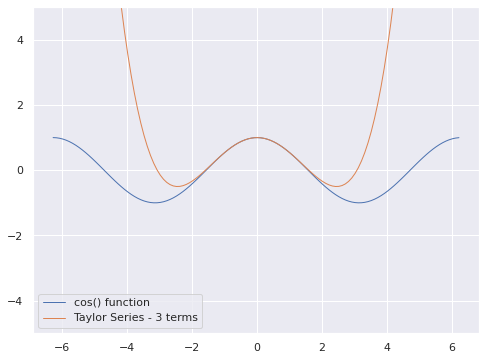

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(8, 6), "lines.linewidth": 1.0})

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)
t_cos = [func_cos(angle,3) for angle in angles]

fig, ax = plt.subplots()
ax.plot(angles,p_cos)
ax.plot(angles,t_cos)
ax.set_ylim([-5,5])
ax.legend(['cos() function','Taylor Series - 3 terms'])

plt.show()

We can use a for loop to see how much better adding additional terms to our Taylor Series approximation compares to Python's cos() function.

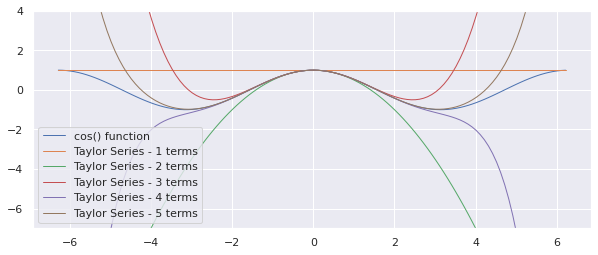

In [ ]:
#@title
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# if using a Jupyter notebook, include:
%matplotlib inline

sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)

fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()

We see the Taylor Series with 5 terms (the brown line) comes closest to approximating Python's cos() function. The Taylor Series with 5 terms is a good approximation of the cosine of angles between about −π
 and π
radians. The Taylor Series with 5 terms is a worse approximation for angles less than −π
 or greater than π
. As the angle gets further away from zero radians, the estimate of the cosine using a Taylor Series gets worse and worse.

###### *Laplace Transform*

https://www.youtube.com/watch?v=n2y7n6jw5d0

Difference Fourier (left) & Laplace (right):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_04.png)

Fourier (right - here it is including the negative numbers side) and Laplace (left):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_05.png)

If Alpha is swept through the plane, we get the entire Laplace transform plot

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_06.png)

Using a third dimension for the magnitudes, it looks like following. This is a Laplace Transform of the original function e<sup>-t</sup>sin*t

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_07.png)

Here the original function on left and the Fourier transform as blue slice for a given alpha within the Laplace transform:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_08.png)

Alpha equals the zero = the exponential in the Laplace function is just 1, and line yields the Fourier transform of the original function:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_09.png)

Here you can see how the Fourier transform is a slice of the Laplace Transform:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_10.png)

If we add all alpha beyond zero, we get the other slices. At the Fourier transform visualization on the right side with the blue slicer within the Laplace visualization. We see how the original function on the left side approaches a sinusoidal curve. Please consider only half of the Fourier slice to see just one large peak instead of two, as used above in Fourier transforms. 

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_11.png)



..and reaching a sinusoidal function with the Fourier visualization with infinite spikes (know as [**the poles**](https://de.wikipedia.org/wiki/Polstelle)) of the frequency on the right side:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_12.png)

Visualization of Laplace transform of above function on 2D (without z as third dimension to show height of peaks):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_13.png)

**Components of Laplace Transform**::

Sinosoidal component:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_01.png)

Exponential component:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_02.png)

Combination of both:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_03.png)

* shows which sinosoidal AND exponential frequencies are in a signal

* a generalized Fourier transform! Fourier transform is just a slice of the Laplace transform

* Fourier: input complex, output real. Laplace: Input complex, output complex (??)

**Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

**Laplace** $\quad X(s)=\int_{0}^{\infty} x(t) e^{-s t} d t$ 

with s = ${\alpha + i \omega}$

* Use Cases of Laplace transform: PDE to ODE, ODE to algebraic equation, control theory

* Following functions cannot be applied Fourier transform: e^lambda t or Heaviside function (because they don’t decay to zero (on y) on both sides to infinity (x)

Laplace intro:

https://www.youtube.com/watch?v=n2y7n6jw5d0&t=848s

https://youtu.be/ZGPtPkTft8g?t=356

https://www.youtube.com/watch?v=7UvtU75NXTg&list=LL&index=1&t=419s

https://www.youtube.com/watch?v=n2y7n6jw5d0

###### *Z-Transformation*

https://de.m.wikipedia.org/wiki/Z-Transformation

###### *Wavelets*

https://math.stackexchange.com/questions/279980/difference-between-fourier-transform-and-wavelets

##### <font color="blue">*Dynamical System*

###### *Overview & Summary*

https://en.m.wikipedia.org/wiki/Dynamical_systems_theory

https://de.m.wikipedia.org/wiki/Nichtlineare_Dynamik

https://en.m.wikipedia.org/wiki/Blue_sky_catastrophe

https://en.m.wikipedia.org/wiki/Cantor_function

https://www.youtube.com/watch?v=VxYcWn6AQsg

https://www.quantamagazine.org/mathematicians-identify-threshold-at-which-shapes-give-way-20210603/

https://www.youtube.com/watch?v=uzJXeluCKMs&t=91s

**Chaos**

*Chaotic deterministic systems*:

* deterministic: not random, but one clear outcome
* chaotic: no observable pattern on how they behave (aperiodic behavior over time)
* extremely sensitive to small changes in the initial conditions (also: it's impossible to know all the initial conditions with zero margin of error, like temperature until infinite decimal places)

Most important research task hence: **After what period of time it is simoly not worth to predict the future anymore?**

* Roots of chaos in differential equations and dynamical systems (how any physical system evolves in the real world)

**Dynamical System**

> **Dynamical system: involves one or more variables that change over time according to autonomous differential equations**.


> $\dot{x}=$ rate of change of $x$ as time changes

> $\dot{y}=$ rate of change of $y$ as time changes

They depend on t:

$\frac{d x}{d t}=$ rate of change of $x$ as time changes $\frac{d y}{d t}=$ rate of change of $y$ as time changes

but the differential equation that describe x dot and y dot don’t actually involve time t:

> $\dot{x}=-y-0.1 x$

> $\dot{y}=x-0.4 y$

This makes them autonomous. Each combination of x and y to only corresponds to one combination of x dot and y dot.

You can represent it in a dynamical system called the phase space. Each point in space is a unique state of the system. And has its own rate of change shown as a vector. 

For this specific system shown, the vector field looks like this, and let scatter a bunch of random points around to represent different possible states see how they evolve and move around: They all spiral towards the center.

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_01.png)

**Attractors**

> An attractor is a set of points in the phase space which attracts all the trajectories in an area surrounding it - the basin of attraction.

For the exampe above the attraction is zero, and the basin is every point in space. Notice that at the origin x dot and y dot also equal zero.

$\dot{x}=-(0)-0.1(0)=0$

$\dot{y}=(0)-0.4(0)=0$

The origin is in this case **fixed point (attractor)**, because every point in there will stay forever. It seem like an inevitability, hence determinism (as chaos is).

But there are also other types of attractors, like the Van der Pol oscillator:

> $\dot{x}=\mu\left(x-\frac{1}{3} x^{3}-y\right)$

> $\dot{y}=\frac{1}{\mu} x$

It creates something called: "**Limit Cycle Attractor**":

* it doesn't end up in a point

* typically appear in physical systems with some sort of oscillation (electrical circuits, tectonic plates, etc).

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_02.png)

**Strange Attractor**

Lorenz Attractor:

Lorenz system describes convection cycles in the atmoshphere. Very sensitive to changes in initial conditions already after a short time:

> $\dot{x}=\sigma(y-x)$

> $\dot{y}=x(\rho-z)-y$

> $\dot{z}=x y-\beta z$

The Lorenz equations have a few parameters that can be tweaked to alter the behavior of a system. This is what is known as ‘strange attractor’:

> $\dot{x}=10(y-x)$

> $\dot{y}=x(28-z)-y$

> $\dot{z}=x y-\frac{8}{3} z$

> **A strange attractor is and attractor that has a fractal dimension**

1. No point in the space is ever visited more than once by the same trajectory - it that happens, the trajectory would travel in a predictable loop. 
2. And no 2 trajectories will ever intersect. If that happened, they would merge into the same path, giving two different sets of initial conditions the same outcome.

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_03.png)

A single trajectory will visit an infinite number of points in this limited space, and this limited space will have an infinite number of trajectories. 

* Trajectories are just curved, so they should be 1-dimensional..normally!
* For the strange attractor: no matter how much you zoom in on this attractor, you can always find more and more trajectories everywhere.
* That’s why this attractor is said to have a **non integer dimension** - it’s **made up of infinite long curves in a finite space, which are so detailed, that they start to partially fill up higher dimensions**. It’s not 1, 2 or 3 dimensional, its somewhere in between. (=detail at arbitrarily small scales)

Conclusion: Lorenz attractor is a fractal space, and hence a strange attractor.

Differentiation: not every strange attractor is a chaotic attractor. But a lorenz attractor is both.

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_04.png)

Even is both points started at the same point, small initial differences can bring them to complete different paths:

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chros_05.png)

The difference in trajectories increases exponentially:

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_06.png)

**$\lambda$ stands for Lyapunov exponent**

$\lambda$ > 0, trajectories will increase exponentially (= chaotic)

$\lambda$ = 0, distance will stay constant

$\lambda$ < 0, distance will converge to zero.

Unfortunately there is no way to find the Lyapunov exponent only by looking at the equations. It is measured by running the simulation, keeping track of mainy pairs of trajectories, and find the average rate of change in their distance.

But it provides a simple metric to comunicate how chaotic a system is.

**For the Lorenz attractor it is $\lambda$ ≈ 0.9**

Used to find out duration in which the predictions are valid: "Predictability Horizon". We get this by re-arranging our previous equation $d_{t}=d_{0} e^{\lambda t}$:

> Predictability horizon $=\frac{1}{\lambda} \ln \frac{a}{d_{0}}$

$d_{0}=$ initial error 

$a=$ maximum allowed error

Fo the Lorenz attractor, after 10 time steps, any error would have multiplied by 8,000 already.

Example what that means with this exponential divergence:

We have a simulation that predicts where ocean currents flow, and you want to keep the error less than 1,000 km. 
* If you ran it twice, once an initial error of 1m and once the initial error was a million times smaller than one micrometer (0,000001m), how much longer  the simulation with the smaller error would stay below the margin of error.
* The simulation would be valid 9 days instead of 3 days, but for an initial error that is a million times smaller !!

Let’s write the expressions for the two predictability horizons, and put them in a fraction:

> $\frac{\left(\frac{1}{\lambda} \ln \frac{1000}{0.000001}\right)}{\left(\frac{1}{\lambda} \ln \frac{1000}{1}\right)}$

> = $\frac{\left(\frac{1}{\lambda} \ln 10^{9}\right)}{\left(\frac{1}{\lambda} \ln 10^{3}\right)}$

> = $\frac{\left(9 \cdot \frac{1}{\lambda} \ln 10\right)}{\left(3 \cdot \frac{1}{\lambda} \ln 10\right)}$

> = $\frac{9}{3}$. 

= It’s 3 times longer.


###### *Chaos Theory*

https://en.m.wikipedia.org/wiki/Chaos_theory

https://en.m.wikipedia.org/wiki/Lyapunov_time

https://en.m.wikipedia.org/wiki/Lyapunov_exponent

https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics

https://www.quantamagazine.org/chaos-theory-in-ecology-predicts-future-populations-20151013/

https://en.m.wikipedia.org/wiki/Phase_space

**Julia Set & Fatou Set**

https://en.m.wikipedia.org/wiki/Julia_set

https://en.m.wikipedia.org/wiki/Dynamical_system

https://en.m.wikipedia.org/wiki/Deterministic_system

Many phenomena in nature can be described by dynamical systems; chaos theory makes precise the ways in which many of these systems exhibit unpredictable yet still deterministic behavior.

https://en.m.wikipedia.org/wiki/Mathematics#Pure_mathematics

**Komplexes System**

* Complexity theory is rooted in chaos theory bzw: In a sense chaotic systems can be regarded as a subset of complex systems distinguished precisely by this absence of historical dependence. 

* Chaos is sometimes viewed as extremely complicated information, rather than as an absence of order.

* The emergence of complexity theory shows a domain between deterministic order and randomness which is complex. This is referred to as the ["edge of chaos"](https://en.wikipedia.org/wiki/Edge_of_chaos).

* **When one analyzes complex systems, sensitivity to initial conditions, for example, is not an issue as important as it is within chaos theory, in which it prevails.**

https://en.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory

* [Komplexe Systeme](https://de.wikipedia.org/wiki/Komplexes_System) sind Systeme (Gesamtheiten von Objekten, die sich in einem ganzheitlichen Zusammenhang befinden und durch die Wechselbeziehungen untereinander gegenüber ihrer Umgebung abzugrenzen sind), welche sich der Vereinfachung verwehren und vielschichtig bleiben. 

* Siehe auch [Systemeigenschaften#Komplexität](https://de.wikipedia.org/wiki/Systemeigenschaften#Komplexität)

* Insbesondere gehören hierzu die [komplexen adaptiven Systeme](https://de.wikipedia.org/wiki/Komplexes_adaptives_System), die imstande sind, sich an ihre Umgebung anzupassen.

* Ihre Analyse ist Sache der [Komplexitätstheorie](https://de.wikipedia.org/wiki/Komplexitätstheorie) (englisch complexity theory) bzw. Systemtheorie.

* Komplexe Systeme sind z. B. das Gehirn, das Internet, Finanzmärkte, multinationale Konzerne, aber eben auch das menschliche Nervensystem, der Mensch selbst, Infrastrukturnetze etc.

Komplexe Systeme zeigen eine Reihe von Eigenschaften (Auswahl):

1. **Agentenbasiert**: Komplexe Systeme bestehen aus einzelnen Teilen, die miteinander in Wechselwirkung stehen (Moleküle, Individuen, Software-Agenten etc.).
2. **Nichtlinearität**: Kleine Störungen des Systems oder minimale Unterschiede in den Anfangsbedingungen führen oft zu sehr unterschiedlichen Ergebnissen (Schmetterlingseffekt, Phasenübergänge). Die Wirkzusammenhänge der Systemkomponenten sind im Allgemeinen nichtlinear.
3. [**Emergenz**](https://de.wikipedia.org/wiki/Emergenz): Im Gegensatz zu lediglich komplizierten Systemen zeigen komplexe Systeme Emergenz. Entgegen einer verbreiteten Vereinfachung bedeutet Emergenz nicht, dass die Eigenschaften der emergierenden Systemebenen von den darunter liegenden Ebenen vollständig unabhängig sind. Emergente Eigenschaften lassen sich jedoch auch nicht aus der isolierten Analyse des Verhaltens einzelner Systemkomponenten erklären und nur sehr begrenzt ableiten.
4. **Wechselwirkung** (Interaktion): Die Wechselwirkungen zwischen den Teilen des Systems (Systemkomponenten) sind lokal, ihre Auswirkungen in der Regel global.
5. **Offenes System**: Komplexe Systeme sind üblicherweise offene Systeme. Sie stehen also im Kontakt mit ihrer Umgebung und befinden sich fern vom thermodynamischen Gleichgewicht. Das bedeutet, dass sie von einem permanenten Durchfluss von Energie bzw. Materie abhängen.
6. **Selbstorganisation**: Dies ermöglicht die Bildung insgesamt stabiler Strukturen (Selbststabilisierung oder Homöostase), die ihrerseits das thermodynamische Ungleichgewicht aufrechterhalten. Sie sind dabei in der Lage, Informationen zu verarbeiten bzw. zu lernen.
7. **Selbstregulation**: Dadurch können sie die Fähigkeit zur inneren Harmonisierung entwickeln. Sie sind also in der Lage, aufgrund der Informationen und derer Verarbeitung das innere Gleichgewicht und Balance zu verstärken.
8. **Pfade**: Komplexe Systeme zeigen Pfadabhängigkeit: Ihr zeitliches Verhalten ist nicht nur vom aktuellen Zustand, sondern auch von der Vorgeschichte des Systems abhängig.
9. **Attraktoren**: Die meisten komplexen Systeme weisen so genannte Attraktoren auf, d. h., dass das System unabhängig von seinen Anfangsbedingungen bestimmte Zustände oder Zustandsabfolgen anstrebt, wobei diese Zustandsabfolgen auch chaotisch sein können; dies sind die „seltsamen Attraktoren“ der Chaosforschung.

Some [complex systems](https://en.wikipedia.org/wiki/Complex_system), for example, are also [complex networks](https://en.wikipedia.org/wiki/Complex_network), which have properties such as phase transitions and power-law degree distributions that readily lend themselves to emergent or chaotic behavior. The fact that the number of edges in a [complete graph](https://en.wikipedia.org/wiki/Complete_graph) grows quadratically in the number of vertices sheds additional light on the source of complexity in large networks: as a network grows, the number of relationships between entities quickly dwarfs the number of entities in the network.

###### *Fractal Dimensions*

*Properties & Definition of Fractal Geometry*

* a [fractal](https://en.m.wikipedia.org/wiki/Fractal) is a subset of Euclidean space with a fractal dimension that strictly exceeds its topological dimension. Fractals appear the same at different scales, as illustrated in successive magnifications of the Mandelbrot set.

* Fractals exhibit similar patterns at increasingly smaller scales, a property called self-similarity, also known as expanding symmetry or unfolding symmetry; if this replication is exactly the same at every scale, as in the Menger sponge,it is called affine self-similar. 

* Fractal geometry lies within the mathematical branch of measure theory.

What is a fractal dimension? https://youtu.be/yQfu8jSo5b0

**Self-Similarity**

Fractals are typiclly not self-similar! https://youtu.be/gB9n2gHsHN4

https://en.m.wikipedia.org/wiki/Self-similarity

**Self-Orgainzation**

https://en.m.wikipedia.org/wiki/Self-organization

**Feedback Loops**

https://en.m.wikipedia.org/wiki/Feedback

*Ways of determining the fractal dimension of a set S in a Euclidean space $R^n$*

https://de.m.wikipedia.org/wiki/Fraktale_Dimension

*Packing dimension*

* the [packing dimension](https://en.m.wikipedia.org/wiki/Packing_dimension) is one of a number of concepts that can be used to define the dimension of a subset of a metric space. 

* Packing dimension is in some sense dual to Hausdorff dimension, since packing dimension is constructed by "packing" small open balls inside the given subset, whereas Hausdorff dimension is constructed by covering the given subset by such small open balls.

*Effective Dimension*

* [effective dimension](https://en.m.wikipedia.org/wiki/Effective_dimension) is a modification of Hausdorff dimension and other fractal dimensions which places it in a computability theory setting.

* There are several variations (various notions of effective dimension) of which the most common is effective Hausdorff dimension.

* **Hausdorff dimension generalizes the well-known integer dimensions assigned to points, lines, planes, etc. by allowing one to distinguish between objects of intermediate size between these integer-dimensional objects.** 

* For example, [fractal](https://en.m.wikipedia.org/wiki/List_of_fractals_by_Hausdorff_dimension) subsets of the plane may have intermediate dimension between 1 and 2, as they are "larger" than lines or curves, and yet "smaller" than filled circles or rectangles. 

* Effective dimension modifies Hausdorff dimension by requiring that objects with small effective dimension be not only small but also locatable (or partially locatable) in a computable sense. As such, objects with large Hausdorff dimension also have large effective dimension, and objects with small effective dimension have small Hausdorff dimension, but an object can have small Hausdorff but large effective dimension. 

* An example is an algorithmically random point on a line, which has Hausdorff dimension 0 (since it is a point) but effective dimension 1 (because, roughly speaking, it can't be effectively localized any better than a small interval, which has Hausdorff dimension 1).

*Hausdorff dimension*

* Hausdorff dimension is a measure of roughness, or more specifically, fractal dimension, that was first introduced in 1918 by mathematician Felix Hausdorff.

* For instance, the Hausdorff dimension of a single point is zero, of a line segment is 1, of a square is 2, and of a cube is 3. That is, for sets of points that define a smooth shape or a shape that has a small number of corners—the shapes of traditional geometry and science—the Hausdorff dimension **is an integer agreeing with the usual sense of dimension, also known as the [topological dimension (inductive dimension)](https://en.m.wikipedia.org/wiki/Inductive_dimension)**. 

* However, formulas have also been developed that allow calculation of the dimension of other less simple objects, where, solely on the basis of their properties of scaling and self-similarity, one is led to the conclusion that particular objects—including fractals—have non-integer Hausdorff dimensions. 

* Because of the significant technical advances made by Abram Samoilovitch Besicovitch allowing computation of dimensions for highly irregular or "rough" sets, this dimension is also commonly referred to as the Hausdorff–Besicovitch dimension.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/KochFlake.svg/362px-KochFlake.svg.png)

*Example of non-integer dimensions. The first four iterations of the Koch curve, where after each iteration, all original line segments are replaced with four, each a self-similar copy that is 1/3 the length of the original. One formalism of the Hausdorff dimension uses this **scale factor** (3) and the number of **self-similar** objects (4) to calculate the dimension, D, after the first iteration to be D = (log N)/(log S) = (log 4)/(log 3) ≈ 1.26. That is, while the Hausdorff dimension of a single point is zero, of a line segment is 1, of a square is 2, and of a cube is 3, for fractals such as this, the object can have a non-integer dimension.*

**Haussdorf Dimension vs Lebesgue covering (topological) dimension**

* Every space filling curve hits some points multiple times, and does not have a continuous inverse. It is impossible to map two dimensions onto one in a way that is continuous and continuously invertible. The topological dimension, also called Lebesgue covering dimension, explains why. This dimension is n if, in every covering of X by small open balls, there is at least one point where n + 1 balls overlap. For example, when one covers a line with short open intervals, some points must be covered twice, giving dimension n = 1.

* But topological dimension is a very crude measure of the local size of a space (size near a point). A curve that is almost space-filling can still have topological dimension one, even if it fills up most of the area of a region. A fractal has an integer topological dimension, but in terms of the amount of space it takes up, it behaves like a higher-dimensional space.

https://en.m.wikipedia.org/wiki/Hausdorff_dimension

https://en.m.wikipedia.org/wiki/Lebesgue_covering_dimension

https://en.m.wikipedia.org/wiki/Inductive_dimension

*Minkowski–Bouligand dimension (Box Counting Dimension)*

The [Minkowski–Bouligand dimension](https://en.m.wikipedia.org/wiki/Minkowski–Bouligand_dimension), also known as Minkowski dimension or box-counting dimension, is a way of determining the fractal dimension of a set S in a Euclidean space Rn, or more generally in a metric space (X, d). I

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Great_Britain_Box.svg/640px-Great_Britain_Box.svg.png)

*Information dimension*

In [information theory](https://en.m.wikipedia.org/wiki/Information_dimension), information dimension is an information measure for random vectors in Euclidean space, based on the normalized entropy of finely quantized versions of the random vectors. This concept was first introduced by Alfréd Rényi in 1959.

Simply speaking, it is a measure of the fractal dimension of a probability distribution. It characterizes the growth rate of the Shannon entropy given by successively finer discretizations of the space.

In 2010, Wu and Verdú gave an operational characterization of [Rényi information dimension](https://en.m.wikipedia.org/wiki/Rényi_entropy) as the fundamental limit of almost [lossless data compression](https://en.m.wikipedia.org/wiki/Lossless_compression) for analog sources under various regularity constraints of the encoder/decoder.

*Rényi entropy*

* In information theory, the [Rényi entropy](https://en.m.wikipedia.org/wiki/Rényi_entropy) generalizes the Hartley entropy, the Shannon entropy, the collision entropy and the min-entropy. Entropies quantify the diversity, uncertainty, or randomness of a system. The entropy is named after Alfréd Rényi.

* **In the context of fractal dimension estimation, the Rényi entropy forms the basis of the concept of generalized dimensions.**

* The Rényi entropy is important in ecology and statistics as index of diversity. The Rényi entropy is also important in quantum information, where it can be used as a measure of entanglement. In the Heisenberg XY spin chain model, the Rényi entropy as a function of α can be calculated explicitly by virtue of the fact that it is an [automorphic function](https://en.m.wikipedia.org/wiki/Automorphic_function) with respect to a particular subgroup of the [modular group](https://en.m.wikipedia.org/wiki/Modular_group). In theoretical computer science, the min-entropy is used in the context of randomness extractors.

*List of fractals by Hausdorff dimension*

Benoit Mandelbrot has stated that "A fractal is by definition a set for which the Hausdorff-Besicovitch dimension strictly exceeds the topological dimension." Presented here is a list of fractals ordered by increasing Hausdorff dimension, with the purpose of visualizing what it means for a fractal to have a low or a high dimension

Deterministic fractals

* Julia set

* Logistic map (Feigenbaum Attractor)

* Peano curve

* Pentaflake

* 3D Hilbert curve

* and many more..

Random and natural fractals

* Zeros of a Wiener process

* Brownian motion

* Coastline of Ireland, Great Britain or Norway

* von Koch curve with random orientation

* The surface of Broccoli, or human brain

* Distribution of [galaxy clusters](https://en.m.wikipedia.org/wiki/Galaxy_cluster)

* and more..

https://en.m.wikipedia.org/wiki/List_of_fractals_by_Hausdorff_dimension

https://www.youtube.com/watch?v=gB9n2gHsHN4

https://www.youtube.com/watch?v=FFftmWSzgmk

https://de.wikipedia.org/wiki/Fraktal

* idealization is everything is smooth (rebellion against calculus, differentiable, where assumption is things look smooth if you zoom in enough)

* Mandelbrot: nature is fractal (capture roughness)

* self-similar shapes give a basis for modeling the regularity in some forms of roughness 

* but that doesn't mean all is only perfectly self-similar either!! (Perfect self similar are: Von Koch snowflake, Sierpensky triangle)

* Fractal dimension: Sierpensky triangle is 1,585 dimensional, Von Koch snowflake is 1,262 dimensional, Britain coast line 1,21 dimensional, Norway: 1,52 dimensional, calm sea 2,05 dimensional, waves 2,3 dimensional

* **Fractals are shapes with a non-integer dimension, captures idea of roughness,  but dimension can vary depending on how much you zoom in**. 

* Approaches: 

	* Box routing dimension
	* Information dimension
	* Hausdorff dimension
	* Packing dimension

* But a shape is considered a fractal only when the measures dimension stays approximately constant across multiple different scales

* **Is it fractal? Yes - probably from nature, No - probably man-made**

*Fractal curves & Space-filling curve*

**Fractal curves**

A [fractal curve](https://en.m.wikipedia.org/wiki/Fractal_curve) is, loosely, a mathematical curve whose shape retains the same general pattern of irregularity, regardless of how high it is magnified, that is, its graph takes the form of a fractal.

In general, fractal curves are nowhere rectifiable curves — that is, **they do not have finite length** — and every subarc longer than a single point has infinite length.

An extremely famous example is the boundary of the Mandelbrot set.

**Space-filling curve**

[Space-filling curves](https://en.m.wikipedia.org/wiki/Space-filling_curve) are special cases of fractal curves. No differentiable space-filling curve can exist. Roughly speaking, differentiability puts a bound on how fast the curve can turn.

https://youtu.be/3s7h2MHQtxc

* Hilbert curve and Peano curve are examples of deterministic fractals

*Three iterations of the Peano curve construction, whose limit is a space-filling curve.*

![hhh](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Peanocurve.svg/640px-Peanocurve.svg.png)

* a [space-filling curve](https://en.m.wikipedia.org/wiki/Space-filling_curve) is a curve whose range contains the entire 2-dimensional unit square (or more generally an n-dimensional unit hypercube).

* space-filling curves in the 2-dimensional plane are sometimes called Peano curves, but that phrase also refers to the [Peano curve](https://en.m.wikipedia.org/wiki/Peano_curve), the specific example of a space-filling curve found by Peano.

* In particular, the S2 cells are ordered sequentially along a space-filling curve (a type of fractal). The particular curve used by S2 is called the S2 space-filling curve, and consists of six Hilbert curves linked together to form a single continuous loop over the entire sphere. Here is an illustration of the S2 curve after 5 levels of subdivision:

*Fractal Sets*

http://www.malinc.se/m/Lorenz.php

*Mandelbrot Set*

Mandelbrot set: https://youtu.be/FFftmWSzgmk

*Julia Set*

The Mandelbrot set is kind of like a map of Julia sets

https://de.m.wikipedia.org/wiki/Julia-Menge

https://de.m.wikipedia.org/wiki/Newtonfraktal

*Logistic Map & Feigenbaum Constant*

https://de.m.wikipedia.org/wiki/Logistische_Gleichung

https://de.m.wikipedia.org/wiki/Feigenbaum-Konstante

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/LogisticMap_BifurcationDiagram.png/640px-LogisticMap_BifurcationDiagram.png)

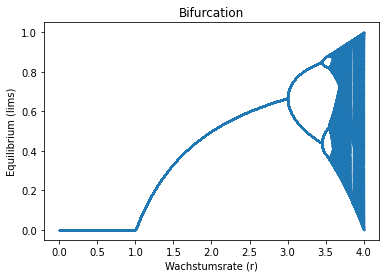

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N_points = 4000000
N_steps = 500
r = np.linspace(0,4,N_points)
y = np.random.uniform(0,1,size=N_points)

for _ in range(N_steps):
    y = r*y*(1-y)
    
fig, biax = plt.subplots()
biax.plot(r, y, '.-', linewidth=0, markersize=0.25)
biax.set(xlabel='Wachstumsrate (r)', ylabel='Equilibrium (lims)', title='Bifurcation')
plt.show()

https://youtu.be/ovJcsL7vyrk

This bifurcation diagram is part of the Mandelbrot set, but turned around and seen from the side

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/mandelbrot_01.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/mandelbrot_02.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/mandelbrot_03.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/mandelbrot_04.jpg)

###### *Dynamisches System*

*Definition & Properties*

> **A dynamical system involves one or more variables that change over time according to autonomous differential equations.**

https://en.m.wikipedia.org/wiki/Dynamical_systems_theory

* Ein (deterministisches) [dynamisches System](https://de.wikipedia.org/wiki/Dynamisches_System) ist ein mathematisches Modell eines zeitabhängigen Prozesses, der homogen bezüglich der Zeit ist, dessen weiterer Verlauf also nur vom Anfangszustand, aber nicht von der Wahl des Anfangszeitpunkts abhängt. 

* Dynamische Systeme finden vielfältige Anwendungen auf Prozesse in der Mathematik (z. B. Zahlentheorie, Stochastik), in der Physik (z. B. Pendelbewegung, Klimamodelle) oder in der theoretischen Biologie (z. B. Räuber-Beute-Modelle).

* Man unterscheidet zwischen **diskreter und kontinuierlicher Zeitentwicklung**. Bei einem zeitdiskreten dynamischen System ändern sich die Zustände in äquidistanten Zeitsprüngen, d. h. in aufeinanderfolgenden, stets gleich großen zeitlichen Abständen, während die Zustandsänderungen eines zeitkontinuierlichen dynamischen Systems in infinitesimal kleinen Zeitschritten stattfinden. Das wichtigste Beschreibungsmittel für zeitkontinuierliche dynamische Systeme sind **autonome gewöhnliche Differenzialgleichungen**.

* Wichtige Fragestellungen im Zusammenhang mit dynamischen Systemen betreffen vor allem ihr Langzeitverhalten (zum Beispiel [Stabilität](https://de.wikipedia.org/wiki/Stabilitätstheorie), [Periodizität](https://de.wikipedia.org/wiki/Periodische_Funktion), [Chaos](https://de.wikipedia.org/wiki/Chaosforschung) und [Ergodizität](https://de.wikipedia.org/wiki/Ergodizität)), die [Systemidentifikation](https://de.wikipedia.org/wiki/Systemidentifikation) und ihre [Regelung](https://de.wikipedia.org/wiki/Regelung_(Natur_und_Technik)).

* [Dynamik](https://de.wikipedia.org/wiki/Systemeigenschaften#Dynamik) ist gekennzeichnet durch das zeitliche Verhalten des Systems. Statische Systeme zeigen ohne Einflüsse von außen sowohl auf der Makroebene als auch auf der Mikroebene keine Veränderungen (Beispiel: ruhendes Pendel). Dynamische Systeme sind auf der Mikroebene dauernden Veränderungen unterworfen, können aber zumindest zeitweise auf der Makroebene einen stationären Zustand einnehmen (Beispiele: chemische Gleichgewichtsreaktion, Ökosystem Wald). **Ob ein System als statisch oder dynamisch betrachtet wird, hängt vom Zeitmaßstab und von der Zeitdauer der Beobachtung des Systems ab.** Dies wird deutlich bei Systemen im Gleichgewicht, die aber um ihre Gleichgewichtslage schwanken: Ist der Beobachtungszeitraum zu kurz, kann nicht ermittelt werden, ob es sich um Schwankungen um einen Mittelwert handelt oder ob ein ansteigender oder absinkender Trend vorliegt (Beispiel: Klimaschwankungen seit Beginn der direkten Messungen). Wird ein sehr großer Maßstab gewählt, sind die Schwankungen gar nicht feststellbar; das System verhält sich scheinbar statisch.

Ein dynamisches System ist ein Tripel $(T, X, \Phi)$, bestehend aus 

* **Zeitraum**: einer Menge $T=\mathbb{N}_{0}, \mathbb{Z}, \mathbb{R}_{0}^{+}$ oder $\mathbb{R}$, 
* **Zustandsraum** (dem Phasenraum): einer nichtleeren Menge $X$, 
* **Operation** $\Phi: T \times X \rightarrow X$ von $T$ auf $X,$ 

so dass für alle Zustände $x \in X$ und alle Zeitpunkte $t, s \in T$ gilt:

1. **Identitätseigenschaft**: $\Phi(0, x)=x$

2. **Halbgruppeneigenschaft**: $\Phi(s, \Phi(t, x))=\Phi(s+t, x)$

Wenn $T=\mathbb{N}_{0}$ oder $T=\mathbb{Z}$ ist, dann heißt $(T, X, \Phi)$ **zeitdiskret** oder kurz diskret, und mit $T=\mathbb{R}_{0}^{+}$ oder $T=\mathbb{R}$ nennt man $(T, X, \Phi)$ **zeitkontinuierlich** oder kontinuierlich. 

$(T, X, \Phi)$ wird außerdem als diskretes oder kontinuierliches dynamisches System für reelle Zeit oder als invertierbar bezeichnet, falls $T=\mathbb{Z}$ bzw. $T=\mathbb{R}$ gilt.

* Für jedes $x \in X$ heißt die Abbildung $\beta_{x}: T \rightarrow X, t \mapsto \beta_{x}(t):=\Phi(t, x)$ die Bewegung von $x=\beta_{x}(0),$ und
die Menge $O(x):=\left\{\beta_{x}(t) \mid t \in T\right\}$ wird die Bahn (der (volle) Orbit, die Trajektorie, die Phasenkurve, die Bahnkurve, die Lösungskurve) von $x$ genannt. 

* Der positive Halborbit oder Vorwärtsorbit von $x$ ist $O^{+}(x):=\left\{\beta_{x}(t) \mid t \in T \cap \mathbb{R}_{0}^{+}\right\}$ und, falls $(T, X, \Phi)$ invertierbar ist, ist
$O^{-}(x):=\left\{\beta_{x}(t) \mid-t \in T \cap \mathbb{R}_{0}^{+}\right\}$ der negative Halborbit oder
Rückwärtsorbit von $x .$

* Ein diskretes dynamisches System $(T, X, \Phi)$ ist stetig, wenn sein Zustandsraum $X$ ein (nichtleerer) **metrischer Raum** ist und wenn jede zu einem Zeitpunkt $t \in T$ gehörende Transformation $\varphi_{t}: X \rightarrow X, x \mapsto \varphi_{t}(x):=\Phi(t, x),$ stetig ist.

* Man nennt ein kontinuierliches dynamisches System $(T, X, \Phi)$ stetig oder einen [Halbfluss](https://de.wikipedia.org/wiki/Fluss_(Mathematik)), wenn sein Zustandsraum $X$ ein metrischer Raum ist und wenn
jede zu einem Zeitpunkt gehörende Transformation sowie jede Bewegung eines Zustands stetig ist. 

* Außerdem nennt man ein stetiges diskretes dynamisches System $(\mathbb{Z}, X, \Phi)$ auch eine Kaskade und einen Halbfluss $(\mathbb{R}, X, \Phi)$ einen Fluss. 

* Der Zustandsraum eines stetigen dynamischen Systems wird auch als [Phasenraum](https://de.wikipedia.org/wiki/Phasenraum) und von jedem $x_{0} \in X$ der Orbit als die Phasenkurve oder Trajektorie von $x_{0}$ bezeichnet, die einfach $x: t \mapsto x(t)$ geschrieben wird mit $x(0)=x_{0}$.

*Beispiele: Exponentielles Wachstum & Federpendel*

**Beispiel: Exponentielles Wachstum**

Die charakterisierende Eigenschaft eines dynamischen Systems ist, dass **der Zustand zwar von der verstrichenen Zeit $t \in T$ und vom Anfangswert $x_{0} \in X$ abhängt, jedoch nicht von der Wahl der Anfangszeitpunkts**. 

Sei etwa $y_{0}, y_{1}, y_{2}, \ldots$ eine weitere exponentiell wachsende Population mit dem gleichen Wachstumsfaktor $a$, aber mit dem Anfangswert $y_{0}=x_{t}$ gegeben. Zu einem Zeitpunkt $s \in T$ gilt dann

>$
y_{s}=a^{s} y_{0}=a^{s} a^{t} x_{0}=a^{s+t} x_{0}=x_{s+t}
$

Die zweite Population wächst also im Zeitabschnitt $[0, s]$ genauso wie die erste im Zeitabschnitt $[t, s+t]$. 

Dieses Verhalten lässt sich noch anders ausdrücken: Die sogenannte **Flussfunktion** $\Phi: T \times X \rightarrow X$, die jedem Zeitpunkt $t \in T$ und jedem Anfangszustand $x \in X$ den Zustand $\Phi(t, x)$ zum Zeitpunkt $t$ zuordnet, hier also $\Phi(t, x)=a^{t} x,$ erfüllt für alle $s, t \in T$ und alle $x \in X$ die Gleichung

>$
\Phi(s, \Phi(t, x))=\Phi(s+t, x)
$

Das ist die sogenannte **Halbgruppeneigenschaft des Flusses eines dynamischen Systems**.

**Beispiel: Federpendel**

Der Zustand eines solchen Systems zu einem Zeitpunkt $t \in T=[0, \infty)$ ist gegeben als das geordnete Paar $(x(t), v(t))$, bestehend aus dem Ort $x(t)$ und der Geschwindigkeit $v(t)$. Insbesondere ist dann **der gesamte Bewegungsablauf durch die Vorgabe einer Anfangsposition $x(0)=x_{0}$ zusammen mit einer Anfangsgeschwindigkeit $v(0)=v_{0}$ eindeutig bestimmt** (daher deterministisch und nicht stochastisch!). Im Fall einer eindimensionalen Bewegung ist somit der Zustandsraum $X=\mathbb{R}^{2}$.

Als konkretes Beispiel soll ein Federpendel betrachtet werden, auf dessen Massestück mit der Masse $m$ die Rückstellkraft der Feder sowie möglicherweise eine geschwindigkeitsabhängige Reibungskraft einwirkt. Bezeichnet man die Gesamtkraft mit $F(x(t), v(t)),$ so ergibt sich für den Zustand das gewöhnliche Differentialgleichungssystem

>$
\begin{aligned}
\dot{x}(t) &=v(t) \\
\dot{v}(t) &=\frac{1}{m} F(x(t), v(t))
\end{aligned}
$

wobei der Punkt über den Variablen die Ableitung nach der - in diesem Beispiel kontinuierlichen - Zeit bezeichnet. Die erste Gleichung besagt, dass die
Geschwindigkeit die Ableitung des Ortes nach der Zeit ist, und die zweite ergibt sich direkt aus dem zweiten newtonschen Axiom, nach dem Masse mal Beschleunigung gleich der auf den Massepunkt wirkenden Gesamtkraft ist.

Es lässt sich zeigen, dass auch bei diesem System der Fluss

>$
\Phi: T \times X \rightarrow X, \quad \Phi\left(t, x_{0}, v_{0}\right)=(x(t), v(t))
$

die **Halbgruppeneigenschaft** erfüllt. Betrachtet man den Verlauf des Systemzustandes im Zustandsraum $X=\mathbb{R}^{2},$ also die sogenannte $\mathrm{Bahn}$ $\left\{(x(t), v(t)) \in \mathbb{R}^{2} \mid t \geq 0\right\},$ so ergibt sich bei einer **gedämpften Schwingung des Federpendels eine Trajektorie**, die spiralförmig auf die Ruhelage (0,0) zuläuft.

*Phasenraum und Trajektorie*

* Der [Phasenraum](https://de.wikipedia.org/wiki/Phasenraum) beschreibt die Menge aller möglichen Zustände eines dynamischen Systems. Ein Zustand wird durch einen Punkt im Phasenraum eindeutig abgebildet. 

* In der Mechanik besteht er aus verallgemeinerten Koordinaten (Konfigurationsraum) und zugehörigen verallgemeinerten Geschwindigkeiten (siehe Prinzip der virtuellen Leistung).

* Die zeitliche Entwicklung eines Punktes im Phasenraum wird durch **Differentialgleichungen** beschrieben und durch **Trajektorien** (Bahnkurven, Orbit) im Phasenraum dargestellt. Dies sind **Differentialgleichungen erster Ordnung in der Zeit** und durch einen Anfangspunkt eindeutig festgelegt (ist die Differentialgleichung zeitunabhängig, sind dies **autonome Differentialgleichungen**). Dementsprechend kreuzen sich zwei Trajektorien im Phasenraum auch nicht, da an einem Kreuzungspunkt der weitere Verlauf nicht eindeutig ist. Geschlossene Kurven beschreiben oszillierende (periodische) Systeme.


*Konstruktion eines Phasen(raum)porträts für ein [mathematisches Pendel](https://de.wikipedia.org/wiki/Mathematisches_Pendel)*

![hh](https://upload.wikimedia.org/wikipedia/commons/c/cd/Pendulum_phase_portrait_illustration.svg)

*Fluss*

* Das Konzept eines [(Phasen-)Flusses](https://de.wikipedia.org/wiki/Fluss_(Mathematik)) in der Mathematik ermöglicht die **Beschreibung zeitabhängiger (System-)Zustände**. Es ist deshalb vor allem für die **Analyse gewöhnlicher Differentialgleichungen** von Bedeutung und findet damit Anwendung in vielen Bereichen der Mathematik und Physik. 

* Formal ist der Fluss eine Operation einer Parameterhalbgruppe $(\Gamma,+)$ auf einer Menge
$X$. Meist, insbesondere in der Theorie der Gewöhnlichen Differentialgleichungen, wird unter einem Fluss eine Operation der Halbgruppe $\left(\mathbb{R}_{\geq 0},+\right)$ verstanden.

* Im Hinblick auf die Analyse dynamischer Systeme beschreibt der Fluss die **Bewegung im Phasenraum im Laufe der Zeit**. Hierbei spricht man in Abhängigkeit von der Parametermenge $\Gamma$ von einem kontinuierlichen dynamischen System $(\Gamma=\mathbb{R})$ oder einem diskreten dynamischen System $\Gamma=\mathbb{N})$


Betrachten wir ein System gewöhnlicher Differentialgleichungen

>$
\dot{\mathbf{x}}=\mathbf{F}(t, \mathbf{x})
$

mit $\mathbf{x} \in \mathbb{R}^{n}$ oder einer offenen Teilmenge davon, so werden durch den Phasenfluss die Lösungen dieses Systems in Abhängigkeit vom Anfangszustand angegeben. Man wählt dann oft auch eine implizite Form der Flussangabe und schreibt
$\mathbf{x}(t)$ bzw. $\mathbf{x}(0)$

Sei $X$ eine Menge, $\Gamma$ eine Parametermenge. Eine Abbildung

>$
\varphi: X \times \Gamma \rightarrow X
$

heißt Fluss, wenn die folgenden Bedingungen erfüllt sind:

>$
\varphi(x, 0)=x \forall x \in X
$

und

>$
\varphi(\varphi(x, s), t)=\varphi(x, s+t) \forall x \in X, s, t \in \Gamma
$

Wir haben also eine [Halbgruppenwirkung](https://de.wikipedia.org/wiki/Halbgruppe).
Die Menge

>$
\mathcal{O}(x, \varphi):=\{\varphi(x, t) \mid t \in \Gamma\}
$

heißt [Orbit](https://de.wikipedia.org/wiki/Gruppenoperation#Bahn) (Gruppenoperation: Bahn) von $x$. Falls die Abbildung $\varphi: X \times \Gamma \rightarrow X$ differenzierbar ist, spricht man auch von einem differenzierbaren Fluss.

https://www.quantamagazine.org/with-arithmetic-dynamics-mathematicians-unlock-new-insights-20210222

https://en.m.wikipedia.org/wiki/Arithmetic_dynamics

*Determiniertheit in einem System*

* Die [Determiniertheit (als Systemeigenschaft)](https://de.wikipedia.org/wiki/Systemeigenschaften#Determiniertheit) ist der Grad der „Vorbestimmtheit“ des Systems: Ein System geht von einem Zustand Z1 in den Zustand Z2 über: Z1 → Z2. Bei deterministischen Systemen ist dieser Übergang bestimmt (zwingend), bei stochastischen wahrscheinlich.

* Deterministische Systeme erlauben prinzipiell die Ableitung ihres Verhaltens aus einem vorherigen Zustand, stochastische Systeme nicht. 

* Klassische deterministische Systeme erlauben eine eindeutige Bestimmung ihres Zustandes zu jedem Zeitpunkt der Vergangenheit und Zukunft mit hinreichender Genauigkeit (Beispiel: Planetenbewegung). 

* Hinreichend ist hier bezogen auf menschlich überschaubare, bzw. relevante Zeiträume und Größenordnungen. Die Entwicklung chaotischer Systeme ist nicht immer eindeutig bestimmbar, da alle Parameter mit theoretisch unendlich großer Genauigkeit bekannt sein müssen, sie sind empfindlich gegenüber den Anfangsbedingungen. 

* Mit geeigneten (mathematischen) Modellen lassen sich relevante Aussagen über Vergangenheit und Zukunft von deterministischen und stochastischen Systemen machen. 

* **Aus der Komplexität eines Systems lässt sich keine Aussage über die Vorhersagbarkeit treffen**: Es gibt einfache deterministische Systeme, die chaotisch sind (z. B. Doppelpendel) und komplexe deterministische Systeme (Chloroplasten bei der Photosynthese).


*Weitere Properties*

**Ergodizität**

https://de.m.wikipedia.org/wiki/Ergodizität

**Stabilitätstheorie**

https://de.m.wikipedia.org/wiki/Stabilitätstheorie

**Periodizität**

https://de.m.wikipedia.org/wiki/Periodische_Funktion

###### *Attraktor*

**Definition & Properties**

* [Attraktor](https://de.wikipedia.org/wiki/Attraktor) ist ein Begriff aus der Theorie dynamischer Systeme und beschreibt **eine Untermenge eines Phasenraums** (d. h. eine gewisse Anzahl von Zuständen), auf die sich ein dynamisches System im Laufe der Zeit zubewegt und die unter der Dynamik dieses Systems nicht mehr verlassen wird. 

* Das heißt, eine Menge von Variablen nähert sich im Laufe der Zeit (asymptotisch) einem bestimmten Wert, einer Kurve oder etwas Komplexerem (also einer Region im n-dimensionalen Raum) und bleibt dann im weiteren Zeitverlauf in der Nähe dieses Attraktors.

* Bekannte Beispiele sind der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor), der [Rössler-Attraktor](https://de.wikipedia.org/wiki/R%C3%B6ssler-Attraktor) und die [Nullstellen](https://de.wikipedia.org/wiki/Nullstelle) einer differenzierbaren Funktion, welche Attraktoren des zugehörigen Newton-Verfahrens sind.

* Die Menge aller Punkte des Phasenraums, die unter der Dynamik demselben Attraktor zustreben, heißt Attraktions- oder Einzugsgebiet dieses Attraktors.






Unter einem Attraktor versteht man eine Teilmenge $A \subseteq X$,
die den folgenden Bedingungen genügt
1. $A$ ist vorwärts invariant;
2. Das Sammelbecken $B(A)$ ist eine Umgebung von $A$;
3. $A$ ist eine minimale nicht leere Teilmenge von $X$ mit Bedingungen 1
und 2 .

Bedingung 1 erfordert eine gewisse Stabilität des Attraktors. Daraus folgt offensichtlich, dass $A \subseteq B(A)$. Anhand Bedingung 2 wird weiterhin verlangt, dass $A \subseteq B(A)^{\circ}$ und bedeutet u. a., jeder Punkt in einer gewissen Nähe von $A$ nähere sich dem Attraktor beliebig. Manche Autoren lassen Bedingung 2 weg. Bedingung 3 erfordert, dass der Attraktor nicht in weitere Komponenten zerlegt werden kann (ansonsten
wäre bspw. der ganze Raum trivialerweise ein Attraktor).

Formal betrachte man ein **dynamisches System** bestehend aus einem topologischen Raum $X$ und einer Transformation $f: \mathcal{T} \times X \longrightarrow X$, wobei $\mathcal{T}$ ein linear geordnetes Monoid ist wie $\mathcal{T}=\mathbb{N}, \mathbb{Z},[0, \infty[$ oder $\mathbb{R}$ und $f$ normalerweise stetig oder mindestens messbar ist (oder mindestens wird verlangt, dass $f(t, \cdot): X \longrightarrow X$ stetig/messbar ist für jedes $t \in \mathcal{T}$ ) und erfüllt
$f(t+s, x)=f(t, f(s, x))$ für alle »Zeiten « $t, s \in \mathcal{T}$
und Punkte $x \in X$.

**Definition 1**. Eine Teilmenge $A \subseteq X$ heißt dann vorwärts
invariant, wenn

>$
\forall t \geq 0: f(t, A) \subseteq A
$

Mit anderen Worten sobald ein Punkt in einen Attraktor
gelangt, entkommt er der Teilmenge nicht.

**Definition 2**. Unter dem Sammelbecken einer Teilmenge
$A \subseteq X$ versteht man die Menge

>$
B(A):=\left\{x \in X \mid \forall U \in \mathcal{N}(A): \exists t_{0} \geq 0: \forall t \geq t_{0}:\right.
$

wobei $\mathcal{N}(A)$ die Menge der Umgebungen von $A$ ist. Mit Worten ist ein Punkt, $x \in X$, in $B(A)$ genau dann, wenn für alle Umgebungen $U$ von $A$ dieser Punkt ab einem Zeitpunkt sich immer in dieser Umgebung aufhält.

**Bemerkung**. Im Falle eines kompakten metrisierten Raums $(X, d)$ ist diese Definition äquivalent zu

>$
B(A):=\left\{x \in X \mid \lim _{t \rightarrow \infty} d(f(t, x), A)=0\right\}
$

**Bemerkung**. Angenommen, der Raum sei metrisierbar und $A$
sei kompakt. Aus der Definition eines Sammelbeckens geht hervor, dass $B(A)$ vorwärts invariant ist und $\bigcap\{f(t, B(A)) \mid t>0\}=\bar{A}$. Manche Autoren definieren das Sammelbecken als die (offene) Menge mit diesen beiden Eigenschaften.


**Dynamische Systeme beschreiben Zustandsänderungen in Abhängigkeit von der Zeit t**. Für die mathematische Definition wird das reale System oft in der stark vereinfachten Form eines mathematischen Modells betrachtet. Beispiele sind

* das Strömungsverhalten von Flüssigkeiten und Gasen
* Bewegungen von Himmelskörpern unter gegenseitiger Beeinflussung durch die Gravitation
* Populationsgrößen von Lebewesen unter Berücksichtigung der Räuber-Beute-Beziehung oder
* die Entwicklung wirtschaftlicher Kenngrößen unter Einfluss der Marktgesetze.

Das Langzeitverhalten eines dynamischen Systems lässt sich durch den globalen Attraktor beschreiben, da bei physikalischen oder technischen Systemen oft **Dissipation vorliegt, insbesondere Reibung**.

**Jeder Zustand ist ein Punkt im Phasenraum und wird durch beliebig viele [Zustandsgrößen](https://de.wikipedia.org/wiki/Zustandsgr%C3%B6%C3%9Fe) dargestellt, welche die Dimensionen des Phasenraums bilden.**

* kontinuierliche Systeme werden durch Linien (Trajektorien) repräsentiert
* diskrete Systeme werden durch Mengen isolierter Punkte repräsentiert.

**Attraktoren, die im Phasenraum eine ganzzahlige Dimension besitzen**

Bei der Untersuchung dynamischer Systeme interessiert man sich – ausgehend von einem bestimmten [Anfangszustand (=Anfangsbedingung)](https://de.wikipedia.org/wiki/Anfangsbedingung) – vor allem für das Verhalten für $t\to \infty$ . Der Grenzwert in diesem Fall wird als Attraktor bezeichnet. Typische und häufige Beispiele von Attraktoren sind:

* **asymptotisch stabile Fixpunkte**: Das System nähert sich immer stärker einem bestimmten Endzustand an, in dem die Dynamik erliegt; ein statisches System entsteht. Typisches Beispiel ist ein gedämpftes Pendel, das sich dem Ruhezustand im tiefsten Punkt annähert.

* **(asymptotisch) stabile Grenzzyklen**: Der Endzustand ist die Abfolge gleicher Zustände, die periodisch durchlaufen werden (periodische Orbits). Ein Beispiel dafür ist die Simulation der Räuber-Beute-Beziehung, die für bestimmte Parameter der Rückkoppelung auf ein periodisches Ansteigen und Sinken der Populationsgrößen hinausläuft.

* Für ein hybrides dynamisches System mit chaotischer Dynamik konnte im $\mathbb {R} ^{n}$ die Oberfläche eines [n-Simplex](https://de.wikipedia.org/wiki/Simplex_(Mathematik)) als Attraktor identifiziert werden: (asymptotisch stabile) Grenztori: Treten mehrere miteinander inkommensurable Frequenzen auf, so ist die Trajektorie nicht geschlossen, und der Attraktor ist ein Grenztorus, der von der Trajektorie asymptotisch vollständig ausgefüllt wird. Die zu diesem Attraktor korrespondierende Zeitreihe ist quasiperiodisch, d. h., es gibt keine echte Periode, aber das Frequenzspektrum besteht aus scharfen Linien.

**Diese Beispiele sind Attraktoren, die im Phasenraum eine ganzzahlige Dimension besitzen.**

**Attraktoren, die im Phasenraum eine fraktale Dimension besitzen**

Die Existenz von Attraktoren mit komplizierterer Struktur war zwar schon länger bekannt, man betrachtete sie aber zunächst als instabile Sonderfälle, deren Auftreten nur bei bestimmter Wahl des Ausgangszustands und der Systemparameter beobachtet wird. Dies änderte sich mit der Definition eines neuen, speziellen Typs von Attraktor:

* [Seltsamer Attraktor](https://de.wikipedia.org/wiki/Seltsamer_Attraktor): In seinem Endzustand zeigt das System häufig ein chaotisches Verhalten (es gibt jedoch auch Ausnahmen, z. B. quasiperiodisch angetriebene nichtlineare Systeme). 

* Der seltsame Attraktor lässt sich **nicht in einer geschlossenen geometrischen Form** beschreiben und **besitzt keine ganzzahlige Dimension**. Attraktoren nichtlinearer dynamischer Systeme weisen dann eine **fraktale Struktur** auf. 

* Wichtiges Merkmal ist das chaotische Verhalten, d. h., jede noch so geringe Änderung des Anfangszustands führt im weiteren Verlauf zu signifikanten Zustandsänderungen. Prominentestes Beispiel ist der **Lorenz-Attraktor, der bei der Modellierung von Luftströmungen in der Atmosphäre entdeckt wurde**.

**Fixed Point Attractor**

https://en.m.wikipedia.org/wiki/Attractor#Fixed_point

**Limit Cycle Attractor**

https://en.m.wikipedia.org/wiki/Limit_cycle

**Strange Attractor**

* Ein [seltsamer Attraktor](https://de.wikipedia.org/wiki/Seltsamer_Attraktor) ist ein Attraktor, also ein Ort im Phasenraum, der den Endzustand eines dynamischen Prozesses darstellt, dessen fraktale Dimension nicht ganzzahlig und dessen Kolmogorov-Entropie echt positiv ist. 

* Es handelt sich damit um ein Fraktal, das nicht in geschlossener Form geometrisch beschrieben werden kann. Gelegentlich wird auch der Begriff chaotischer Attraktor bevorzugt, da die „Seltsamkeit“ dieses Objekts sich mit den Mitteln der Chaostheorie erklären lässt. Der dynamische Prozess zeigt ein aperiodisches Verhalten.



**Example of a Strange Attractor: Rössler attractor**

https://en.m.wikipedia.org/wiki/Rössler_attractor

**Example of a Strange Attractor: Double-scroll / Multiscroll attractor**

https://en.m.wikipedia.org/wiki/Multiscroll_attractor

**Example of a Strange Attractor: Hénon map**

https://en.m.wikipedia.org/wiki/Hénon_map

**Example of a Strange Attractor: Lorenz Attraktor**

Der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor) (englisch: [Lorenz System](https://en.wikipedia.org/wiki/Lorenz_system))ist der seltsame Attraktor eines Systems von drei gekoppelten, nichtlinearen **gewöhnlichen Differentialgleichungen**:

$\dot{X}=a(Y-X)$

$\dot{Y}=X(b-Z)-Y$

$\dot{Z}=X Y-c Z$

* Formuliert wurde das System um 1963 von dem Meteorologen Edward N. Lorenz, der es als Idealisierung eines [hydrodynamischen Systems (Fluiddynamik)](https://de.wikipedia.org/wiki/Fluiddynamik) entwickelte. Basierend auf einer Arbeit von Barry Saltzman (1931–2001) ging es Lorenz dabei um eine Modellierung der Zustände in der Erdatmosphäre zum Zweck einer Langzeitvorhersage. 

* Allerdings betonte Lorenz, dass das von ihm entwickelte System allenfalls für sehr begrenzte Parameterbereiche von $a,b,c$ realistische Resultate liefert.

* Die mathematische Beschreibung des Modells durch die Navier-Stokes-Gleichungen führt über verschiedene Vereinfachungen, beispielsweise endlich abgebrochene Reihendarstellungen, zu dem oben angegebenen Gleichungssystem.

* Die numerische Lösung des Systems zeigt bei bestimmten Parameterwerten deterministisch chaotisches Verhalten, die Trajektorien folgen einem seltsamen Attraktor. Damit spielt der Lorenzattraktor für die mathematische Chaostheorie eine Rolle, denn die Gleichungen stellen wohl eines der einfachsten Systeme mit chaotischem Verhalten dar.

* Die typische Parametereinstellung mit chaotischer Lösung lautet: $a=10,b=28$ und $c=8/3$, wobei 
  * $a$ mit der [Prandtl-Zahl](https://de.wikipedia.org/wiki/Prandtl-Zahl) (=dimensionslose Kennzahl von Fluiden, das heißt von Gasen oder tropfbaren Flüssigkeiten. Sie ist definiert als Verhältnis zwischen kinematischer Viskosität und Temperaturleitfähigkeit. Die Prandtl-Zahl stellt die Verknüpfung des Geschwindigkeitfeldes mit dem Temperaturfeld eines Fluids dar.) 
  * $b$ mit der [Rayleigh-Zahl](https://de.wikipedia.org/wiki/Rayleigh-Zahl) (=eine dimensionslose Kennzahl, die den Charakter der Wärmeübertragung innerhalb eines Fluids beschreibt) identifiziert werden kann.

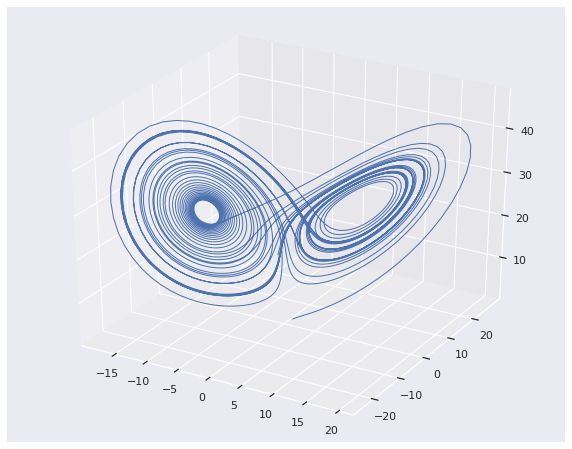

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()
sns.set(rc={'figure.figsize':(10, 10), "lines.linewidth": 1.0})

## <font color="blue">**Stochastic**

##### <font color="blue">*Stochastic Process, Stochastic Analysis & Stochastic Differential Equation*

**Stochastic Analysis**

* [Stochastic calculus](https://en.m.wikipedia.org/wiki/Stochastic_calculus) is a branch of mathematics that operates on stochastic processes. It allows a consistent theory of integration to be defined for integrals of stochastic processes with respect to stochastic processes. This field is created and started by the Japanese mathematician Kiyoshi Itô during World War 2.

* https://read.deeplearning.ai/the-batch/issue-146/

* > Stochastic: Statistik + Probability Theory (incl stochastic / random processes)

* https://en.wikipedia.org/wiki/Stochastic_programming#Deterministic_equivalent_of_a_stochastic_problem

* https://en.wikipedia.org/wiki/Benders_decomposition

* Bei einem Sparguthaben entspräche dies dem **exponentiellen Wachstum** durch Zinseszins. Bei Aktien wird dieses Wachstumsgesetz hingegen **in der Realität offenbar durch eine komplizierte Zufallsbewegung überlagert**. 

* Die Statistik und die Wahrscheinlichkeitstheorie legen es nahe, bei zufälligen Störungen, die sich aus vielen kleinen Einzeländerungen zusammensetzen, **von einer Normalverteilung als einfachstem Modell auszugehen**. 

* Außerdem zeigt sich, dass die Varianz der Störungen proportional zum betrachteten Zeitraum $\Delta t$ ist. Der Wiener-Prozess Wt besitzt alle diese gewünschten Eigenschaften, eignet sich also als ein Modell für die zeitliche Entwicklung der Zufallskomponente des Aktienkurses.

* https://de.wikipedia.org/wiki/Stochastische_Analysis

* https://de.m.wikipedia.org/wiki/Pfad_(Stochastik)

* [Stochastische Integration](https://de.wikipedia.org/wiki/Stochastische_Integration): Es sind stochastische Prozesse mit unendlicher Variation, insbesondere der Wiener-Prozess, als Integratoren zugelassen.

* https://de.wikipedia.org/wiki/Stochastischer_Prozess

*Stochastische Integration*

* Es sind stochastische Prozesse **mit unendlicher Variation**, insbesondere der Wiener-Prozess, als Integratoren zugelassen. 

* 
https://de.wikipedia.org/wiki/Stochastische_Integration

**Stochastic Differential Equation ( →  Black Scholes, Spontaneous Symmetry Breaking)**

* Eine [stochastischen Differentialgleichung](https://de.wikipedia.org/wiki/Stochastische_Differentialgleichung) ist eine Verallgemeinerung des Begriffs der gewöhnlichen Differentialgleichung auf stochastische Prozesse. 

> Stochastische Differentialgleichungen werden in zahlreichen Anwendungen eingesetzt, **um zeitabhängige Vorgänge zu modellieren**, die neben deterministischen Einflüssen zusätzlich **stochastischen Störfaktoren (Rauschen)** ausgesetzt sind.

* Die formale Theorie der stochastischen Differentialgleichungen wurde erst in den 1940er Jahren durch den japanischen Mathematiker Itō Kiyoshi formuliert. 

* Gemeinsam mit der **stochastischen Integration** begründet die Theorie der **stochastischen Differentialgleichungen** die **stochastische Analysis**.

* **Objective**: Genau wie bei deterministischen Funktionen möchte man auch bei stochastischen Prozessen den Zusammenhang zwischen dem Wert der Funktion und ihrer momentanen Änderung (ihrer Ableitung) in einer Gleichung formulieren. 

* **Challenge**: Was im einen Fall zu einer gewöhnlichen Differentialgleichung führt, ist im anderen Fall problematisch, da viele stochastische Prozesse, wie beispielsweise **der Wiener-Prozess, nirgends differenzierbar sind**.

* Loesung ist wie bei gewohnlichen Differentialgleichungen plus einen stochastischen Term

*Beim Typus der stochastischen Differentialgleichungen treten in der Gleichung stochastische Prozesse auf. Eigentlich sind stochastische Differentialgleichungen keine Differentialgleichungen [im obigen Sinne](https://de.m.wikipedia.org/wiki/Differentialgleichung#Weitere_Typen), sondern lediglich gewisse Differentialrelationen, welche als Differentialgleichung interpretiert werden können.*


https://www.youtube.com/watch?v=U8y8-gra0-w

Man hat einen Brown'sche Bewegung $W$ : BB

Eine stochastische Differentialgleichung hat die Form:

> $d X=\mu(t, X) d t+\sigma(t, X) d W$

Alternative Schreibweise:

> $X_{t}=X_{0}+\int_{0}^{t} \mu\left(s, X_{s}\right) d s+\int_{0}^{t} \sigma\left(s, X_{s}\right) d W_{s}, \quad t \geq 0$

Hierbei ist $X_{t}=X_{0}+\int_{0}^{t} \mu\left(s, X_{s}\right) d s$ das gewohnliche Integral von der Funktion $\mu$, die von der Zeit und er Funktion selbst abhangt, also von dem stochastischen Prozess selber abhangt.

Und hierbei ist $\int_{0}^{t} \sigma\left(s, X_{s}\right) d W_{s}$ das stochastische Integral zur Brown'schen Bewegung

**Das erste Integral ist als [Lebesgue-Integral](https://de.wikipedia.org/wiki/Lebesgue-Integral) und das zweite als [Itō-Integral](https://de.wikipedia.org/wiki/Stochastische_Integration) zu lesen.**

> $\mathcal{X}=X_{0}+\mu(., \mathcal{X}) \cdot \text { id }+\sigma(., X) \cdot \mathcal{W}$

Ist $\sigma=0,$ so erhalten wir die gewöhnliche Differentialgleichung

>$
d X=\mu(t, X) d t \quad \text { oder } \quad \frac{d X}{d t}=\mu(t, X)
$

Seien zwei Funktionen $a, b: \mathbb{R} \times \mathbb{R}_{+} \rightarrow \mathbb{R}$ sowie eine brownsche Bewegung $\left(W_{t}\right)_{t \geq 0}$ gegeben. 

Die dazugehörige stochastische Integralgleichung

>$
X_{t}=X_{0}+\int_{0}^{t} a\left(X_{\tau}, \tau\right) \mathrm{d} \tau+\int_{0}^{t} b\left(X_{\tau}, \tau\right) \mathrm{d} W_{\tau}
$

wird durch Einführung der Differentialschreibweise

>$
\mathrm{d} X_{t}=a\left(X_{t}, t\right) \mathrm{d} t+b\left(X_{t}, t\right) \mathrm{d} W_{t}
$

zur stochastischen Differentialgleichung. Das erste Integral ist als Lebesgue-Integral
und das zweite als Itō-Integral zu lesen. 

Zu gegebenen Funktionen $a$ und $b$ (auch als Drift und Diffusionskoeffizient bezeichnet) und einer brownschen Bewegung $\left(W_{t}\right)$ wird hier also ein Prozess $\left(X_{t}\right)$ gesucht, der die obige Integralgleichung erfüllt. Dieser Prozess ist dann eine Lösung der obigen SDGL.

Ist $A$ eine beliebige, auf demselben Wahrscheinlichkeitsraum wie $W$ definierte
Zufallsvariable, so wird aus der obigen SDGL durch Hinzufügen der Bedingung $X_{0}=A$ fast sicher ein stochastisches Anfangswertproblem als Pendant zum
Anfangswertproblem für gewöhnliche Differentialgleichungen.

The Langevin equation that we use in this recipe is the following stochastic differential equation:

>$d x=-\frac{(x-\mu)}{\tau} d t+\sigma \sqrt{\frac{2}{\tau}} d W$

https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/

**Beispiele fur stochastische Differentialgleichungen**

* Die SDGL für die geometrische brownsche Bewegung lautet $\mathrm{d} S_{t}=r S_{t} \mathrm{~d} t+\sigma S_{t} \mathrm{~d} W_{t} .$ Sie wird beispielsweise im Black-Scholes-Modell zur Beschreibung von Aktienkursen verwendet.

* Die SDGL für einen Ornstein-Uhlenbeck-Prozess ist $\mathrm{d} X_{t}=\theta\left(\mu-X_{t}\right) \mathrm{d} t+\sigma \mathrm{d} W_{t} .$ Sie wird unter anderem im Vasicek-Modell zur finanzmathematischen Modellierung von Zinssätzen über den Momentanzins
verwendet.

* Die SDGL für den Wurzel-Diffusionsprozess nach William Feller lautet $\mathrm{d} X_{t}=\kappa\left(\theta-X_{t}\right) \mathrm{d} t+\sigma \sqrt{X_{t}} \mathrm{~d} W_{t}$

**Lösen von stochastischen Differentialgleichungen und Simulation der Lösungen**

* Häufig lassen sich die Lösungen von stochastischen Differentialgleichungen nicht in geschlossener Form angeben. Dennoch können wir hinreichende Bedingungen fur die Existenz und Eindeutigkeit einer Lösung formulieren. [Source](https://www.math.tu-dresden.de/~mkeller/stochana/stochana_kap6.pdf)

* Genau wie bei deterministischen gibt es auch bei stochastischen Differentialgleichungen keinen allgemeinen Ansatz zur Ermittlung der Lösung. In manchen Fällen (wie bei der oben erwähnten Black-Scholes-SDGL, deren Lösung eine geometrische brownsche Bewegung ist) ist es auch hier möglich, die Lösung zu „erraten“ und durch Ableiten zu verifizieren (wobei das Differenzieren hier mit Hilfe des Lemmas von Itō erfolgt).


* In den meisten Fällen, die in der Praxis auftauchen, wie zum Beispiel auch im Fall des Wurzel-Diffusionsprozesses, ist jedoch keine geschlossene Form der Lösung zu erreichen. Doch ist man zumeist auch nur daran interessiert, Zufallspfade der entsprechenden Lösung zu simulieren. Dies kann approximativ durch numerische Diskretisierungsverfahren erreicht werden, etwa durch das [Euler-Maruyama-Schema](https://de.wikipedia.org/wiki/Euler-Maruyama-Verfahren) (das dem expliziten Euler-Verfahren für gewöhnliche Differentialgleichungen nachempfunden ist) oder das [Milstein-Verfahren](https://de.wikipedia.org/wiki/Milstein-Verfahren).

**Supersymmetric theory of stochastic dynamics & Spontaneous Symmetry breaking**

* [Supersymmetric theory of stochastic dynamics](https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics) or stochastics (STS) **is an exact theory of stochastic (partial) differential equations (SDEs)**, the class of mathematical models with the widest applicability covering, in particular, all continuous time dynamical systems, with and without noise.

* https://en.m.wikipedia.org/wiki/Chaos_theory#Chaos_as_a_spontaneous_breakdown_of_topological_supersymmetry

##### <font color="blue">*Markov Process & Monte Carlo Simulation*

A Markov chain is a **discrete-time stochastic process** that progresses from one state to another with certain probabilities that can be **represented by a graph and state transition matrix P** as indicated below:

<img src="https://raw.githubusercontent.com/deltorobarba/repo/master/markov.PNG" alt="markov">

* Markov chains may be modeled by **finite state machines, and random walks**

* A Stochastic (State Transition) Matrix describes a Markov chain X<sub>t</sub> over a [**finite state space (Probability space) S**](https://en.m.wikipedia.org/wiki/Probability_space) with cardinality S.

  * Various types of random walks are of interest, which can differ in several ways. The term itself most often refers to a special category of Markov chains or Markov processes, but many time-dependent processes are referred to as random walks, with a modifier indicating their specific properties. 

  * Random walks (Markov or not) can also take place on a variety of spaces: commonly studied ones include graphs, others on the integers or the real line, in the plane or higher-dimensional vector spaces, on curved surfaces or higher-dimensional Riemannian manifolds, and also on groups finite, finitely generated or Lie.

* Let P be the transition matrix of Markov chain {X0, X1, ...}.

  * **Reducibility**: a Markov chain is said to be irreducible if it is possible to get to any state from any state. In other words, a Markov chain is irreducible if there exists a chain of steps between any two states that has positive probability.

  * **Periodicity**: a state in a Markov chain is periodic if the chain can return to the state only at multiples of some integer larger than 1. Thus, starting in state 'i', the chain can return to 'i' only at multiples of the period 'k', and k is the largest such integer. State 'i' is aperiodic if k = 1 and periodic if k > 1.

  * **Transience and Recurrence**: A state 'i' is said to be transient if, given that we start in state 'i', there is a non-zero probability that we will never return to 'i'. State i is recurrent (or persistent) if it is not transient. A recurrent state is known as positive recurrent if it is expected to return within a finite number of steps and null recurrent otherwise. Transience and recurrence issues are central to the study of Markov chains and help describe the Markov chain's overall structure. The presence of many transient states may suggest that the Markov chain is absorbing, and a strong form of recurrence is necessary in an ergodic Markov chain.

  * **Ergodicity**: a state 'i' is said to be ergodic if it is aperiodic and positive recurrent. If all states in an irreducible Markov chain are ergodic, then the chain is said to be ergodic. Ergodic Markov chains are, in some senses, the processes with the "nicest" behavior.

  * **Absorbing State**: a state i is called absorbing if it is impossible to leave this state. Therefore, the state 'i' is absorbing if pii = 1 and pij = 0 for i ≠ j. If every state can reach an absorbing state, then the Markov chain is an absorbing Markov chain. Absorbing states are crucial for the discussion of absorbing Markov chains. A common type of Markov chain with transient states is an absorbing one. An absorbing Markov chain is a Markov chain in which it is impossible to leave some states, and any state could (after some number of steps, with positive probability) reach such a state. It follows that all non-absorbing states in an absorbing Markov chain are transient.

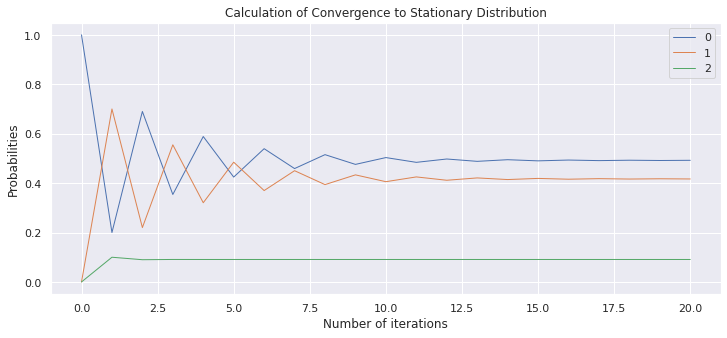

[[0.49229934 0.41679157 0.09090909]]


In [ ]:
from random import seed
from random import random
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})

P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])

state=np.array([[1.0, 0.0, 0.0]])

stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = [[0,0,0]]

iterations= 20

for x in range(iterations):
  state=np.dot(state,P)
  stateHist=np.append(stateHist,state,axis=0)

dfDistrHist = pd.DataFrame(stateHist)
dfDistrHist.plot(title="Calculation of Convergence to Stationary Distribution")
plt.xlabel("Number of iterations")
plt.ylabel("Probabilities")
plt.show()

# Print our exact values
print(state)

[[0.50199203 0.43426295 0.06374502]]
[[0.16666667 0.77777778 0.05555556]
 [0.91743119 0.         0.08256881]
 [0.26666667 0.73333333 0.        ]]


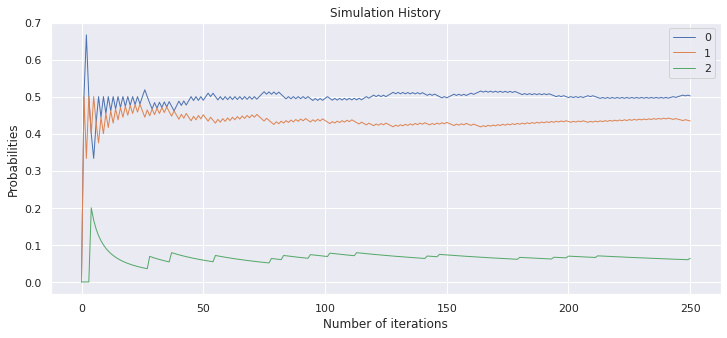

In [ ]:
# Simulate from a Markov Chain by simulating from a multinomial distribution

# One way to simulate from a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) 
# is to divide a line of length 1 into intervals proportional to the probabilities, 
# and then picking an interval based on a uniform random number between 0 and 1. 

# [Source](https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e)

from random import seed
from random import random
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})

P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])

stateChangeHist= np.array([[0.0,  0.0,  0.0],
                          [0.0, 0.0,  0.0],
                          [0.0, 0.0,  0.0]])

state=np.array([[1.0, 0.0, 0.0]])
currentState=0
stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = [[0,0,0]]
seed(4)

# Simulate from multinomial distribution
def simulate_multinomial(vmultinomial):
  r=np.random.uniform(0.0, 1.0)
  CS=np.cumsum(vmultinomial)
  CS=np.insert(CS,0,0)
  m=(np.where(CS<r))[0]
  nextState=m[len(m)-1]
  return nextState

iterations = 250

for x in range(iterations):
  currentRow=np.ma.masked_values((P[currentState]), 0.0)
  nextState=simulate_multinomial(currentRow)
  # Keep track of state changes
  stateChangeHist[currentState,nextState]+=1
  # Keep track of the state vector itself
  state=np.array([[0,0,0]])
  state[0,nextState]=1.0
  # Keep track of state history
  stateHist=np.append(stateHist,state,axis=0)
  currentState=nextState
  # calculate the actual distribution over the 3 states so far
  totals=np.sum(stateHist,axis=0)
  gt=np.sum(totals)
  distrib=totals/gt
  distrib=np.reshape(distrib,(1,3))
  distr_hist = np.append(distr_hist,distrib,axis=0)
print(distrib)
P_hat=stateChangeHist/stateChangeHist.sum(axis=1)[:,None]

# Check estimated state transition probabilities based on history so far:
print(P_hat)
dfDistrHist = pd.DataFrame(distr_hist)

# Plot the distribution as the simulation progresses over time
dfDistrHist.plot(title="Simulation History")
plt.xlabel("Number of iterations")
plt.ylabel("Probabilities")
plt.show()

**Monte Carlo Simulation**

* Monte Carlo can be thought of as carrying out many experiments, each time changing the variables in a model and observing the response. 

* Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on **repeated random sampling to obtain numerical results**. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

* Monte Carlo methods are useful for **simulating systems with many coupled degrees of freedom**, such as fluids, disordered materials, strongly coupled solids, and cellular structures (see cellular Potts model, interacting particle systems, McKean–Vlasov processes, kinetic models of gases). Other examples include **modeling phenomena with significant uncertainty in inputs** such as the calculation of risk in business


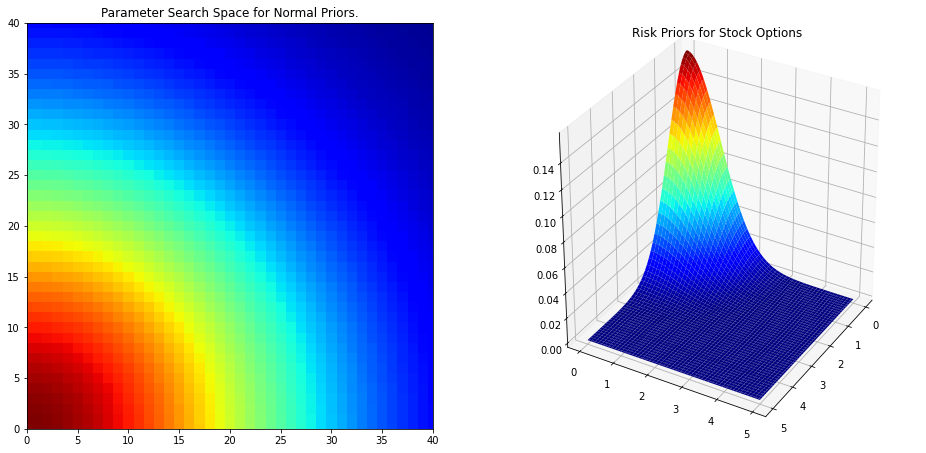

In [ ]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Parameter Search Space for Normal Priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Risk Priors for Stock Options");

# plt.title("Parameter Search Space for Normal Priors");

**Markov Chain Monte Carlo (MCMC)**

* Markov Chain Monte Carlo refers to a **class of methods** for sampling from a probability distribution in order to **construct the most likely distribution**. 

> MCMC can be considered as a **random walk** that gradually converges to the true distribution.

* We cannot directly calculate the (i.e. logistic) distribution, so instead we generate thousands of values — called samples — for the parameters of the function (alpha and beta) to **create an approximation of the distribution**. 

* The idea behind MCMC is that **as we generate more samples, our approximation gets closer and closer to the actual true distribution**.

* Markov Chain and Monte Carlo, MCMC is a method that repeatedly draws random values for the parameters of a distribution based on the current values. **Each sample of values is random, but the choices for the values are limited by the current state and the assumed prior distribution of the parameters**. 

##### <font color="blue">*White Noise*


**A white noise process has following conditions**

* Mean (level) is zero (does not change over time - stationary process)
* Variance is constant (does not change over time - stationary process)
* Zero autocorrelation (values do not correlate with lag values)

**White Noise: Independent & Identically Distributed**

* Hence, in a time series is white noise if the variables are independent and identically distributed (IID) with a mean of zero.

* The term 'white' refers to the way the signal power is distributed (i.e., independently) over time or among frequencies

* **Necessary Condition**: Independence: variables are statistically uncorrelated = their covariance is zero. Therefore, the covariance matrix R of the components of a white noise vector w with n elements must be an n by n diagonal matrix, where each diagonal element Rᵢᵢ is the variance of component wᵢ; and the correlation matrix must be the n by n identity matrix.

* **Sufficient Condition**: every variable in w has a normal distribution with zero mean and the same variance, w is said to be a Gaussian white noise vector. In that case, the joint distribution of w is a multivariate normal distribution; the independence between the variables then implies that the distribution has spherical symmetry in n-dimensional space. Therefore, any orthogonal transformation of the vector will result in a Gaussian white random vector. In particular, under most types of discrete Fourier transform, such as FFT and Hartley, the transform W of w will be a Gaussian white noise vector, too; that is, the n Fourier coefficients of w will be independent Gaussian variables with zero mean and the same variance.

* A random vector (that is, a partially indeterminate process that produces vectors of real numbers) is said to be a white noise vector or white random vector if its components each have a probability distribution with zero mean and finite variance, and are statistically independent: that is, their joint probability distribution must be the product of the distributions of the individual components.

* First moment has to be zero and second moment has to be finite though. (iid ) White noise is always an independent process but reverse may not be true. 

* The technical definition of white noise is that it has equal intensity at all frequencies. This corresponds to a delta function autocorrelation. This is only possible if there is no correlation between any sequential values. So yes, the independence is true both backwards and forwards. Note that the actual distribution is irrelevant.



**Types of White Noise Processes**
* If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise
* There are also white noise processes, like Levy etc.

**Relationship to Stochastic Processes**
* White noise is the generalized mean-square derivative of the Wiener process or Brownian motion (so Wiener is an integrated White Noise)

**White noise is an important concept in time series analysis and forecasting**

* **Predictability**: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
* **Model Diagnostics**: The statistics and diagnostic plots can be uses on time series to check if it is white noise. The series of errors from a time series forecast model should ideally be white noise. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.


        whitenoise
count  5000.000000
mean     -0.000236
std       0.991748
min      -3.149965
5%       -1.663347
50%      -0.006930
95%       1.656811
max       3.400552
First central moment: Mean of whitenoise   -0.000236
dtype: float64
Second central moment: Variance whitenoise    0.983565
dtype: float64
Third central moment: Skewness ('Higher moment') of  whitenoise   -0.001609
dtype: float64
Forth central moment: Kurtosis ('Higher moment') of whitenoise   -0.090712
dtype: float64
Compute specific percentiles of whitenoise    0.667429
Name: 0.75, dtype: float64


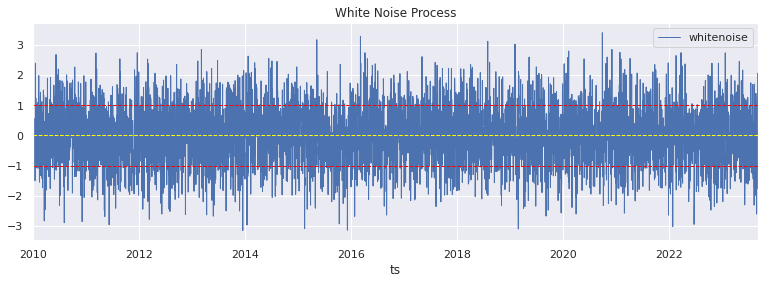

In [ ]:
# Create (Gaussian) White Noise

from random import gauss
from random import seed
from pandas import Series

# Set seed for reproducibility and hyperparameter
seed(1)
mean = 0.0
sigma = 1.0
periods = 5000

# Create White Noise
whitenoise = [gauss(mean, sigma) for i in range(periods)]
whitenoise = pd.DataFrame(data=Series(whitenoise), columns=['whitenoise'])

# Create Time Series
ts = pd.date_range('2010-01-01', periods=periods, freq='D')
ts = pd.DataFrame(data=ts, columns=['ts'])

# Merge and Set Index
series = pd.concat([ts, whitenoise], axis=1).set_index('ts')
series.head()

# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
series.plot(title='White Noise Process')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0)

print(series.describe(percentiles=[0.05, 0.95]))

print("First central moment: Mean of", + series.mean())
print("Second central moment: Variance", + series.var())
print("Third central moment: Skewness ('Higher moment') of ", + series.skew())
print("Forth central moment: Kurtosis ('Higher moment') of", + series.kurt())
print("Compute specific percentile of", + series.quantile(0.75))

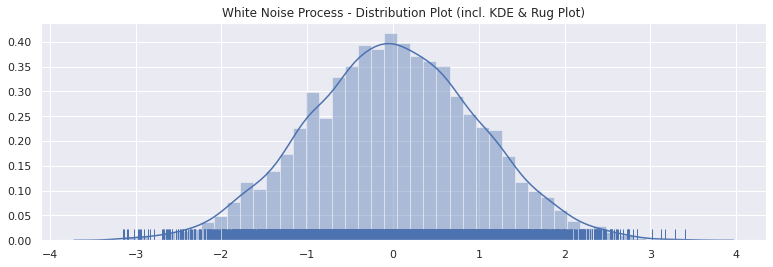

In [ ]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

##### <font color="blue">*Random Walk*

**Random Walk** 

* Random walk is another time series model where the current observation is equal to the previous observation with a random step up or down. Known as a stochastic or random process.

> y<sub>(t)</sub> = B<sub>0</sub> + B<sub>1</sub> * X<sub>(t-1)</sub> + e<sub>(t)</sub>

* A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. 

* The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides. It is this dependency that gives the process its name as a “random walk” or a “drunkard’s walk”.

> **A simple random walk is a martingale**

* In higher dimensions, the set of randomly walked points has interesting geometric properties. In fact, one gets a discrete fractal, that is, a set which exhibits stochastic self-similarity on large scales.
* Examples include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the price of a fluctuating stock and the financial status of a gambler: all can be approximated by random walk models, even though they may not be truly random in reality
* Random walks serve as a fundamental model for the recorded stochastic activity / stochastic processes.
* As a more mathematical application, the value of π can be approximated by the use of random walk in an agent-based modeling environment.

* There are many types of time-dependent processes referred to as random walks - most often refers to a special category of Markov chains or Markov processes. A random walk on the integers (and the gambler's ruin problem) are examples of **Markov processes in discrete time**.

* Specific cases or limits of random walks include the Lévy flight and diffusion models such as Brownian motion. **A Wiener process (~ Brownian motion) is the integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments. A Wiener process is the scaling limit of random walk in dimension 1.

* Random walks can take place on a variety of spaces: graphs, on the integers or real line, in the plane or higher-dimensional vector spaces, on curved surfaces or higher-dimensional Riemannian manifolds, and also on groups finite, finitely generated or Lie.

* **Random Walk and Autocorrelation**

  * We can calculate the correlation between each observation and the observations at previous time steps. Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

* **Stationarity**

  * A stationary time series is one where the values are not a function of time. Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time.
  * The current observation is a random step from the previous observation. Therefore we can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.
  * Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

**IID**

  * This model assumes that in each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”). 

  * This is equivalent to saying that the first difference of the variable is a series to which the mean model should be applied. So, if you begin with a time series that wanders all over the map, but you find that its first difference looks like it is an i.i.d. sequence, then a random walk model is a potentially good candidate.

* **Prediction**

  * A random walk is unpredictable; it cannot reasonably be predicted. Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step. Simply because we know that the next time step will be a function of the prior time step. 
  * This is often called the naive forecast, or a persistence model. We can implement this in Python by first splitting the dataset into train and test sets, then using the persistence model to predict the outcome using a rolling forecast method. Once all predictions are collected for the test set, the mean squared error is calculated.

* **Drift**

  * A random walk model is said to have “drift” or “no drift” according to whether the distribution of step sizes has a non-zero mean or a zero mean. At period n, the k-step-ahead forecast that the random walk model without drift gives for the variable Y is

  > $\hat{Y}_{n+k}=Y_{n}$

  * In others words, it predicts that all future values will equal the last observed value. This doesn’t really mean you expect them to all be the same, but just that you think they are equally likely to be higher or lower, and you are staying on the fence as far as point predictions are concerned. If you extrapolate forecasts from the random walk model into the distant future, they will go off on a horizontal line, just like the forecasts of the mean model. So, qualitatively the long-term point forecasts of the random walk model look similar to those of the mean model, except that they are always “re-anchored” on the last observed value rather than the mean.of the historical data.

  * For the random-walk-with-drift model, the k-step-ahead forecast from period n is:

  > $\hat{\mathrm{Y}}_{\mathrm{n}+\mathrm{k}}=\mathrm{Y}_{\mathrm{n}}+\mathrm{k} \hat{\mathrm{d}}$

  * where dˆ is the estimated drift, i.e., the average increase from one period to the next. So, the long-term forecasts from the random-walk-with-drift model look like a trend line with slope dˆ , but it is always re-anchored on the last observed value. 

**Applications of Random Walks**

* In computer networks, random walks can model the number of transmission packets buffered at a server.
* In population genetics, random walk describes the statistical properties of genetic drift.
* In image segmentation, random walks are used to determine the labels (i.e., “object” or “background”) to associate with each pixel.
* In brain research, random walks and reinforced random walks are used to model cascades of neuron firing in the brain.
Random walks have also been used to sample massive online graphs such as online social networks.

* **Random Walks in Financial Time Series**

  * **Is time series a random walk?**: Your time series may be a random walk. Some ways to check if your time series is a random walk are as follows:
The time series shows a strong temporal dependence that decays linearly or in a similar pattern.
  * The time series is non-stationary and making it stationary shows no obviously learnable structure in the data.
The persistence model provides the best source of reliable predictions.
  * This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk. Many time series are random walks, particularly those of security prices over time. The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.
  * "A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the stock market, it means that short-run changes in stock prices are unpredictable." - Page 26, A Random Walk down Wall Street: The Time-tested Strategy for Successful Investing. https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

* https://towardsdatascience.com/random-walks-with-python-8420981bc4bc

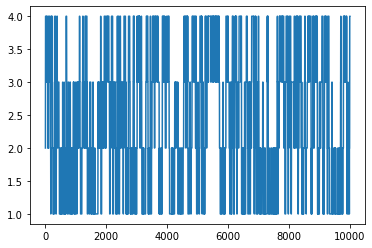

In [ ]:
# Simulating a 1D Random Walk

# Python code for 1-D random walk. 
import random
  
# Probability to move up or down 
prob = [0.05, 0.95]   
  
# statically defining the starting position 
start = 2  
positions = [start] 
  
# creating the random points 
rr = np.random.random(10000) 
downp = rr < prob[0] 
upp = rr > prob[1] 
  
  
for idownp, iupp in zip(downp, upp): 
    down = idownp and positions[-1] > 1
    up = iupp and positions[-1] < 4
    positions.append(positions[-1] - down + up) 
  
# plotting down the graph of the random walk in 1D 
plt.plot(positions) 
plt.show() 

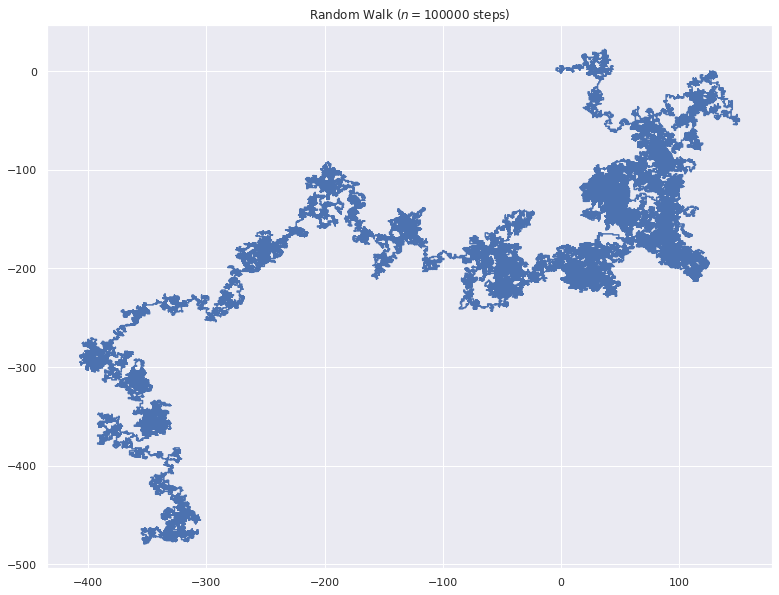

In [ ]:
# Simulating a 2D Random Walk

# In higher dimensions one gets a discrete fractal, that is, 
# a set which exhibits stochastic self-similarity on large scales.


# Python code for 2D random walk. 
import pylab 
import random 
  
# defining the number of steps 
n = 100000
  
#creating two array for containing x and y coordinate 
#of size equals to the number of size and filled up with 0's 
x = np.zeros(n) 
y = np.zeros(n) 
  
# filling the coordinates with random variables 
for i in range(1, n): 
    val = random.randint(1, 4) 
    if val == 1: 
        x[i] = x[i - 1] + 1
        y[i] = y[i - 1] 
    elif val == 2: 
        x[i] = x[i - 1] - 1
        y[i] = y[i - 1] 
    elif val == 3: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] + 1
    else: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] - 1

sns.set(rc={'figure.figsize':(13, 10)})
pylab.title("Random Walk ($n = " + str(n) + "$ steps)") 
pylab.plot(x, y) 

Text(0.5, 0.92, '3D Random Walk')

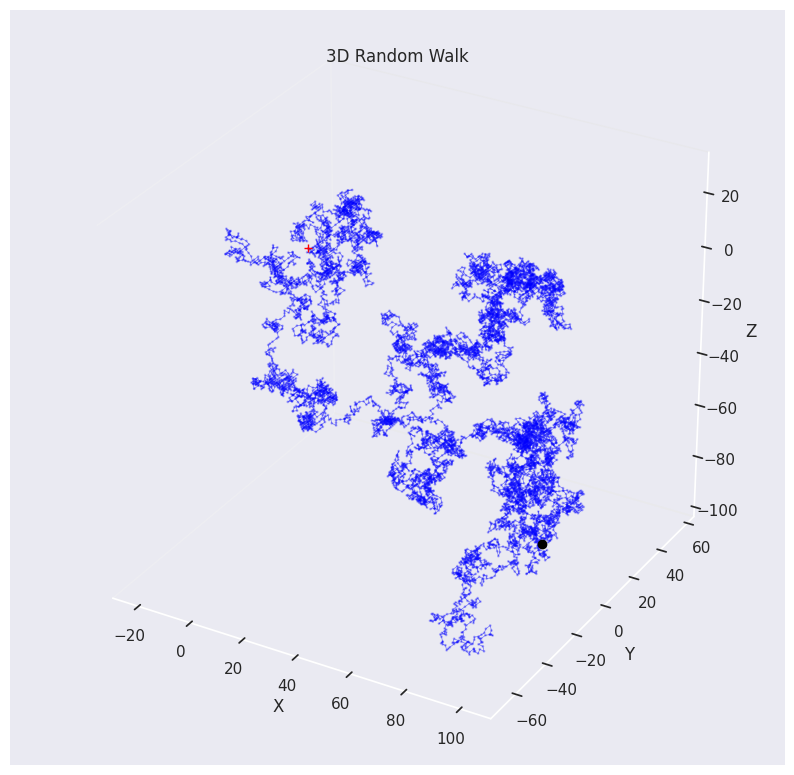

In [ ]:
# Simulating a 3D Random Walk

from mpl_toolkits import mplot3d

# Define parameters for the walk
dims = 3
step_n = 10000
step_set = [-1, 0, 1]
origin = np.zeros((1,dims))

# Simulate steps in 3D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1]
stop = path[-1:]

# Plot the path
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter3D(path[:,0], path[:,1], path[:,2], 
             c='blue', alpha=0.25,s=1)
ax.plot3D(path[:,0], path[:,1], path[:,2], 
          c='blue', alpha=0.5, lw=0.5)
ax.plot3D(start[:,0], start[:,1], start[:,2], 
          c='red', marker='+')
ax.plot3D(stop[:,0], stop[:,1], stop[:,2], 
          c='black', marker='o')
plt.title('3D Random Walk')
#plt.savefig('plots/random_walk_3d.png’,dpi=250);

##### <font color="blue">*Wiener Process (Brownian Motion)*

**Wiener Process (Brownian Motion)**

* Video: Physics of Randomness: https://youtu.be/5jBVYvHeG2c

* Brownian Motion: Flower particles move randomly because they are hit by particles that move. And particles move faster with more heat. 

* Same in astrophysics with stars under the gravitational influence of smaller stars, big stars move a bit randomly

* Same with stock market where the price is influenced by many factors all the time (and hence the price moves randomly up and down)

**The Wiener process is a real valued continuous-time (continuous state-space) stochastic process**

* W<sub>0</sub> = 0 (P-almost certain)
* The Wiener process has (stochastically) independent increments.
* The increases are therefore stationary and normally distributed with the expected value zero and the variance t - s.
* The individual paths are (P-) almost certainly continuous.

**Applications**

* In physics it is used to study Brownian motion, the diffusion of minute particles suspended in fluid, and other types of diffusion via the Fokker–Planck and Langevin equations. 
* It also forms the basis for the rigorous path integral formulation of quantum mechanics (by the Feynman–Kac formula, a solution to the Schrödinger equation can be represented in terms of the Wiener process) and the study of eternal inflation in physical cosmology. 
* It is also prominent in the mathematical theory of finance, in particular the Black–Scholes option pricing model.

**Properties of a Wiener Process**

1. The Wiener process belongs to the family of **Markov processes** and there specifically to the class of **Levy processes**. It also fulfills the strong markov property. It is one of the best known Lévy processes (**càdlàg** stochastic processes with stationary independent increments).
2. The Wiener Process is a **special Gaussian process** with an expected value function E(W<sub>t</sub>)  = 0 and and the covariance function Cov (W<sub>s</sub>, W<sub>t</sub>) = min (s,t)
3. The Wiener process is a (continuous time) **martingale** (Lévy characterisation: the Wiener process is an almost surely continuous martingale with W0 = 0 and quadratic variation [Wt, Wt] = t, which means that Wt2 − t is also a martingale).
4. The Wiener process is a **Levy process** with steady paths and constant expectation 0.

*Another characterisation is that the Wiener process has a spectral representation as a sine series whose coefficients are independent N(0, 1) random variables. This representation can be obtained using the Karhunen–Loève theorem.*

**Wiener process as a limit of random walk (& Differences between Wiener Process & Random Walk)**

* https://www.quora.com/What-is-an-intuitive-explanation-of-a-Wiener-process?top_ans=3955819

* A Wiener process (~ Brownian motion) is the **integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments.

* Let X<sub>1</sub>, X<sub>2</sub>, X<sub>n</sub> be a sequence of independent and identically distributed (i.i.d.) random variables with mean 0 and variance 1.  The central limit theorem asserts that W<sup>(n)</sup> (1) converges in distribution to a standard Gaussian random variable W(1) as n → ∞. 

* [Donsker's theorem](https://en.m.wikipedia.org/wiki/Donsker%27s_theorem) asserts that as n → ∞ , W<sub>n</sub> approaches a Wiener process, which explains the ubiquity of Brownian motion. **Donsker's invariance principle** states that: As random variables taking values in the Skorokhod space D [0,1], the random function W<sup>(n)</sup> converges in distribution to a standard Brownian motion W := (W(t))<sub>t ∈ [0,1]</sub> as n → ∞.

![Donsker's Invariance Principle](https://upload.wikimedia.org/wikipedia/commons/8/8c/Donskers_invariance_principle.gif)

*Donsker's invariance principle for simple random walk on Z*

<img src="https://raw.githubusercontent.com/deltorobarba/repo/master/wiener.jpg" alt="wiener">

**Differences to other stochastic processes**

**Random Walk**


* **A Wiener process is the [scaling limit](https://en.m.wikipedia.org/wiki/Scaling_limit) of random walk in dimension 1**. The **convergence of a random walk toward the Wiener process is controlled by the central limit theorem**, and by **Donsker's theorem**. The **Green's function** of the diffusion equation that controls the Wiener process, suggests that, **after a large number of steps, the random walk converges toward a Wiener process**.

* A random walk is a discrete fractal (a function with integer dimensions; 1, 2, ...), but a **Wiener process trajectory is a true fractal**, and there is a connection between the two (a Wiener process walk is a fractal of **Hausdorff dimension** 2). 

* Unlike the random walk, a **Wiener Process is scale invariant**. A Wiener process enjoys many symmetries random walk does not. For example, a **Wiener process walk is invariant to rotations, but the random walk is not**, since the underlying grid is not. This means that in many cases, problems on a random walk are easier to solve by translating them to a Wiener process, solving the problem there, and then translating back. 

**(Gaussian) White Noise**

* The Wiener process is used to represent the integral (from time zero to time t) of a zero mean, unit variance, delta correlated **<u>Gaussian</u> white noise process**

**Brownian Motion**

* **"Brownian motion" is a phenomenon that can be modeled with a Wiener Process**, because a Wiener process is a stochastic process with similar behavior to Brownian motion, the physical phenomenon of a minute particle diffusing in a fluid.

* The Brownian motion process (and the Poisson process in one dimension) are both examples of **Markov processes in continuous time**

* Itō also paved the way for the Wiener process from physics to other sciences: the **stochastic differential equations** he set up made it possible to adapt the Brownian motion to more statistical problems. 

* The **geometric Brownian motion** derived from a stochastic differential equation solves the problem that the **Wiener process, regardless of its starting value, almost certainly reaches negative values over time, which is impossible for stocks**. Since the development of the famous **Black-Scholes model**, the geometric Brownian movement has been the standard.

**Ornstein-Uhlenbeck-Process**

* The problem raised by the **[non-rectifiable paths](https://en.m.wikipedia.org/wiki/Arc_length)** of the Wiener process in the modeling of Brownian paths leads to the Ornstein-Uhlenbeck process and also makes the need for a theory of stochastic integration and differentiation clear
* here it is not the motion but the speed of the particle as one that is not rectifiable process derived from the Wiener process, from which one obtains rectifiable particle paths through integration.



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


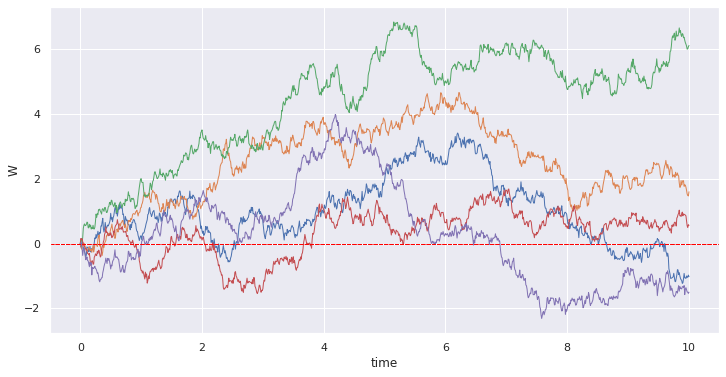

In [ ]:
# Simulating a Wiener Process - Each path is an independent Wiener process 

import numpy as np
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 10), "lines.linewidth": 1.0})
%pylab inline
def wiener_process(T, N):
    """
    T: total time
    N: The total number of steps
    """
    W0 = [0]
    dt = T/float(N)
    # simulate the increments by normal random variable generator
    increments = np.random.normal(0, 1*np.sqrt(dt), N)
    W = W0 + list(np.cumsum(increments))
    return W

N = 1000
T = 10
dt = T / float(N)
t = np.linspace(0.0, N*dt, N+1)
plt.figure(figsize=(12,6))
for i in range(5):
    W = wiener_process(T, N)
    plt.plot(t, W)
    plt.xlabel('time')
    plt.ylabel('W')
    plt.grid(True)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.0)

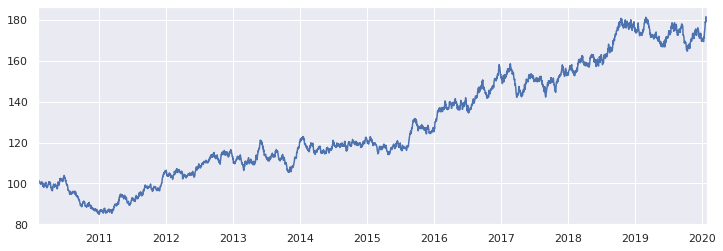

In [ ]:
# Simulating Random Walk (with Drift) based on Geometric Brownian Motion

sns.set(rc={'figure.figsize':(12, 4)})

def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20): 
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2010-02-01', '2020-01-29')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

randomwalk.plot()

##### <font color="blue">*Gaussian Process*

* A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. **every finite linear combination of them is normally distributed**. 

* The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

* Gaussian Processes are a class of stationary, zero-mean stochastic processes which are completely dependent on their autocovariance functions. This class of models can be used for both regression and classification tasks.

* Gaussian Processes provide estimates about uncertainty, for example giving an estimate of how sure an algorithm is that an item belongs to a class or not.

* In order to deal with situations which embed a certain degree of uncertainty is typically made use of probability distributions.

* Gaussian processes can allow us to describe probability distributions of which we can later update the distribution using Bayes Rule once we gather new training data.

* **Relation to other Stochastic Processes**

  * A **Wiener process (~ Brownian motion)** is the integral of a white noise generalized Gaussian process. It is not stationary, but it has stationary increments. 

  * The **fractional Brownian motion** is a Gaussian process whose covariance function is a generalisation of that of the Wiener process.

  * The **Ornstein–Uhlenbeck** process is a stationary Gaussian process.

  * The **Brownian bridge** is (like the Ornstein–Uhlenbeck process) an example of a Gaussian process whose increments are not independent.


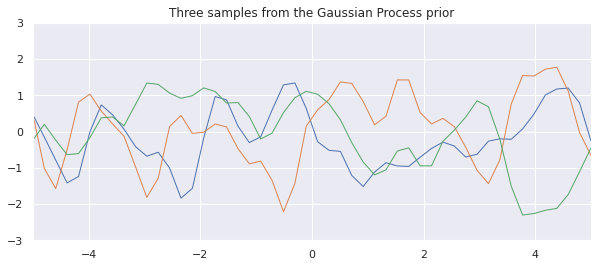

In [ ]:
# Gaussian Process

# Define points at which our functions will be evaluated, 50 evenly spaced points between -5 and 5.
# kernel function: uses the Squared Exponential, a.k.a Gaussian, a.k.a. Radial Basis Function kernel.
# calculates the squared distance between points and converts it into a measure of similarity, 
# controlled by a tuning parameter. Note that we are assuming a mean of 0 for our prior.

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the Gaussian Process prior')
plt.show()

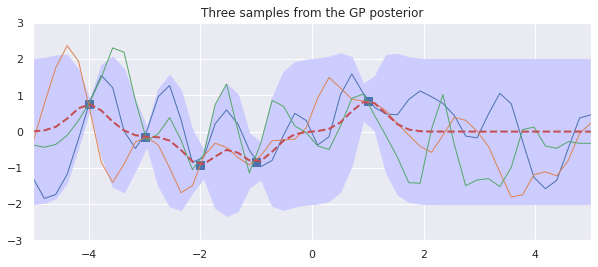

In [ ]:
# Gaussian Process

# Source: https://machinelearningmastery.com/what-is-bayesian-optimization/
# Now we’ll observe some data. The actual function generating the y values from our x values, 
# unbeknownst to our model, is the sin function.
# We generate the output at our 5 training points, sample from the posterior and plot it.
# The training points (the blue squares) have “reined in” the set of possible functions: 
# the ones we have sampled from the posterior all go through those points.
# The dotted red line shows the mean output and the grey area shows 2 standard deviations from the mean.

# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#CCCCFF")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

**Gaussian Processes for Machine Learning**

  * http://katbailey.github.io/post/gaussian-processes-for-dummies/

  * Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions f(x) that are consistent with the observed data.

  * As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

**In supervised learning, we often use parametric models** $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ to explain data and infer optimal values of parameter $\boldsymbol\theta$ via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) or [maximum a posteriori](https://de.wikipedia.org/wiki/Maximum_a_posteriori) estimation. If needed we can also infer a full [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) $p(\boldsymbol\theta \lvert \mathbf{X},\mathbf{y})$ instead of a point estimate $\boldsymbol{\hat\theta}$. With increasing data complexity, models with a higher number of parameters are usually needed to explain data reasonably well. Methods that use models with a fixed number of parameters are called parametric methods. 

In non-parametric methods, on the other hand, the number of parameters depend on the dataset size. For example, in [Nadaraya-Watson kernel regression](https://en.wikipedia.org/wiki/Kernel_regression), a weight $w_i$ is assigned to each observed target $y_i$ and for predicting the target value at a new point $\mathbf{x}$ a weighted average is computed: 

$$f(\mathbf{x}) = \sum_{i=1}^{N}w_i(\mathbf{x})y_i$$

$$w_i(\mathbf{x}) = \frac{\kappa(\mathbf{x}, \mathbf{x}_{i})}{\sum_{i'=1}^{N}\kappa(\mathbf{x}, \mathbf{x}_{i'})}$$

Observations that are closer to $\mathbf{x}$ have a higher weight than observations that are further away. Weights are computed from $\mathbf{x}$ and observed $\mathbf{x}_i$ with a kernel $\kappa$. A special case is k-nearest neighbors (KNN) where the $k$ closest observations have a weight $1/k$, and all others have weight $0$. Non-parametric methods often need to process all training data for prediction and are therefore slower at inference time than parametric methods. On the other hand, training is usually faster as non-parametric models only need to remember training data. 

Another example of non-parametric methods are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). Instead of inferring a distribution over the parameters of a parametric function Gaussian processes can be used to infer a distribution over functions directly. A Gaussian process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions. Inference of continuous function values in this context is known as GP regression but GPs can also be used for classification. 

A Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{1}$$

In Equation $(1)$, $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. $m$ is the mean function and it is common to use $m(\mathbf{x}) = 0$ as GPs are flexible enough to model the mean arbitrarily well. $\kappa$ is a positive definite *kernel function* or *covariance function*. 

**Thus, a Gaussian process is a distribution over functions whose shape (smoothness, ...) is defined by $\mathbf{K}$.**

 If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too. 

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}
\end{align*}
$$

Equation $(2)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}
$$

With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{5}
\end{align*}
$$


##### <font color="blue">*Further Stochastic Processes*

**Brownian Bridge**

* A Brownian bridge is a **continuous Gaussian process** with X<sub>0</sub> = X<sub>1</sub> = 0, and with mean and covariance functions given in (c) and (d), respectively.

* The **Brownian bridge is (like the Ornstein–Uhlenbeck process)** an example of a Gaussian process **whose increments are not independent**.

* There are several ways of constructing a Brownian bridge from a standard Brownian motion [Source](https://www.randomservices.org/random/brown/Bridge.html)

* **Applications: Path Simulation for Stock Shares**: The simple Monte Carlo method with Euler method supplemented by the Brownian bridge correction for the possibility of falling below or exceeding the barriers between discretization times. 

  * By merely discreetly viewing (simulating) the (log) share price, those paths can also lead to a positive final payment in which the share price between the selected times k delta t has exceeded the lower barrier or exceeded the upper barrier without this is noticed in the discretized model. 

  * To calculate the probability of such an unnoticed barrier violation, Brownian Bridge is used (with the help of the independence and stationarity of its growth).

  * With the help of the statements about the Brown Bridge, one can formally. Specify the Monte Carlo algorithm that can be used to evaluate double barrier options without having to discretize the price path.

* **Application: Bond Prices**

  * Computation of bond prices in a structural default model with jumps with an unbiased Monte-Carlo simulation. 

  * The algorithm requires the evaluation of integrals with the density of the first-passage time of a Brownian bridge as the integrand. (Metwally and Atiya (2002) suggest an approximation of these integrals.)

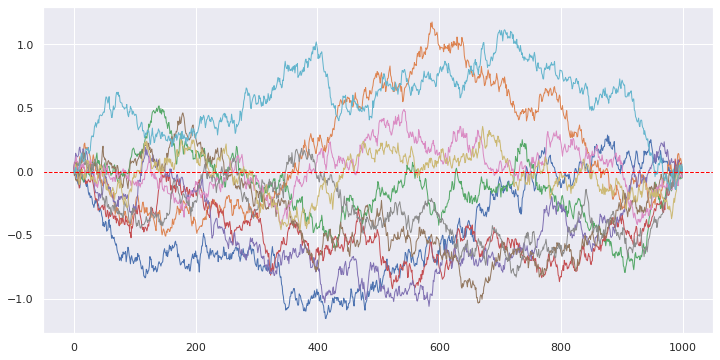

In [ ]:
import six

seed = 0
N = 1000
M = 10

np.random.seed(seed)

def sample_path_batch(M, N):
    dt = 1.0 / (N -1)
    dt_sqrt = np.sqrt(dt)
    B = np.empty((M, N), dtype=np.float32)
    B[:, 0] = 0
    for n in six.moves.range(N - 2):
         t = n * dt
         xi = np.random.randn(M) * dt_sqrt
         B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
    B[:, -1] = 0   # Set last B to zero
    return B

sns.set(rc={'figure.figsize':(12, 6), "lines.linewidth": 1.0})
B = sample_path_batch(M, N)
plt.plot(B.T)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.0)
plt.show()

**Ornstein-Uhlenbeck Process**

> Simulating a stochastic differential equation

* the Ornstein–Uhlenbeck process is a **stochastic process** with applications in financial mathematics and the physical sciences. 

* Its original application in physics was as a model for the **<u>velocity</u> of a massive Brownian particle under the influence of <u>friction</u>**. It is named after Leonard Ornstein and George Eugene Uhlenbeck.

* The Ornstein–Uhlenbeck process is a **stationary Gauss–Markov process**, which means that it is a **Gaussian process, a Markov process, and is temporally homogeneous**. In fact, it is the only nontrivial process that satisfies these three conditions, up to allowing linear transformations of the space and time variables.

* Over time, the process tends to **drift towards its mean function**: such a process is called **mean-reverting**.

* The process can be considered to be a **modification of the random walk in continuous time, or Wiener process**, in which the properties of the process have been changed so that there is a tendency of the walk to move back towards a central location, with a greater attraction when the process is further away from the center. 

* The Ornstein–Uhlenbeck process can also be considered as the **continuous-time analogue of the discrete-time AR(1) process**.

* The Ornstein–Uhlenbeck process can be interpreted as a **scaling limit of a discrete process**, in the same way that Brownian motion is a scaling limit of random walks.

* Generalization: It is possible to extend Ornstein–Uhlenbeck processes to processes where the background driving process is a Lévy process (instead of a simple Brownian motion).

* In addition, in finance, stochastic processes are used where the volatility increases for larger values of C.

* The Ornstein–Uhlenbeck process (just like the Brownian Bridge) a is an example of a **Gaussian process whose increments are not independent**. Look for stock returns devoid of explanatory factors, and analyze the corresponding residuals as stochastic processes. (e.g. mean reverting?). Can residuals be fitted to (increments of) OU processes or other MR processes? If so, what is the typical correlation time-scale? Mean reversion days: how long does it take to converge (e.g. model distribution of days).

**In Financial Mathematics**

* The Ornstein–Uhlenbeck process is one of several approaches used to model (with modifications) interest rates, currency exchange rates, and commodity prices stochastically. 

* The parameter μ (mu) represents the equilibrium or mean value supported by fundamentals; σ (signa) the degree of volatility around it caused by shocks, and θ (theta) the rate by which these shocks dissipate and the variable reverts towards the mean. 

* One application of the process is a trading strategy known as pairs trade.

* Stationary and mean-reverting around mean=10 (red dotted line)
* **In financial engineering: how long does it take in average to converge? mean-reversion is an investment opportunity!**
* Now, we are going to take a look at the time evolution of the distribution of the process. To do this, we will simulate many independent realizations of the same process in a vectorized way. We define a vector X that will contain all realizations of the process at a given time (that is, we do not keep all realizations at all times in memory). This vector will be overwritten at every time step. We will show the estimated distribution (histograms) at several points in time:

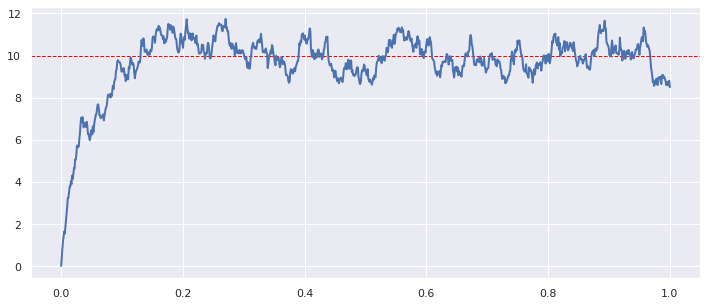

In [ ]:
# Ornstein-Uhlenbeck Process

# Function parameters

sigma = 1.  # Standard deviation.
mu = 10.  # Mean.
tau = .05  # Time constant

# Simulation parameters

dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times

# Define renormalized variables (to avoid recomputing these constants at every time step)

sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

# Create a vector that will contain all successive values of our process during the simulation:
x = np.zeros(n)

# simulate the process with the Euler-Maruyama method. 
# It is really like the standard Euler method for ODEs, but with an extra stochastic term 
# (which is just a scaled normal random variable).

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + \
        sigma_bis * sqrtdt * np.random.randn()

sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
fig, ax = plt.subplots(1, 1)
plt.axhline(y=10, color='red', linestyle='--', linewidth=1.0)
ax.plot(t, x, lw=2)

**Jump diffusion**

* [Jump diffusion](https://en.m.wikipedia.org/wiki/Jump_diffusion) is a stochastic process that involves jumps and diffusion. 

* It has important applications in magnetic reconnection, coronal mass ejections, condensed matter physics, option pricing, and pattern theory and computational vision.



**Lévy Process** 

* A Lévy process is a stochastic process with **[independent, stationary increments](https://de.m.wikipedia.org/wiki/Prozess_mit_unabhängigen_Zuwächsen)** (= the course of the future of the process is independent of the past): it represents the motion of a point whose successive displacements are random and independent, and statistically identical over different time intervals of the same length. 

* A Lévy process may thus be viewed as the **continuous-time analog of a random walk**.

* The most well known **examples of Lévy processes are Wiener process (~ Brownian motion), and Poisson process**. Aside from Brownian motion with drift, all other proper (that is, not deterministic) Lévy processes have discontinuous paths.

**Bernoulli Process**

* The outcomes of a Bernoulli process will follow a [Binomial distribution](https://en.m.wikipedia.org/wiki/Binomial_distribution).

* https://machinelearningmastery.com/discrete-probability-distributions-for-machine-learning/

* A Bernoulli process is a finite or infinite sequence of binary random variables, so it is a discrete-time stochastic process that takes only two values, canonically 0 and 1. 

* The component Bernoulli variables X<sub>i</sub> are [identically distributed and independent](https://en.m.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). Prosaically, a Bernoulli process is a repeated coin flipping, possibly with an unfair coin (but with consistent unfairness). 

* Every variable X<sub>i</sub> in the sequence is associated with a Bernoulli trial or experiment. They all have the same Bernoulli distribution. Much of what can be said about the Bernoulli process can also be generalized to more than two outcomes (such as the process for a six-sided dice); this generalization is known as the **Bernoulli scheme**.

* The problem of determining the process, given only a limited sample of Bernoulli trials, may be called the problem of checking whether a coin is fair.

**Poisson (Point) Process**

* Poisson point process is a type of random mathematical object that consists of points randomly located on a mathematical space

* Its name derives from the fact that if a collection of random points in some space forms a Poisson process, then the number of points in a region of finite size is a random variable with a Poisson distribution. 

* The process was discovered independently and repeatedly in several settings, including experiments on radioactive decay, telephone call arrivals and insurance mathematics. The Poisson point process is often defined on the real line, where it can be considered as a stochastic process. 

* On the real line, the Poisson process is a type of **continuous-time Markov process** known as a birth-death process (with just births and zero deaths) and is called a pure or simple birth process.

* In this setting, it is used, for example, in queueing theory to model random events, such as the arrival of customers at a store, phone calls at an exchange or occurrence of earthquakes, distributed in time. In the plane, the point process, also known as a spatial Poisson process, can represent the locations of scattered objects such as transmitters in a wireless network, particles colliding into a detector, or trees in a forest.

* In all settings, the Poisson point process has the property that each point is stochastically independent to all the other points in the process, which is why it is sometimes called a purely or completely random process.

* Despite its wide use as a stochastic model of phenomena representable as points, the inherent nature of the process implies that it does not adequately describe phenomena where there is sufficiently strong interaction between the points. This has inspired the proposal of other point processes, some of which are constructed with the Poisson point process, that seek to capture such interaction.

* https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a

0,0.3184252402984814,0.3184252402984814
1,0.07322923375562243,0.3916544740541038
2,0.19940946014953387,0.5910639342036377
3,0.029891782358578804,0.6209557165622165
4,0.07506904282335262,0.6960247593855691
5,0.07461636039682587,0.7706411197823949
6,0.17686201780554195,0.9475031375879368
7,0.8517942125302997,1.7992973501182365
8,0.007252394823531158,1.8065497449417678
9,0.043797412591405634,1.8503471575331734
10,0.12493191543215139,1.9752790729653247
11,0.25714107181722107,2.232420144782546
12,0.36711451831818537,2.599534663100731
13,0.05038315945052109,2.6499178225512523
14,0.0006752796445944323,2.6505931021958467
15,0.5449905853349957,3.195583687530842
16,0.02350746533605282,3.219091152866895
17,0.11119303617237011,3.330284189039265
18,0.05815615343319499,3.38844034247246
19,0.03016777786254491,3.418608120335005
20,0.2407794469392564,3.6593875672742615
21,0.14053139121550284,3.7999189584897644
22,0.0938941234176356,3.8938130819074
23,0.08413281768510751,3.9779458995925077
24,0.47390116

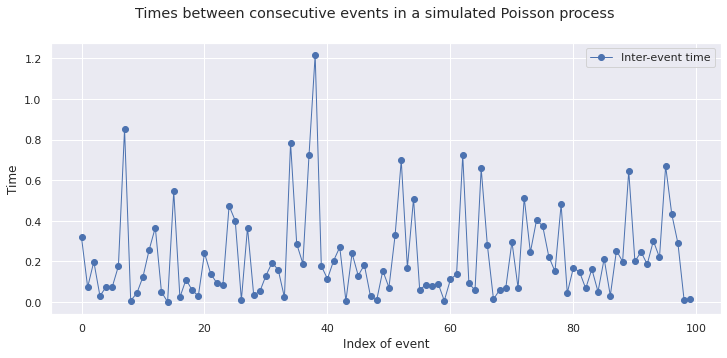

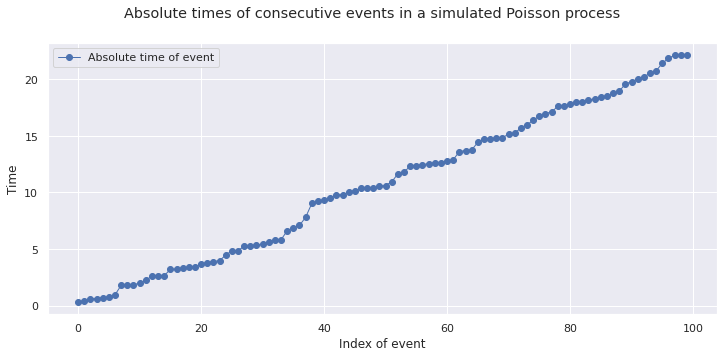

1,7
2,4
3,4
4,9
5,3
6,7
7,2
8,2
9,1
10,5
11,8
12,2
13,8
14,3
15,5
16,4
17,3
18,5
19,7
20,2
21,4
22,2


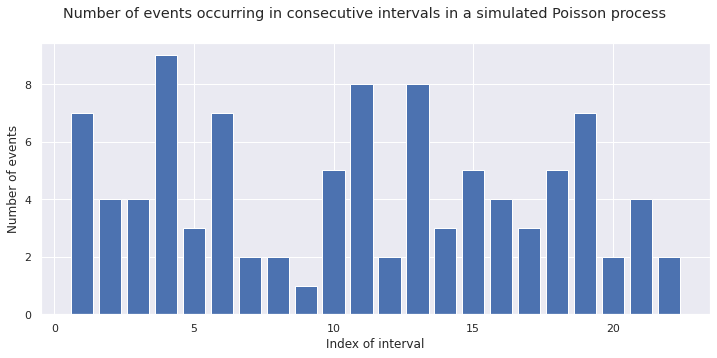

In [ ]:
import random
import math
import statistics

sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})

_lambda = 5
_num_events = 100
_event_num = []
_inter_event_times = []
_event_times = []
_event_time = 0

#print('EVENT_NUM,INTER_EVENT_T,EVENT_T')

for i in range(_num_events):
	_event_num.append(i)
	#Get a random probability value from the uniform distribution's PDF
	n = random.random()

	#Generate the inter-event time from the exponential distribution's CDF using the Inverse-CDF technique
	_inter_event_time = -math.log(1.0 - n) / _lambda
	_inter_event_times.append(_inter_event_time)

	#Add the inter-event time to the running sum to get the next absolute event time
	_event_time = _event_time + _inter_event_time
	_event_times.append(_event_time)

	#print it all out
	print(str(i) +',' + str(_inter_event_time) + ',' + str(_event_time))

#plot the inter-event times
fig = plt.figure()
fig.suptitle('Times between consecutive events in a simulated Poisson process')
plot, = plt.plot(_event_num, _inter_event_times, 'bo-', label='Inter-event time')
plt.legend(handles=[plot])
plt.xlabel('Index of event')
plt.ylabel('Time')
plt.show()


#plot the absolute event times
fig = plt.figure()
fig.suptitle('Absolute times of consecutive events in a simulated Poisson process')
plot, = plt.plot(_event_num, _event_times, 'bo-', label='Absolute time of event')
plt.legend(handles=[plot])
plt.xlabel('Index of event')
plt.ylabel('Time')
plt.show()

_interval_nums = []
_num_events_in_interval = []
_interval_num = 1
_num_events = 0

#print('INTERVAL_NUM,NUM_EVENTS')

for i in range(len(_event_times)):
	_event_time = _event_times[i]
	if _event_time <= _interval_num:
		_num_events += 1
	else:
		_interval_nums.append(_interval_num)
		_num_events_in_interval.append(_num_events)

		print(str(_interval_num) +',' + str(_num_events))

		_interval_num += 1

		_num_events = 1

#print the mean number of events per unit time
#print(statistics.mean(_num_events_in_interval))

#plot the number of events in consecutive intervals
fig = plt.figure()
fig.suptitle('Number of events occurring in consecutive intervals in a simulated Poisson process')
plt.bar(_interval_nums, _num_events_in_interval)
plt.xlabel('Index of interval')
plt.ylabel('Number of events')
plt.show()

##### <font color="blue">*Measure & Probability Theory*

###### *Measure (Maß)*

* Ein Maß ist in der Mathematik **eine Funktion**, die geeigneten Teilmengen einer Grundmenge Zahlen zuordnet, die als „Maß“ für die Größe dieser Mengen interpretiert werden können.

* Es sei $\mathcal{A}$ eine o-Algebra über einer nicht-leeren Grundmenge $\Omega .$ Eine Funktion $\mu: \mathcal{A} \rightarrow[0, \infty]$ heißt Maß auf $\mathcal{A}$, wenn die beiden folgenden Bedingungen erfüllt sind:

> $\mu(\emptyset)=0$

> Additivität: Für jede Folge $\left(A_{n}\right)_{n \in \mathbb{N}}$ paarweise disjunkter Mengen aus $\mathcal{A}$ gilt $\mu\left(\bigcup_{n=1}^{\infty} A_{n}\right)=\sum_{n=1}^{\infty} \mu\left(A_{n}\right)$

* Ist die o-Algebra aus dem Zusammenhang klar, so spricht man auch von einem Maß auf $\Omega$.

* Eine Teilmenge von $\Omega$, die in $\mathcal{A}$ liegt, wird messbar genannt. Für solch ein $A \in \mathcal{A}$ heißt $\mu(A)$ das Maß der Menge $A$. 

* Das **Tripel $(\Omega, \mathcal{A}, \mu)$ wird Maßraum** genannt.

* Das Paar $(\Omega, \mathcal{A})$ bestehend aus der Grundmenge und der darauf definierten $\sigma$-Algebra **heißt Messraum oder auch messbarer Raum**. 

* **Ein Maß $\mu$ ist also eine auf einem Messraum definierte nicht-negative [$\sigma$ -additive](https://de.m.wikipedia.org/wiki/Σ-Additivität) [Mengenfunktion](https://de.m.wikipedia.org/wiki/Mengenfunktion) mit $\mu(\emptyset)=0$.**

* Das Maß $\mu$ heißt Wahrscheinlichkeitsmaß (oder normiertes Maß), wenn zusätzlich $\mu(\Omega)=1$ gilt. Ein Maßraum $(\Omega, \mathcal{A}, \mu)$ mit einem Wahrscheinlichkeitsmaß $\mu$ ist ein Wahrscheinlichkeitsraum. 

* Ist allgemeiner $\mu(\Omega)<\infty,$ so nennt man $\mu$ ein [endliches Maß](https://de.m.wikipedia.org/wiki/Endliches_Maß). Existieren abzählbar viele Mengen, deren Maßendlich ist und deren Vereinigung ganz $\Omega$ ergibt, dann wird $\mu$ ein [$\sigma$ -endliches](https://de.m.wikipedia.org/wiki/Σ-Endlichkeit) (oder $\sigma$ -finites) Maß genannt. $^{[4]}$

https://de.m.wikipedia.org/wiki/Messbare_Funktion

https://de.m.wikipedia.org/wiki/Maß_(Mathematik)

https://de.m.wikipedia.org/wiki/Σ-Additivität

**Zählmaß**

$\mu$ (A) := 
* #A, wenn A endlich
* ∞, sonst

Rechenregeln in [0, ∞] : 
* x + ∞ := ∞ für alle x ∈ [0, ∞]
* x * ∞ := ∞ für alle x ∈ [0, ∞]
* 0 * ∞ := 0 (in der Maßtheorie sinnvoll)

**Dirac Maß**

p ∈ X (Punktmaß, weil es einem Punkt ein Maß zuordnet, und sonst Null).

Ist p innerhalb eine Menge A als Teilmenge von X, dann ist Diracmaß = 1, sonst 0.

δ<sub>p</sub> (A) :=
* 1, wenn p ∈ A
* 0, wenn sonst.

(δ = delta klein)

https://de.m.wikipedia.org/wiki/Diracmaß

**Lebesgue Maß**

* Das Lebesgue-Maß ist das **Maß im euklidischen Raum**, das geometrischen Objekten ihren Inhalt (Länge, Flächeninhalt, Volumen, …) zuordnet.

* Das Lebesgue-Borel-Maß auf der Borel-$\sigma$-Algebra $\mathcal{B}\left(\mathbb{R}^{n}\right)$ (auch als Borel-Lebesgue-Maß oder nur Bore/-Maß bezeichnet) ist das eindeutige Maß $\lambda$ mit der Eigenschaft, dass es $n$ -dimensionalen
Hyperrechtecken ihr $n$ -dimensionales Volumen zuordnet:

>$\lambda\left(\left[a_{1}, b_{1}\right] \times \cdots \times\left[a_{n}, b_{n}\right]\right)=\left(b_{1}-a_{1}\right) \cdots \cdots\left(b_{n}-a_{n}\right)$

* Das heißt, **es ist das Maß, das Intervallen inre Länge zuordnet (im Eindimensionalen), Rechtecken ihren Flächeninhalt zuordnet (im Zweidimensionalen), Quadern ihr Volumen zuordnet (im Dreidimensionalen) usw.** 

* Durch diese Bedingung wird der Inhalt $\lambda(B)$ beliebiger Borel-Mengen eindeutig festgelegt. Die BorelMengen werden auch Borel-messbar oder $B$ -messbar genannt. **Das Borel-Maß ist bewegungsinvariant und normiert, aber nicht vollständig.**

* Das Lebesgue-Maß ist das Haar-Maß **auf der lokalkompakten topologischen Gruppe** $\mathbb {R} ^{n}$ mit der Addition, die Existenz folgt daher bereits aus der Existenz des Haarmaßes. 

* Insbesondere ist es translationsinvariant, das bedeutet, dass sich das Maß einer Menge unter Translation nicht ändert. Zudem ist es invariant unter Spiegelungen und Drehungen, also sogar bewegungsinvariant. Das Lebesgue-Maß ist σ-endlich und regulär.

https://de.m.wikipedia.org/wiki/Lebesgue-Maß

**Haarsches Maß**

* Das Haarsche Maß wurde eingeführt, um Ergebnisse der **Maßtheorie in der Gruppentheorie anwendbar zu machen**.

* Beispiel: Das Lebesgue-Maß $B$ auf $\mathbb{R}^{n}$ und $\mathbb{C}^{n}$ ist das Haarsche Maß auf den additiven Gruppen $\left(\mathbb{R}^{n},+\right)$ bzw. $\left(\mathbb{C}^{n},+\right)$.

* Es ist eine Verallgemeinerung des Lebesgue-Maßes. Das Lebesgue-Maß ist ein Maß auf dem euklidischen Raum, das unter Translationen invariant ist. 

* Der euklidische Raum ist eine lokalkompakte topologische Gruppe bezüglich der Addition. Das Haarsche Maß ist für jede lokalkompakte (im Folgenden immer als hausdorffsch vorauszusetzende) topologische Gruppe definierbar, insbesondere also für jede Lie-Gruppe. 

* Lokalkompakte Gruppen mit ihren Haarschen Maßen werden in der [harmonischen Analyse](https://de.m.wikipedia.org/wiki/Harmonische_Analyse) untersucht.

https://de.m.wikipedia.org/wiki/Haarsches_Maß

**Haussdorf Maß**

* Das Hausdorff-Maß ist eine Verallgemeinerung des Lebesgue-Maßes auf nicht notwendig ganzzahlige Dimensionen. Mit seiner Hilfe lässt sich die Hausdorff-Dimension definieren, ein Dimensionsbegriff, mit dem beispielsweise fraktale Mengen untersucht werden können.

https://de.m.wikipedia.org/wiki/Hausdorff-Maß

**Jordan Maß**

* Mit dem Jordan-Maß kann man beschränkten Teilmengen des $\mathbb {R} ^{n}$ einen Inhalt zuordnen und erhält einen Integralbegriff, der dem [riemannschen Integralbegriff](https://de.m.wikipedia.org/wiki/Riemannsches_Integral) analog ist.

* Das Jordan-Maß ist kein Maß im Sinne der Maßtheorie.

https://de.m.wikipedia.org/wiki/Jordan-Maß

Siehe auch: https://de.m.wikipedia.org/wiki/Inhalt_(Maßtheorie)

**Radon Maß**

Es handelt sich um ein spezielles Maß auf der Borelschen σ-Algebra eines Hausdorff-Raums mit bestimmten Regularitätseigenschaften. Der Begriff wird in der Fachliteratur jedoch nicht einheitlich verwendet. 

https://de.m.wikipedia.org/wiki/Radonmaß

**Measurable Space (Messbarer Raum)**

Das Tupel $(\Omega, \mathcal{A}, \mu)$ heißt Maßraum, wenn

* $\Omega$ eine beliebige, nichtleere Menge ist. $\Omega$ wird dann auch Grundmenge (universe / Set) genannt.

* $\mathcal{A}$ eine $\sigma$ -Algebra über der Grundmenge $\Omega$ ist.

Zusammen mit einem Maß $\mu$ wird aus einem messbaren Raum ein Maßraum.

* **A measurable space or Borel space is a basic object in measure theory**. It consists of a set and a σ-algebra, which defines the subsets that will be measured.

* Note that in contrast to a measure space, **no measure is needed for a measurable space**.

**Messraum und Maßraum sind spezielle σ-Algebren.**

**Example**

Look at the set

X=\{1,2,3\}

One possible $\sigma$ -algebra would be

$\mathcal{A}_{1}=\{X, \emptyset\}$

Then $\left(X, \mathcal{A}_{1}\right)$ is a measurable space. 

Another possible $\sigma$ -algebra would be the power set on $X$ :

$\mathcal{A}_{2}=\mathcal{P}(X)$

With this, a second measurable space on the set $X$ is given by $\left(X, \mathcal{A}_{2}\right)$.

**Types**

* If $X$ is finite or countable infinite, **the $\sigma$ -algebra is most of the times the power set on $X$**, so $\mathcal{A}=\mathcal{P}(X) .$ This leads to the measurable space $(X, \mathcal{P}(X))$

* **If $X$ is a topological space, the $\sigma$ -algebra is most commonly the Borel $\sigma$ -algebra $\mathcal{B}$**, so $\mathcal{A}=\mathcal{B}(X)$. This leads to the measurable space $(X, \mathcal{B}(X))$ that is common for all topological spaces such as
the real numbers $\mathbb{R}$.


https://en.m.wikipedia.org/wiki/Measurable_space

**Riemann vs Lebesgue Integral**

https://de.m.wikipedia.org/wiki/Integralrechnung

https://de.m.wikipedia.org/wiki/Maßtheorie

https://de.wikipedia.org/wiki/Satz_von_Fubini

###### *Measure Space (Maßraum)*

> One important example of a measure space is a probability space.

Ein Maßraum ist eine spezielle mathematische Struktur, die eine essentielle Rolle in der Maßtheorie und dem axiomatischen Aufbau der Stochastik spielt.

Das Tripel $(\Omega, \mathcal{A}, \mu)$ heißt Maßraum, wenn

* $\Omega$ eine beliebige, nichtleere Menge ist. $\Omega$ wird dann auch Grundmenge genannt.

* $\mathcal{A}$ eine [$\sigma$ -Algebra](https://de.m.wikipedia.org/wiki/Σ-Algebra) über der Grundmenge $\Omega$ ist.

* $\mu$ ein [Maß](https://de.m.wikipedia.org/wiki/Maß_(Mathematik)) ist, das auf $\mathcal{A}$ definiert ist.

Alternativ kann man einen Maßraum auch als einen [Messraum](https://de.m.wikipedia.org/wiki/Messraum_(Mathematik)) $(\Omega, \mathcal{A})$ versehen mit einem Maß $\mu$ definieren.

A measure space is a triple $(X, \mathcal{A}, \mu),$ where

* $X$ is a set

* $\mathcal{A}$ is a $\sigma$ -algebra on the set $X$

* $\boldsymbol{\mu}$ is a measure on $(X, \mathcal{A})$

**Messraum und Maßraum sind spezielle σ-Algebren.**

https://en.m.wikipedia.org/wiki/Measure_space

**Beispiele**

* Ein einfaches Beispiel für einen Maßraum sind die natürlichen Zahlen als Grundmenge $\Omega=\mathbb{N}$, als $\sigma$ Algebra wählt man die Potenzmenge $\mathcal{A}=\mathcal{P}(\mathbb{N})$ und als Maß das Diracmaß auf der $1: \mu=\delta_{1}$

* Ein bekannter Maßraum ist die Grundmenge $\mathbb{R}$, versehen mit der borelschen $\sigma$ -Algebra $\mathcal{B}(\mathbb{R})$ und dem Lebesgue-Maß. **Dies ist der kanonische Maßraum in der Integrationstheorie.**

* Die in der Wahrscheinlichkeitstheorie verwendeten **[Wahrscheinlichkeitsräume](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsraum)** $(\Omega, \mathcal{A}, P)$ sind allesamt Maßräume. Sie bestehen aus der Ergebnismenge $\Omega$, der Ereignisalgebra $\mathcal{A}$ und dem Wahrscheinlichkeitsmaß $P$ (= synonym 'Wahrscheinlichkeitsverteilung' oder einfach 'Verteilung'). Mit den Eigenschaften: Die drei Forderungen Normiertheit, σ-Additivität und Werte im Intervall zwischen 0 und 1 werden auch die Kolmogorow-Axiome genannt. ([Source](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsma%C3%9F))

**Klassen von Maßräumen**

https://de.m.wikipedia.org/wiki/Σ-Endlichkeit

https://de.m.wikipedia.org/wiki/Vollständiges_Maß

und mehr..

* Verzichtet man auf Abstände und Winkel, behält jedoch das Volumen geometrischer Körper bei, gelangt man in das Gebiet der Maßtheorie. (für ein wahrscheinlichkeitsmaß volumen = 1)

* Der Maßtheorie gelang es, den Begriff des Volumens (oder eines anderen Maßes) auf eine enorm große Klasse von Mengen auszudehnen, die sogenannten messbaren Mengen. In vielen Fällen ist es jedoch unmöglich, allen Mengen ein Maß zuzuordnen (siehe Maßproblem).
Die messbaren Mengen bilden dabei eine σ-Algebra. Mit Hilfen von messbaren Mengen lassen sich messbare Funktionen zwischen Messräumen definieren.

* Um einen topologischen Raum zu einem Messraum zu machen, muss man ihn mit einer σ-Algebra ausstatten. Die σ-Algebra der Borel-Mengen ist die verbreitetste, aber nicht die einzige Wahl.

* Ein Maßraum ist ein Messraum, der mit einem Maß versehen ist. Ein euklidischer Raum mit dem [Lebesgue-Maß](https://de.m.wikipedia.org/wiki/Lebesgue-Maß) ist beispielsweise ein Maßraum. In der Integrationstheorie werden Integrierbarkeit und Integrale messbarer Funktionen auf Maßräumen definiert. Mengen vom Maß null werden Nullmengen genannt.

* A measure space is a basic object of measure theory, a branch of mathematics that studies generalized notions of volumes. 

* It contains an underlying set, the subsets of this set that are feasible for measuring (the σ-algebra) and the method that is used for measuring (the measure). 

* **One important example of a measure space is a probability space**.

* A measurable space consists of the first two components without a specific measure.

A **complete measure** (or, more precisely, a complete measure space) is a measure space in which every subset of every null set is measurable (having measure zero). 

https://en.m.wikipedia.org/wiki/Complete_measure

**Probability Space (Wahrscheinlichkeitsraum)**

Gegeben sei

* eine Menge $\Omega$, der sogenannte **Ergebnisraum**,

* eine o-Algebra $\Sigma$ auf dieser Menge, das **Ereignissystem**.

Dann heißt eine Abbildung (=Funktion)

>$P: \Sigma \rightarrow[0,1]$

mit den Eigenschaften

*  Normiertheit: Es ist $P(\Omega)=1$

* $\sigma$-Additivität: Für jede abzählbare Folge von paarweise disjunkten Mengen $A_{1}, A_{2}, A_{3}, \ldots$ aus $\Sigma$ gilt $P\left(\bigcup_{i=1}^{\infty} A_{i}\right)=\sum_{i=1}^{\infty} P\left(A_{i}\right)$

ein Wahrscheinlichkeitsmaß oder eine Wahrscheinlichkeitsverteilung.

Die drei Forderungen Normiertheit, $\sigma$-Additivität und Werte im Intervall zwischen O und 1 werden auch die [Kolmogorow-Axiome](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitstheorie#Axiome_von_Kolmogorow) genannt.

https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsmaß

* **One important example of a measure space is a probability space.**

* Ein Wahrscheinlichkeitsraum ist ein Maßraum, bei dem das Maß des ganzen Raums gleich 1 ist.

* In der Wahrscheinlichkeitstheorie werden für die verwendeten maßtheoretischen Begriffe meist eigene Bezeichnungen verwendet, die der Beschreibung von Zufallsexperimenten angepasst sind: Messbare Mengen werden Ereignisse und messbare Funktionen zwischen Wahrscheinlichkeitsräumen werden Zufallsvariable genannt; ihre Integrale sind Erwartungswerte.

* Das Produkt einer endlichen oder unendlichen Familie von Wahrscheinlichkeitsräumen ist wieder ein Wahrscheinlichkeitsraum. Im Gegensatz dazu ist für allgemeine Maßräume nur das Produkt endlich vieler Räume definiert. Dementsprechend gibt es zahlreiche unendlichdimensionale Wahrscheinlichkeitsmaße, beispielsweise die Normalverteilung, aber kein unendlichdimensionales Lebesgue-Maß.
Diese Räume sind weniger geometrisch. Insbesondere lässt sich die Idee der Dimension, wie sie in der einen oder anderen Form auf alle anderen Räume anwendbar ist, nicht auf Messräume, Maßräume und Wahrscheinlichkeitsräume anwenden.

* Es handelt sich um ein mathematisches Modell zur Beschreibung von Zufallsexperimenten. Hierbei werden die verschiedenen möglichen Ausgänge des Experiments zu einer Menge zusammengefasst. Teilmengen dieser Ergebnismenge können dann unter bestimmten Voraussetzungen Zahlen zwischen 0 und 1 zugeordnet werden, die als Wahrscheinlichkeiten interpretiert werden.

* Ein Wahrscheinlichkeitsraum ist ein Maßraum (Ω, Σ, P) dessen Maß P ein Wahrscheinlichkeitsmaß ist. Im Einzelnen bedeutet das: 

* Ω ist eine beliebige nichtleere Menge, genannt die Ergebnismenge. Ihre Elemente heißen Ergebnisse.

* Σ (Sigma) ist eine σ-Algebra über der Grundmenge Ω (Omega), also eine Menge bestehend aus Teilmengen von Ω, die Ω enthält und abgeschlossen gegenüber der Bildung von Komplementen und abzählbaren Vereinigungen ist. Die Elemente von Σ heißen Ereignisse. Die σ-Algebra Σ selbst wird auch Ereignissystem oder Ereignisalgebra genannt.

* P : Σ –> [0,1] ist ein Wahrscheinlichkeitsmaß, das heißt eine Mengenfunktion, die den Ereignissen Zahlen zuordnet, derart dass P(∅) = 0 ist, P (A1 ∪ A2 ∪ … ) = P(A1) + P(A2) + … für paarweise disjunkte (d. h. sich gegenseitig ausschließende) Ereignisse A1, A2, … gilt (3. Kolmogorow-Axiom) und P(Ω) = 1 ist (2. Kolmogorow-Axiom).

* Der Messraum (Ω, Σ) wird auch Ereignisraum genannt. Ein Wahrscheinlichkeitsraum ist also ein Ereignisraum, auf dem zusätzlich ein Wahrscheinlichkeitsmaß gegeben ist.

https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsraum

###### *Measurable Space (Messraum)*

* [Messraum](https://en.wikipedia.org/wiki/Measurable_space) und Maßraum sind spezielle σ-Algebren.

###### *Field of Sets (Algebra oder Mengensystem)*

**Mengensystem** oder **Mengenalgebra** oder **Fields of Sets**

* **A field of sets is a pair $\langle X, \mathcal{F}\rangle$ where $X$ is a set and $\mathcal{F}$ is an algebra over $X$** 

* i.e., a subset of the power set of $X$, closed under complements of individual sets and under the union (hence also under the intersection) of pairs of sets, and satisfying $X \in \mathcal{F}$. 

* In other words, $\mathcal{F}$ forms
a subalgebra of the power set Boolean algebra of $X$ (with the same identity element $X \in \mathcal{F}$ ).
(Many authors refer to $\mathcal{F}$ itself as a field of sets.) Elements of $X$ are called points and those of $\mathcal{F}$
are called complexes and are said to be the admissible sets of $X$.

Ω (Omega) sei eine beliebige (Grund-)Menge. Ein System $\mathcal{A}$ (oder $\mathcal{F}$) von Teilmengen von Ω heißt eine Mengenalgebra oder Algebra über Ω, wenn folgende Eigenschaften erfüllt sind:

1. $\mathcal{A} \neq \emptyset$ ( $\mathcal{A}$ ist nicht leer)

2. $A, B \in \mathcal{A} \Rightarrow A \cup B \in \mathcal{A}$ (Stabilität/Abgeschlossenheit bezüglich Vereinigung)

3. $A \in \mathcal{A} \Rightarrow A^{\mathrm{c}} \in \mathcal{A}$ (Stabilität/Abgeschlossenheit bezüglich Komplementbildung $\left.A^{c}=\Omega \backslash A\right)$

* In der Mathematik ist (Mengen-)Algebra ein Grundbegriff der Maßtheorie. Er beschreibt ein nicht-leeres Mengensystem, das vereinigungs- und komplementstabil ist.

* A field of sets is a **pair ⟨X,F⟩** where X is a set and F is an algebra over X i.e., a subset of the power set of X, closed under complements of individual sets and under the union (hence also under the intersection) of pairs of sets, and satisfying X ∈ F. 

* In other words, F forms a subalgebra of the power set Boolean algebra of X (with the same identity element X ∈ F). (Many authors refer to F itself as a field of sets.) 

* **Elements of X are called points and those of F are called complexes and are said to be the admissible sets of X.**

* For arbitrary set $Y$, its power set (Potenzmenge) $2^{Y}$ (or, somewhat pedantically, the pair $\left\langle Y, 2^{Y}\right\rangle$ of this set and its power set) is a field of sets. 

* If $Y$ is finite (namely, $n$ -element), then $2^{Y}$ is finite (namely, $2^{n}$ element). 

* It appears that every finite field of sets (it means, $\langle X, \mathcal{F}\rangle$ with $\mathcal{F}$ finite, while $X$ may be infinite) admits a representation of the form $\left\langle Y, 2^{Y}\right\rangle$ with finite $Y ;$ it means a function $f: X \rightarrow Y$ that establishes a one-to-one correspondence between $\mathcal{F}$ and $2^{Y}$ via inverse image:
$S=f^{-1}[B]=\{x \in X \mid f(x) \in B\}$ where $S \in \mathcal{F}$ and $B \in 2^{Y}$ (that is, $B \subset Y$ ). 

* One notable consequence: the number of complexes, if finite, is always of the form $2^{n}$.

**Beispiele für Algebra**

* Für jede beliebige Menge $\Omega$ ist $\{\emptyset, \Omega\}$ die kleinste und die Potenzmenge $\mathcal{P}(\Omega)$ die größtmögliche Mengenalgebra.
* Jede $\sigma$ -Algebra ist eine Mengenalgebra.
* Für jede Menge $\Omega$ ist das Mengensystem $\mathcal{A}=\left\{A \subseteq \Omega \mid A \text { endlich oder } A^{c} \text { endlich }\right\}$ eine Mengenalgebra. Wenn $\Omega$ unendich ist, dann ist $\mathcal{A}$ keine $\sigma$ -Algebra.

**Separative and compact fields of sets: towards Stone duality**

* A field of sets is called **separative (or differentiated)** if and only if for every pair of distinct points there is a complex containing one and not the other.

* A field of sets is called **compact** if and only if for every proper filter over X the intersection of all the complexes contained in the filter is non-empty.

Given a field of sets $\mathbf{X}=\langle X, \mathcal{F}\rangle$ the complexes form a base for a topology. We denote by $T(\mathbf{X})$ the corresponding topological space, $\langle X, \mathcal{T}\rangle$ where $\mathcal{T}$ is the topology formed by taking arbitrary unions of complexes. Then

1. $T(\mathbf{X})$ is always a [zero-dimensional space](https://en.m.wikipedia.org/wiki/Zero-dimensional_space)

2. $T(\mathbf{X})$ is a [Hausdorff space](https://en.m.wikipedia.org/wiki/Hausdorff_space) if and only if $\mathbf{X}$ is separative.

3. $T(\mathbf{X})$ is a compact space with compact open sets $\mathcal{F}$ if and only if $\mathbf{X}$ is compact.

4. $T(\mathbf{X})$ is a Boolean space with clopen sets $\mathcal{F}$ if and only if $\mathbf{X}$ is both separative and compact (in which case it is described as being descriptive)

https://en.m.wikipedia.org/wiki/Field_of_sets

###### *σ-algebra (Sigma Algebra)*

**σ-algebra (Sigma Algebra)**

* https://mathepedia.de/Sigma-Algebren.html

* Sei $\Omega \neq \emptyset$ eine Menge, $\mathfrak{P}(\Omega)$ die Potenzmenge und $\mathcal{F} \subseteq \mathfrak{P}(\Omega)$ ein Mengensystem (=field of sets).

Definition

$\mathcal{F}$ heißt Algebra, wenn folgende Eigenschaften gelten:

(1) $\quad \emptyset \in \mathcal{F}$

(2) $\quad A \in \mathcal{F} \Rightarrow A^{c} \in \mathcal{F}$

(3) $\quad A, B \in \mathcal{F} \Rightarrow A \cup B \in \mathcal{F}$

$\mathcal{F}$ heißt $\sigma$ -Algebra, wenn die Punkte (1) und (2) gelten
und zusätzlich

(4) $\quad A_{1}, A_{2}, \ldots \in \mathcal{F} \Rightarrow \bigcup A_{k} \in \mathcal{F}$

gilt.

Algebren sind bezüglich der endlichen Vereinigung abgeschlossene Mengensysteme und $\sigma$ -Algebren sind bezüglich der abzählbaren Vereinigung abgeschlossene
Mengensysteme. Wegen (1) und (2) gilt stets $\Omega \in \mathcal{F}$.

* If an algebra over a **set is closed under countable unions** (hence also under countable intersections), it is called a **sigma algebra** and **the corresponding field of sets (Mengensystem) is called a measurable space**. The complexes of a measurable space are called measurable sets.

* * **A measure space is a triple $\langle X, \mathcal{F}, \mu\rangle$ where $\langle X, \mathcal{F}\rangle$ is a measurable space and $\mu$ is a measure defined on it.** (Alternative: $\langle$ Ω , $\mathcal{F}$, $\mu$ $\rangle$)

* If $\mu$ is in fact a probability measure we speak of a probability space and call its underlying measurable space a sample space. 

* The points of a sample space are called samples and represent potential outcomes while the measurable sets (complexes) are called events and represent properties of outcomes for which we wish to assign probabilities. (Many use the term sample space simply for the underlying set of a probability space, particularly in the case where every subset is an event.) 

* Measure spaces and probability spaces play a foundational role in measure theory and probability theory respectively.

* https://de.m.wikipedia.org/wiki/Algebra_(Mengensystem)

**Pain Point**

* How to define a messbare Menge?

* Wenn wir eine Menge aus den reellen Zahlen haben und mochten eine Teilbereich [a bis b] messen, dann brauchen wir einen allgemeinen Massbegriff unabhangig von der konkreten Menge. Hier kommt Masstheorie und Sigma-Algebra.

**Definition**

* A σ-algebra defines the **set of events that can be measured**, which in a probability context is equivalent to events that can be discriminated, or "questions that can be answered at time t".

* Exkurs: Ergebnis vs Ereignis. Die möglichen Ausgänge eines Zufallsexperimentes nennt man **Ergebnisse** (zB auf einem Wüfel die Zahlen 1,2,3..). Wenn man alle möglichen Ergebnisse eines Zufallsexperimentes in einer Menge zusammenfasst, erhält man die **Ergebnismenge**. Sie wird üblicherweise mit dem Symbol Ω (sprich Omega) bezeichnet. Beim Würfeln ist Ω= {1; 2; 3; 4; 5; 6} die Ergebnismenge. Jede Zusammenfassung von einem oder mehreren Ergebnissen eines Zufallsexperimentes in einer Menge nennt man **Ereignis** (zB auf einem Würfel die Menge an geraden Zahlen {2,4,6} und ungeraden Zahlen {1,3,5}.

* Eine Sigma-Algebra F ist ein System, um alle möglichen **Ereignisse** (nicht Ergebnisse!) eines Zufallsexperiment zu beschreiben. Ereignisse sind an sich selbst Mengen, die man wie jede Menge vereinigen oder schneiden bzw. auch das Komplement bilden kann um so das Gegenereignis zu erhalten. Fasst man hier alle möglichen Kombinationen an Ereignissen in einer Menge zusammen, bekommt man eine Menge, die wiederum Mengen als Elemente enthält - eine Menge von Mengen sozusagen. Oft sagt man dazu auch einfach Mengensystem. Welche Eigenschaften ein Mengensystem genau haben muss, damit es eine Sigma-Algebra ist steht weiter unten.

* Beispiel: Glücksrad mit blau, rot und grün. Dann haben wir folglich drei Ergebnisse, die wir auch abkürzen können: Ω={B,R,G}. Generell kann man sich schon merken: Ω und ∅ sind immer Elemente einer Sigma-Algebra. Daher haben wir hier 8 mögliche Teilmengen von Ω, die wir als Ereignis betrachten können und demnach als Menge in der Sigma-Algebra zusammenfassen (Potenzmenge von Omega): F ={∅, {B}, {R}, {G}, {B,R}, {B,G}, {R,G}, {B,R,G}} ([Source](https://www.massmatics.de/merkzettel/#!876:Ereignisraum_&_Sigma-Algebra)).

* Bei diskreten Ergebnismengen kann man für die Sigma-Algebra immer die Potenzmenge P(Ω)nehmen und hat demnach dann stets diesen **Ereignisraum: (Ω,P(Ω))**

* Und für die reellen Zahlen gibt es die sogenannte **Borelsche Sigma-Algebra B**, die man dann auch in der Regel benutzt. Ist die Ergebnismenge Ω eine Teilmenge der reellen Zahlen (oder ℝ selbst), so nehmen wir die Borelsche-Sigma B und der Ereignisraum lautet (Ω,B).

* Wenn wir eine Sigma Algebra A gegeben haben, dann heisst jede Teilmenge in diesem Mengensystem (jedes Element aus dieser Sigma Algebra A) eine messbare Teilmenge (=die Mengen die wir messen wollen).

* **<u>Die Elemente der Sigma Algebra sind die messbaren Teilmengen von unserer Grundmenge X</u>** (Und messbar ist der wesentliche Begriff). Das ist zB die Menge an vergangenen Trading-Events am Finanzmarkt bis zum Zeitpunkt t.

* Sigma Algebra ist ein **Mengensystem von einer Teilmenge einer gegebenen Grundmenge** = der Raum, **den wir beschreiben wollen** (mit drei Eigenschaften). Die Menge einer Sigma-Algebra nennt man „**messbare Teilmengen**“.

**Eigenschaften**

* **A $\subseteq$ P(X) (=Potenzmenge) heisst Sigma Algebra, wenn gilt** (Die Mengen, die in dieser Sigma Algebra liegen, das sind jene, die folgende drei Eigenschaften erfüllen, und sind die, die wir messen wollen (=diesen Mengen wollen wir ein Mass zuordnen). Potenzmenge selbst soll eine Sigma Algebra sein. Sollten gewissen Eigenschaften der Potenzmenge fordern). **<u>A collection of subsets</u> A is called a σ-algebra on a set X if the following properties are met:**

1. **A contains X (the set itself)**: $\quad \phi, X \in A$ (Leere Menge (sollte Länge oder Volumen Null haben) und ganze Grundmenge selbst haben wir im Mengensystem / sollen messbar sein. Das ist was Sigma Algebra sagt). **Ω ∈ F (Ergebnismenge muss enthalten sein)**

2. **If A contains a subset S, then A also contains the complement of S**: $A \in A \Rightarrow A^{c}:=X \backslash A \in A$ (Irgendein Element in der Algebra: dann sollte auch dessen Komplement im Mengensystem enthalten sein.) Hiermit ist auch Regel 1 eingeschlossen! Deswegen liegt auch die leere Menge (Gegenereignis von Ω) in F.

3. **Consider a countable collection of subsets. If each subset is included in A, then A must also contain their reunion.**: $A_{i} \in A$ fur i $\in N \Rightarrow \bigcup_{i=1}^{\infty} A_{i} \in A$ ((Letzter Punkt macht das Sigma aus): Abzählbarkeit, abzählbare Summe (A i‘s aus unseren Mengensystem A): wir haben endlich viele bzw. abzählbar viele, dann können wir die Vereinigung bilden / abziehbare Vereinigung. Die abzählbare Vereinigung soll wieder in der Sigma Algebra liegen = Wenn wir Längen haben, dann sollten wir die auch addieren können, auch wenn sich die Addition bis unendlich streckt! (blick auf messbarkeit))

Having defined such a σ-algebra A, we call **the elements of σ-algebra A measurable sets** and the couple (X, A) a measurable space. An arbitrary set X can be a member of a multitude of σ-algebras. We denote the set of all σ-algebras that contain X with M(X). The **intersection of all those σ-algebras is called the σ-algebra generated by X**.

**A σ-algebra (also σ-field) on a set X is a collection Σ of subsets of X that includes X itself, is closed under complement, and is closed under countable unions**. The definition implies that it also includes the empty subset and that it is closed under countable intersections. The pair (X, Σ) is called a measurable space or Borel space. A σ-algebra is a type of algebra of sets. An algebra of sets needs only to be closed under the union or intersection of finitely many subsets, which is a weaker condition.

**Borel‘sche Sigma-Algebra**

* T ist ein topologischer Raum (oder ein metrischer Raum im engeren Sinn.) und X eine Menge darin. „Offene Mengen“.

* Die Borel’sche Sigma Algebra auf topologischen Raum X ist jene kleinste Sigma Algebra, die von den offenen Mengen erzeugt wird. 

* B(X) := (T)

**Measurable function**

* **A set is measurable when it’s included in a σ-algebra.**

* We can also extend the “measurable” attribute to functions. Here’s how:

* Let’s consider (X, A) and (Y, B) two measurable spaces. A function f from A to B is called measurable if every set from B comes from applying f to a set from A. Formally, we say that for any element S of B, the pre-image of S under the function f is in A.


**Application**

* The main use of σ-algebras is in the definition of measures; specifically, the collection of those subsets for which a given measure is defined is necessarily a σ-algebra. 

* This concept is important in mathematical analysis as the **foundation for Lebesgue integration**, and in probability theory, where it is **interpreted as the collection of events which can be assigned probabilities**. 

* Also, **in probability, σ-algebras are pivotal in the definition of conditional expectation**.

* In statistics, (sub) σ-algebras are needed for the formal mathematical definition of a sufficient statistic, particularly when the statistic is a function or a random process and the notion of conditional density is not applicable.

**Examples**

1. **Minimum**: Sigma Algebra A enthält leere Menge und Grundmenge selbst (kleinste Sigma Algebra die möglich ist): A = {𝜙,X}
2. **Maximum**: Sigma Algebra enthält die Potenzmenge (beinhaltet alle Teilmengen von X): A = P(X)

* If {A1, A2, A3, …} is a countable partition of X then the **collection of all unions of sets in the partition** (including the empty set) is a σ-algebra.

* A more useful example is the set of subsets of the real line formed by starting with all open intervals and adding in all countable unions, countable intersections, and relative complements and continuing this process (by transfinite iteration through all countable ordinals) until the relevant closure properties are achieved - the σ-algebra produced by this process is known as the Borel algebra on the real line, and can also be conceived as the smallest (i.e. "coarsest") σ-algebra containing all the open sets, or equivalently containing all the closed sets. It is foundational to measure theory, and therefore modern probability theory, and a related construction known as the Borel hierarchy is of relevance to descriptive set theory.

###### *Measure-theoretic probability theory*

**Measure-theoretic probability theory**

* The raison d'être of the measure-theoretic treatment of probability is that it unifies the discrete and the continuous cases, and makes the difference a question of which measure is used. Furthermore, it covers distributions that are neither discrete nor continuous nor mixtures of the two.

* Other distributions may not even be a mix, for example, the Cantor distribution has no positive probability for any single point, neither does it have a density. 

* The modern approach to probability theory solves these problems using measure theory to define the probability space:

Given any set $\Omega$ (also called sample space) and a $\sigma$ -algebra $\mathcal{F}$ on it, a measure $P$ defined on $\mathcal{F}$ is
called a probability measure if $P(\Omega)=1$

If $\mathcal{F}$ is the Borel $\sigma$ -algebra on the set of real numbers, then there is a unique probability measure on
$\mathcal{F}$ for any cdf, and vice versa. The measure corresponding to a cdf is said to be induced by the cdf.

This measure coincides with the pmf for discrete variables and pdf for continuous variables, making the measure-theoretic approach free of fallacies.

The probability of a set $E$ in the $\sigma$ -algebra $\mathcal{F}$ is defined as

$P(E)=\int_{\omega \in E} \mu_{F}(d \omega)$

where the integration is with respect to the measure $\mu_{F}$ induced by $F$

Along with providing better understanding and unification of discrete and continuous probabilities, measure-theoretic treatment also allows us to work on probabilities outside R<sup>n</sup>, as in the theory of stochastic processes. For example, to study Brownian motion, probability is defined on a space of functions.

When it's convenient to work with a dominating measure, the Radon-Nikodym theorem is used to define a density as the Radon-Nikodym derivative of the probability distribution of interest with respect to this dominating measure. 

* Discrete densities are usually defined as this derivative with respect to a counting measure over the set of all possible outcomes. 

* Densities for absolutely continuous distributions are usually defined as this derivative with respect to the Lebesgue measure. 

* If a theorem can be proved in this general setting, it holds for both discrete and continuous distributions as well as others; separate proofs are not required for discrete and continuous distributions.


https://en.m.wikipedia.org/wiki/Probability_theory

###### *Filtrations*

**Filtrations**

* https://de.m.wikipedia.org/wiki/Filtrierung_(Wahrscheinlichkeitstheorie)

* In martingale theory and the theory of stochastic processes, a **filtration is an increasing sequence of σ-algebras on a measurable space**.

* That is, given a measurable space $(\Omega, \mathcal{F}),$ a filtration is a sequence of $\sigma$ -algebras $\left\{\mathcal{F}_{t}\right\}_{t \geq 0}$ with $\mathcal{F}_{t} \subseteq \mathcal{F}$ where each $t$ is a non-negative real number and 

> $t_{1} \leq t_{2} \Longrightarrow \mathcal{F}_{t_{1}} \subseteq \mathcal{F}_{t_{2}}$

* The exact range of the "times" $t$ will usually depend on context: the set of values for $t$ might be discrete or continuous, bounded or unbounded. For example,

> $t \in\{0,1, \ldots, N\}, \mathbb{N}_{0},[0, T]$ or $[0,+\infty)$

* **A σ-algebra defines the set of events that can be measured, which in a probability context is equivalent to events that can be discriminated, or "questions that can be answered at time t".** 

* **Therefore, a filtration is often used to represent the change in the set of events that can be measured, through gain or loss of information**. 

* A typical example is in mathematical finance, where a filtration represents the information available up to and including each time t, and is more and more precise (the set of measurable events is staying the same or increasing) as more information from the evolution of the stock price becomes available.

A Filtration is a growing sequence of sigma algebras

> $\mathcal{F}_{1} \subseteq \mathcal{F}_{2} \ldots \subseteq \mathcal{F}_{n}$

When talking of martingales we need to talk of conditional expectations, and in particular conditional expectations w.r.t σ algebra's. So whenever we write

> $E\left[Y_{n} \mid X_{1}, X_{2}, \ldots, X_{n}\right]$

which can be written as

> $E\left[Y_{n+1} \mid \mathcal{F}_{n}\right]$

where F𝑛 is a sigma algebra that makes random variables

> $X_{1}, \ldots, X_{n}$

measurable. Finally a flitration F1,…Fn is simply an increasing sequence of sigma algebras. That is **we are conditioning on growing amounts of information**.

> **Der Begriff der Filtrierung ist unerlässlich, um, ausgehend vom Begriff des stochastischen Prozesses, wichtige Begriffe wie Martingale oder Stoppzeiten einzuführen.**

* Als Menge $T$ wird wie bei stochastischen Prozessen meist $\mathbb{R}_{+}$ oder $\mathbb{N}_{0}$ gewählt und $t \in T$ als Zeitpunkt interpretiert.

* **$\sigma$ -Algebren modellieren verfügbare Information**. Die Mengen der $\sigma$ -Algebra $\mathcal{F}_{t}$ geben zu jedem Zeitpunkt $t$ an, wie viele Informationen zur Zeit bekannt sind. Für jedes Ereignis $A \subseteq \Omega$ bedeutet $A \in \mathcal{F}_{t}$ übersetzt, dass zum Zeitpunkt $t$ die Frage $,$ ist $\omega \in A ?^{\prime \prime}$ eindeutig mit $,$ ja" oder $,$ nein" beantwortet werden kann. 

* Dass die Filtrierung stets aufsteigend geordnet ist, bedeutet demnach, **dass eine einmal erlangte Information nicht mehr verloren geht.**

* Ist ein stochastischer Prozess $\left(X_{t}\right)_{t \in T}$ an eine Filtrierung $\left(\mathcal{F}_{t}\right)_{t \in T}$ adaptiert, bedeutet dies also, dass der Verlauf der Funktion $s \mapsto X_{s}(\omega)$ im Intervall $[0, t]$ zum Zeitpunkt $t$ (für beliebiges, aber unbekanntes $\omega \in \Omega$ und in Hinsicht auf die durch Ereignisse $A \in \mathcal{F}_{s}, s \in[0, t]$ formulierbaren Fragen bekannt ist.

* Der Begriff wird aufgrund seiner Bedeutung in den meisten fortgeschrittenen Lehrbüchern über stochastische Prozesse definiert. In einigen Lehrbüchern, zum Beispiel im Buch Probability von Albert N. Schirjajew, wird der Begriff aus didaktischen Gründen zunächst umfassend für Prozesse mit diskreten
Werten in diskreter Zeit eingeführt.

**Filtration in Finance**

* In a multiperiod market, information about the market scenario is revealed in stages. 

* Some events may be completely determined by the end of the first trading period, others by the end of the second, and others not until the termination of all trading. 

* This suggests the following classification of events: for each t ≤ T ,

(1) Ft = {all events determined in the first t trading periods}.

* The finite sequence (Ft)0≤t≤T is a filtration of the space Ω of market scenarios. 

* In general, a filtration of a set Ω (not necessarily finite) is defined to be a collection Ft, indexed by a time parameter t (time may be either discrete or continuous), such that

(a) each Ft is a σ−algebra of subsets (events) of Ω; and 

(b) if s<t then Fs ⊆Ft.

**Beispiel**

* Betrachtet man als Beispiel einen Wahrscheinlichkeitsraum $(\mathbb{Z}, \mathcal{P}(\mathbb{Z}), P)$ mit abzählbarer Grundmenge $\mathbb{Z}$ die standardmäßig mit der Potenzmenge als $\sigma$ -Algebra ausgestattet ist, so wäre eine mögliche Filtrierung beispielsweise

> $\mathcal{F}_{n}:=\sigma(\mathcal{P}(\{-n, \ldots, n\}))$

* Sie modelliert die Informationen, dass man bis zum n-ten Zeitschritt sich bis zu n Schritte vom Ursprung entfernt hat und wäre beispielsweise die passende Filtrierung für einen einfachen symmetrischen Random
Walk.

**Filtration and Stochastic Processes**

*  https://almostsure.wordpress.com/2009/11/08/filtrations-and-adapted-processes/

* In mathematics, a filtration $\mathcal{F}$ is an indexed family $\left(S_{i}\right)_{i \in I}$ of subobjects of a given algebraic structure $S,$ with the index $i$ running over some totally ordered index set $I$, subject to the condition
that

> if $i \leq j$ in $I,$ then $S_{i} \subset S_{j}$

* If the index i is the time parameter of some stochastic process, then the filtration can be interpreted as **representing all historical but not future information available about the stochastic process**, with the algebraic structure S<sub>i</sub> gaining in complexity with time. 

* Hence, a process that is adapted to a filtration F, is also called **non-anticipating**, i.e. one that cannot see into the future.

* Eine Filtrierung (auch Filtration, Filterung oder Filtern) ist in der Theorie der stochastischen Prozesse eine Familie von verschachtelten σ-Algebren. Sie modelliert die zu verschiedenen Zeitpunkten verfügbaren Informationen zum Verlauf eines Zufallsprozesses.

###### *Martingale*

**Martingale**

* Let (Ω,F,P) be a probability space and (Ft)0≤t≤T or (Ft)0≤t<∞ a filtration by sub- σ−algebras of F. An adapted sequence Xt of integrable random variables is defined to be a

  * martingale if E(Xt+1|Ft) = Xt ∀t (=for all t).
  * submartingale if E(Xt+1|Ft) ≥ Xt ∀t.
  * supermartingale if E(Xt+1|Ft) ≤ Xt ∀t.

> A measure space is a triple $\langle X, \mathcal{F}, \mu\rangle$ where $\langle X, \mathcal{F}\rangle$ is a measurable space and $\mu$ is a measure defined on it. If $\mu$ is in fact a probability measure we speak of a probability space and call its
underlying measurable space a sample space. The points of a sample space are called samples
and represent potential outcomes while the measurable sets (complexes) are called events and
represent properties of outcomes for which we wish to assign probabilities. (Many use the term
sample space simply for the underlying set of a probability space, particularly in the case where
every subset is an event.) Measure spaces and probability spaces play a foundational role in
measure theory and probability theory respectively.

* In probability theory, a martingale is a sequence of random variables (for example **a stochastic process**) for which, at a particular time, the conditional expectation of the next value in the sequence, given all prior values, is equal to the present value.

* A **martingale is characterized by the fact that it is fair on average**. Martingales arise naturally from the modeling of fair gambling.(In a fair game of chance, **the expected value of each win is zero**)

* The closely related to the martingales are the super martingales, which are stochastic processes with an average loss and submartingales, which are stochastic processes with an average gain.

* The property of being a (sub- / super-) martingale does not belong to stochastic processes alone, but always to a stochastic process **in combination with filtration**. Therefore, the filtration should always be specified.

A **basic definition** of a discrete-time martingale is a discrete-time stochastic process (i.e., a sequence of random variables) X1, X2, X3, ... that satisfies for any time n,


> $\begin{array}{l}
\mathbf{E}\left(\left|X_{n}\right|\right)<\infty \\
\mathbf{E}\left(X_{n+1} \mid X_{1}, \ldots, X_{n}\right)=X_{n}
\end{array}$

That is, the conditional expected value of the next observation, given all the past observations, is equal to the most recent observation.

A **continuous-time martingale** with respect to the stochastic process X<sub>t</sub> is a stochastic process Y<sub>t</sub> such that for all t

> $\begin{array}{l}
\mathbf{E}\left(\left|Y_{t}\right|\right)<\infty \\
\mathbf{E}\left(Y_{t} \mid\left\{X_{\tau}, \tau \leq s\right\}\right)=Y_{s} \quad \forall s \leq t
\end{array}$

This expresses the property that the conditional expectation of an observation at time t, given all the observations up to time s, is equal to the observation at time s (of course, provided that s ≤ t). Note that the second property implies that Yn is measurable with respect to X1 … Xn.

In **full generality**, a stochastic process Y : T × Ω → S taking value in a [Banach space](https://en.m.wikipedia.org/wiki/Banach_space) S is a martingale with respect to a filtration Σ∗ and probability measure P if

**Examples of martingales**

* An unbiased random walk (in any number of dimensions)

* A Wiener process Wt is a martingale, and for a Wiener process the processes W<sub>t</sub><sup>2</sup> - t and the geometric Brownian movement without drift are martingales.

* Stopped Brownian motion, which can be used to model the trajectory of such games

* A gambler's fortune (capital) is a martingale if all the betting games which the gambler plays are fair. To be more specific: suppose Xn is a gambler's fortune after n tosses of a fair coin, where the gambler wins USD 1 if the coin comes up heads and loses USD 1 if it comes up tails. The gambler's conditional expected fortune after the next trial, given the history, is equal to their present fortune. This sequence is thus a martingale.

* If { Nt : t ≥ 0 } is a Poisson process with intensity λ, then the compensated Poisson process { Nt − λt : t ≥ 0 } is a continuous-time martingale with [right-continuous/left-limit](https://en.m.wikipedia.org/wiki/Classification_of_discontinuities) sample paths.

* ([Likelihood-ratio testing](https://en.m.wikipedia.org/wiki/Likelihood-ratio_test) in statistics) A random variable X is thought to be distributed according either to probability density f or to a different probability density g. A random sample X1, ..., Xn is taken. Let Yn be the "likelihood ratio":

> $Y_{n}=\prod_{i=1}^{n} \frac{g\left(X_{i}\right)}{f\left(X_{i}\right)}$

If X is actually distributed according to the density f rather than according to g, then { Yn : n = 1, 2, 3, ... } is a martingale with respect to { Xn : n = 1, 2, 3, ... }.

* [**Stopped Brownian Motion**](https://en.m.wikipedia.org/wiki/Stopped_process#Brownian_motion): a stopped process is a stochastic process that is forced to assume the same value after a prescribed (possibly random) time.

Martingale Property vs Markov Property

* In order to formally define the concept of Brownian motion and utilise it as a basis for an asset price model, it is necessary to define the Markov and Martingale properties. These provide an intuition as to how an asset price will behave over time.

* The **Markov property** states that a stochastic process essentially has "no memory". This means that the conditional probability distribution of the future states of the process are independent of any previous state, with the exception of the current state. 

* The **Martingale property** states that the future expectation of a stochastic process is equal to the current value, given all known information about the prior events.

* https://www.quantstart.com/articles/The-Markov-and-Martingale-Properties/

**Simulate Martingale Process**: Toss a coin. toss results (1=lose 0=win). The first step is to find the edges of the losing runs, (steps + edges). You then need to take the difference of the sizes of the steps and shove those values back into the original data. When you take a cumsum of toss2 it gives you the current length of your losing streak. Your bet is then 2 ** cumsum(toss2).

    toss  toss2  runs  next_bet
0      0      0     0         1
1      1      1     1         2
2      0     -1     0         1
3      1      1     1         2
4      0     -1     0         1
..   ...    ...   ...       ...
95     1      1     1         2
96     0     -1     0         1
97     0      0     0         1
98     1      1     1         2
99     1      1     2         4

[100 rows x 4 columns]


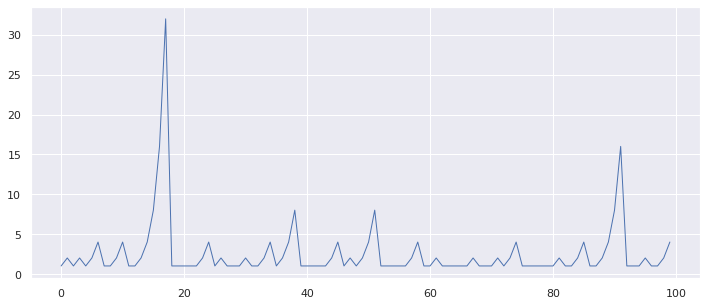

In [ ]:
toss = np.random.randint(0,2,100)

toss = pd.Series(toss)

steps = (toss.cumsum() * toss).diff() # mask out the cumsum where we won [0 1 2 3 0 0 4 5 6 ... ]
edges = steps < 0 # find where the cumsum steps down -> where we won
dsteps = steps[edges].diff() # find the length of each losing streak
dsteps[steps[edges].index[0]] = steps[edges][:1] # fix length of the first run which in now NaN
toss2 = toss.copy() # get a copy of the toss series
toss2[edges] = dsteps # insert the length of the losing streaks into the copy of the toss results
bets = 2 ** (toss2).cumsum() # compute the wagers

res = pd.DataFrame({'toss': toss,
                    'toss2': toss2,
                    'runs': toss2.cumsum(),
                    'next_bet': bets})

print(res)

sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
#plt.plot(res.toss)

# Your bet
plt.plot(res.next_bet)

###### *Adapted (Stochastic) Process*

[Adapted (Stochastic) Process](https://de.m.wikipedia.org/wiki/Adaptierter_stochastischer_Prozess)

* for exmaple in Finance

* The share prices of assets in a multiperiod market depend on market scenarios, but evolve in such a way that their values at any time t, being observable at time t, do not depend on the unobservable post-t futures of the scenarios. 

* Thus, the price process St of a traded asset is **adapted to the natural filtration** (Ft)0≤t≤T defined by (1). 

* In general, a sequence Xt of random variables is said to be **adapted to a filtration** (Ft)0≤t≤T if, for each t, the random variable Xt is **Ft−measurable**, that is, if all events of the form {ω : Xt(ω) ∈ B}, where **B is a Borel** subset of the real numbers R, are members of the σ−algebra Ft.

###### *Stopping Time*

**Stopping Time**

* [Stoppzeit (Markov Moment)](
https://de.m.wikipedia.org/wiki/Stoppzeit): In der Stochastik bezeichnet der Begriff der Stoppzeit eine spezielle Art von Zufallsvariablen, die auf filtrierten Wahrscheinlichkeitsräumen definiert werden.

  * Stoppzeiten sind nicht nur von Bedeutung für die Theorie der stochastischen Prozesse (beispielsweise bei der Lokalisierung von Prozessklassen oder Untersuchungen von gestoppten Prozessen), sondern auch von praktischer Relevanz, etwa für das Problem des optimalen Ausübungszeitpunkts für amerikanische Optionen.

  * Eine Stoppzeit kann man als die Wartezeit interpretieren, die vergeht, bis ein bestimmtes zufälliges Ereignis eintritt. Wenn wie üblich die Filtrierung die vorhandene Information zu verschiedenen Zeitpunkten angibt, bedeutet die obige Bedingung also, dass zu jeder Zeit bekannt sein soll, ob dieses Ereignis bereits eingetreten ist oder nicht.

* Optional Stopping Theorem: Das [Optional Stopping Theorem](https://de.m.wikipedia.org/wiki/Optional_Stopping_Theorem) ist ein mathematischer Satz über Martingale, eine spezielle Klasse von stochastischen Prozessen, und damit der Wahrscheinlichkeitstheorie zuzuordnen.

* [Optional Sampling Theorem](https://de.m.wikipedia.org/wiki/Optional_Sampling_Theorem): Eine populäre Version dieses Theorems besagt, dass es bei einem fairen, sich wiederholenden Spiel keine Abbruchstrategie gibt, mit der man seinen Gesamtgewinn verbessern kann.

* [Starke Markoweigenschaft](https://de.m.wikipedia.org/wiki/Starke_Markoweigenschaft)

* Filtrierung von Stoppzeiten:

  * Eine Stoppzeit $\tau: \Omega \rightarrow[0, \infty]$ bezüglich einer beliebigen Filtrierung $\left(\mathcal{F}_{t}\right)_{t \in[0, \infty)}$ erzeugt in Analogie zur natürlichen Filtrierung eine $\sigma$ -Algebra, die sogenannte $\sigma$ -Algebra der $\tau$ -Vergangenheit

  > $\mathcal{F}_{\tau}:=\left\{A \in \mathcal{F}_{\infty} \mid \forall t \in[0, \infty): A \cap\{\tau \leq t\} \in \mathcal{F}_{t}\right\} \text { mit } \mathcal{F}_{\infty}=\sigma\left(\bigcup_{t \in[0, \infty)} \mathcal{F}_{t}\right)$

  * Sei nun $\left(\tau_{j}\right)_{j \in J}$ eine geordnete Familie von Stoppzeiten mit $P\left(\tau_{i} \leq \tau_{j}\right)=1$ für alle $i, j \in J$ mit $i \leq j$ dann ist die Familie $\left(\mathcal{F}_{\tau_{j}}\right)_{j \in J}$ eine Filtrierung, diese ist beim Studium von Stoppzeiten stochastischer Prozesse von Bedeutung. 

  * In Analogie erzeugt man die rechtsstetige Version der Filtrierung $\left(\mathcal{F}_{\tau_{j}+}\right)_{j \in J}$ wobei:

  > $\mathcal{F}_{r+}:=\left\{A \in \mathcal{F}_{\infty} \mid \forall t \in[0, \infty): A \cap\{\tau \leq t\} \in \mathcal{F}_{t+}\right\} \text { und } \mathcal{F}_{t+}=\bigcap_{u \in(t, \infty)} \mathcal{F}_{u}$

  * Es gilt immer $\mathcal{F}_{\tau} \subseteq \mathcal{F}_{r+}$

* [Vorhersagbarer Prozess](https://de.m.wikipedia.org/wiki/Vorhersagbarer_Prozess)

###### *σ-Algebra der τ-Vergangenheit*

**σ-Algebra der τ-Vergangenheit**

* Die [σ-Algebra der τ-Vergangenheit](https://de.m.wikipedia.org/wiki/Σ-Algebra_der_τ-Vergangenheit) ist ein **Mengensystem**, sowie ein von der Stoppzeit abgeleitetes Konzept

* Die σ-Algebra der τ-Vergangenheit ist eine **spezielle σ-Algebra**, welche über die Filtrierung und die Stoppzeit definiert wird. Sie findet beispielsweise Anwendung bei der Definition der starken Markow-Eigenschaft und dem Optional Sampling Theorem.

* Sie entsteht durch Kombination einer Filtrierung mit einer Stoppzeit und findet meist Anwendung bei Aussagen über gestoppte Prozesse, also stochastische Prozesse, die an einem zufälligen Zeitpunkt angehalten werden. Zu diesen Aussagen gehören beispielsweise das Optional Stopping Theorem, das Optional Sampling Theorem und die Definition der starken Markow-Eigenschaft.

* Gegeben sei ein Wahrscheinlichkeitsraum $(\Omega, \mathcal{A}, P)$ sowie eine Filtrierung $\mathbb{F}=\left(\mathcal{F}_{t}\right)_{t \in T}$ bezüglich der Ober- $\sigma$ -Algebra $\mathcal{A}$ und eine Stoppzeit $\tau$ bezüglich $\mathbb{F}$. Dann heißt

$\mathcal{F}_{\tau}=\left\{A \in \mathcal{A} \mid A \cap\{\tau \leq t\} \in \mathcal{F}_{t} \text { für alle } t \in T\right\}$

die $\sigma$ -Algebra der $\tau$ -Vergangenheit.

## <font color="blue">**Machine Learning**

##### <font color="blue">*Scientific Computing*

* [Linear algebra with Scipy](https://docs.scipy.org/doc/scipy/tutorial/linalg.html)

* [Python Math Module](https://docs.python.org/3/library/math.html) and [List of math methods](https://www.w3schools.com/python/module_math.asp)

* https://patrickwalls.github.io/mathematicalpython/linear-algebra/applications/

* [Python Tutorial 1](https://www.w3schools.com/python/python_functions.asp)

* [Python Tutorial 1](http://www-personal.umich.edu/~mejn/computational-physics/)

In [ ]:
# Simple function for one value

x = 10

def my_function(x):
  return (int(math.sqrt(x + 2)), math.sqrt(x + 2))

my_function(x)

(3, 3.4641016151377544)

In [ ]:
# Simple function for one value including conditional

x = 10

def my_function(x):
  if x < (10):
    return (int(math.sqrt(x + 2)), math.sqrt(x + 2))
  else:
    return x**3

my_function(x)

1000

In [ ]:
# Simple function for iteration through list

x = 10

def my_function(x):
  for i in range(1,x,2): # Start, Stop, Steps
    print(i**2)

my_function(x)

1
9
25
49
81


In [ ]:
# Lambda Function: Add 10 to argument a, and return the result

x = lambda a : a + 10
print(x(5))

# Multiply argument a with argument b and return the result:
x = lambda a, b, c : (a * b) + c
print(x(5, 6, 3))


# function definition that takes one argument, and that argument will be multiplied with an unknown number:
n = 3
a = 12 
def myfunc(n):
  return lambda a : a * n

mytripler = myfunc(n)

print(mytripler(a))

15
33
36


In [ ]:
numbers = [2,4,6]
funcs = []

for n in numbers:
  funcs.append(lambda n=n: print(n**2))

for f in funcs:
  f()

4
16
36


In [ ]:
# Append

example_list = [1,4,9]
cube_list = []

for value in example_list:
    cube_list.append(value**3)

print(cube_list)

[1, 64, 729]


In [ ]:
# Lambda with filter, map, reduce, sorted etc
# https://towardsdatascience.com/lambda-functions-in-python-15b60ff4207d

# Calculate the squares of the elements in a given iterable:
iterable = [1, 3, 5, 6, 9, 11, 15, 16, 21]
list(map(lambda x: x ** 2, iterable))

[1, 9, 25, 36, 81, 121, 225, 256, 441]

In [ ]:
# Compute determinant
from scipy import linalg
A = np.array([[1,2],[3,4]])
linalg.det(A)

-2.0

In [ ]:
from scipy import linalg
A = np.array([[1,2],[3,4]])

print("Frobenius norm is:", linalg.norm(A,'fro'))    # frobenius norm is the default
print("L1 norm is:", linalg.norm(A,1))       # L1 norm (max column sum)
print("L2 norm is:", linalg.norm(A,2))       # L1 norm (max column sum)
print(linalg.norm(A,-1))
print("L-inf norm is:", linalg.norm(A,np.inf))  # L inf norm (max row sum)


Frobenius norm is: 5.477225575051661
L1 norm is: 6.0
L2 norm is: 5.464985704219043
4.0
L-inf norm is: 7.0


In [ ]:
length = 3
width = 5

def rect_area(length, width):
  return length * width

# The Lambda function equivalent for this is:
# lambda length, width: length * width

rect_area(length, width)

15

In [ ]:
# Iterate and append (pending)

example_list = [1,4,9]
cube_list = []

def my_function(value):
  for value in example_list:
    cube_list.append(value**3)

print(cube_list)

[]


In [ ]:
# Print out the wavelengths of hydrogen lines
R = 1.097e-2
for m in range(1,4,2): # Start, Stop, Steps
    print("Series for m =",m)
    for n in range(m+1,m+6):
        invlambda = R*(1/m**2-1/n**2)
        print("  ",1/invlambda,"nm")

Series for m = 1
   121.5436037678517 nm
   102.55241567912488 nm
   97.23488301428137 nm
   94.95594044363415 nm
   93.76220862091418 nm
Series for m = 3
   1875.2441724182836 nm
   1281.9051959890612 nm
   1093.8924339106654 nm
   1005.013673655424 nm
   954.6697605038536 nm


In [ ]:
# Calculate the internal energy of a quantum simple harmonic oscillator at temperature T
from math import exp

terms = 1000
beta = 1/100
S = 0.0
Z = 0.0
for n in range(terms):
    E = n + 0.5
    weight = exp(-beta*E)
    S += weight*E
    Z += weight

print(S/Z)

99.95543134093475


In [ ]:
# Print out the Fibonacci numbers up to 1000
f1,f2 = 1,1
while f2<1000:
    print(f2)
    f1,f2 = f2,f1+f2

1
2
3
5
8
13
21
34
55
89
144
233
377
610
987


In [ ]:
# While Loops

# Compute Modulus (Berechne den Restwert in der Modulurechnung)
modulus = 51 # moduland
modulo = 7
while modulus > modulo:
    modulus = modulus - modulo

# Show Restwert (51-7-7-7-7-7-7-7)
print(modulus)

2


In [ ]:
# Yield and enumerate

# Yield gives you a generator. You'd use it where you would normally use a return in a function.
# yield	generator: ends a function, returns a generator
# When you have a function that returns a sequence and you want to iterate over that sequence, 
# but you do not need to have every value in memory at once.

# Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object

def fibonacci():
    a, b = 0, 1
    while True:
        yield a
        a, b = b, a+b

for i, f in enumerate(fibonacci()):
    print(i, f)
    if i >= 10: break

0 0
1 1
2 1
3 2
4 3
5 5
6 8
7 13
8 21
9 34
10 55


*Python: self, class, init, methods*

https://www.w3schools.com/python/python_classes.asp

In [ ]:
# Create a class with a property x:
class MyClass:
  x = 5

# Create an object p1 using the class MyClass, and print the value of x:
p1 = MyClass()
print(p1.x)

# Create a class named Person, use the __init__() function to assign values for name and age:
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

print(p1.name)
print(p1.age)

5
John
36


In [ ]:
# __str__() function controls what should be returned when the class object is represented as a string
class Person:
  def __init__(my_object, name, age):    # Using "my_object" instead of "self"
    my_object.name = name
    my_object.age = age

  def __str__(my_object):
    return f"{my_object.name}, {my_object.age}"

p1 = Person("John", 36)
print(p1)

John, 36


In [ ]:
# Including object methods:
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

  def myfunc(self):
    print("Hello my name is " + self.name)

p1 = Person("John", 36)
p1.myfunc()

Hello my name is John


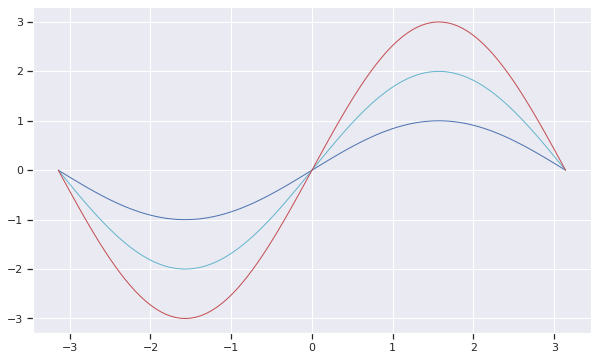

In [ ]:
# Visualization of Functions

sns.set(rc={'figure.figsize':(10, 6), "lines.linewidth": 1.0})

# 100 linearly spaced numbers
x = np.linspace(0,1,100)
x = np.linspace(-np.pi,np.pi,100)

# the function
y = x**20
y = np.sin(x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
#plt.plot(x,y, 'g')
plt.plot(x,y, 'b', label='y=sin(x)')
plt.plot(x,2*y, 'c', label='y=2sin(x)')
plt.plot(x,3*y, 'r', label='y=3sin(x)')

# show the plot
plt.show()

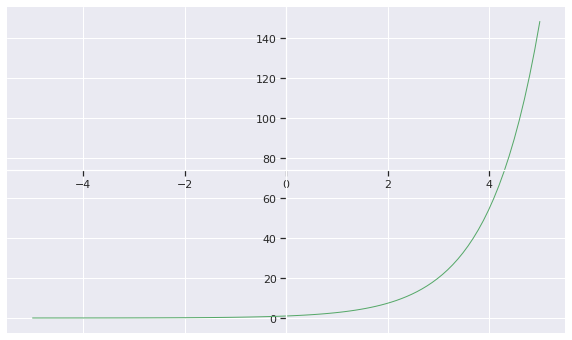

In [ ]:
# 100 linearly spaced numbers
x = np.linspace(-5,5,100)

# the function, which is y = x^3 here
y = x**2
y = np.exp(x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

##### <font color="blue">*Regularization*

*An L2-regularized version of the cost function used in SGD for NN [Source](https://towardsdatascience.com/understanding-the-scaling-of-l%C2%B2-regularization-in-the-context-of-neural-networks-e3d25f8b50db)*

> $J_{\text {regularited }}=\underbrace{-\frac{1}{m} \sum_{i=1}^m\left(y^{(i)} \log \left(a^{[L](i)}\right)+\left(1-y^{(i)}\right) \log \left(1-a^{[L](i)}\right)\right)}_{\text {crossentropy cost }}+\underbrace{\frac{1}{m} \frac{\lambda}{2} \sum_l \sum_l \sum_j W_{i, j}^{[m 2}}_{\text {L. reguatization cos }}$


**Problem Statement**

* Regularization is a technique for preventing a model from overfitting 
* Overfitting = a complicated model that gives worse predictions than a simpler model
* Solution: e.g. preventing over-fitting by penalizing a model for having large weights (A network with large network weights can be a sign of an unstable network where small changes in the input can lead to large changes in the output)
* A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called [weight regularization](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/).

**Trivial Regularization Approaches**

* Add more data
* Simpler model (reduce variance by taking into account fewer variables and parameters, thereby removing some of the noise in the training data)
* Use ensemble models

**Particular Regularization Techniques**
* Weight regularization
* Vectornorm (L1, L2, or Elastic Net): Traditional methods like cross-validation, stepwise regression to handle overfitting and perform feature selection work well with a small set of features but vectornorm regularization is a great alternative when dealing with a large set of features.
* Dropout
* Jitter (add noise)
* Batch size
* Early stopping (this is not a formal regularization method, but can effectively limit overfitting). 

**Overfitting: Consider Variance-Bias-Tradeoff**: [Regularization and Geometry](https://towardsdatascience.com/regularization-and-geometry-c69a2365de19) & [The Bias-Variance Tradeoff](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9)

**Benefits of regularization from a mathematical optimization point of view**

* Minimize a cost function. Neural networks are non-convex cost functions. Numerical optimization methods (gradient descent) can easily get stuck in local minima (stationary points)

* Regularization can be used as a way of ‚convexifying‘ a non-convex cost function. 

* The L2 regularizer, being an upward-facing convex function, can unflatten flat regions and curve up some stationary points without severely changing the minimum locations (e.g L2 regularized cost no longer has an issue with saddle points, as the region surrounding it has been curved upwards).

* Regularization can also help with the optimization of convex machine learning problems, when is not invertible. For example the solution to the L2 regularized version of linear regression is given by is the regularization parameter, which can be set large enough so that becomes invertible.

**Theoretical Foundation** 

Modify cost function J by adding 'preference' to certain parameter values:

$J(\underline{\theta})=\frac{1}{2}\left(\underline{y}-\underline{\theta} \underline{X}^{T}\right) \cdot\left(\underline{y}-\underline{\theta} \underline{X}^{T}\right)^{T}+\alpha \theta \theta^{T}$

New solution (derive the same way) - problem is now well-posed for any degree:

$\underline{\theta}=\underline{y} \underline{X}\left(\underline{X}^{T} \underline{X}+\alpha I\right)^{-1}$

* Shrinks parameters towards zero
* Alpha large: we prefer small theta to small MSE
* Regularization term is independent of the data: paying more attention reduces variance.

**L1 (Lasso) Vectornorm Penalty Term to Cost Function**

$\sum_{i=1}^{n}\left(Y_{i}-\sum_{j=1}^{p} X_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$

* Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
* If lambda is zero then we will get back OLS whereas very large value will make coefficients zero hence it will under-fit. 
* Learn more on [Google Course](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/lambda): Regularization for Simplicity: Lambda

<p>
$\sum_{i=1}^{n}\left|u_{i}\right|=\sum_{i=1}^{n}\left|y_{i}-b_{0}-b_{1} x_{i}\right|$
</p><br>


$d_{1} \equiv d_{\mathrm{SAD}}:(x, y) \mapsto\|x-y\|_{1}=\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|$

* **Synonyms**: Lasso, Manhatten distance, least absolute deviations (LAD method), least absolute errors (LAE)
* **Fun Fact**: L1 Regularization is analytical equivalent to Laplacean prior
* **Summary**: Sum of the absolute weights. Gives sparse solutions, since it does not take all features. Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.
* **Advantages**: less influenced by outliers (robust). Can shrink some coefficients to zero while lambda increases, performing variable selection. generates sparse feature vectors (Sparse: only very few entries in a matrix or vector is non-zero. L1-norm has property of producing many coefficients with zero values or very small values with few large coefficients). Sparse is sometimes good eg. in high dimensional classification problems. sparsity properties: calculation more computationally efficient.
* **Disadvantages**: L1 regularization doesn’t easily work with all forms of training. gives a solution with more large residuals, and a lot of zeros in the solution.
* **Use Cases**: 
  * if only a subset of features are correlated with the label, as in lasso model some coefficient can be shrunken to zero. 
  * very useful when you want to understand exactly which features are contributing to a decision. 
  * if you can ignore the ouliers in your dataset or you need them to be there. 
  * use L1 when constraints on feature extraction: easily avoid computing a lot of computationally expensive features  at the cost of some of the accuracy, since the L1-norm will give us a solution which has the weights for a large set of features set to zero (real-time detection or tracking of an object/face/material using a set of diverse handcrafted features with a large margin classifier like an SVM in a sliding window fashion - you'd probably want feature computation to be as fast as possible in this case).
* **Bayesian**: L1 usually corresponds to setting a Laplacean prior: Some of the coefficients will shrink to zero: similar effect would be achieved in Bayesian linear regression using a Laplacian prior (strongly peaked at zero) on each of the beta coefficients.



**L2 (Ridge) Vectornorm Penalty Term to Cost Function**

$\sum_{i=1}^{n}\left(y_{i}-\sum_{j=1}^{p} x_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}$

* Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.
* If lambda is zero then you can imagine we get back OLS. However, if lambda is very large then it will add too much weight and it will lead to under-fitting. Having said that it’s important how lambda is chosen.

<p>
$\sum_{i=1}^{n} u_{i}^{2}=\sum_{i=1}^{n}\left(y_{i}-b_{0}-b_{1} x_{i}\right)^{2}$
</p><br>

* **Synonyms**: Weight Decay, Ridge Regression, KQ-Methode, kleinste Quadrate, [Tikhonov regularization](https://en.m.wikipedia.org/wiki/Tikhonov_regularization), Euclidean distance, least squares error (LSE)
* **Fun Fact**: L2 Regularization is analytically equivalent to Gaussian prior
* **Summary**: Sum of the squared weights. Is the most common type of regularization, also called simply “weight decay,” with values often on a logarithmic scale between 0 and 0.1, such as 0.1, 0.001, 0.0001, etc.
* **Advantages**: Shrinks all the coefficient by the same proportions, but eliminates none. Leads to small distributed weights in neural networks. The L2 regularization heavily penalizes "peaky" weight vectors and prefers diffuse weight vectors. Empirically performs better than L1. The fit for L2 will be more precise than L1. Works with all forms of training. Smoother: fewer large residual values along with fewer very small residuals as well. L2-norm has analytical solution - allows the L2-norm solutions to be calculated computationally efficiently.
* **Disadvantages**: Sensitive to outliers, since L2 wants all errors to be tiny and heavily penalizes anyone who doesn't obey. Computation heavy compared to the L1 norm. Doesn’t give you implicit feature selection.
* **Use Cases**: Use ridge if all the features are correlated with the label, as the coefficients are never zero in ridge. 
* **Bayesian**: L2 similarly corresponds to Gaussian prior. As one moves away from zero, the probability for such a coefficient grows progressively smaller. The square loss penalty can be seen as putting a Gaussian prior on your weights.


**Special: Analytical Equivalence**

* Why is L2 Regularization is analytically equivalent to Gaussian prior?

* https://stats.stackexchange.com/questions/163388/why-is-the-l2-regularization-equivalent-to-gaussian-prior/163450#163450


* Method that linearly combines the L1 and L2 penalties of the lasso and ridge methods, at the "only" cost of introducing another hyperparameter to tune (see Hastie's paper on stanford.edu).
* Overcome limitations of L1: in the "large p, small n" case (high-dimensional data with few examples), the LASSO selects at most n variables before it saturates. Also if there is a group of highly correlated variables, then the LASSO tends to select one variable from a group and ignore the others.
* Solution in elastic net: add quadratic part to penalty (L2). quadratic penalty term makes the loss function strictly convex, and it therefore has a unique minimum.
* Naive version of elastic net method finds an estimator in a two-stage procedure : first for each fixed λ2 it finds the ridge regression coefficients, and then does a LASSO type shrinkage. This kind of estimation incurs a double amount of shrinkage, which leads to increased bias and poor predictions. To improve the prediction performance, the authors rescale the coefficients of the naive version of elastic net by multiplying the estimated coefficients by (1+λ2).

**Dropout**

* Ziel: Overfitting vermeiden
* Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
* Dropout roughly doubles the number of iterations required to converge. However, training time for each epoch is less. With H hidden units, each of which can be dropped, we have 2^H possible models. In testing phase, the entire network is considered and each activation is reduced by a factor p.
At test time the whole network is used (all units) but with scaled down weights. Mathematically this approximates ensemble averaging (using the geometric mean as average). Two papers that explain this much better are:
* Hinton et al, [1207.0580] Improving neural networks by preventing co-adaptation of feature detectors, 2012 (probably the original paper on dropout)
* Warde-Farley et al, [1312.6197] An empirical analysis of dropout in piecewise linear networks, 2014 (analyzes dropout specially for the case of using ReLU as activation function -arguably the most popular- , and checks the behavior of the geometric mean for ensemble averaging).
* Andrew Ng: dropout is nothing more than an adaptive form of L2 regularization and that both methods have similar effects
* The dropout will randomly mute some neurons in the neural network and we therefore have a sparse network which hugely decreases the possibility of overfitting. More importantly, the dropout will make the weights spread over the input features instead of focusing on some features. https://hackernoon.com/is-the-braess-paradox-related-to-dropout-in-neural-nets-270ecb97cdeb https://de.m.wikipedia.org/wiki/Dropout_(künstliches_neuronales_Netz)\

**Is dropout outdated?**

Neural Network:  Dropout

https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b

Don’t Use Dropout in Convolutional Networks
https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16

Instead you should insert batch normalization between your convolutions. This will regularize your model, as well as make your model more stable during training.

First, dropout is generally less effective at regularizing convolutional layers: The reason? Since convolutional layers have few parameters, they need less regularization to begin with. Furthermore, because of the spatial relationships encoded in feature maps, activations can become highly correlated. This renders dropout ineffective. ([Source](https://www.reddit.com/r/MachineLearning/comments/5l3f1c/d_what_happened_to_dropout/))

Second, what dropout is good at regularizing is becoming outdated: Large models like VGG16 included fully connected layers at the end of the network. For models like this, overfitting was combatted by including dropout between fully connected layers. Unfortunately, [recent architectures](https://arxiv.org/pdf/1512.03385.pdf) move away from this fully-connected block. By replacing dense layers with global average pooling, modern convnets have reduced model size while improving performance.

**Use Dropout along with L1/L2 Regularization?**

* You can, but it is still not clear whether using both at the same time acts synergistically or rather makes things more complicated for no net gain.
* While ℓ 2 regularization is implemented with a clearly-defined penalty term, dropout requires a random process of “switching off” some units, which cannot be coherently expressed as a penalty term and therefore cannot be analyzed other than experimentally.
* they both try to avoid the network’s over-reliance on spurious correlations, which are one of the consequences of overtraining that wreaks havoc with generalization. But more detailed research is necessary to determine whether and when they can “work together” or rather end up “fighting each other”. So far, it seems the results tend to vary in a case-by-case fashion. Using both can increase accuracy: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf (Hinton paper 2014)

**Jitter (Noise)**

* adding annealed Gaussian noise by decaying the variance works better than using fixed Gaussian noise

**Batch Normalization & Size**

* https://towardsdatascience.com/understanding-batch-normalization-for-neural-networks-1cd269786fa6

* Small batches can oﬀer a regularizing eﬀect (Wilson and Martinez, 2003), perhaps due to the noise they add to the learning process.

* Using a smaller batch size is like using some regularization to avoid converging to sharp minimizers. The gradients calculated with a small batch size are much more noisy than gradients calculated with large batch size, so it's easier for the model to escape from sharp minimizers, and thus leads to a better generalization. Generalization error is often best for a batch size of 1. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.)

**Batch Normalization**

* Batch normalization is another method to regularize a (convolutional) network.
* On top of a regularizing effect, batch normalization also gives your convolutional network a resistance to vanishing gradient during training. This can decrease training time and result in better performance.
* Batch Normalization Combats Vanishing Gradient
* Batch normalization replaces dropout.
* Even if you don’t need to worry about overfitting there are many benefits to implementing batch normalization. Because of this, and its regularizing effect, batch normalization has largely replaced dropout in modern convolutional architectures.
* “We presented an algorithm for constructing, training, and performing inference with batch-normalized networks. The resulting networks can be trained with saturating nonlinearities, are more tolerant to increased training rates, and often do not require Dropout for regularization.” -[Ioffe and Svegedy 2015](https://arxiv.org/pdf/1502.03167.pdf)

**Batch Size**

Why use batches?
To avoid that small datasets increase overfitting to this datasets and worsen overall accuracy. But batch size shouldnt be too big either (computation time, speed of convergence of an algorithm)

* Research 1: a low batch size means a very noisy gradient (because computed on a very small subset of the dataset), and a high learning rate means noisy steps.
https://towardsdatascience.com/recent-advances-for-a-better-understanding-of-deep-learning-part-i-5ce34d1cc914

* Research 2: How do you choose your batch size in deep learning/SGD? - An interesting concept so-called "generalization gap": Train longer, generalize better: closing the generalization gap in large batch training of neural networks:
https://arxiv.org/abs/1705.08741

**Covariate Shift**

pending...



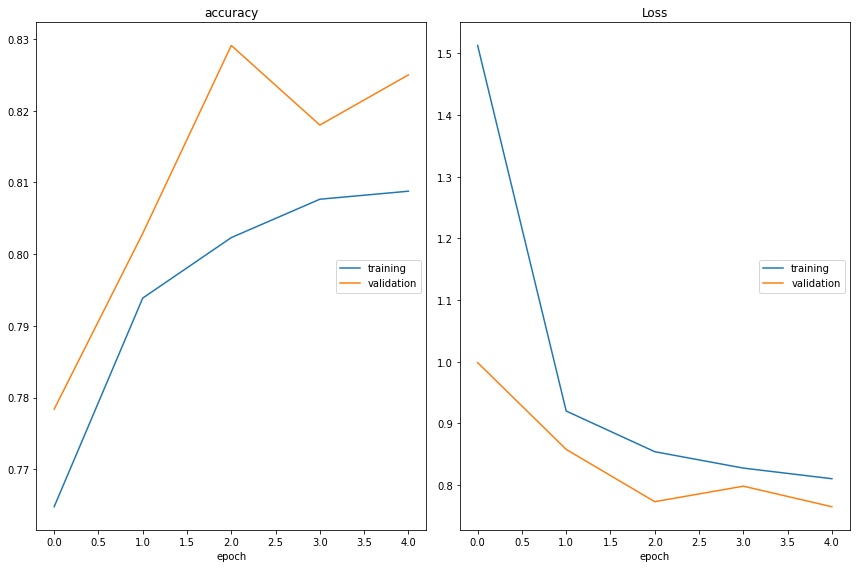

accuracy
	training         	 (min:    0.765, max:    0.809, cur:    0.809)
	validation       	 (min:    0.778, max:    0.829, cur:    0.825)
Loss
	training         	 (min:    0.810, max:    1.513, cur:    0.810)
	validation       	 (min:    0.765, max:    0.999, cur:    0.765)
1875/1875 [==============================] - 14s 8ms/step - loss: 0.8104 - accuracy: 0.8088 - val_loss: 0.7649 - val_accuracy: 0.8250


In [ ]:
# Define regulation methods
lasso = tf.keras.regularizers.l1(l=0.0005)
ridge = tf.keras.regularizers.l2(l=0.0005)
elasticnet = tf.keras.regularizers.L1L2(l1=0.0, l2=0.0)
dropout = 0.3

# Kernel Regularizer - Regularizer function applied to the kernel weights matrix.
kernel_regularizer = lasso

# Bias Regularizer - Regularizer function applied to the bias vector
bias_regularizer = ridge

# Activity Regularizer - Regularizer function applied to the output of the layer (its "activation")
activity_regularizer = None

!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF
import tensorflow as tf

# Load & Prepare Model
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu', 
                                kernel_regularizer=kernel_regularizer, 
                                bias_regularizer=bias_regularizer, 
                                activity_regularizer=activity_regularizer))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile Model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKerasTF()],
          verbose=1)

##### <font color="blue">*Optimizer*

**Optimizer**


* https://algorithmia.com/blog/introduction-to-optimizers

* https://juntang-zhuang.github.io/adabelief/

* https://medium.com/explorations-in-language-and-learning/a-short-note-on-gradient-descent-optimization-algorithms-335546c5a896

* An overview of gradient descent optimization algorithms: https://arxiv.org/pdf/1609.04747.pdf

**Which Optimizer to use?**

* Wich optimizer should you now use? If your input data is sparse, then you likely achieve the best results using one of the adaptive learning-rate methods. An additional benefit is that you won't need to tune the learning rate but likely achieve the best results with the default value.
* In summary, RMSprop is an extension of Adagrad that deals with its radically diminishing learning rates. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Interestingly, many recent papers use vanilla SGD without momentum and a simple learning rate annealing schedule. As has been shown, SGD usually achieves to find a minimum, but it might take significantly longer than with some of the optimizers, is much more reliant on a robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence and train a deep or complex neural network, you should choose one of the adaptive learning rate methods.

**Comparison**

* Few days ago, an interesting paper titled The Marginal Value of Adaptive Gradient Methods in Machine Learning (https://arxiv.org/abs/1705.08292) from UC Berkeley came out. In this paper, the authors compare adaptive optimizer (Adam, RMSprop and AdaGrad) with SGD, observing that SGD has better generalization than adaptive optimizers.
* “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”
* I was astounded by their finding since I never used SGD before and consider it as an outdated optimizer with slower convergence than Adam or RMSprop. Am I totally wrong from the very beginning?

https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0


**Learning Rate** 

* https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

* being used in optimizers / cost function
* Learning rate is an important component of backpropagation in a neural network:
* New Value of weight a = Old value a - (learning rate * gradient ∂SSE/∂a) θ=θ−η⋅∇θJ(θ)

**Ian Goodfellow answering to "Why do not use the whole training set to compute the gradient?" on Quora**

* The size of the learning rate is limited mostly by factors like how curved the cost function is. You can think of gradient descent as making a linear approximation to the cost function, then moving downhill along that approximate cost. 
* If the cost function is highly non-linear (highly curved) then the approximation will not be very good for very far, so only small step sizes are safe. You can read more about this in Chapter 4 of the deep learning textbook, on numerical computation: http://www.deeplearningbook.org/contents/numerical.html
* When you put m examples in a minibatch, you need to do O(m) computation and use O(m) memory, but you reduce the amount of uncertainty in the gradient by a factor of only O(sqrt(m)). In other words, there are diminishing marginal returns to putting more examples in the minibatch. You can read more about this in Chapter 8 of the deep learning textbook, on optimization algorithms for deep learning: http://www.deeplearningbook.org/contents/optimization.html
* Also, if you think about it, even using the entire training set doesn’t really give you the true gradient. The true gradient would be the expected gradient with the expectation taken over all possible examples, weighted by the data generating distribution. Using the entire training set is just using a very large minibatch size, where the size of your minibatch is limited by the amount you spend on data collection, rather than the amount you spend on computation.

**Reasons for using a Learning Rate**

* Prevent overreaction which can cause loss increase
* Neural networks are often trained by gradient descent on the weights. This means at each iteration we use backpropagation to calculate the derivative of the loss function with respect to each weight and subtract it from that weight. 
* However, if you actually try that, the weights will change far too much each iteration, which will make them “overcorrect” and the loss will actually increase/diverge. So in practice, people usually multiply each derivative by a small value called the “learning rate” before they subtract it from its corresponding weight.
* You can also think of a neural networks loss function as a surface, where each direction you can move in, represents the value of a weight. Gradient descent is like taking leaps in the current direction of the slope, and the learning rate is like the length of the leap you take.
* Learning rate decay os alternative to momentum: when replacing gradient descent with SDG, we take smaller, noisier steps towards objective (minimum).
* How small should steps be? Much research! Always: beneficial to make steps smaller and smaller; i.e. apply exponential decay to learning rate, others make smaller every time loss reaches a plateau

**Challenges**

* Which learning rate: If low, training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny. If learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.
* A learning rate that is too small leads to painfully slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.
* Which Cost function: with SSE cost function the value of θF(Wj)/θWj gets larger and larger as we increase the size of the training dataset
* Change learning rate during process? Upwards or downwards?
* Learning rate schedules [11] try to adjust the learning rate during training by e.g. annealing, i.e. reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be defined in advance and are thus unable to adapt to a dataset's characteristics [10].
* Additionally, the same learning rate applies to all parameter updates. If our data is sparse and our features have very different frequencies, we might not want to update all of them to the same extent, but perform a larger update for rarely occurring features.
* As full-scale hyperparameter optimization: Selecting a learning rate is a "meta-problem" (hyperparameter optimization). The best learning rate depends on the problem at hand, as well as on the architecture of the model being optimized, and even on the state of the model in the current optimization process! There are even software packages devoted to hyperparameter optimization such as spearmint and hyperopt (just a couple of examples, there are many others!)

**Cosine Annealing**

**Adapting learning rate in each iteration downwards (Annealing)**

Optimize is the learning rate during training. conventional: decrease over time. There are Multiple ways: step-wise learning rate annealing when the loss stops improving, exponential learning rate decay, cosine annealing, etc. [Source](
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

**Notes on adaptive**
* Adapt the value of λ in each iteration. The farther you are from optimal values the faster you should move towards the solution and value of λ should be larger. (The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal. Then decrease learning rate to allow more fine-grained weight updates.
* Check value of error function at the end of each iteration. If error rate reduced since last iteration, increase learning rate by 5%. If error rate increased (=skipped optimal point) reset values of Wj to values of previous iteration and decrease learning rate by 50%. This is called [Bold Driver](http://www.willamette.edu/~gorr/classes/cs449/momrate.html).
* One technique that's quite common for selecting learning rates: [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing): start with a large learning rate (0.1 or so) and gradually reduce learning rate as optimization progresses, often by an order of magnitude (0.01, then 0.001, 0.0001, etc.).
* Combine with [early stopping](https://en.wikipedia.org/wiki/Early_stopping) to optimize the model with one learning rate as long as progress is being made, then switch to a smaller learning rate once progress appears to slow. The larger learning rates appear to help the model locate regions of general, large-scale optima, while smaller rates help the model focus on one particular local optimum. If the loss does not decrease for several epochs, the learning rate might be too low. The optimization process might also be stuck in a local minimum.
* Weight update tracking: Andrej Karpathy proposed to track weight updates to check if the learning rate is well-chosen. If weight update is too high, then learning rate has to be decreased. If weight update is too low, then learning rate has to be increased.

**Approach 1: Drop-based learning rate schedule**
* Often this method is implemented by dropping the learning rate by half every fixed number of epochs.
* For example, we may have an initial learning rate of 0.1 and drop it by 0.5 every 10 epochs. The first 10 epochs of training would use a value of 0.1, in the next 10 epochs a learning rate of 0.05 would be used, and so on

**Approach 2: Time-based learning rate schedule**
* The learning rate for stochastic gradient descent has been set to a higher value of 0.1. 
* The model is trained for 50 epochs and the decay argument has been set to 0.002, calculated as 0.1/50. 
* Additionally, it can be a good idea to use momentum when using an adaptive learning rate. In this case we use a momentum value of 0.8.
* Increase the initial learning rate. Because the learning rate will very likely decrease, start with a larger value to decrease from. A larger learning rate will result in a lot larger changes to the weights, at least in the beginning, allowing you to benefit from the fine tuning later.
* Use a large momentum. Using a larger momentum value will help the optimization algorithm to continue to make updates in the right direction when your learning rate shrinks to small values.
* Experiment with different schedules. It will not be clear which learning rate schedule to use so try a few with different configuration options and see what works best on your problem. Also try schedules that change exponentially and even schedules that respond to the accuracy of your model on the training or test datasets

**Approach 3: Adapting learning rate in each iteration upwards**
* Leslie N. Smith describes a powerful technique to select a range of learning rates for a neural network in section 3.3 of the 2015 paper ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186) . 
* The trick is to train a network starting from a low learning rate and increase the learning rate exponentially for every batch

**Batch Size Incrase vs Learning Rate Decay**

*Don't Decay the Learning Rate, Increase the Batch Size*

* Paper: https://arxiv.org/abs/1711.00489
* It is common practice to decay the learning rate. Here we show one can usually obtain the same learning curve on both training and test sets by instead increasing the batch size during training. This procedure is successful for stochastic gradient descent (SGD), SGD with momentum, Nesterov momentum, and Adam. 
* It reaches equivalent test accuracies after the same number of training epochs, but with fewer parameter updates, leading to greater parallelism and shorter training times. We can further reduce the number of parameter updates by increasing the learning rate ϵ and scaling the batch size B∝ϵ. 
* Finally, one can increase the momentum coefficient m and scale B∝1/(1−m), although this tends to slightly reduce the test accuracy. Crucially, our techniques allow us to repurpose existing training schedules for large batch training with no hyper-parameter tuning. We train ResNet-50 on ImageNet to 76.1% validation accuracy in under 30 minutes.


In [ ]:
learning_rate = 0.001

**Momentum**
* [Why Momentum Really Works](https://distill.pub/2017/momentum/)

In [ ]:
momentum = 0.9 # for RMSProp 0.0 / for SGD 0.9

**Stochastic Gradient Descent**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) documentation & Nesterov algorithm based on [this paper](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)
* SGD is a stochastic approximation of the gradient descent optimization and iterative method for minimizing an objective function that is written as a sum of differentiable functions. All other optimizers are called „adaptive“, because they have momentum.
* A compromise between computing the true gradient and the gradient at a single example is to compute the gradient against more than one training example (called a "mini-batch") at each step. This can perform significantly better than "true" stochastic gradient descent described, because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.
* The convergence of stochastic gradient descent has been analyzed using the theories of convex minimization and of stochastic approximation. Briefly, when the learning rates decrease with an appropriate rate, and subject to relatively mild assumptions, stochastic gradient descent converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.[3][4] This is in fact a consequence of the Robbins-Siegmund theorem.
* SGD suffers from 2 problems: (i) being hesitant at steep slopes, and (ii) having same learning rate for all parameters.
* $\theta=\theta-\eta \cdot \nabla_{\theta} J\left(\theta ; x^{(i)} ; y^{(i)}\right)$
* Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$
* Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 
* SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily.

**SGD with Momentum**
* The update vector consists of another term which has the previous update vector (weighted by γ). This helps it to move faster downhill — like a ball.
* The momentum term γ is usually set to 0.9 or a similar value.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J(\theta) \\
\theta &=\theta-v_{t}
\end{aligned}$
Source: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf)

**SGD with NAG (Nesterov Accelerated Gradient)**
* In Momentum optimizer, the ball may go past the minima due to too much momentum, so we want to have a look-ahead term. 
* In NAG, we take gradient of future position instead of current position.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J\left(\theta-\gamma v_{t-1}\right) \\
\theta &=\theta-v_{t}
\end{aligned}$

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, 
                                    momentum=momentum, 
                                    nesterov=False)

**Adam Optimizer**

* "Adaptive Moment Estimation"
* Algorithm based on [this paper](https://arxiv.org/abs/1412.6980) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) documentation
* The theory is that Adam already handles learning rate optimization ([Check paper](http://arxiv.org/pdf/1412.6980v8.pdf)) : "We propose Adam, a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; the name Adam is derived from adaptive moment estimation."
* Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The method is computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.
* Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

* $\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}+\epsilon}} \hat{m}_{t}$

* Adam combines RMSProp with Momentum. So, in addition to using the decaying average of past squared gradients for parameter-specific learning rate, it uses a decaying average of past gradients in place of the current gradient (similar to Momentum).
* The ^ terms are actually bias-corrected averages to ensure that the values are not biased towards 0.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False)

**Nadam Optimizer**

* "Nesterov Adaptive Moment Estimation"
* Algorithm based on [this paper](http://cs229.stanford.edu/proj2015/054_report.pdf) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) documentation
* Nadam is Adam with Nesterov momentum

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-07)

**RMSprop Optimizer**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) documentation
* RMSprop is an unpublished optimization algorithm designed for neural networks, first proposed by Geoff Hinton in lecture 6 of the online course “Neural Networks for Machine Learning”
* RMSPro: works well in non-stationary settings. RMSProp with momentum is the method most closely related to Adam. Main differences: RMSProp rescales gradient and then applies momentum, Adam first applies momentum (moving average) and then rescales. RMSProp lacks bias correction, often leading to large stepsizes in early stages of run (especially when β2 is close to 1)
* maintain a moving (discounted) average of the square of gradients
divide gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.
* The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance
* $E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2}$
* In Adagrad, since we keep adding all gradients, gradients become vanishingly small after some time. So in RMSProp, the idea is to add them in a decaying fashion as shown in the formula. 
* Now replace G_t in the denominator of Adagrad equation by this new term. Due to this, the gradients are no more vanishing.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, 
                                        rho=0.9, 
                                        momentum=momentum, 
                                        epsilon=1e-07, 
                                        centered=False)

**FTRL Optimizer**

* "Follow The (Proximally) Regularized Leader"
* Algorithm based on [this paper](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf) and [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) documentation

In [ ]:
optimizer = tf.keras.optimizers.Ftrl(learning_rate=learning_rate, 
                                     learning_rate_power=-0.5, 
                                     initial_accumulator_value=0.1, 
                                     l1_regularization_strength=0.0, 
                                     l2_regularization_strength=0.0, 
                                     name='Ftrl', 
                                     l2_shrinkage_regularization_strength=0.0)

**Adadelta Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, 
                                        rho=0.9, 
                                        epsilon=1e-07)

**Adagrad Optimizer**

* Instead of a common learning rate for all parameters, we want to have separate learning rate for each. So Adagrad keeps sum of squares of parameter-wise gradients and modifies individual learning rates using this. As a result, parameters occuring more often have smaller gradients.
* works well with sparse gradients

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, 
                                        initial_accumulator_value=0.1,
                                        epsilon=1e-07)

**Adamax Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07)

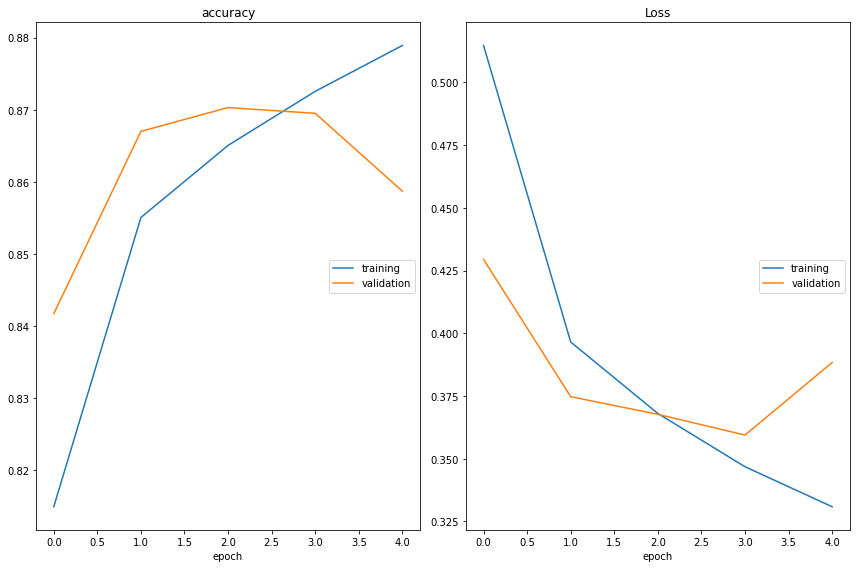

accuracy
	training         	 (min:    0.815, max:    0.879, cur:    0.879)
	validation       	 (min:    0.842, max:    0.870, cur:    0.859)
Loss
	training         	 (min:    0.331, max:    0.515, cur:    0.331)
	validation       	 (min:    0.359, max:    0.429, cur:    0.388)
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3309 - accuracy: 0.8789 - val_loss: 0.3884 - val_accuracy: 0.8587


In [ ]:
# Load & Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile Model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKerasTF()],
          verbose=1)

##### <font color="blue">*Activation Function*

**Activation Functions**

* The activation function is the non-linear function that we apply over the output data coming out of a particular layer of neurons before it propagates as the input to the next layer.
* Activation functions reside within neurons and transform input values into acceptable and useful range. They can introduce non-linearity to a network.
* There are various kinds of activation functions and it has been found, empirically, that some of them works better for large datasets or particular problems than the others. 
* Neural networks extract hidden pattern from a dataset by observing given examples of known answers. Evidently, it does so by comparing its predictions to the ground truth (labeled images for example) and turning the parameters of the model. The difference between the prediction and the ground truth is called the ‘classification error’.
* Parameters of a DL model consists of a set of weights connecting neurons across layers and bias terms which add to those layers. So, the ultimate goal is to set those weights to specific values which reduces the overall classification error. This is a minimization operation, and consequently, an optimization technique is needed.
* The overall representation structure of a deep learning model is a highly complex nonlinear function and therefore, the optimizer is responsible for minimizing the error produced by the evaluation of this complex function. Therefore, standard optimization like linear programming does not work for DL models and innovative nonlinear optimization must be used.
* These two components – **activation functions** and **nonlinear optimizers** – are at the core of every deep learning architecture. However, there is considerable variety in the specifics of these components.
* https://towardsdatascience.com/activation-functions-in-deep-learning-from-softmax-to-sparsemax-math-proof-50c1eb293456

**Necessary Characteristics of Activation Function**

Activation functions must be:

1. Non-constant (obvious)
2. Bounded
3. Monotonically increasing
4. Continuous

These are the conditions under which the universal approximation theorem holds. The universal approximation theorem proves that, under the above conditions, any continuous function of N-variables defined on a compact subset of R^N can be approximated by a three- layer (input, hidden layer, output) neural network with that activation function.

The universal approximation theorem is certainly one of the most rigorous tenets of neural networks.

Of course, if the prediction problem at hand does not deal with continuous variables or cannot be approximated by a problem that does, then the above is no longer valid and the choice of activation functions becomes more of a customized problem.

*Selection Criteria*

Activation layers are a type of hyperparameter, and you’ll need to experiment with all of them in order to find which works best for you. You can narrow your search by referring to prior work in the field for your particular problem. For example, it has already been shown that tanh activations work better for image classification while leaky ReLUs work better for temporal sequences such as video.

Sources: [Stanford.edu](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning) & [Deep Dive into Math Behind Deep Networks](https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba)

**Sigmoid Family**

Im Allgemeinen ist eine Sigmoidfunktion eine beschränkte und differenzierbare reelle Funktion mit einer durchweg positiven oder durchweg negativen ersten Ableitung und genau einem Wendepunkt.

Außer der logistischen Funktion enthält die Menge der Sigmoidfunktionen den Arkustangens, den Tangens hyperbolicus und die Fehlerfunktion, die sämtlich transzendent sind, aber auch einfache algebraische Funktionen. 

Das Integral jeder stetigen, positiven Funktion mit einem „Berg“ (genauer: mit genau einem lokalen Maximum und keinem lokalen Minimum, z. B. die gaußsche Glockenkurve) ist ebenfalls eine Sigmoidfunktion. Daher sind viele kumulierte Verteilungsfunktionen sigmoidal.

**Rectifier Functions Family**

* https://en.m.wikipedia.org/wiki/Rectifier_(neural_networks)

**Advantages**
* Biological plausibility: One-sided, compared to the antisymmetry of tanh.
* Sparse activation: For example, in a randomly initialized network, only about 50% of hidden units are activated (having a non-zero output).
* Better gradient propagation: Fewer vanishing gradient problems compared to sigmoidal activation functions that saturate in both directions.
* Efficient computation: Only comparison, addition and multiplication.
* Scale-invariant: 


**Disadvantages**
* Non-differentiable at zero; however, it is differentiable anywhere else, and the value of the derivative at zero can be arbitrarily chosen to be 0 or 1.
* Not zero-centered.
* Unbounded.
* Dying ReLU problem: ReLU neurons can sometimes be pushed into states in which they become inactive for essentially all inputs. In this state, no gradients flow backward through the neuron, and so the neuron becomes stuck in a perpetually inactive state and "dies". This is a form of the vanishing gradient problem. In some cases, large numbers of neurons in a network can become stuck in dead states, effectively decreasing the model capacity. This problem typically arises when the learning rate is set too high. It may be mitigated by using leaky ReLUs instead, which assign a small positive slope for x < 0


**Linear**

In [ ]:
activation = 'linear'

**Sigmoid (Logistic Regression)**

* $g(z)=\frac{1}{1+e^{-z}}$

<br> 
*Characteristics*
* Logistic regression. Takes a real-valued number as an input and compresses all its outputs to the range of [0,1]. Sigmoid only for binary classification output layer.
* Sigmoid activation derived from mean field solution of Boltzmann machine
* Softmax function is a more generalized logistic activation function which is used for multiclass classification.

*Advantages*
* In the logistic function, a small change in the input only causes a small change in the output as opposed to the stepped output. Hence, the output is smoother than the step function output.
* Historically popular since they have nice interpretation as a saturating “firing rate” of a neuron.
* The function is differentiable.That means, we can find the slope of the sigmoid curve at any two points.
* Especially used for models where we have to predict the probability as an output (of a binary problem).
* Sigmoid works well for a classifier: approximating a classifier function as combinations of sigmoid is easier than maybe ReLu, for example. Which will lead to faster training process and convergence

*Disadvantages*
* exp() is a bit compute expensive. Learning time longer. Also other functions have been shown to produce the same performance with less iterations. Additionally: small local gradients can mute the gradient and disallow the forward propagation of a useful signal.
* The sigmoid function is monotonic but function’s derivative is not: the tails of the first derivative of a Sigmoid are near zero (covariate shift), which lead to vanishing or exploding gradient. Incorrect weight initialization can lead to saturation, where most neurons of the network then become saturated and almost no learning will take place. Saturated neurons “kill” the gradients (look at x= -10, 0 and 10). Can cause the neural network to get stuck during training. If a strongly-negative input is provided to the logistic sigmoid, it outputs values very near zero. Since neural networks usethe feed-forward activations to calculate parameter gradients, this can result in model parameters that are updated less regularly than we would like, and are thus “stuck” in their current state (this problem can be solved if we normalize the data in advance to be zero-centered as in batch/layer normalization).
* Sigmoid outputs are not zero-centered. Neurons in later layers of processing in a neural net would be receiving data that is not zero-centered. If data coming into is always positive, the gradient on the weights 𝑤 will during backpropagation become either all be positive, or all negative. This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights. (However, notice that once these gradients are added up across a batch of data the final update for the weights can have variable signs, somewhat mitigating this issue. Therefore, this is an inconvenience but it has less severe consequences compared to the saturated activation problem.)


In [ ]:
activation = tf.keras.activations.sigmoid

activation = 'sigmoid'

**tanh (hyperbolic tangent)**

* $g(z)=\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$
* LeCun et al., 1991
* The tanh function "squashes" values to the range -1 and 1. Output values are, therefore, centered around zero. Can be thought of as a scaled, or shifted, sigmoid, and is almost always preferable to the sigmoid function
* Squashes numbers to range [-1,1]
* zero centered (nice)
* The advantage is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph.
* The function is differentiable.
* The function is monotonic while its derivative is not monotonic.
* The tanh function is mainly used classification between two classes.
* still kills gradients when saturated

In [ ]:
activation = tf.keras.activations.tanh

activation = 'tanh'

**Softmax**
* is an activation function that is not function of a single fold x from the previous layer or layers.
* usually used in the last layer
* Softmax Regression (synonyms: Multinomial Logistic, Maximum Entropy Classifier, or just Multi-class Logistic Regression) 
* is a generalization of logistic regression that we can use for multi-class classification (under the assumption that the classes are mutually exclusive). We use the (standard) Logistic Regression model in binary classification tasks. in softmax regression (SMR), we replace the sigmoid logistic function by the so-called€softmax function€φ

In [ ]:
activation = tf.keras.layers.Softmax(axis=-1)

# alternatively:
activation = 'softmax'

**ReLU (Rectified Linear Unit)**

Transformation leads positive values to be 1, and negative values to be zero. Shown to accelerate convergence of gradient descent compared to above functions. Can lead to neuron death, which can be combated using Leaky ReLU modification (see [1]). ReLU is has become the default activation function for hidden layers (see [3])

**Characteristics**
* Krizhevsky et al., 2012
* rectified linear units, faster and more efficient, since fewer neurons are activated (less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations). 
* No gradient vanishing problem, as Relu’s gradient is constant = 1. Sparsity: since output 0 for negative values of x! When W*x < 0, Relu gives 0, which means sparsity. Less calculation load. This may be least important. 
* However, ReLu may amplify the signal inside the network more than softmax and sigmoid. 
* But: dying ReLU problem for values zero and smaller: neurons will never reactivated. Solution: leaky ReLU, noisy ReLU (in RBMs) and ELU (exponential linear units)
* ReLU as the activation function for hidden layers and sigmoid for the output layer (these are standards, didn’t experiment much on changing these). Also, I used the standard categorical cross-entropy loss.

**Advantages**
* Does not saturate (in +region)
* Very computationally efficient
* Converges much faster than sigmoid/tanh in practice (e.g. 6x)
Actually more biologically plausible than sigmoid

**Disadvantages**
* Not zero-centered output
* An annoyance: what is the gradient when x < 0? What happens when x = -10, 0 or 10?
* People like to initialize ReLU neurons with slightly positive biases (e.g. 0.01)



In [ ]:
activation = tf.keras.layers.ReLU(max_value=None,
                                 negative_slope=0,
                                 threshold=0)

# alternatively:
activation = 'relu'

**Leaky ReLU**

* $\begin{aligned}
g(z) &=\max (\epsilon z, z) \\
& \text { with } \epsilon \ll 1
\end{aligned}$

* Mass et al., 2013 and He et al., 2015
* Leaky ReLUs allow a small, positive gradient when the unit is not active
* Does not saturate
* Computationally efficient
* Converges much faster than sigmoid/tanh in practice! (e.g. 6x) will not “die”.z = np.arange(-55, 5, 1)
plt.plot(np.maximum(0.01 * z, z))

In [ ]:
activation = tf.keras.layers.LeakyReLU(alpha=0.3)

**ELU**

* Exponential Linear Units
* Clevert et al., 2015
* All benefits of ReLU
* Closer to zero mean outputs
* Negative saturation regime compared with Leaky ReLU adds some robustness to noise 
* But Computation requires exp()

**Swish**

* Google Brain 2017
* Variant of ReLU

https://medium.com/@jaiyamsharma/experiments-with-swish-activation-function-on-mnist-dataset-fc89a8c79ff7

https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820

https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/



**SeLU**

* scaled exponential linear units
* instead of normalizing the output of the activation function — the activation function suggested (SELU — scaled exponential linear units) outputs normalized values. https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
* Background: batchnormalization for feedfirward networks: Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. (https://arxiv.org/abs/1502.03167)
* Negative values sometimes: Scaling the function is the mechanism by which the authors accomplish the goal (of self-normalizing properties). As a byproduct, they sometimes output negative values, but there's no hidden meaning in it. It just makes the math work out. 
* **SELU vs RELU**: https://www.hardikp.com/2017/07/24/SELU-vs-RELU/

In [ ]:
# Custom Activation Function - Weibull - Cumulative Distribution Function
sns.set(rc={'figure.figsize':(4, 4)})
x = np.linspace(0, 25, 10000) 
shape = 5 # k
scale = 1 # λ
# Simple: z = 1 - (np.exp(-(x/λ)**k))
z = scipy.stats.weibull_min.cdf(x, c=shape, scale=scale)

plt.title('Weibull Distribution')
plt.plot(x, z)
plt.show(xlim(0,2))

In [ ]:
# Custom Activation Function - Rayleigh Distribution
sns.set(rc={'figure.figsize':(4, 4)})
x = np.linspace(0, 25, 10000) 
σ = 0.3
z = 1 - (np.exp((-x**2)/(2*σ**2)))

plt.plot(x, z)
# plt.title('Rayleigh Distribution')
plt.show(xlim(0,2)) 

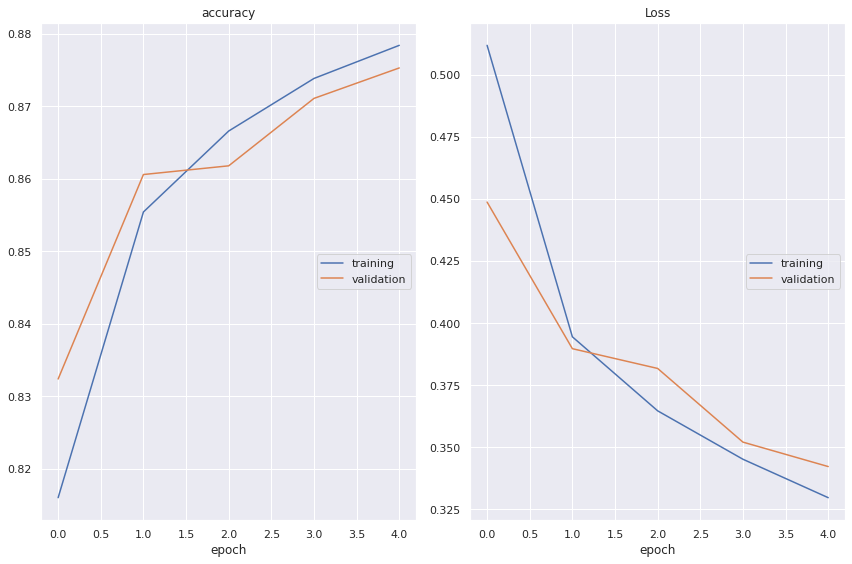

accuracy
	training         	 (min:    0.816, max:    0.878, cur:    0.878)
	validation       	 (min:    0.832, max:    0.875, cur:    0.875)
Loss
	training         	 (min:    0.330, max:    0.512, cur:    0.330)
	validation       	 (min:    0.342, max:    0.449, cur:    0.342)
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3297 - accuracy: 0.8784 - val_loss: 0.3422 - val_accuracy: 0.8753


In [ ]:
# Load & Prepare Model
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation=activation)) 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile Model
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKerasTF()],
          verbose=1)

##### <font color="blue">*Cost Function*

###### *Introduction*

**Cost, loss, risk or error function**

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/cost.jpg)

* The loss function computes the error for a single training example, while the cost function is the average of the loss functions of the entire training set.

* Also: objective function, error, cost & loss function. A loss function measures the quality of a particular set of parameters based on how well the induced scores agreed with the ground truth labels in the training data. We saw that there are many ways and versions of this (e.g. Softmax/SVM).
gradient of cost function tells each weight how to change to improve overall prediction
MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters.

* We want to find the local minimum of the cost function

*  Quadratic cost (mean squared error MSE): 
also maximum likelihood, and sum squared error. 
Most common. Used in regression. 
Mean squared error is appropriate to regression (line/curve fitting) where the goal is to minimize the mean squared error between the training set (points) and the fitted curve.

* The function we want to minimize or maximize is called the objective function or criterion. When we are minimizing it, we may also call it the cost function, loss function, or error function.

* In most cases, our parametric model defines a distribution […] and we simply use the **principle of maximum likelihood**. This means we use the cross-entropy between the training data and the model’s predictions as the cost function.

* It is important, therefore, that the function faithfully represent our design goals. If we choose a poor error function and obtain unsatisfactory results, the fault is ours for badly specifying the goal of the search.

**Maximum Likelihood Estimation**

* Maximum likelihood seeks to find the optimum values for the parameters by maximizing a likelihood function derived from the training data.

* Given input, the model is trying to make predictions that **match the data distribution of the target variable**. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

* One way to interpret maximum likelihood estimation is to view it as **minimizing the dissimilarity** between the empirical distribution […] defined by the training set and the model distribution, with the degree of dissimilarity between the two measured by the KL divergence. […] **Minimizing this KL divergence corresponds exactly to minimizing the cross-entropy between the distributions**.

* Under appropriate conditions, the maximum likelihood estimator has the **property of consistency** […], meaning that as the number of training examples approaches infinity, the maximum likelihood estimate of a parameter converges to the true value of the parameter.

* Under the framework maximum likelihood, the error between two probability distributions is measured using cross-entropy. Under maximum likelihood estimation, we would seek a set of model weights that minimize the difference between the model’s predicted probability distribution given the dataset and the distribution of probabilities in the training dataset. This is called the cross-entropy.

When using the framework of maximum likelihood estimation, we will implement a cross-entropy loss function, which often in practice means:
* a **cross-entropy** loss function for classification problems and 
* a **mean squared error** loss function for regression problems.

* Under the framework of maximum likelihood estimation and assuming a **Gaussian distribution for the target variable**, mean squared error can be considered the cross-entropy between the distribution of the model predictions and the distribution of the target variable.

* Many authors use the term “cross-entropy” to identify specifically the negative log-likelihood of a Bernoulli or softmax distribution, but that is a misnomer. 

* Any loss consisting of a negative log-likelihood is a cross-entropy between the empirical distribution defined by the training set and the probability distribution defined by model. 

* For example, **mean squared error is the cross-entropy between the empirical distribution and a Gaussian model**


https://machinelearningmastery.com/cross-entropy-for-machine-learning/


* https://en.m.wikipedia.org/wiki/Loss_function

* https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications


* https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

* https://allenkunle.me/deriving-ml-cost-functions-part1


* Properties of ideal Cost functions:
  * smooth, 
  * continuous, 
  * symmetric (but i.e. Non-symmetric losses: e.g., for spam classification)
  * differentiable

**Similarity learning** is closely related to distance metric learning. Metric learning is the task of learning a distance function over objects. A metric or distance function has to obey four axioms: non-negativity, identity of indiscernibles, symmetry and subadditivity (or the triangle inequality). **In practice, metric learning algorithms ignore the condition of identity of indiscernibles and learn a pseudo-metric.**

> $\min _{W}\left\{L(W):=\frac{1}{m} \sum_{i=1}^{m} \ell\left(W ; x_{i}, y_{i}\right)+\lambda r(W)\right\}$

**Similarity Learning & Distance Metric Learning**

* Ähnlichkeitsmaße werden für nominal oder ordinal skalierte Variablen genutzt

* Distanzmaße werden für metrisch skalierte Variablen (d. h. für Intervall- und Verhältnisskala) genutzt.

Complete list of [Loss / Cost Functions in TF](https://www.tensorflow.org/api_docs/python/tf/keras/losses/)

###### *Regression & Forecasting (mostly distance-based)*

Loss functions that belong to the category "distance-based" are primarily used in regression problems. They utilize the numeric difference between the predicted output and the true target as a proxy variable to quantify the quality of individual predictions.

> Great overview: http://juliaml.github.io/LossFunctions.jl/stable/losses/distance/

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/regression_loss.PNG)



**(Linear) Least Squares**

* Least Squares: Deren Parameter werden so bestimmt, dass die Summe der Abweichungsquadrate e der Beobachtungen y von den Werten der Funktion minimiert wird.

* Da die Kleinste-Quadrate-Schätzung die Residuenquadratsumme minimiert, ist es dasjenige Schätzverfahren, welches das [Bestimmtheitsmaß](https://de.wikipedia.org/wiki/Bestimmtheitsmaß) maximiert.

* Das Bestimmtheitsmaß der Regression, auch empirisches Bestimmtheitsmaß, ist eine dimensionslose Maßzahl die den Anteil der Variabilität in den Messwerten der abhängigen Variablen ausdrückt, der durch das lineare Modell „erklärt“ wird. Mithilfe dieser Definition können die Extremwerte für das Bestimmtheitsmaß aufgezeigt werden. Für das
Bestimmtheitsmaß gilt, dass es umso năher am Wert 1 ist, je kleiner die Residuenquadratsumme ist. Es wird maximal gleich 1 wenn $\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}=0$ ist, also alle Residuen null sind. In diesem Fall ist die Anpassung an die Daten perfekt, was bedeutet, dass für jede Beobachtung $y_{i}=\hat{y}_{i}$ ist.

* [Least Squares](https://en.wikipedia.org/wiki/Least_squares) / [Methode der kleinsten Quadrate](https://de.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate) & [Linear Least Squares](https://en.wikipedia.org/wiki/Linear_least_squares)

**Gauss–Markov theorem (BLUE)**

*  states that the ordinary least squares (OLS) estimator has the lowest sampling variance within the class of linear unbiased estimators, **if the errors in the linear regression model are uncorrelated, have equal variances and expectation value of zero**.

* stellt eine theoretische Rechtfertigung der Methode der kleinsten Quadrate dar

* Der Satz besagt, dass in einem linearen Regressionsmodell, in dem die **Störgrößen (error term) einen Erwartungswert von null und eine konstante Varianz haben sowie unkorreliert sind** (Annahmen des klassischen linearen Regressionsmodells), der Kleinste-Quadrate-Schätzer – vorausgesetzt er existiert – ein bester linearer erwartungstreuer Schätzer ist (englisch Best Linear Unbiased Estimator, kurz: BLUE). 

* Hierbei bedeutet der „beste“, dass er – innerhalb der Klasse der linearen erwartungstreuen Schätzer – die „kleinste“ Kovarianzmatrix aufweist und somit minimalvariant ist. Die Störgrößen müssen nicht notwendigerweise normalverteilt sein. Sie müssen im Fall der verallgemeinerten Kleinste-Quadrate-Schätzung auch nicht unabhängig und identisch verteilt sein.

The Gauss-Markov assumptions concern the set of error random variables, $\varepsilon_{i}:$

1. They have mean zero: $\mathrm{E}\left[\varepsilon_{i}\right]=0$ 

2. They are homoscedastic, that is all have the same finite variance: $\operatorname{Var}\left(\varepsilon_{i}\right)=\sigma^{2}<\infty$ for all $i$,
3. Distinct error terms are uncorrelated: $\operatorname{Cov}\left(\varepsilon_{i}, \varepsilon_{j}\right)=0, \forall i \neq j$.

A linear estimator of $\beta_{j}$ is a linear combination $\widehat{\beta}_{j}=c_{1 j} y_{1}+\cdots+c_{n j} y_{n}$

* The errors do not need to be normal, nor do they need to be independent and identically distributed (only uncorrelated with mean zero and homoscedastic with finite variance). 

* The requirement that the estimator be unbiased cannot be dropped, since biased estimators exist with lower variance. See, for example, the [James–Stein estimator](https://en.wikipedia.org/wiki/James–Stein_estimator) (which also drops linearity), [ridge regression(Tikhonov_regularization)](https://en.wikipedia.org/wiki/Tikhonov_regularization), or simply any [degenerate estimator](https://en.wikipedia.org/wiki/Degenerate_distribution).

* https://en.wikipedia.org/wiki/Gauss–Markov_theorem

**Ordinary Least Squares (OLS)**

* Ordinary least squares is a type of linear least squares method for estimating the unknown parameters in a linear regression model.  

* “Ordinary Least Squares” (OLS) method is used to find the best line intercept (b) and the slope (m). [in y = mx + b, m is the slope and b the intercept]


> $m=\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sum\left(x_{i}-\bar{x}\right)^{2}}$

> $b=\bar{y}-m * \bar{x}$

* In other words → with OLS Linear Regression the goal is to find the line (or hyperplane) that minimizes the vertical offsets. We define the best-fitting line as the line that minimizes the sum of squared errors (SSE) or mean squared error (MSE) between our target variable (y) and our predicted output over all samples i in our dataset of size n.

* OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function

* The OLS method minimizes the sum of squared residuals, and leads to a [closed-form expression](https://en.wikipedia.org/wiki/Closed-form_expression) for the estimated value of the unknown parameter vector β.

* It is important to point out though that OLS method will work for a univariate dataset (ie., single independent variables and single dependent variables). Multivariate dataset contains a single independent variables set and multiple dependent variables sets, requiring a machine learning algorithm called “Gradient Descent”.

* [Wiki](https://en.wikipedia.org/wiki/Ordinary_least_squares) & [Medium](https://medium.com/@jorgesleonel/linear-regression-307937441a8b)

**Weighted Least Squares (WLS)**

* are used when heteroscedasticity is present in the error terms of the model.
* https://en.wikipedia.org/wiki/Weighted_least_squares

**Generalized Least Squares (GLS)**

* is an extension of the OLS method, that **allows efficient estimation of β when either heteroscedasticity, or correlations, or both are present among the error terms of the model**, as long as the form of heteroscedasticity and correlation is known independently of the data. 

* To handle heteroscedasticity when the error terms are uncorrelated with each other, GLS minimizes a weighted analogue to the sum of squared residuals from OLS regression, where the weight for the ith case is inversely proportional to var(εi). This special case of GLS is called "weighted least squares". 

* https://en.wikipedia.org/wiki/Generalized_least_squares

**SE, SAE & SSE**

**Sum of Errors (SE)** the difference in the predicted value and the actual value.

$\mathbf{L}=\Sigma(\hat{Y}-Y)$

Errors terms cancel each other out.

**Sum of Absolute Errors (SAE)** takes the absolute values of the errors for all iterations.

$\mathbf{L}=\Sigma (|\hat{Y}-Y|)$

This loss function is not differentiable at 0.

**Sum of Squared Errors (SSE)** is differentiable at all points and gives non-negative errors. But you could argue that why cannot we go for higher orders like 4th order or so. Then what if we consider to take 4th order loss function, which would look like:

$\mathbf{L}=\left[\Sigma(\hat{Y}-Y)^{2}\right]$

The gradient of the loss function will vanish at minima & maxima. And the error will grow with the sample size.

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/sumoferrors.png)

* Minimizing Sum of Squared Errors / SSE ([wiki](https://de.m.wikipedia.org/wiki/Residuenquadratsumme) and [medium](https://medium.com/@dustinstansbury/cutting-your-losses-loss-functions-the-sum-of-squared-errors-loss-4c467d52a511)).  We can think of the SSE loss as the (unscaled) variance of the model errors. 
* Therefore **minimizing the SEE loss is equivalent to minimizing the variance of the model residuals**. For this reason, the sum of squares loss is often referred to as the Residual Sum of Squares error (RSS) for linear models. We can think of minimizing the SSE loss as maximizing the covariance between the real outputs and those predicted by the model.
* Ideal when distribution of residuals in normal: the [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) states that if errors of a linear function are distributed Normally about the mean of the line, then the LSS solution gives the [best unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) for the parameters .
* Problem: Because each error is squared, any outliers in the dataset can dominate the parameter estimation process. For this reason, the LSS loss is said to lack robustness. Therefore preprocessing of the the dataset (i.e. removing or thresholding outlier values) may be necessary when using the LSS loss


**MSE (L2) & RMSE (Squared Euclidean Distance)**

* Squared Euclidean distance is of central importance in estimating parameters of statistical models, where it is used in the method of least squares, a standard approach to regression analysis. 

* The corresponding loss function is the squared error loss (SEL), and places progressively greater weight on larger errors. The corresponding risk function (expected loss) is mean squared error (MSE).

* **Squared Euclidean distance is not a metric**, as it does not satisfy the triangle inequality. However, **it is a more general notion of distance, namely a divergence** (specifically a Bregman divergence), and can be used as a statistical distance. 

https://en.m.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/3d-function-2.svg/566px-3d-function-2.svg.png)

*A paraboloid, the graph of squared Euclidean distance from the origin*

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/3d-function-5.svg/566px-3d-function-5.svg.png)

*A cone, the graph of Euclidean distance from the origin in the plane*

**Mean Squared Error**

$\mathrm{MSE}={\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Mean Squared Error (L2 or Quadratic Loss). Error decreases as we increase our sample data as the distribution of our data becomes more and more narrower (referring to normal distribution). The more data we have, the less is the error.
* Can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better. It is always non – negative and values close to zero are better. The MSE is the second moment of the error (about the origin) and thus incorporates both the variance of the estimator and its bias.
* Problem: Sensitive to outliers and the order of loss is more than that of the data. As my data is of order 1 and the loss function, MSE has an order of 2 (squared). So we cannot directly correlate data with the error. 
* [Wikipedia](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate)

**Mean Squared Logarithmic Error (MSLR)**

* Mean Squared Logarithmic Error
* https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredLogarithmicError

**RMSE** (Root-Mean-Square Error)

$\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Root-Mean-Square Error is the distance, on average, of a data point from the fitted line, measured along a vertical line.
* The **RMSE is directly interpretable in terms of measurement units**, and so is a better measure of goodness of fit than a correlation coefficient. One can compare the RMSE to observed variation in measurements of a typical point. The two should be similar for a reasonable fit. Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable
* https://www.sciencedirect.com/science/article/pii/S096014811831231X
* The **RMSE is more appropriate to represent model performance than the MAE when the error distribution is expected to be Gaussian**.
https://www.geosci-model-dev-discuss.net/7/C473/2014/gmdd-7-C473-2014-supplement.pdf
* When both metrics are calculated, the MAE tends to be much smaller than the RMSE because the RMSE penalizes large errors while the MAE gives the same weight to all errors.
* They summarized that the **RMSE tends to become increasingly larger than the MAE** (but not necessarily in a monotonic fashion) as the distribution of error magnitudes becomes more variable. The RMSE tends to 1 grow larger than the MAE with n2 since its lower limit is fixed at the MAE and its upper 11 limit (n2 · MAE) increases with n2 .
* [Wiki](https://en.m.wikipedia.org/wiki/Root-mean-square_deviation) & [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)

In [ ]:
tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

**MAE (L1) & MAPE**

$\mathrm{MAE}=\frac{1}{n} \sum_{j=1}^{n}\left|y_{j}-\hat{y}_{j}\right|$

* If the absolute value is not taken (the signs of the errors are not removed), the average error becomes the Mean Bias Error (MBE) and is usually intended to measure average model bias. MBE can convey useful information, but should be interpreted cautiously because positive and negative errors will cancel out.

* Mean Absolute Error (L1 Loss)
* Computes the mean of absolute difference between labels and predictions
* measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
* On some regression problems, the **distribution of the target variable may be mostly Gaussian, but may have outliers**, e.g. large or small values far from the mean value. The Mean Absolute Error, or MAE, loss is an appropriate loss function in this case as it is more robust to outliers. It is calculated as the average of the absolute difference between the actual and predicted values.
* Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Extremwerte als Ausreißer mit geringerem Einfluss auf das Modell ansehen: MAE loss is useful if the training data is corrupted with outliers (i.e. we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment).


In [ ]:
loss = 'mae'

**MAE vs MSE**

* One big problem in using MAE loss (for neural nets especially) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. 

* This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima. MSE behaves nicely in this case and will converge even with a fixed learning rate. 

* The gradient of MSE loss is high for larger loss values and decreases as loss approaches 0, making it more precise at the end of training (see figure below.)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/mae_vs_mse.PNG)

**Mean Absolute Percentage Error (MAPE)**

$\mathrm{M}=\frac{1}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right|$

* The mean absolute percentage error (MAPE) is a statistical measure of **how accurate a forecast** system is. 

* It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values. Where At is the actual value and Ft is the forecast value.

* The mean absolute percentage error (MAPE) is the most common measure used to forecast error, and works best if there are no extremes to the data (and no zeros).

* https://en.m.wikipedia.org/wiki/Mean_absolute_percentage_error

In [ ]:
tf.keras.losses.MAPE(
    y_true, y_pred
)

**Symmetric Mean Absolute Percentage Error (sMAPE)**

* There are 3 different definitions of sMAPE. Two of them are below:

$\operatorname{SMAPE}=\frac{100 \%}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(\left|A_{t}\right|+\left|F_{t}\right|\right) / 2}$

* Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. 

* At is the actual value and Ft is the forecast value

* The absolute difference between At and Ft is divided by half the sum of absolute values of the actual value At and the forecast value Ft. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n.

* Armstrong's original definition is as follows:

$\mathrm{SMAPE (old)}=\frac{1}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(A_{t}+F_{t}\right) / 2}$

* The problem is that it can be negative (if ${\displaystyle A_{t}+F_{t}<0}$) or even undefined (if ${\displaystyle A_{t}+F_{t}=0}$). Therefore the currently accepted version of SMAPE assumes the absolute values in the denominator.

* In contrast to the mean absolute percentage error, SMAPE has both a lower bound and an upper bound. Indeed, the formula above provides a result between 0% and 200%. However a percentage error between 0% and 100% is much easier to interpret. That is the reason why the formula below is often used in practice (i.e. no factor 0.5 in denominator)

* One supposed problem with SMAPE is that it is not symmetric since over- and under-forecasts are not treated equally. This is illustrated by the following example by applying the second SMAPE formula:

  * Over-forecasting: At = 100 and Ft = 110 give SMAPE = 4.76%

  * Under-forecasting: At = 100 and Ft = 90 give SMAPE = 5.26%.

* [Wiki](https://en.m.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) & [Wiki2](https://wiki2.org/en/Symmetric_mean_absolute_percentage_error) & [other](https://www.brightworkresearch.com/the-problem-with-using-smape-for-forecast-error-measurement/)

In [ ]:
# Import Keras backend
import keras.backend as K

# Define SMAPE loss function
def customLoss(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

# https://medium.com/@mlguy/adding-custom-loss-and-optimizer-in-keras-e255764e1b7d

**Mean absolute scaled error (MASE)**

* mean absolute scaled error (MASE) is a measure of the accuracy of forecasts.

*  It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast. It was proposed in 2005.

* The mean absolute scaled error has the following desirable propertie: [Wiki](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)

**Huber Loss (Smooth Mean Absolute Error)**

* TLDR: will better find a minimum than L1, but less exposed to outliers than L2. However one has to tune the hyperparameter delta. The larger (3+), the more it is L2, the smaller (1), the more it is L1.

* The Huber loss **combines the best properties of MSE and MAE** (Mean Absolute Error). It is quadratic for smaller errors and is linear otherwise (and similarly for its gradient). It is identified by its delta parameter.

* It's **less sensitive to outliers** in data than the squared error loss. It’s **also differentiable at 0**. It’s basically absolute error, which becomes quadratic when error is small.  How small that error has to be to make it quadratic depends on a hyperparameter 𝛿. 

* Once differentiable.

$L_{\delta}(y, f(x))=\left\{\begin{array}{ll}
\frac{1}{2}(y-f(x))^{2} & \text { for }|y-f(x)| \leq \delta \\
\delta|y-f(x)|-\frac{1}{2} \delta^{2} & \text { otherwise }
\end{array}\right.$

* **Huber loss approaches MSE when 𝛿 ~ 0 and MAE when 𝛿 ~ ∞**

* The choice of delta is critical because it determines what you’re willing to consider as an outlier. Residuals larger than delta are minimized with L1 (which is less sensitive to large outliers), while residuals smaller than delta are minimized “appropriately” with L2.

* One big problem with using MAE for training of neural nets is its constantly large gradient, which can lead to missing minima at the end of training using gradient descent. For MSE, gradient decreases as the loss gets close to its minima, making it more precise.
Huber loss can be really helpful in such cases, as it curves around the minima which decreases the gradient. And it’s more robust to outliers than MSE. Therefore, **it combines good properties from both MSE and MAE**. 

* However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

* [Wiki](https://en.m.wikipedia.org/wiki/Huber_loss) * [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)

* https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

* The biggest problem with using MAE to train neural networks is the constant large gradient, which may cause the minimum point to be missed when the gradient descent is about to end. For MSE, the gradient will decrease as the loss decreases, making the result more accurate.

* In this case, Huber loss is very useful. It will fall near the minimum value due to the decreasing gradient. It is more robust to outliers than MSE. Therefore, Huber loss combines the advantages of MSE and MAE. However, the problem with Huber loss is that we may need to constantly adjust the hyperparameters

* https://www.programmersought.com/article/86974383768/

* When you compare this statement with the benefits and disbenefits of both the MAE and the MSE, you’ll gain some insights about how to adapt this delta parameter:

* **If your dataset contains large outliers**, it’s likely that your model will not be able to predict them correctly at once. In fact, it might take quite some time for it to recognize these, if it can do so at all. This results in large errors between predicted values and actual targets, because they’re outliers. Since MSE squares errors, large outliers will distort your loss value significantly. If outliers are present, you likely don’t want to use MSE. Huber loss will still be useful, but you’ll have to use small values for 𝛿.

* If it does not contain many outliers, it’s likely that it will generate quite accurate predictions from the start – or at least, from some epochs after starting the training process. In this case, you may observe that the errors are very small overall. Then, one can argue, it may be worthwhile to let the largest small errors contribute more significantly to the error than the smaller ones. In this case, MSE is actually useful; hence, with Huber loss, you’ll likely want to use quite large values for 𝛿.

* If you don’t know, you can always start somewhere in between – for example, in the plot above, 𝛿 = 1 represented MAE quite accurately, while 𝛿 = 3 tends to go towards MSE already. What if you used 𝛿 = 1.5 instead? You may benefit from both worlds.

https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

* For target = 0, the loss increases when the error increases. However, the speed with which it increases depends on this 𝛿 value. In fact, Grover (2019) writes about this as follows: Huber loss approaches MAE when 𝛿 ~ 0 and MSE when 𝛿 ~ ∞ (large numbers.)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/320px-Huber_loss.svg.png)

*Huber loss (green, 
δ
=
1) and squared error loss (blue) as a function of 
y
−
f
(
x
)*

![huber](https://raw.githubusercontent.com/deltorobarba/repo/master/huberloss.jpg)

In [ ]:
loss = tf.keras.losses.Huber(delta=10.0, name='huber_loss')

**Log-Cosh Loss**

* TLDR: Similar to MAE, will not be affected by outliers. Log-Cosh has all the points of Huber loss, and no need to set hyperparameters. Compared with Huber, Log-Cosh derivation is more complicated, requires more computation, and is not used much in deep learning. 

* * Log-cosh is another function used in regression tasks that’s smoother than L2 (is smoothed towards large errors (presumably caused by outliers) so that the final error score isn’t impacted thoroughly.)
* Log-cosh is the logarithm of the hyperbolic cosine of the prediction error. “Log-cosh is the logarithm of the hyperbolic cosine of the prediction error.” (Grover, 2019). Oops, that’s not intuitive but nevertheless quite important – this is the maths behind Logcosh loss:

> $\log \cosh (t)=\sum_{p \in P} \log (\cosh (p-t))$

* Similar to Huber Loss, but twice differentiable everywhere
* [Wiki Hyperbolic Functions](https://en.m.wikipedia.org/wiki/Hyperbolic_functions), [TF Class](https://www.tensorflow.org/api_docs/python/tf/keras/losses/LogCosh), [Machinecurve](https://www.machinecurve.com/index.php/2019/10/23/how-to-use-logcosh-with-keras/)

* However, Log-Cosh is second-order differentiable everywhere, which is still very useful in some machine learning models. For example, XGBoost uses Newton's method to find the best advantage. Newton's method requires solving the second derivative (Hessian). Therefore, for machine learning frameworks such as XGBoost, the second order of the loss function is differentiable. But the Log-cosh loss is not perfect, and there are still some problems. For example, if the error is large, the first step and Hessian will become fixed, which leads to the lack of split points in XGBoost.

https://www.programmersought.com/article/86974383768/

![logcosh](https://raw.githubusercontent.com/deltorobarba/repo/master/logcosh.jpeg)

In [ ]:
loss = tf.keras.losses.LogCosh()

**Quantile Loss (Pinball Loss)**

* TLDR: for Heteroskedastizität, i.e. for risk management when variance changes. Quantile Loss, you can set different quantiles to control the proportion of overestimation and underestimation in loss.

* estimates conditional “quantile” of a response variable given certain values of predictor variables
* is an extension of MAE (**when quantile is 50th percentile, it’s MAE**)
* Im Gegensatz zur Kleinste-Quadrate-Schätzung, die den Erwartungswert der Zielgröße schätzt, ist die Quantilsregression dazu geeignet, ihre Quantile zu schätzen.
* Fitting models for many percentiles, you can estimate the entire conditional distribution. Often, the answers to important questions are found by modeling percentiles in the tails of the distribution. For that reason **quantile regression provides critical insights in financial risk management & fraud detection**. 
* [Wikipedia](https://de.m.wikipedia.org/wiki/Quantilsregression), [TF Class](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/PinballLoss) & [TF Function](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss)

* project where predictions were subject to high uncertainty. The client required for their decision to be driven by both the predicted machine learning output and a measure of the potential prediction error. The quantile regression loss function solves this and similar problems by replacing a single value prediction by prediction intervals.

* The quantile regression loss function is applied to predict quantiles. A quantile is the value below which a fraction of observations in a group falls. For example, a prediction for quantile 0.9 should over-predict 90% of the times.

* For q equal to 0.5, under-prediction and over-prediction will be penalized by the same factor, and the median is obtained. The larger the value of q, the more over-predictions are penalized compared to under-predictions. For q equal to 0.75, over-predictions will be penalized by a factor of 0.75, and under-predictions by a factor of 0.25. The model will then try to avoid over-predictions approximately three times as hard as under-predictions, and the 0.75 quantile will be obtained.

* The usual regression algorithm is to fit the expected or median training data, and the quantile loss function can be used to fit different quantiles of training data by giving different quantiles. 

![sdd](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss.jpg)

* Set different quantiles to fit different straight lines: This function is a piecewise functio., γ is the quantile coefficient. y is the true value, f(x) is the predicted value. According to the size of the predicted value and the true value, there are two cases to consider. 

* y> f(x) For overestimation, the predicted value is greater than the true value; 

* y< f(x) to underestimate, the predicted value is smaller than the real value.

* Use different pass coefficients to control the weight of overestimation and underestimation in the entire loss value.

* Especially when γ=0.5 When the quantile loss degenerates into the mean absolute error MAE, **MAE can also be regarded as a special case of quantile loss-median loss**. The picture below is taken with different median points [0.25,0.5,0.7] Obtaining different quantile loss function curves can also be seen as MAE at 0.5.

![fgfgf](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss2.jpg)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Pinball_Loss_Function.svg/320px-Pinball_Loss_Function.svg.png)

*Pinball-Verlustfunktion mit 
τ
=0,9. Für 
ε
<
0 beträgt der Fehler 
−
0
,
1
ε, für 
ε
≥
0 beträgt er 
0
,
9
ε.*

* https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/

In [ ]:
loss = tfa.losses.PinballLoss(tau=.1)

**Poisson Loss**

* https://towardsdatascience.com/the-poisson-distribution-103abfddc312

* https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459


In [ ]:
tf.keras.losses.poisson(
    y_true, y_pred
)

###### *Classification (mostly entropy-/ divergence-based or margin-based)*

**Loss Functions for classification**

* Types: Margin-based, Cross-Entropy-based and Divergence-based

* https://en.wikipedia.org/wiki/Loss_functions_for_classification

* https://www.machinecurve.com/index.php/2019/10/04/about-loss-and-loss-functions/#loss-functions-for-classification

* https://arxiv.org/pdf/1702.05659.pdf

* http://cs229.stanford.edu/extra-notes/loss-functions.pdf

**Margin-based Loss**

* Margin-based loss functions are particularly useful for binary classification. In contrast to the distance-based losses, these do not care about the difference between true target and prediction. 

* Instead they penalize predictions based on how well they agree with the sign of the target.

* http://juliaml.github.io/LossFunctions.jl/stable/losses/margin/

* Methods:

  * **Exponential Loss**

  * **Hinge Loss** (tf.keras.losses.hinge(y_true, y_pred)): The hinge loss function has many extensions, often the subject of investigation with SVM models.

  * **Squared Hinge Loss**: A popular extension of the Hinge Loss is called the squared hinge loss that simply calculates the square of the score hinge loss. It has the effect of smoothing the surface of the error function and making it numerically easier to work with. If using a hinge loss does result in better performance on a given binary classification problem, is likely that a squared hinge loss may be appropriate.

**Cross-Entropy-based Losses**

* the [cross entropy](https://en.m.wikipedia.org/wiki/Cross_entropy) between two probability distributions p and q **over the same underlying set of events** measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p.
* Binary Cross-Entropy
* Conditional entropy
* Joint entropy
* Cross entropy (Log loss or logistic regression): 
  * https://en.m.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression
  * https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83

**Method 1: Binary Classification: Cross-Entropy or Log-Loss (Logistic Loss/ negative log-likelihood)**

  * It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 
  * So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value.  A perfect model would have a log loss of 0.
  * Cross-entropy and log loss are slightly different depending on context, but in machine learning when calculating error rates between 0 and 1 they resolve to the same thing. 
  * Cross-entropy is the default loss function to use for binary classification problems.
  * It is intended for use with binary classification where the target values are in the set {0, 1}.
  * Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.
  * Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0.
  * The function requires that the output layer is configured with a single node and a ‘sigmoid‘ activation in order to predict the probability for class 1.

**Method 2: Multiclass Classification: Sparse Categorical Cross-Entropy**

* Cross-entropy is the default loss function to use for multi-class classification problems.

* In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value.

* Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

* Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

* A possible cause of frustration when using cross-entropy with classification problems with a large number of labels is the one hot encoding process.

* For example, predicting words in a vocabulary may have tens or hundreds of thousands of categories, one for each label. This can mean that the target element of each training example may require a one hot encoded vector with tens or hundreds of thousands of zero values, requiring significant memory.

* Sparse cross-entropy addresses this by performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training.

> loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

> loss = 'sparse_categorical_crossentropy'

**Cross-Entropy vs KL Divergence vs Logloss**

* Cross-entropy is a measure from the field of information theory, building upon entropy and generally calculating the difference between two probability distributions. It is closely related to but is different from **KL divergence** that calculates the relative entropy between two probability distributions, whereas cross-entropy can be thought to calculate the total entropy between the distributions.

* Cross-entropy is also related to and often confused with **logistic loss, called log loss**. Although the two measures are derived from a different source, when used as loss functions for classification models, both measures calculate the same quantity and can be used interchangeably.

**Divergence-based**

**Kullback-Leibler Divergence (Multiclass)**

* [Kullback Leibler Divergence](https://en.m.wikipedia.org/wiki/Kullback–Leibler_divergence), or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution. 


* The only divergence that is both an f-divergence and a Bregman divergence is the Kullback–Leibler divergence

* Use for example as **loss function in variational autoencoder**

  * https://www.kaggle.com/debanga/statistical-distances

  * https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution. 

* As such, the KL divergence loss function is more commonly used when using models that learn to **approximate a more complex function than simply multi-class classification**, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. 

* Nevertheless, it can be used for **multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy**.

* Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution.

* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution.

* As such, the KL divergence loss function is more commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. Nevertheless, it can be used for multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy.

**Jensen–Shannon divergence**

* It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance
* use in GAN's for example (Goodfellow, Ian J.; Pouget-Abadie, Jean; Mirza, Mehdi; Xu, Bing; Warde-Farley, David; Ozair, Sherjil; Courville, Aaron; Bengio, Yoshua (2014). Generative Adversarial Networks. NIPS. arXiv:1406.2661. Bibcode:2014arXiv1406.2661G)
* https://en.m.wikipedia.org/wiki/Generative_adversarial_network
* https://en.m.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

**f-Divergence**

* Probabilistic models are often trained by maxi- mum likelihood, which corresponds to minimiz- ing a specific f-divergence between the model and data distribution. 

* In light of recent suc- cesses in training Generative Adversarial Networks, alternative non-likelihood training crite- ria have been proposed.

* https://arxiv.org/pdf/1907.11891.pdf and https://arxiv.org/pdf/1905.12888.pdf

* https://en.m.wikipedia.org/wiki/F-divergence

* The Hellinger distance is a type of f-divergence

* https://en.m.wikipedia.org/wiki/Hellinger_distance

* https://www.mis.mpg.de/fileadmin/pdf/geoasp_2008_petz.pdf

**Hellinger Distance**

* the [Hellinger distance](
https://en.m.wikipedia.org/wiki/Hellinger_distance) (closely related to, although different from, the Bhattacharyya distance) is used to **quantify the similarity between two probability distributions**. 

* **It is a type of f-divergence.**

* (?) ist vielleicht sogar eine metric weil es triangle inequality erfüllt.

**Bregman Divergence**

* In machine learning, [Bregman divergences](
https://en.m.wikipedia.org/wiki/Bregman_divergence) are used to calculate the bi-tempered logistic loss, performing better than the softmax function with noisy datasets

* The squared Euclidean divergence is a Bregman divergence (corresponding to the function x<sup>2</sup>, but not an f-divergence

* COST-SENSITIVE CLASSIFICATION BASED ON BREGMAN DIVERGENCES: https://core.ac.uk/download/pdf/29402554.pdf

**Bhattacharyya distance**

* In statistics, the [Bhattacharyya distance](
https://en.m.wikipedia.org/wiki/Bhattacharyya_distance) measures the similarity of two probability distributions. It is closely related to the Bhattacharyya coefficient which is a measure of the amount of overlap between two statistical samples or populations. 

* The coefficient can be used to determine the relative closeness of the two samples being considered. It is used to measure the separability of classes in classification and it is considered to be more reliable than the Mahalanobis distance, as the ***Mahalanobis distance is a particular case of the Bhattacharyya distance** when the standard deviations of the two classes are the same. 

* Consequently, when two classes have similar means but different standard deviations, the Mahalanobis distance would tend to zero, whereas the Bhattacharyya distance grows depending on the difference between the standard deviations.

* under certain conditions does not obey the triangle inequality

* https://towardsdatascience.com/bhattacharyya-kernels-and-machine-learning-on-sets-of-data-bf94a22097f7

**Mahalanobis distance**

* The [Mahalanobis distance](
https://en.m.wikipedia.org/wiki/Mahalanobis_distance) is a measure of the distance between a point P and a distribution D

* If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set.

* In statistics, the covariance matrix of the data is sometimes used to define a distance metric called Mahalanobis distance.

* Bregman divergence: **the Mahalanobis distance is an example of a Bregman divergence**

* **Bhattacharyya distance related, for measuring similarity between data sets (and not between a point and a data set** - Mahalanobis distance is a particular case of the Bhattacharyya distance when the standard deviations of the two classes are the same.)

* Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. 

* It is an extremely useful metric having, excellent applications **in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification**. 

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/mahalanobis.jpg)

* If the dimensions (columns in your dataset) are correlated to one another, which is typically the case in real-world datasets, the Euclidean distance between a point and the center of the points (distribution) can give little or misleading information about how close a point really is to the cluster.

* The two points above are equally distant (Euclidean) from the center. But only one of them (blue) is actually more close to the cluster, even though, technically the Euclidean distance between the two points are equal.

* This is because, Euclidean distance is a distance between two points only. It does not consider how the rest of the points in the dataset vary. So, it cannot be used to really judge how close a point actually is to a distribution of points.

* **What we need here is a more robust distance metric that is an accurate representation of how distant a point is from a distribution.**

###### *Metric Learning (Similarity Learning)*

**Metric Learning (Similarity Learning) & Ranking Loss**

* https://en.m.wikipedia.org/wiki/Similarity_learning

* https://en.m.wikipedia.org/wiki/Similarity_learning#Metric_learning

* https://towardsdatascience.com/metric-learning-loss-functions-5b67b3da99a5

* If you'd like some theory with your contrastive losses, the first author of SimCLR and SimCLR v2 Ting Chen and Lala Li (both at Google Brain) have an interesting new paper. https://arxiv.org/pdf/2011.07876.pdf

**Loss Functions for Metric Learning**
https://gombru.github.io/2019/04/03/ranking_loss/

Ranking Losses are essentialy the ones explained above, and are used in many different aplications with the same formulation or minor variations. However, different names are used for them, which can be confusing. Here I explain why those names are used.

* Ranking loss: This name comes from the information retrieval field, where we want to train models to rank items in an specific order.
* Margin Loss: This name comes from the fact that these losses use a margin to compare samples representations distances.
* Contrastive Loss: Contrastive refers to the fact that these losses are computed contrasting two or more data points representations. This name is often used for * Pairwise Ranking Loss, but I’ve never seen using it in a setup with triplets.
* Triplet Loss: Often used as loss name when triplet training pairs are employed.
* Hinge loss: Also known as max-margin objective. It’s used for training SVMs for classification. It has a similar formulation in the sense that it optimizes until a margin. That’s why this name is sometimes used for Ranking Losses.
* **Triplet loss** is probably the most popular loss function of metric learning. (a loss function for machine learning algorithms) is often used for learning similarity for the purpose of learning embeddings, like word embeddings and even thought vectors, and metric learning. https://en.m.wikipedia.org/wiki/Triplet_loss
* **Contrastive Loss**: Contrastive loss was first introduced in 2005 by Yann Le Cunn et al. in this paper and its original application was in Dimensionality Reduction. Now, if you recall, the general goal of a Dimensionality reduction algorithm can be formulated like this: 
  * Given a sample (a data point) — a D-dimensional vector, transform this sample into a d-dimensional vector, where d ≪ D, while preserving as much information as possible. 
  * The difference is that Cross-entropy loss is a classification loss which operates on class probabilities produced by the network independently for each sample, and Contrastive loss is a metric learning loss, which operates on the data points produced by network and their positions relative to each other. 
  * This is also part of the reason a **cross-entropy loss is not usually used for metric learning tasks** like Face Verification — it doesn’t impose any constraints on the distribution on the model’s inner representation of the given data — i.e. the model can learn any features regardless of whether similar data points would be located closely to each other or not after the transformation.
  * for each class/group of similar points (in case of Face Recognition task it would be all the photos of the same person) the **maximum intra-class distance is smaller than the minimum inter-class distance.** 
  * It operates on pairs of embeddings received from the model and on the ground-truth similarity flag — a Boolean label, specifying whether these two samples are “similar” or “dissimilar”. So the input must be not one, but 2 images.
  * It penalizes “similar” samples for being far from each other in terms of Euclidean distance (although other distance metrics could be used).
  * “Dissimilar” samples are penalized by being to close to each other, but in a somewhat different way — Contrastive Loss introduces the concept of “margin” — a minimal distance that dissimilar points need to keep. So it penalizes dissimilar samples for beings closer than the given margin.
* **Ranking & Learning to Rank**: Ranking.. (triplet loss mit similarity learning wird im ranking verwendet, weil es ordinal ist im ggs zu distance learning..). See also [Ranking (information_retrieval)](https://en.m.wikipedia.org/wiki/Ranking_(information_retrieval)), [Learning_to_rank](https://en.m.wikipedia.org/wiki/Learning_to_rank), 
* CosineEmbeddingLoss. It’s a Pairwise Ranking Loss that uses cosine distance as the distance metric. Inputs are the features of the pair elements, the label indicating if it’s a positive or a negative pair, and the margin.
* MarginRankingLoss. Similar to the former, but uses euclidian distance.
* TripletMarginLoss. A Triplet Ranking Loss using euclidian distance.
* contrastive_loss. Pairwise Ranking Loss.
* triplet_semihard_loss. Triplet loss with semi-hard negative mining.

**Architectures: Siamese Nets or Triplet Nets**

* Siamese and triplet nets are training setups where Pairwise Ranking Loss and Triplet Ranking Loss are used. But those losses can be also used in other setups. 

* Siamese nets are built by two identical CNNs with shared weights (both CNNs have the same weights). Each one of these nets processes an image and produces a representation. Those representations are compared and a distance between them is computed. Then, a Pairwise Ranking Loss is used to train the network, such that the distance between representations produced by similar images is small, and the distance between representations of dis-similar images is big.

* Triplet nets: The idea is similar to a siamese net, but a triplet net has three branches (three CNNs with shared weights). The model is trained by simultaneously giving a positive and a negative image to the corresponding anchor image, and using a Triplet Ranking Loss. That lets the net learn better which images are similar and different to the anchor image.

* Example: Ranking Loss for Multi-Modal Retrieval

**Similarity Learning vs Regression & Classification**

Similarity learning is an area of supervised machine learning in artificial intelligence. It is closely related to regression and classification, but the goal is to learn a similarity function that measures how similar or related two objects are. It has applications in ranking, in recommendation systems, visual identity tracking, face verification, and speaker verification.

**Classification vs Metric Learning**

* **Classification is a “Closed-set” task**. can't add new labels without complete retraining.  The model here is trying to learn separable features in this case — i.e. features, that would allow to assign a label from a predefined set to a given image. The model is trying to find a hyperplane, a rule that separates given classes in space.

* **Metric Learning** is a “Open-set” task. This one means that we do indeed have some predefined set of labels for training, but the model can be applied to any unseen data and it should generalize. In this case the model is trying to solve a metric-learning problem: to learn some sort of similarity metric, and for that it needs to extract discriminative features — features that can be used to distinguish between different people on any two (or more) images. The model is trying not to separate images with a hyperplane, but rather reorganize the input space, pull the similar images together in some form of a cluster while pushing dissimilar images away. 

* This is somewhat reminiscent of clustering problem in Unsupervised Learning — and indeed you can use a model trained on a metric-learning task to create a distance matrix for new data, and than run algorithms like DBSCAN on it to, e.g., cluster images of people’s faces, where each cluster would correspond to a new person.

* https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

## <font color="blue">**Quantum Information**

###### *Quantum Complexity*

Total CPU time vs Wallclock time:

https://pythonspeed.com/articles/blocking-cpu-or-io/

> [Computational complexity theory](https://en.m.wikipedia.org/wiki/Computational_complexity_theory)
* [Theory of computation](https://en.m.wikipedia.org/wiki/Theory_of_computation)
* [Quantum_Turing_machine](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine)
* [Big O notation (Landau)](https://en.m.wikipedia.org/wiki/Big_O_notation): Big (O) worste case / Big Ω (Omega) best case / Big θ (Theta) notation (Asymptotic Analysis of Algorithms) Omega=(O)
* [Quantum complexity theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory)
* [Quantum supremacy](https://en.m.wikipedia.org/wiki/Quantum_supremacy)

**See many examples of** [Computational complexity of mathematical operations](https://en.m.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra)

**Time Complexity or Order of Growth of any program**

* https://en.m.wikipedia.org/wiki/Time_complexity
* https://www.rookieslab.com/posts/how-to-compute-time-complexity-order-of-growth-of-any-program

*Example: Linear growth is O(N), so the Big O notation for linear search / for a linear function is O(N):*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0898.jpg)

*Graphs of functions commonly used in the analysis of algorithms, showing the number of operations N versus input size n for each function:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Comparison_computational_complexity.svg/480px-Comparison_computational_complexity.svg.png)

**Complexity Classes**

![ggg](https://raw.github.com/deltorobarba/repo/master/quantum_019.jpg)
*Source: [Finally, a Problem That Only Quantum Computers Will Ever Be Able to Solve](https://www.quantamagazine.org/finally-a-problem-that-only-quantum-computers-will-ever-be-able-to-solve-20180621/)*


* Great NP Hard explanation: https://youtu.be/EHp4FPyajKQ and https://youtu.be/YX40hbAHx3s
* **Complexity class P** is all the problems that a classical computer can solve quickly. (“Is this number prime?” belongs to P). Solvable in polynomial time, not exponentially.
* **Complexity class NP** is all the problems that classical computers can’t necessarily solve quickly, but for which they can quickly verify an answer if presented with one. (“What are its prime factors?” belongs to NP.) 
* Computer scientists believe that P and NP are distinct classes, but actually proving that distinctness is the hardest and most important open problem in the field.
* **NP hard**
* **NP complete**
* https://en.m.wikipedia.org/wiki/Complexity_class
* https://en.m.wikipedia.org/wiki/QMA
* https://en.m.wikipedia.org/wiki/BQP
* https://en.m.wikipedia.org/wiki/BPP_(complexity)
* [Sign Problem](https://en.m.wikipedia.org/wiki/Numerical_sign_problem) is NP hard. https://arxiv.org/pdf/1805.08219.pdf
* https://www.quora.com/What-is-the-relationship-between-BQP-and-NP-1


* Iterative improvements in classical algorithm have so far not paid off to transform a hard problem to an easy one.

* This is where quantum computing comes in: 

  * an “easy” problem that can be solved using a quantum computer in polynomial time is class BQP (Bounded-error Quantum Polynomial time), 
  
  * and a hard problem which can only be verified in polynomial time is class QMA (the playfully named Quantum Merlin Arthur).

* The hope in the field is that there is some overlap between the space of NP problems and BQP problems: that by leveraging quantum resources like superposition and entanglement, a hard problem can be transformed into an easy one.



**Algorithmic Efficiency**

https://de.m.wikipedia.org/wiki/Garbage_Collection

*Zeitkomplexität*: 
* Ausführungsdauer eines Algorithmus,
in Abhängigkeit zur Eingabemenge. 
* An der Zeitkomplexität sieht man das Wachstum der Ausführungszeit in Relation zum Wachstum der Eingabemenge.
* Wie wächst die benötigte Anzahl von Rechenschritten und damit Rechenzeit it der Eingabelänge?

*Platzkomplexität*: 
* Wie wächst der benötigte Speicherplatz mit der Eingabelänge?
* Die Platzkomplexität beschreibt den Speicherplatzbedarf eines Algorithmus, in Abhängigkeit zur Eingabemenge.
* An der Platzkomplexität sieht man das Wachstum des Speicherplatzbedarfs in Relation zum Wachstum der Eingabemenge.


**Efficiency of Matrix Multiplication**

* Matrix Multiplication was known to have cubic time complexity $O(n^3)$. Whether you manipulate the equations or take the matrix route, you’ll end up performing the same total number of computational steps to solve the problem. That number is the cube of the number of variables in the system ($n^3$). In case we have three variables, so it takes 33, or 27, computational steps. 

  * Achtung: researchers measure the speed of matrix multiplication purely in terms of the number of multiplications required

  * Generally, the number of additions is equal to the number of entries in the matrix, so four for the two-by-two matrices and 16 for the four-by-four matrices.

  * Source: [Matrix Multiplication Inches Closer to Mythic Goal](https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/)

* New research in matrix multiplication algorithms shows $O(n^{2.3728596})$. Via simple guessing and them use symmetry to compute just half ('Because the entries in the matrix are random, and coordination happens between them, the matrix itself ends up with certain symmetries. Those symmetries enable computational shortcuts. Just like with any highly symmetric object, you only need to know what one part of it looks like in order to deduce the whole.')

  * [Wiki: Matrix Multiplication Algorithm](https://en.m.wikipedia.org/wiki/Matrix_multiplication_algorithm)

  * [Wiki: Computational complexity of matrix multiplication](https://en.m.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication)

  * [Quanta: New Algorithm Breaks Speed Limit for Solving Linear Equations](https://www.quantamagazine.org/new-algorithm-breaks-speed-limit-for-solving-linear-equations-20210308/)

  * [Quanta: Matrix Multiplication Inches Closer to Mythic Goal](https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/)

* Simple number multiplication: The traditional grade-school method for matrix multiplication requires $n^2$ steps (linear problem), where n is the number of digits of the numbers you’re multiplying. So three-digit numbers require nine multiplications, while 100-digit numbers require 10,000 multiplications.

  * 1960: Karatsuba’s method made it possible to multiply numbers using only $n^{1.58}$ single-digit multiplications.

  * 1971: Arnold Schönhage and Volker Strassen published a method capable of multiplying large numbers in n × log n × log(log n) multiplicative steps, where log n is the logarithm of n. For two 1-billion-digit numbers, Karatsuba’s method would require about 165 trillion additional steps. **It introduced the use of a technique from the field of signal processing called a fast Fourier transform.**

  * 2007: Martin Fürer beat it and the floodgates opened. Over the past decade, mathematicians have found successively faster multiplication algorithms, each of which has inched closer to n × log n

  * 2019: Harvey and van der Hoeven got to n × log n (via improved version of the fast Fourier transform and replace even more multiplications with additions and subtractions)

  * Further improvements possible? Maybe. But: the design of computer hardware has changed. Two decades ago, computers performed addition much faster than multiplication. The speed gap between multiplication and addition has narrowed considerably over the past 20 years to the point where multiplication can be even faster than addition in some chip architectures. With some hardware, “you could actually do addition faster by telling the computer to do a multiplication problem, which is just insane,” Harvey said.

  * [A New Approach to Multiplication Opens the Door to Better Quantum Computers](https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/))

  * [Mathematicians Discover the Perfect Way to Multiply](https://www.quantamagazine.org/mathematicians-discover-the-perfect-way-to-multiply-20190411/)

* Addition takes only 2n steps

* Tang’s algorithm ran in polylogarithmic time — meaning the computational time scaled with the logarithm of characteristics like the number of users and products in the data set — and was exponentially faster than any previously known classical algorithm.

  * [Major Quantum Computing Advance Made Obsolete by Teenager](https://www.quantamagazine.org/teenager-finds-classical-alternative-to-quantum-recommendation-algorithm-20180731/))

**Quadratic Speedups**

https://en.m.wikipedia.org/wiki/Counting_problem_(complexity)

https://de.m.wikipedia.org/wiki/Polynomialzeit

https://de.m.wikipedia.org/wiki/Komplexitätstheorie

https://de.m.wikipedia.org/wiki/Speedup-Theorem

https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine

https://en.m.wikipedia.org/wiki/Pushdown_automaton

https://de.m.wikipedia.org/wiki/Quadratische_Optimierung

Lineare Programmierung: immer quadratisch. Jedes lineare Optimierungsproblem ist ein quadratisches Optimierungsproblem. https://de.m.wikipedia.org/wiki/Quadratische_Optimierung

Nichtlineare programmierung: ein teil ist quadratisch - Quadratic programming is a type of nonlinear programming. (https://en.m.wikipedia.org/wiki/Quadratic_programming) 

Conversely, any such constrained least squares program can be equivalently framed as a Quadratic programming - https://en.m.wikipedia.org/wiki/Quadratic_programming

The use of a quadratic loss function is common, for example when using least squares techniques.  - https://en.m.wikipedia.org/wiki/Loss_function

https://en.m.wikipedia.org/wiki/Quantum_optimization_algorithms 

https://en.m.wikipedia.org/wiki/Optimization_problem

https://en.m.wikipedia.org/wiki/Convex_optimization

https://en.m.wikipedia.org/wiki/Mathematical_optimization

**QAOA** (Ryan)

https://arxiv.org/pdf/2011.04149.pdf

https://arxiv.org/pdf/2004.04197.pdf

https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.031015

https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020312

10^53 

Research team has done a lot of optimisation

Killer app - almost all business have logistics, scheduling, load balancing, portfolio optimisation - holy grail application, because it’s broad

Team has some attention on this topic, 2013 had most focus, at that time annealing /adbatic QC at that time

In real world: problem only on a couple of hundred bits, dicciutl to find good solution classically, formlery NP hard,determistic algorithm, formerly exponentially scaling, - classicl herutsics algorithm (simulated annealing) very good, have exponential runtime, contrast: algorithims that run exactly: but run in practice too long, in practice more heuristics, 

Just hundreds of bits: classical easy. Thousands bits to have truly challenging instances. Optimisation variable surely binary. But normally: real variable or multiple instances, need to map to binary qubits is difficult.  

The other things why so difficult: how dense , cost function being expressed as sum of products of bits, sum of pairwise products bits, like quadratic optimisation problem - quantum annealing: can just solve quadratic optimisation problem. There or four body (bits) problems, can be mapped to qudrtica function with 2 in qubits, but this causes overhead that increase asymptocatily like n to n^2 bits. 

Connectivity of graph - some optimisation have direst neuhbors on grid - turns out to be csolved easily classical. If local nature of connections. So you need problems, where the graph is not sparse and non local. If you use annealing: map problem hmailtoian to hardware graph, causes tons of overhead and qubits to get that plane. If you have digital approach like for qAOA or fault tolerant, increases number of swap gates (but not bits).

contrast: quantum chemistry simulation: true quantum nature not easy to solve on 16 or 18 bits, solution is single bit string (expressing). Optimisation: finding the solution is easy, but you can’t express it easily n^80, you can’t write down the quantum wave function. You need 10^100 more bits than you would for other applications in simulation, like quantum chemist than on optimisation.

Annealer some advantages for long range couples, sparse d of graph is increasing: but not practicalto engineer, our devices have this property. Requires number of wires  between wqubits increases with more qubits, which is impracticable. 

For error corrected otpimuzation : e don’t have the computers, but what we can prove? The problems are non oracular - 

You have to go to astronomical sizes to have advantages in error corrected with quadratic speedups

Introduce energy landscape to cquamtum computer - diagonal hamitlionaina under the cost function, in all forms of quantum optimisation. Every cost function has to have order n term in it (edges), you need high connectivity

Many hard problems are not even graphs, n^3 don’t need any edges, but n^1,5 you can’t have a sparse graphs. N needs to be order of thousands, number of bits, number of edges n^1,5 = 160.000, each of those edges needs at least x seizes. 300.000 edges (with rotations?), QC has 0.995 fidelity: 300.000 gates with that, raise that to power of 300.000 -> going against zero. 10^-220. 5 times n edges, we have 5000 edges, 2 seizes er edge=. 10..000 gates. I get 10^-22 fidelity. Number of circuit repetition required before seeing one error is over that, 5^25, repeated QC so many times, not going to happen. 

NISQ: is not scalable to 2000 qubits, not simulation, not optimisation, you have to have error correction. 50 -150 bits would be classically intractable, 0.995^300 = 0.2 fidelity, that sounds reasonable. Or 0.995^3000, we used a hundred bits, plus edges 2 seizes per edge, 2000 gates as result with 0.995 dfeiltiy, 4* 10^-5 = 22.000 samples in 2 seconds, something with hundred bit is ok, with thousands of bits is incredible.

Runtime of exact classuical alrogrhtm with heuristics algorithms compare - wrong!!

Maybe future for optimisation, but better approach apply QAOA to new problem is not going change speedup, you really need a close match between structure of algorithm and problem.

###### *Quantum Operators*

In [ ]:
!pip install cirq -q
import cirq

In [ ]:
# Create Vanilla Qubits
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

c = cirq.NamedQubit("c")

qubits = cirq.LineQubit.range(3)

# Create Operation
ops=[cirq.X(a),
     cirq.CCNOT(a,b, c),
     cirq.measure(a),
     cirq.measure(b),
     cirq.measure(c)]
circuit=cirq.Circuit(ops)
print(circuit)

a: ───X───@───M───
          │
b: ───────@───M───
          │
c: ───────X───M───


Measurement results: a=1111111111
b=0000000000
c=0000000000


Counter({1: 10})

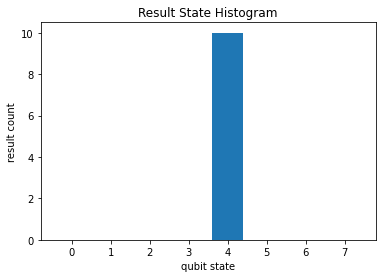

In [ ]:
# Run Simulation, Measure and Visualize
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results:', result) # 0: 00, 1: 01, 2: 10, 3: 11
_ = cirq.vis.plot_state_histogram(result, plt.subplot())
result.histogram(key="a")

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group). 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_122.png)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Quantum_Logic_Gates.png/500px-Quantum_Logic_Gates.png)

> If we use four qubits, for example, then there are 2^4=16 different states. Starting from |0000⟩, to |0001⟩, ending at |1111⟩. Each qubit can have a specific meaning. We could interpret it as a letter. A letter that does not have 26 different options but only two, |0⟩ and |1⟩. **With a sufficient number of qubits, we could represent all living humans. With 33 qubits, we can represent around 8.5 billion different states**. A phonebook of mankind. And we haven’t sorted it.

https://javafxpert.github.io/grok-bloch/

*Hadamard Gate (Superposition)*

> $H=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)$

**The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states** 

because they are a combination of the two computational states:

> $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$

**Apply Hadamard gate on a qubit that is in the |0> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

**Now apply Hadamard gate on a qubit that is in the |1> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{-1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

Hence, in both cases (qubit |0> or qubit |1>) applying a Hadamard Gate gives an equal chance for the qubit to be 0 or 1' when measured.

Source: https://freecontent.manning.com/all-about-hadamard-gates/


**Herleitung Hadamard (Wichtig!)**

For an equal (or uniform) superposition of the two computational states, we can set the two coefficients equal to each other:

$a_{1}=a_{2}=a$

The normalization condition for a well-behaved quantum state requires that the sum of the squared magnitudes of the coefficients be equal to one; this is sufficient to find 
a
a for a uniform superposition:

$|a|^{2}+|a|^{2}=1$

$2|a|^{2}=1$

$|a|^{2}=\frac{1}{2}$

$a=\frac{1}{\sqrt{2}}$

In vector form, this state can represented as

> $\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

This is what we can use now to understand Hadamard, where you want "halfway" a 50/50 chance of basis states 0 and 1 (Bloch sphere representation of superposition state):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_025.jpg)

*Hadamard gate operations:*

> $\begin{aligned} H(|0\rangle) &=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle=:|+\rangle \\ H(|1\rangle) &=\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle=:|-\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)+\frac{1}{2}(|0\rangle-|1\rangle)=|0\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)-\frac{1}{2}(|0\rangle-|1\rangle)=|1\rangle \end{aligned}$

One application of the Hadamard gate to either a 0 or 1 qubit will produce a quantum state that, if observed, **will be a 0 or 1 with equal probability** (as seen in the first two operations). This is exactly like flipping a fair coin in the standard probabilistic model of computation. However, if the Hadamard gate is applied twice in succession (as is effectively being done in the last two operations), then the final state is always the same as the initial state (because quantum operations are reversable, unlike operations on classical computers).

*Pauli-X Gate (Flip Computational States)*

> $X=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\sigma_{x}=\mathrm{NOT}$

* The Pauli- $X$ gate is the quantum equivalent of the [NOT gate](https://en.m.wikipedia.org/wiki/Inverter_(logic_gate)) for classical computers (its main function is to invert the input signal applied) with respect to the standard basis $|0\rangle,|1\rangle$, which distinguishes the $z$ axis on the Bloch sphere. It is sometimes called a bit-flip as it maps $|0\rangle$ to $|1\rangle$ and $|1\rangle$ to $|0\rangle .$ 

* The Pauli gates $(X, Y, Z)$ are the three Pauli matrices $\left(\sigma_{x}, \sigma_{y}, \sigma_{z}\right)$ and act on a single qubit. The Pauli $X_{1} Y$ and $Z$ equate, respectively, to a rotation around the $x, y$ and $z$ axes of the Bloch sphere by $\pi$ radians.

* Nice visualisations: https://medium.com/analytics-vidhya/quantum-gates-7fe83817b684



*Square Root of Pauli-X Gate*

The square root of NOT gate (or square root of Pauli- $X, \sqrt{X}$ ) acts on a single qubit. It maps the basis state $|0\rangle$ to $\frac{(1+i)|0\rangle+(1-i)|1\rangle}{2}$ and $|1\rangle$ to $\frac{(1-i)|0\rangle+(1+i)|1\rangle}{2} .$ 

In matrix form it is given by

>$
\sqrt{X}=\sqrt{\mathrm{NOT}}=\frac{1}{2}\left[\begin{array}{cc}
1+i & 1-i \\
1-i & 1+i
\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
e^{i \pi / 4} & e^{-i \pi / 4} \\
e^{-i \pi / 4} & e^{i \pi / 4}
\end{array}\right]$

such that

>$
(\sqrt{X})^{2}=(\sqrt{\mathrm{NOT}})^{2}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right]=X
$

> **This operation represents a rotation of $\pi / 2$ about $x$ -axis at the Bloch sphere**.

*Pauli-Y Gate (Phase Flip between i and -i)*

> $Y=\sigma_{y}=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right]$

* Similarly, the Pauli- $Y$ maps $|0\rangle$ to $i|1\rangle$ and $|1\rangle$ to $-i|0\rangle$ (NOT gate with i-multiple):


*Pauli-Z Gate ($\pi$ Flip Phase between +1 and -1)*

> $Z=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]=\sigma_{z}\quad Z=|0\rangle\langle 0|-| 1\rangle\langle 1|$

* Pauli Z gate is a phase flip gate that causes rotation around the z-axis by π radians. Z flippt zwischen den Polen der X Achse (+ und -).

* **Z Gate flippt zwischen den Hadamard gegenüberliegenden Richtungen auf der X-Achse. We change the phase (or sign) on a Qubit**:

> $\mathbf{Z}|0\rangle=|0\rangle$

> $\mathbf{Z}|1\rangle=-|1\rangle$

* Since |0⟩ and |1⟩ lie on the z-axis, the Z-gate will not affect these states. To put it in other terms **|0⟩ and |1⟩ are the two eigenstates of the Z-gate**. On the other hand, it flips |+⟩ to |-⟩ and |-⟩ to |+⟩.

* Pauli $Z$ leaves the basis state $|0\rangle$ unchanged and maps $|1\rangle$ to $-|1\rangle$. Due to this nature, it is sometimes called **phase-flip** (flips sign of second entangled state)

* **The Z gate is like the X gate but in the hadamard basis, flipping states**

*Pauli-S Gate: $\frac{\pi}{2}$ Flip Phase between Z and Y (with $\mu$=i and $\nu$=-i)*

> ${S}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & \sqrt{-1}\end{array}\right]=\sqrt{\mathbf{Z}}$

* The phase gate $\mathbf{Z}$ transforms $|+\rangle$ to $|-\rangle$, and we can find the gate that does "half of" this transformation by finding the square root of the matrix $\mathbf{Z}$

* fintuning Z gate in der Hadamard basis: S-gate is die Hälfte vom Z-Gate, und R-Gate ein viertel vom Z-Gate

* Use the matrix $\mathbf{S}$ to find the state $|\mu\rangle$ which is "halfway" between $|+\rangle$ and $|-\rangle$ :

> $\mathbf{S}|+\rangle=|\mu\rangle =\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

If you begin with $|+\rangle$ and apply the $\mathbf{S}$ gate three times in a row, you find a new state, $|\nu\rangle$ which appears to mirror the complex state $|\mu\rangle$ :

> $|\mu\rangle=\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

> $|\nu\rangle=\frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle) .$

*T Gate $\frac{\pi}{4}$ and R8 Gate $\frac{\pi}{8}$: Change Phase (Parametrizing it as continuous)*

*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

Calculate the algreba of T-gate applied:

$\mathbf{T}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$

First we have a qubit in state 0 and apply Hadamard:

$\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> $
H_{T}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$


We've already uncovered the gates we need to perform any rotations around the $x$ - and $z$-axes, which can bring us from an initialized qubit to any other quantum state.

Unfortunately, this result comes with a pretty serious caveat: all of the gates we have used so far are discrete. They perform rotations around the Bloch sphere, but since they rotate in discrete hops (of $\pi / 2$ or $\pi$ ), they are unable to reach most of the intermediate states on the surface of the sphere.

One solution to this problem is to define smaller and smaller rotations around these axes. The gate $\mathbf{S}$ is equal to $\sqrt{\mathbf{Z}}$ and halves its rotation angle from $\pi$ to $\pi / 2$. Even greater division of these gates is possible, and some of them have
common names:

$\mathbf{Z}=\mathbf{Z}=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]$ Rotation: $\pi$

$\mathbf{S}=\sqrt[2]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]$ Rotation: $\pi / 2$


$\mathbf{T}=\sqrt[4]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$ Rotation: $\pi / 4$

$\mathbf{R 8}=\sqrt[8]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 8}\end{array}\right] \quad$ Rotation: $\pi / 8 .$

*2 Qubits - Swap Gate (& Swap Square root): Swap two Qubits (like in Quantum Fourier Transform)*

The swap gate **swaps two qubits**. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\text { SWAP }=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

*Square root of swap gate*

The $\sqrt{\text { SWAP }}$ gate performs half-way of a two-qubit swap. 

It is universal such that any many-qubit gate can be constructed from only $\sqrt{\text { SWAP }}$ and single qubit gates. 

The $\sqrt{\text { SWAP }}$ gate is not, however maximally entangling; more than one application of it is required to produce a Bell state from product states. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\sqrt{\mathrm{SWAP}}=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{2}(1+i) & \frac{1}{2}(1-i) & 0 \\
0 & \frac{1}{2}(1-i) & \frac{1}{2}(1+i) & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

This gate arises naturally in systems that exploit exchange interaction.

v

*3 Qubits - Toffoli gate (CCNOT): Negate a target bit if both control qubits are 1*

TOFFOLI gate can be used to simulate standard boolean operations. It negates a target bit if both control qubits are 1.

> The Toffoli gate is essentially the atom of mathematics. It is the simplest element, from which every other problem-solving technique can be compiled.

* The [Toffoli gate](https://en.m.wikipedia.org/wiki/Toffoli_gate), named after Tommaso Toffoli; also called CCNOT gate or Deutsch gate $D(\pi / 2)$; is a 3-bit gate, which is universal for classical computation but not for quantum computation. 

* The quantum Toffoli gate is the same gate, defined for 3 qubits. If we limit ourselves to only accepting input qubits that are $|0\rangle$ and $|1\rangle$, then if the first two bits are in the state $|1\rangle$ it applies a Pauli- $X$ (or NOT) on the third bit, else it does nothing. 

* It is an example of a controlled gate. Since it is the quantum analog of a classical gate, it is completely specified by its truth table. The Toffoli gate is universal when combined with the single qubit Hadamard gate. $^{[13]}$

*3 Qubits - Fredkin Gate (CSWAP or CS): Swap identity gate for qubit 2+3, if qubit 1 is in state 1*

The Fredkin gate is a universal reversible 3-bit gate that swaps the last two bits if the first bit is 1; a controlled-swap operation.

The [Fredkin gate](https://en.m.wikipedia.org/wiki/Fredkin_gate) (also CSWAP or CS gate), named after Edward Fredkin, is a 3-bit gate that performs a controlled swap. It is universal for classical computation. 

It has the useful property that the numbers of 0s and 1s are conserved throughout, which in the billiard ball model means the same number of balls are output as input.

The basic Fredkin gate[1] is a controlled swap gate that maps three inputs (C, I1, I2) onto three outputs (C, O1, O2). The C input is mapped directly to the C output. 

If C = 0, no swap is performed; I1 maps to O1, and I2 maps to O2. 

Otherwise, the two outputs are swapped so that I1 maps to O2, and I2 maps to O1. 



###### *Quantum Fourier Transform*

> **Quantum Fourier Transform is the change from one basis (computational) to another (Fourier basis)**

* Quantum Fourier Transform is the inverse Discrete Fourier Transform)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_047.png)

**General formula**

* Remember: <font color="blue">$e^{2\pi i}$ = 1</font> (identity operation), and see why $e^{\pi i}$ = -1 in [this video](https://youtu.be/-AyE1Wpgo3Q) 


* In QFT we change the <font color="blue">$\theta$ = phase in $e^{2\pi i \theta}$</font> = Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩

* The phase $\theta$ is expressed as: <font color="blue">$\theta$ = $\frac{x_n}{2^{k_n}}$</font> with:

  * <font color="blue">$x_n$ = 0 or 1</font> state
  
  * <font color="blue">$k_n$</font> number of Qubits

* This is expressed in a so-called "controlled-R quantum gate" that **applies a relative phase change to |1>**

* The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i \frac{x_n}{ 2^{k_n}}}\end{array}\right)$</font>

*Quantum Fourier Transform with 3 Qubits: Introduction*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>, <font color="blue">$\tilde{x_2}$ = 0 or 1</font>, <font color="blue">$\tilde{x_3}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1, $k_2$ = 2, $k_3$ = 3</font>

> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^1}+\frac{x_{2}}{2^2}+\frac{x_{3}}{2^3}\right)}|1\rangle\right)$  = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* If only $\tilde{x_1}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_2}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If only $\tilde{x_3}$ is activated, then it is a 45° T-rotation of $\frac{\pi}{4}$ radians = between 1 and i

> <font color="blue">$\tilde{x_2}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^{k_1}}+\frac{x_3}{2^{k_2}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^1}+\frac{x_3}{2^2}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2}+\frac{x_3}{4}\right)}|1\rangle\right)$

* If only $\tilde{x_2}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_3}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If both $\tilde{x_2}$ and $\tilde{x_3}$ are activated, then it is a 180° + 90° = 170° rotation of $\pi + \frac{\pi}{2}$ radians = -i

> <font color="blue">$\tilde{x_3}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^1}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{\pi \mathrm{i}x_3}|1\rangle\right)$

* If $\tilde{x_3}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1


**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Here including the 8x8 matrix form for the complete operator:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0801.png)

In [ ]:
# This above mentioned operator would be multiplied with this (Ket) Quantum vector (tensor product of three individual qubit vectors):

from sympy import Matrix
import math
from sympy.physics.quantum import TensorProduct

m1 = Matrix([[1],[0]])
m2 = Matrix([[1],[0]])
m3 = Matrix([[1],[0]])

matrix = TensorProduct(m1, m2, m3)
matrix

Matrix([
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

*Quantum Fourier Transform with 1 Qubit*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1</font>


*Linear transformation of a qubit in the computational basis 0 and 1 each separately to the Fourier basis:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0813.png)

**Computational Basis in $|0\rangle$**

> <font color="blue">For $x_1$ = 0 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$  $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i} 0}$  = $\mathrm{e}^{0}$ = 1 (no rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0810.png)

**Computational Basis in $|1\rangle$**

> <font color="blue">For $x_1$ = 1 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$ $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}\right)}$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0811.png)

*Quantum Fourier Transform with 1 Qubit is a Hadamard transform!*

**One qubit QFT matrix**: $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & \mathrm{e}^{\pi i}\end{array}\right)$, where $\mathrm{e}^{\pi \mathrm{i}}$ = -1. So it is: <font color="blue"> QFT für x=1 = $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & -1\end{array}\right)$

**Compare with Hadamard transform matrix:** 

In quantum computing, the Hadamard gate is a one-qubit rotation, mapping the qubitbasis states $|0\rangle$ and $|1\rangle$ to two **superposition** states with **equal weight of the computational basis** states $|0\rangle$ and $|1\rangle$. Usually the phases are chosen so that

>$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> <font color="blue">$
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$

in the $|0\rangle,|1\rangle$ basis, also known as the computational basis. The states $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ are known as $|+\rangle$ and $|-\rangle$ respectively, and together constitute the polar basis in quantum computing.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_073.jpg)


**Why Hadamard transform is exactly a 1 qubit Quantum Fourier Transform:** (see result of + for 0 state and - for 1 state) - Matrix-Vector-Multiplication (Single Qubit)

> <font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

> <font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_045.png)

2 im denominator verschwindet hier. 2^n für n=1 qubit. mit 2 oben und unten verschwinden beide.

*Quantum Fourier Transform with 3 Qubits for $|001\rangle$*

**Computational Basis in $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0804.png)

**Fourier Basis for $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0805.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 0</font>, <font color="blue">$\tilde{x_2}$ = 0</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{0}{4}+\frac{1}{8}\right)}|1\rangle\right)$  = <font color="blue">$\frac{\pi i}{4}$</font> (45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = <font color="blue">$\frac{\pi i}{2}$</font> (90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is not activated because $x_2$ = 0:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Quantum Fourier Transform with 3 Qubits for $|111\rangle$*

**Computational Basis in $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0802.png)

**Fourier Basis for $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0803.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 1</font>, <font color="blue">$\tilde{x_2}$ = 1</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}+\frac{1}{8}\right)}|1\rangle\right)$ = $\mathrm{e}^{2 \pi i 0.875} = \mathrm{e}^{\pi i 1.75}$ (180° Z-rotation + 90° S-rotation + 45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = $e^{\pi i 1.5} =$ <font color="blue">$-i$</font> (180° Z-rotation + 90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Cirq Code for Quantum Fourier Transform*

*Compare the code above with the circuit activations below (how a circuits computes the results):* 

* $H$ gate = bring qubit in superposition. 

  * *For $x=0$, no further rotation*
  
  * *For $x=1$, then appy additional *$Z$ gate = 180° rotation = $\pi$**

* *$S$ gate = 90° rotation = $\frac{\pi}{2}$*

* *$T$ gate = 45° rotation = $\frac{\pi}{4}$*

$C R_{j}=C Z^{1 / 2^{j-1}}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse) 

* $S$ entspricht $\frac{\pi}{2}$, also wenn qubit 1 = 1, dann bei qubit 0 das $S$ transform anwenden (0,5)

  * S: The square root of Z gate, equivalent to cirq.Z ** 0.5

  * See: [Cirq Gates](https://quantumai.google/cirq/gates)

* $T$ entspricht $\frac{\pi}{4}$

In [ ]:
def make_qft(qubits):

    # Generate list of qubits
    qreg = list(qubits)
    
    # Make sure list is longer than 0 qubits:
    while len(qreg) > 0:
    
    # Remove first qubit from list and return its value (set as head-qubit):
        q_head = qreg.pop(0)
    
    # Apply Hadamard superposition to this head-qubit
        yield cirq.H(q_head)

    # Enumerate through list with i (index position) and corresponding qubit value (0 or 1)
        for i, qubit in enumerate(qreg):

    # Apply Controlled-Z * Theta-Phase-Shift on target ('q-head') if control-qubit ('qubit') is in state 1
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

    # Iterating through until "while len(qreg) = 0", then processes stops

"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(17)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0815.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Inverse Quantum Fourier Transform ('QFT Dagger' - Dagger is a complex conjugate operation!)*

Reminder of QFT:

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$

**Remember: Dagger is a complex conjugate operation!**

QFT inverse (see -2 turning i in -i which is a complex conjugate operation):

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ 


The operator is then (
We have already seen that the Hadamard gate is self-inverse, and the same is clearly true for the SWAP gate; the inverse of the rotations gate $R_k$ is given by):

> The matrix form of inverse QFT operator is: <font color="blue">${R^{\dagger}}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{-2 \pi i / 2^{k}}\end{array}\right)$</font> and compare with QFT operator:  <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

https://www.cl.cam.ac.uk/teaching/1920/QuantComp/Quantum_Computing_Lecture_9.pdf

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Syntax explanation for list(qubits)[::-1]: list[<start>:<stop>:<step>]
# So, when you do a[::-1], it starts from the end towards the first taking each element. 
# So it reverses a. This is applicable for lists/tuples as well.
# Example: >>> a = '1234' >>> a[::-1] will get you: '4321'

"""Build the last part of the circuit (inverse QFT) for phase estimation."""

# Do the inverse QFT as subroutine in quantum phase estimation
phase_estimator.append(make_qft_inverse(qubits[::-1]))


# Difference QFT and inverse QFT:
# yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)
# yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

###### *Quantum Phase Estimation*

**CNOT Gate and Phase Kickback** 

<font color="blue">*CNOT-Gate applied to the computational basis 0 and 1*

* https://qiskit.org/textbook/ch-gates/phase-kickback.html

* Main article about Phase Kickback: https://towardsdatascience.com/quantum-phase-kickback-bb83d976a448

The CNOT-gate is a two-qubit gate. Thus, it transforms qubit states whose state we represent by a four-dimensional vector.

>$
|\psi\rangle=\alpha|0\rangle|0\rangle+\beta|0\rangle|1\rangle+\gamma|1\rangle|0\rangle+\delta|1\rangle|1\rangle=\left[\begin{array}{c}
\alpha \\
\beta \\
\gamma \\
\delta
\end{array}\right]
$

Remember Vector-Vector-Multiplikation (Kronecker / tensor product):

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$. 

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ 

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

Accordingly, the CNOT-gate has a $4 \times 4$ transformation matrix.

>$
C N O T=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{array}\right]
$

There is no effect if the control qubit (at the left-hand position in the Dirac notation) is in state |0⟩, as in states |00⟩ and |01⟩.

> CNOT $\cdot|00\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=|00\rangle$

> CNOT $\cdot|01\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=|01\rangle$

<font color="blue">But if the control qubit is in state |1⟩, then the controlled (target) qubit switches from |0⟩ to |1⟩ and vice versa.</font>

> CNOT $\cdot|10\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=|11\rangle$

> CNOT $\cdot|11\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=|10\rangle$

When we describe the quantum states and operations in terms of mathematical formulae, we use the vectors |0⟩ and |1⟩ as a basis. |0⟩ and |1⟩ denote the standard or computational basis states. These states correspond to the possible measurements we might obtain when looking at the qubit. We measure a qubit in state |0⟩ as 0 with absolute certainty. And, we measure a qubit in state |1⟩ as 1, accordingly. While the basis {|0⟩,|1⟩} is convenient to work with mathematically, it is just a representation of the underlying physics.


<font color="blue">*CNOT-Gate applied to the superposition basis + and -*

The mathematical basis we chose leads to a specific representation of the CNOT-transformation. But this is not the only possible representation. In fact, there are infinitely many other possible choices. Our qubits are not limited to these two states. Qubits can be in a superposition of both states. For instance, there are the states that result from applying the Hadamard-gate on the basis states:

> $|+\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ and $|-\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}}\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

Now apply Hadamard gate on a qubit that is in the |1> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

Mathematically, the following matrix represents the application of Hadamard gates on each of the two qubits.

> $H \otimes H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}H & H \\ H & -H\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]$

So, if we apply this matrix on two qubits in state |00⟩, they end up in state |++⟩.

> $\begin{aligned} H \otimes H(|00\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

The input state |01⟩ results in state |+−⟩.

> $\begin{aligned} H \otimes H(|01\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|+-\rangle \end{aligned}$

The input state |10⟩ results in state |−+⟩.

> $\begin{aligned} H \otimes H(|10\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|-+\rangle \end{aligned}$

Finally, if we apply this transformation on two qubits in state |11⟩, we put them into state |−−⟩.

> $\begin{aligned} H \otimes H(|11\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

Now, let’s apply the CNOT-gate on qubits in superposition. We can calculate the overall transformation matrix by multiplying the matrices of the CNOT-gate and the H⊗H transformation. The CNOT-gate switches the second and fourth columns of the H⊗H-matrix.

> $\operatorname{CNOT}(H \otimes H)=\left[\begin{array}{cccc}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot \frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right]$

* And now, we apply this transformation to the four combinations of basis states.

<font color="blue">If the target qubit (at the right-hand side) is in state |1⟩, the state of the control qubit (at the left-hand side) flips from |+⟩ to |−⟩ and vice versa:

> 

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|00\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|01\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|10\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|-+\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|11\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|+-\rangle \end{aligned}$

In short, we can say:

> $\operatorname{CNOT}(|++\rangle)=|++\rangle$

> $\operatorname{CNOT}(|+-\rangle)=|--\rangle$

> $\operatorname{CNOT}(|-+\rangle)=|-+\rangle$

> $\operatorname{CNOT}(|--\rangle)=|+-\rangle$

The two states |+⟩ and |−⟩ have the same measurement probabilities of |0⟩ and |1⟩. They result in either value with a probability of 0.5. **So, the CNOT-gate does not have any directly measurable implications**. <font color="blue">However, the control qubit switches its phase. It takes on the phase of the controlled (target) qubit.</font>

> For the phase of the target qubit is kicked up to the control qubit, we call this phenomenon phase kickback.

We learned the CNOT-gate is not a one-sided operation. It clearly has the potential to affect the state of the control qubit. Even though the phase is not directly measurable, there are ways to exploit differences in the phase between states. In fact, prominent algorithms, such as Grover’s search algorithm, exploit this effect.


**Quantum Phase Estimation** 

* algorithm for determining the eigenvalues of a unitary operator

* the [quantum phase estimation algorithm](https://en.m.wikipedia.org/wiki/Quantum_phase_estimation_algorithm) (also referred to as quantum eigenvalue estimation algorithm), is a quantum algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator. 

* More precisely, given a unitary matrix $U$ and a quantum state $|\psi\rangle$ such that $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$, the algorithm estimates the value of $\theta$ with high probability within additive error $\varepsilon$, using $O(\log (1 / \varepsilon))$ qubits (without counting the ones used to encode the eigenvector state) and $O(1 / \varepsilon)$ controlled- $U$ operations. 

* The algorithm was initially introduced by Alexei Kitaev in 1995.

* Phase estimation is frequently used as a subroutine in other quantum algorithms, such as Shor's algorithm and the quantum algorithm for linear systems of equations.

<font color="blue">*One Qubit Phase Estimation (with Hadamard Gate):*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_117.png)

<font color="blue">*Multi-Qubit Phase Estimation (with inverse Quantum Fourier Transform):*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/a5/PhaseCircuit-crop.svg)

Remember in **Quantum Fourier Transform**: 


> x1 = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ 

* <font color="blue">$e^{2\pi i}$ = 1 = identity</font>

* In Quantum Fourier Transform we change the phase <font color="blue">$\theta$ in $e^{2\pi i}$</font> <font color="red">$^{\theta}$</font>

  * <font color="red">= Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩</font>

* Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

* A controlled-R quantum gate applies a relative phase change to |1>. The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

**Now in Phase Estimation**: 

> In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ mit dem Operator: $U^{2^n} = \phi$

Quantum phase estimation addresses the following problem:
* We have a $n$-qubit oracle function $U$, encoded in the form of a controlled- $U$ unitary.
* **$U$ has an eigenvalue $e^{2 \pi i \phi}$, associated with an eigenvector $|u\rangle$ which we can prepare.**
* <font color="red">**We wish to estimate the phase, $\phi$, of the eigenvalue to $t$ bits of precision.**

> <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$** $\quad$ (based on Eigenvalue equation)</font>

* Here $|\psi\rangle$ is an eigenvector / eigenstate and $e^{2 \pi i \theta}$ is the corresponding eigenvalue. 

* <font color="red">For example: the eigenvalues of X are −1 and 1 and have the eigenvectors |−⟩ and |+⟩ respectively.*</font>

*Since $U$ is unitary, all of its eigenvalues have a norm of 1.*

Reminder: QFT

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_084.png)

>**See below: <font color="red">Remember that a unitary matrix has eigenvalues of the form $e^{i \theta_{\psi}}$ (ohne $2 \pi$ wie oben bei QFT) and that it has eigenvectors that form an orthonormal basis**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_083.png)

The problem: in both cases the probability is 0,5, just differs by the phase added: $=e^{\frac{i \pi}{2}}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_078.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_079.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_080.png)

**The probability of measuring 0 and 1 is each 0,5, but there is a small factor that makes them differ from 0,5, depending on the phase (angle):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

> **In the different between the probability of measuring 0 or 1, you've encoded that phase! (In other words: you've taken that phase information and turned it into and amplitude that you can measure.**

* How to do this experimentally: you do a million shots of the experiment, collect statistics and check what the statistics say. How many times did I get zero? How many times did I get one? The hope is that the difference between the statistics of zero and one would allow us to back out theta

* Next level: now getting more precision with more qubits: (there is another circuit to prepare Psi yet, which is assumed to be given here)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_082.png)

writing out the calculation:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_085.png)

**Comparing QPE with QFT (QPE is the same as QFT with a different phase):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_086.png)

It's like applying a QFT of something (of a special phase $\frac{\theta_{\psi}}{2^{n}} 2 \pi$, the green box above!), and in order to get back to the original state you need to apply an inverse QFT at the end:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_087.png)

*Step 1: Set up the unitary and number of bits to use in phase estimation*

<font color="blue">*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

We first perform a Hadamard gate on the first qubit to get the state 

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$
  
  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =
  
  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

  * <font color="blue">this part above is the rule from tensor products: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition: $\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$
</font>

    * The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states because they are a combination of the two computational states:

    * State: $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$ so for + it is: $|\+\rangle=\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

  * we have intentionally omitted the normalization factor of 1/√2 for clarity

> $|+\rangle \otimes|\psi\rangle = \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}\psi\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \, [\psi] \\ 1 \, [\psi]\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $|+\rangle$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$ =  $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [ ]:
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.125

# Define the unitary U-Gate:
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

Here details about unitary U-Gate: 

$U$ = $Z^{2^{n-n}}$ 

Z = $e^{\pi}$ 

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse) 


then:

> <font color="blue">$U$ = $e^{\pi * 2^{n-n}}$


*Step 2: Build the first part of the circuit for phase estimation with controlled U-gate (Phase Kickback)*

We then perform a controlled U operation, which we have written as $U^{2^0}$. Here applies the **Phase Kickback!**

  * $|0\rangle|\psi\rangle+|1\rangle$ <font color="red">$U$</font> $|\psi\rangle$ =

  * $|0\rangle|\psi\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle|\psi\rangle$ =

  * $|0\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle) \otimes|\psi\rangle$

* Here are 2 things very important: 
  
    * The second qubit register containing |ψ⟩ hasn’t changed. We shouldn’t expect it to, **since |ψ⟩ is an eigenstate of U (Remember: <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$ based on the Eigenvalue equation**</font>). Thus, no matter how many times we apply U to this register, nothing happens to |ψ⟩**. But if we apply it more often it will 'amplify' the phase (Not in the sense of amplitude amplification) - we amplify it with adding more qubits and hence more $\phi$ to get more precision
    
    * what’s the point of applying U then? The effect was that **it wrote some information about the eigenvalue into the relative phase of the first qubit**. Namely, the entire effect was to
map: $|0\rangle+|1\rangle \mapsto|0\rangle+e^{2 \pi i 0. \phi_{1}}|1\rangle$

In [ ]:
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

# Set the input state of the eigenvalue register: Add gate to change initial state to |1>
phase_estimator.insert(0, cirq.X(u_bit))

# bit = cirq.LineQubit
for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))
    # explanation: U-rot control aktiviert wenn entsprechendes qubit in state 1 (??)
    # dann aktiviere formel: U^2^(n-1) ...U^2^(n-2) ...U^2^(n-n)

print(phase_estimator)

0: ───H───@───────────
          │
1: ───H───┼───@───────
          │   │
2: ───H───┼───┼───@───
          │   │   │
u: ───X───Z───S───T───


> <font color="blue">$U$ = $Z^{2^{n-n}}$ = $e^{\pi * 2^{n-n}}$ fur das erste Gate: = $e^{\pi * (-0.128)}$ ????


*Why are we adding Pauli-X? The initial state for u_bit is the  state, but the phase for this state is trivial with the operator we chose. Inserting a Pauli  operator at the begining of the circuit changes this to the  state, which has the nontrivial  phase.*

*The controlled u gate*:

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

**When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**. 
Sometimes this is shortened to just CX, CY and CZ.

<font color="blue">*Why should we use more than one control Qubit?*

**Remember from Eigenvalue problem: Ax = λx in our case with the unitary operator: Ux = λx**

> $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$

> Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* Since |λ| = 1, we can write it without loss of generality as λ = $e^{2πiφ}$, where <font color="red">$e^{2πi}$ = 1 (= identity, if you insert 2*π*i into exponent at random, you will not change the result. Sometimes it can be a useful identity [Source](https://www.physicsforums.com/threads/e-2-pi-i-where-from.430393/), from Euler identity)</font> and **0 ≤ φ ≤ 1 is called the phase. This is what we want to estimate!**

* We saw that in QFT, φ being between 0 and 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}$

> **The term “estimation” comes about not from the fact that quantum computation is probabilistic, but rather in the degree of precision that we are going to compute, or estimate, the phase to.**

* The phase φ is going to be between zero and one, so we can write it as a decimal in binary notation as follows: $φ = 0.φ_1 φ_2 ···φ_n$, where each φi is either zero or one

  * The expression $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n}$ is equivalent to $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n} \Longleftrightarrow \phi=\sum_{k=1}^{n} \phi_{k} 2^{-k}$. Some numbers as binary decimals: 
  
    * <font color="blue">The number 0.5 in decimal is 0.1 in binary, since 0.1 ≡ (1) · $2^{−1}$ = 1/2 = 0.5. So: $0.5_{10} = 0.1_2$. Note that 0.1 is the same as 0.100000....</font>

    * <font color="blue">The number 0.75 in decimal is 0.11 in binary, since 0.11 ≡ (1)·$2^{−1}$ +1·$2^{−2}$ = 1/2+1/4 = 3/4 = 0.75. To get this we need 2 Qubits. So we get more precision with more qubits</font>

    * 0.111 = 0.875

    * 0.1111 = 0.9375 in decimal, because: $0 \cdot 2^{0}+1 \cdot 2^{-1}+1 \cdot 2^{-2}+1 \cdot 2^{-3}+1 \cdot 2^{-4}=0 \cdot 1+1 \cdot 0.5+1 \cdot 0.25+1 \cdot 0.125+1 \cdot 0.0625=0+0.5+0.25+0.125+0.0625=0.937510$

  * Check also what is the value of the infinitely repeating binary decimal 0.1111111...
  
  * If it needed to be proved, the above exercise proves that 0 ≤ 0.φ1φ2 · · · ≤ 1


*Operator $U^{2^n}$ in QPE*

* $U^{2^0}$: 1 (decimal) = 00001

* $U^{2^1}$: 2 (decimal) = 00010

* $U^{2^2}$: 4 (decimal) = 00100

* $U^{2^3}$: 8 (decimal) = 01000

* $U^{2^4}$: 16 (decimal) = 10000


**So for falls die Phase 0.111 ist, wuerde bei 3 Qubits QPE berechnen:**

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

  * $2^0$ = 1 in decimal = 001 in binary

  * $2^1$ = 2 in decimal = 010 in binary

  * $2^2$ = 4 in decimal = 100 in binary

* in this case the phase $\theta$ = 0.111


**Compare that with Quantum Fourier Transform:**

* In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ 

* Let's say all $x_1, x_2$ and $x_3$ = 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{{1}}{2}+\frac{1}{4}+\frac{1}{8}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i}(0.5+0.25+0.125)}$ and in binary form: <font color="red">$\mathrm{e}^{2 \pi \mathrm{i}(0.100+0.010+0.001)}$</font>

* **We see that in QFT and QPE it's the same (both in red)!**

<font color="red">Jedes $U^{2^n}$ wird immer dann aktiviert, wenn im Control-Qubit oben eine 1 gemessen wird (siehe Bild hier unten):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_118.png)

*Step 3: Perform the inverse QFT on the estimation qubits and measure them*


How can we read out this information from the quantum state? Consider the effect of applying another Hadamard transformation on the first qubit (without another H we will always measure 50/50 % a 0 or 1), which will produce (ignoring the normalization factor of 1/2): 

  * $H(|0\rangle+$ <font color="red">$e^{2 \pi i 0 \cdot \phi_{1}}$</font> $|1\rangle)=$ $(1+$<font color="red">$e^{2 \pi i 0. \phi_{1}}$</font>$)|0\rangle$ + $(1-$<font color="red">$e^{2 \pi i 0 . \phi_{1}}$</font>$)|1\rangle$

  * this shares the phase with the first Qubit and allows us to read it out

  * Now, $\phi_{1}$ can only be zero or one. In the case that $\phi_{1}=0, e^{2 \pi i 0 . \phi_{1}}=1$, hence the state is exactly $|0\rangle$: $(\frac{1}{2}\left(1+e^{2 \pi i 0 . 0}\right)|0\rangle+\frac{1}{2}\left(1-e^{2 \pi i 0 . 0}\right)|1\rangle$ = $\frac{1}{2}\left(1+1\right)|0\rangle+\frac{1}{2}\left(1-1\right)|1\rangle$ = $|0\rangle$

  * these values in front of $|0\rangle$ and $|1\rangle$ are probabilities (here 0 has probability of being measured = 1, but small differences her reveal the phase and hence the Eigenvalue in other cases. See here:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

* **For 1 Qubit we can use a Hadamard Gate, and for more than 1 Qubit we use the inverse Fourier Transform**: on Quantum Phase Estimation $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ then the inverse Quantum Fourier transform:  <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font> so that: $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font>

  * inverse QFT for 1 Qubit is: $ \frac{1}{2^{\frac{1}{2}}} \sum_{x=0}^{2^{1}-1} e^{\frac{-2 \pi i k x}{2^{1}}}|x\rangle$ = $\frac{1}{\sqrt{2}} e^{-1 \pi i k x}$ fur $k$ = $\varphi$ = 0 and $x$ = 0. --> somehting is not right here yet!

Thus, we measure with certainty (i.e., not probabilistically) a state that tells us exactly what the phase,
and hence the eigenvalue, is.

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Do the inverse QFT
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

                           ┌────────┐
0: ───H───@───H───@─────────@────────────────────────M('m')───
          │       │         │                        │
1: ───H───┼───@───@^-0.5────┼──────H────@────────────M────────
          │   │             │           │            │
2: ───H───┼───┼───@─────────@^-0.25─────@^-0.5───H───M────────
          │   │   │
u: ───X───Z───S───T───────────────────────────────────────────
                           └────────┘


In [ ]:
# Syntax explanation for list(qubits)[::-1]: list[<start>:<stop>:<step>]
# So, when you do a[::-1], it starts from the end towards the first taking each element. 
# So it reverses a. This is applicable for lists/tuples as well.
# Example: >>> a = '1234' >>> a[::-1] will get you: '4321'

*Step 4: Simulate the circuit and convert from measured bit values to estimated θ values*

In [ ]:
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


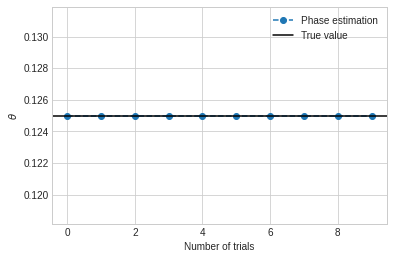

In [ ]:
"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(theta_estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of trials")
plt.ylabel(r"$\theta$");

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

In [ ]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

print(theta_estimates)
print(estimates)

"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

*Step 5: Compute the Eigenvalues from the theta value*

Eigenvalue: $e^{2 \pi i \theta}$ is the corresponding eigenvalue, so for $\theta$ = 0.125 $\rightarrow$ $e^{2 * \pi * i * 0.125}$ = <font color="blue">0.707106781 + 0.707106781 i (Eigenvalue of T-gate)</font>

* Verification: $
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$ $\rightarrow$ <font color="blue">$e^{\frac{i \pi}{4}}$ is the same as $e^{2 * \pi * i * 0.125}$ bzw. $e^{\frac{2 * \pi * i}{8}}$</font>

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

* ps: $e^{2 \pi i}$ =  1 (identity) - ohne theta, die phase

* From Eigenvalue euqation: $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$. Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* https://quantumcomputing.stackexchange.com/questions/9577/how-to-find-eigenvalues-and-eigenvector-for-a-quantum-gate


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_115.png)


###### *Shor's Algorithm*

**Classical Calculation**

* <font color="blue">Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

* all we need to do is find this nontrivial squareroot of unity, and we can factor whatever number we need. As promised, we can do this with period finding, specifically by computing the order of a random integer

* The order of some integer x modulo N is the smallest integer r such that $x^r$ = 1 mod N

*Modular Arithmetic*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_088.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_089.jpg)

**<font color="blue">Step 1: Pick coprime of N**

*Drei mögliche Verfahren zur Berechnung des ggT :*

Erstes Verfahren: Euklidischer Algorithmus 
* 15	:	13	  = 	1	  Rest  	2.	  Also ist ggT (15,13)= ggT (13,2)
* 13	:	2	  = 	6	  Rest  	1.	  Also ist ggT (13,2)= ggT (2,1)
* 2	:	1	  = 	2	  Rest  	0.	  Also ist ggT (2,1)= ggT (1,0)
* Ergebnis: Der ggT von 15 und 13 ist 1.

Zweites Verfahren: Vergleichen der Teilermengen .
* Die Teilermenge von 15 lautet: {1,3,5,15}.
* Die Teilermenge von 13 lautet: {1,13}.
* Die größte in beiden Teilermengen vorkommende Zahl ist 1. Also ist 1 der ggT von 15 und 13. 

Dritte Möglichkeit: Vergleichen der Primfaktorzerlegung
* Die Primfaktorzerlegung von 15 lautet: 15= 3·5.
* Die Primfaktorzerlegung von 13 lautet: 13= 13.
* Die gemeinsamen Primfaktoren sind: 1.
* Also ist 1 der ggT.

*Modulo (kurz: mod) berechnet den Rest einer Division zweier Zahlen. In Mathematischen Formeln wird modulo mit mod abgekürzt, beispielsweise: 23 mod 8 = 7. Bei dieser Rechnung kommt 7 heraus, weil die 8 zweimal in die 23 passt und dann 7 übrig bleiben.*

In [ ]:
# Product of two prime numbers (to check later if result is correct)
N=5 * 3

# Pick coprime (!) number to N to factorize N into primes
a=13

# Code Example to understand periodicity in the context of factoring prime numbers:

import math
# Compute greated common divisor between a and N
math.gcd(a, N)

1

**<font color="blue">Step 2: Find the period of $a^r$ $\equiv$ 1 $(modN)$:**

* <font color="blue">the order of x is just the period of the function f(i) = $x^i$ mod N. 

* <font color="blue">In quantum computing you use QFT in order to determine the period !!

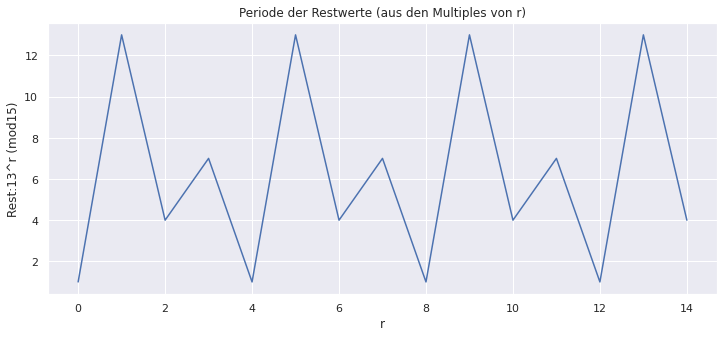

In [ ]:
import matplotlib. pyplot as plotter
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.5})

r = list(range(N))
y= [a**r0 % N for r0 in r]

plotter.plot (r, y)
plotter.xlabel('r')
plotter.ylabel('Rest:' f'{a}^r (mod{N})')
plotter.title('Periode der Restwerte (aus den Multiples von r)')
plotter.show()

<font color="red">**Beispiel: Choose any number $a$ and takes its multiple $r$ so many times, until the rest in modulo is 1, (except r=0)**</font>

> $13^0$ (mod 15) = 1 (mod 15) = 1

> $13^1$ (mod 15) = 13 

> $13^2$ (mod 15) = 169 (mod 15) = 4

* <font color="blue">*Erlauterung: Nimm 15 * 11 = 165, bis zur 169 verbleibt ein Rest 4*

> $13^3$ (mod 15) = 2197 (mod 15) = 7 

* <font color="blue">*Erlauterung: Nimm 15 * 146 = 2190, bis zur 2197 verbleibt ein Rest 7*

> $13^4$ (mod 15) = 28561 (mod 15) = 1 (<font color="blue"><u>hier started die Periode wieder, that's the r we are looking for!</u>)

> usw..

In [ ]:
r= r[y[1:].index(1)+1]
print(f'r = {r}')

r = 4


**<font color="blue">Step 3: Bestimme $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$**. Mindestens einer der beiden Primfaktoren von N={p,q} is beinhalted in gcd(x+1, N) bzw. gcd(x-1, N)

*In this case with a=13, N=15 and r=4:*

* $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$

* $x \equiv 13^{\frac{4}{2}}(\operatorname{mod} 15)$

* x = 169 (mod 15) = 4

  * gcd(x-1, N) = 3 = p

  * gcd(x+1, N) = 5 = q

Achtung: in einem anderen Beispiel: N=11*7 (Primzahlen), a=18, ergibt x=43. 

* Davon x-1=42 und x+1=44. 
* Das sind naturlich keine Primzahlen, 
* Aber deren Faktoren sind: 44 = 2 * 2 * 11 und 42 = 2 * 3 * 7
* das heisst, x-1 und x+1 kann auch die Primzahlen indirekt enthalten!

In [ ]:
if r % 2 == 0:
  x = (a**(r/2.)) % N
  print(f'x = {x}')
  if ((x + 1) % N) != 0:
    print(math.gcd((int(x)+1), N), math.gcd((int(x)-1), N))
  else:
      print ("x + 1 is 0 (mod N)")
else:
  print (f'r = {r} is odd')

x = 4.0
5 3


**Shor's Algorithm**

* When finding order using the period finding algorithm, it is important to use enough qubits. A sensible rule is that you need to use m qubits so that $2^m$ >> $N^2$, where N is the number we are trying to factor, because the order of a random number might be as large as N

* Example: Lets factor N=119. Suppose we pick the number 16 to start with. Wie viele Qubits m sollten wir mindestens nehmen? $N^2$ = $119^2$ =14.161 und $2^m$ muss deutlich grosser sein, also mindestens = $2^{14}$ = 16.384. Wir brauchen also mindestens 14 Qubits, um 119 zu faktorisieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_090.jpg)

* Because we know that the order of x will be even and $x^{s/2}$ will be a nontrivial square root with probability at least 1/2, we can be confident that we will be able to factor N in just a few runs of the algorithm. Because the time it takes to find the period grows as a polynomial in the number of bits, and the number of bits grows like 2logN(by the above requirement), we expect the time it takes to factor N to grow as a polynomial in logN.

* Here is the circuit for Shor’s Algorithm. It relies heavily on period finding, and so the circuit looks a lot like the circuit for period finding. The key difference is that we are finding the period of f(i) = xi, and the number of bits we need to input is very large.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_091.jpg)

**How does it work in the quantum circuit?**

That's the function in $U$: given an $x$, the $U$ will compute:

> $f_{a, N}(x) \equiv a^{x}(\bmod N)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_092.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_093.png)

**<font color="blue">Shor's Algorithm: Step by Step**

**Beispiel: a=13 und N=15, was macht Shor's Algorithm genau im Circuit an der Stelle $U_{f_{(a,N)}}$ und $QFT^{\dagger}$?**

ps: a muss ein Coprime von N sein. Wenn es kein Coprime ist, muessen wir nicht durch Shor's Algorithm gehen, weil a dann einen Faktor mit N teilt :) Aber es ist very unlikely to find a coprime of a large number N.

**First let's divide it into steps. 1-5:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

**Step 1**: Get Qubits in state 0 and apply Hadamard Superposition

We start with 4 Qubits all in zeros, mit den Registers x und w, und jedes 4 Mal Tensorproduct multipliziert, weil wir 4 Qubits haben: 

> $|0\rangle_{x}^{\otimes 4}$ $|0\rangle_{w}^{\otimes 4}$

All Hamadard Gates are applied to top 4 Qubits (x register), and right part (w register) gets nothing applied to it:

> $[H^{\otimes 4}|0\rangle] \,\, |0\rangle^{\otimes^{4}}$

> = $\frac{1}{4}[|0\rangle+|1\rangle+|2\rangle+\cdots+|15\rangle]$ $|0\rangle$

* Reminder 1: Multiplikation mit $\frac{1}{4}$, weil 4 Qubits in Hadamard-Superposition

* Reminder 2: this is the 4 bit representation of the decimal number, so for example 15 in binary = 1111. Daher kann man auch die 4 angeben als Erinnerung der Bit representation:

> = $\frac{1}{4}[|0\rangle_4+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $|0\rangle_4$


**Step 2**: Compute $U$ with $f_{a, N}(x) \equiv a^{x}(\bmod N)$ - Was passiert genau in der Box mit $U_{f_{(a,N)}}$?

**Given an $x$, the $U$ will compute: <font color="red">$f_{a, N}(x) \equiv a^{x}(\bmod N)$</font>**

Schauen wir nochmal im vorherigen Schritt und markieren eine Komponente:

> = $\frac{1}{4}[$ <font color="red">$|0\rangle_4$</font> $+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $\,$ $|0\rangle_4$

<font color="red">$U_{f_{(a,N)}}$</font> macht dann folgendes:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|  0 \bigoplus 13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left|0 \bigoplus 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left|0 \bigoplus 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left|0 \bigoplus 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]

Remember: $\bigoplus$ means "addition modular 2" bzw. "XOR". Anything XORs with 0, is thing itself: 0 $\bigoplus$ Z = Z. damit ergibt sich folgende Rechnung:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|   13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left| 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left| 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left| 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]


Aus der Modulo-Rechnung ergeben sich die Restwerte:

* <font color="red">$13^{0}(\bmod 15)$ = 1</font>

* $13^{1}(\bmod 15)$ = 13

* $13^{2}(\bmod 15)$ = 4

* $13^{3}(\bmod 15)$ = 7

* $13^{4}(\bmod 15)$ = 1

* usw..

Since it's periodic, it will repeat, with the x and w register:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\,\left|1\right\rangle_{4}$</font> + $|1\rangle_{4}\left|13\right\rangle_{4}$ + $|2\rangle_{4}\left|4\right\rangle_{4}$ + $|3\rangle_{4}\left|7\right\rangle_{4}$ etc..]

Hier nochmal untereinander mit denselben Restwerten zur besseren Visualisierung:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_094.png)

**Step 3: Measurement of the w register / bottom 4 Qubits**

* the outputs of the w-register measurements are either 1, 13, 4 or 7 (die Restwerte) with equal probability

* let's say we measure 7, what happens to x? X becomes either 3, 7, 11 or 15 (the value in front of the qubit with 7!) with equal probability:

  * after $|\omega\rangle$ = $|7\rangle_4$ , $|x\rangle$ becomes:

  * <font color="blue">$|x\rangle$ $|\omega\rangle$ = $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$ $\otimes |7\rangle_4$

  * Normalization has changed: before we had 16 combinations mit 1/4, here we have only 4 combinations with 1/2 (=one over square root of 4)

* **For the next step 4, the Restwert doesn't matter anymore, here: $\otimes |7\rangle_4$. We can ignore it. Because it step 4 we apply the measured $|x\rangle$ in the $QFT^{\dagger}$, and don't care about $|\omega\rangle$ anymore**. And $|x\rangle$ is in this case: $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

**Step 4**: Apply inverse $QFT^{\dagger}$ on the $|x\rangle$ register

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$ (Reminder!)

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ (see -2 turning i in -i which is a complex conjugate operation)

* We want to know what QFT dagger is doing to (it is $\frac{1}{\sqrt{16}}$ because we have 4 Qubits)

  * $QFT^{\dagger}|3\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 3 y}{16}}|y\rangle$

  * $QFT^{\dagger}|7\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 7 y}{16}}|y\rangle$

  * $QFT^{\dagger}|11\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 11 y}{16}}|y\rangle$

  * $QFT^{\dagger}|15\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 15 y}{16}}|y\rangle$

Alltogether:

  * $QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}} \sum_{y=0}^{15}$ [ $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$] $|y\rangle$

    * with: $e^{-i\frac{ 3 \pi}{8}y}$ = $\cos \left(\frac{3 \pi}{8} y\right)-i \sin \left(\frac{3 \pi}{8} y\right)$ (und aquivalent fur alle anderen drei)

    * siehe coding rechnung unten was genau passiert hier!
  
  * <font color="blue">$QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}}$ [ $4|0\rangle_4$ + $4i|4\rangle_4$ $-4|8\rangle_4$ $-4i|12\rangle_4$ ]</font>
  
  * Remember we had a sum before: $\frac{1}{{8}} \sum_{y=0}^{15}$. And notice how all the other terms now vanished to zero, because you had equal contributions of plus and minus.

    * **This is exactly what it means when people tell you that quantum computers take advantage of interference!! = when a lot of the terms vanish, and the answer only converges to the terms that we care about.**

    * here is the calculation what happened, you see many zeros:

<font color="red">Hier Beispielrechnung fur y=1, um vanishing components zu verstehen</font>. Unten im Code die Ergebnisse, zum Beispiel fur y=1 als Ergebnis = 0, $QFT^{\dagger}|x\rangle$ fur y = 1: 
    
  * $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$ =
    
  * $e^{-i\frac{ 3 \pi}{8}1}$ + $e^{-i\frac{ 7 \pi}{8}1}$ + $e^{-i\frac{ 11 \pi}{8}1}$ + $e^{-i\frac{ 15 \pi}{8}1}$ =

    * $e^{-i\frac{ 3 \pi}{8}1}$ = <font color="green">0,382683432 - 0,923879533 i</font>

    * $e^{-i\frac{ 7 \pi}{8}1}$ = <font color="orange">-0,923879533 - 0,382683432 i</font>

    * $e^{-i\frac{ 11 \pi}{8}1}$ = <font color="green">-0,382683432 + 0,923879533 i</font>

    * $e^{-i\frac{ 15 \pi}{8}1}$ = <font color="orange">0,923879533 + 0,382683432 i</font>

  * Wie man sieht canceln sich die Terme aus (in gleicher Farbe), weshalb als Ergebnis fur y=1 Null entsteht.

In [ ]:
# Hier Beispiel fur y=1 und den ersten e-Term:
y = 1
pi = np.pi
coeff = np.exp(-1j*3*pi/8 * y)
if abs(coeff) < 1e-10: coeff= 0
print(y, coeff)

1 (0.38268343236508984-0.9238795325112867j)


In [ ]:
# Hier die komplette Rechnung fur alle y und alle 4 e-Terme:
import numpy as np

pi = np.pi
for y in range (15) :
  coeff = np.exp(-1j*3*pi/8 * y) + \
          np.exp(-1j*7*pi/8 * y) + \
          np.exp(-1j*11*pi/8* y) + \
          np.exp(-1j*15*pi/8* y)
  if abs(coeff) < 1e-10: coeff= 0
  print(y, coeff)

0 (4+0j)
1 0
2 0
3 0
4 (-5.757077917265737e-15+4j)
5 0
6 0
7 0
8 (-4-1.1514155834531474e-14j)
9 0
10 0
11 0
12 (2.2600304269997962e-14-4j)
13 0
14 0


**Step 5: Measure the |x> register**

* You get either 0 or 4 or 8 or 12 with equal probability

* Remaining steps are classical post-processing

* You can already see the periodicity in the result: the difference is always 4

* Analyse what happens for each outcome: **The measurement results peak near $j\frac{N}{r}$ for same integer j $\in Z$. And r is the period that we are looking for. N = $2^n$ Qubits!**

  * if we measure |4>$_4$: $j\frac{16}{r}$ = 4, true if j=1 and r=4

  * there are multiple values that would work, but this is the lowest one

* now check our protocoll for r=4:

  * Is r even? yes!

  * $x \equiv a^{r / 2}(\bmod N)$ = $13^{4 / 2}(\bmod 15)$ = 4

  * x+1 = 5 and x-1 = 3

* This looks good, now check:

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(5,15)=5$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(3,15)=3$

What do you do if r = 8 ?

* |8>$_4$: $j\frac{16}{r}$ = 8, true if j=1 and r=2 AND j=2 and r=4

* if r=4 we are back in the case before

* if r=2 then $x \equiv a^{r / 2}(\bmod N)$ = $13^{2 / 2}(\bmod 15)$ = 2, which brings x+1 = 3 and x-1 = 1

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(3,15)=3$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(1,15)=1$

* This leads you to a partial solution. Now you can back out the other solution, with checking 3 divides into 15

* If we get r=0, then we need to do the experiment again

Hier die Faktorisierungsergebnisse fur verschiedene QC-Ausgaben r. Mit r=0 geht es nicht, also kann man in 3 von 4 Faellen faktorisieren (und mit r=8 bekommt man eine partial solution, kann aber immer noch faktorisieren).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_097.png)

Aus dem 2001 Paper von IBM, Faktorisierung von 15 auf einem Quantum Computer:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_096.png)

**Appendix: What is the Gate structure in $U$?**

* $a^{x_1}$, $a^{x_2}$, $a^{x_n}$ tells you this is a controlled operation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_098.png)

* look now how the exponent doesn't contain $x_1$, $x_2$, .. $x_n$ anymore

* this is done by implementing it by doing these controls

* this is exactly like quantum phase estimation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_099.png)

**Der linke Term stammt aus QPE, der rechte Term ist der Teil $U$ aus Shor's Algorithms:**

> <font color="blue">$U^{2^{x}}=a^{2^{x}}(\bmod N)$</font>

continue: https://youtu.be/IFmkzWF-S2k?t=1181

###### *Grover Search*

> **[Grover’s algorithm](https://en.m.wikipedia.org/wiki/Grover's_algorithm) teaches us how we can search for an item in an unsorted list without needing to look at each item one by one but by looking at them all at once.**

It accomplishes that using two techniques:

  * First, it uses a quantum oracle to mark the searched state. 
  
  * Second, it uses a diffuser that amplifies the amplitude of the marked state to increase its measurement probability.

Grover's Algorithm : Suche in grossen Datenbanken (Squared speedup: get result in the square root of time that on classical computers)

* Auf einem klassischen Computer ist der prinzipiell schnellstmögliche Suchalgorithmus in einer unsortierten Datenbank die [lineare Suche](https://de.m.wikipedia.org/wiki/Lineare_Suche), die ${\mathcal {O}}\left(N\right)$ Rechenschritte erfordert (Der Suchaufwand wächst linear mit der Anzahl der Elemente in der Liste.)

* Die effizientere [Binäre Suche](https://de.m.wikipedia.org/wiki/Binäre_Suche) kann nur bei geordneten Listen benutzt werden. Die Binäre Suche ist deutlich schneller als die lineare Suche, welche allerdings den Vorteil hat, auch in unsortierten Feldern zu funktionieren. In Spezialfällen kann die [Interpolationssuche](https://de.m.wikipedia.org/wiki/Interpolationssuche) schneller sein als die binäre Suche.

* Makes use of Amplitude Amplification, Quantum Walk & Quantum Counting

> Grover's Algorithm uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states (=Phase Flip of Desired Outcome + Probability Amplitudes Inversion about the Mean to Amplify)

Grover’s algorithm solves oracles that **add a negative phase to the solution states**. I.e. for any state |x⟩ in the computational basis:

> $U_{\omega}|x\rangle=\left\{\begin{aligned}|x\rangle & \text { if } x \neq \omega \\-|x\rangle & \text { if } x=\omega \end{aligned}\right.$

We create a function $f$ that takes a proposed solution $x$, and returns 

* $f(x)=0$ if $x$ is not a solution ( $x \neq \omega)$ 

* $f(x)=1$ for a valid solution $(x=\omega)$.

The oracle can then be described as:

> $U_{\omega}|x\rangle=(-1)^{f(x)}|x\rangle$

* you can see this is an Eigenvalue equation

The oracle's matrix will be a diagonal matrix of the form:

> $U_{\omega}=\left[\begin{array}{cccc}(-1)^{f(0)} & 0 & \cdots & 0 \\ 0 & (-1)^{f(1)} & \cdots & 0 \\ \vdots & 0 & \ddots & \vdots \\ 0 & 0 & \cdots & (-1)^{f\left(2^{n}-1\right)}\end{array}\right]$

*Source: https://qiskit.org/textbook/ch-algorithms/grover.html*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_105.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_106.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_107.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_108.jpg)

*Step 1: Hadamard-Operator for Superposition + Assign a Phase -1 to the desired outcome*

Start with a balanced superposition, and assign a phase of -1 to the chosen ket, 111). Assigning -1 means applying a Pauli-Z-operator in the superposition to this one !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_102.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_101.jpg)

**<font color="blue">More about Amplitude Amplification**

* [Amplitude amplification](https://en.m.wikipedia.org/wiki/Amplitude_amplification) is a technique in quantum computing which **generalizes the idea behind the Grover's search algorithm**, and gives rise to a family of quantum algorithms.

* In a quantum computer, amplitude amplification can be used to **obtain a quadratic speedup over several classical algorithms**.

1. If there are $G$ good entries in the database in total, then we can find them by initializing a quantum register $|\psi\rangle$ with $n$ qubits where $2^{n}=N$ into a uniform superposition of all the database elements $N$ such that

>$| \psi \rangle=\frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}|k\rangle
$

2. and running the above algorithm. In this case the overlap of the initial state with the good subspace is equal to the square root of the frequency of the good entries in the database, $\sin (\theta)=|P| \psi\rangle \mid=\sqrt{G / N}$. If $\sin (\theta) \ll 1$, 

3. we can
approximate the number of required iterations as

>$
n=\left\lfloor\frac{\pi}{4 \theta}\right\rfloor \approx\left\lfloor\frac{\pi}{4 \sin (\theta)}\right\rfloor=\left\lfloor\frac{\pi}{4} \sqrt{\frac{N}{G}}\right\rfloor=O(\sqrt{N})
$

Measuring the state will now give one of the good entries with high probability.

Since each application of $S_{P}$ requires a single oracle query (assuming that the oracle is implemented as a quantum gate), we can find a good entry with just $O(\sqrt{N})$ oracle queries, thus obtaining a quadratic speedup over the best possible classical algorithm. (The classical method for searching the database would be to perform the query for every $e \in\{0,1, \ldots, N-1\}$ until a solution is found, thus costing $O(N)$ queries.) Moreover, we can find all $G$ solutions using $O(\sqrt{G N})$ queries.

* Now, let’s say four qubits are enough and Mr. Grover is known as |0010⟩. The oracle uses the specific characteristic of this state to identifying it. That is the state has a |1⟩ at the third position and |0⟩ otherwise.

* Since the quantum oracle takes all qubits as input, it can easily apply a transformation of this exact state. It doesn’t matter whether we use four qubits or 33. The oracle identifies Mr. Grover in a single turn.

* The transformation the oracle applies to the searched state is an inversion of the amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_109.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_110.png)

* In the representation above representation (the dark one) of the amplitudes, we can clearly see a difference between the searched state and all the other states. We could prematurely declare the search is over.

* The only difference is in the sign of the amplitude. For the measurement probability results from the amplitude’ absolute square, the sign does not matter at all.

* The amplitude originates from the concept that every quantum entity may be described not only as a particle but also as a wave. The main characteristic of a wave is that it goes up and down as it moves. The amplitude is the distance between the center and the crest of the wave.

* If we invert the amplitude of a wave at all positions, the result is the same wave shifted by half of its wavelength.

* These two waves differ only in their relative position. This is the phase of the wave. For the outside world, the phase of a wave is not observable. Observed individually, the two waves appear identical. So, the problem is we can’t tell the difference between these two waves.

> As a consequence, the system does not appear any different from the outside. Even though the oracle marked the searched state and it, therefore, differs from the other states, all states still have the same measurement probability.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_111.png)


*Step 2: Invert all probability amplitudes about the mean + Measure*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

* We need to turn the difference into something measurable. We need to increase the measurement probability of the marked state. This is the task of the diffuser. The diffuser applies an inversion about the mean amplitude.

* Let’s have a look at the average amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_112.png)

* With four qubits, we have 16 different states. Each state has an amplitude of 1/sqrt(16)=1/4. In fact, each but one state — the searched state has this amplitude. The searched state has an amplitude of −1/4. Thus, the average is (15∗1/4−1/4)/16=0.21875.

* The average is a little less than the amplitude of all states we did not mark. If we invert these amplitudes by this mean, they end up a little lower than the average at 0.1875.

* For the amplitude of the marked state is negative, it is quite far away from the average. The inversion about the mean has a greater effect. It flips the amplitude from −0.25 by 2∗(0.25+0.21875) to 0.6875 (bzw: =0,21875-(-0,25-0,21875)).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_113.png)

* The inversion about the mean works well if we search for a single or a few negative amplitudes among many positive amplitudes. Then, this operation increases the negative amplitudes we know are the correct ones. And this operation decreases the positive amplitudes, we know are wrong.

> This operation increases the negative amplitude by a large amount while decreasing the positive amplitudes by a small amount.

* But the more states we have, the lower the overall effect will be. In our example, we calculated the new amplitude of the searched state as 0.6875. The corresponding measurement probability is 0.6875^2=0.47265625. Accordingly, we measure this system only about every other time in the state we are looking for. Otherwise, we measure it in any other case.

* Of course, we could now measure the system many times and see our searched state as the most probable one. But running the algorithm so many times would give away any advantage we gained from not searching all the states.

> **Instead, we repeat the algorithm. We use the same oracle to negate the amplitude of the searched state. Then we invert all the amplitudes around the mean, again**.

However, we must not repeat this process too many times. There is an optimal number of times of repeating this process to get the greatest chance of measuring the correct answer. 

* The probability of obtaining the correct result grows until we reach about π/4*sqrt(N) with N is the number of states of the quantum system. Beyond this number, the probability of measuring the correct result decreases again.

* In our example with four qubits and N=16 states, the optimum number of iterations is 3.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_104.jpg)

https://towardsdatascience.com/towards-understanding-grovers-search-algorithm-2cdc4e885660

*Grover Search: Simple Examples (Z-Gate and I-Gate as amplifiers. with H as Diffuser)*

**Example 1: Z Gate to switch from 0 to 1**

* Let’s say the state |1⟩ depicts the favorable state we want to find. Then, the oracle consists of the Z-gate that switches the amplitude when the corresponding qubit is in state |1⟩.

* As a result, we see the amplitude changed for state |1⟩. The qubit is now in state |−⟩. Its two states |0⟩ and |1⟩ are in two different phases, now.

* In other words, we flipped the amplitude of state |1⟩ from positive to negative.

* Both states still have a measurement probability of 0.5. It is the task of the diffuser to magnify the amplitude to favor the searched state.

* **The diffuser in a single-qubit circuit is quite simple. It is another H-gate**. This circuit results in state |1⟩ with absolute certainty.

We apply an important sequence on the qubit, the HZH-circuit. This circuit is known as an identity to the NOT-gate (X-gate) that turns state |0⟩ into |1⟩ and vice versa.

The following equation proves this identity.

> $H Z H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right] \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=X$

Then, why would we use the HZH-sequence? If it is similar to the NOT-gate, why don’t we use that instead?

<font color="red">Simply put, the HZH-sequence is more flexible. It is the simplest form of Grover’s search algorithm.</font> It starts with all states being equal (the first H-gate). It applies an oracle (Z-gate). 

And, <font color="blue">**it uses a diffuser that amplifies the amplitude of the selected state |1⟩ (the second H-gate)**.

> While we could rewrite these two circuits more succinctly, the circuit identities of HZH=X and HIH=I let us use the general structure of Grover’s algorithm. Simply by changing the oracle, we can mark and amplify different states. We don’t need to come up with a new algorithm for each possible state we want to select out of a list. But we only need to find an appropriate oracle. This ability comes in handy the more states our quantum system has.

> The search for one of two possible states does not even deserve to be called a search. But the general structure of Grover’s algorithm is not different from this very simple example. **It uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states**.



In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")

#Line-Qubit
qubits = cirq.LineQubit.range(1)

ops=[cirq.H(a),
     cirq.Z(a), # adding a phase shift on qubit a, shifts from + to - (https://javafxpert.github.io/grok-bloch/)
     cirq.H(a), # without the second H, there is still 50/50 probability, after H it changed to 1 with 100% probability
     cirq.measure(a)]

circuit=cirq.Circuit(ops)

print(circuit)

In [ ]:
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

Measurement results
a=0111101010100101010001110110110000001111100011010101110000001110001100000100011000011000111100111011


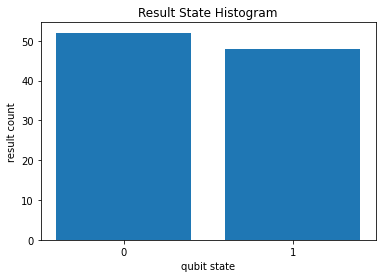

In [ ]:
_ = cirq.vis.plot_state_histogram(result, plt.subplot())

In [ ]:
result.histogram(key="a")

Counter({1: 100})

**Example 2: I Gate to stay in 0**

To prove this flexibility, let’s say we wanted to select state |0⟩ instead. This is the task of the oracle. The starting state and the diffuser remain untouched. The oracle for state |0⟩ is the I-gate. Or, simply doing nothing.


In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")

#Line-Qubit
qubits = cirq.LineQubit.range(1)

In [ ]:
ops=[cirq.H(a),
     cirq.I(a), # adding a identity gate
     cirq.H(a),
     cirq.measure(a)]

circuit=cirq.Circuit(ops)

print(circuit)

a: ───H───I───H───M───


In [ ]:
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

Measurement results
a=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


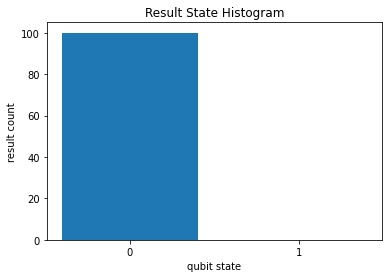

In [ ]:
_ = cirq.vis.plot_state_histogram(result, plt.subplot())

In [ ]:
result.histogram(key="a")

Counter({0: 100})

**Quantum Counting**

> **In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration.**

* how many solutions exist?

* does there any solution exist?


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $\left|s^{\prime}\right\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $\left|s^{\prime}\right\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i \theta}$, and **we can extract this using quantum phase estimation (QPE) to estimate the number of solutions $(M)$**.

**First we want to get $\theta$ from measured_int. (phase estimation)** 

* You will remember that $\mathrm{QPE}$ gives us a measured value $=2^{n} \phi$ from the eigenvalue $e^{2 \pi i \phi}$, 

* so to get $\theta$ we need to do:

> $
\theta=\text { value } \times \frac{2 \pi}{2^{t}}
$

**Second, we calculate the inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle:$**

> $
\left\langle s^{\prime} \mid s\right\rangle=\cos \frac{\theta}{2}
$

* And that $|s\rangle$ (a uniform superposition of computational basis states) can be written in terms of $|\omega\rangle$ and $\left|s^{\prime}\right\rangle$ as:

> $
|s\rangle=\sqrt{\frac{M}{N}}|\omega\rangle+\sqrt{\frac{N-M}{N}}\left|s^{\prime}\right\rangle
$

* The inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle$ is:

> $
\left\langle s^{\prime} \mid s\right\rangle=\sqrt{\frac{N-M}{N}}=\cos \frac{\theta}{2}$

* From this, we can use some trigonometry and algebra to show:

> $
N \sin ^{2} \frac{\theta}{2}=M
$

**Third, calculate number of solutions**

* From the Grover's algorithm chapter, you will remember that a common way to create a diffusion operator, $U_{s}$, is actually to implement $-U_{s}$. 

* This implementation is used in the Grover iteration provided in this chapter. In a normal Grover search, this phase is global and can be ignored, but now we are controlling our Grover iterations, this phase does have an effect. 

* The result is that we have effectively searched for the states that are not solutions, and our quantum counting algorithm will tell us how mâny states are not solutions. To fix this, we simply calculate 

> $N-M$

The ability to perform quantum counting efficiently is needed in order to use Grover's search algorithm (because running Grover's search algorithm requires knowing how many solutions exist). Moreover, this algorithm solves the quantum existence problem (namely, deciding whether any solution exists) as a special case.

###### *Harrow-Hassidim-Lloyd Algorithm (HHL)*

<font color="blue">**Solving a system of linear equations with a quantum computer (HHL)**

* **Given a matrix $A \in \mathbb{C}^{N \times N}$ and a vector $\vec{b} \in \mathbb{C}^{N}$, find $\vec{x} \in \mathbb{C}^{N}$ satisfying $A \vec{x}=\vec{b}$**

* The spectrum of $A$ is given by: $A\left|v_{j}\right\rangle=\lambda_{j}\left|v_{j}\right\rangle, 1 \geq\left|\lambda_{j}\right| \geq 1 / \kappa$


**Objective: We want to solve a system of linear equations by finding $\vec{x}$**

* Familiar methods of solutions: Substitution method, Graphical method, Matrix method, Cramer's rule, Gaussian elimination

* The classical algorithm returns the full solution, while the HHL can only approximate functions of the solution vector.


> $A \vec{x} = \vec{b}$

Classically you would take the inverse of $A$ (via spectral decomposition / eigendecomposition):

> $\vec{x} = A^{-1} \vec{b}$

The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language. 

* By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$. 

* Usually the mapping used is such that $i^{\text {th }}$ component of $\vec{b}$ (resp. $\vec{x}$ ) corresponds to the amplitude of the $i^{\text {th }}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$ ). 

From now on, we will focus on the rescaled problem

><font color="blue">$A|x\rangle=|b\rangle
$</font> $\quad$ (System of linear equations in a quantum state)

And we want to find this:

><font color="blue">$|x\rangle=A^{-1}|b\rangle$</font> $\quad$ (the solution is: $|x\rangle = \sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle$)

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:
 
>$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

>$
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

and the right hand side of the system can be written in the eigenbasis of $A$ as

>$
|b\rangle=\sum_{j=0}^{N-1} b_{j}\left|u_{j}\right\rangle, \quad b_{j} \in \mathbb{C}
$

It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state

>$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle
$

Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

**HHL-Algorithm**

*Main Subroutines in HHL: Hamiltonian simulation, Phase estimation (newer: linear combination of unitaries) and (Variable-time) amplitude amplification*

1. Prepare the initial state $|b\rangle$. Note that $|b\rangle=\sum_{j} c_{j}\left|v_{j}\right\rangle$.

2. Use the so-called phase estimation algorithm to perform the map
$|b\rangle \rightarrow \sum_{j} c_{j}\left|v_{j}\right\rangle\left|\tilde{\lambda}_{j}\right\rangle$

* $|\tilde{\lambda}_{j}\rangle$ -> This register contains the eigenvalue estimates.

3. Apply a one-qubit conditional rotation to perform the map
$|0\rangle \rightarrow \frac{1}{\kappa \tilde{\lambda}_{j}}|0\rangle+\sqrt{1-\frac{1}{\kappa^{2} \tilde{\lambda}_{j}^{2}}}|1\rangle$

4. Undo step 2 - apply the inverse of phase estimation
$\sum_{j} \frac{c_{j}}{\kappa \tilde{\lambda}_{j}}\left|v_{j}\right\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle \approx \frac{1}{\kappa A}|b\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle$

5. Use amplitude amplification to get rid of the „bad“ part of the state with |1>


**Applications of HHL**

* Systems of linear equations arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation. 

* Used in many quantum machine learning algorithms as a building block


* The quantum algorithm for linear systems of equations has been applied to a support vector machine, which is an optimized linear or non-linear binary classifier (https://arxiv.org/abs/1307.0471v2)

* for Least-squares fitting (https://arxiv.org/abs/1204.5242)

* for finite-element-methods (https://arxiv.org/abs/1512.05903) (but only for higher problems which include solutions with higher-order derivatives and large spatial dimensions. For example, problems in many-body dynamics require the solution of equations containing derivatives on orders scaling with the number of bodies, and some problems in computational finance, such as Black-Scholes models, require large spatial dimensions)

**Promise**: 

* Solving 10,000 linear equation: a classical computer needs in best case 10,000 steps. HHL just 13. The [quantum algorithm for linear systems of equations](https://en.m.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) designed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd: Provided the linear system is sparse and has a low condition number $\kappa_{1}$ and that the user is interested in the result of a scalar measurement on the solution vector, instead of the values of the solution vector itself, then the algorithm has a runtime of $O\left(\log (N) \kappa^{2}\right)$, where $N$ is the number of variables in the linear system. This offers an exponential speedup over the fastest classical algorithm, which runs in $O(N \kappa)$ (or $O(N \sqrt{\kappa})$ for positive semidefinite matrices).

* Unlike the classical solutions to the Deutsch-Jozsa and search problems, most of our classical methods for matrix manipulation do work in polynomial time. However, as data analysis becomes more and more powerful (and more and more demanding on today’s computers), the size of these matrices can make even polynomial time too long.

**Disadvantages:**

* solution vector is not yielded (rather it prepares a quantum state that is proportional to the solution): Actually reading out the solution vector would take O(N)time, so we can only maintain the logarithmic runtime by sampling the solution vector like ⟨x|M|x⟩, where M is a quantum-mechanical operator. Therefore, **HHL is useful mainly in applications where only samples from the solution vector are needed**. 

* Entries of matrix have to be sparse: Additionally, although HHL is exponentially faster than Conjugate Gradient in N, it is polynomially slower in s and 𝜅, so HHL is restricted to only those matrices that are sparse and have low condition numbers.

* Must satisfy robust invertibility (means that entries of matrix must all approx. of same size)

* Preparation of input vector is complicated


**Sources:**

* https://en.m.wikipedia.org/wiki/System_of_linear_equations#Matrix_solution

* [Peter Witteg: Quantum Machine Learning - 37 - Overview of the HHL Algorithm](https://m.youtube.com/watch?v=hQpdPM-6wtU)

* https://qiskit.org/textbook/ch-applications/hhl_tutorial.html

* https://github.com/quantumlib/Cirq/blob/master/examples/hhl.py

* [Google Quantum: Quantum Algorithms for Systems of Linear Equations (Quantum Summer Symposium 2020)](https://m.youtube.com/watch?v=Xvp56xeNZo4)

* https://www.quantamagazine.org/new-quantum-algorithms-finally-crack-nonlinear-equations-20210105/

* [A New Approach to Multiplication Opens the Door to Better Quantum Computers](https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/)

* https://www.quantamagazine.org/new-algorithm-breaks-speed-limit-for-solving-linear-equations-20210308/

* https://www.quantamagazine.org/teenager-finds-classical-alternative-to-quantum-recommendation-algorithm-20180731/

* https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/

* https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/

In [ ]:
# pylint: disable=wrong-or-nonexistent-copyright-notice
"""Demonstrates the algorithm for solving linear systems by Harrow, Hassidim, Lloyd (HHL).

The HHL algorithm solves a system of linear equations, specifically equations of the form Ax = b,
where A is a Hermitian matrix, b is a known vector, and x is the unknown vector. To solve on a
quantum system, b must be rescaled to have magnitude 1, and the equation becomes:

|x> = A**-1 |b> / || A**-1 |b> ||

The algorithm uses 3 sets of qubits: a single ancilla qubit, a register (to store eigenvalues of
A), and memory qubits (to store |b> and |x>). The following are performed in order:
1) Quantum phase estimation to extract eigenvalues of A
2) Controlled rotations of ancilla qubit
3) Uncomputation with inverse quantum phase estimation

For details about the algorithm, please refer to papers in the REFERENCE section below. The
following description uses variables defined in the HHL paper.

This example is an implementation of the HHL algorithm for arbitrary 2x2 Hermitian matrices. The
output of the algorithm are the expectation values of Pauli observables of |x>. Note that the
accuracy of the result depends on the following factors:
* Register size
* Choice of parameters C and t

The result is perfect if
* Each eigenvalue of the matrix is in the form

  2π/t * k/N,

  where 0≤k<N, and N=2^n, where n is the register size. In other words, k is a value that can be
  represented exactly by the register.
* C ≤ 2π/t * 1/N, the smallest eigenvalue that can be stored in the circuit.

The result is good if the register size is large enough such that for every pair of eigenvalues,
the ratio can be approximated by a pair of possible register values. Let s be the scaling factor
from possible register values to eigenvalues. One way to set t is

t = 2π/(sN)

For arbitrary matrices, because properties of their eigenvalues are typically unknown, parameters C
and t are fine-tuned based on their condition number.


=== REFERENCE ===
Harrow, Aram W. et al. Quantum algorithm for solving linear systems of
equations (the HHL paper)
https://arxiv.org/abs/0811.3171

Coles, Eidenbenz et al. Quantum Algorithm Implementations for Beginners
https://arxiv.org/abs/1804.03719

=== CIRCUIT ===
Example of circuit with 2 register qubits.

(0, 0): ─────────────────────────Ry(θ₄)─Ry(θ₁)─Ry(θ₂)─Ry(θ₃)──────────────M──
                     ┌──────┐    │      │      │      │ ┌───┐
(1, 0): ─H─@─────────│      │──X─@──────@────X─@──────@─│   │─────────@─H────
           │         │QFT^-1│    │      │      │      │ │QFT│         │
(2, 0): ─H─┼─────@───│      │──X─@────X─@────X─@────X─@─│   │─@───────┼─H────
           │     │   └──────┘                           └───┘ │       │
(3, 0): ───e^iAt─e^2iAt───────────────────────────────────────e^-2iAt─e^-iAt─

Note: QFT in the above diagram omits swaps, which are included implicitly by
reversing qubit order for phase kickbacks.
"""

import math
import numpy as np
import sympy
import cirq


class PhaseEstimation(cirq.Gate):
    """A gate for Quantum Phase Estimation.

    The last qubit stores the eigenvector; all other qubits store the estimated phase,
    in big-endian.

    Args:
        num_qubits: The number of qubits of the unitary.
        unitary: The unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        yield cirq.H.on_each(*qubits[:-1])
        yield PhaseKickback(self.num_qubits(), self.U)(*qubits)
        yield cirq.qft(*qubits[:-1], without_reverse=True) ** -1


class HamiltonianSimulation(cirq.EigenGate):
    """A gate that represents e^iAt.

    This EigenGate + np.linalg.eigh() implementation is used here purely for demonstrative
    purposes. If a large matrix is used, the circuit should implement actual Hamiltonian
    simulation, by using the linear operators framework in Cirq, for example.
    """

    def __init__(self, A, t, exponent=1.0):
        cirq.EigenGate.__init__(self, exponent=exponent)
        self.A = A
        self.t = t
        ws, vs = np.linalg.eigh(A)
        self.eigen_components = []
        for w, v in zip(ws, vs.T):
            theta = w * t / math.pi
            P = np.outer(v, np.conj(v))
            self.eigen_components.append((theta, P))

    def _num_qubits_(self) -> int:
        return 1

    def _with_exponent(self, exponent):
        return HamiltonianSimulation(self.A, self.t, exponent)

    def _eigen_components(self):
        return self.eigen_components


class PhaseKickback(cirq.Gate):
    """A gate for the phase kickback stage of Quantum Phase Estimation.

    It consists of a series of controlled e^iAt gates with the memory qubit as the target and
    each register qubit as the control, raised to the power of 2 based on the qubit index.
    unitary is the unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        super(PhaseKickback, self)
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        memory = qubits.pop()
        for i, qubit in enumerate(qubits):
            yield cirq.ControlledGate(self.U ** (2**i))(qubit, memory)


class EigenRotation(cirq.Gate):
    """Perform a rotation on an ancilla equivalent to division by eigenvalues of a matrix.

    EigenRotation performs the set of rotation on the ancilla qubit equivalent to division on the
    memory register by each eigenvalue of the matrix. The last qubit is the ancilla qubit; all
    remaining qubits are the register, assumed to be big-endian.

    It consists of a controlled ancilla qubit rotation for each possible value that can be
    represented by the register. Each rotation is a Ry gate where the angle is calculated from
    the eigenvalue corresponding to the register value, up to a normalization factor C.
    """

    def __init__(self, num_qubits, C, t):
        super(EigenRotation, self)
        self._num_qubits = num_qubits
        self.C = C
        self.t = t
        self.N = 2 ** (num_qubits - 1)

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        for k in range(self.N):
            kGate = self._ancilla_rotation(k)

            # xor's 1 bits correspond to X gate positions.
            xor = k ^ (k - 1)

            for q in qubits[-2::-1]:
                # Place X gates
                if xor % 2 == 1:
                    yield cirq.X(q)
                xor >>= 1

                # Build controlled ancilla rotation
                kGate = cirq.ControlledGate(kGate)

            yield kGate(*qubits)

    def _ancilla_rotation(self, k):
        if k == 0:
            k = self.N
        theta = 2 * math.asin(self.C * self.N * self.t / (2 * math.pi * k))
        return cirq.ry(theta)


def hhl_circuit(A, C, t, register_size, *input_prep_gates):
    """Constructs the HHL circuit.

    Args:
        A: The input Hermitian matrix.
        C: Algorithm parameter, see above.
        t: Algorithm parameter, see above.
        register_size: The size of the eigenvalue register.
        *input_prep_gates: A list of gates to be applied to |0> to generate the desired input
            state |b>.

    Returns:
        The HHL circuit. The ancilla measurement has key 'a' and the memory measurement is in key
        'm'.  There are two parameters in the circuit, `exponent` and `phase_exponent` corresponding
        to a possible rotation  applied before the measurement on the memory with a
        `cirq.PhasedXPowGate`.
    """

    ancilla = cirq.LineQubit(0)
    # to store eigenvalues of the matrix
    register = [cirq.LineQubit(i + 1) for i in range(register_size)]
    # to store input and output vectors
    memory = cirq.LineQubit(register_size + 1)

    c = cirq.Circuit()
    hs = HamiltonianSimulation(A, t)
    pe = PhaseEstimation(register_size + 1, hs)
    c.append([gate(memory) for gate in input_prep_gates])
    c.append(
        [
            pe(*(register + [memory])),
            EigenRotation(register_size + 1, C, t)(*(register + [ancilla])),
            pe(*(register + [memory])) ** -1,
            cirq.measure(ancilla, key='a'),
        ]
    )

    c.append(
        [
            cirq.PhasedXPowGate(
                exponent=sympy.Symbol('exponent'), phase_exponent=sympy.Symbol('phase_exponent')
            )(memory),
            cirq.measure(memory, key='m'),
        ]
    )

    return c


def simulate(circuit):
    simulator = cirq.Simulator()

    # Cases for measuring X, Y, and Z (respectively) on the memory qubit.
    params = [
        {'exponent': 0.5, 'phase_exponent': -0.5},
        {'exponent': 0.5, 'phase_exponent': 0},
        {'exponent': 0, 'phase_exponent': 0},
    ]

    results = simulator.run_sweep(circuit, params, repetitions=5000)

    for label, result in zip(('X', 'Y', 'Z'), list(results)):
        # Only select cases where the ancilla is 1.
        # TODO: optimize using amplitude amplification algorithm.
        # Github issue: https://github.com/quantumlib/Cirq/issues/2216
        expectation = 1 - 2 * np.mean(result.measurements['m'][result.measurements['a'] == 1])
        print(f'{label} = {expectation}')


def main():
    """The main program loop.

    Simulates HHL with matrix input, and outputs Pauli observables of the resulting qubit state |x>.
    Expected observables are calculated from the expected solution |x>.
    """

    # Eigendecomposition:
    #   (4.537, [-0.971555, -0.0578339+0.229643j])
    #   (0.349, [-0.236813, 0.237270-0.942137j])
    # |b> = (0.64510-0.47848j, 0.35490-0.47848j)
    # |x> = (-0.0662724-0.214548j, 0.784392-0.578192j)
    A = np.array(
        [
            [4.30213466 - 6.01593490e-08j, 0.23531802 + 9.34386156e-01j],
            [0.23531882 - 9.34388383e-01j, 0.58386534 + 6.01593489e-08j],
        ]
    )

    t = 0.358166 * math.pi
    register_size = 4
    input_prep_gates = [cirq.rx(1.276359), cirq.rz(1.276359)]
    expected = (0.144130, 0.413217, -0.899154)

    # Set C to be the smallest eigenvalue that can be represented by the
    # circuit.
    C = 2 * math.pi / (2**register_size * t)

    # Simulate circuit.
    print("Expected observable outputs:")
    print("X =", expected[0])
    print("Y =", expected[1])
    print("Z =", expected[2])
    print("Actual: ")
    simulate(hhl_circuit(A, C, t, register_size, *input_prep_gates))


if __name__ == '__main__':
    main()

Expected observable outputs:
X = 0.14413
Y = 0.413217
Z = -0.899154
Actual: 
X = 0.10290652003142187
Y = 0.42396313364055305
Z = -0.8813559322033899


In [ ]:
# Classical result
from numpy import linalg as LA
w, v = LA.eigh(A)
w

array([0.34899946, 4.53700054])

###### *Quantum Error Correction & Surface Code*

**Quantum Error Correction**

[INTRODUCTION TO
QUANTUM ERROR
CORRECTION](https://cpb-us-w2.wpmucdn.com/voices.uchicago.edu/dist/0/2327/files/2019/11/QECIntro.pdf)

> [Toric code](https://en.m.wikipedia.org/wiki/Toric_code): is a topological [quantum error correcting code](https://en.m.wikipedia.org/wiki/Quantum_error_correction), and an example of a [stabilizer code](https://en.m.wikipedia.org/wiki/Stabilizer_code), defined on a two-dimensional spin lattice.

* https://www.quantamagazine.org/how-space-and-time-could-be-a-quantum-error-correcting-code-20190103/

 logical qubits vs physical qubits

* around 1.000 physical qubits to make 1 perfect logical qubit, less precise: 17 physical qubits per 1 logical qubits or so could be enough

* quantum error correction is long term goal, meanwhile we try to mitigate it

* Error mitigation techniques: statistical corrections (on histogram for example)

	* https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

	* https://arxiv.org/abs/2005.10189

* Examples of QEC: repetition code (simplest QEC) and surface code

* techniques: syndrome measurements, decoding, logical operations

* Key things: how likely is it that you will be misheard, and how much do you care about error?

* repetition code: redundancy (repetition) is a way to make sure the message gets delivered (i.e. with majority voting, for d repetition: $P=\sum_{n=0}^{[ a / 2]}\left(\begin{array}{l}d \\ n\end{array}\right) p^{n}(1-p)^{d-n} \sim\left(\frac{p}{(1-p)}\right)^{[ d / 2]}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_100.png)

**Surface Code**

* The surface codes are a family of quantum error correcting codes defined on a 2D lattice of qubits. Each code within this family has stabilizers that are defined equivalently in the bulk, but differ from one another in their boundary conditions.

* The members of the surface code family are sometimes also described by more specific names: The [toric code](https://en.m.wikipedia.org/wiki/Toric_code) is a surface code with periodic boundary conditions, the planar code is one defined on a plane, etc. The term ‘surface code’ is sometimes also used interchangeably with ‘planar code’, since this is the most realistic example of the surface code family.

* The surface codes are currently a large research area, so I’ll just point you towards some good entry points (in addition to the Wikipedia article linked to above).

* [Topological quantum memory (paper)](https://arxiv.org/abs/quant-ph/0110143)

* [Surface codes: Towards practical large-scale quantum computation (paper)](https://arxiv.org/abs/1208.0928)

* [My blog series introducing surface codes](http://decodoku.blogspot.com/2016/02/5-story-so-far_57.html)

The surface codes can also be generalized to qudits. For more on that, [see here (Fault-tolerant quantum computation by anyons)](https://arxiv.org/abs/quant-ph/9707021)

https://quantumcomputing.stackexchange.com/questions/2106/what-is-the-surface-code-in-the-context-of-quantum-error-correction

###### *Block Encoding*

Block encoding is the framework or tool for developing a variety of quantum algorithms by encoding a matrix as a block of a unitary.There are various ways to implement the same as per requirement,one of the ways is by decomposing the matrices into linear combinations of displacement matrices.


block encodings (unitary, signal proicesing, transformation)

https://quantumcomputing.stackexchange.com/questions/18236/block-encoding-technique-what-is-it-and-what-is-it-used-for

###### *Data Encoding (Embedding)*

> **The easiest way for a parameter to enter a circuit is through a rotation of a single qubit, in proportion to the value of a single datapoint, so a single scalar value:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_190.png)

> **You can also use a sequence of rotations to embedd data (reuploding).** And maybe there is free parameters in between as well. Can make a more complex function available than if you upload only once in a single rotation.

> **Learnable embeddings**: The other idea is to actually have a trainable embedding layer. Not to worry about training the unitary of the circuit, but worry about training the embedding and then use standard quantum information metrics to classify the data.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_191.png)

**Basis (State) Encoding**

* We gave data points x12 and x2

* We first need to represent data in binary form, like 00 and 10

* Then we encode it into a QC in a way, such that we have basis states that represents them like |00> and |10> 

* with all other basis states having probability zero - represented in the amplitude vector

* So we encode data in quantum state that is aligned with basis states

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_856.png)

**Amplitude Encoding**

* we want to encode our classical information into an amplitude vector

* you have a classical data vector with 4 entries (features) x1

* now construct a circuit, so that we have an amplitude vector that corresponds to the values in the classical data vector:

	* we have 2 qubits initialized in the ground state

	* then we apply some operations U (x1) on these qubits

	* and then we get a quantum state that corresponds to an amplitude vector that exactly represents our classical data points

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_857.png)

**Angle Encoding**

* we have 2 dimension data that we can write in a two dimensional vector

* then I take the number of qubits equal to the number of features (rows / entries in a classical vector)

* then I apply rotations to each of these qubits that are equal to the value of the features 

	* for example I rotate the first qubit about some axis Z. The rotation value / rotation angle is equal to the first classical feature value 

	* the I take my second qubit and rotate it, for example again by the Z axis, and the angle of the rotation is equal to the second feature value of my data point

* for higher dimensional data, for example a third dimension classical vector, then I simply add more qubits to my system to encode this information

* For example:  [z feature map (Qiskit)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html#qiskit.circuit.library.ZFeatureMap):
	* apply Hadamard operator first to each of the qubits, and then encode data values in rotations
	* and then repeat this as many times as you want (stacking operations sequentially like in the image) to encode data multpiple times in a row

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_858.png)

**Higher Order Encoding**

* there is no theoretical reason why doing this or if it's better or not

* the idea comes from the paper [Supervised learning with quantum enhanced feature spaces](https://arxiv.org/abs/1804.11326)

* Basic idea: let's do an encoding that is hard to reproduce classically and simulate, and then maybe we get some quantum advantage in doing this

* we have some two dimensional data with a vector with 2 entries

	* choose number of qubits = number of feature values

	* then apply an hadarmard on each qubit

	* and then do rotations about some axis Z, and the first angle is the first feature value, and the same with the second qubit

	* and then we apply some entanglement gates between these qubits

	* then we do another rotation (for example again Z axis), but this rotation angle depends on some function of the product of the feature values R(x^1 * x^2)

	* this is where the name comes from: we encode in a higher order product space

	* and this whole block of this encoding can be repeated, which is called the depth of the feature maps

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_860.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_861.png)

**Other Encodings**

* Hamiltonian evolution ansatz encoding

* Displacement Encoding

* IQP Encoding (Instantaneous quantum polynomial)

* Squeezing Encoding

* QAOA Encoding